In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import multiprocessing as mp
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.optim import Adam
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

In [2]:
trained_model_path = '/workdir/security/home/junjiehuang2468/paper/trained_models_weight/ember/'
best_trained_model = '2022-01-18 14:55/2w_epoch:0_test_acc:0.890858.pt'
# best_trained_model = '2022-01-24 17:46/2w_epoch:5_test_acc:0.895942.pt'
data_path = "/workdir/security/home/junjiehuang2468/paper/data/ember2018/"
train_data_path = data_path + "malwares/" 
test_data_path = data_path + "test_malwares/" 

In [3]:
CUDA = True if torch.cuda.is_available() else False
NUM_WORKERS = 24
BATCH_SIZE = 40
# BATCH_SIZE = 10
LEAVE_BIT_NUMBER = 20000
KERNEL_SIZE = 500

In [4]:
LEAVE_BIT_NUMBER_DICT = {10000:'1w',20000:'2w'}

In [5]:
trainset = pd.read_csv(data_path + 'train_dataset.csv')
validset = pd.read_csv(data_path + 'valid_dataset.csv')
testset = pd.read_csv(data_path + 'test_dataset.csv')
testset = testset.iloc[np.argwhere(testset['labels'].values == 1).squeeze(),:]

In [6]:
class ExeDataset(Dataset):
    def __init__(self, malware_names, data_path, labels, leave_bit_num):
        self.malware_names = malware_names
        self.data_path = data_path
        self.labels = labels
        self.leave_bit_num = leave_bit_num

    def __len__(self):
        return len(self.malware_names)

    def __getitem__(self, idx):
        with open(self.data_path + self.malware_names[idx] + '.txt','rb') as fp:
            data = [bit+1 for bit in fp.read()[:self.leave_bit_num]]
            padding = [0]*(self.leave_bit_num-len(data))
            data = data + padding

        return np.array(data), np.array([self.labels[idx]])

In [7]:
train_dataset = ExeDataset(
    trainset["id"].tolist(), 
    train_data_path, 
    trainset["labels"].tolist(), 
    LEAVE_BIT_NUMBER
)
valid_dataset = ExeDataset(
    validset["id"].tolist(), 
    train_data_path, 
    validset["labels"].tolist(), 
    LEAVE_BIT_NUMBER
)
test_dataset = ExeDataset(
    testset["id"].tolist(), 
    test_data_path, 
    testset["labels"].tolist(), 
    LEAVE_BIT_NUMBER
)

In [8]:
trainloader = DataLoader(
    dataset = train_dataset,
    batch_size = BATCH_SIZE,
    shuffle = False,
    num_workers = NUM_WORKERS,
    pin_memory = True
)
validloader = DataLoader(
    dataset = valid_dataset,
    batch_size = BATCH_SIZE,
    shuffle = False,
    num_workers = NUM_WORKERS,
    pin_memory = True
)
testloader = DataLoader(
    dataset = test_dataset,
    batch_size = BATCH_SIZE,
    shuffle = False,
    num_workers = NUM_WORKERS,
    pin_memory = True
)

In [9]:
class Model(nn.Module):
    def __init__(self, data_length = 2e6, kernel_size = 500):
        super().__init__()
        self.embedding = nn.Embedding(257, 8, padding_idx=0)
        self.conv_layer_1 = nn.Conv1d(4, 128, kernel_size, stride = kernel_size, bias = True)
        # self.bn_1 = nn.BatchNorm1d(128)
        self.conv_layer_2 = nn.Conv1d(4, 128, kernel_size, stride = kernel_size, bias = True)
        self.pool_layer_2 = nn.MaxPool1d(data_length//kernel_size)
        self.fc_layer_3 = nn.Linear(128, 128)
        self.fc_layer_4 = nn.Linear(128, 2)
        
    def sequence(self,embedd_x):
        x = embedd_x.transpose(-1,-2)
        x_conv_1 = self.conv_layer_1(x[:,:4,:])
        x_conv_2 = torch.sigmoid(self.conv_layer_2(x[:,4:,:]))
        x = x_conv_1*x_conv_2
        del x_conv_1,x_conv_2
        x = self.pool_layer_2(x).squeeze()
        x = self.fc_layer_3(x)
        x = self.fc_layer_4(x)
        return x
        
    def forward(self, input_, loss_fn):
        batch_acc = []
        batch_grad = []
        
        embedd_x = self.embedding(input_)
        x = self.sequence(embedd_x)
        acc = torch.argmax(torch.softmax(x,dim=-1),dim=-1).float().mean()
        batch_acc.append(acc.tolist())
        
        padding_place_mask = input_ == 0
        random_padding = torch.randint_like(input=padding_place_mask.float(),low=1,high=257) * padding_place_mask.float()
        input_ += random_padding.long()
        
        one_hot_x = F.one_hot(input_,num_classes=257).float()
        one_hot_x.requires_grad = True
        one_hot_x.retain_grad()
        for _ in range(13):
            embedd_x = one_hot_x @ self.embedding.weight
            x = self.sequence(embedd_x)
            
            acc = torch.argmax(torch.softmax(x,dim=-1),dim=-1).float().mean()
            batch_acc.append(acc.tolist())
            
            mislead_labels = torch.cat((torch.ones(len(x)).reshape(-1,1),torch.zeros(len(x)).reshape(-1,1)),dim=1).cuda()
            loss = loss_fn(x,mislead_labels)
            loss.backward()
            
            shape = padding_place_mask.shape
            expand_padding_place_mask = padding_place_mask.unsqueeze(-1).expand(shape[0],shape[1],257)
            grad_min_idx = torch.argmin(one_hot_x.grad,dim=-1)
            grad_sez_mask = (one_hot_x.grad <= 0)
            grad_mask = (expand_padding_place_mask & grad_sez_mask)
            batch_grad.append(torch.div(
                input=(expand_padding_place_mask.float()*one_hot_x.grad).sum(),
                other=expand_padding_place_mask.float().sum()
            ).detach().cpu().numpy())
            
            one_hot_x.data = F.one_hot(torch.argmin(
                one_hot_x.grad,
                dim=-1
            ),num_classes=257).float()*(expand_padding_place_mask.float()) + one_hot_x*(1 - expand_padding_place_mask.float())
            
        embedd_x = one_hot_x @ self.embedding.weight
        x = self.sequence(embedd_x)
        return x.detach().cpu().numpy(),batch_acc,batch_grad,one_hot_x

In [10]:
model = Model(data_length=LEAVE_BIT_NUMBER,kernel_size=KERNEL_SIZE)

ce_loss = nn.CrossEntropyLoss()
optim = Adam(model.parameters())

model = model.cuda() if CUDA else model
ce_loss = ce_loss.cuda() if CUDA else ce_less

In [11]:
model.load_state_dict(torch.load(trained_model_path + best_trained_model))

<All keys matched successfully>

In [12]:
model.eval()
acc = []
preds = []
labels = []
total_batch_acc = []
total_batch_grad = []
bar = tqdm(testloader)
# bar = tqdm(validloader)
for step, (batch_data,batch_label) in enumerate(bar):
    batch_data = batch_data.cuda() if CUDA else batch_data
    batch_label = batch_label.cuda() if CUDA else batch_label
    batch_label = batch_label.squeeze()
    temp_label = torch.zeros((len(batch_label),2))
    for idx,target in enumerate(batch_label.squeeze()): temp_label[idx,target] = 1
    temp_label = temp_label.cuda() if CUDA else temp_label

#     pred,input_,one_hot_x = model(batch_data,ce_loss)
#     break
    pred,batch_acc,batch_grad,one_hot_x = model(batch_data,ce_loss)
#     break
    pred = np.argmax(pred,1)
    batch_label = batch_label.cpu().data.numpy()
    
    preds.extend(pred.tolist())
    labels.extend(batch_label.tolist())
    
    temp_acc = (batch_label == pred).mean()
    acc.append(temp_acc)
    total_batch_acc.append(batch_acc + [temp_acc])
    total_batch_grad.append([0] + batch_grad)
    total_batch_acc_str = '[' + ' '.join(map(lambda x: '%.10f'%x,np.mean(total_batch_acc,axis=0))) + ']'
    total_batch_grad_str = '[' + ' '.join(map(lambda x: '%.10f'%x,np.mean(total_batch_grad,axis=0))) + ']'
    print(total_batch_acc_str)
    print(total_batch_grad_str)
    print(f"test：{temp_acc:4f}, test mean: {np.mean(acc):4f}")

  0%|          | 1/2500 [00:03<2:10:46,  3.14s/it]

[0.8750000000 0.2000000030 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000]
[0.0000000000 0.0000031291 0.0000031291 0.0000031291 0.0000031291 0.0000031291 0.0000031291 0.0000031291 0.0000031291 0.0000031291 0.0000031291 0.0000031291 0.0000031291 0.0000031291]
test：0.000000, test mean: 0.000000


  0%|          | 2/2500 [00:04<1:18:21,  1.88s/it]

[0.8625000119 0.2375000045 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000]
[0.0000000000 0.0000037050 0.0000037050 0.0000037050 0.0000037050 0.0000037050 0.0000037050 0.0000037050 0.0000037050 0.0000037050 0.0000037050 0.0000037050 0.0000037050 0.0000037050]
test：0.000000, test mean: 0.000000


  0%|          | 3/2500 [00:04<57:49,  1.39s/it]  

[0.8583333492 0.2416666696 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000]
[0.0000000000 0.0000040353 0.0000040353 0.0000040353 0.0000040353 0.0000040353 0.0000040353 0.0000040353 0.0000040353 0.0000040353 0.0000040353 0.0000040353 0.0000040353 0.0000040353]
test：0.000000, test mean: 0.000000


  0%|          | 4/2500 [00:05<48:14,  1.16s/it]

[0.8500000089 0.2437500022 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000]
[0.0000000000 0.0000044620 0.0000044620 0.0000044620 0.0000044620 0.0000044620 0.0000044620 0.0000044620 0.0000044620 0.0000044620 0.0000044620 0.0000044620 0.0000044620 0.0000044620]
test：0.000000, test mean: 0.000000


  0%|          | 5/2500 [00:06<42:53,  1.03s/it]

[0.8600000143 0.2600000054 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000]
[0.0000000000 0.0000048999 0.0000048999 0.0000048999 0.0000048999 0.0000048999 0.0000048999 0.0000048999 0.0000048999 0.0000048999 0.0000048999 0.0000048999 0.0000048999 0.0000048999]
test：0.000000, test mean: 0.000000


  0%|          | 6/2500 [00:07<39:36,  1.05it/s]

[0.8666666845 0.2458333373 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000]
[0.0000000000 0.0000049665 0.0000049665 0.0000049665 0.0000049665 0.0000049665 0.0000049665 0.0000049665 0.0000049665 0.0000049665 0.0000049665 0.0000049665 0.0000049665 0.0000049665]
test：0.000000, test mean: 0.000000


  0%|          | 7/2500 [00:08<37:34,  1.11it/s]

[0.8607142993 0.2321428614 0.0035714286 0.0035714286 0.0035714286 0.0035714286 0.0035714286 0.0035714286 0.0035714286 0.0035714286 0.0035714286 0.0035714286 0.0035714286 0.0035714286 0.0035714286]
[0.0000000000 0.0000046182 0.0000046182 0.0000046182 0.0000046182 0.0000046182 0.0000046182 0.0000046182 0.0000046182 0.0000046182 0.0000046182 0.0000046182 0.0000046182 0.0000046182]
test：0.025000, test mean: 0.003571


  0%|          | 8/2500 [00:08<36:18,  1.14it/s]

[0.8687500134 0.2406250052 0.0031250000 0.0031250000 0.0031250000 0.0031250000 0.0031250000 0.0031250000 0.0031250000 0.0031250000 0.0031250000 0.0031250000 0.0031250000 0.0031250000 0.0031250000]
[0.0000000000 0.0000050585 0.0000050585 0.0000050585 0.0000050585 0.0000050585 0.0000050585 0.0000050585 0.0000050585 0.0000050585 0.0000050585 0.0000050585 0.0000050585 0.0000050585]
test：0.000000, test mean: 0.003125


  0%|          | 9/2500 [00:09<35:24,  1.17it/s]

[0.8638888995 0.2527777818 0.0027777778 0.0027777778 0.0027777778 0.0027777778 0.0027777778 0.0027777778 0.0027777778 0.0027777778 0.0027777778 0.0027777778 0.0027777778 0.0027777778 0.0027777778]
[0.0000000000 0.0000050731 0.0000050731 0.0000050731 0.0000050731 0.0000050731 0.0000050731 0.0000050731 0.0000050731 0.0000050731 0.0000050731 0.0000050731 0.0000050731 0.0000050731]
test：0.000000, test mean: 0.002778


  0%|          | 10/2500 [00:10<34:53,  1.19it/s]

[0.8625000119 0.2450000033 0.0025000000 0.0025000000 0.0025000000 0.0025000000 0.0025000000 0.0025000000 0.0025000000 0.0025000000 0.0025000000 0.0025000000 0.0025000000 0.0025000000 0.0025000000]
[0.0000000000 0.0000048992 0.0000048992 0.0000048992 0.0000048992 0.0000048992 0.0000048992 0.0000048992 0.0000048992 0.0000048992 0.0000048992 0.0000048992 0.0000048992 0.0000048992]
test：0.000000, test mean: 0.002500


  0%|          | 11/2500 [00:11<34:30,  1.20it/s]

[0.8613636494 0.2409090942 0.0045454546 0.0045454546 0.0045454546 0.0045454546 0.0045454546 0.0045454546 0.0045454546 0.0045454546 0.0045454546 0.0045454546 0.0045454546 0.0045454546 0.0045454545]
[0.0000000000 0.0000045863 0.0000045863 0.0000045863 0.0000045863 0.0000045863 0.0000045863 0.0000045863 0.0000045863 0.0000045863 0.0000045863 0.0000045863 0.0000045863 0.0000045863]
test：0.025000, test mean: 0.004545


  0%|          | 12/2500 [00:12<34:14,  1.21it/s]

[0.8583333443 0.2416666696 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667]
[0.0000000000 0.0000045552 0.0000045552 0.0000045552 0.0000045552 0.0000045552 0.0000045552 0.0000045552 0.0000045552 0.0000045552 0.0000045552 0.0000045552 0.0000045552 0.0000045552]
test：0.000000, test mean: 0.004167


  1%|          | 13/2500 [00:13<33:55,  1.22it/s]

[0.8596153947 0.2384615414 0.0038461539 0.0038461539 0.0038461539 0.0038461539 0.0038461539 0.0038461539 0.0038461539 0.0038461539 0.0038461539 0.0038461539 0.0038461539 0.0038461539 0.0038461538]
[0.0000000000 0.0000044541 0.0000044541 0.0000044541 0.0000044541 0.0000044541 0.0000044541 0.0000044541 0.0000044541 0.0000044541 0.0000044541 0.0000044541 0.0000044541 0.0000044541]
test：0.000000, test mean: 0.003846


  1%|          | 14/2500 [00:13<33:45,  1.23it/s]

[0.8589285825 0.2303571456 0.0035714286 0.0035714286 0.0035714286 0.0035714286 0.0035714286 0.0035714286 0.0035714286 0.0035714286 0.0035714286 0.0035714286 0.0035714286 0.0035714286 0.0035714286]
[0.0000000000 0.0000045321 0.0000045321 0.0000045321 0.0000045321 0.0000045321 0.0000045321 0.0000045321 0.0000045321 0.0000045321 0.0000045321 0.0000045321 0.0000045321 0.0000045321]
test：0.000000, test mean: 0.003571


  1%|          | 15/2500 [00:14<33:37,  1.23it/s]

[0.8533333460 0.2300000032 0.0033333334 0.0033333334 0.0033333334 0.0033333334 0.0033333334 0.0033333334 0.0033333334 0.0033333334 0.0033333334 0.0033333334 0.0033333334 0.0033333334 0.0033333333]
[0.0000000000 0.0000044931 0.0000044931 0.0000044931 0.0000044931 0.0000044931 0.0000044931 0.0000044931 0.0000044931 0.0000044931 0.0000044931 0.0000044931 0.0000044931 0.0000044931]
test：0.000000, test mean: 0.003333


  1%|          | 16/2500 [00:15<33:32,  1.23it/s]

[0.8593750112 0.2265625028 0.0031250000 0.0031250000 0.0031250000 0.0031250000 0.0031250000 0.0031250000 0.0031250000 0.0031250000 0.0031250000 0.0031250000 0.0031250000 0.0031250000 0.0031250000]
[0.0000000000 0.0000044234 0.0000044234 0.0000044234 0.0000044234 0.0000044234 0.0000044234 0.0000044234 0.0000044234 0.0000044234 0.0000044234 0.0000044234 0.0000044234 0.0000044234]
test：0.000000, test mean: 0.003125


  1%|          | 17/2500 [00:16<33:24,  1.24it/s]

[0.8588235413 0.2264705914 0.0044117648 0.0044117648 0.0044117648 0.0044117648 0.0044117648 0.0044117648 0.0044117648 0.0044117648 0.0044117648 0.0044117648 0.0044117648 0.0044117648 0.0044117647]
[0.0000000000 0.0000044496 0.0000044496 0.0000044496 0.0000044496 0.0000044496 0.0000044496 0.0000044496 0.0000044496 0.0000044496 0.0000044496 0.0000044496 0.0000044496 0.0000044496]
test：0.025000, test mean: 0.004412


  1%|          | 18/2500 [00:17<33:20,  1.24it/s]

[0.8597222335 0.2222222255 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667]
[0.0000000000 0.0000043898 0.0000043898 0.0000043898 0.0000043898 0.0000043898 0.0000043898 0.0000043898 0.0000043898 0.0000043898 0.0000043898 0.0000043898 0.0000043898 0.0000043898]
test：0.000000, test mean: 0.004167


  1%|          | 19/2500 [00:17<33:19,  1.24it/s]

[0.8605263265 0.2263157932 0.0039473685 0.0039473685 0.0039473685 0.0039473685 0.0039473685 0.0039473685 0.0039473685 0.0039473685 0.0039473685 0.0039473685 0.0039473685 0.0039473685 0.0039473684]
[0.0000000000 0.0000045238 0.0000045238 0.0000045238 0.0000045238 0.0000045238 0.0000045238 0.0000045238 0.0000045238 0.0000045238 0.0000045238 0.0000045238 0.0000045238 0.0000045238]
test：0.000000, test mean: 0.003947


  1%|          | 20/2500 [00:18<33:20,  1.24it/s]

[0.8600000113 0.2225000039 0.0037500001 0.0037500001 0.0037500001 0.0037500001 0.0037500001 0.0037500001 0.0037500001 0.0037500001 0.0037500001 0.0037500001 0.0037500001 0.0037500001 0.0037500000]
[0.0000000000 0.0000045162 0.0000045162 0.0000045162 0.0000045162 0.0000045162 0.0000045162 0.0000045162 0.0000045162 0.0000045162 0.0000045162 0.0000045162 0.0000045162 0.0000045162]
test：0.000000, test mean: 0.003750


  1%|          | 21/2500 [00:19<33:18,  1.24it/s]

[0.8583333436 0.2202380988 0.0035714286 0.0035714286 0.0035714286 0.0035714286 0.0035714286 0.0035714286 0.0035714286 0.0035714286 0.0035714286 0.0035714286 0.0035714286 0.0035714286 0.0035714286]
[0.0000000000 0.0000044505 0.0000044505 0.0000044505 0.0000044505 0.0000044505 0.0000044505 0.0000044505 0.0000044505 0.0000044505 0.0000044505 0.0000044505 0.0000044505 0.0000044505]
test：0.000000, test mean: 0.003571


  1%|          | 22/2500 [00:20<33:20,  1.24it/s]

[0.8602272841 0.2181818214 0.0034090910 0.0034090910 0.0034090910 0.0034090910 0.0034090910 0.0034090910 0.0034090910 0.0034090910 0.0034090910 0.0034090910 0.0034090910 0.0034090910 0.0034090909]
[0.0000000000 0.0000043986 0.0000043986 0.0000043986 0.0000043986 0.0000043986 0.0000043986 0.0000043986 0.0000043986 0.0000043986 0.0000043986 0.0000043986 0.0000043986 0.0000043986]
test：0.000000, test mean: 0.003409


  1%|          | 23/2500 [00:21<33:18,  1.24it/s]

[0.8619565342 0.2152173947 0.0032608696 0.0032608696 0.0032608696 0.0032608696 0.0032608696 0.0032608696 0.0032608696 0.0032608696 0.0032608696 0.0032608696 0.0032608696 0.0032608696 0.0032608696]
[0.0000000000 0.0000042671 0.0000042671 0.0000042671 0.0000042671 0.0000042671 0.0000042671 0.0000042671 0.0000042671 0.0000042671 0.0000042671 0.0000042671 0.0000042671 0.0000042671]
test：0.000000, test mean: 0.003261


  1%|          | 24/2500 [00:21<33:17,  1.24it/s]

[0.8625000119 0.2166666699 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667]
[0.0000000000 0.0000042758 0.0000042758 0.0000042758 0.0000042758 0.0000042758 0.0000042758 0.0000042758 0.0000042758 0.0000042758 0.0000042758 0.0000042758 0.0000042758 0.0000042758]
test：0.025000, test mean: 0.004167


  1%|          | 25/2500 [00:22<33:16,  1.24it/s]

[0.8610000110 0.2130000031 0.0040000001 0.0040000001 0.0040000001 0.0040000001 0.0040000001 0.0040000001 0.0040000001 0.0040000001 0.0040000001 0.0040000001 0.0040000001 0.0040000001 0.0040000000]
[0.0000000000 0.0000042296 0.0000042296 0.0000042296 0.0000042296 0.0000042296 0.0000042296 0.0000042296 0.0000042296 0.0000042296 0.0000042296 0.0000042296 0.0000042296 0.0000042296]
test：0.000000, test mean: 0.004000


  1%|          | 26/2500 [00:23<33:16,  1.24it/s]

[0.8596153947 0.2182692335 0.0038461539 0.0038461539 0.0038461539 0.0038461539 0.0038461539 0.0038461539 0.0038461539 0.0038461539 0.0038461539 0.0038461539 0.0038461539 0.0038461539 0.0038461538]
[0.0000000000 0.0000043880 0.0000043880 0.0000043880 0.0000043880 0.0000043880 0.0000043880 0.0000043880 0.0000043880 0.0000043880 0.0000043880 0.0000043880 0.0000043880 0.0000043880]
test：0.000000, test mean: 0.003846


  1%|          | 27/2500 [00:24<33:14,  1.24it/s]

[0.8592592699 0.2175925954 0.0037037038 0.0037037038 0.0037037038 0.0037037038 0.0037037038 0.0037037038 0.0037037038 0.0037037038 0.0037037038 0.0037037038 0.0037037038 0.0037037038 0.0037037037]
[0.0000000000 0.0000043974 0.0000043974 0.0000043974 0.0000043974 0.0000043974 0.0000043974 0.0000043974 0.0000043974 0.0000043974 0.0000043974 0.0000043974 0.0000043974 0.0000043974]
test：0.000000, test mean: 0.003704


  1%|          | 28/2500 [00:25<33:19,  1.24it/s]

[0.8553571531 0.2133928599 0.0035714286 0.0035714286 0.0035714286 0.0035714286 0.0035714286 0.0035714286 0.0035714286 0.0035714286 0.0035714286 0.0035714286 0.0035714286 0.0035714286 0.0035714286]
[0.0000000000 0.0000042886 0.0000042886 0.0000042886 0.0000042886 0.0000042886 0.0000042886 0.0000042886 0.0000042886 0.0000042886 0.0000042886 0.0000042886 0.0000042886 0.0000042886]
test：0.000000, test mean: 0.003571


  1%|          | 29/2500 [00:25<33:21,  1.23it/s]

[0.8586206991 0.2112068994 0.0034482759 0.0034482759 0.0034482759 0.0034482759 0.0034482759 0.0034482759 0.0034482759 0.0034482759 0.0034482759 0.0034482759 0.0034482759 0.0034482759 0.0034482759]
[0.0000000000 0.0000042311 0.0000042311 0.0000042311 0.0000042311 0.0000042311 0.0000042311 0.0000042311 0.0000042311 0.0000042311 0.0000042311 0.0000042311 0.0000042311 0.0000042311]
test：0.000000, test mean: 0.003448


  1%|          | 30/2500 [00:26<33:20,  1.23it/s]

[0.8558333437 0.2116666697 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667]
[0.0000000000 0.0000041504 0.0000041504 0.0000041504 0.0000041504 0.0000041504 0.0000041504 0.0000041504 0.0000041504 0.0000041504 0.0000041504 0.0000041504 0.0000041504 0.0000041504]
test：0.025000, test mean: 0.004167


  1%|          | 31/2500 [00:27<33:15,  1.24it/s]

[0.8540322684 0.2145161323 0.0040322581 0.0040322581 0.0040322581 0.0040322581 0.0040322581 0.0040322581 0.0040322581 0.0040322581 0.0040322581 0.0040322581 0.0040322581 0.0040322581 0.0040322581]
[0.0000000000 0.0000041389 0.0000041389 0.0000041389 0.0000041389 0.0000041389 0.0000041389 0.0000041389 0.0000041389 0.0000041389 0.0000041389 0.0000041389 0.0000041389 0.0000041389]
test：0.000000, test mean: 0.004032


  1%|▏         | 32/2500 [00:28<33:18,  1.23it/s]

[0.8515625112 0.2156250032 0.0039062501 0.0039062501 0.0039062501 0.0039062501 0.0039062501 0.0039062501 0.0039062501 0.0039062501 0.0039062501 0.0039062501 0.0039062501 0.0039062501 0.0039062500]
[0.0000000000 0.0000041270 0.0000041270 0.0000041270 0.0000041270 0.0000041270 0.0000041270 0.0000041270 0.0000041270 0.0000041270 0.0000041270 0.0000041270 0.0000041270 0.0000041270]
test：0.000000, test mean: 0.003906


  1%|▏         | 33/2500 [00:29<33:16,  1.24it/s]

[0.8522727381 0.2181818217 0.0037878788 0.0037878788 0.0037878788 0.0037878788 0.0037878788 0.0037878788 0.0037878788 0.0037878788 0.0037878788 0.0037878788 0.0037878788 0.0037878788 0.0037878788]
[0.0000000000 0.0000041648 0.0000041648 0.0000041648 0.0000041648 0.0000041648 0.0000041648 0.0000041648 0.0000041648 0.0000041648 0.0000041648 0.0000041648 0.0000041648 0.0000041648]
test：0.000000, test mean: 0.003788


  1%|▏         | 34/2500 [00:29<33:19,  1.23it/s]

[0.8522058936 0.2220588267 0.0036764706 0.0036764706 0.0036764706 0.0036764706 0.0036764706 0.0036764706 0.0036764706 0.0036764706 0.0036764706 0.0036764706 0.0036764706 0.0036764706 0.0036764706]
[0.0000000000 0.0000042597 0.0000042597 0.0000042597 0.0000042597 0.0000042597 0.0000042597 0.0000042597 0.0000042597 0.0000042597 0.0000042597 0.0000042597 0.0000042597 0.0000042597]
test：0.000000, test mean: 0.003676


  1%|▏         | 35/2500 [00:30<33:17,  1.23it/s]

[0.8514285820 0.2192857174 0.0035714286 0.0035714286 0.0035714286 0.0035714286 0.0035714286 0.0035714286 0.0035714286 0.0035714286 0.0035714286 0.0035714286 0.0035714286 0.0035714286 0.0035714286]
[0.0000000000 0.0000042436 0.0000042436 0.0000042436 0.0000042436 0.0000042436 0.0000042436 0.0000042436 0.0000042436 0.0000042436 0.0000042436 0.0000042436 0.0000042436 0.0000042436]
test：0.000000, test mean: 0.003571


  1%|▏         | 36/2500 [00:31<33:24,  1.23it/s]

[0.8506944544 0.2194444477 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667]
[0.0000000000 0.0000042509 0.0000042509 0.0000042509 0.0000042509 0.0000042509 0.0000042509 0.0000042509 0.0000042509 0.0000042509 0.0000042509 0.0000042509 0.0000042509 0.0000042509]
test：0.025000, test mean: 0.004167


  1%|▏         | 37/2500 [00:32<33:16,  1.23it/s]

[0.8513513610 0.2189189222 0.0040540541 0.0040540541 0.0040540541 0.0040540541 0.0040540541 0.0040540541 0.0040540541 0.0040540541 0.0040540541 0.0040540541 0.0040540541 0.0040540541 0.0040540541]
[0.0000000000 0.0000042619 0.0000042619 0.0000042619 0.0000042619 0.0000042619 0.0000042619 0.0000042619 0.0000042619 0.0000042619 0.0000042619 0.0000042619 0.0000042619 0.0000042619]
test：0.000000, test mean: 0.004054


  2%|▏         | 38/2500 [00:33<33:12,  1.24it/s]

[0.8539473775 0.2164473716 0.0039473685 0.0039473685 0.0039473685 0.0039473685 0.0039473685 0.0039473685 0.0039473685 0.0039473685 0.0039473685 0.0039473685 0.0039473685 0.0039473685 0.0039473684]
[0.0000000000 0.0000042588 0.0000042588 0.0000042588 0.0000042588 0.0000042588 0.0000042588 0.0000042588 0.0000042588 0.0000042588 0.0000042588 0.0000042588 0.0000042588 0.0000042588]
test：0.000000, test mean: 0.003947


  2%|▏         | 39/2500 [00:34<33:10,  1.24it/s]

[0.8544871884 0.2166666700 0.0038461539 0.0038461539 0.0038461539 0.0038461539 0.0038461539 0.0038461539 0.0038461539 0.0038461539 0.0038461539 0.0038461539 0.0038461539 0.0038461539 0.0038461538]
[0.0000000000 0.0000042283 0.0000042283 0.0000042283 0.0000042283 0.0000042283 0.0000042283 0.0000042283 0.0000042283 0.0000042283 0.0000042283 0.0000042283 0.0000042283 0.0000042283]
test：0.000000, test mean: 0.003846


  2%|▏         | 40/2500 [00:34<33:14,  1.23it/s]

[0.8525000095 0.2175000032 0.0037500001 0.0037500001 0.0037500001 0.0037500001 0.0037500001 0.0037500001 0.0037500001 0.0037500001 0.0037500001 0.0037500001 0.0037500001 0.0037500001 0.0037500000]
[0.0000000000 0.0000042717 0.0000042717 0.0000042717 0.0000042717 0.0000042717 0.0000042717 0.0000042717 0.0000042717 0.0000042717 0.0000042717 0.0000042717 0.0000042717 0.0000042717]
test：0.000000, test mean: 0.003750


  2%|▏         | 41/2500 [00:35<33:11,  1.23it/s]

[0.8512195218 0.2158536618 0.0036585366 0.0036585366 0.0036585366 0.0036585366 0.0036585366 0.0036585366 0.0036585366 0.0036585366 0.0036585366 0.0036585366 0.0036585366 0.0036585366 0.0036585366]
[0.0000000000 0.0000042973 0.0000042973 0.0000042973 0.0000042973 0.0000042973 0.0000042973 0.0000042973 0.0000042973 0.0000042973 0.0000042973 0.0000042973 0.0000042973 0.0000042973]
test：0.000000, test mean: 0.003659


  2%|▏         | 42/2500 [00:36<33:10,  1.23it/s]

[0.8517857237 0.2166666699 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667]
[0.0000000000 0.0000043075 0.0000043075 0.0000043075 0.0000043075 0.0000043075 0.0000043075 0.0000043075 0.0000043075 0.0000043075 0.0000043075 0.0000043075 0.0000043075 0.0000043075]
test：0.025000, test mean: 0.004167


  2%|▏         | 43/2500 [00:37<33:06,  1.24it/s]

[0.8529069867 0.2180232591 0.0052325582 0.0052325582 0.0052325582 0.0052325582 0.0052325582 0.0052325582 0.0052325582 0.0052325582 0.0052325582 0.0052325582 0.0052325582 0.0052325582 0.0052325581]
[0.0000000000 0.0000043143 0.0000043143 0.0000043143 0.0000043143 0.0000043143 0.0000043143 0.0000043143 0.0000043143 0.0000043143 0.0000043143 0.0000043143 0.0000043143 0.0000043143]
test：0.050000, test mean: 0.005233


  2%|▏         | 44/2500 [00:38<33:03,  1.24it/s]

[0.8511363742 0.2181818216 0.0051136364 0.0051136364 0.0051136364 0.0051136364 0.0051136364 0.0051136364 0.0051136364 0.0051136364 0.0051136364 0.0051136364 0.0051136364 0.0051136364 0.0051136364]
[0.0000000000 0.0000043090 0.0000043090 0.0000043090 0.0000043090 0.0000043090 0.0000043090 0.0000043090 0.0000043090 0.0000043090 0.0000043090 0.0000043090 0.0000043090 0.0000043090]
test：0.000000, test mean: 0.005114


  2%|▏         | 45/2500 [00:38<33:02,  1.24it/s]

[0.8522222333 0.2166666701 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556]
[0.0000000000 0.0000042726 0.0000042726 0.0000042726 0.0000042726 0.0000042726 0.0000042726 0.0000042726 0.0000042726 0.0000042726 0.0000042726 0.0000042726 0.0000042726 0.0000042726]
test：0.025000, test mean: 0.005556


  2%|▏         | 46/2500 [00:39<33:02,  1.24it/s]

[0.8527174022 0.2152173948 0.0054347827 0.0054347827 0.0054347827 0.0054347827 0.0054347827 0.0054347827 0.0054347827 0.0054347827 0.0054347827 0.0054347827 0.0054347827 0.0054347827 0.0054347826]
[0.0000000000 0.0000042536 0.0000042536 0.0000042536 0.0000042536 0.0000042536 0.0000042536 0.0000042536 0.0000042536 0.0000042536 0.0000042536 0.0000042536 0.0000042536 0.0000042536]
test：0.000000, test mean: 0.005435


  2%|▏         | 47/2500 [00:40<33:06,  1.23it/s]

[0.8515957556 0.2148936205 0.0053191490 0.0053191490 0.0053191490 0.0053191490 0.0053191490 0.0053191490 0.0053191490 0.0053191490 0.0053191490 0.0053191490 0.0053191490 0.0053191490 0.0053191489]
[0.0000000000 0.0000042943 0.0000042943 0.0000042943 0.0000042943 0.0000042943 0.0000042943 0.0000042943 0.0000042943 0.0000042943 0.0000042943 0.0000042943 0.0000042943 0.0000042943]
test：0.000000, test mean: 0.005319


  2%|▏         | 48/2500 [00:41<33:04,  1.24it/s]

[0.8515625112 0.2130208368 0.0052083334 0.0052083334 0.0052083334 0.0052083334 0.0052083334 0.0052083334 0.0052083334 0.0052083334 0.0052083334 0.0052083334 0.0052083334 0.0052083334 0.0052083333]
[0.0000000000 0.0000043078 0.0000043078 0.0000043078 0.0000043078 0.0000043078 0.0000043078 0.0000043078 0.0000043078 0.0000043078 0.0000043078 0.0000043078 0.0000043078 0.0000043078]
test：0.000000, test mean: 0.005208


  2%|▏         | 49/2500 [00:42<33:01,  1.24it/s]

[0.8520408273 0.2132653097 0.0051020409 0.0051020409 0.0051020409 0.0051020409 0.0051020409 0.0051020409 0.0051020409 0.0051020409 0.0051020409 0.0051020409 0.0051020409 0.0051020409 0.0051020408]
[0.0000000000 0.0000043254 0.0000043254 0.0000043254 0.0000043254 0.0000043254 0.0000043254 0.0000043254 0.0000043254 0.0000043254 0.0000043254 0.0000043254 0.0000043254 0.0000043254]
test：0.000000, test mean: 0.005102


  2%|▏         | 50/2500 [00:42<33:00,  1.24it/s]

[0.8530000114 0.2140000035 0.0055000001 0.0055000001 0.0055000001 0.0055000001 0.0055000001 0.0055000001 0.0055000001 0.0055000001 0.0055000001 0.0055000001 0.0055000001 0.0055000001 0.0055000000]
[0.0000000000 0.0000043934 0.0000043934 0.0000043934 0.0000043934 0.0000043934 0.0000043934 0.0000043934 0.0000043934 0.0000043934 0.0000043934 0.0000043934 0.0000043934 0.0000043934]
test：0.025000, test mean: 0.005500


  2%|▏         | 51/2500 [00:43<32:58,  1.24it/s]

[0.8544117762 0.2166666700 0.0053921569 0.0053921569 0.0053921569 0.0053921569 0.0053921569 0.0053921569 0.0053921569 0.0053921569 0.0053921569 0.0053921569 0.0053921569 0.0053921569 0.0053921569]
[0.0000000000 0.0000043976 0.0000043976 0.0000043976 0.0000043976 0.0000043976 0.0000043976 0.0000043976 0.0000043976 0.0000043976 0.0000043976 0.0000043976 0.0000043976 0.0000043976]
test：0.000000, test mean: 0.005392


  2%|▏         | 52/2500 [00:44<32:58,  1.24it/s]

[0.8543269348 0.2153846187 0.0052884616 0.0052884616 0.0052884616 0.0052884616 0.0052884616 0.0052884616 0.0052884616 0.0052884616 0.0052884616 0.0052884616 0.0052884616 0.0052884616 0.0052884615]
[0.0000000000 0.0000043593 0.0000043593 0.0000043593 0.0000043593 0.0000043593 0.0000043593 0.0000043593 0.0000043593 0.0000043593 0.0000043593 0.0000043593 0.0000043593 0.0000043593]
test：0.000000, test mean: 0.005288


  2%|▏         | 53/2500 [00:45<32:54,  1.24it/s]

[0.8533018985 0.2150943430 0.0051886793 0.0051886793 0.0051886793 0.0051886793 0.0051886793 0.0051886793 0.0051886793 0.0051886793 0.0051886793 0.0051886793 0.0051886793 0.0051886793 0.0051886792]
[0.0000000000 0.0000043391 0.0000043391 0.0000043391 0.0000043391 0.0000043391 0.0000043391 0.0000043391 0.0000043391 0.0000043391 0.0000043391 0.0000043391 0.0000043391 0.0000043391]
test：0.000000, test mean: 0.005189


  2%|▏         | 54/2500 [00:46<32:58,  1.24it/s]

[0.8541666788 0.2152777812 0.0050925927 0.0050925927 0.0050925927 0.0050925927 0.0050925927 0.0050925927 0.0050925927 0.0050925927 0.0050925927 0.0050925927 0.0050925927 0.0050925927 0.0050925926]
[0.0000000000 0.0000043365 0.0000043365 0.0000043365 0.0000043365 0.0000043365 0.0000043365 0.0000043365 0.0000043365 0.0000043365 0.0000043365 0.0000043365 0.0000043365 0.0000043365]
test：0.000000, test mean: 0.005093


  2%|▏         | 55/2500 [00:46<32:58,  1.24it/s]

[0.8527272853 0.2127272762 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000000]
[0.0000000000 0.0000043208 0.0000043208 0.0000043208 0.0000043208 0.0000043208 0.0000043208 0.0000043208 0.0000043208 0.0000043208 0.0000043208 0.0000043208 0.0000043208 0.0000043208]
test：0.000000, test mean: 0.005000


  2%|▏         | 56/2500 [00:47<32:58,  1.24it/s]

[0.8531250123 0.2133928605 0.0049107144 0.0049107144 0.0049107144 0.0049107144 0.0049107144 0.0049107144 0.0049107144 0.0049107144 0.0049107144 0.0049107144 0.0049107144 0.0049107144 0.0049107143]
[0.0000000000 0.0000043226 0.0000043226 0.0000043226 0.0000043226 0.0000043226 0.0000043226 0.0000043226 0.0000043226 0.0000043226 0.0000043226 0.0000043226 0.0000043226 0.0000043226]
test：0.000000, test mean: 0.004911


  2%|▏         | 57/2500 [00:48<32:54,  1.24it/s]

[0.8513158016 0.2114035121 0.0048245615 0.0048245615 0.0048245615 0.0048245615 0.0048245615 0.0048245615 0.0048245615 0.0048245615 0.0048245615 0.0048245615 0.0048245615 0.0048245615 0.0048245614]
[0.0000000000 0.0000042839 0.0000042839 0.0000042839 0.0000042839 0.0000042839 0.0000042839 0.0000042839 0.0000042839 0.0000042839 0.0000042839 0.0000042839 0.0000042839 0.0000042839]
test：0.000000, test mean: 0.004825


  2%|▏         | 58/2500 [00:49<32:52,  1.24it/s]

[0.8512931158 0.2099137964 0.0047413794 0.0047413794 0.0047413794 0.0047413794 0.0047413794 0.0047413794 0.0047413794 0.0047413794 0.0047413794 0.0047413794 0.0047413794 0.0047413794 0.0047413793]
[0.0000000000 0.0000042593 0.0000042593 0.0000042593 0.0000042593 0.0000042593 0.0000042593 0.0000042593 0.0000042593 0.0000042593 0.0000042593 0.0000042593 0.0000042593 0.0000042593]
test：0.000000, test mean: 0.004741


  2%|▏         | 59/2500 [00:50<32:49,  1.24it/s]

[0.8504237411 0.2101694949 0.0050847458 0.0050847458 0.0050847458 0.0050847458 0.0050847458 0.0050847458 0.0050847458 0.0050847458 0.0050847458 0.0050847458 0.0050847458 0.0050847458 0.0050847458]
[0.0000000000 0.0000042657 0.0000042657 0.0000042657 0.0000042657 0.0000042657 0.0000042657 0.0000042657 0.0000042657 0.0000042657 0.0000042657 0.0000042657 0.0000042657 0.0000042657]
test：0.025000, test mean: 0.005085


  2%|▏         | 60/2500 [00:50<32:44,  1.24it/s]

[0.8495833457 0.2091666701 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000000]
[0.0000000000 0.0000042364 0.0000042364 0.0000042364 0.0000042364 0.0000042364 0.0000042364 0.0000042364 0.0000042364 0.0000042364 0.0000042364 0.0000042364 0.0000042364 0.0000042364]
test：0.000000, test mean: 0.005000


  2%|▏         | 61/2500 [00:51<32:46,  1.24it/s]

[0.8504098488 0.2086065607 0.0053278689 0.0053278689 0.0053278689 0.0053278689 0.0053278689 0.0053278689 0.0053278689 0.0053278689 0.0053278689 0.0053278689 0.0053278689 0.0053278689 0.0053278689]
[0.0000000000 0.0000042381 0.0000042381 0.0000042381 0.0000042381 0.0000042381 0.0000042381 0.0000042381 0.0000042381 0.0000042381 0.0000042381 0.0000042381 0.0000042381 0.0000042381]
test：0.025000, test mean: 0.005328


  2%|▏         | 62/2500 [00:52<32:44,  1.24it/s]

[0.8508064641 0.2084677453 0.0052419356 0.0052419356 0.0052419356 0.0052419356 0.0052419356 0.0052419356 0.0052419356 0.0052419356 0.0052419356 0.0052419356 0.0052419356 0.0052419356 0.0052419355]
[0.0000000000 0.0000042342 0.0000042342 0.0000042342 0.0000042342 0.0000042342 0.0000042342 0.0000042342 0.0000042342 0.0000042342 0.0000042342 0.0000042342 0.0000042342 0.0000042342]
test：0.000000, test mean: 0.005242


  3%|▎         | 63/2500 [00:53<32:45,  1.24it/s]

[0.8507936635 0.2075396859 0.0051587302 0.0051587302 0.0051587302 0.0051587302 0.0051587302 0.0051587302 0.0051587302 0.0051587302 0.0051587302 0.0051587302 0.0051587302 0.0051587302 0.0051587302]
[0.0000000000 0.0000042172 0.0000042172 0.0000042172 0.0000042172 0.0000042172 0.0000042172 0.0000042172 0.0000042172 0.0000042172 0.0000042172 0.0000042172 0.0000042172 0.0000042172]
test：0.000000, test mean: 0.005159


  3%|▎         | 64/2500 [00:54<32:45,  1.24it/s]

[0.8484375123 0.2085937534 0.0050781251 0.0050781251 0.0050781251 0.0050781251 0.0050781251 0.0050781251 0.0050781251 0.0050781251 0.0050781251 0.0050781251 0.0050781251 0.0050781251 0.0050781250]
[0.0000000000 0.0000042456 0.0000042456 0.0000042456 0.0000042456 0.0000042456 0.0000042456 0.0000042456 0.0000042456 0.0000042456 0.0000042456 0.0000042456 0.0000042456 0.0000042456]
test：0.000000, test mean: 0.005078


  3%|▎         | 65/2500 [00:55<32:45,  1.24it/s]

[0.8484615509 0.2092307726 0.0057692309 0.0057692309 0.0057692309 0.0057692309 0.0057692309 0.0057692309 0.0057692309 0.0057692309 0.0057692309 0.0057692309 0.0057692309 0.0057692309 0.0057692308]
[0.0000000000 0.0000042350 0.0000042350 0.0000042350 0.0000042350 0.0000042350 0.0000042350 0.0000042350 0.0000042350 0.0000042350 0.0000042350 0.0000042350 0.0000042350 0.0000042350]
test：0.050000, test mean: 0.005769


  3%|▎         | 66/2500 [00:55<32:44,  1.24it/s]

[0.8484848611 0.2079545488 0.0056818183 0.0056818183 0.0056818183 0.0056818183 0.0056818183 0.0056818183 0.0056818183 0.0056818183 0.0056818183 0.0056818183 0.0056818183 0.0056818183 0.0056818182]
[0.0000000000 0.0000042003 0.0000042003 0.0000042003 0.0000042003 0.0000042003 0.0000042003 0.0000042003 0.0000042003 0.0000042003 0.0000042003 0.0000042003 0.0000042003 0.0000042003]
test：0.000000, test mean: 0.005682


  3%|▎         | 67/2500 [00:56<32:45,  1.24it/s]

[0.8496268783 0.2093283616 0.0055970150 0.0055970150 0.0055970150 0.0055970150 0.0055970150 0.0055970150 0.0055970150 0.0055970150 0.0055970150 0.0055970150 0.0055970150 0.0055970150 0.0055970149]
[0.0000000000 0.0000042276 0.0000042276 0.0000042276 0.0000042276 0.0000042276 0.0000042276 0.0000042276 0.0000042276 0.0000042276 0.0000042276 0.0000042276 0.0000042276 0.0000042276]
test：0.000000, test mean: 0.005597


  3%|▎         | 68/2500 [00:57<32:44,  1.24it/s]

[0.8507353067 0.2102941211 0.0055147060 0.0055147060 0.0055147060 0.0055147060 0.0055147060 0.0055147060 0.0055147060 0.0055147060 0.0055147060 0.0055147060 0.0055147060 0.0055147060 0.0055147059]
[0.0000000000 0.0000042432 0.0000042432 0.0000042432 0.0000042432 0.0000042432 0.0000042432 0.0000042432 0.0000042432 0.0000042432 0.0000042432 0.0000042432 0.0000042432 0.0000042432]
test：0.000000, test mean: 0.005515


  3%|▎         | 69/2500 [00:58<32:40,  1.24it/s]

[0.8503623311 0.2105072499 0.0054347827 0.0054347827 0.0054347827 0.0054347827 0.0054347827 0.0054347827 0.0054347827 0.0054347827 0.0054347827 0.0054347827 0.0054347827 0.0054347827 0.0054347826]
[0.0000000000 0.0000042427 0.0000042427 0.0000042427 0.0000042427 0.0000042427 0.0000042427 0.0000042427 0.0000042427 0.0000042427 0.0000042427 0.0000042427 0.0000042427 0.0000042427]
test：0.000000, test mean: 0.005435


  3%|▎         | 70/2500 [00:59<32:41,  1.24it/s]

[0.8503571553 0.2103571464 0.0053571429 0.0053571429 0.0053571429 0.0053571429 0.0053571429 0.0053571429 0.0053571429 0.0053571429 0.0053571429 0.0053571429 0.0053571429 0.0053571429 0.0053571429]
[0.0000000000 0.0000042126 0.0000042126 0.0000042126 0.0000042126 0.0000042126 0.0000042126 0.0000042126 0.0000042126 0.0000042126 0.0000042126 0.0000042126 0.0000042126 0.0000042126]
test：0.000000, test mean: 0.005357


  3%|▎         | 71/2500 [00:59<32:43,  1.24it/s]

[0.8500000121 0.2102112711 0.0052816902 0.0052816902 0.0052816902 0.0052816902 0.0052816902 0.0052816902 0.0052816902 0.0052816902 0.0052816902 0.0052816902 0.0052816902 0.0052816902 0.0052816901]
[0.0000000000 0.0000041719 0.0000041719 0.0000041719 0.0000041719 0.0000041719 0.0000041719 0.0000041719 0.0000041719 0.0000041719 0.0000041719 0.0000041719 0.0000041719 0.0000041719]
test：0.000000, test mean: 0.005282


  3%|▎         | 72/2500 [01:00<32:38,  1.24it/s]

[0.8496527895 0.2100694480 0.0052083334 0.0052083334 0.0052083334 0.0052083334 0.0052083334 0.0052083334 0.0052083334 0.0052083334 0.0052083334 0.0052083334 0.0052083334 0.0052083334 0.0052083333]
[0.0000000000 0.0000041530 0.0000041530 0.0000041530 0.0000041530 0.0000041530 0.0000041530 0.0000041530 0.0000041530 0.0000041530 0.0000041530 0.0000041530 0.0000041530 0.0000041530]
test：0.000000, test mean: 0.005208


  3%|▎         | 73/2500 [01:01<32:35,  1.24it/s]

[0.8503424778 0.2109589077 0.0054794521 0.0054794521 0.0054794521 0.0054794521 0.0054794521 0.0054794521 0.0054794521 0.0054794521 0.0054794521 0.0054794521 0.0054794521 0.0054794521 0.0054794521]
[0.0000000000 0.0000042050 0.0000042050 0.0000042050 0.0000042050 0.0000042050 0.0000042050 0.0000042050 0.0000042050 0.0000042050 0.0000042050 0.0000042050 0.0000042050 0.0000042050]
test：0.025000, test mean: 0.005479


  3%|▎         | 74/2500 [01:02<32:35,  1.24it/s]

[0.8506756876 0.2108108144 0.0054054055 0.0054054055 0.0054054055 0.0054054055 0.0054054055 0.0054054055 0.0054054055 0.0054054055 0.0054054055 0.0054054055 0.0054054055 0.0054054055 0.0054054054]
[0.0000000000 0.0000041972 0.0000041972 0.0000041972 0.0000041972 0.0000041972 0.0000041972 0.0000041972 0.0000041972 0.0000041972 0.0000041972 0.0000041972 0.0000041972 0.0000041972]
test：0.000000, test mean: 0.005405


  3%|▎         | 75/2500 [01:03<32:35,  1.24it/s]

[0.8513333456 0.2116666702 0.0053333334 0.0053333334 0.0053333334 0.0053333334 0.0053333334 0.0053333334 0.0053333334 0.0053333334 0.0053333334 0.0053333334 0.0053333334 0.0053333334 0.0053333333]
[0.0000000000 0.0000042207 0.0000042207 0.0000042207 0.0000042207 0.0000042207 0.0000042207 0.0000042207 0.0000042207 0.0000042207 0.0000042207 0.0000042207 0.0000042207 0.0000042207]
test：0.000000, test mean: 0.005333


  3%|▎         | 76/2500 [01:03<32:37,  1.24it/s]

[0.8509868540 0.2108552668 0.0052631580 0.0052631580 0.0052631580 0.0052631580 0.0052631580 0.0052631580 0.0052631580 0.0052631580 0.0052631580 0.0052631580 0.0052631580 0.0052631580 0.0052631579]
[0.0000000000 0.0000042199 0.0000042199 0.0000042199 0.0000042199 0.0000042199 0.0000042199 0.0000042199 0.0000042199 0.0000042199 0.0000042199 0.0000042199 0.0000042199 0.0000042199]
test：0.000000, test mean: 0.005263


  3%|▎         | 77/2500 [01:04<32:34,  1.24it/s]

[0.8503246872 0.2120129907 0.0051948053 0.0051948053 0.0051948053 0.0051948053 0.0051948053 0.0051948053 0.0051948053 0.0051948053 0.0051948053 0.0051948053 0.0051948053 0.0051948053 0.0051948052]
[0.0000000000 0.0000042475 0.0000042475 0.0000042475 0.0000042475 0.0000042475 0.0000042475 0.0000042475 0.0000042475 0.0000042475 0.0000042475 0.0000042475 0.0000042475 0.0000042475]
test：0.000000, test mean: 0.005195


  3%|▎         | 78/2500 [01:05<32:35,  1.24it/s]

[0.8506410374 0.2118589781 0.0051282052 0.0051282052 0.0051282052 0.0051282052 0.0051282052 0.0051282052 0.0051282052 0.0051282052 0.0051282052 0.0051282052 0.0051282052 0.0051282052 0.0051282051]
[0.0000000000 0.0000042875 0.0000042875 0.0000042875 0.0000042875 0.0000042875 0.0000042875 0.0000042875 0.0000042875 0.0000042875 0.0000042875 0.0000042875 0.0000042875 0.0000042875]
test：0.000000, test mean: 0.005128


  3%|▎         | 79/2500 [01:06<32:38,  1.24it/s]

[0.8503164672 0.2120253202 0.0050632912 0.0050632912 0.0050632912 0.0050632912 0.0050632912 0.0050632912 0.0050632912 0.0050632912 0.0050632912 0.0050632912 0.0050632912 0.0050632912 0.0050632911]
[0.0000000000 0.0000042712 0.0000042712 0.0000042712 0.0000042712 0.0000042712 0.0000042712 0.0000042712 0.0000042712 0.0000042712 0.0000042712 0.0000042712 0.0000042712 0.0000042712]
test：0.000000, test mean: 0.005063


  3%|▎         | 80/2500 [01:07<32:35,  1.24it/s]

[0.8503125116 0.2137500037 0.0053125001 0.0053125001 0.0053125001 0.0053125001 0.0053125001 0.0053125001 0.0053125001 0.0053125001 0.0053125001 0.0053125001 0.0053125001 0.0053125001 0.0053125000]
[0.0000000000 0.0000042663 0.0000042663 0.0000042663 0.0000042663 0.0000042663 0.0000042663 0.0000042663 0.0000042663 0.0000042663 0.0000042663 0.0000042663 0.0000042663 0.0000042663]
test：0.025000, test mean: 0.005313


  3%|▎         | 81/2500 [01:07<32:31,  1.24it/s]

[0.8503086537 0.2151234606 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556]
[0.0000000000 0.0000043025 0.0000043025 0.0000043025 0.0000043025 0.0000043025 0.0000043025 0.0000043025 0.0000043025 0.0000043025 0.0000043025 0.0000043025 0.0000043025 0.0000043025]
test：0.025000, test mean: 0.005556


  3%|▎         | 82/2500 [01:08<32:30,  1.24it/s]

[0.8503048900 0.2155487843 0.0054878050 0.0054878050 0.0054878050 0.0054878050 0.0054878050 0.0054878050 0.0054878050 0.0054878050 0.0054878050 0.0054878050 0.0054878050 0.0054878050 0.0054878049]
[0.0000000000 0.0000043061 0.0000043061 0.0000043061 0.0000043061 0.0000043061 0.0000043061 0.0000043061 0.0000043061 0.0000043061 0.0000043061 0.0000043061 0.0000043061 0.0000043061]
test：0.000000, test mean: 0.005488


  3%|▎         | 83/2500 [01:09<32:29,  1.24it/s]

[0.8500000116 0.2168674738 0.0054216868 0.0054216868 0.0054216868 0.0054216868 0.0054216868 0.0054216868 0.0054216868 0.0054216868 0.0054216868 0.0054216868 0.0054216868 0.0054216868 0.0054216867]
[0.0000000000 0.0000043122 0.0000043122 0.0000043122 0.0000043122 0.0000043122 0.0000043122 0.0000043122 0.0000043122 0.0000043122 0.0000043122 0.0000043122 0.0000043122 0.0000043122]
test：0.000000, test mean: 0.005422


  3%|▎         | 84/2500 [01:10<32:28,  1.24it/s]

[0.8502976305 0.2172619087 0.0053571429 0.0053571429 0.0053571429 0.0053571429 0.0053571429 0.0053571429 0.0053571429 0.0053571429 0.0053571429 0.0053571429 0.0053571429 0.0053571429 0.0053571429]
[0.0000000000 0.0000043373 0.0000043373 0.0000043373 0.0000043373 0.0000043373 0.0000043373 0.0000043373 0.0000043373 0.0000043373 0.0000043373 0.0000043373 0.0000043373 0.0000043373]
test：0.000000, test mean: 0.005357


  3%|▎         | 85/2500 [01:11<32:25,  1.24it/s]

[0.8508823647 0.2173529451 0.0052941177 0.0052941177 0.0052941177 0.0052941177 0.0052941177 0.0052941177 0.0052941177 0.0052941177 0.0052941177 0.0052941177 0.0052941177 0.0052941177 0.0052941176]
[0.0000000000 0.0000043560 0.0000043560 0.0000043560 0.0000043560 0.0000043560 0.0000043560 0.0000043560 0.0000043560 0.0000043560 0.0000043560 0.0000043560 0.0000043560 0.0000043560]
test：0.000000, test mean: 0.005294


  3%|▎         | 86/2500 [01:11<32:23,  1.24it/s]

[0.8505814069 0.2177325621 0.0055232559 0.0055232559 0.0055232559 0.0055232559 0.0055232559 0.0055232559 0.0055232559 0.0055232559 0.0055232559 0.0055232559 0.0055232559 0.0055232559 0.0055232558]
[0.0000000000 0.0000043931 0.0000043931 0.0000043931 0.0000043931 0.0000043931 0.0000043931 0.0000043931 0.0000043931 0.0000043931 0.0000043931 0.0000043931 0.0000043931 0.0000043931]
test：0.025000, test mean: 0.005523


  3%|▎         | 87/2500 [01:12<32:23,  1.24it/s]

[0.8508620803 0.2189655213 0.0057471265 0.0057471265 0.0057471265 0.0057471265 0.0057471265 0.0057471265 0.0057471265 0.0057471265 0.0057471265 0.0057471265 0.0057471265 0.0057471265 0.0057471264]
[0.0000000000 0.0000044330 0.0000044330 0.0000044330 0.0000044330 0.0000044330 0.0000044330 0.0000044330 0.0000044330 0.0000044330 0.0000044330 0.0000044330 0.0000044330 0.0000044330]
test：0.025000, test mean: 0.005747


  4%|▎         | 88/2500 [01:13<32:20,  1.24it/s]

[0.8514204662 0.2181818223 0.0056818183 0.0056818183 0.0056818183 0.0056818183 0.0056818183 0.0056818183 0.0056818183 0.0056818183 0.0056818183 0.0056818183 0.0056818183 0.0056818183 0.0056818182]
[0.0000000000 0.0000044219 0.0000044219 0.0000044219 0.0000044219 0.0000044219 0.0000044219 0.0000044219 0.0000044219 0.0000044219 0.0000044219 0.0000044219 0.0000044219 0.0000044219]
test：0.000000, test mean: 0.005682


  4%|▎         | 89/2500 [01:14<32:20,  1.24it/s]

[0.8508427083 0.2179775322 0.0056179776 0.0056179776 0.0056179776 0.0056179776 0.0056179776 0.0056179776 0.0056179776 0.0056179776 0.0056179776 0.0056179776 0.0056179776 0.0056179776 0.0056179775]
[0.0000000000 0.0000044084 0.0000044084 0.0000044084 0.0000044084 0.0000044084 0.0000044084 0.0000044084 0.0000044084 0.0000044084 0.0000044084 0.0000044084 0.0000044084 0.0000044084]
test：0.000000, test mean: 0.005618


  4%|▎         | 90/2500 [01:15<32:20,  1.24it/s]

[0.8502777894 0.2177777819 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556]
[0.0000000000 0.0000043932 0.0000043932 0.0000043932 0.0000043932 0.0000043932 0.0000043932 0.0000043932 0.0000043932 0.0000043932 0.0000043932 0.0000043932 0.0000043932 0.0000043932]
test：0.000000, test mean: 0.005556


  4%|▎         | 91/2500 [01:16<34:08,  1.18it/s]

[0.8505494621 0.2181318722 0.0054945056 0.0054945056 0.0054945056 0.0054945056 0.0054945056 0.0054945056 0.0054945056 0.0054945056 0.0054945056 0.0054945056 0.0054945056 0.0054945056 0.0054945055]
[0.0000000000 0.0000044062 0.0000044062 0.0000044062 0.0000044062 0.0000044062 0.0000044062 0.0000044062 0.0000044062 0.0000044062 0.0000044062 0.0000044062 0.0000044062 0.0000044062]
test：0.000000, test mean: 0.005495


  4%|▎         | 92/2500 [01:16<33:36,  1.19it/s]

[0.8513587072 0.2179347866 0.0054347827 0.0054347827 0.0054347827 0.0054347827 0.0054347827 0.0054347827 0.0054347827 0.0054347827 0.0054347827 0.0054347827 0.0054347827 0.0054347827 0.0054347826]
[0.0000000000 0.0000043919 0.0000043919 0.0000043919 0.0000043919 0.0000043919 0.0000043919 0.0000043919 0.0000043919 0.0000043919 0.0000043919 0.0000043919 0.0000043919 0.0000043919]
test：0.000000, test mean: 0.005435


  4%|▎         | 93/2500 [01:17<33:10,  1.21it/s]

[0.8510752801 0.2180107568 0.0053763442 0.0053763442 0.0053763442 0.0053763442 0.0053763442 0.0053763442 0.0053763442 0.0053763442 0.0053763442 0.0053763442 0.0053763442 0.0053763442 0.0053763441]
[0.0000000000 0.0000043798 0.0000043798 0.0000043798 0.0000043798 0.0000043798 0.0000043798 0.0000043798 0.0000043798 0.0000043798 0.0000043798 0.0000043798 0.0000043798 0.0000043798]
test：0.000000, test mean: 0.005376


  4%|▍         | 94/2500 [01:18<33:01,  1.21it/s]

[0.8505319262 0.2170212806 0.0053191490 0.0053191490 0.0053191490 0.0053191490 0.0053191490 0.0053191490 0.0053191490 0.0053191490 0.0053191490 0.0053191490 0.0053191490 0.0053191490 0.0053191489]
[0.0000000000 0.0000043817 0.0000043817 0.0000043817 0.0000043817 0.0000043817 0.0000043817 0.0000043817 0.0000043817 0.0000043817 0.0000043817 0.0000043817 0.0000043817 0.0000043817]
test：0.000000, test mean: 0.005319


  4%|▍         | 95/2500 [01:19<32:54,  1.22it/s]

[0.8494736954 0.2165789513 0.0052631580 0.0052631580 0.0052631580 0.0052631580 0.0052631580 0.0052631580 0.0052631580 0.0052631580 0.0052631580 0.0052631580 0.0052631580 0.0052631580 0.0052631579]
[0.0000000000 0.0000043777 0.0000043777 0.0000043777 0.0000043777 0.0000043777 0.0000043777 0.0000043777 0.0000043777 0.0000043777 0.0000043777 0.0000043777 0.0000043777 0.0000043777]
test：0.000000, test mean: 0.005263


  4%|▍         | 96/2500 [01:20<32:49,  1.22it/s]

[0.8505208443 0.2174479207 0.0054687501 0.0054687501 0.0054687501 0.0054687501 0.0054687501 0.0054687501 0.0054687501 0.0054687501 0.0054687501 0.0054687501 0.0054687501 0.0054687501 0.0054687500]
[0.0000000000 0.0000044001 0.0000044001 0.0000044001 0.0000044001 0.0000044001 0.0000044001 0.0000044001 0.0000044001 0.0000044001 0.0000044001 0.0000044001 0.0000044001 0.0000044001]
test：0.025000, test mean: 0.005469


  4%|▍         | 97/2500 [01:21<32:41,  1.22it/s]

[0.8505154750 0.2182989732 0.0056701032 0.0056701032 0.0056701032 0.0056701032 0.0056701032 0.0056701032 0.0056701032 0.0056701032 0.0056701032 0.0056701032 0.0056701032 0.0056701032 0.0056701031]
[0.0000000000 0.0000044150 0.0000044150 0.0000044150 0.0000044150 0.0000044150 0.0000044150 0.0000044150 0.0000044150 0.0000044150 0.0000044150 0.0000044150 0.0000044150 0.0000044150]
test：0.025000, test mean: 0.005670


  4%|▍         | 98/2500 [01:21<32:38,  1.23it/s]

[0.8510204195 0.2186224531 0.0056122450 0.0056122450 0.0056122450 0.0056122450 0.0056122450 0.0056122450 0.0056122450 0.0056122450 0.0056122450 0.0056122450 0.0056122450 0.0056122450 0.0056122449]
[0.0000000000 0.0000044328 0.0000044328 0.0000044328 0.0000044328 0.0000044328 0.0000044328 0.0000044328 0.0000044328 0.0000044328 0.0000044328 0.0000044328 0.0000044328 0.0000044328]
test：0.000000, test mean: 0.005612


  4%|▍         | 99/2500 [01:22<32:33,  1.23it/s]

[0.8512626375 0.2189393980 0.0058080809 0.0058080809 0.0058080809 0.0058080809 0.0058080809 0.0058080809 0.0058080809 0.0058080809 0.0058080809 0.0058080809 0.0058080809 0.0058080809 0.0058080808]
[0.0000000000 0.0000044481 0.0000044481 0.0000044481 0.0000044481 0.0000044481 0.0000044481 0.0000044481 0.0000044481 0.0000044481 0.0000044481 0.0000044481 0.0000044481 0.0000044481]
test：0.025000, test mean: 0.005808


  4%|▍         | 100/2500 [01:23<32:29,  1.23it/s]

[0.8502500111 0.2185000040 0.0057500001 0.0057500001 0.0057500001 0.0057500001 0.0057500001 0.0057500001 0.0057500001 0.0057500001 0.0057500001 0.0057500001 0.0057500001 0.0057500001 0.0057500000]
[0.0000000000 0.0000044458 0.0000044458 0.0000044458 0.0000044458 0.0000044458 0.0000044458 0.0000044458 0.0000044458 0.0000044458 0.0000044458 0.0000044458 0.0000044458 0.0000044458]
test：0.000000, test mean: 0.005750


  4%|▍         | 101/2500 [01:24<32:19,  1.24it/s]

[0.8504950605 0.2200495089 0.0056930694 0.0056930694 0.0056930694 0.0056930694 0.0056930694 0.0056930694 0.0056930694 0.0056930694 0.0056930694 0.0056930694 0.0056930694 0.0056930694 0.0056930693]
[0.0000000000 0.0000044592 0.0000044592 0.0000044592 0.0000044592 0.0000044592 0.0000044592 0.0000044592 0.0000044592 0.0000044592 0.0000044592 0.0000044592 0.0000044592 0.0000044592]
test：0.000000, test mean: 0.005693


  4%|▍         | 102/2500 [01:25<32:08,  1.24it/s]

[0.8504902072 0.2186274549 0.0056372550 0.0056372550 0.0056372550 0.0056372550 0.0056372550 0.0056372550 0.0056372550 0.0056372550 0.0056372550 0.0056372550 0.0056372550 0.0056372550 0.0056372549]
[0.0000000000 0.0000044295 0.0000044295 0.0000044295 0.0000044295 0.0000044295 0.0000044295 0.0000044295 0.0000044295 0.0000044295 0.0000044295 0.0000044295 0.0000044295 0.0000044295]
test：0.000000, test mean: 0.005637


  4%|▍         | 103/2500 [01:25<32:08,  1.24it/s]

[0.8502427293 0.2182038873 0.0055825244 0.0055825244 0.0055825244 0.0055825244 0.0055825244 0.0055825244 0.0055825244 0.0055825244 0.0055825244 0.0055825244 0.0055825244 0.0055825244 0.0055825243]
[0.0000000000 0.0000044141 0.0000044141 0.0000044141 0.0000044141 0.0000044141 0.0000044141 0.0000044141 0.0000044141 0.0000044141 0.0000044141 0.0000044141 0.0000044141 0.0000044141]
test：0.000000, test mean: 0.005583


  4%|▍         | 104/2500 [01:26<32:12,  1.24it/s]

[0.8487980876 0.2192307732 0.0055288462 0.0055288462 0.0055288462 0.0055288462 0.0055288462 0.0055288462 0.0055288462 0.0055288462 0.0055288462 0.0055288462 0.0055288462 0.0055288462 0.0055288462]
[0.0000000000 0.0000044147 0.0000044147 0.0000044147 0.0000044147 0.0000044147 0.0000044147 0.0000044147 0.0000044147 0.0000044147 0.0000044147 0.0000044147 0.0000044147 0.0000044147]
test：0.000000, test mean: 0.005529


  4%|▍         | 105/2500 [01:27<32:08,  1.24it/s]

[0.8485714390 0.2192857183 0.0054761906 0.0054761906 0.0054761906 0.0054761906 0.0054761906 0.0054761906 0.0054761906 0.0054761906 0.0054761906 0.0054761906 0.0054761906 0.0054761906 0.0054761905]
[0.0000000000 0.0000044001 0.0000044001 0.0000044001 0.0000044001 0.0000044001 0.0000044001 0.0000044001 0.0000044001 0.0000044001 0.0000044001 0.0000044001 0.0000044001 0.0000044001]
test：0.000000, test mean: 0.005476


  4%|▍         | 106/2500 [01:28<32:10,  1.24it/s]

[0.8485849162 0.2195754757 0.0056603774 0.0056603774 0.0056603774 0.0056603774 0.0056603774 0.0056603774 0.0056603774 0.0056603774 0.0056603774 0.0056603774 0.0056603774 0.0056603774 0.0056603774]
[0.0000000000 0.0000044097 0.0000044097 0.0000044097 0.0000044097 0.0000044097 0.0000044097 0.0000044097 0.0000044097 0.0000044097 0.0000044097 0.0000044097 0.0000044097 0.0000044097]
test：0.025000, test mean: 0.005660


  4%|▍         | 107/2500 [01:29<32:10,  1.24it/s]

[0.8481308517 0.2196261723 0.0058411216 0.0058411216 0.0058411216 0.0058411216 0.0058411216 0.0058411216 0.0058411216 0.0058411216 0.0058411216 0.0058411216 0.0058411216 0.0058411216 0.0058411215]
[0.0000000000 0.0000044125 0.0000044125 0.0000044125 0.0000044125 0.0000044125 0.0000044125 0.0000044125 0.0000044125 0.0000044125 0.0000044125 0.0000044125 0.0000044125 0.0000044125]
test：0.025000, test mean: 0.005841


  4%|▍         | 108/2500 [01:29<32:11,  1.24it/s]

[0.8479166770 0.2192129669 0.0057870371 0.0057870371 0.0057870371 0.0057870371 0.0057870371 0.0057870371 0.0057870371 0.0057870371 0.0057870371 0.0057870371 0.0057870371 0.0057870371 0.0057870370]
[0.0000000000 0.0000043948 0.0000043948 0.0000043948 0.0000043948 0.0000043948 0.0000043948 0.0000043948 0.0000043948 0.0000043948 0.0000043948 0.0000043948 0.0000043948 0.0000043948]
test：0.000000, test mean: 0.005787


  4%|▍         | 109/2500 [01:30<32:11,  1.24it/s]

[0.8481651479 0.2192660591 0.0059633028 0.0059633028 0.0059633028 0.0059633028 0.0059633028 0.0059633028 0.0059633028 0.0059633028 0.0059633028 0.0059633028 0.0059633028 0.0059633028 0.0059633028]
[0.0000000000 0.0000043773 0.0000043773 0.0000043773 0.0000043773 0.0000043773 0.0000043773 0.0000043773 0.0000043773 0.0000043773 0.0000043773 0.0000043773 0.0000043773 0.0000043773]
test：0.025000, test mean: 0.005963


  4%|▍         | 110/2500 [01:31<32:10,  1.24it/s]

[0.8484091011 0.2195454585 0.0059090910 0.0059090910 0.0059090910 0.0059090910 0.0059090910 0.0059090910 0.0059090910 0.0059090910 0.0059090910 0.0059090910 0.0059090910 0.0059090910 0.0059090909]
[0.0000000000 0.0000043945 0.0000043945 0.0000043945 0.0000043945 0.0000043945 0.0000043945 0.0000043945 0.0000043945 0.0000043945 0.0000043945 0.0000043945 0.0000043945 0.0000043945]
test：0.000000, test mean: 0.005909


  4%|▍         | 111/2500 [01:32<32:09,  1.24it/s]

[0.8484234337 0.2195945986 0.0060810812 0.0060810812 0.0060810812 0.0060810812 0.0060810812 0.0060810812 0.0060810812 0.0060810812 0.0060810812 0.0060810812 0.0060810812 0.0060810812 0.0060810811]
[0.0000000000 0.0000044030 0.0000044030 0.0000044030 0.0000044030 0.0000044030 0.0000044030 0.0000044030 0.0000044030 0.0000044030 0.0000044030 0.0000044030 0.0000044030 0.0000044030]
test：0.025000, test mean: 0.006081


  4%|▍         | 112/2500 [01:33<32:06,  1.24it/s]

[0.8484375104 0.2194196469 0.0060267858 0.0060267858 0.0060267858 0.0060267858 0.0060267858 0.0060267858 0.0060267858 0.0060267858 0.0060267858 0.0060267858 0.0060267858 0.0060267858 0.0060267857]
[0.0000000000 0.0000044132 0.0000044132 0.0000044132 0.0000044132 0.0000044132 0.0000044132 0.0000044132 0.0000044132 0.0000044132 0.0000044132 0.0000044132 0.0000044132 0.0000044132]
test：0.000000, test mean: 0.006027


  5%|▍         | 113/2500 [01:33<32:07,  1.24it/s]

[0.8482300987 0.2205752252 0.0059734514 0.0059734514 0.0059734514 0.0059734514 0.0059734514 0.0059734514 0.0059734514 0.0059734514 0.0059734514 0.0059734514 0.0059734514 0.0059734514 0.0059734513]
[0.0000000000 0.0000044429 0.0000044429 0.0000044429 0.0000044429 0.0000044429 0.0000044429 0.0000044429 0.0000044429 0.0000044429 0.0000044429 0.0000044429 0.0000044429 0.0000044429]
test：0.000000, test mean: 0.005973


  5%|▍         | 114/2500 [01:34<32:04,  1.24it/s]

[0.8482456244 0.2210526355 0.0059210527 0.0059210527 0.0059210527 0.0059210527 0.0059210527 0.0059210527 0.0059210527 0.0059210527 0.0059210527 0.0059210527 0.0059210527 0.0059210527 0.0059210526]
[0.0000000000 0.0000044465 0.0000044465 0.0000044465 0.0000044465 0.0000044465 0.0000044465 0.0000044465 0.0000044465 0.0000044465 0.0000044465 0.0000044465 0.0000044465 0.0000044465]
test：0.000000, test mean: 0.005921


  5%|▍         | 115/2500 [01:35<32:06,  1.24it/s]

[0.8486956627 0.2206521778 0.0058695653 0.0058695653 0.0058695653 0.0058695653 0.0058695653 0.0058695653 0.0058695653 0.0058695653 0.0058695653 0.0058695653 0.0058695653 0.0058695653 0.0058695652]
[0.0000000000 0.0000044264 0.0000044264 0.0000044264 0.0000044264 0.0000044264 0.0000044264 0.0000044264 0.0000044264 0.0000044264 0.0000044264 0.0000044264 0.0000044264 0.0000044264]
test：0.000000, test mean: 0.005870


  5%|▍         | 116/2500 [01:36<32:01,  1.24it/s]

[0.8480603556 0.2202586245 0.0060344828 0.0060344828 0.0060344828 0.0060344828 0.0060344828 0.0060344828 0.0060344828 0.0060344828 0.0060344828 0.0060344828 0.0060344828 0.0060344828 0.0060344828]
[0.0000000000 0.0000044109 0.0000044109 0.0000044109 0.0000044109 0.0000044109 0.0000044109 0.0000044109 0.0000044109 0.0000044109 0.0000044109 0.0000044109 0.0000044109 0.0000044109]
test：0.025000, test mean: 0.006034


  5%|▍         | 117/2500 [01:37<31:59,  1.24it/s]

[0.8478632585 0.2202991492 0.0059829061 0.0059829061 0.0059829061 0.0059829061 0.0059829061 0.0059829061 0.0059829061 0.0059829061 0.0059829061 0.0059829061 0.0059829061 0.0059829061 0.0059829060]
[0.0000000000 0.0000044199 0.0000044199 0.0000044199 0.0000044199 0.0000044199 0.0000044199 0.0000044199 0.0000044199 0.0000044199 0.0000044199 0.0000044199 0.0000044199 0.0000044199]
test：0.000000, test mean: 0.005983


  5%|▍         | 118/2500 [01:37<32:01,  1.24it/s]

[0.8480932308 0.2209745802 0.0059322035 0.0059322035 0.0059322035 0.0059322035 0.0059322035 0.0059322035 0.0059322035 0.0059322035 0.0059322035 0.0059322035 0.0059322035 0.0059322035 0.0059322034]
[0.0000000000 0.0000044205 0.0000044205 0.0000044205 0.0000044205 0.0000044205 0.0000044205 0.0000044205 0.0000044205 0.0000044205 0.0000044205 0.0000044205 0.0000044205 0.0000044205]
test：0.000000, test mean: 0.005932


  5%|▍         | 119/2500 [01:38<32:02,  1.24it/s]

[0.8489495902 0.2212184913 0.0058823530 0.0058823530 0.0058823530 0.0058823530 0.0058823530 0.0058823530 0.0058823530 0.0058823530 0.0058823530 0.0058823530 0.0058823530 0.0058823530 0.0058823529]
[0.0000000000 0.0000044339 0.0000044339 0.0000044339 0.0000044339 0.0000044339 0.0000044339 0.0000044339 0.0000044339 0.0000044339 0.0000044339 0.0000044339 0.0000044339 0.0000044339]
test：0.000000, test mean: 0.005882


  5%|▍         | 120/2500 [01:39<32:06,  1.24it/s]

[0.8483333439 0.2206250039 0.0058333334 0.0058333334 0.0058333334 0.0058333334 0.0058333334 0.0058333334 0.0058333334 0.0058333334 0.0058333334 0.0058333334 0.0058333334 0.0058333334 0.0058333333]
[0.0000000000 0.0000044205 0.0000044205 0.0000044205 0.0000044205 0.0000044205 0.0000044205 0.0000044205 0.0000044205 0.0000044205 0.0000044205 0.0000044205 0.0000044205 0.0000044205]
test：0.000000, test mean: 0.005833


  5%|▍         | 121/2500 [01:40<32:01,  1.24it/s]

[0.8481405062 0.2204545494 0.0059917356 0.0059917356 0.0059917356 0.0059917356 0.0059917356 0.0059917356 0.0059917356 0.0059917356 0.0059917356 0.0059917356 0.0059917356 0.0059917356 0.0059917355]
[0.0000000000 0.0000044116 0.0000044116 0.0000044116 0.0000044116 0.0000044116 0.0000044116 0.0000044116 0.0000044116 0.0000044116 0.0000044116 0.0000044116 0.0000044116 0.0000044116]
test：0.025000, test mean: 0.005992


  5%|▍         | 122/2500 [01:41<32:02,  1.24it/s]

[0.8479508298 0.2211065614 0.0059426230 0.0059426230 0.0059426230 0.0059426230 0.0059426230 0.0059426230 0.0059426230 0.0059426230 0.0059426230 0.0059426230 0.0059426230 0.0059426230 0.0059426230]
[0.0000000000 0.0000044215 0.0000044215 0.0000044215 0.0000044215 0.0000044215 0.0000044215 0.0000044215 0.0000044215 0.0000044215 0.0000044215 0.0000044215 0.0000044215 0.0000044215]
test：0.000000, test mean: 0.005943


  5%|▍         | 123/2500 [01:41<31:57,  1.24it/s]

[0.8473577339 0.2205284593 0.0058943090 0.0058943090 0.0058943090 0.0058943090 0.0058943090 0.0058943090 0.0058943090 0.0058943090 0.0058943090 0.0058943090 0.0058943090 0.0058943090 0.0058943089]
[0.0000000000 0.0000044214 0.0000044214 0.0000044214 0.0000044214 0.0000044214 0.0000044214 0.0000044214 0.0000044214 0.0000044214 0.0000044214 0.0000044214 0.0000044214 0.0000044214]
test：0.000000, test mean: 0.005894


  5%|▍         | 124/2500 [01:42<31:55,  1.24it/s]

[0.8471774295 0.2205645202 0.0060483872 0.0060483872 0.0060483872 0.0060483872 0.0060483872 0.0060483872 0.0060483872 0.0060483872 0.0060483872 0.0060483872 0.0060483872 0.0060483872 0.0060483871]
[0.0000000000 0.0000044268 0.0000044268 0.0000044268 0.0000044268 0.0000044268 0.0000044268 0.0000044268 0.0000044268 0.0000044268 0.0000044268 0.0000044268 0.0000044268 0.0000044268]
test：0.025000, test mean: 0.006048


  5%|▌         | 125/2500 [01:43<31:56,  1.24it/s]

[0.8476000104 0.2200000041 0.0060000001 0.0060000001 0.0060000001 0.0060000001 0.0060000001 0.0060000001 0.0060000001 0.0060000001 0.0060000001 0.0060000001 0.0060000001 0.0060000001 0.0060000000]
[0.0000000000 0.0000044253 0.0000044253 0.0000044253 0.0000044253 0.0000044253 0.0000044253 0.0000044253 0.0000044253 0.0000044253 0.0000044253 0.0000044253 0.0000044253 0.0000044253]
test：0.000000, test mean: 0.006000


  5%|▌         | 126/2500 [01:44<31:59,  1.24it/s]

[0.8478174706 0.2196428611 0.0061507937 0.0061507937 0.0061507937 0.0061507937 0.0061507937 0.0061507937 0.0061507937 0.0061507937 0.0061507937 0.0061507937 0.0061507937 0.0061507937 0.0061507937]
[0.0000000000 0.0000044215 0.0000044215 0.0000044215 0.0000044215 0.0000044215 0.0000044215 0.0000044215 0.0000044215 0.0000044215 0.0000044215 0.0000044215 0.0000044215 0.0000044215]
test：0.025000, test mean: 0.006151


  5%|▌         | 127/2500 [01:45<32:02,  1.23it/s]

[0.8470472543 0.2192913425 0.0061023623 0.0061023623 0.0061023623 0.0061023623 0.0061023623 0.0061023623 0.0061023623 0.0061023623 0.0061023623 0.0061023623 0.0061023623 0.0061023623 0.0061023622]
[0.0000000000 0.0000044107 0.0000044107 0.0000044107 0.0000044107 0.0000044107 0.0000044107 0.0000044107 0.0000044107 0.0000044107 0.0000044107 0.0000044107 0.0000044107 0.0000044107]
test：0.000000, test mean: 0.006102


  5%|▌         | 128/2500 [01:46<31:58,  1.24it/s]

[0.8470703228 0.2189453164 0.0060546876 0.0060546876 0.0060546876 0.0060546876 0.0060546876 0.0060546876 0.0060546876 0.0060546876 0.0060546876 0.0060546876 0.0060546876 0.0060546876 0.0060546875]
[0.0000000000 0.0000044091 0.0000044091 0.0000044091 0.0000044091 0.0000044091 0.0000044091 0.0000044091 0.0000044091 0.0000044091 0.0000044091 0.0000044091 0.0000044091 0.0000044091]
test：0.000000, test mean: 0.006055


  5%|▌         | 129/2500 [01:46<31:58,  1.24it/s]

[0.8465116384 0.2191860504 0.0062015505 0.0062015505 0.0062015505 0.0062015505 0.0062015505 0.0062015505 0.0062015505 0.0062015505 0.0062015505 0.0062015505 0.0062015505 0.0062015505 0.0062015504]
[0.0000000000 0.0000044287 0.0000044287 0.0000044287 0.0000044287 0.0000044287 0.0000044287 0.0000044287 0.0000044287 0.0000044287 0.0000044287 0.0000044287 0.0000044287 0.0000044287]
test：0.025000, test mean: 0.006202


  5%|▌         | 130/2500 [01:47<31:56,  1.24it/s]

[0.8467307797 0.2196153885 0.0061538462 0.0061538462 0.0061538462 0.0061538462 0.0061538462 0.0061538462 0.0061538462 0.0061538462 0.0061538462 0.0061538462 0.0061538462 0.0061538462 0.0061538462]
[0.0000000000 0.0000044252 0.0000044252 0.0000044252 0.0000044252 0.0000044252 0.0000044252 0.0000044252 0.0000044252 0.0000044252 0.0000044252 0.0000044252 0.0000044252 0.0000044252]
test：0.000000, test mean: 0.006154


  5%|▌         | 131/2500 [01:48<31:53,  1.24it/s]

[0.8471374152 0.2200381718 0.0061068703 0.0061068703 0.0061068703 0.0061068703 0.0061068703 0.0061068703 0.0061068703 0.0061068703 0.0061068703 0.0061068703 0.0061068703 0.0061068703 0.0061068702]
[0.0000000000 0.0000044371 0.0000044371 0.0000044371 0.0000044371 0.0000044371 0.0000044371 0.0000044371 0.0000044371 0.0000044371 0.0000044371 0.0000044371 0.0000044371 0.0000044371]
test：0.000000, test mean: 0.006107


  5%|▌         | 132/2500 [01:49<31:51,  1.24it/s]

[0.8464015257 0.2202651554 0.0060606062 0.0060606062 0.0060606062 0.0060606062 0.0060606062 0.0060606062 0.0060606062 0.0060606062 0.0060606062 0.0060606062 0.0060606062 0.0060606062 0.0060606061]
[0.0000000000 0.0000044355 0.0000044355 0.0000044355 0.0000044355 0.0000044355 0.0000044355 0.0000044355 0.0000044355 0.0000044355 0.0000044355 0.0000044355 0.0000044355 0.0000044355]
test：0.000000, test mean: 0.006061


  5%|▌         | 133/2500 [01:50<31:55,  1.24it/s]

[0.8460526422 0.2201127858 0.0060150377 0.0060150377 0.0060150377 0.0060150377 0.0060150377 0.0060150377 0.0060150377 0.0060150377 0.0060150377 0.0060150377 0.0060150377 0.0060150377 0.0060150376]
[0.0000000000 0.0000044324 0.0000044324 0.0000044324 0.0000044324 0.0000044324 0.0000044324 0.0000044324 0.0000044324 0.0000044324 0.0000044324 0.0000044324 0.0000044324 0.0000044324]
test：0.000000, test mean: 0.006015


  5%|▌         | 134/2500 [01:50<31:54,  1.24it/s]

[0.8457089658 0.2203358247 0.0059701493 0.0059701493 0.0059701493 0.0059701493 0.0059701493 0.0059701493 0.0059701493 0.0059701493 0.0059701493 0.0059701493 0.0059701493 0.0059701493 0.0059701493]
[0.0000000000 0.0000044079 0.0000044079 0.0000044079 0.0000044079 0.0000044079 0.0000044079 0.0000044079 0.0000044079 0.0000044079 0.0000044079 0.0000044079 0.0000044079 0.0000044079]
test：0.000000, test mean: 0.005970


  5%|▌         | 135/2500 [01:51<31:49,  1.24it/s]

[0.8461111219 0.2207407446 0.0059259260 0.0059259260 0.0059259260 0.0059259260 0.0059259260 0.0059259260 0.0059259260 0.0059259260 0.0059259260 0.0059259260 0.0059259260 0.0059259260 0.0059259259]
[0.0000000000 0.0000044180 0.0000044180 0.0000044180 0.0000044180 0.0000044180 0.0000044180 0.0000044180 0.0000044180 0.0000044180 0.0000044180 0.0000044180 0.0000044180 0.0000044180]
test：0.000000, test mean: 0.005926


  5%|▌         | 136/2500 [01:52<31:50,  1.24it/s]

[0.8455882463 0.2209558862 0.0060661766 0.0060661766 0.0060661766 0.0060661766 0.0060661766 0.0060661766 0.0060661766 0.0060661766 0.0060661766 0.0060661766 0.0060661766 0.0060661766 0.0060661765]
[0.0000000000 0.0000044213 0.0000044213 0.0000044213 0.0000044213 0.0000044213 0.0000044213 0.0000044213 0.0000044213 0.0000044213 0.0000044213 0.0000044213 0.0000044213 0.0000044213]
test：0.025000, test mean: 0.006066


  5%|▌         | 137/2500 [01:53<31:51,  1.24it/s]

[0.8461678942 0.2215328506 0.0060218979 0.0060218979 0.0060218979 0.0060218979 0.0060218979 0.0060218979 0.0060218979 0.0060218979 0.0060218979 0.0060218979 0.0060218979 0.0060218979 0.0060218978]
[0.0000000000 0.0000044326 0.0000044326 0.0000044326 0.0000044326 0.0000044326 0.0000044326 0.0000044326 0.0000044326 0.0000044326 0.0000044326 0.0000044326 0.0000044326 0.0000044326]
test：0.000000, test mean: 0.006022


  6%|▌         | 138/2500 [01:54<31:47,  1.24it/s]

[0.8460145036 0.2208333372 0.0059782610 0.0059782610 0.0059782610 0.0059782610 0.0059782610 0.0059782610 0.0059782610 0.0059782610 0.0059782610 0.0059782610 0.0059782610 0.0059782610 0.0059782609]
[0.0000000000 0.0000044255 0.0000044255 0.0000044255 0.0000044255 0.0000044255 0.0000044255 0.0000044255 0.0000044255 0.0000044255 0.0000044255 0.0000044255 0.0000044255 0.0000044255]
test：0.000000, test mean: 0.005978


  6%|▌         | 139/2500 [01:54<31:45,  1.24it/s]

[0.8460431764 0.2205036009 0.0059352519 0.0059352519 0.0059352519 0.0059352519 0.0059352519 0.0059352519 0.0059352519 0.0059352519 0.0059352519 0.0059352519 0.0059352519 0.0059352519 0.0059352518]
[0.0000000000 0.0000044164 0.0000044164 0.0000044164 0.0000044164 0.0000044164 0.0000044164 0.0000044164 0.0000044164 0.0000044164 0.0000044164 0.0000044164 0.0000044164 0.0000044164]
test：0.000000, test mean: 0.005935


  6%|▌         | 140/2500 [01:55<31:44,  1.24it/s]

[0.8453571537 0.2203571466 0.0058928572 0.0058928572 0.0058928572 0.0058928572 0.0058928572 0.0058928572 0.0058928572 0.0058928572 0.0058928572 0.0058928572 0.0058928572 0.0058928572 0.0058928571]
[0.0000000000 0.0000044216 0.0000044216 0.0000044216 0.0000044216 0.0000044216 0.0000044216 0.0000044216 0.0000044216 0.0000044216 0.0000044216 0.0000044216 0.0000044216 0.0000044216]
test：0.000000, test mean: 0.005893


  6%|▌         | 141/2500 [01:56<31:45,  1.24it/s]

[0.8455673866 0.2207446847 0.0058510639 0.0058510639 0.0058510639 0.0058510639 0.0058510639 0.0058510639 0.0058510639 0.0058510639 0.0058510639 0.0058510639 0.0058510639 0.0058510639 0.0058510638]
[0.0000000000 0.0000044251 0.0000044251 0.0000044251 0.0000044251 0.0000044251 0.0000044251 0.0000044251 0.0000044251 0.0000044251 0.0000044251 0.0000044251 0.0000044251 0.0000044251]
test：0.000000, test mean: 0.005851


  6%|▌         | 142/2500 [01:57<31:39,  1.24it/s]

[0.8454225458 0.2209507080 0.0059859156 0.0059859156 0.0059859156 0.0059859156 0.0059859156 0.0059859156 0.0059859156 0.0059859156 0.0059859156 0.0059859156 0.0059859156 0.0059859156 0.0059859155]
[0.0000000000 0.0000044213 0.0000044213 0.0000044213 0.0000044213 0.0000044213 0.0000044213 0.0000044213 0.0000044213 0.0000044213 0.0000044213 0.0000044213 0.0000044213 0.0000044213]
test：0.025000, test mean: 0.005986


  6%|▌         | 143/2500 [01:58<31:40,  1.24it/s]

[0.8452797307 0.2206293744 0.0059440560 0.0059440560 0.0059440560 0.0059440560 0.0059440560 0.0059440560 0.0059440560 0.0059440560 0.0059440560 0.0059440560 0.0059440560 0.0059440560 0.0059440559]
[0.0000000000 0.0000044096 0.0000044096 0.0000044096 0.0000044096 0.0000044096 0.0000044096 0.0000044096 0.0000044096 0.0000044096 0.0000044096 0.0000044096 0.0000044096 0.0000044096]
test：0.000000, test mean: 0.005944


  6%|▌         | 144/2500 [01:58<31:41,  1.24it/s]

[0.8456597328 0.2197916704 0.0059027779 0.0059027779 0.0059027779 0.0059027779 0.0059027779 0.0059027779 0.0059027779 0.0059027779 0.0059027779 0.0059027779 0.0059027779 0.0059027779 0.0059027778]
[0.0000000000 0.0000043913 0.0000043913 0.0000043913 0.0000043913 0.0000043913 0.0000043913 0.0000043913 0.0000043913 0.0000043913 0.0000043913 0.0000043913 0.0000043913 0.0000043913]
test：0.000000, test mean: 0.005903


  6%|▌         | 145/2500 [01:59<31:43,  1.24it/s]

[0.8462069072 0.2198275900 0.0058620691 0.0058620691 0.0058620691 0.0058620691 0.0058620691 0.0058620691 0.0058620691 0.0058620691 0.0058620691 0.0058620691 0.0058620691 0.0058620691 0.0058620690]
[0.0000000000 0.0000043807 0.0000043807 0.0000043807 0.0000043807 0.0000043807 0.0000043807 0.0000043807 0.0000043807 0.0000043807 0.0000043807 0.0000043807 0.0000043807 0.0000043807]
test：0.000000, test mean: 0.005862


  6%|▌         | 146/2500 [02:00<31:41,  1.24it/s]

[0.8464041201 0.2198630175 0.0058219179 0.0058219179 0.0058219179 0.0058219179 0.0058219179 0.0058219179 0.0058219179 0.0058219179 0.0058219179 0.0058219179 0.0058219179 0.0058219179 0.0058219178]
[0.0000000000 0.0000043635 0.0000043635 0.0000043635 0.0000043635 0.0000043635 0.0000043635 0.0000043635 0.0000043635 0.0000043635 0.0000043635 0.0000043635 0.0000043635 0.0000043635]
test：0.000000, test mean: 0.005822


  6%|▌         | 147/2500 [02:01<31:44,  1.24it/s]

[0.8465986499 0.2200680310 0.0057823130 0.0057823130 0.0057823130 0.0057823130 0.0057823130 0.0057823130 0.0057823130 0.0057823130 0.0057823130 0.0057823130 0.0057823130 0.0057823130 0.0057823129]
[0.0000000000 0.0000043726 0.0000043726 0.0000043726 0.0000043726 0.0000043726 0.0000043726 0.0000043726 0.0000043726 0.0000043726 0.0000043726 0.0000043726 0.0000043726 0.0000043726]
test：0.000000, test mean: 0.005782


  6%|▌         | 148/2500 [02:02<31:41,  1.24it/s]

[0.8464527130 0.2207770309 0.0059121623 0.0059121623 0.0059121623 0.0059121623 0.0059121623 0.0059121623 0.0059121623 0.0059121623 0.0059121623 0.0059121623 0.0059121623 0.0059121623 0.0059121622]
[0.0000000000 0.0000043937 0.0000043937 0.0000043937 0.0000043937 0.0000043937 0.0000043937 0.0000043937 0.0000043937 0.0000043937 0.0000043937 0.0000043937 0.0000043937 0.0000043937]
test：0.025000, test mean: 0.005912


  6%|▌         | 149/2500 [02:02<31:40,  1.24it/s]

[0.8463087350 0.2211409435 0.0060402685 0.0060402685 0.0060402685 0.0060402685 0.0060402685 0.0060402685 0.0060402685 0.0060402685 0.0060402685 0.0060402685 0.0060402685 0.0060402685 0.0060402685]
[0.0000000000 0.0000043990 0.0000043990 0.0000043990 0.0000043990 0.0000043990 0.0000043990 0.0000043990 0.0000043990 0.0000043990 0.0000043990 0.0000043990 0.0000043990 0.0000043990]
test：0.025000, test mean: 0.006040


  6%|▌         | 150/2500 [02:03<31:38,  1.24it/s]

[0.8461666767 0.2208333372 0.0060000001 0.0060000001 0.0060000001 0.0060000001 0.0060000001 0.0060000001 0.0060000001 0.0060000001 0.0060000001 0.0060000001 0.0060000001 0.0060000001 0.0060000000]
[0.0000000000 0.0000043924 0.0000043924 0.0000043924 0.0000043924 0.0000043924 0.0000043924 0.0000043924 0.0000043924 0.0000043924 0.0000043924 0.0000043924 0.0000043924 0.0000043924]
test：0.000000, test mean: 0.006000


  6%|▌         | 151/2500 [02:04<31:37,  1.24it/s]

[0.8463576258 0.2211920568 0.0061258279 0.0061258279 0.0061258279 0.0061258279 0.0061258279 0.0061258279 0.0061258279 0.0061258279 0.0061258279 0.0061258279 0.0061258279 0.0061258279 0.0061258278]
[0.0000000000 0.0000043925 0.0000043925 0.0000043925 0.0000043925 0.0000043925 0.0000043925 0.0000043925 0.0000043925 0.0000043925 0.0000043925 0.0000043925 0.0000043925 0.0000043925]
test：0.025000, test mean: 0.006126


  6%|▌         | 152/2500 [02:05<31:37,  1.24it/s]

[0.8467105364 0.2213815828 0.0062500001 0.0062500001 0.0062500001 0.0062500001 0.0062500001 0.0062500001 0.0062500001 0.0062500001 0.0062500001 0.0062500001 0.0062500001 0.0062500001 0.0062500000]
[0.0000000000 0.0000043999 0.0000043999 0.0000043999 0.0000043999 0.0000043999 0.0000043999 0.0000043999 0.0000043999 0.0000043999 0.0000043999 0.0000043999 0.0000043999 0.0000043999]
test：0.025000, test mean: 0.006250


  6%|▌         | 153/2500 [02:06<31:36,  1.24it/s]

[0.8470588338 0.2207516378 0.0062091504 0.0062091504 0.0062091504 0.0062091504 0.0062091504 0.0062091504 0.0062091504 0.0062091504 0.0062091504 0.0062091504 0.0062091504 0.0062091504 0.0062091503]
[0.0000000000 0.0000044040 0.0000044040 0.0000044040 0.0000044040 0.0000044040 0.0000044040 0.0000044040 0.0000044040 0.0000044040 0.0000044040 0.0000044040 0.0000044040 0.0000044040]
test：0.000000, test mean: 0.006209


  6%|▌         | 154/2500 [02:07<31:40,  1.23it/s]

[0.8470779325 0.2207792246 0.0061688313 0.0061688313 0.0061688313 0.0061688313 0.0061688313 0.0061688313 0.0061688313 0.0061688313 0.0061688313 0.0061688313 0.0061688313 0.0061688313 0.0061688312]
[0.0000000000 0.0000043848 0.0000043848 0.0000043848 0.0000043848 0.0000043848 0.0000043848 0.0000043848 0.0000043848 0.0000043848 0.0000043848 0.0000043848 0.0000043848 0.0000043848]
test：0.000000, test mean: 0.006169


  6%|▌         | 155/2500 [02:07<31:35,  1.24it/s]

[0.8472580748 0.2211290361 0.0062903227 0.0062903227 0.0062903227 0.0062903227 0.0062903227 0.0062903227 0.0062903227 0.0062903227 0.0062903227 0.0062903227 0.0062903227 0.0062903227 0.0062903226]
[0.0000000000 0.0000043867 0.0000043867 0.0000043867 0.0000043867 0.0000043867 0.0000043867 0.0000043867 0.0000043867 0.0000043867 0.0000043867 0.0000043867 0.0000043867 0.0000043867]
test：0.025000, test mean: 0.006290


  6%|▌         | 156/2500 [02:08<31:35,  1.24it/s]

[0.8467948823 0.2205128243 0.0062500001 0.0062500001 0.0062500001 0.0062500001 0.0062500001 0.0062500001 0.0062500001 0.0062500001 0.0062500001 0.0062500001 0.0062500001 0.0062500001 0.0062500000]
[0.0000000000 0.0000043807 0.0000043807 0.0000043807 0.0000043807 0.0000043807 0.0000043807 0.0000043807 0.0000043807 0.0000043807 0.0000043807 0.0000043807 0.0000043807 0.0000043807]
test：0.000000, test mean: 0.006250


  6%|▋         | 157/2500 [02:09<31:34,  1.24it/s]

[0.8468152972 0.2202229337 0.0063694268 0.0063694268 0.0063694268 0.0063694268 0.0063694268 0.0063694268 0.0063694268 0.0063694268 0.0063694268 0.0063694268 0.0063694268 0.0063694268 0.0063694268]
[0.0000000000 0.0000043736 0.0000043736 0.0000043736 0.0000043736 0.0000043736 0.0000043736 0.0000043736 0.0000043736 0.0000043736 0.0000043736 0.0000043736 0.0000043736 0.0000043736]
test：0.025000, test mean: 0.006369


  6%|▋         | 158/2500 [02:10<31:33,  1.24it/s]

[0.8465189979 0.2197784848 0.0063291140 0.0063291140 0.0063291140 0.0063291140 0.0063291140 0.0063291140 0.0063291140 0.0063291140 0.0063291140 0.0063291140 0.0063291140 0.0063291140 0.0063291139]
[0.0000000000 0.0000043690 0.0000043690 0.0000043690 0.0000043690 0.0000043690 0.0000043690 0.0000043690 0.0000043690 0.0000043690 0.0000043690 0.0000043690 0.0000043690 0.0000043690]
test：0.000000, test mean: 0.006329


  6%|▋         | 159/2500 [02:11<31:31,  1.24it/s]

[0.8468553566 0.2202830227 0.0064465410 0.0064465410 0.0064465410 0.0064465410 0.0064465410 0.0064465410 0.0064465410 0.0064465410 0.0064465410 0.0064465410 0.0064465410 0.0064465410 0.0064465409]
[0.0000000000 0.0000043747 0.0000043747 0.0000043747 0.0000043747 0.0000043747 0.0000043747 0.0000043747 0.0000043747 0.0000043747 0.0000043747 0.0000043747 0.0000043747 0.0000043747]
test：0.025000, test mean: 0.006447


  6%|▋         | 160/2500 [02:11<31:30,  1.24it/s]

[0.8464062609 0.2204687538 0.0064062501 0.0064062501 0.0064062501 0.0064062501 0.0064062501 0.0064062501 0.0064062501 0.0064062501 0.0064062501 0.0064062501 0.0064062501 0.0064062501 0.0064062500]
[0.0000000000 0.0000043797 0.0000043797 0.0000043797 0.0000043797 0.0000043797 0.0000043797 0.0000043797 0.0000043797 0.0000043797 0.0000043797 0.0000043797 0.0000043797 0.0000043797]
test：0.000000, test mean: 0.006406


  6%|▋         | 161/2500 [02:12<31:30,  1.24it/s]

[0.8464285824 0.2203416187 0.0063664597 0.0063664597 0.0063664597 0.0063664597 0.0063664597 0.0063664597 0.0063664597 0.0063664597 0.0063664597 0.0063664597 0.0063664597 0.0063664597 0.0063664596]
[0.0000000000 0.0000043831 0.0000043831 0.0000043831 0.0000043831 0.0000043831 0.0000043831 0.0000043831 0.0000043831 0.0000043831 0.0000043831 0.0000043831 0.0000043831 0.0000043831]
test：0.000000, test mean: 0.006366


  6%|▋         | 162/2500 [02:13<31:33,  1.23it/s]

[0.8456790234 0.2209876582 0.0063271606 0.0063271606 0.0063271606 0.0063271606 0.0063271606 0.0063271606 0.0063271606 0.0063271606 0.0063271606 0.0063271606 0.0063271606 0.0063271606 0.0063271605]
[0.0000000000 0.0000043960 0.0000043960 0.0000043960 0.0000043960 0.0000043960 0.0000043960 0.0000043960 0.0000043960 0.0000043960 0.0000043960 0.0000043960 0.0000043960 0.0000043960]
test：0.000000, test mean: 0.006327


  7%|▋         | 163/2500 [02:14<31:35,  1.23it/s]

[0.8460122811 0.2205521511 0.0062883437 0.0062883437 0.0062883437 0.0062883437 0.0062883437 0.0062883437 0.0062883437 0.0062883437 0.0062883437 0.0062883437 0.0062883437 0.0062883437 0.0062883436]
[0.0000000000 0.0000043792 0.0000043792 0.0000043792 0.0000043792 0.0000043792 0.0000043792 0.0000043792 0.0000043792 0.0000043792 0.0000043792 0.0000043792 0.0000043792 0.0000043792]
test：0.000000, test mean: 0.006288


  7%|▋         | 164/2500 [02:15<31:34,  1.23it/s]

[0.8458841574 0.2205792722 0.0062500001 0.0062500001 0.0062500001 0.0062500001 0.0062500001 0.0062500001 0.0062500001 0.0062500001 0.0062500001 0.0062500001 0.0062500001 0.0062500001 0.0062500000]
[0.0000000000 0.0000043776 0.0000043776 0.0000043776 0.0000043776 0.0000043776 0.0000043776 0.0000043776 0.0000043776 0.0000043776 0.0000043776 0.0000043776 0.0000043776 0.0000043776]
test：0.000000, test mean: 0.006250


  7%|▋         | 165/2500 [02:15<31:32,  1.23it/s]

[0.8454545567 0.2201515191 0.0062121213 0.0062121213 0.0062121213 0.0062121213 0.0062121213 0.0062121213 0.0062121213 0.0062121213 0.0062121213 0.0062121213 0.0062121213 0.0062121213 0.0062121212]
[0.0000000000 0.0000043762 0.0000043762 0.0000043762 0.0000043762 0.0000043762 0.0000043762 0.0000043762 0.0000043762 0.0000043762 0.0000043762 0.0000043762 0.0000043762 0.0000043762]
test：0.000000, test mean: 0.006212


  7%|▋         | 166/2500 [02:16<31:29,  1.24it/s]

[0.8456325413 0.2206325341 0.0061746989 0.0061746989 0.0061746989 0.0061746989 0.0061746989 0.0061746989 0.0061746989 0.0061746989 0.0061746989 0.0061746989 0.0061746989 0.0061746989 0.0061746988]
[0.0000000000 0.0000043785 0.0000043785 0.0000043785 0.0000043785 0.0000043785 0.0000043785 0.0000043785 0.0000043785 0.0000043785 0.0000043785 0.0000043785 0.0000043785 0.0000043785]
test：0.000000, test mean: 0.006175


  7%|▋         | 167/2500 [02:17<31:25,  1.24it/s]

[0.8444610891 0.2199101836 0.0061377246 0.0061377246 0.0061377246 0.0061377246 0.0061377246 0.0061377246 0.0061377246 0.0061377246 0.0061377246 0.0061377246 0.0061377246 0.0061377246 0.0061377246]
[0.0000000000 0.0000043711 0.0000043711 0.0000043711 0.0000043711 0.0000043711 0.0000043711 0.0000043711 0.0000043711 0.0000043711 0.0000043711 0.0000043711 0.0000043711 0.0000043711]
test：0.000000, test mean: 0.006138


  7%|▋         | 168/2500 [02:18<31:23,  1.24it/s]

[0.8446428684 0.2196428611 0.0062500001 0.0062500001 0.0062500001 0.0062500001 0.0062500001 0.0062500001 0.0062500001 0.0062500001 0.0062500001 0.0062500001 0.0062500001 0.0062500001 0.0062500000]
[0.0000000000 0.0000043603 0.0000043603 0.0000043603 0.0000043603 0.0000043603 0.0000043603 0.0000043603 0.0000043603 0.0000043603 0.0000043603 0.0000043603 0.0000043603 0.0000043603]
test：0.025000, test mean: 0.006250


  7%|▋         | 169/2500 [02:19<31:29,  1.23it/s]

[0.8448224964 0.2199704182 0.0062130178 0.0062130178 0.0062130178 0.0062130178 0.0062130178 0.0062130178 0.0062130178 0.0062130178 0.0062130178 0.0062130178 0.0062130178 0.0062130178 0.0062130178]
[0.0000000000 0.0000043592 0.0000043592 0.0000043592 0.0000043592 0.0000043592 0.0000043592 0.0000043592 0.0000043592 0.0000043592 0.0000043592 0.0000043592 0.0000043592 0.0000043592]
test：0.000000, test mean: 0.006213


  7%|▋         | 170/2500 [02:19<31:30,  1.23it/s]

[0.8450000111 0.2205882393 0.0061764707 0.0061764707 0.0061764707 0.0061764707 0.0061764707 0.0061764707 0.0061764707 0.0061764707 0.0061764707 0.0061764707 0.0061764707 0.0061764707 0.0061764706]
[0.0000000000 0.0000043581 0.0000043581 0.0000043581 0.0000043581 0.0000043581 0.0000043581 0.0000043581 0.0000043581 0.0000043581 0.0000043581 0.0000043581 0.0000043581 0.0000043581]
test：0.000000, test mean: 0.006176


  7%|▋         | 171/2500 [02:20<31:27,  1.23it/s]

[0.8451754496 0.2209064368 0.0061403510 0.0061403510 0.0061403510 0.0061403510 0.0061403510 0.0061403510 0.0061403510 0.0061403510 0.0061403510 0.0061403510 0.0061403510 0.0061403510 0.0061403509]
[0.0000000000 0.0000043777 0.0000043777 0.0000043777 0.0000043777 0.0000043777 0.0000043777 0.0000043777 0.0000043777 0.0000043777 0.0000043777 0.0000043777 0.0000043777 0.0000043777]
test：0.000000, test mean: 0.006140


  7%|▋         | 172/2500 [02:21<31:23,  1.24it/s]

[0.8453488482 0.2218023296 0.0061046513 0.0061046513 0.0061046513 0.0061046513 0.0061046513 0.0061046513 0.0061046513 0.0061046513 0.0061046513 0.0061046513 0.0061046513 0.0061046513 0.0061046512]
[0.0000000000 0.0000043839 0.0000043839 0.0000043839 0.0000043839 0.0000043839 0.0000043839 0.0000043839 0.0000043839 0.0000043839 0.0000043839 0.0000043839 0.0000043839 0.0000043839]
test：0.000000, test mean: 0.006105


  7%|▋         | 173/2500 [02:22<31:25,  1.23it/s]

[0.8453757336 0.2219653219 0.0062138729 0.0062138729 0.0062138729 0.0062138729 0.0062138729 0.0062138729 0.0062138729 0.0062138729 0.0062138729 0.0062138729 0.0062138729 0.0062138729 0.0062138728]
[0.0000000000 0.0000043979 0.0000043979 0.0000043979 0.0000043979 0.0000043979 0.0000043979 0.0000043979 0.0000043979 0.0000043979 0.0000043979 0.0000043979 0.0000043979 0.0000043979]
test：0.025000, test mean: 0.006214


  7%|▋         | 174/2500 [02:23<31:20,  1.24it/s]

[0.8454023099 0.2216954063 0.0061781610 0.0061781610 0.0061781610 0.0061781610 0.0061781610 0.0061781610 0.0061781610 0.0061781610 0.0061781610 0.0061781610 0.0061781610 0.0061781610 0.0061781609]
[0.0000000000 0.0000043968 0.0000043968 0.0000043968 0.0000043968 0.0000043968 0.0000043968 0.0000043968 0.0000043968 0.0000043968 0.0000043968 0.0000043968 0.0000043968 0.0000043968]
test：0.000000, test mean: 0.006178


  7%|▋         | 175/2500 [02:24<31:18,  1.24it/s]

[0.8452857253 0.2211428611 0.0061428572 0.0061428572 0.0061428572 0.0061428572 0.0061428572 0.0061428572 0.0061428572 0.0061428572 0.0061428572 0.0061428572 0.0061428572 0.0061428572 0.0061428571]
[0.0000000000 0.0000043960 0.0000043960 0.0000043960 0.0000043960 0.0000043960 0.0000043960 0.0000043960 0.0000043960 0.0000043960 0.0000043960 0.0000043960 0.0000043960 0.0000043960]
test：0.000000, test mean: 0.006143


  7%|▋         | 176/2500 [02:24<31:24,  1.23it/s]

[0.8450284201 0.2207386403 0.0061079546 0.0061079546 0.0061079546 0.0061079546 0.0061079546 0.0061079546 0.0061079546 0.0061079546 0.0061079546 0.0061079546 0.0061079546 0.0061079546 0.0061079545]
[0.0000000000 0.0000043891 0.0000043891 0.0000043891 0.0000043891 0.0000043891 0.0000043891 0.0000043891 0.0000043891 0.0000043891 0.0000043891 0.0000043891 0.0000043891 0.0000043891]
test：0.000000, test mean: 0.006108


  7%|▋         | 177/2500 [02:25<31:22,  1.23it/s]

[0.8446327795 0.2203389870 0.0060734464 0.0060734464 0.0060734464 0.0060734464 0.0060734464 0.0060734464 0.0060734464 0.0060734464 0.0060734464 0.0060734464 0.0060734464 0.0060734464 0.0060734463]
[0.0000000000 0.0000043928 0.0000043928 0.0000043928 0.0000043928 0.0000043928 0.0000043928 0.0000043928 0.0000043928 0.0000043928 0.0000043928 0.0000043928 0.0000043928 0.0000043928]
test：0.000000, test mean: 0.006073


  7%|▋         | 178/2500 [02:26<31:25,  1.23it/s]

[0.8446629325 0.2199438242 0.0060393259 0.0060393259 0.0060393259 0.0060393259 0.0060393259 0.0060393259 0.0060393259 0.0060393259 0.0060393259 0.0060393259 0.0060393259 0.0060393259 0.0060393258]
[0.0000000000 0.0000043860 0.0000043860 0.0000043860 0.0000043860 0.0000043860 0.0000043860 0.0000043860 0.0000043860 0.0000043860 0.0000043860 0.0000043860 0.0000043860 0.0000043860]
test：0.000000, test mean: 0.006039


  7%|▋         | 179/2500 [02:27<31:22,  1.23it/s]

[0.8445530837 0.2199720710 0.0060055867 0.0060055867 0.0060055867 0.0060055867 0.0060055867 0.0060055867 0.0060055867 0.0060055867 0.0060055867 0.0060055867 0.0060055867 0.0060055867 0.0060055866]
[0.0000000000 0.0000043997 0.0000043997 0.0000043997 0.0000043997 0.0000043997 0.0000043997 0.0000043997 0.0000043997 0.0000043997 0.0000043997 0.0000043997 0.0000043997 0.0000043997]
test：0.000000, test mean: 0.006006


  7%|▋         | 180/2500 [02:28<31:24,  1.23it/s]

[0.8448611223 0.2201388929 0.0059722223 0.0059722223 0.0059722223 0.0059722223 0.0059722223 0.0059722223 0.0059722223 0.0059722223 0.0059722223 0.0059722223 0.0059722223 0.0059722223 0.0059722222]
[0.0000000000 0.0000044213 0.0000044213 0.0000044213 0.0000044213 0.0000044213 0.0000044213 0.0000044213 0.0000044213 0.0000044213 0.0000044213 0.0000044213 0.0000044213 0.0000044213]
test：0.000000, test mean: 0.005972


  7%|▋         | 181/2500 [02:28<31:19,  1.23it/s]

[0.8450276354 0.2201657499 0.0062154697 0.0062154697 0.0062154697 0.0062154697 0.0062154697 0.0062154697 0.0062154697 0.0062154697 0.0062154697 0.0062154697 0.0062154697 0.0062154697 0.0062154696]
[0.0000000000 0.0000044213 0.0000044213 0.0000044213 0.0000044213 0.0000044213 0.0000044213 0.0000044213 0.0000044213 0.0000044213 0.0000044213 0.0000044213 0.0000044213 0.0000044213]
test：0.050000, test mean: 0.006215


  7%|▋         | 182/2500 [02:29<31:20,  1.23it/s]

[0.8453296816 0.2207417623 0.0061813188 0.0061813188 0.0061813188 0.0061813188 0.0061813188 0.0061813188 0.0061813188 0.0061813188 0.0061813188 0.0061813188 0.0061813188 0.0061813188 0.0061813187]
[0.0000000000 0.0000044309 0.0000044309 0.0000044309 0.0000044309 0.0000044309 0.0000044309 0.0000044309 0.0000044309 0.0000044309 0.0000044309 0.0000044309 0.0000044309 0.0000044309]
test：0.000000, test mean: 0.006181


  7%|▋         | 183/2500 [02:30<31:17,  1.23it/s]

[0.8459016505 0.2207650314 0.0061475411 0.0061475411 0.0061475411 0.0061475411 0.0061475411 0.0061475411 0.0061475411 0.0061475411 0.0061475411 0.0061475411 0.0061475411 0.0061475411 0.0061475410]
[0.0000000000 0.0000044380 0.0000044380 0.0000044380 0.0000044380 0.0000044380 0.0000044380 0.0000044380 0.0000044380 0.0000044380 0.0000044380 0.0000044380 0.0000044380 0.0000044380]
test：0.000000, test mean: 0.006148


  7%|▋         | 184/2500 [02:31<31:14,  1.24it/s]

[0.8453804459 0.2202445693 0.0062500001 0.0062500001 0.0062500001 0.0062500001 0.0062500001 0.0062500001 0.0062500001 0.0062500001 0.0062500001 0.0062500001 0.0062500001 0.0062500001 0.0062500000]
[0.0000000000 0.0000044279 0.0000044279 0.0000044279 0.0000044279 0.0000044279 0.0000044279 0.0000044279 0.0000044279 0.0000044279 0.0000044279 0.0000044279 0.0000044279 0.0000044279]
test：0.025000, test mean: 0.006250


  7%|▋         | 185/2500 [02:32<31:12,  1.24it/s]

[0.8456756869 0.2202702744 0.0062162163 0.0062162163 0.0062162163 0.0062162163 0.0062162163 0.0062162163 0.0062162163 0.0062162163 0.0062162163 0.0062162163 0.0062162163 0.0062162163 0.0062162162]
[0.0000000000 0.0000044388 0.0000044388 0.0000044388 0.0000044388 0.0000044388 0.0000044388 0.0000044388 0.0000044388 0.0000044388 0.0000044388 0.0000044388 0.0000044388 0.0000044388]
test：0.000000, test mean: 0.006216


  7%|▋         | 186/2500 [02:32<31:08,  1.24it/s]

[0.8458333445 0.2201612944 0.0061827958 0.0061827958 0.0061827958 0.0061827958 0.0061827958 0.0061827958 0.0061827958 0.0061827958 0.0061827958 0.0061827958 0.0061827958 0.0061827958 0.0061827957]
[0.0000000000 0.0000044443 0.0000044443 0.0000044443 0.0000044443 0.0000044443 0.0000044443 0.0000044443 0.0000044443 0.0000044443 0.0000044443 0.0000044443 0.0000044443 0.0000044443]
test：0.000000, test mean: 0.006183


  7%|▋         | 187/2500 [02:33<31:07,  1.24it/s]

[0.8462566956 0.2207219293 0.0062834226 0.0062834226 0.0062834226 0.0062834226 0.0062834226 0.0062834226 0.0062834226 0.0062834226 0.0062834226 0.0062834226 0.0062834226 0.0062834226 0.0062834225]
[0.0000000000 0.0000044463 0.0000044463 0.0000044463 0.0000044463 0.0000044463 0.0000044463 0.0000044463 0.0000044463 0.0000044463 0.0000044463 0.0000044463 0.0000044463 0.0000044463]
test：0.025000, test mean: 0.006283


  8%|▊         | 188/2500 [02:34<31:10,  1.24it/s]

[0.8461436281 0.2210106425 0.0062500001 0.0062500001 0.0062500001 0.0062500001 0.0062500001 0.0062500001 0.0062500001 0.0062500001 0.0062500001 0.0062500001 0.0062500001 0.0062500001 0.0062500000]
[0.0000000000 0.0000044576 0.0000044576 0.0000044576 0.0000044576 0.0000044576 0.0000044576 0.0000044576 0.0000044576 0.0000044576 0.0000044576 0.0000044576 0.0000044576 0.0000044576]
test：0.000000, test mean: 0.006250


  8%|▊         | 189/2500 [02:35<31:04,  1.24it/s]

[0.8462963073 0.2207671999 0.0062169313 0.0062169313 0.0062169313 0.0062169313 0.0062169313 0.0062169313 0.0062169313 0.0062169313 0.0062169313 0.0062169313 0.0062169313 0.0062169313 0.0062169312]
[0.0000000000 0.0000044629 0.0000044629 0.0000044629 0.0000044629 0.0000044629 0.0000044629 0.0000044629 0.0000044629 0.0000044629 0.0000044629 0.0000044629 0.0000044629 0.0000044629]
test：0.000000, test mean: 0.006217


  8%|▊         | 190/2500 [02:36<31:04,  1.24it/s]

[0.8465789585 0.2214473725 0.0061842106 0.0061842106 0.0061842106 0.0061842106 0.0061842106 0.0061842106 0.0061842106 0.0061842106 0.0061842106 0.0061842106 0.0061842106 0.0061842106 0.0061842105]
[0.0000000000 0.0000044758 0.0000044758 0.0000044758 0.0000044758 0.0000044758 0.0000044758 0.0000044758 0.0000044758 0.0000044758 0.0000044758 0.0000044758 0.0000044758 0.0000044758]
test：0.000000, test mean: 0.006184


  8%|▊         | 191/2500 [02:36<31:03,  1.24it/s]

[0.8465968698 0.2222513130 0.0061518326 0.0061518326 0.0061518326 0.0061518326 0.0061518326 0.0061518326 0.0061518326 0.0061518326 0.0061518326 0.0061518326 0.0061518326 0.0061518326 0.0061518325]
[0.0000000000 0.0000044953 0.0000044953 0.0000044953 0.0000044953 0.0000044953 0.0000044953 0.0000044953 0.0000044953 0.0000044953 0.0000044953 0.0000044953 0.0000044953 0.0000044953]
test：0.000000, test mean: 0.006152


  8%|▊         | 192/2500 [02:37<31:04,  1.24it/s]

[0.8467448028 0.2229166707 0.0062500001 0.0062500001 0.0062500001 0.0062500001 0.0062500001 0.0062500001 0.0062500001 0.0062500001 0.0062500001 0.0062500001 0.0062500001 0.0062500001 0.0062500000]
[0.0000000000 0.0000045124 0.0000045124 0.0000045124 0.0000045124 0.0000045124 0.0000045124 0.0000045124 0.0000045124 0.0000045124 0.0000045124 0.0000045124 0.0000045124 0.0000045124]
test：0.025000, test mean: 0.006250


  8%|▊         | 193/2500 [02:38<31:04,  1.24it/s]

[0.8468912028 0.2227979315 0.0062176167 0.0062176167 0.0062176167 0.0062176167 0.0062176167 0.0062176167 0.0062176167 0.0062176167 0.0062176167 0.0062176167 0.0062176167 0.0062176167 0.0062176166]
[0.0000000000 0.0000045146 0.0000045146 0.0000045146 0.0000045146 0.0000045146 0.0000045146 0.0000045146 0.0000045146 0.0000045146 0.0000045146 0.0000045146 0.0000045146 0.0000045146]
test：0.000000, test mean: 0.006218


  8%|▊         | 194/2500 [02:39<31:05,  1.24it/s]

[0.8470360935 0.2228092824 0.0061855671 0.0061855671 0.0061855671 0.0061855671 0.0061855671 0.0061855671 0.0061855671 0.0061855671 0.0061855671 0.0061855671 0.0061855671 0.0061855671 0.0061855670]
[0.0000000000 0.0000045195 0.0000045195 0.0000045195 0.0000045195 0.0000045195 0.0000045195 0.0000045195 0.0000045195 0.0000045195 0.0000045195 0.0000045195 0.0000045195 0.0000045195]
test：0.000000, test mean: 0.006186


  8%|▊         | 195/2500 [02:40<31:03,  1.24it/s]

[0.8474359084 0.2235897476 0.0061538462 0.0061538462 0.0061538462 0.0061538462 0.0061538462 0.0061538462 0.0061538462 0.0061538462 0.0061538462 0.0061538462 0.0061538462 0.0061538462 0.0061538462]
[0.0000000000 0.0000045367 0.0000045367 0.0000045367 0.0000045367 0.0000045367 0.0000045367 0.0000045367 0.0000045367 0.0000045367 0.0000045367 0.0000045367 0.0000045367 0.0000045367]
test：0.000000, test mean: 0.006154


  8%|▊         | 196/2500 [02:41<31:04,  1.24it/s]

[0.8475765416 0.2239795959 0.0061224491 0.0061224491 0.0061224491 0.0061224491 0.0061224491 0.0061224491 0.0061224491 0.0061224491 0.0061224491 0.0061224491 0.0061224491 0.0061224491 0.0061224490]
[0.0000000000 0.0000045412 0.0000045412 0.0000045412 0.0000045412 0.0000045412 0.0000045412 0.0000045412 0.0000045412 0.0000045412 0.0000045412 0.0000045412 0.0000045412 0.0000045412]
test：0.000000, test mean: 0.006122


  8%|▊         | 197/2500 [02:41<31:03,  1.24it/s]

[0.8475888435 0.2234771614 0.0060913706 0.0060913706 0.0060913706 0.0060913706 0.0060913706 0.0060913706 0.0060913706 0.0060913706 0.0060913706 0.0060913706 0.0060913706 0.0060913706 0.0060913706]
[0.0000000000 0.0000045194 0.0000045194 0.0000045194 0.0000045194 0.0000045194 0.0000045194 0.0000045194 0.0000045194 0.0000045194 0.0000045194 0.0000045194 0.0000045194 0.0000045194]
test：0.000000, test mean: 0.006091


  8%|▊         | 198/2500 [02:42<31:03,  1.24it/s]

[0.8479798090 0.2239899031 0.0060606062 0.0060606062 0.0060606062 0.0060606062 0.0060606062 0.0060606062 0.0060606062 0.0060606062 0.0060606062 0.0060606062 0.0060606062 0.0060606062 0.0060606061]
[0.0000000000 0.0000045195 0.0000045195 0.0000045195 0.0000045195 0.0000045195 0.0000045195 0.0000045195 0.0000045195 0.0000045195 0.0000045195 0.0000045195 0.0000045195 0.0000045195]
test：0.000000, test mean: 0.006061


  8%|▊         | 199/2500 [02:43<31:00,  1.24it/s]

[0.8478643325 0.2234924664 0.0060301508 0.0060301508 0.0060301508 0.0060301508 0.0060301508 0.0060301508 0.0060301508 0.0060301508 0.0060301508 0.0060301508 0.0060301508 0.0060301508 0.0060301508]
[0.0000000000 0.0000045206 0.0000045206 0.0000045206 0.0000045206 0.0000045206 0.0000045206 0.0000045206 0.0000045206 0.0000045206 0.0000045206 0.0000045206 0.0000045206 0.0000045206]
test：0.000000, test mean: 0.006030


  8%|▊         | 200/2500 [02:44<31:03,  1.23it/s]

[0.8480000108 0.2231250041 0.0060000001 0.0060000001 0.0060000001 0.0060000001 0.0060000001 0.0060000001 0.0060000001 0.0060000001 0.0060000001 0.0060000001 0.0060000001 0.0060000001 0.0060000000]
[0.0000000000 0.0000045077 0.0000045077 0.0000045077 0.0000045077 0.0000045077 0.0000045077 0.0000045077 0.0000045077 0.0000045077 0.0000045077 0.0000045077 0.0000045077 0.0000045077]
test：0.000000, test mean: 0.006000


  8%|▊         | 201/2500 [02:45<31:01,  1.24it/s]

[0.8481343392 0.2227611981 0.0059701493 0.0059701493 0.0059701493 0.0059701493 0.0059701493 0.0059701493 0.0059701493 0.0059701493 0.0059701493 0.0059701493 0.0059701493 0.0059701493 0.0059701493]
[0.0000000000 0.0000044976 0.0000044976 0.0000044976 0.0000044976 0.0000044976 0.0000044976 0.0000044976 0.0000044976 0.0000044976 0.0000044976 0.0000044976 0.0000044976 0.0000044976]
test：0.000000, test mean: 0.005970


  8%|▊         | 202/2500 [02:45<30:58,  1.24it/s]

[0.8483911000 0.2227722814 0.0059405941 0.0059405941 0.0059405941 0.0059405941 0.0059405941 0.0059405941 0.0059405941 0.0059405941 0.0059405941 0.0059405941 0.0059405941 0.0059405941 0.0059405941]
[0.0000000000 0.0000044969 0.0000044969 0.0000044969 0.0000044969 0.0000044969 0.0000044969 0.0000044969 0.0000044969 0.0000044969 0.0000044969 0.0000044969 0.0000044969 0.0000044969]
test：0.000000, test mean: 0.005941


  8%|▊         | 203/2500 [02:46<30:57,  1.24it/s]

[0.8480295677 0.2226601026 0.0059113301 0.0059113301 0.0059113301 0.0059113301 0.0059113301 0.0059113301 0.0059113301 0.0059113301 0.0059113301 0.0059113301 0.0059113301 0.0059113301 0.0059113300]
[0.0000000000 0.0000044959 0.0000044959 0.0000044959 0.0000044959 0.0000044959 0.0000044959 0.0000044959 0.0000044959 0.0000044959 0.0000044959 0.0000044959 0.0000044959 0.0000044959]
test：0.000000, test mean: 0.005911


  8%|▊         | 204/2500 [02:47<30:59,  1.23it/s]

[0.8477941287 0.2224264747 0.0058823530 0.0058823530 0.0058823530 0.0058823530 0.0058823530 0.0058823530 0.0058823530 0.0058823530 0.0058823530 0.0058823530 0.0058823530 0.0058823530 0.0058823529]
[0.0000000000 0.0000044855 0.0000044855 0.0000044855 0.0000044855 0.0000044855 0.0000044855 0.0000044855 0.0000044855 0.0000044855 0.0000044855 0.0000044855 0.0000044855 0.0000044855]
test：0.000000, test mean: 0.005882


  8%|▊         | 205/2500 [02:48<30:56,  1.24it/s]

[0.8478048892 0.2225609797 0.0059756098 0.0059756098 0.0059756098 0.0059756098 0.0059756098 0.0059756098 0.0059756098 0.0059756098 0.0059756098 0.0059756098 0.0059756098 0.0059756098 0.0059756098]
[0.0000000000 0.0000044812 0.0000044812 0.0000044812 0.0000044812 0.0000044812 0.0000044812 0.0000044812 0.0000044812 0.0000044812 0.0000044812 0.0000044812 0.0000044812 0.0000044812]
test：0.025000, test mean: 0.005976


  8%|▊         | 206/2500 [02:49<30:56,  1.24it/s]

[0.8478155451 0.2225728196 0.0059466020 0.0059466020 0.0059466020 0.0059466020 0.0059466020 0.0059466020 0.0059466020 0.0059466020 0.0059466020 0.0059466020 0.0059466020 0.0059466020 0.0059466019]
[0.0000000000 0.0000044815 0.0000044815 0.0000044815 0.0000044815 0.0000044815 0.0000044815 0.0000044815 0.0000044815 0.0000044815 0.0000044815 0.0000044815 0.0000044815 0.0000044815]
test：0.000000, test mean: 0.005947


  8%|▊         | 207/2500 [02:49<31:00,  1.23it/s]

[0.8474637794 0.2221014533 0.0059178745 0.0059178745 0.0059178745 0.0059178745 0.0059178745 0.0059178745 0.0059178745 0.0059178745 0.0059178745 0.0059178745 0.0059178745 0.0059178745 0.0059178744]
[0.0000000000 0.0000044704 0.0000044704 0.0000044704 0.0000044704 0.0000044704 0.0000044704 0.0000044704 0.0000044704 0.0000044704 0.0000044704 0.0000044704 0.0000044704 0.0000044704]
test：0.000000, test mean: 0.005918


  8%|▊         | 208/2500 [02:50<30:56,  1.23it/s]

[0.8479567419 0.2218750040 0.0058894232 0.0058894232 0.0058894232 0.0058894232 0.0058894232 0.0058894232 0.0058894232 0.0058894232 0.0058894232 0.0058894232 0.0058894232 0.0058894232 0.0058894231]
[0.0000000000 0.0000044729 0.0000044729 0.0000044729 0.0000044729 0.0000044729 0.0000044729 0.0000044729 0.0000044729 0.0000044729 0.0000044729 0.0000044729 0.0000044729 0.0000044729]
test：0.000000, test mean: 0.005889


  8%|▊         | 209/2500 [02:51<30:53,  1.24it/s]

[0.8479665184 0.2222488079 0.0058612441 0.0058612441 0.0058612441 0.0058612441 0.0058612441 0.0058612441 0.0058612441 0.0058612441 0.0058612441 0.0058612441 0.0058612441 0.0058612441 0.0058612440]
[0.0000000000 0.0000044858 0.0000044858 0.0000044858 0.0000044858 0.0000044858 0.0000044858 0.0000044858 0.0000044858 0.0000044858 0.0000044858 0.0000044858 0.0000044858 0.0000044858]
test：0.000000, test mean: 0.005861


  8%|▊         | 210/2500 [02:52<30:54,  1.24it/s]

[0.8476190590 0.2219047660 0.0058333334 0.0058333334 0.0058333334 0.0058333334 0.0058333334 0.0058333334 0.0058333334 0.0058333334 0.0058333334 0.0058333334 0.0058333334 0.0058333334 0.0058333333]
[0.0000000000 0.0000044702 0.0000044702 0.0000044702 0.0000044702 0.0000044702 0.0000044702 0.0000044702 0.0000044702 0.0000044702 0.0000044702 0.0000044702 0.0000044702 0.0000044702]
test：0.000000, test mean: 0.005833


  8%|▊         | 211/2500 [02:53<30:53,  1.24it/s]

[0.8472748930 0.2219194354 0.0058056873 0.0058056873 0.0058056873 0.0058056873 0.0058056873 0.0058056873 0.0058056873 0.0058056873 0.0058056873 0.0058056873 0.0058056873 0.0058056873 0.0058056872]
[0.0000000000 0.0000044652 0.0000044652 0.0000044652 0.0000044652 0.0000044652 0.0000044652 0.0000044652 0.0000044652 0.0000044652 0.0000044652 0.0000044652 0.0000044652 0.0000044652]
test：0.000000, test mean: 0.005806


  8%|▊         | 212/2500 [02:53<30:48,  1.24it/s]

[0.8475235965 0.2224056646 0.0057783020 0.0057783020 0.0057783020 0.0057783020 0.0057783020 0.0057783020 0.0057783020 0.0057783020 0.0057783020 0.0057783020 0.0057783020 0.0057783020 0.0057783019]
[0.0000000000 0.0000044764 0.0000044764 0.0000044765 0.0000044765 0.0000044765 0.0000044765 0.0000044765 0.0000044765 0.0000044765 0.0000044765 0.0000044765 0.0000044765 0.0000044765]
test：0.000000, test mean: 0.005778


  9%|▊         | 213/2500 [02:54<30:46,  1.24it/s]

[0.8476525937 0.2221831027 0.0058685447 0.0058685447 0.0058685447 0.0058685447 0.0058685447 0.0058685447 0.0058685447 0.0058685447 0.0058685447 0.0058685447 0.0058685447 0.0058685447 0.0058685446]
[0.0000000000 0.0000044748 0.0000044748 0.0000044748 0.0000044748 0.0000044748 0.0000044748 0.0000044748 0.0000044748 0.0000044748 0.0000044749 0.0000044749 0.0000044749 0.0000044749]
test：0.025000, test mean: 0.005869


  9%|▊         | 214/2500 [02:55<30:44,  1.24it/s]

[0.8475467404 0.2219626209 0.0058411216 0.0058411216 0.0058411216 0.0058411216 0.0058411216 0.0058411216 0.0058411216 0.0058411216 0.0058411216 0.0058411216 0.0058411216 0.0058411216 0.0058411215]
[0.0000000000 0.0000044785 0.0000044785 0.0000044785 0.0000044785 0.0000044785 0.0000044785 0.0000044785 0.0000044785 0.0000044785 0.0000044785 0.0000044785 0.0000044785 0.0000044785]
test：0.000000, test mean: 0.005841


  9%|▊         | 215/2500 [02:56<30:44,  1.24it/s]

[0.8480232671 0.2215116320 0.0058139536 0.0058139536 0.0058139536 0.0058139536 0.0058139536 0.0058139536 0.0058139536 0.0058139536 0.0058139536 0.0058139536 0.0058139536 0.0058139536 0.0058139535]
[0.0000000000 0.0000044762 0.0000044762 0.0000044763 0.0000044763 0.0000044763 0.0000044763 0.0000044763 0.0000044763 0.0000044763 0.0000044763 0.0000044763 0.0000044763 0.0000044763]
test：0.000000, test mean: 0.005814


  9%|▊         | 216/2500 [02:57<30:45,  1.24it/s]

[0.8479166779 0.2216435226 0.0057870371 0.0057870371 0.0057870371 0.0057870371 0.0057870371 0.0057870371 0.0057870371 0.0057870371 0.0057870371 0.0057870371 0.0057870371 0.0057870371 0.0057870370]
[0.0000000000 0.0000044853 0.0000044853 0.0000044853 0.0000044853 0.0000044853 0.0000044853 0.0000044853 0.0000044853 0.0000044853 0.0000044853 0.0000044853 0.0000044853 0.0000044853]
test：0.000000, test mean: 0.005787


  9%|▊         | 217/2500 [02:58<30:46,  1.24it/s]

[0.8476958637 0.2215437829 0.0057603687 0.0057603687 0.0057603687 0.0057603687 0.0057603687 0.0057603687 0.0057603687 0.0057603687 0.0057603687 0.0057603687 0.0057603687 0.0057603687 0.0057603687]
[0.0000000000 0.0000044814 0.0000044814 0.0000044814 0.0000044814 0.0000044815 0.0000044815 0.0000044815 0.0000044815 0.0000044815 0.0000044815 0.0000044815 0.0000044815 0.0000044815]
test：0.000000, test mean: 0.005760


  9%|▊         | 218/2500 [02:58<30:44,  1.24it/s]

[0.8477064333 0.2214449582 0.0058486239 0.0058486239 0.0058486239 0.0058486239 0.0058486239 0.0058486239 0.0058486239 0.0058486239 0.0058486239 0.0058486239 0.0058486239 0.0058486239 0.0058486239]
[0.0000000000 0.0000044765 0.0000044765 0.0000044765 0.0000044765 0.0000044765 0.0000044765 0.0000044765 0.0000044765 0.0000044765 0.0000044765 0.0000044765 0.0000044765 0.0000044765]
test：0.025000, test mean: 0.005849


  9%|▉         | 219/2500 [02:59<30:43,  1.24it/s]

[0.8474885957 0.2213470360 0.0058219179 0.0058219179 0.0058219179 0.0058219179 0.0058219179 0.0058219179 0.0058219179 0.0058219179 0.0058219179 0.0058219179 0.0058219179 0.0058219179 0.0058219178]
[0.0000000000 0.0000044752 0.0000044752 0.0000044752 0.0000044752 0.0000044752 0.0000044752 0.0000044752 0.0000044752 0.0000044752 0.0000044752 0.0000044752 0.0000044752 0.0000044752]
test：0.000000, test mean: 0.005822


  9%|▉         | 220/2500 [03:00<30:48,  1.23it/s]

[0.8476136476 0.2210227313 0.0057954546 0.0057954546 0.0057954546 0.0057954546 0.0057954546 0.0057954546 0.0057954546 0.0057954546 0.0057954546 0.0057954546 0.0057954546 0.0057954546 0.0057954545]
[0.0000000000 0.0000044640 0.0000044640 0.0000044640 0.0000044640 0.0000044640 0.0000044641 0.0000044641 0.0000044641 0.0000044641 0.0000044641 0.0000044641 0.0000044641 0.0000044641]
test：0.000000, test mean: 0.005795


  9%|▉         | 221/2500 [03:01<30:43,  1.24it/s]

[0.8472850792 0.2216063389 0.0057692309 0.0057692309 0.0057692309 0.0057692309 0.0057692309 0.0057692309 0.0057692309 0.0057692309 0.0057692309 0.0057692309 0.0057692309 0.0057692309 0.0057692308]
[0.0000000000 0.0000044708 0.0000044708 0.0000044708 0.0000044708 0.0000044708 0.0000044708 0.0000044708 0.0000044708 0.0000044708 0.0000044708 0.0000044708 0.0000044708 0.0000044708]
test：0.000000, test mean: 0.005769


  9%|▉         | 222/2500 [03:02<30:41,  1.24it/s]

[0.8472973087 0.2213964004 0.0057432433 0.0057432433 0.0057432433 0.0057432433 0.0057432433 0.0057432433 0.0057432433 0.0057432433 0.0057432433 0.0057432433 0.0057432433 0.0057432433 0.0057432432]
[0.0000000000 0.0000044726 0.0000044726 0.0000044726 0.0000044726 0.0000044726 0.0000044726 0.0000044726 0.0000044726 0.0000044726 0.0000044726 0.0000044726 0.0000044726 0.0000044726]
test：0.000000, test mean: 0.005743


  9%|▉         | 223/2500 [03:02<30:38,  1.24it/s]

[0.8469731057 0.2213004524 0.0057174889 0.0057174889 0.0057174889 0.0057174889 0.0057174889 0.0057174889 0.0057174889 0.0057174889 0.0057174889 0.0057174889 0.0057174889 0.0057174889 0.0057174888]
[0.0000000000 0.0000044763 0.0000044763 0.0000044763 0.0000044763 0.0000044763 0.0000044763 0.0000044763 0.0000044763 0.0000044763 0.0000044763 0.0000044763 0.0000044763 0.0000044763]
test：0.000000, test mean: 0.005717


  9%|▉         | 224/2500 [03:03<30:38,  1.24it/s]

[0.8468750114 0.2212053611 0.0056919644 0.0056919644 0.0056919644 0.0056919644 0.0056919644 0.0056919644 0.0056919644 0.0056919644 0.0056919644 0.0056919644 0.0056919644 0.0056919644 0.0056919643]
[0.0000000000 0.0000044741 0.0000044741 0.0000044741 0.0000044741 0.0000044741 0.0000044741 0.0000044741 0.0000044741 0.0000044742 0.0000044742 0.0000044742 0.0000044742 0.0000044742]
test：0.000000, test mean: 0.005692


  9%|▉         | 225/2500 [03:04<30:39,  1.24it/s]

[0.8468889003 0.2211111151 0.0056666668 0.0056666668 0.0056666668 0.0056666668 0.0056666668 0.0056666668 0.0056666668 0.0056666668 0.0056666668 0.0056666668 0.0056666668 0.0056666668 0.0056666667]
[0.0000000000 0.0000044653 0.0000044653 0.0000044653 0.0000044653 0.0000044653 0.0000044653 0.0000044653 0.0000044653 0.0000044654 0.0000044654 0.0000044654 0.0000044654 0.0000044654]
test：0.000000, test mean: 0.005667


  9%|▉         | 226/2500 [03:05<30:38,  1.24it/s]

[0.8472345247 0.2212389420 0.0056415930 0.0056415930 0.0056415930 0.0056415930 0.0056415930 0.0056415930 0.0056415930 0.0056415930 0.0056415930 0.0056415930 0.0056415930 0.0056415930 0.0056415929]
[0.0000000000 0.0000044699 0.0000044699 0.0000044699 0.0000044699 0.0000044699 0.0000044699 0.0000044700 0.0000044700 0.0000044700 0.0000044700 0.0000044700 0.0000044700 0.0000044700]
test：0.000000, test mean: 0.005642


  9%|▉         | 227/2500 [03:06<30:40,  1.24it/s]

[0.8473568396 0.2214757749 0.0056167402 0.0056167402 0.0056167402 0.0056167402 0.0056167402 0.0056167402 0.0056167402 0.0056167402 0.0056167402 0.0056167402 0.0056167402 0.0056167402 0.0056167401]
[0.0000000000 0.0000044821 0.0000044821 0.0000044821 0.0000044821 0.0000044821 0.0000044821 0.0000044821 0.0000044821 0.0000044821 0.0000044821 0.0000044821 0.0000044821 0.0000044821]
test：0.000000, test mean: 0.005617


  9%|▉         | 228/2500 [03:06<30:42,  1.23it/s]

[0.8476973798 0.2220394776 0.0055921053 0.0055921053 0.0055921053 0.0055921053 0.0055921053 0.0055921053 0.0055921053 0.0055921053 0.0055921053 0.0055921053 0.0055921053 0.0055921053 0.0055921053]
[0.0000000000 0.0000045031 0.0000045031 0.0000045031 0.0000045031 0.0000045031 0.0000045031 0.0000045031 0.0000045031 0.0000045031 0.0000045031 0.0000045031 0.0000045031 0.0000045031]
test：0.000000, test mean: 0.005592


  9%|▉         | 229/2500 [03:07<30:39,  1.23it/s]

[0.8472707537 0.2218340650 0.0055676857 0.0055676857 0.0055676857 0.0055676857 0.0055676857 0.0055676857 0.0055676857 0.0055676857 0.0055676857 0.0055676857 0.0055676857 0.0055676857 0.0055676856]
[0.0000000000 0.0000045038 0.0000045038 0.0000045038 0.0000045038 0.0000045038 0.0000045038 0.0000045038 0.0000045038 0.0000045038 0.0000045038 0.0000045038 0.0000045038 0.0000045038]
test：0.000000, test mean: 0.005568


  9%|▉         | 230/2500 [03:08<30:38,  1.23it/s]

[0.8472826201 0.2220652213 0.0055434783 0.0055434783 0.0055434783 0.0055434783 0.0055434783 0.0055434783 0.0055434783 0.0055434783 0.0055434783 0.0055434783 0.0055434783 0.0055434783 0.0055434783]
[0.0000000000 0.0000045072 0.0000045072 0.0000045072 0.0000045072 0.0000045072 0.0000045072 0.0000045073 0.0000045073 0.0000045073 0.0000045073 0.0000045073 0.0000045073 0.0000045073]
test：0.000000, test mean: 0.005543


  9%|▉         | 231/2500 [03:09<30:38,  1.23it/s]

[0.8470779335 0.2218614757 0.0055194806 0.0055194806 0.0055194806 0.0055194806 0.0055194806 0.0055194806 0.0055194806 0.0055194806 0.0055194806 0.0055194806 0.0055194806 0.0055194806 0.0055194805]
[0.0000000000 0.0000045078 0.0000045078 0.0000045078 0.0000045078 0.0000045078 0.0000045078 0.0000045078 0.0000045078 0.0000045078 0.0000045078 0.0000045078 0.0000045078 0.0000045078]
test：0.000000, test mean: 0.005519


  9%|▉         | 232/2500 [03:10<30:41,  1.23it/s]

[0.8469827699 0.2220905211 0.0054956897 0.0054956897 0.0054956897 0.0054956897 0.0054956897 0.0054956897 0.0054956897 0.0054956897 0.0054956897 0.0054956897 0.0054956897 0.0054956897 0.0054956897]
[0.0000000000 0.0000045060 0.0000045060 0.0000045060 0.0000045060 0.0000045060 0.0000045060 0.0000045060 0.0000045060 0.0000045060 0.0000045060 0.0000045060 0.0000045060 0.0000045060]
test：0.000000, test mean: 0.005496


  9%|▉         | 233/2500 [03:10<30:43,  1.23it/s]

[0.8467811272 0.2217811198 0.0054721031 0.0054721031 0.0054721031 0.0054721031 0.0054721031 0.0054721031 0.0054721031 0.0054721031 0.0054721031 0.0054721031 0.0054721031 0.0054721031 0.0054721030]
[0.0000000000 0.0000045051 0.0000045051 0.0000045051 0.0000045052 0.0000045052 0.0000045052 0.0000045052 0.0000045052 0.0000045052 0.0000045052 0.0000045052 0.0000045052 0.0000045052]
test：0.000000, test mean: 0.005472


  9%|▉         | 234/2500 [03:11<30:37,  1.23it/s]

[0.8465812079 0.2221153885 0.0054487180 0.0054487180 0.0054487180 0.0054487180 0.0054487180 0.0054487180 0.0054487180 0.0054487180 0.0054487180 0.0054487180 0.0054487180 0.0054487180 0.0054487179]
[0.0000000000 0.0000045127 0.0000045127 0.0000045127 0.0000045127 0.0000045127 0.0000045127 0.0000045127 0.0000045127 0.0000045127 0.0000045127 0.0000045127 0.0000045127 0.0000045127]
test：0.000000, test mean: 0.005449


  9%|▉         | 235/2500 [03:12<30:34,  1.23it/s]

[0.8470212878 0.2226595783 0.0054255320 0.0054255320 0.0054255320 0.0054255320 0.0054255320 0.0054255320 0.0054255320 0.0054255320 0.0054255320 0.0054255320 0.0054255320 0.0054255320 0.0054255319]
[0.0000000000 0.0000045273 0.0000045273 0.0000045273 0.0000045273 0.0000045273 0.0000045273 0.0000045273 0.0000045273 0.0000045273 0.0000045273 0.0000045273 0.0000045273 0.0000045274]
test：0.000000, test mean: 0.005426


  9%|▉         | 236/2500 [03:13<30:32,  1.24it/s]

[0.8470339096 0.2224576310 0.0054025425 0.0054025425 0.0054025425 0.0054025425 0.0054025425 0.0054025425 0.0054025425 0.0054025425 0.0054025425 0.0054025425 0.0054025425 0.0054025425 0.0054025424]
[0.0000000000 0.0000045204 0.0000045204 0.0000045204 0.0000045204 0.0000045204 0.0000045204 0.0000045204 0.0000045204 0.0000045204 0.0000045204 0.0000045204 0.0000045204 0.0000045205]
test：0.000000, test mean: 0.005403


  9%|▉         | 237/2500 [03:14<30:32,  1.23it/s]

[0.8468354543 0.2224683583 0.0054852321 0.0054852321 0.0054852321 0.0054852321 0.0054852321 0.0054852321 0.0054852321 0.0054852321 0.0054852321 0.0054852321 0.0054852321 0.0054852321 0.0054852321]
[0.0000000000 0.0000045108 0.0000045108 0.0000045108 0.0000045108 0.0000045108 0.0000045108 0.0000045108 0.0000045108 0.0000045108 0.0000045108 0.0000045108 0.0000045108 0.0000045108]
test：0.025000, test mean: 0.005485


 10%|▉         | 238/2500 [03:15<30:35,  1.23it/s]

[0.8464285826 0.2225840375 0.0054621850 0.0054621850 0.0054621850 0.0054621850 0.0054621850 0.0054621850 0.0054621850 0.0054621850 0.0054621850 0.0054621850 0.0054621850 0.0054621850 0.0054621849]
[0.0000000000 0.0000045153 0.0000045153 0.0000045153 0.0000045153 0.0000045153 0.0000045153 0.0000045153 0.0000045153 0.0000045153 0.0000045153 0.0000045153 0.0000045153 0.0000045153]
test：0.000000, test mean: 0.005462


 10%|▉         | 239/2500 [03:15<30:32,  1.23it/s]

[0.8465481283 0.2228033511 0.0055439331 0.0055439331 0.0055439331 0.0055439331 0.0055439331 0.0055439331 0.0055439331 0.0055439331 0.0055439331 0.0055439331 0.0055439331 0.0055439331 0.0055439331]
[0.0000000000 0.0000045246 0.0000045246 0.0000045246 0.0000045246 0.0000045246 0.0000045246 0.0000045246 0.0000045246 0.0000045246 0.0000045246 0.0000045246 0.0000045246 0.0000045246]
test：0.025000, test mean: 0.005544


 10%|▉         | 240/2500 [03:16<30:30,  1.23it/s]

[0.8466666778 0.2228125039 0.0056250001 0.0056250001 0.0056250001 0.0056250001 0.0056250001 0.0056250001 0.0056250001 0.0056250001 0.0056250001 0.0056250001 0.0056250001 0.0056250001 0.0056250000]
[0.0000000000 0.0000045224 0.0000045224 0.0000045224 0.0000045224 0.0000045224 0.0000045224 0.0000045224 0.0000045224 0.0000045224 0.0000045224 0.0000045224 0.0000045224 0.0000045224]
test：0.025000, test mean: 0.005625


 10%|▉         | 241/2500 [03:17<30:28,  1.24it/s]

[0.8466805091 0.2229253151 0.0056016598 0.0056016598 0.0056016598 0.0056016598 0.0056016598 0.0056016598 0.0056016598 0.0056016598 0.0056016598 0.0056016598 0.0056016598 0.0056016598 0.0056016598]
[0.0000000000 0.0000045247 0.0000045247 0.0000045247 0.0000045247 0.0000045247 0.0000045247 0.0000045247 0.0000045247 0.0000045247 0.0000045247 0.0000045247 0.0000045247 0.0000045247]
test：0.000000, test mean: 0.005602


 10%|▉         | 242/2500 [03:18<30:28,  1.23it/s]

[0.8469008377 0.2228305824 0.0056818183 0.0056818183 0.0056818183 0.0056818183 0.0056818183 0.0056818183 0.0056818183 0.0056818183 0.0056818183 0.0056818183 0.0056818183 0.0056818183 0.0056818182]
[0.0000000000 0.0000045243 0.0000045243 0.0000045243 0.0000045243 0.0000045243 0.0000045244 0.0000045244 0.0000045244 0.0000045244 0.0000045244 0.0000045244 0.0000045244 0.0000045244]
test：0.025000, test mean: 0.005682


 10%|▉         | 243/2500 [03:19<30:30,  1.23it/s]

[0.8469135916 0.2230452714 0.0056584363 0.0056584363 0.0056584363 0.0056584363 0.0056584363 0.0056584363 0.0056584363 0.0056584363 0.0056584363 0.0056584363 0.0056584363 0.0056584363 0.0056584362]
[0.0000000000 0.0000045306 0.0000045306 0.0000045306 0.0000045306 0.0000045306 0.0000045306 0.0000045306 0.0000045306 0.0000045306 0.0000045306 0.0000045306 0.0000045306 0.0000045306]
test：0.000000, test mean: 0.005658


 10%|▉         | 244/2500 [03:19<30:30,  1.23it/s]

[0.8467213228 0.2229508235 0.0056352460 0.0056352460 0.0056352460 0.0056352460 0.0056352460 0.0056352460 0.0056352460 0.0056352460 0.0056352460 0.0056352460 0.0056352460 0.0056352460 0.0056352459]
[0.0000000000 0.0000045240 0.0000045240 0.0000045240 0.0000045240 0.0000045240 0.0000045240 0.0000045240 0.0000045240 0.0000045240 0.0000045240 0.0000045240 0.0000045240 0.0000045240]
test：0.000000, test mean: 0.005635


 10%|▉         | 245/2500 [03:20<30:28,  1.23it/s]

[0.8465306236 0.2231632692 0.0056122450 0.0056122450 0.0056122450 0.0056122450 0.0056122450 0.0056122450 0.0056122450 0.0056122450 0.0056122450 0.0056122450 0.0056122450 0.0056122450 0.0056122449]
[0.0000000000 0.0000045171 0.0000045171 0.0000045171 0.0000045171 0.0000045171 0.0000045171 0.0000045171 0.0000045171 0.0000045171 0.0000045171 0.0000045171 0.0000045171 0.0000045171]
test：0.000000, test mean: 0.005612


 10%|▉         | 246/2500 [03:21<30:25,  1.23it/s]

[0.8465447268 0.2233739876 0.0055894310 0.0055894310 0.0055894310 0.0055894310 0.0055894310 0.0055894310 0.0055894310 0.0055894310 0.0055894310 0.0055894310 0.0055894310 0.0055894310 0.0055894309]
[0.0000000000 0.0000045179 0.0000045179 0.0000045179 0.0000045179 0.0000045179 0.0000045179 0.0000045179 0.0000045179 0.0000045179 0.0000045179 0.0000045179 0.0000045179 0.0000045179]
test：0.000000, test mean: 0.005589


 10%|▉         | 247/2500 [03:22<30:19,  1.24it/s]

[0.8467611451 0.2235829998 0.0055668017 0.0055668017 0.0055668017 0.0055668017 0.0055668017 0.0055668017 0.0055668017 0.0055668017 0.0055668017 0.0055668017 0.0055668017 0.0055668017 0.0055668016]
[0.0000000000 0.0000045196 0.0000045197 0.0000045197 0.0000045197 0.0000045197 0.0000045197 0.0000045197 0.0000045197 0.0000045197 0.0000045197 0.0000045197 0.0000045197 0.0000045197]
test：0.000000, test mean: 0.005567


 10%|▉         | 248/2500 [03:23<30:13,  1.24it/s]

[0.8469758180 0.2234879071 0.0055443549 0.0055443549 0.0055443549 0.0055443549 0.0055443549 0.0055443549 0.0055443549 0.0055443549 0.0055443549 0.0055443549 0.0055443549 0.0055443549 0.0055443548]
[0.0000000000 0.0000045248 0.0000045248 0.0000045248 0.0000045248 0.0000045248 0.0000045248 0.0000045248 0.0000045248 0.0000045248 0.0000045248 0.0000045248 0.0000045248 0.0000045248]
test：0.000000, test mean: 0.005544


 10%|▉         | 249/2500 [03:23<30:16,  1.24it/s]

[0.8469879634 0.2235943814 0.0055220884 0.0055220884 0.0055220884 0.0055220884 0.0055220884 0.0055220884 0.0055220884 0.0055220884 0.0055220884 0.0055220884 0.0055220884 0.0055220884 0.0055220884]
[0.0000000000 0.0000045193 0.0000045193 0.0000045193 0.0000045193 0.0000045193 0.0000045193 0.0000045193 0.0000045193 0.0000045194 0.0000045194 0.0000045194 0.0000045194 0.0000045194]
test：0.000000, test mean: 0.005522


 10%|█         | 250/2500 [03:24<30:17,  1.24it/s]

[0.8472000117 0.2235000039 0.0055000001 0.0055000001 0.0055000001 0.0055000001 0.0055000001 0.0055000001 0.0055000001 0.0055000001 0.0055000001 0.0055000001 0.0055000001 0.0055000001 0.0055000000]
[0.0000000000 0.0000045230 0.0000045230 0.0000045230 0.0000045230 0.0000045230 0.0000045230 0.0000045230 0.0000045230 0.0000045230 0.0000045230 0.0000045230 0.0000045230 0.0000045230]
test：0.000000, test mean: 0.005500


 10%|█         | 251/2500 [03:25<30:16,  1.24it/s]

[0.8472111672 0.2230079720 0.0054780877 0.0054780877 0.0054780877 0.0054780877 0.0054780877 0.0054780877 0.0054780877 0.0054780877 0.0054780877 0.0054780877 0.0054780877 0.0054780877 0.0054780876]
[0.0000000000 0.0000045134 0.0000045134 0.0000045134 0.0000045134 0.0000045134 0.0000045134 0.0000045135 0.0000045135 0.0000045135 0.0000045135 0.0000045135 0.0000045135 0.0000045135]
test：0.000000, test mean: 0.005478


 10%|█         | 252/2500 [03:26<30:22,  1.23it/s]

[0.8473214403 0.2229166705 0.0054563493 0.0054563493 0.0054563493 0.0054563493 0.0054563493 0.0054563493 0.0054563493 0.0054563493 0.0054563493 0.0054563493 0.0054563493 0.0054563493 0.0054563492]
[0.0000000000 0.0000045134 0.0000045134 0.0000045134 0.0000045134 0.0000045134 0.0000045134 0.0000045134 0.0000045134 0.0000045134 0.0000045134 0.0000045134 0.0000045135 0.0000045135]
test：0.000000, test mean: 0.005456


 10%|█         | 253/2500 [03:27<30:25,  1.23it/s]

[0.8474308417 0.2228260908 0.0054347827 0.0054347827 0.0054347827 0.0054347827 0.0054347827 0.0054347827 0.0054347827 0.0054347827 0.0054347827 0.0054347827 0.0054347827 0.0054347827 0.0054347826]
[0.0000000000 0.0000045142 0.0000045142 0.0000045142 0.0000045142 0.0000045142 0.0000045142 0.0000045142 0.0000045142 0.0000045142 0.0000045142 0.0000045142 0.0000045142 0.0000045142]
test：0.000000, test mean: 0.005435


 10%|█         | 254/2500 [03:27<30:24,  1.23it/s]

[0.8472441062 0.2227362243 0.0054133859 0.0054133859 0.0054133859 0.0054133859 0.0054133859 0.0054133859 0.0054133859 0.0054133859 0.0054133859 0.0054133859 0.0054133859 0.0054133859 0.0054133858]
[0.0000000000 0.0000045112 0.0000045112 0.0000045112 0.0000045112 0.0000045112 0.0000045112 0.0000045112 0.0000045112 0.0000045112 0.0000045112 0.0000045112 0.0000045112 0.0000045112]
test：0.000000, test mean: 0.005413


 10%|█         | 255/2500 [03:28<30:21,  1.23it/s]

[0.8472549137 0.2230392196 0.0055882354 0.0055882354 0.0055882354 0.0055882354 0.0055882354 0.0055882354 0.0055882354 0.0055882354 0.0055882354 0.0055882354 0.0055882354 0.0055882354 0.0055882353]
[0.0000000000 0.0000045119 0.0000045119 0.0000045119 0.0000045119 0.0000045119 0.0000045119 0.0000045119 0.0000045119 0.0000045119 0.0000045119 0.0000045119 0.0000045119 0.0000045119]
test：0.050000, test mean: 0.005588


 10%|█         | 256/2500 [03:29<30:14,  1.24it/s]

[0.8474609493 0.2233398477 0.0055664063 0.0055664063 0.0055664063 0.0055664063 0.0055664063 0.0055664063 0.0055664063 0.0055664063 0.0055664063 0.0055664063 0.0055664063 0.0055664063 0.0055664062]
[0.0000000000 0.0000045189 0.0000045189 0.0000045189 0.0000045189 0.0000045189 0.0000045189 0.0000045189 0.0000045189 0.0000045189 0.0000045189 0.0000045189 0.0000045189 0.0000045189]
test：0.000000, test mean: 0.005566


 10%|█         | 257/2500 [03:30<30:13,  1.24it/s]

[0.8477626577 0.2241245176 0.0055447472 0.0055447472 0.0055447472 0.0055447472 0.0055447472 0.0055447472 0.0055447472 0.0055447472 0.0055447472 0.0055447472 0.0055447472 0.0055447472 0.0055447471]
[0.0000000000 0.0000045253 0.0000045253 0.0000045253 0.0000045253 0.0000045253 0.0000045253 0.0000045253 0.0000045253 0.0000045253 0.0000045253 0.0000045253 0.0000045253 0.0000045253]
test：0.000000, test mean: 0.005545


 10%|█         | 258/2500 [03:31<30:12,  1.24it/s]

[0.8478682288 0.2241279109 0.0056201551 0.0056201551 0.0056201551 0.0056201551 0.0056201551 0.0056201551 0.0056201551 0.0056201551 0.0056201551 0.0056201551 0.0056201551 0.0056201551 0.0056201550]
[0.0000000000 0.0000045245 0.0000045245 0.0000045245 0.0000045245 0.0000045245 0.0000045245 0.0000045245 0.0000045245 0.0000045245 0.0000045245 0.0000045245 0.0000045245 0.0000045245]
test：0.025000, test mean: 0.005620


 10%|█         | 259/2500 [03:32<30:15,  1.23it/s]

[0.8479729847 0.2242278032 0.0056949808 0.0056949808 0.0056949808 0.0056949808 0.0056949808 0.0056949808 0.0056949808 0.0056949808 0.0056949808 0.0056949808 0.0056949808 0.0056949808 0.0056949807]
[0.0000000000 0.0000045253 0.0000045253 0.0000045253 0.0000045253 0.0000045253 0.0000045253 0.0000045253 0.0000045253 0.0000045253 0.0000045253 0.0000045253 0.0000045253 0.0000045253]
test：0.025000, test mean: 0.005695


 10%|█         | 260/2500 [03:32<30:14,  1.23it/s]

[0.8477884733 0.2240384655 0.0056730770 0.0056730770 0.0056730770 0.0056730770 0.0056730770 0.0056730770 0.0056730770 0.0056730770 0.0056730770 0.0056730770 0.0056730770 0.0056730770 0.0056730769]
[0.0000000000 0.0000045266 0.0000045266 0.0000045266 0.0000045266 0.0000045266 0.0000045266 0.0000045266 0.0000045266 0.0000045266 0.0000045266 0.0000045266 0.0000045266 0.0000045266]
test：0.000000, test mean: 0.005673


 10%|█         | 261/2500 [03:33<30:13,  1.23it/s]

[0.8475095904 0.2243295059 0.0056513411 0.0056513411 0.0056513411 0.0056513411 0.0056513411 0.0056513411 0.0056513411 0.0056513411 0.0056513411 0.0056513411 0.0056513411 0.0056513411 0.0056513410]
[0.0000000000 0.0000045333 0.0000045334 0.0000045334 0.0000045334 0.0000045334 0.0000045334 0.0000045334 0.0000045334 0.0000045334 0.0000045334 0.0000045334 0.0000045334 0.0000045334]
test：0.000000, test mean: 0.005651


 10%|█         | 262/2500 [03:34<30:12,  1.23it/s]

[0.8474236759 0.2244274849 0.0056297711 0.0056297711 0.0056297711 0.0056297711 0.0056297711 0.0056297711 0.0056297711 0.0056297711 0.0056297711 0.0056297711 0.0056297711 0.0056297711 0.0056297710]
[0.0000000000 0.0000045362 0.0000045362 0.0000045362 0.0000045362 0.0000045362 0.0000045362 0.0000045362 0.0000045362 0.0000045362 0.0000045362 0.0000045362 0.0000045362 0.0000045362]
test：0.000000, test mean: 0.005630


 11%|█         | 263/2500 [03:35<30:10,  1.24it/s]

[0.8477186429 0.2245247188 0.0056083651 0.0056083651 0.0056083651 0.0056083651 0.0056083651 0.0056083651 0.0056083651 0.0056083651 0.0056083651 0.0056083651 0.0056083651 0.0056083651 0.0056083650]
[0.0000000000 0.0000045361 0.0000045361 0.0000045361 0.0000045362 0.0000045362 0.0000045362 0.0000045362 0.0000045362 0.0000045362 0.0000045362 0.0000045362 0.0000045362 0.0000045362]
test：0.000000, test mean: 0.005608


 11%|█         | 264/2500 [03:36<30:07,  1.24it/s]

[0.8475378905 0.2248106100 0.0055871213 0.0055871213 0.0055871213 0.0055871213 0.0055871213 0.0055871213 0.0055871213 0.0055871213 0.0055871213 0.0055871213 0.0055871213 0.0055871213 0.0055871212]
[0.0000000000 0.0000045437 0.0000045437 0.0000045437 0.0000045437 0.0000045437 0.0000045437 0.0000045437 0.0000045437 0.0000045437 0.0000045437 0.0000045437 0.0000045437 0.0000045437]
test：0.000000, test mean: 0.005587


 11%|█         | 265/2500 [03:36<30:06,  1.24it/s]

[0.8470754835 0.2250000040 0.0055660378 0.0055660378 0.0055660378 0.0055660378 0.0055660378 0.0055660378 0.0055660378 0.0055660378 0.0055660378 0.0055660378 0.0055660378 0.0055660378 0.0055660377]
[0.0000000000 0.0000045517 0.0000045517 0.0000045517 0.0000045517 0.0000045517 0.0000045517 0.0000045517 0.0000045517 0.0000045517 0.0000045517 0.0000045517 0.0000045517 0.0000045517]
test：0.000000, test mean: 0.005566


 11%|█         | 266/2500 [03:37<30:08,  1.24it/s]

[0.8471804629 0.2255639137 0.0055451129 0.0055451129 0.0055451129 0.0055451129 0.0055451129 0.0055451129 0.0055451129 0.0055451129 0.0055451129 0.0055451129 0.0055451129 0.0055451129 0.0055451128]
[0.0000000000 0.0000045677 0.0000045677 0.0000045677 0.0000045677 0.0000045677 0.0000045677 0.0000045677 0.0000045677 0.0000045677 0.0000045677 0.0000045677 0.0000045677 0.0000045677]
test：0.000000, test mean: 0.005545


 11%|█         | 267/2500 [03:38<30:07,  1.24it/s]

[0.8470037571 0.2256554346 0.0055243447 0.0055243447 0.0055243447 0.0055243447 0.0055243447 0.0055243447 0.0055243447 0.0055243447 0.0055243447 0.0055243447 0.0055243447 0.0055243447 0.0055243446]
[0.0000000000 0.0000045713 0.0000045713 0.0000045713 0.0000045713 0.0000045713 0.0000045713 0.0000045713 0.0000045713 0.0000045713 0.0000045713 0.0000045713 0.0000045713 0.0000045713]
test：0.000000, test mean: 0.005524


 11%|█         | 268/2500 [03:39<30:06,  1.24it/s]

[0.8469216534 0.2258395562 0.0055970150 0.0055970150 0.0055970150 0.0055970150 0.0055970150 0.0055970150 0.0055970150 0.0055970150 0.0055970150 0.0055970150 0.0055970150 0.0055970150 0.0055970149]
[0.0000000000 0.0000045740 0.0000045740 0.0000045740 0.0000045740 0.0000045740 0.0000045740 0.0000045740 0.0000045740 0.0000045740 0.0000045740 0.0000045740 0.0000045740 0.0000045740]
test：0.025000, test mean: 0.005597


 11%|█         | 269/2500 [03:40<30:06,  1.23it/s]

[0.8464684132 0.2258364352 0.0055762083 0.0055762083 0.0055762083 0.0055762083 0.0055762083 0.0055762083 0.0055762083 0.0055762083 0.0055762083 0.0055762083 0.0055762083 0.0055762083 0.0055762082]
[0.0000000000 0.0000045793 0.0000045793 0.0000045793 0.0000045793 0.0000045793 0.0000045793 0.0000045793 0.0000045793 0.0000045793 0.0000045793 0.0000045793 0.0000045793 0.0000045793]
test：0.000000, test mean: 0.005576


 11%|█         | 270/2500 [03:40<30:08,  1.23it/s]

[0.8459259375 0.2263888928 0.0056481482 0.0056481482 0.0056481482 0.0056481482 0.0056481482 0.0056481482 0.0056481482 0.0056481482 0.0056481482 0.0056481482 0.0056481482 0.0056481482 0.0056481481]
[0.0000000000 0.0000045834 0.0000045834 0.0000045834 0.0000045834 0.0000045835 0.0000045835 0.0000045835 0.0000045835 0.0000045835 0.0000045835 0.0000045835 0.0000045835 0.0000045835]
test：0.025000, test mean: 0.005648


 11%|█         | 271/2500 [03:41<30:07,  1.23it/s]

[0.8462177238 0.2268450224 0.0057195573 0.0057195573 0.0057195573 0.0057195573 0.0057195573 0.0057195573 0.0057195573 0.0057195573 0.0057195573 0.0057195573 0.0057195573 0.0057195573 0.0057195572]
[0.0000000000 0.0000045940 0.0000045940 0.0000045940 0.0000045940 0.0000045940 0.0000045940 0.0000045940 0.0000045940 0.0000045940 0.0000045941 0.0000045941 0.0000045941 0.0000045941]
test：0.025000, test mean: 0.005720


 11%|█         | 272/2500 [03:42<30:03,  1.24it/s]

[0.8461397174 0.2266544156 0.0056985295 0.0056985295 0.0056985295 0.0056985295 0.0056985295 0.0056985295 0.0056985295 0.0056985295 0.0056985295 0.0056985295 0.0056985295 0.0056985295 0.0056985294]
[0.0000000000 0.0000045924 0.0000045924 0.0000045924 0.0000045924 0.0000045924 0.0000045924 0.0000045924 0.0000045924 0.0000045924 0.0000045924 0.0000045924 0.0000045924 0.0000045924]
test：0.000000, test mean: 0.005699


 11%|█         | 273/2500 [03:43<29:57,  1.24it/s]

[0.8459707075 0.2264652053 0.0056776558 0.0056776558 0.0056776558 0.0056776558 0.0056776558 0.0056776558 0.0056776558 0.0056776558 0.0056776558 0.0056776558 0.0056776558 0.0056776558 0.0056776557]
[0.0000000000 0.0000045850 0.0000045850 0.0000045850 0.0000045850 0.0000045851 0.0000045851 0.0000045851 0.0000045851 0.0000045851 0.0000045851 0.0000045851 0.0000045851 0.0000045851]
test：0.000000, test mean: 0.005678


 11%|█         | 274/2500 [03:44<29:54,  1.24it/s]

[0.8461678948 0.2267335805 0.0056569344 0.0056569344 0.0056569344 0.0056569344 0.0056569344 0.0056569344 0.0056569344 0.0056569344 0.0056569344 0.0056569344 0.0056569344 0.0056569344 0.0056569343]
[0.0000000000 0.0000045902 0.0000045902 0.0000045902 0.0000045902 0.0000045902 0.0000045902 0.0000045902 0.0000045902 0.0000045903 0.0000045903 0.0000045903 0.0000045903 0.0000045903]
test：0.000000, test mean: 0.005657


 11%|█         | 275/2500 [03:44<29:55,  1.24it/s]

[0.8461818298 0.2266363675 0.0056363637 0.0056363637 0.0056363637 0.0056363637 0.0056363637 0.0056363637 0.0056363637 0.0056363637 0.0056363637 0.0056363637 0.0056363637 0.0056363637 0.0056363636]
[0.0000000000 0.0000045947 0.0000045948 0.0000045948 0.0000045948 0.0000045948 0.0000045948 0.0000045948 0.0000045948 0.0000045948 0.0000045948 0.0000045948 0.0000045948 0.0000045948]
test：0.000000, test mean: 0.005636


 11%|█         | 276/2500 [03:45<29:56,  1.24it/s]

[0.8462862435 0.2269927576 0.0056159421 0.0056159421 0.0056159421 0.0056159421 0.0056159421 0.0056159421 0.0056159421 0.0056159421 0.0056159421 0.0056159421 0.0056159421 0.0056159421 0.0056159420]
[0.0000000000 0.0000046106 0.0000046106 0.0000046106 0.0000046106 0.0000046106 0.0000046106 0.0000046106 0.0000046106 0.0000046106 0.0000046106 0.0000046106 0.0000046106 0.0000046106]
test：0.000000, test mean: 0.005616


 11%|█         | 277/2500 [03:46<29:56,  1.24it/s]

[0.8461191452 0.2269855635 0.0055956680 0.0055956680 0.0055956680 0.0055956680 0.0055956680 0.0055956680 0.0055956680 0.0055956680 0.0055956680 0.0055956680 0.0055956680 0.0055956680 0.0055956679]
[0.0000000000 0.0000046073 0.0000046073 0.0000046073 0.0000046073 0.0000046073 0.0000046073 0.0000046073 0.0000046073 0.0000046073 0.0000046073 0.0000046073 0.0000046073 0.0000046073]
test：0.000000, test mean: 0.005596


 11%|█         | 278/2500 [03:47<29:57,  1.24it/s]

[0.8462230332 0.2267985651 0.0055755397 0.0055755397 0.0055755397 0.0055755397 0.0055755397 0.0055755397 0.0055755397 0.0055755397 0.0055755397 0.0055755397 0.0055755397 0.0055755397 0.0055755396]
[0.0000000000 0.0000046007 0.0000046007 0.0000046007 0.0000046007 0.0000046007 0.0000046007 0.0000046007 0.0000046007 0.0000046007 0.0000046007 0.0000046007 0.0000046007 0.0000046007]
test：0.000000, test mean: 0.005576


 11%|█         | 279/2500 [03:48<29:54,  1.24it/s]

[0.8465053879 0.2269713301 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556]
[0.0000000000 0.0000046014 0.0000046014 0.0000046014 0.0000046014 0.0000046014 0.0000046014 0.0000046014 0.0000046014 0.0000046014 0.0000046014 0.0000046014 0.0000046014 0.0000046014]
test：0.000000, test mean: 0.005556


 11%|█         | 280/2500 [03:49<29:57,  1.23it/s]

[0.8466071544 0.2274107182 0.0055357144 0.0055357144 0.0055357144 0.0055357144 0.0055357144 0.0055357144 0.0055357144 0.0055357144 0.0055357144 0.0055357144 0.0055357144 0.0055357144 0.0055357143]
[0.0000000000 0.0000046059 0.0000046059 0.0000046059 0.0000046059 0.0000046059 0.0000046060 0.0000046060 0.0000046060 0.0000046060 0.0000046060 0.0000046060 0.0000046060 0.0000046060]
test：0.000000, test mean: 0.005536


 11%|█         | 281/2500 [03:49<29:54,  1.24it/s]

[0.8468861325 0.2274021392 0.0055160143 0.0055160143 0.0055160143 0.0055160143 0.0055160143 0.0055160143 0.0055160143 0.0055160143 0.0055160143 0.0055160143 0.0055160143 0.0055160143 0.0055160142]
[0.0000000000 0.0000046144 0.0000046144 0.0000046145 0.0000046145 0.0000046145 0.0000046145 0.0000046145 0.0000046145 0.0000046145 0.0000046145 0.0000046145 0.0000046145 0.0000046145]
test：0.000000, test mean: 0.005516


 11%|█▏        | 282/2500 [03:50<29:52,  1.24it/s]

[0.8468085221 0.2275709259 0.0054964540 0.0054964540 0.0054964540 0.0054964540 0.0054964540 0.0054964540 0.0054964540 0.0054964540 0.0054964540 0.0054964540 0.0054964540 0.0054964540 0.0054964539]
[0.0000000000 0.0000046141 0.0000046141 0.0000046141 0.0000046141 0.0000046141 0.0000046141 0.0000046142 0.0000046142 0.0000046142 0.0000046142 0.0000046142 0.0000046142 0.0000046142]
test：0.000000, test mean: 0.005496


 11%|█▏        | 283/2500 [03:51<29:52,  1.24it/s]

[0.8469081386 0.2275618414 0.0054770319 0.0054770319 0.0054770319 0.0054770319 0.0054770319 0.0054770319 0.0054770319 0.0054770319 0.0054770319 0.0054770319 0.0054770319 0.0054770319 0.0054770318]
[0.0000000000 0.0000046146 0.0000046146 0.0000046146 0.0000046146 0.0000046146 0.0000046146 0.0000046147 0.0000046147 0.0000046147 0.0000046147 0.0000046147 0.0000046147 0.0000046147]
test：0.000000, test mean: 0.005477


 11%|█▏        | 284/2500 [03:52<29:50,  1.24it/s]

[0.8470070536 0.2276408490 0.0054577466 0.0054577466 0.0054577466 0.0054577466 0.0054577466 0.0054577466 0.0054577466 0.0054577466 0.0054577466 0.0054577466 0.0054577466 0.0054577466 0.0054577465]
[0.0000000000 0.0000046111 0.0000046111 0.0000046111 0.0000046112 0.0000046112 0.0000046112 0.0000046112 0.0000046112 0.0000046112 0.0000046112 0.0000046112 0.0000046112 0.0000046112]
test：0.000000, test mean: 0.005458


 11%|█▏        | 285/2500 [03:53<29:50,  1.24it/s]

[0.8470175553 0.2273684250 0.0054385966 0.0054385966 0.0054385966 0.0054385966 0.0054385966 0.0054385966 0.0054385966 0.0054385966 0.0054385966 0.0054385966 0.0054385966 0.0054385966 0.0054385965]
[0.0000000000 0.0000046068 0.0000046068 0.0000046068 0.0000046068 0.0000046068 0.0000046068 0.0000046068 0.0000046068 0.0000046068 0.0000046068 0.0000046068 0.0000046068 0.0000046068]
test：0.000000, test mean: 0.005439


 11%|█▏        | 286/2500 [03:53<29:50,  1.24it/s]

[0.8472902212 0.2272727312 0.0054195805 0.0054195805 0.0054195805 0.0054195805 0.0054195805 0.0054195805 0.0054195805 0.0054195805 0.0054195805 0.0054195805 0.0054195805 0.0054195805 0.0054195804]
[0.0000000000 0.0000046087 0.0000046087 0.0000046087 0.0000046087 0.0000046087 0.0000046087 0.0000046087 0.0000046087 0.0000046087 0.0000046087 0.0000046087 0.0000046087 0.0000046087]
test：0.000000, test mean: 0.005420


 11%|█▏        | 287/2500 [03:54<29:48,  1.24it/s]

[0.8472996630 0.2270905962 0.0054006969 0.0054006969 0.0054006969 0.0054006969 0.0054006969 0.0054006969 0.0054006969 0.0054006969 0.0054006969 0.0054006969 0.0054006969 0.0054006969 0.0054006969]
[0.0000000000 0.0000046008 0.0000046008 0.0000046008 0.0000046008 0.0000046008 0.0000046008 0.0000046008 0.0000046008 0.0000046008 0.0000046008 0.0000046008 0.0000046008 0.0000046008]
test：0.000000, test mean: 0.005401


 12%|█▏        | 288/2500 [03:55<29:48,  1.24it/s]

[0.8473958448 0.2270833373 0.0053819445 0.0053819445 0.0053819445 0.0053819445 0.0053819445 0.0053819445 0.0053819445 0.0053819445 0.0053819445 0.0053819445 0.0053819445 0.0053819445 0.0053819444]
[0.0000000000 0.0000045996 0.0000045996 0.0000045996 0.0000045996 0.0000045996 0.0000045996 0.0000045996 0.0000045996 0.0000045996 0.0000045996 0.0000045996 0.0000045996 0.0000045996]
test：0.000000, test mean: 0.005382


 12%|█▏        | 289/2500 [03:56<29:44,  1.24it/s]

[0.8474048558 0.2270761285 0.0054498271 0.0054498271 0.0054498271 0.0054498271 0.0054498271 0.0054498271 0.0054498271 0.0054498271 0.0054498271 0.0054498271 0.0054498271 0.0054498271 0.0054498270]
[0.0000000000 0.0000045997 0.0000045997 0.0000045997 0.0000045997 0.0000045997 0.0000045997 0.0000045997 0.0000045997 0.0000045997 0.0000045997 0.0000045997 0.0000045997 0.0000045997]
test：0.025000, test mean: 0.005450


 12%|█▏        | 290/2500 [03:57<29:45,  1.24it/s]

[0.8475000114 0.2272413833 0.0054310346 0.0054310346 0.0054310346 0.0054310346 0.0054310346 0.0054310346 0.0054310346 0.0054310346 0.0054310346 0.0054310346 0.0054310346 0.0054310346 0.0054310345]
[0.0000000000 0.0000045929 0.0000045929 0.0000045929 0.0000045929 0.0000045929 0.0000045929 0.0000045929 0.0000045929 0.0000045929 0.0000045929 0.0000045929 0.0000045929 0.0000045929]
test：0.000000, test mean: 0.005431


 12%|█▏        | 291/2500 [03:57<29:47,  1.24it/s]

[0.8474226918 0.2270618596 0.0054123712 0.0054123712 0.0054123712 0.0054123712 0.0054123712 0.0054123712 0.0054123712 0.0054123712 0.0054123712 0.0054123712 0.0054123712 0.0054123712 0.0054123711]
[0.0000000000 0.0000045951 0.0000045951 0.0000045951 0.0000045951 0.0000045951 0.0000045951 0.0000045951 0.0000045951 0.0000045951 0.0000045951 0.0000045951 0.0000045951 0.0000045951]
test：0.000000, test mean: 0.005412


 12%|█▏        | 292/2500 [03:58<29:47,  1.24it/s]

[0.8473459017 0.2270547985 0.0053938357 0.0053938357 0.0053938357 0.0053938357 0.0053938357 0.0053938357 0.0053938357 0.0053938357 0.0053938357 0.0053938357 0.0053938357 0.0053938357 0.0053938356]
[0.0000000000 0.0000045999 0.0000045999 0.0000045999 0.0000045999 0.0000045999 0.0000045999 0.0000045999 0.0000045999 0.0000045999 0.0000045999 0.0000045999 0.0000045999 0.0000045999]
test：0.000000, test mean: 0.005394


 12%|█▏        | 293/2500 [03:59<29:45,  1.24it/s]

[0.8471843116 0.2268771370 0.0053754267 0.0053754267 0.0053754267 0.0053754267 0.0053754267 0.0053754267 0.0053754267 0.0053754267 0.0053754267 0.0053754267 0.0053754267 0.0053754267 0.0053754266]
[0.0000000000 0.0000045937 0.0000045937 0.0000045937 0.0000045937 0.0000045937 0.0000045937 0.0000045937 0.0000045937 0.0000045937 0.0000045937 0.0000045937 0.0000045937 0.0000045937]
test：0.000000, test mean: 0.005375


 12%|█▏        | 294/2500 [04:00<29:43,  1.24it/s]

[0.8467687188 0.2271258543 0.0055272110 0.0055272110 0.0055272110 0.0055272110 0.0055272110 0.0055272110 0.0055272110 0.0055272110 0.0055272110 0.0055272110 0.0055272110 0.0055272110 0.0055272109]
[0.0000000000 0.0000045926 0.0000045926 0.0000045926 0.0000045926 0.0000045926 0.0000045926 0.0000045926 0.0000045926 0.0000045926 0.0000045926 0.0000045926 0.0000045926 0.0000045926]
test：0.050000, test mean: 0.005527


 12%|█▏        | 295/2500 [04:01<29:44,  1.24it/s]

[0.8466949265 0.2271186480 0.0055084747 0.0055084747 0.0055084747 0.0055084747 0.0055084747 0.0055084747 0.0055084747 0.0055084747 0.0055084747 0.0055084747 0.0055084747 0.0055084747 0.0055084746]
[0.0000000000 0.0000045910 0.0000045910 0.0000045910 0.0000045910 0.0000045910 0.0000045910 0.0000045910 0.0000045910 0.0000045910 0.0000045910 0.0000045910 0.0000045910 0.0000045910]
test：0.000000, test mean: 0.005508


 12%|█▏        | 296/2500 [04:01<29:43,  1.24it/s]

[0.8467060924 0.2272804094 0.0054898649 0.0054898649 0.0054898649 0.0054898649 0.0054898649 0.0054898649 0.0054898649 0.0054898649 0.0054898649 0.0054898649 0.0054898649 0.0054898649 0.0054898649]
[0.0000000000 0.0000045911 0.0000045911 0.0000045912 0.0000045912 0.0000045912 0.0000045912 0.0000045912 0.0000045912 0.0000045912 0.0000045912 0.0000045912 0.0000045912 0.0000045912]
test：0.000000, test mean: 0.005490


 12%|█▏        | 297/2500 [04:02<29:42,  1.24it/s]

[0.8467171830 0.2274410814 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556]
[0.0000000000 0.0000045969 0.0000045969 0.0000045969 0.0000045969 0.0000045969 0.0000045969 0.0000045969 0.0000045969 0.0000045969 0.0000045969 0.0000045969 0.0000045969 0.0000045969]
test：0.025000, test mean: 0.005556


 12%|█▏        | 298/2500 [04:03<29:40,  1.24it/s]

[0.8466443065 0.2273489973 0.0055369128 0.0055369128 0.0055369128 0.0055369128 0.0055369128 0.0055369128 0.0055369128 0.0055369128 0.0055369128 0.0055369128 0.0055369128 0.0055369128 0.0055369128]
[0.0000000000 0.0000045963 0.0000045963 0.0000045963 0.0000045963 0.0000045963 0.0000045963 0.0000045963 0.0000045963 0.0000045963 0.0000045963 0.0000045963 0.0000045963 0.0000045963]
test：0.000000, test mean: 0.005537


 12%|█▏        | 299/2500 [04:04<29:39,  1.24it/s]

[0.8465719175 0.2274247531 0.0055183947 0.0055183947 0.0055183947 0.0055183947 0.0055183947 0.0055183947 0.0055183947 0.0055183947 0.0055183947 0.0055183947 0.0055183947 0.0055183947 0.0055183946]
[0.0000000000 0.0000046019 0.0000046019 0.0000046019 0.0000046019 0.0000046019 0.0000046019 0.0000046019 0.0000046019 0.0000046019 0.0000046019 0.0000046019 0.0000046019 0.0000046019]
test：0.000000, test mean: 0.005518


 12%|█▏        | 300/2500 [04:05<29:43,  1.23it/s]

[0.8467500112 0.2273333373 0.0055000001 0.0055000001 0.0055000001 0.0055000001 0.0055000001 0.0055000001 0.0055000001 0.0055000001 0.0055000001 0.0055000001 0.0055000001 0.0055000001 0.0055000000]
[0.0000000000 0.0000045973 0.0000045973 0.0000045973 0.0000045973 0.0000045973 0.0000045973 0.0000045973 0.0000045973 0.0000045973 0.0000045973 0.0000045973 0.0000045973 0.0000045974]
test：0.000000, test mean: 0.005500


 12%|█▏        | 301/2500 [04:06<29:42,  1.23it/s]

[0.8465946956 0.2274086418 0.0055647841 0.0055647841 0.0055647841 0.0055647841 0.0055647841 0.0055647841 0.0055647841 0.0055647841 0.0055647841 0.0055647841 0.0055647841 0.0055647841 0.0055647841]
[0.0000000000 0.0000045953 0.0000045953 0.0000045953 0.0000045953 0.0000045953 0.0000045953 0.0000045953 0.0000045953 0.0000045953 0.0000045953 0.0000045953 0.0000045953 0.0000045953]
test：0.025000, test mean: 0.005565


 12%|█▏        | 302/2500 [04:06<29:42,  1.23it/s]

[0.8465231900 0.2270695404 0.0055463577 0.0055463577 0.0055463577 0.0055463577 0.0055463577 0.0055463577 0.0055463577 0.0055463577 0.0055463577 0.0055463577 0.0055463577 0.0055463577 0.0055463576]
[0.0000000000 0.0000045911 0.0000045911 0.0000045911 0.0000045911 0.0000045911 0.0000045911 0.0000045911 0.0000045911 0.0000045911 0.0000045911 0.0000045911 0.0000045911 0.0000045911]
test：0.000000, test mean: 0.005546


 12%|█▏        | 303/2500 [04:07<29:39,  1.23it/s]

[0.8467821894 0.2270627102 0.0055280529 0.0055280529 0.0055280529 0.0055280529 0.0055280529 0.0055280529 0.0055280529 0.0055280529 0.0055280529 0.0055280529 0.0055280529 0.0055280529 0.0055280528]
[0.0000000000 0.0000045937 0.0000045937 0.0000045937 0.0000045937 0.0000045937 0.0000045937 0.0000045937 0.0000045937 0.0000045937 0.0000045937 0.0000045937 0.0000045937 0.0000045937]
test：0.000000, test mean: 0.005528


 12%|█▏        | 304/2500 [04:08<29:41,  1.23it/s]

[0.8469572481 0.2270559250 0.0055098685 0.0055098685 0.0055098685 0.0055098685 0.0055098685 0.0055098685 0.0055098685 0.0055098685 0.0055098685 0.0055098685 0.0055098685 0.0055098685 0.0055098684]
[0.0000000000 0.0000045963 0.0000045963 0.0000045963 0.0000045963 0.0000045963 0.0000045963 0.0000045963 0.0000045963 0.0000045963 0.0000045963 0.0000045963 0.0000045963 0.0000045963]
test：0.000000, test mean: 0.005510


 12%|█▏        | 305/2500 [04:09<29:38,  1.23it/s]

[0.8468852571 0.2272131187 0.0054918034 0.0054918034 0.0054918034 0.0054918034 0.0054918034 0.0054918034 0.0054918034 0.0054918034 0.0054918034 0.0054918034 0.0054918034 0.0054918034 0.0054918033]
[0.0000000000 0.0000045949 0.0000045949 0.0000045949 0.0000045949 0.0000045949 0.0000045949 0.0000045949 0.0000045949 0.0000045949 0.0000045949 0.0000045949 0.0000045949 0.0000045949]
test：0.000000, test mean: 0.005492


 12%|█▏        | 306/2500 [04:10<29:34,  1.24it/s]

[0.8468954361 0.2271241870 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556]
[0.0000000000 0.0000045915 0.0000045915 0.0000045915 0.0000045915 0.0000045915 0.0000045915 0.0000045915 0.0000045915 0.0000045915 0.0000045915 0.0000045915 0.0000045915 0.0000045915]
test：0.025000, test mean: 0.005556


 12%|█▏        | 307/2500 [04:10<29:32,  1.24it/s]

[0.8469055487 0.2267915349 0.0055374594 0.0055374594 0.0055374594 0.0055374594 0.0055374594 0.0055374594 0.0055374594 0.0055374594 0.0055374594 0.0055374594 0.0055374594 0.0055374594 0.0055374593]
[0.0000000000 0.0000045856 0.0000045856 0.0000045856 0.0000045856 0.0000045856 0.0000045856 0.0000045856 0.0000045857 0.0000045857 0.0000045857 0.0000045857 0.0000045857 0.0000045857]
test：0.000000, test mean: 0.005537


 12%|█▏        | 308/2500 [04:11<29:32,  1.24it/s]

[0.8469967645 0.2270292248 0.0055194806 0.0055194806 0.0055194806 0.0055194806 0.0055194806 0.0055194806 0.0055194806 0.0055194806 0.0055194806 0.0055194806 0.0055194806 0.0055194806 0.0055194805]
[0.0000000000 0.0000046005 0.0000046005 0.0000046005 0.0000046005 0.0000046005 0.0000046005 0.0000046005 0.0000046005 0.0000046005 0.0000046005 0.0000046005 0.0000046005 0.0000046005]
test：0.000000, test mean: 0.005519


 12%|█▏        | 309/2500 [04:12<29:27,  1.24it/s]

[0.8474110145 0.2272653762 0.0055016182 0.0055016182 0.0055016182 0.0055016182 0.0055016182 0.0055016182 0.0055016182 0.0055016182 0.0055016182 0.0055016182 0.0055016182 0.0055016182 0.0055016181]
[0.0000000000 0.0000046048 0.0000046048 0.0000046048 0.0000046048 0.0000046048 0.0000046048 0.0000046048 0.0000046048 0.0000046048 0.0000046048 0.0000046048 0.0000046048 0.0000046048]
test：0.000000, test mean: 0.005502


 12%|█▏        | 310/2500 [04:13<29:28,  1.24it/s]

[0.8474193661 0.2270967782 0.0054838710 0.0054838710 0.0054838710 0.0054838710 0.0054838710 0.0054838710 0.0054838710 0.0054838710 0.0054838710 0.0054838710 0.0054838710 0.0054838710 0.0054838710]
[0.0000000000 0.0000045997 0.0000045996 0.0000045996 0.0000045996 0.0000045996 0.0000045997 0.0000045997 0.0000045997 0.0000045997 0.0000045997 0.0000045997 0.0000045997 0.0000045997]
test：0.000000, test mean: 0.005484


 12%|█▏        | 311/2500 [04:14<29:22,  1.24it/s]

[0.8473472781 0.2270900362 0.0054662380 0.0054662380 0.0054662380 0.0054662380 0.0054662380 0.0054662380 0.0054662380 0.0054662380 0.0054662380 0.0054662380 0.0054662380 0.0054662380 0.0054662379]
[0.0000000000 0.0000045974 0.0000045974 0.0000045974 0.0000045974 0.0000045974 0.0000045974 0.0000045974 0.0000045974 0.0000045974 0.0000045974 0.0000045974 0.0000045974 0.0000045974]
test：0.000000, test mean: 0.005466


 12%|█▏        | 312/2500 [04:14<29:23,  1.24it/s]

[0.8474359086 0.2269230809 0.0054487180 0.0054487180 0.0054487180 0.0054487180 0.0054487180 0.0054487180 0.0054487180 0.0054487180 0.0054487180 0.0054487180 0.0054487180 0.0054487180 0.0054487179]
[0.0000000000 0.0000045871 0.0000045871 0.0000045871 0.0000045871 0.0000045871 0.0000045871 0.0000045871 0.0000045871 0.0000045871 0.0000045871 0.0000045871 0.0000045871 0.0000045871]
test：0.000000, test mean: 0.005449


 13%|█▎        | 313/2500 [04:15<29:20,  1.24it/s]

[0.8473642284 0.2266773203 0.0054313100 0.0054313100 0.0054313100 0.0054313100 0.0054313100 0.0054313100 0.0054313100 0.0054313100 0.0054313100 0.0054313100 0.0054313100 0.0054313100 0.0054313099]
[0.0000000000 0.0000045834 0.0000045834 0.0000045834 0.0000045834 0.0000045834 0.0000045834 0.0000045834 0.0000045834 0.0000045834 0.0000045834 0.0000045834 0.0000045834 0.0000045834]
test：0.000000, test mean: 0.005431


 13%|█▎        | 314/2500 [04:16<29:14,  1.25it/s]

[0.8477707118 0.2266719785 0.0054140128 0.0054140128 0.0054140128 0.0054140128 0.0054140128 0.0054140128 0.0054140128 0.0054140128 0.0054140128 0.0054140128 0.0054140128 0.0054140128 0.0054140127]
[0.0000000000 0.0000045780 0.0000045780 0.0000045780 0.0000045780 0.0000045780 0.0000045780 0.0000045780 0.0000045780 0.0000045780 0.0000045780 0.0000045780 0.0000045780 0.0000045780]
test：0.000000, test mean: 0.005414


 13%|█▎        | 315/2500 [04:17<29:19,  1.24it/s]

[0.8477777890 0.2271428611 0.0053968255 0.0053968255 0.0053968255 0.0053968255 0.0053968255 0.0053968255 0.0053968255 0.0053968255 0.0053968255 0.0053968255 0.0053968255 0.0053968255 0.0053968254]
[0.0000000000 0.0000045879 0.0000045879 0.0000045879 0.0000045879 0.0000045879 0.0000045879 0.0000045879 0.0000045879 0.0000045879 0.0000045879 0.0000045879 0.0000045880 0.0000045880]
test：0.000000, test mean: 0.005397


 13%|█▎        | 316/2500 [04:18<29:23,  1.24it/s]

[0.8478639352 0.2271360800 0.0053797469 0.0053797469 0.0053797469 0.0053797469 0.0053797469 0.0053797469 0.0053797469 0.0053797469 0.0053797469 0.0053797469 0.0053797469 0.0053797469 0.0053797468]
[0.0000000000 0.0000045869 0.0000045869 0.0000045869 0.0000045869 0.0000045869 0.0000045869 0.0000045869 0.0000045869 0.0000045869 0.0000045869 0.0000045869 0.0000045869 0.0000045869]
test：0.000000, test mean: 0.005380


 13%|█▎        | 317/2500 [04:18<29:24,  1.24it/s]

[0.8478706737 0.2271293416 0.0053627761 0.0053627761 0.0053627761 0.0053627761 0.0053627761 0.0053627761 0.0053627761 0.0053627761 0.0053627761 0.0053627761 0.0053627761 0.0053627761 0.0053627760]
[0.0000000000 0.0000045874 0.0000045874 0.0000045874 0.0000045874 0.0000045874 0.0000045874 0.0000045874 0.0000045874 0.0000045874 0.0000045874 0.0000045874 0.0000045874 0.0000045874]
test：0.000000, test mean: 0.005363


 13%|█▎        | 318/2500 [04:19<29:22,  1.24it/s]

[0.8480346025 0.2273584946 0.0053459120 0.0053459120 0.0053459120 0.0053459120 0.0053459120 0.0053459120 0.0053459120 0.0053459120 0.0053459120 0.0053459120 0.0053459120 0.0053459120 0.0053459119]
[0.0000000000 0.0000045965 0.0000045965 0.0000045965 0.0000045965 0.0000045965 0.0000045965 0.0000045965 0.0000045965 0.0000045965 0.0000045965 0.0000045965 0.0000045965 0.0000045965]
test：0.000000, test mean: 0.005346


 13%|█▎        | 319/2500 [04:20<29:24,  1.24it/s]

[0.8478840238 0.2271943614 0.0054075236 0.0054075236 0.0054075236 0.0054075236 0.0054075236 0.0054075236 0.0054075236 0.0054075236 0.0054075236 0.0054075236 0.0054075236 0.0054075236 0.0054075235]
[0.0000000000 0.0000045869 0.0000045869 0.0000045869 0.0000045869 0.0000045869 0.0000045869 0.0000045869 0.0000045869 0.0000045869 0.0000045869 0.0000045869 0.0000045869 0.0000045869]
test：0.025000, test mean: 0.005408


 13%|█▎        | 320/2500 [04:21<29:24,  1.24it/s]

[0.8475000113 0.2272656290 0.0053906251 0.0053906251 0.0053906251 0.0053906251 0.0053906251 0.0053906251 0.0053906251 0.0053906251 0.0053906251 0.0053906251 0.0053906251 0.0053906251 0.0053906250]
[0.0000000000 0.0000045886 0.0000045886 0.0000045886 0.0000045886 0.0000045886 0.0000045886 0.0000045886 0.0000045886 0.0000045886 0.0000045886 0.0000045886 0.0000045886 0.0000045886]
test：0.000000, test mean: 0.005391


 13%|█▎        | 321/2500 [04:22<29:24,  1.24it/s]

[0.8475077995 0.2270249261 0.0054517135 0.0054517135 0.0054517135 0.0054517135 0.0054517135 0.0054517135 0.0054517135 0.0054517135 0.0054517135 0.0054517135 0.0054517135 0.0054517135 0.0054517134]
[0.0000000000 0.0000045861 0.0000045861 0.0000045861 0.0000045861 0.0000045861 0.0000045861 0.0000045861 0.0000045861 0.0000045861 0.0000045861 0.0000045861 0.0000045861 0.0000045861]
test：0.025000, test mean: 0.005452


 13%|█▎        | 322/2500 [04:22<29:25,  1.23it/s]

[0.8475155394 0.2268633580 0.0054347827 0.0054347827 0.0054347827 0.0054347827 0.0054347827 0.0054347827 0.0054347827 0.0054347827 0.0054347827 0.0054347827 0.0054347827 0.0054347827 0.0054347826]
[0.0000000000 0.0000045828 0.0000045828 0.0000045828 0.0000045828 0.0000045828 0.0000045828 0.0000045828 0.0000045828 0.0000045828 0.0000045828 0.0000045828 0.0000045828 0.0000045828]
test：0.000000, test mean: 0.005435


 13%|█▎        | 323/2500 [04:23<29:23,  1.23it/s]

[0.8476780301 0.2269349885 0.0054179567 0.0054179567 0.0054179567 0.0054179567 0.0054179567 0.0054179567 0.0054179567 0.0054179567 0.0054179567 0.0054179567 0.0054179567 0.0054179567 0.0054179567]
[0.0000000000 0.0000045858 0.0000045858 0.0000045858 0.0000045858 0.0000045858 0.0000045858 0.0000045858 0.0000045858 0.0000045858 0.0000045858 0.0000045858 0.0000045858 0.0000045858]
test：0.000000, test mean: 0.005418


 13%|█▎        | 324/2500 [04:24<29:23,  1.23it/s]

[0.8476851967 0.2269290163 0.0054012346 0.0054012346 0.0054012346 0.0054012346 0.0054012346 0.0054012346 0.0054012346 0.0054012346 0.0054012346 0.0054012346 0.0054012346 0.0054012346 0.0054012346]
[0.0000000000 0.0000045840 0.0000045840 0.0000045840 0.0000045840 0.0000045840 0.0000045840 0.0000045840 0.0000045840 0.0000045840 0.0000045840 0.0000045840 0.0000045840 0.0000045840]
test：0.000000, test mean: 0.005401


 13%|█▎        | 325/2500 [04:25<29:21,  1.23it/s]

[0.8477692423 0.2270769271 0.0053846155 0.0053846155 0.0053846155 0.0053846155 0.0053846155 0.0053846155 0.0053846155 0.0053846155 0.0053846155 0.0053846155 0.0053846155 0.0053846155 0.0053846154]
[0.0000000000 0.0000045888 0.0000045887 0.0000045888 0.0000045888 0.0000045888 0.0000045888 0.0000045888 0.0000045888 0.0000045888 0.0000045888 0.0000045888 0.0000045888 0.0000045888]
test：0.000000, test mean: 0.005385


 13%|█▎        | 326/2500 [04:26<29:21,  1.23it/s]

[0.8478527722 0.2274539917 0.0053680982 0.0053680982 0.0053680982 0.0053680982 0.0053680982 0.0053680982 0.0053680982 0.0053680982 0.0053680982 0.0053680982 0.0053680982 0.0053680982 0.0053680982]
[0.0000000000 0.0000045963 0.0000045963 0.0000045963 0.0000045963 0.0000045963 0.0000045963 0.0000045963 0.0000045963 0.0000045963 0.0000045963 0.0000045963 0.0000045963 0.0000045963]
test：0.000000, test mean: 0.005368


 13%|█▎        | 327/2500 [04:27<29:18,  1.24it/s]

[0.8473241705 0.2270642241 0.0053516820 0.0053516820 0.0053516820 0.0053516820 0.0053516820 0.0053516820 0.0053516820 0.0053516820 0.0053516820 0.0053516820 0.0053516820 0.0053516820 0.0053516820]
[0.0000000000 0.0000045866 0.0000045866 0.0000045866 0.0000045866 0.0000045866 0.0000045866 0.0000045866 0.0000045866 0.0000045866 0.0000045866 0.0000045866 0.0000045866 0.0000045866]
test：0.000000, test mean: 0.005352


 13%|█▎        | 328/2500 [04:27<29:18,  1.23it/s]

[0.8471036701 0.2267530527 0.0053353659 0.0053353659 0.0053353659 0.0053353659 0.0053353659 0.0053353659 0.0053353659 0.0053353659 0.0053353659 0.0053353659 0.0053353659 0.0053353659 0.0053353659]
[0.0000000000 0.0000045819 0.0000045819 0.0000045819 0.0000045819 0.0000045819 0.0000045819 0.0000045819 0.0000045819 0.0000045819 0.0000045819 0.0000045819 0.0000045819 0.0000045819]
test：0.000000, test mean: 0.005335


 13%|█▎        | 329/2500 [04:28<29:16,  1.24it/s]

[0.8471884613 0.2264437729 0.0053951369 0.0053951369 0.0053951369 0.0053951369 0.0053951369 0.0053951369 0.0053951369 0.0053951369 0.0053951369 0.0053951369 0.0053951369 0.0053951369 0.0053951368]
[0.0000000000 0.0000045767 0.0000045767 0.0000045767 0.0000045767 0.0000045767 0.0000045767 0.0000045767 0.0000045767 0.0000045767 0.0000045767 0.0000045767 0.0000045767 0.0000045767]
test：0.025000, test mean: 0.005395


 13%|█▎        | 330/2500 [04:29<29:23,  1.23it/s]

[0.8474242539 0.2262121252 0.0053787880 0.0053787880 0.0053787880 0.0053787880 0.0053787880 0.0053787880 0.0053787880 0.0053787880 0.0053787880 0.0053787880 0.0053787880 0.0053787880 0.0053787879]
[0.0000000000 0.0000045686 0.0000045686 0.0000045686 0.0000045686 0.0000045686 0.0000045686 0.0000045686 0.0000045686 0.0000045686 0.0000045686 0.0000045686 0.0000045686 0.0000045686]
test：0.000000, test mean: 0.005379


 13%|█▎        | 331/2500 [04:30<29:21,  1.23it/s]

[0.8472054496 0.2262839919 0.0054380665 0.0054380665 0.0054380665 0.0054380665 0.0054380665 0.0054380665 0.0054380665 0.0054380665 0.0054380665 0.0054380665 0.0054380665 0.0054380665 0.0054380665]
[0.0000000000 0.0000045634 0.0000045634 0.0000045634 0.0000045634 0.0000045634 0.0000045634 0.0000045634 0.0000045634 0.0000045634 0.0000045634 0.0000045634 0.0000045634 0.0000045634]
test：0.025000, test mean: 0.005438


 13%|█▎        | 332/2500 [04:31<29:22,  1.23it/s]

[0.8472891682 0.2262801244 0.0054216868 0.0054216868 0.0054216868 0.0054216868 0.0054216868 0.0054216868 0.0054216868 0.0054216868 0.0054216868 0.0054216868 0.0054216868 0.0054216868 0.0054216867]
[0.0000000000 0.0000045655 0.0000045654 0.0000045654 0.0000045654 0.0000045655 0.0000045655 0.0000045655 0.0000045655 0.0000045655 0.0000045655 0.0000045655 0.0000045655 0.0000045655]
test：0.000000, test mean: 0.005422


 13%|█▎        | 333/2500 [04:31<29:19,  1.23it/s]

[0.8472973089 0.2262012051 0.0054054055 0.0054054055 0.0054054055 0.0054054055 0.0054054055 0.0054054055 0.0054054055 0.0054054055 0.0054054055 0.0054054055 0.0054054055 0.0054054055 0.0054054054]
[0.0000000000 0.0000045626 0.0000045626 0.0000045626 0.0000045626 0.0000045626 0.0000045626 0.0000045626 0.0000045626 0.0000045626 0.0000045626 0.0000045626 0.0000045626 0.0000045626]
test：0.000000, test mean: 0.005405


 13%|█▎        | 334/2500 [04:32<29:15,  1.23it/s]

[0.8474551015 0.2260479081 0.0054640719 0.0054640719 0.0054640719 0.0054640719 0.0054640719 0.0054640719 0.0054640719 0.0054640719 0.0054640719 0.0054640719 0.0054640719 0.0054640719 0.0054640719]
[0.0000000000 0.0000045592 0.0000045591 0.0000045592 0.0000045592 0.0000045592 0.0000045592 0.0000045592 0.0000045592 0.0000045592 0.0000045592 0.0000045592 0.0000045592 0.0000045592]
test：0.025000, test mean: 0.005464


 13%|█▎        | 335/2500 [04:33<29:10,  1.24it/s]

[0.8474626982 0.2258955263 0.0054477613 0.0054477613 0.0054477613 0.0054477613 0.0054477613 0.0054477613 0.0054477613 0.0054477613 0.0054477613 0.0054477613 0.0054477613 0.0054477613 0.0054477612]
[0.0000000000 0.0000045594 0.0000045593 0.0000045593 0.0000045594 0.0000045594 0.0000045594 0.0000045594 0.0000045594 0.0000045594 0.0000045594 0.0000045594 0.0000045594 0.0000045594]
test：0.000000, test mean: 0.005448


 13%|█▎        | 336/2500 [04:34<29:09,  1.24it/s]

[0.8476934641 0.2261160754 0.0054315477 0.0054315477 0.0054315477 0.0054315477 0.0054315477 0.0054315477 0.0054315477 0.0054315477 0.0054315477 0.0054315477 0.0054315477 0.0054315477 0.0054315476]
[0.0000000000 0.0000045626 0.0000045626 0.0000045626 0.0000045626 0.0000045626 0.0000045626 0.0000045626 0.0000045626 0.0000045626 0.0000045626 0.0000045626 0.0000045626 0.0000045626]
test：0.000000, test mean: 0.005432


 13%|█▎        | 337/2500 [04:35<29:10,  1.24it/s]

[0.8477744924 0.2261869475 0.0054154303 0.0054154303 0.0054154303 0.0054154303 0.0054154303 0.0054154303 0.0054154303 0.0054154303 0.0054154303 0.0054154303 0.0054154303 0.0054154303 0.0054154303]
[0.0000000000 0.0000045646 0.0000045646 0.0000045646 0.0000045646 0.0000045646 0.0000045646 0.0000045646 0.0000045646 0.0000045647 0.0000045647 0.0000045647 0.0000045647 0.0000045647]
test：0.000000, test mean: 0.005415


 14%|█▎        | 338/2500 [04:35<29:09,  1.24it/s]

[0.8476331477 0.2263313649 0.0054733729 0.0054733729 0.0054733729 0.0054733729 0.0054733729 0.0054733729 0.0054733729 0.0054733729 0.0054733729 0.0054733729 0.0054733729 0.0054733729 0.0054733728]
[0.0000000000 0.0000045678 0.0000045678 0.0000045678 0.0000045678 0.0000045678 0.0000045678 0.0000045678 0.0000045678 0.0000045678 0.0000045678 0.0000045678 0.0000045678 0.0000045678]
test：0.025000, test mean: 0.005473


 14%|█▎        | 339/2500 [04:36<29:10,  1.23it/s]

[0.8477138759 0.2265486765 0.0054572272 0.0054572272 0.0054572272 0.0054572272 0.0054572272 0.0054572272 0.0054572272 0.0054572272 0.0054572272 0.0054572272 0.0054572272 0.0054572272 0.0054572271]
[0.0000000000 0.0000045681 0.0000045681 0.0000045681 0.0000045681 0.0000045681 0.0000045681 0.0000045681 0.0000045681 0.0000045681 0.0000045681 0.0000045681 0.0000045681 0.0000045681]
test：0.000000, test mean: 0.005457


 14%|█▎        | 340/2500 [04:37<29:09,  1.23it/s]

[0.8475735410 0.2265441216 0.0054411766 0.0054411766 0.0054411766 0.0054411766 0.0054411766 0.0054411766 0.0054411766 0.0054411766 0.0054411766 0.0054411766 0.0054411766 0.0054411766 0.0054411765]
[0.0000000000 0.0000045739 0.0000045739 0.0000045739 0.0000045739 0.0000045739 0.0000045739 0.0000045739 0.0000045739 0.0000045739 0.0000045739 0.0000045739 0.0000045739 0.0000045739]
test：0.000000, test mean: 0.005441


 14%|█▎        | 341/2500 [04:38<29:08,  1.23it/s]

[0.8475073429 0.2266862210 0.0054252200 0.0054252200 0.0054252200 0.0054252200 0.0054252200 0.0054252200 0.0054252200 0.0054252200 0.0054252200 0.0054252200 0.0054252200 0.0054252200 0.0054252199]
[0.0000000000 0.0000045779 0.0000045779 0.0000045779 0.0000045779 0.0000045779 0.0000045779 0.0000045779 0.0000045779 0.0000045779 0.0000045779 0.0000045779 0.0000045779 0.0000045779]
test：0.000000, test mean: 0.005425


 14%|█▎        | 342/2500 [04:39<29:09,  1.23it/s]

[0.8474415319 0.2266812905 0.0054824562 0.0054824562 0.0054824562 0.0054824562 0.0054824562 0.0054824562 0.0054824562 0.0054824562 0.0054824562 0.0054824562 0.0054824562 0.0054824562 0.0054824561]
[0.0000000000 0.0000045780 0.0000045780 0.0000045780 0.0000045780 0.0000045780 0.0000045780 0.0000045780 0.0000045780 0.0000045780 0.0000045780 0.0000045780 0.0000045780 0.0000045780]
test：0.025000, test mean: 0.005482


 14%|█▎        | 343/2500 [04:39<29:12,  1.23it/s]

[0.8475947637 0.2270408203 0.0054664724 0.0054664724 0.0054664724 0.0054664724 0.0054664724 0.0054664724 0.0054664724 0.0054664724 0.0054664724 0.0054664724 0.0054664724 0.0054664724 0.0054664723]
[0.0000000000 0.0000045806 0.0000045806 0.0000045806 0.0000045806 0.0000045806 0.0000045806 0.0000045806 0.0000045806 0.0000045806 0.0000045806 0.0000045806 0.0000045806 0.0000045806]
test：0.000000, test mean: 0.005466


 14%|█▍        | 344/2500 [04:40<29:12,  1.23it/s]

[0.8476017558 0.2271075621 0.0054505815 0.0054505815 0.0054505815 0.0054505815 0.0054505815 0.0054505815 0.0054505815 0.0054505815 0.0054505815 0.0054505815 0.0054505815 0.0054505815 0.0054505814]
[0.0000000000 0.0000045870 0.0000045870 0.0000045870 0.0000045870 0.0000045870 0.0000045870 0.0000045870 0.0000045870 0.0000045870 0.0000045870 0.0000045870 0.0000045870 0.0000045870]
test：0.000000, test mean: 0.005451


 14%|█▍        | 345/2500 [04:41<29:15,  1.23it/s]

[0.8478260985 0.2268115981 0.0054347827 0.0054347827 0.0054347827 0.0054347827 0.0054347827 0.0054347827 0.0054347827 0.0054347827 0.0054347827 0.0054347827 0.0054347827 0.0054347827 0.0054347826]
[0.0000000000 0.0000045850 0.0000045850 0.0000045850 0.0000045850 0.0000045850 0.0000045850 0.0000045850 0.0000045850 0.0000045850 0.0000045850 0.0000045850 0.0000045850 0.0000045850]
test：0.000000, test mean: 0.005435


 14%|█▍        | 346/2500 [04:42<29:10,  1.23it/s]

[0.8475433641 0.2265895993 0.0054913296 0.0054913296 0.0054913296 0.0054913296 0.0054913296 0.0054913296 0.0054913296 0.0054913296 0.0054913296 0.0054913296 0.0054913296 0.0054913296 0.0054913295]
[0.0000000000 0.0000045820 0.0000045820 0.0000045820 0.0000045820 0.0000045820 0.0000045820 0.0000045820 0.0000045820 0.0000045820 0.0000045820 0.0000045820 0.0000045820 0.0000045820]
test：0.025000, test mean: 0.005491


 14%|█▍        | 347/2500 [04:43<29:08,  1.23it/s]

[0.8478386282 0.2270172950 0.0054755044 0.0054755044 0.0054755044 0.0054755044 0.0054755044 0.0054755044 0.0054755044 0.0054755044 0.0054755044 0.0054755044 0.0054755044 0.0054755044 0.0054755043]
[0.0000000000 0.0000045966 0.0000045966 0.0000045966 0.0000045966 0.0000045966 0.0000045966 0.0000045966 0.0000045966 0.0000045966 0.0000045966 0.0000045966 0.0000045966 0.0000045966]
test：0.000000, test mean: 0.005476


 14%|█▍        | 348/2500 [04:44<29:08,  1.23it/s]

[0.8478448391 0.2270114982 0.0054597702 0.0054597702 0.0054597702 0.0054597702 0.0054597702 0.0054597702 0.0054597702 0.0054597702 0.0054597702 0.0054597702 0.0054597702 0.0054597702 0.0054597701]
[0.0000000000 0.0000045896 0.0000045896 0.0000045896 0.0000045896 0.0000045896 0.0000045896 0.0000045896 0.0000045896 0.0000045896 0.0000045896 0.0000045896 0.0000045896 0.0000045896]
test：0.000000, test mean: 0.005460


 14%|█▍        | 349/2500 [04:44<29:06,  1.23it/s]

[0.8479942809 0.2271490011 0.0054441262 0.0054441262 0.0054441262 0.0054441262 0.0054441262 0.0054441262 0.0054441262 0.0054441262 0.0054441262 0.0054441262 0.0054441262 0.0054441262 0.0054441261]
[0.0000000000 0.0000045961 0.0000045961 0.0000045961 0.0000045961 0.0000045961 0.0000045961 0.0000045961 0.0000045961 0.0000045961 0.0000045962 0.0000045962 0.0000045962 0.0000045962]
test：0.000000, test mean: 0.005444


 14%|█▍        | 350/2500 [04:45<29:04,  1.23it/s]

[0.8480000116 0.2270714325 0.0055000001 0.0055000001 0.0055000001 0.0055000001 0.0055000001 0.0055000001 0.0055000001 0.0055000001 0.0055000001 0.0055000001 0.0055000001 0.0055000001 0.0055000000]
[0.0000000000 0.0000045947 0.0000045947 0.0000045947 0.0000045947 0.0000045947 0.0000045947 0.0000045947 0.0000045947 0.0000045947 0.0000045947 0.0000045947 0.0000045947 0.0000045947]
test：0.025000, test mean: 0.005500


 14%|█▍        | 351/2500 [04:46<29:02,  1.23it/s]

[0.8477920345 0.2272079812 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556]
[0.0000000000 0.0000046035 0.0000046035 0.0000046035 0.0000046035 0.0000046035 0.0000046035 0.0000046035 0.0000046035 0.0000046035 0.0000046035 0.0000046035 0.0000046035 0.0000046035]
test：0.025000, test mean: 0.005556


 14%|█▍        | 352/2500 [04:47<29:01,  1.23it/s]

[0.8476562617 0.2271306858 0.0055397728 0.0055397728 0.0055397728 0.0055397728 0.0055397728 0.0055397728 0.0055397728 0.0055397728 0.0055397728 0.0055397728 0.0055397728 0.0055397728 0.0055397727]
[0.0000000000 0.0000046003 0.0000046003 0.0000046003 0.0000046003 0.0000046003 0.0000046003 0.0000046003 0.0000046003 0.0000046003 0.0000046003 0.0000046003 0.0000046003 0.0000046004]
test：0.000000, test mean: 0.005540


 14%|█▍        | 353/2500 [04:48<29:01,  1.23it/s]

[0.8478753658 0.2268413637 0.0055240794 0.0055240794 0.0055240794 0.0055240794 0.0055240794 0.0055240794 0.0055240794 0.0055240794 0.0055240794 0.0055240794 0.0055240794 0.0055240794 0.0055240793]
[0.0000000000 0.0000046027 0.0000046027 0.0000046027 0.0000046027 0.0000046027 0.0000046027 0.0000046027 0.0000046027 0.0000046027 0.0000046027 0.0000046027 0.0000046027 0.0000046027]
test：0.000000, test mean: 0.005524


 14%|█▍        | 354/2500 [04:48<28:59,  1.23it/s]

[0.8475282603 0.2266242977 0.0055084747 0.0055084747 0.0055084747 0.0055084747 0.0055084747 0.0055084747 0.0055084747 0.0055084747 0.0055084747 0.0055084747 0.0055084747 0.0055084747 0.0055084746]
[0.0000000000 0.0000046008 0.0000046008 0.0000046008 0.0000046008 0.0000046008 0.0000046008 0.0000046008 0.0000046008 0.0000046008 0.0000046008 0.0000046008 0.0000046008 0.0000046008]
test：0.000000, test mean: 0.005508


 14%|█▍        | 355/2500 [04:49<28:59,  1.23it/s]

[0.8475352230 0.2266901448 0.0054929578 0.0054929578 0.0054929578 0.0054929578 0.0054929578 0.0054929578 0.0054929578 0.0054929578 0.0054929578 0.0054929578 0.0054929578 0.0054929578 0.0054929577]
[0.0000000000 0.0000046018 0.0000046018 0.0000046018 0.0000046018 0.0000046018 0.0000046018 0.0000046018 0.0000046018 0.0000046018 0.0000046018 0.0000046018 0.0000046018 0.0000046018]
test：0.000000, test mean: 0.005493


 14%|█▍        | 356/2500 [04:50<28:58,  1.23it/s]

[0.8476123713 0.2266853972 0.0054775282 0.0054775282 0.0054775282 0.0054775282 0.0054775282 0.0054775282 0.0054775282 0.0054775282 0.0054775282 0.0054775282 0.0054775282 0.0054775282 0.0054775281]
[0.0000000000 0.0000046023 0.0000046023 0.0000046023 0.0000046023 0.0000046023 0.0000046023 0.0000046023 0.0000046023 0.0000046023 0.0000046023 0.0000046023 0.0000046023 0.0000046023]
test：0.000000, test mean: 0.005478


 14%|█▍        | 357/2500 [04:51<28:53,  1.24it/s]

[0.8476890873 0.2268207322 0.0054621850 0.0054621850 0.0054621850 0.0054621850 0.0054621850 0.0054621850 0.0054621850 0.0054621850 0.0054621850 0.0054621850 0.0054621850 0.0054621850 0.0054621849]
[0.0000000000 0.0000046083 0.0000046083 0.0000046083 0.0000046083 0.0000046083 0.0000046083 0.0000046083 0.0000046083 0.0000046083 0.0000046083 0.0000046083 0.0000046083 0.0000046083]
test：0.000000, test mean: 0.005462


 14%|█▍        | 358/2500 [04:52<28:56,  1.23it/s]

[0.8479748720 0.2265363168 0.0054469275 0.0054469275 0.0054469275 0.0054469275 0.0054469275 0.0054469275 0.0054469275 0.0054469275 0.0054469275 0.0054469275 0.0054469275 0.0054469275 0.0054469274]
[0.0000000000 0.0000046032 0.0000046032 0.0000046032 0.0000046032 0.0000046032 0.0000046032 0.0000046032 0.0000046032 0.0000046032 0.0000046032 0.0000046032 0.0000046032 0.0000046032]
test：0.000000, test mean: 0.005447


 14%|█▍        | 359/2500 [04:52<28:53,  1.23it/s]

[0.8479805130 0.2266713131 0.0054317550 0.0054317550 0.0054317550 0.0054317550 0.0054317550 0.0054317550 0.0054317550 0.0054317550 0.0054317550 0.0054317550 0.0054317550 0.0054317550 0.0054317549]
[0.0000000000 0.0000046068 0.0000046068 0.0000046068 0.0000046068 0.0000046068 0.0000046068 0.0000046068 0.0000046068 0.0000046068 0.0000046068 0.0000046068 0.0000046068 0.0000046068]
test：0.000000, test mean: 0.005432


 14%|█▍        | 360/2500 [04:53<28:52,  1.24it/s]

[0.8480555672 0.2265972262 0.0054166667 0.0054166667 0.0054166667 0.0054166667 0.0054166667 0.0054166667 0.0054166667 0.0054166667 0.0054166667 0.0054166667 0.0054166667 0.0054166667 0.0054166667]
[0.0000000000 0.0000046067 0.0000046067 0.0000046067 0.0000046067 0.0000046067 0.0000046067 0.0000046067 0.0000046067 0.0000046067 0.0000046067 0.0000046067 0.0000046067 0.0000046067]
test：0.000000, test mean: 0.005417


 14%|█▍        | 361/2500 [04:54<28:48,  1.24it/s]

[0.8481302055 0.2265928017 0.0054016621 0.0054016621 0.0054016621 0.0054016621 0.0054016621 0.0054016621 0.0054016621 0.0054016621 0.0054016621 0.0054016621 0.0054016621 0.0054016621 0.0054016620]
[0.0000000000 0.0000046084 0.0000046084 0.0000046084 0.0000046084 0.0000046084 0.0000046084 0.0000046084 0.0000046084 0.0000046084 0.0000046084 0.0000046084 0.0000046084 0.0000046084]
test：0.000000, test mean: 0.005402


 14%|█▍        | 362/2500 [04:55<28:52,  1.23it/s]

[0.8479972492 0.2265884018 0.0053867404 0.0053867404 0.0053867404 0.0053867404 0.0053867404 0.0053867404 0.0053867404 0.0053867404 0.0053867404 0.0053867404 0.0053867404 0.0053867404 0.0053867403]
[0.0000000000 0.0000046082 0.0000046082 0.0000046082 0.0000046082 0.0000046082 0.0000046082 0.0000046082 0.0000046082 0.0000046082 0.0000046082 0.0000046082 0.0000046082 0.0000046082]
test：0.000000, test mean: 0.005387


 15%|█▍        | 363/2500 [04:56<28:50,  1.23it/s]

[0.8480027664 0.2265151555 0.0054407714 0.0054407714 0.0054407714 0.0054407714 0.0054407714 0.0054407714 0.0054407714 0.0054407714 0.0054407714 0.0054407714 0.0054407714 0.0054407714 0.0054407713]
[0.0000000000 0.0000046083 0.0000046082 0.0000046083 0.0000046083 0.0000046083 0.0000046083 0.0000046083 0.0000046083 0.0000046083 0.0000046083 0.0000046083 0.0000046083 0.0000046083]
test：0.025000, test mean: 0.005441


 15%|█▍        | 364/2500 [04:57<28:48,  1.24it/s]

[0.8478708907 0.2265796743 0.0054258243 0.0054258243 0.0054258243 0.0054258243 0.0054258243 0.0054258243 0.0054258243 0.0054258243 0.0054258243 0.0054258243 0.0054258243 0.0054258243 0.0054258242]
[0.0000000000 0.0000046096 0.0000046096 0.0000046096 0.0000046096 0.0000046096 0.0000046096 0.0000046096 0.0000046096 0.0000046096 0.0000046096 0.0000046096 0.0000046096 0.0000046096]
test：0.000000, test mean: 0.005426


 15%|█▍        | 365/2500 [04:57<28:47,  1.24it/s]

[0.8480137103 0.2263698670 0.0054109590 0.0054109590 0.0054109590 0.0054109590 0.0054109590 0.0054109590 0.0054109590 0.0054109590 0.0054109590 0.0054109590 0.0054109590 0.0054109590 0.0054109589]
[0.0000000000 0.0000046067 0.0000046067 0.0000046067 0.0000046067 0.0000046067 0.0000046067 0.0000046067 0.0000046067 0.0000046067 0.0000046067 0.0000046067 0.0000046067 0.0000046067]
test：0.000000, test mean: 0.005411


 15%|█▍        | 366/2500 [04:58<28:45,  1.24it/s]

[0.8482240554 0.2263661242 0.0053961749 0.0053961749 0.0053961749 0.0053961749 0.0053961749 0.0053961749 0.0053961749 0.0053961749 0.0053961749 0.0053961749 0.0053961749 0.0053961749 0.0053961749]
[0.0000000000 0.0000046096 0.0000046096 0.0000046096 0.0000046096 0.0000046096 0.0000046096 0.0000046096 0.0000046096 0.0000046096 0.0000046096 0.0000046096 0.0000046096 0.0000046096]
test：0.000000, test mean: 0.005396


 15%|█▍        | 367/2500 [04:59<28:46,  1.24it/s]

[0.8480245349 0.2263624018 0.0053814715 0.0053814715 0.0053814715 0.0053814715 0.0053814715 0.0053814715 0.0053814715 0.0053814715 0.0053814715 0.0053814715 0.0053814715 0.0053814715 0.0053814714]
[0.0000000000 0.0000046113 0.0000046113 0.0000046113 0.0000046113 0.0000046113 0.0000046113 0.0000046113 0.0000046113 0.0000046113 0.0000046113 0.0000046113 0.0000046113 0.0000046113]
test：0.000000, test mean: 0.005381


 15%|█▍        | 368/2500 [05:00<28:45,  1.24it/s]

[0.8480978378 0.2263586997 0.0053668479 0.0053668479 0.0053668479 0.0053668479 0.0053668479 0.0053668479 0.0053668479 0.0053668479 0.0053668479 0.0053668479 0.0053668479 0.0053668479 0.0053668478]
[0.0000000000 0.0000046147 0.0000046147 0.0000046147 0.0000046147 0.0000046147 0.0000046147 0.0000046147 0.0000046147 0.0000046147 0.0000046147 0.0000046147 0.0000046147 0.0000046147]
test：0.000000, test mean: 0.005367


 15%|█▍        | 369/2500 [05:01<28:43,  1.24it/s]

[0.8481029928 0.2263550176 0.0053523036 0.0053523036 0.0053523036 0.0053523036 0.0053523036 0.0053523036 0.0053523036 0.0053523036 0.0053523036 0.0053523036 0.0053523036 0.0053523036 0.0053523035]
[0.0000000000 0.0000046224 0.0000046224 0.0000046224 0.0000046224 0.0000046224 0.0000046224 0.0000046224 0.0000046224 0.0000046224 0.0000046224 0.0000046224 0.0000046224 0.0000046224]
test：0.000000, test mean: 0.005352


 15%|█▍        | 370/2500 [05:01<28:42,  1.24it/s]

[0.8479729847 0.2260810851 0.0054054055 0.0054054055 0.0054054055 0.0054054055 0.0054054055 0.0054054055 0.0054054055 0.0054054055 0.0054054055 0.0054054055 0.0054054055 0.0054054055 0.0054054054]
[0.0000000000 0.0000046176 0.0000046176 0.0000046176 0.0000046176 0.0000046176 0.0000046176 0.0000046176 0.0000046176 0.0000046176 0.0000046176 0.0000046176 0.0000046176 0.0000046176]
test：0.025000, test mean: 0.005405


 15%|█▍        | 371/2500 [05:02<28:42,  1.24it/s]

[0.8481132194 0.2261455566 0.0053908357 0.0053908357 0.0053908357 0.0053908357 0.0053908357 0.0053908357 0.0053908357 0.0053908357 0.0053908357 0.0053908357 0.0053908357 0.0053908357 0.0053908356]
[0.0000000000 0.0000046195 0.0000046195 0.0000046195 0.0000046195 0.0000046195 0.0000046195 0.0000046195 0.0000046195 0.0000046195 0.0000046195 0.0000046195 0.0000046195 0.0000046195]
test：0.000000, test mean: 0.005391


 15%|█▍        | 372/2500 [05:03<28:40,  1.24it/s]

[0.8480510870 0.2263440900 0.0053763442 0.0053763442 0.0053763442 0.0053763442 0.0053763442 0.0053763442 0.0053763442 0.0053763442 0.0053763442 0.0053763442 0.0053763442 0.0053763442 0.0053763441]
[0.0000000000 0.0000046195 0.0000046195 0.0000046195 0.0000046195 0.0000046195 0.0000046195 0.0000046195 0.0000046195 0.0000046195 0.0000046195 0.0000046195 0.0000046195 0.0000046195]
test：0.000000, test mean: 0.005376


 15%|█▍        | 373/2500 [05:04<28:41,  1.24it/s]

[0.8481233361 0.2264075107 0.0053619304 0.0053619304 0.0053619304 0.0053619304 0.0053619304 0.0053619304 0.0053619304 0.0053619304 0.0053619304 0.0053619304 0.0053619304 0.0053619304 0.0053619303]
[0.0000000000 0.0000046171 0.0000046171 0.0000046171 0.0000046171 0.0000046171 0.0000046171 0.0000046171 0.0000046171 0.0000046171 0.0000046171 0.0000046171 0.0000046171 0.0000046171]
test：0.000000, test mean: 0.005362


 15%|█▍        | 374/2500 [05:05<28:40,  1.24it/s]

[0.8483288887 0.2262032126 0.0054144386 0.0054144386 0.0054144386 0.0054144386 0.0054144386 0.0054144386 0.0054144386 0.0054144386 0.0054144386 0.0054144386 0.0054144386 0.0054144386 0.0054144385]
[0.0000000000 0.0000046115 0.0000046115 0.0000046115 0.0000046115 0.0000046115 0.0000046115 0.0000046115 0.0000046115 0.0000046115 0.0000046115 0.0000046115 0.0000046115 0.0000046115]
test：0.025000, test mean: 0.005414


 15%|█▌        | 375/2500 [05:05<28:36,  1.24it/s]

[0.8482666783 0.2261333373 0.0054000001 0.0054000001 0.0054000001 0.0054000001 0.0054000001 0.0054000001 0.0054000001 0.0054000001 0.0054000001 0.0054000001 0.0054000001 0.0054000001 0.0054000000]
[0.0000000000 0.0000046129 0.0000046129 0.0000046129 0.0000046129 0.0000046129 0.0000046129 0.0000046129 0.0000046129 0.0000046129 0.0000046129 0.0000046129 0.0000046129 0.0000046129]
test：0.000000, test mean: 0.005400


 15%|█▌        | 376/2500 [05:06<28:36,  1.24it/s]

[0.8482047988 0.2256648976 0.0053856384 0.0053856384 0.0053856384 0.0053856384 0.0053856384 0.0053856384 0.0053856384 0.0053856384 0.0053856384 0.0053856384 0.0053856384 0.0053856384 0.0053856383]
[0.0000000000 0.0000046063 0.0000046063 0.0000046063 0.0000046063 0.0000046063 0.0000046063 0.0000046063 0.0000046063 0.0000046063 0.0000046063 0.0000046063 0.0000046063 0.0000046063]
test：0.000000, test mean: 0.005386


 15%|█▌        | 377/2500 [05:07<28:40,  1.23it/s]

[0.8484084997 0.2255968210 0.0054376659 0.0054376659 0.0054376659 0.0054376659 0.0054376659 0.0054376659 0.0054376659 0.0054376659 0.0054376659 0.0054376659 0.0054376659 0.0054376659 0.0054376658]
[0.0000000000 0.0000046056 0.0000046056 0.0000046056 0.0000046056 0.0000046056 0.0000046056 0.0000046056 0.0000046056 0.0000046056 0.0000046056 0.0000046056 0.0000046056 0.0000046056]
test：0.025000, test mean: 0.005438


 15%|█▌        | 378/2500 [05:08<28:38,  1.23it/s]

[0.8480820222 0.2253306918 0.0054232805 0.0054232805 0.0054232805 0.0054232805 0.0054232805 0.0054232805 0.0054232805 0.0054232805 0.0054232805 0.0054232805 0.0054232805 0.0054232805 0.0054232804]
[0.0000000000 0.0000045949 0.0000045949 0.0000045949 0.0000045949 0.0000045949 0.0000045949 0.0000045949 0.0000045950 0.0000045950 0.0000045950 0.0000045950 0.0000045950 0.0000045950]
test：0.000000, test mean: 0.005423


 15%|█▌        | 379/2500 [05:09<28:39,  1.23it/s]

[0.8480211198 0.2252638562 0.0054089711 0.0054089711 0.0054089711 0.0054089711 0.0054089711 0.0054089711 0.0054089711 0.0054089711 0.0054089711 0.0054089711 0.0054089711 0.0054089711 0.0054089710]
[0.0000000000 0.0000045958 0.0000045958 0.0000045958 0.0000045958 0.0000045958 0.0000045958 0.0000045958 0.0000045958 0.0000045958 0.0000045958 0.0000045958 0.0000045958 0.0000045958]
test：0.000000, test mean: 0.005409


 15%|█▌        | 380/2500 [05:09<28:35,  1.24it/s]

[0.8480921168 0.2253289513 0.0054605264 0.0054605264 0.0054605264 0.0054605264 0.0054605264 0.0054605264 0.0054605264 0.0054605264 0.0054605264 0.0054605264 0.0054605264 0.0054605264 0.0054605263]
[0.0000000000 0.0000045936 0.0000045936 0.0000045936 0.0000045936 0.0000045936 0.0000045936 0.0000045936 0.0000045936 0.0000045936 0.0000045936 0.0000045936 0.0000045936 0.0000045936]
test：0.025000, test mean: 0.005461


 15%|█▌        | 381/2500 [05:10<28:35,  1.23it/s]

[0.8482283581 0.2252624712 0.0054461943 0.0054461943 0.0054461943 0.0054461943 0.0054461943 0.0054461943 0.0054461943 0.0054461943 0.0054461943 0.0054461943 0.0054461943 0.0054461943 0.0054461942]
[0.0000000000 0.0000045906 0.0000045906 0.0000045906 0.0000045906 0.0000045906 0.0000045906 0.0000045906 0.0000045906 0.0000045906 0.0000045906 0.0000045906 0.0000045906 0.0000045906]
test：0.000000, test mean: 0.005446


 15%|█▌        | 382/2500 [05:11<28:35,  1.23it/s]

[0.8479712158 0.2251308940 0.0054319373 0.0054319373 0.0054319373 0.0054319373 0.0054319373 0.0054319373 0.0054319373 0.0054319373 0.0054319373 0.0054319373 0.0054319373 0.0054319373 0.0054319372]
[0.0000000000 0.0000045815 0.0000045815 0.0000045815 0.0000045815 0.0000045815 0.0000045815 0.0000045815 0.0000045815 0.0000045815 0.0000045815 0.0000045815 0.0000045815 0.0000045815]
test：0.000000, test mean: 0.005432


 15%|█▌        | 383/2500 [05:12<28:38,  1.23it/s]

[0.8477154162 0.2251305523 0.0054830288 0.0054830288 0.0054830288 0.0054830288 0.0054830288 0.0054830288 0.0054830288 0.0054830288 0.0054830288 0.0054830288 0.0054830288 0.0054830288 0.0054830287]
[0.0000000000 0.0000045769 0.0000045769 0.0000045769 0.0000045769 0.0000045769 0.0000045769 0.0000045769 0.0000045769 0.0000045769 0.0000045769 0.0000045769 0.0000045769 0.0000045769]
test：0.025000, test mean: 0.005483


 15%|█▌        | 384/2500 [05:13<28:36,  1.23it/s]

[0.8475911574 0.2250000039 0.0054687501 0.0054687501 0.0054687501 0.0054687501 0.0054687501 0.0054687501 0.0054687501 0.0054687501 0.0054687501 0.0054687501 0.0054687501 0.0054687501 0.0054687500]
[0.0000000000 0.0000045774 0.0000045774 0.0000045774 0.0000045774 0.0000045774 0.0000045774 0.0000045774 0.0000045774 0.0000045774 0.0000045774 0.0000045774 0.0000045774 0.0000045774]
test：0.000000, test mean: 0.005469


 15%|█▌        | 385/2500 [05:14<28:32,  1.23it/s]

[0.8477272843 0.2250000040 0.0054545455 0.0054545455 0.0054545455 0.0054545455 0.0054545455 0.0054545455 0.0054545455 0.0054545455 0.0054545455 0.0054545455 0.0054545455 0.0054545455 0.0054545455]
[0.0000000000 0.0000045762 0.0000045762 0.0000045762 0.0000045762 0.0000045762 0.0000045762 0.0000045762 0.0000045762 0.0000045762 0.0000045762 0.0000045762 0.0000045762 0.0000045762]
test：0.000000, test mean: 0.005455


 15%|█▌        | 386/2500 [05:14<28:30,  1.24it/s]

[0.8476684053 0.2249352371 0.0054404146 0.0054404146 0.0054404146 0.0054404146 0.0054404146 0.0054404146 0.0054404146 0.0054404146 0.0054404146 0.0054404146 0.0054404146 0.0054404146 0.0054404145]
[0.0000000000 0.0000045778 0.0000045778 0.0000045778 0.0000045778 0.0000045778 0.0000045778 0.0000045778 0.0000045778 0.0000045778 0.0000045778 0.0000045778 0.0000045778 0.0000045778]
test：0.000000, test mean: 0.005440


 15%|█▌        | 387/2500 [05:15<28:30,  1.24it/s]

[0.8476098306 0.2248708050 0.0054263567 0.0054263567 0.0054263567 0.0054263567 0.0054263567 0.0054263567 0.0054263567 0.0054263567 0.0054263567 0.0054263567 0.0054263567 0.0054263567 0.0054263566]
[0.0000000000 0.0000045753 0.0000045753 0.0000045753 0.0000045753 0.0000045753 0.0000045753 0.0000045753 0.0000045753 0.0000045754 0.0000045754 0.0000045754 0.0000045754 0.0000045754]
test：0.000000, test mean: 0.005426


 16%|█▌        | 388/2500 [05:16<28:28,  1.24it/s]

[0.8473582589 0.2250644370 0.0054123712 0.0054123712 0.0054123712 0.0054123712 0.0054123712 0.0054123712 0.0054123712 0.0054123712 0.0054123712 0.0054123712 0.0054123712 0.0054123712 0.0054123711]
[0.0000000000 0.0000045714 0.0000045714 0.0000045714 0.0000045714 0.0000045714 0.0000045714 0.0000045714 0.0000045714 0.0000045714 0.0000045714 0.0000045714 0.0000045714 0.0000045714]
test：0.000000, test mean: 0.005412


 16%|█▌        | 389/2500 [05:17<28:29,  1.24it/s]

[0.8473650501 0.2248072019 0.0053984577 0.0053984577 0.0053984577 0.0053984577 0.0053984577 0.0053984577 0.0053984577 0.0053984577 0.0053984577 0.0053984577 0.0053984577 0.0053984577 0.0053984576]
[0.0000000000 0.0000045684 0.0000045684 0.0000045684 0.0000045684 0.0000045684 0.0000045684 0.0000045684 0.0000045684 0.0000045684 0.0000045684 0.0000045684 0.0000045684 0.0000045684]
test：0.000000, test mean: 0.005398


 16%|█▌        | 390/2500 [05:18<28:26,  1.24it/s]

[0.8474359089 0.2249359014 0.0053846155 0.0053846155 0.0053846155 0.0053846155 0.0053846155 0.0053846155 0.0053846155 0.0053846155 0.0053846155 0.0053846155 0.0053846155 0.0053846155 0.0053846154]
[0.0000000000 0.0000045709 0.0000045709 0.0000045709 0.0000045709 0.0000045709 0.0000045709 0.0000045709 0.0000045709 0.0000045709 0.0000045709 0.0000045709 0.0000045709 0.0000045709]
test：0.000000, test mean: 0.005385


 16%|█▌        | 391/2500 [05:18<28:25,  1.24it/s]

[0.8475064053 0.2250639426 0.0053708441 0.0053708441 0.0053708441 0.0053708441 0.0053708441 0.0053708441 0.0053708441 0.0053708441 0.0053708441 0.0053708441 0.0053708441 0.0053708441 0.0053708440]
[0.0000000000 0.0000045771 0.0000045771 0.0000045771 0.0000045771 0.0000045771 0.0000045771 0.0000045771 0.0000045771 0.0000045771 0.0000045771 0.0000045771 0.0000045771 0.0000045771]
test：0.000000, test mean: 0.005371


 16%|█▌        | 392/2500 [05:19<28:24,  1.24it/s]

[0.8476403176 0.2249362284 0.0053571429 0.0053571429 0.0053571429 0.0053571429 0.0053571429 0.0053571429 0.0053571429 0.0053571429 0.0053571429 0.0053571429 0.0053571429 0.0053571429 0.0053571429]
[0.0000000000 0.0000045809 0.0000045809 0.0000045809 0.0000045809 0.0000045809 0.0000045809 0.0000045809 0.0000045810 0.0000045810 0.0000045810 0.0000045810 0.0000045810 0.0000045810]
test：0.000000, test mean: 0.005357


 16%|█▌        | 393/2500 [05:20<28:23,  1.24it/s]

[0.8477735485 0.2247455510 0.0053435115 0.0053435115 0.0053435115 0.0053435115 0.0053435115 0.0053435115 0.0053435115 0.0053435115 0.0053435115 0.0053435115 0.0053435115 0.0053435115 0.0053435115]
[0.0000000000 0.0000045769 0.0000045769 0.0000045769 0.0000045769 0.0000045769 0.0000045769 0.0000045769 0.0000045769 0.0000045769 0.0000045769 0.0000045769 0.0000045769 0.0000045769]
test：0.000000, test mean: 0.005344


 16%|█▌        | 394/2500 [05:21<28:22,  1.24it/s]

[0.8479061030 0.2248096486 0.0053299493 0.0053299493 0.0053299493 0.0053299493 0.0053299493 0.0053299493 0.0053299493 0.0053299493 0.0053299493 0.0053299493 0.0053299493 0.0053299493 0.0053299492]
[0.0000000000 0.0000045826 0.0000045826 0.0000045826 0.0000045826 0.0000045826 0.0000045826 0.0000045826 0.0000045826 0.0000045826 0.0000045826 0.0000045826 0.0000045826 0.0000045826]
test：0.000000, test mean: 0.005330


 16%|█▌        | 395/2500 [05:22<28:22,  1.24it/s]

[0.8482911508 0.2246835482 0.0053164558 0.0053164558 0.0053164558 0.0053164558 0.0053164558 0.0053164558 0.0053164558 0.0053164558 0.0053164558 0.0053164558 0.0053164558 0.0053164558 0.0053164557]
[0.0000000000 0.0000045793 0.0000045793 0.0000045793 0.0000045793 0.0000045793 0.0000045793 0.0000045793 0.0000045793 0.0000045793 0.0000045793 0.0000045793 0.0000045793 0.0000045793]
test：0.000000, test mean: 0.005316


 16%|█▌        | 396/2500 [05:22<28:25,  1.23it/s]

[0.8482954662 0.2245580847 0.0053030304 0.0053030304 0.0053030304 0.0053030304 0.0053030304 0.0053030304 0.0053030304 0.0053030304 0.0053030304 0.0053030304 0.0053030304 0.0053030304 0.0053030303]
[0.0000000000 0.0000045728 0.0000045728 0.0000045728 0.0000045728 0.0000045728 0.0000045728 0.0000045728 0.0000045728 0.0000045728 0.0000045728 0.0000045728 0.0000045728 0.0000045728]
test：0.000000, test mean: 0.005303


 16%|█▌        | 397/2500 [05:23<28:22,  1.24it/s]

[0.8484257044 0.2248110871 0.0052896726 0.0052896726 0.0052896726 0.0052896726 0.0052896726 0.0052896726 0.0052896726 0.0052896726 0.0052896726 0.0052896726 0.0052896726 0.0052896726 0.0052896725]
[0.0000000000 0.0000045807 0.0000045807 0.0000045807 0.0000045807 0.0000045807 0.0000045807 0.0000045807 0.0000045807 0.0000045807 0.0000045807 0.0000045807 0.0000045807 0.0000045807]
test：0.000000, test mean: 0.005290


 16%|█▌        | 398/2500 [05:24<28:25,  1.23it/s]

[0.8485552881 0.2247487477 0.0053391961 0.0053391961 0.0053391961 0.0053391961 0.0053391961 0.0053391961 0.0053391961 0.0053391961 0.0053391961 0.0053391961 0.0053391961 0.0053391961 0.0053391960]
[0.0000000000 0.0000045769 0.0000045769 0.0000045769 0.0000045769 0.0000045769 0.0000045769 0.0000045769 0.0000045769 0.0000045769 0.0000045769 0.0000045769 0.0000045769 0.0000045769]
test：0.025000, test mean: 0.005339


 16%|█▌        | 399/2500 [05:25<28:24,  1.23it/s]

[0.8485589090 0.2248746907 0.0053258146 0.0053258146 0.0053258146 0.0053258146 0.0053258146 0.0053258146 0.0053258146 0.0053258146 0.0053258146 0.0053258146 0.0053258146 0.0053258146 0.0053258145]
[0.0000000000 0.0000045793 0.0000045793 0.0000045793 0.0000045793 0.0000045793 0.0000045793 0.0000045793 0.0000045793 0.0000045793 0.0000045793 0.0000045793 0.0000045793 0.0000045793]
test：0.000000, test mean: 0.005326


 16%|█▌        | 400/2500 [05:26<28:18,  1.24it/s]

[0.8485000117 0.2247500039 0.0053125001 0.0053125001 0.0053125001 0.0053125001 0.0053125001 0.0053125001 0.0053125001 0.0053125001 0.0053125001 0.0053125001 0.0053125001 0.0053125001 0.0053125000]
[0.0000000000 0.0000045806 0.0000045806 0.0000045806 0.0000045806 0.0000045806 0.0000045806 0.0000045806 0.0000045806 0.0000045806 0.0000045806 0.0000045806 0.0000045806 0.0000045806]
test：0.000000, test mean: 0.005313


 16%|█▌        | 401/2500 [05:26<28:17,  1.24it/s]

[0.8485037524 0.2248753157 0.0052992519 0.0052992519 0.0052992519 0.0052992519 0.0052992519 0.0052992519 0.0052992519 0.0052992519 0.0052992519 0.0052992519 0.0052992519 0.0052992519 0.0052992519]
[0.0000000000 0.0000045899 0.0000045899 0.0000045899 0.0000045899 0.0000045899 0.0000045899 0.0000045899 0.0000045899 0.0000045899 0.0000045899 0.0000045899 0.0000045899 0.0000045899]
test：0.000000, test mean: 0.005299


 16%|█▌        | 402/2500 [05:27<28:17,  1.24it/s]

[0.8483209073 0.2249378149 0.0052860697 0.0052860697 0.0052860697 0.0052860697 0.0052860697 0.0052860697 0.0052860697 0.0052860697 0.0052860697 0.0052860697 0.0052860697 0.0052860697 0.0052860697]
[0.0000000000 0.0000045948 0.0000045948 0.0000045948 0.0000045948 0.0000045948 0.0000045948 0.0000045948 0.0000045948 0.0000045948 0.0000045948 0.0000045948 0.0000045948 0.0000045948]
test：0.000000, test mean: 0.005286


 16%|█▌        | 403/2500 [05:28<28:18,  1.23it/s]

[0.8483250739 0.2250000039 0.0052729529 0.0052729529 0.0052729529 0.0052729529 0.0052729529 0.0052729529 0.0052729529 0.0052729529 0.0052729529 0.0052729529 0.0052729529 0.0052729529 0.0052729529]
[0.0000000000 0.0000045974 0.0000045974 0.0000045974 0.0000045974 0.0000045974 0.0000045974 0.0000045974 0.0000045974 0.0000045974 0.0000045974 0.0000045974 0.0000045974 0.0000045974]
test：0.000000, test mean: 0.005273


 16%|█▌        | 404/2500 [05:29<28:17,  1.23it/s]

[0.8482673385 0.2248762415 0.0052599011 0.0052599011 0.0052599011 0.0052599011 0.0052599011 0.0052599011 0.0052599011 0.0052599011 0.0052599011 0.0052599011 0.0052599011 0.0052599011 0.0052599010]
[0.0000000000 0.0000045956 0.0000045956 0.0000045956 0.0000045956 0.0000045956 0.0000045956 0.0000045956 0.0000045956 0.0000045956 0.0000045956 0.0000045956 0.0000045956 0.0000045956]
test：0.000000, test mean: 0.005260


 16%|█▌        | 405/2500 [05:30<28:13,  1.24it/s]

[0.8483950736 0.2251234607 0.0053086421 0.0053086421 0.0053086421 0.0053086421 0.0053086421 0.0053086421 0.0053086421 0.0053086421 0.0053086421 0.0053086421 0.0053086421 0.0053086421 0.0053086420]
[0.0000000000 0.0000046018 0.0000046018 0.0000046018 0.0000046018 0.0000046018 0.0000046018 0.0000046018 0.0000046018 0.0000046018 0.0000046018 0.0000046018 0.0000046018 0.0000046018]
test：0.025000, test mean: 0.005309


 16%|█▌        | 406/2500 [05:31<28:12,  1.24it/s]

[0.8483374502 0.2251231567 0.0052955666 0.0052955666 0.0052955666 0.0052955666 0.0052955666 0.0052955666 0.0052955666 0.0052955666 0.0052955666 0.0052955666 0.0052955666 0.0052955666 0.0052955665]
[0.0000000000 0.0000045987 0.0000045986 0.0000045986 0.0000045987 0.0000045987 0.0000045987 0.0000045987 0.0000045987 0.0000045987 0.0000045987 0.0000045987 0.0000045987 0.0000045987]
test：0.000000, test mean: 0.005296


 16%|█▋        | 407/2500 [05:31<28:10,  1.24it/s]

[0.8482186850 0.2252457042 0.0053439804 0.0053439804 0.0053439804 0.0053439804 0.0053439804 0.0053439804 0.0053439804 0.0053439804 0.0053439804 0.0053439804 0.0053439804 0.0053439804 0.0053439803]
[0.0000000000 0.0000045991 0.0000045991 0.0000045991 0.0000045991 0.0000045991 0.0000045991 0.0000045991 0.0000045991 0.0000045991 0.0000045991 0.0000045991 0.0000045991 0.0000045991]
test：0.025000, test mean: 0.005344


 16%|█▋        | 408/2500 [05:32<28:12,  1.24it/s]

[0.8482843255 0.2251838275 0.0053308824 0.0053308824 0.0053308824 0.0053308824 0.0053308824 0.0053308824 0.0053308824 0.0053308824 0.0053308824 0.0053308824 0.0053308824 0.0053308824 0.0053308824]
[0.0000000000 0.0000045998 0.0000045998 0.0000045998 0.0000045998 0.0000045998 0.0000045998 0.0000045998 0.0000045998 0.0000045998 0.0000045998 0.0000045998 0.0000045998 0.0000045998]
test：0.000000, test mean: 0.005331


 16%|█▋        | 409/2500 [05:33<28:12,  1.24it/s]

[0.8483496450 0.2248777546 0.0053178485 0.0053178485 0.0053178485 0.0053178485 0.0053178485 0.0053178485 0.0053178485 0.0053178485 0.0053178485 0.0053178485 0.0053178485 0.0053178485 0.0053178484]
[0.0000000000 0.0000045927 0.0000045927 0.0000045927 0.0000045927 0.0000045927 0.0000045927 0.0000045927 0.0000045927 0.0000045927 0.0000045927 0.0000045927 0.0000045927 0.0000045927]
test：0.000000, test mean: 0.005318


 16%|█▋        | 410/2500 [05:34<28:11,  1.24it/s]

[0.8484756215 0.2250000040 0.0053048781 0.0053048781 0.0053048781 0.0053048781 0.0053048781 0.0053048781 0.0053048781 0.0053048781 0.0053048781 0.0053048781 0.0053048781 0.0053048781 0.0053048780]
[0.0000000000 0.0000045975 0.0000045975 0.0000045975 0.0000045975 0.0000045975 0.0000045975 0.0000045975 0.0000045975 0.0000045975 0.0000045975 0.0000045975 0.0000045975 0.0000045975]
test：0.000000, test mean: 0.005305


 16%|█▋        | 411/2500 [05:35<28:12,  1.23it/s]

[0.8483576760 0.2248175222 0.0052919709 0.0052919709 0.0052919709 0.0052919709 0.0052919709 0.0052919709 0.0052919709 0.0052919709 0.0052919709 0.0052919709 0.0052919709 0.0052919709 0.0052919708]
[0.0000000000 0.0000045921 0.0000045921 0.0000045921 0.0000045921 0.0000045921 0.0000045921 0.0000045921 0.0000045921 0.0000045921 0.0000045921 0.0000045921 0.0000045921 0.0000045921]
test：0.000000, test mean: 0.005292


 16%|█▋        | 412/2500 [05:35<28:08,  1.24it/s]

[0.8484830215 0.2248786447 0.0052791263 0.0052791263 0.0052791263 0.0052791263 0.0052791263 0.0052791263 0.0052791263 0.0052791263 0.0052791263 0.0052791263 0.0052791263 0.0052791263 0.0052791262]
[0.0000000000 0.0000045902 0.0000045902 0.0000045902 0.0000045902 0.0000045902 0.0000045902 0.0000045902 0.0000045902 0.0000045902 0.0000045902 0.0000045902 0.0000045902 0.0000045902]
test：0.000000, test mean: 0.005279


 17%|█▋        | 413/2500 [05:36<28:08,  1.24it/s]

[0.8482445639 0.2248184059 0.0053268766 0.0053268766 0.0053268766 0.0053268766 0.0053268766 0.0053268766 0.0053268766 0.0053268766 0.0053268766 0.0053268766 0.0053268766 0.0053268766 0.0053268765]
[0.0000000000 0.0000045873 0.0000045873 0.0000045873 0.0000045873 0.0000045873 0.0000045873 0.0000045873 0.0000045873 0.0000045873 0.0000045873 0.0000045873 0.0000045873 0.0000045873]
test：0.025000, test mean: 0.005327


 17%|█▋        | 414/2500 [05:37<28:13,  1.23it/s]

[0.8483695771 0.2248792310 0.0053140097 0.0053140097 0.0053140097 0.0053140097 0.0053140097 0.0053140097 0.0053140097 0.0053140097 0.0053140097 0.0053140097 0.0053140097 0.0053140097 0.0053140097]
[0.0000000000 0.0000045919 0.0000045919 0.0000045919 0.0000045919 0.0000045919 0.0000045919 0.0000045919 0.0000045919 0.0000045919 0.0000045919 0.0000045919 0.0000045919 0.0000045919]
test：0.000000, test mean: 0.005314


 17%|█▋        | 415/2500 [05:38<28:18,  1.23it/s]

[0.8484939878 0.2249397630 0.0053012049 0.0053012049 0.0053012049 0.0053012049 0.0053012049 0.0053012049 0.0053012049 0.0053012049 0.0053012049 0.0053012049 0.0053012049 0.0053012049 0.0053012048]
[0.0000000000 0.0000045918 0.0000045918 0.0000045918 0.0000045918 0.0000045918 0.0000045918 0.0000045918 0.0000045918 0.0000045918 0.0000045918 0.0000045918 0.0000045918 0.0000045918]
test：0.000000, test mean: 0.005301


 17%|█▋        | 416/2500 [05:39<28:16,  1.23it/s]

[0.8485577042 0.2248798116 0.0052884616 0.0052884616 0.0052884616 0.0052884616 0.0052884616 0.0052884616 0.0052884616 0.0052884616 0.0052884616 0.0052884616 0.0052884616 0.0052884616 0.0052884615]
[0.0000000000 0.0000045881 0.0000045881 0.0000045881 0.0000045881 0.0000045881 0.0000045881 0.0000045881 0.0000045881 0.0000045881 0.0000045881 0.0000045881 0.0000045881 0.0000045881]
test：0.000000, test mean: 0.005288


 17%|█▋        | 417/2500 [05:39<28:10,  1.23it/s]

[0.8486810671 0.2251199080 0.0052757795 0.0052757795 0.0052757795 0.0052757795 0.0052757795 0.0052757795 0.0052757795 0.0052757795 0.0052757795 0.0052757795 0.0052757795 0.0052757795 0.0052757794]
[0.0000000000 0.0000045893 0.0000045893 0.0000045893 0.0000045893 0.0000045893 0.0000045893 0.0000045893 0.0000045893 0.0000045893 0.0000045894 0.0000045894 0.0000045894 0.0000045894]
test：0.000000, test mean: 0.005276


 17%|█▋        | 418/2500 [05:40<28:07,  1.23it/s]

[0.8485646053 0.2250000039 0.0052631580 0.0052631580 0.0052631580 0.0052631580 0.0052631580 0.0052631580 0.0052631580 0.0052631580 0.0052631580 0.0052631580 0.0052631580 0.0052631580 0.0052631579]
[0.0000000000 0.0000045836 0.0000045836 0.0000045836 0.0000045836 0.0000045836 0.0000045836 0.0000045836 0.0000045836 0.0000045836 0.0000045836 0.0000045836 0.0000045836 0.0000045836]
test：0.000000, test mean: 0.005263


 17%|█▋        | 419/2500 [05:41<28:02,  1.24it/s]

[0.8484486993 0.2247016746 0.0052505967 0.0052505967 0.0052505967 0.0052505967 0.0052505967 0.0052505967 0.0052505967 0.0052505967 0.0052505967 0.0052505967 0.0052505967 0.0052505967 0.0052505967]
[0.0000000000 0.0000045796 0.0000045796 0.0000045796 0.0000045796 0.0000045796 0.0000045796 0.0000045796 0.0000045796 0.0000045796 0.0000045796 0.0000045796 0.0000045796 0.0000045796]
test：0.000000, test mean: 0.005251


 17%|█▋        | 420/2500 [05:42<28:02,  1.24it/s]

[0.8486309643 0.2247619087 0.0052380953 0.0052380953 0.0052380953 0.0052380953 0.0052380953 0.0052380953 0.0052380953 0.0052380953 0.0052380953 0.0052380953 0.0052380953 0.0052380953 0.0052380952]
[0.0000000000 0.0000045788 0.0000045788 0.0000045788 0.0000045788 0.0000045788 0.0000045788 0.0000045788 0.0000045788 0.0000045788 0.0000045788 0.0000045788 0.0000045788 0.0000045788]
test：0.000000, test mean: 0.005238


 17%|█▋        | 421/2500 [05:43<28:01,  1.24it/s]

[0.8486935986 0.2252375336 0.0052850357 0.0052850357 0.0052850357 0.0052850357 0.0052850357 0.0052850357 0.0052850357 0.0052850357 0.0052850357 0.0052850357 0.0052850357 0.0052850357 0.0052850356]
[0.0000000000 0.0000045953 0.0000045953 0.0000045953 0.0000045953 0.0000045953 0.0000045953 0.0000045953 0.0000045953 0.0000045953 0.0000045953 0.0000045953 0.0000045953 0.0000045953]
test：0.025000, test mean: 0.005285


 17%|█▋        | 422/2500 [05:43<28:00,  1.24it/s]

[0.8489929029 0.2253554542 0.0052725119 0.0052725119 0.0052725119 0.0052725119 0.0052725119 0.0052725119 0.0052725119 0.0052725119 0.0052725119 0.0052725119 0.0052725119 0.0052725119 0.0052725118]
[0.0000000000 0.0000045917 0.0000045917 0.0000045917 0.0000045917 0.0000045917 0.0000045917 0.0000045917 0.0000045917 0.0000045917 0.0000045917 0.0000045917 0.0000045917 0.0000045917]
test：0.000000, test mean: 0.005273


 17%|█▋        | 423/2500 [05:44<28:07,  1.23it/s]

[0.8487588772 0.2251773089 0.0052600474 0.0052600474 0.0052600474 0.0052600474 0.0052600474 0.0052600474 0.0052600474 0.0052600474 0.0052600474 0.0052600474 0.0052600474 0.0052600474 0.0052600473]
[0.0000000000 0.0000045879 0.0000045879 0.0000045879 0.0000045879 0.0000045879 0.0000045880 0.0000045880 0.0000045880 0.0000045880 0.0000045880 0.0000045880 0.0000045880 0.0000045880]
test：0.000000, test mean: 0.005260


 17%|█▋        | 424/2500 [05:45<28:06,  1.23it/s]

[0.8487028421 0.2253537776 0.0052476416 0.0052476416 0.0052476416 0.0052476416 0.0052476416 0.0052476416 0.0052476416 0.0052476416 0.0052476416 0.0052476416 0.0052476416 0.0052476416 0.0052476415]
[0.0000000000 0.0000045915 0.0000045915 0.0000045915 0.0000045915 0.0000045915 0.0000045915 0.0000045915 0.0000045915 0.0000045915 0.0000045915 0.0000045915 0.0000045915 0.0000045915]
test：0.000000, test mean: 0.005248


 17%|█▋        | 425/2500 [05:46<28:02,  1.23it/s]

[0.8486470706 0.2252941216 0.0052352942 0.0052352942 0.0052352942 0.0052352942 0.0052352942 0.0052352942 0.0052352942 0.0052352942 0.0052352942 0.0052352942 0.0052352942 0.0052352942 0.0052352941]
[0.0000000000 0.0000045890 0.0000045890 0.0000045890 0.0000045890 0.0000045890 0.0000045890 0.0000045890 0.0000045890 0.0000045890 0.0000045890 0.0000045890 0.0000045890 0.0000045890]
test：0.000000, test mean: 0.005235


 17%|█▋        | 426/2500 [05:47<27:58,  1.24it/s]

[0.8484155047 0.2251760603 0.0052230048 0.0052230048 0.0052230048 0.0052230048 0.0052230048 0.0052230048 0.0052230048 0.0052230048 0.0052230048 0.0052230048 0.0052230048 0.0052230048 0.0052230047]
[0.0000000000 0.0000045883 0.0000045883 0.0000045883 0.0000045883 0.0000045883 0.0000045883 0.0000045883 0.0000045883 0.0000045883 0.0000045883 0.0000045883 0.0000045883 0.0000045883]
test：0.000000, test mean: 0.005223


 17%|█▋        | 427/2500 [05:48<27:57,  1.24it/s]

[0.8480679274 0.2249414559 0.0052107729 0.0052107729 0.0052107729 0.0052107729 0.0052107729 0.0052107729 0.0052107729 0.0052107729 0.0052107729 0.0052107729 0.0052107729 0.0052107729 0.0052107728]
[0.0000000000 0.0000045846 0.0000045846 0.0000045846 0.0000045846 0.0000045846 0.0000045846 0.0000045846 0.0000045846 0.0000045846 0.0000045846 0.0000045846 0.0000045846 0.0000045846]
test：0.000000, test mean: 0.005211


 17%|█▋        | 428/2500 [05:48<27:54,  1.24it/s]

[0.8482476753 0.2249415927 0.0051985982 0.0051985982 0.0051985982 0.0051985982 0.0051985982 0.0051985982 0.0051985982 0.0051985982 0.0051985982 0.0051985982 0.0051985982 0.0051985982 0.0051985981]
[0.0000000000 0.0000045823 0.0000045823 0.0000045823 0.0000045823 0.0000045823 0.0000045823 0.0000045823 0.0000045823 0.0000045823 0.0000045823 0.0000045823 0.0000045823 0.0000045823]
test：0.000000, test mean: 0.005199


 17%|█▋        | 429/2500 [05:49<27:55,  1.24it/s]

[0.8480769349 0.2250000039 0.0051864803 0.0051864803 0.0051864803 0.0051864803 0.0051864803 0.0051864803 0.0051864803 0.0051864803 0.0051864803 0.0051864803 0.0051864803 0.0051864803 0.0051864802]
[0.0000000000 0.0000045859 0.0000045859 0.0000045859 0.0000045859 0.0000045859 0.0000045859 0.0000045859 0.0000045859 0.0000045859 0.0000045859 0.0000045859 0.0000045859 0.0000045859]
test：0.000000, test mean: 0.005186


 17%|█▋        | 430/2500 [05:50<27:55,  1.24it/s]

[0.8480814072 0.2249418644 0.0052325582 0.0052325582 0.0052325582 0.0052325582 0.0052325582 0.0052325582 0.0052325582 0.0052325582 0.0052325582 0.0052325582 0.0052325582 0.0052325582 0.0052325581]
[0.0000000000 0.0000045837 0.0000045837 0.0000045837 0.0000045837 0.0000045837 0.0000045837 0.0000045837 0.0000045837 0.0000045837 0.0000045837 0.0000045837 0.0000045837 0.0000045837]
test：0.025000, test mean: 0.005233


 17%|█▋        | 431/2500 [05:51<27:57,  1.23it/s]

[0.8479698494 0.2249419993 0.0052204177 0.0052204177 0.0052204177 0.0052204177 0.0052204177 0.0052204177 0.0052204177 0.0052204177 0.0052204177 0.0052204177 0.0052204177 0.0052204177 0.0052204176]
[0.0000000000 0.0000045815 0.0000045815 0.0000045815 0.0000045815 0.0000045815 0.0000045815 0.0000045815 0.0000045815 0.0000045815 0.0000045815 0.0000045815 0.0000045815 0.0000045815]
test：0.000000, test mean: 0.005220


 17%|█▋        | 432/2500 [05:52<27:56,  1.23it/s]

[0.8476851970 0.2251157447 0.0052083334 0.0052083334 0.0052083334 0.0052083334 0.0052083334 0.0052083334 0.0052083334 0.0052083334 0.0052083334 0.0052083334 0.0052083334 0.0052083334 0.0052083333]
[0.0000000000 0.0000045890 0.0000045890 0.0000045890 0.0000045890 0.0000045890 0.0000045890 0.0000045890 0.0000045890 0.0000045891 0.0000045891 0.0000045891 0.0000045891 0.0000045891]
test：0.000000, test mean: 0.005208


 17%|█▋        | 433/2500 [05:52<27:53,  1.24it/s]

[0.8476905430 0.2250000040 0.0051963049 0.0051963049 0.0051963049 0.0051963049 0.0051963049 0.0051963049 0.0051963049 0.0051963049 0.0051963049 0.0051963049 0.0051963049 0.0051963049 0.0051963048]
[0.0000000000 0.0000045890 0.0000045890 0.0000045890 0.0000045890 0.0000045890 0.0000045890 0.0000045890 0.0000045890 0.0000045890 0.0000045890 0.0000045890 0.0000045890 0.0000045890]
test：0.000000, test mean: 0.005196


 17%|█▋        | 434/2500 [05:53<27:53,  1.23it/s]

[0.8475230534 0.2250000040 0.0051843319 0.0051843319 0.0051843319 0.0051843319 0.0051843319 0.0051843319 0.0051843319 0.0051843319 0.0051843319 0.0051843319 0.0051843319 0.0051843319 0.0051843318]
[0.0000000000 0.0000045868 0.0000045868 0.0000045868 0.0000045868 0.0000045868 0.0000045868 0.0000045868 0.0000045868 0.0000045868 0.0000045868 0.0000045868 0.0000045868 0.0000045868]
test：0.000000, test mean: 0.005184


 17%|█▋        | 435/2500 [05:54<27:55,  1.23it/s]

[0.8473563338 0.2248275902 0.0051724139 0.0051724139 0.0051724139 0.0051724139 0.0051724139 0.0051724139 0.0051724139 0.0051724139 0.0051724139 0.0051724139 0.0051724139 0.0051724139 0.0051724138]
[0.0000000000 0.0000045844 0.0000045844 0.0000045844 0.0000045844 0.0000045844 0.0000045844 0.0000045844 0.0000045844 0.0000045844 0.0000045844 0.0000045844 0.0000045844 0.0000045844]
test：0.000000, test mean: 0.005172


 17%|█▋        | 436/2500 [05:55<27:55,  1.23it/s]

[0.8473623973 0.2250000040 0.0051605505 0.0051605505 0.0051605505 0.0051605505 0.0051605505 0.0051605505 0.0051605505 0.0051605505 0.0051605505 0.0051605505 0.0051605505 0.0051605505 0.0051605505]
[0.0000000000 0.0000045876 0.0000045876 0.0000045876 0.0000045876 0.0000045876 0.0000045876 0.0000045876 0.0000045876 0.0000045876 0.0000045876 0.0000045876 0.0000045876 0.0000045876]
test：0.000000, test mean: 0.005161


 17%|█▋        | 437/2500 [05:56<27:54,  1.23it/s]

[0.8475972660 0.2248855875 0.0052059497 0.0052059497 0.0052059497 0.0052059497 0.0052059497 0.0052059497 0.0052059497 0.0052059497 0.0052059497 0.0052059497 0.0052059497 0.0052059497 0.0052059497]
[0.0000000000 0.0000045842 0.0000045841 0.0000045841 0.0000045842 0.0000045842 0.0000045842 0.0000045842 0.0000045842 0.0000045842 0.0000045842 0.0000045842 0.0000045842 0.0000045842]
test：0.025000, test mean: 0.005206


 18%|█▊        | 438/2500 [05:56<27:55,  1.23it/s]

[0.8474885964 0.2248858487 0.0051940640 0.0051940640 0.0051940640 0.0051940640 0.0051940640 0.0051940640 0.0051940640 0.0051940640 0.0051940640 0.0051940640 0.0051940640 0.0051940640 0.0051940639]
[0.0000000000 0.0000045857 0.0000045857 0.0000045857 0.0000045857 0.0000045857 0.0000045857 0.0000045857 0.0000045857 0.0000045857 0.0000045857 0.0000045857 0.0000045857 0.0000045857]
test：0.000000, test mean: 0.005194


 18%|█▊        | 439/2500 [05:57<27:54,  1.23it/s]

[0.8477221076 0.2246013707 0.0051822324 0.0051822324 0.0051822324 0.0051822324 0.0051822324 0.0051822324 0.0051822324 0.0051822324 0.0051822324 0.0051822324 0.0051822324 0.0051822324 0.0051822323]
[0.0000000000 0.0000045823 0.0000045823 0.0000045823 0.0000045823 0.0000045823 0.0000045823 0.0000045823 0.0000045823 0.0000045823 0.0000045823 0.0000045823 0.0000045823 0.0000045823]
test：0.000000, test mean: 0.005182


 18%|█▊        | 440/2500 [05:58<27:52,  1.23it/s]

[0.8478409210 0.2246022767 0.0051704546 0.0051704546 0.0051704546 0.0051704546 0.0051704546 0.0051704546 0.0051704546 0.0051704546 0.0051704546 0.0051704546 0.0051704546 0.0051704546 0.0051704545]
[0.0000000000 0.0000045853 0.0000045853 0.0000045853 0.0000045853 0.0000045853 0.0000045853 0.0000045853 0.0000045853 0.0000045854 0.0000045854 0.0000045854 0.0000045854 0.0000045854]
test：0.000000, test mean: 0.005170


 18%|█▊        | 441/2500 [05:59<27:49,  1.23it/s]

[0.8477891275 0.2244897999 0.0051587302 0.0051587302 0.0051587302 0.0051587302 0.0051587302 0.0051587302 0.0051587302 0.0051587302 0.0051587302 0.0051587302 0.0051587302 0.0051587302 0.0051587302]
[0.0000000000 0.0000045878 0.0000045878 0.0000045878 0.0000045878 0.0000045878 0.0000045878 0.0000045878 0.0000045878 0.0000045878 0.0000045878 0.0000045878 0.0000045878 0.0000045878]
test：0.000000, test mean: 0.005159


 18%|█▊        | 442/2500 [06:00<27:47,  1.23it/s]

[0.8474547630 0.2244909542 0.0051470589 0.0051470589 0.0051470589 0.0051470589 0.0051470589 0.0051470589 0.0051470589 0.0051470589 0.0051470589 0.0051470589 0.0051470589 0.0051470589 0.0051470588]
[0.0000000000 0.0000045861 0.0000045861 0.0000045861 0.0000045861 0.0000045861 0.0000045861 0.0000045861 0.0000045861 0.0000045861 0.0000045861 0.0000045861 0.0000045861 0.0000045861]
test：0.000000, test mean: 0.005147


 18%|█▊        | 443/2500 [06:00<27:43,  1.24it/s]

[0.8475169418 0.2242099363 0.0051354403 0.0051354403 0.0051354403 0.0051354403 0.0051354403 0.0051354403 0.0051354403 0.0051354403 0.0051354403 0.0051354403 0.0051354403 0.0051354403 0.0051354402]
[0.0000000000 0.0000045794 0.0000045794 0.0000045794 0.0000045794 0.0000045794 0.0000045794 0.0000045794 0.0000045794 0.0000045794 0.0000045794 0.0000045794 0.0000045794 0.0000045794]
test：0.000000, test mean: 0.005135


 18%|█▊        | 444/2500 [06:01<27:44,  1.24it/s]

[0.8474099217 0.2242680220 0.0051238740 0.0051238740 0.0051238740 0.0051238740 0.0051238740 0.0051238740 0.0051238740 0.0051238740 0.0051238740 0.0051238740 0.0051238740 0.0051238740 0.0051238739]
[0.0000000000 0.0000045801 0.0000045801 0.0000045801 0.0000045801 0.0000045801 0.0000045801 0.0000045801 0.0000045801 0.0000045801 0.0000045801 0.0000045801 0.0000045801 0.0000045801]
test：0.000000, test mean: 0.005124


 18%|█▊        | 445/2500 [06:02<27:43,  1.24it/s]

[0.8472472029 0.2241573073 0.0051123596 0.0051123596 0.0051123596 0.0051123596 0.0051123596 0.0051123596 0.0051123596 0.0051123596 0.0051123596 0.0051123596 0.0051123596 0.0051123596 0.0051123596]
[0.0000000000 0.0000045770 0.0000045770 0.0000045770 0.0000045770 0.0000045770 0.0000045770 0.0000045770 0.0000045770 0.0000045770 0.0000045770 0.0000045770 0.0000045770 0.0000045770]
test：0.000000, test mean: 0.005112


 18%|█▊        | 446/2500 [06:03<27:44,  1.23it/s]

[0.8471973212 0.2240470891 0.0051008969 0.0051008969 0.0051008969 0.0051008969 0.0051008969 0.0051008969 0.0051008969 0.0051008969 0.0051008969 0.0051008969 0.0051008969 0.0051008969 0.0051008969]
[0.0000000000 0.0000045715 0.0000045715 0.0000045715 0.0000045715 0.0000045715 0.0000045715 0.0000045715 0.0000045715 0.0000045715 0.0000045715 0.0000045715 0.0000045715 0.0000045715]
test：0.000000, test mean: 0.005101


 18%|█▊        | 447/2500 [06:04<27:43,  1.23it/s]

[0.8473154481 0.2238255073 0.0050894855 0.0050894855 0.0050894855 0.0050894855 0.0050894855 0.0050894855 0.0050894855 0.0050894855 0.0050894855 0.0050894855 0.0050894855 0.0050894855 0.0050894855]
[0.0000000000 0.0000045692 0.0000045692 0.0000045692 0.0000045692 0.0000045692 0.0000045692 0.0000045692 0.0000045692 0.0000045692 0.0000045692 0.0000045692 0.0000045692 0.0000045692]
test：0.000000, test mean: 0.005089


 18%|█▊        | 448/2500 [06:05<27:43,  1.23it/s]

[0.8473772440 0.2235491111 0.0050781251 0.0050781251 0.0050781251 0.0050781251 0.0050781251 0.0050781251 0.0050781251 0.0050781251 0.0050781251 0.0050781251 0.0050781251 0.0050781251 0.0050781250]
[0.0000000000 0.0000045664 0.0000045664 0.0000045664 0.0000045664 0.0000045664 0.0000045664 0.0000045664 0.0000045664 0.0000045664 0.0000045664 0.0000045664 0.0000045664 0.0000045664]
test：0.000000, test mean: 0.005078


 18%|█▊        | 449/2500 [06:05<27:42,  1.23it/s]

[0.8474387646 0.2236080217 0.0050668152 0.0050668152 0.0050668152 0.0050668152 0.0050668152 0.0050668152 0.0050668152 0.0050668152 0.0050668152 0.0050668152 0.0050668152 0.0050668152 0.0050668151]
[0.0000000000 0.0000045688 0.0000045688 0.0000045688 0.0000045688 0.0000045688 0.0000045688 0.0000045688 0.0000045688 0.0000045688 0.0000045688 0.0000045688 0.0000045688 0.0000045688]
test：0.000000, test mean: 0.005067


 18%|█▊        | 450/2500 [06:06<27:40,  1.23it/s]

[0.8474444563 0.2234444484 0.0050555556 0.0050555556 0.0050555556 0.0050555556 0.0050555556 0.0050555556 0.0050555556 0.0050555556 0.0050555556 0.0050555556 0.0050555556 0.0050555556 0.0050555556]
[0.0000000000 0.0000045643 0.0000045643 0.0000045643 0.0000045643 0.0000045643 0.0000045643 0.0000045643 0.0000045643 0.0000045643 0.0000045643 0.0000045643 0.0000045643 0.0000045643]
test：0.000000, test mean: 0.005056


 18%|█▊        | 451/2500 [06:07<27:39,  1.23it/s]

[0.8476164198 0.2235587622 0.0050443460 0.0050443460 0.0050443460 0.0050443460 0.0050443460 0.0050443460 0.0050443460 0.0050443460 0.0050443460 0.0050443460 0.0050443460 0.0050443460 0.0050443459]
[0.0000000000 0.0000045734 0.0000045734 0.0000045734 0.0000045734 0.0000045734 0.0000045734 0.0000045734 0.0000045734 0.0000045734 0.0000045734 0.0000045734 0.0000045734 0.0000045734]
test：0.000000, test mean: 0.005044


 18%|█▊        | 452/2500 [06:08<27:37,  1.24it/s]

[0.8474557641 0.2235066411 0.0050331859 0.0050331859 0.0050331859 0.0050331859 0.0050331859 0.0050331859 0.0050331859 0.0050331859 0.0050331859 0.0050331859 0.0050331859 0.0050331859 0.0050331858]
[0.0000000000 0.0000045743 0.0000045743 0.0000045743 0.0000045743 0.0000045743 0.0000045743 0.0000045743 0.0000045743 0.0000045743 0.0000045743 0.0000045743 0.0000045743 0.0000045743]
test：0.000000, test mean: 0.005033


 18%|█▊        | 453/2500 [06:09<27:38,  1.23it/s]

[0.8474613806 0.2232339995 0.0050220751 0.0050220751 0.0050220751 0.0050220751 0.0050220751 0.0050220751 0.0050220751 0.0050220751 0.0050220751 0.0050220751 0.0050220751 0.0050220751 0.0050220751]
[0.0000000000 0.0000045670 0.0000045670 0.0000045670 0.0000045670 0.0000045670 0.0000045670 0.0000045670 0.0000045670 0.0000045670 0.0000045670 0.0000045670 0.0000045670 0.0000045670]
test：0.000000, test mean: 0.005022


 18%|█▊        | 454/2500 [06:09<27:43,  1.23it/s]

[0.8473568401 0.2231277572 0.0050110133 0.0050110133 0.0050110133 0.0050110133 0.0050110133 0.0050110133 0.0050110133 0.0050110133 0.0050110133 0.0050110133 0.0050110133 0.0050110133 0.0050110132]
[0.0000000000 0.0000045673 0.0000045672 0.0000045673 0.0000045673 0.0000045673 0.0000045673 0.0000045673 0.0000045673 0.0000045673 0.0000045673 0.0000045673 0.0000045673 0.0000045673]
test：0.000000, test mean: 0.005011


 18%|█▊        | 455/2500 [06:10<27:40,  1.23it/s]

[0.8474175943 0.2232417622 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000000]
[0.0000000000 0.0000045771 0.0000045771 0.0000045771 0.0000045771 0.0000045771 0.0000045771 0.0000045771 0.0000045771 0.0000045771 0.0000045771 0.0000045771 0.0000045771 0.0000045771]
test：0.000000, test mean: 0.005000


 18%|█▊        | 456/2500 [06:11<27:38,  1.23it/s]

[0.8475329067 0.2234100916 0.0050438597 0.0050438597 0.0050438597 0.0050438597 0.0050438597 0.0050438597 0.0050438597 0.0050438597 0.0050438597 0.0050438597 0.0050438597 0.0050438597 0.0050438596]
[0.0000000000 0.0000045803 0.0000045803 0.0000045803 0.0000045803 0.0000045803 0.0000045803 0.0000045803 0.0000045803 0.0000045803 0.0000045803 0.0000045803 0.0000045803 0.0000045803]
test：0.025000, test mean: 0.005044


 18%|█▊        | 457/2500 [06:12<27:35,  1.23it/s]

[0.8477024189 0.2234135707 0.0050328228 0.0050328228 0.0050328228 0.0050328228 0.0050328228 0.0050328228 0.0050328228 0.0050328228 0.0050328228 0.0050328228 0.0050328228 0.0050328228 0.0050328228]
[0.0000000000 0.0000045775 0.0000045775 0.0000045775 0.0000045775 0.0000045775 0.0000045775 0.0000045775 0.0000045775 0.0000045775 0.0000045775 0.0000045775 0.0000045775 0.0000045775]
test：0.000000, test mean: 0.005033


 18%|█▊        | 458/2500 [06:13<27:34,  1.23it/s]

[0.8478166059 0.2235807900 0.0050218341 0.0050218341 0.0050218341 0.0050218341 0.0050218341 0.0050218341 0.0050218341 0.0050218341 0.0050218341 0.0050218341 0.0050218341 0.0050218341 0.0050218341]
[0.0000000000 0.0000045797 0.0000045797 0.0000045797 0.0000045797 0.0000045797 0.0000045797 0.0000045797 0.0000045797 0.0000045797 0.0000045797 0.0000045797 0.0000045797 0.0000045797]
test：0.000000, test mean: 0.005022


 18%|█▊        | 459/2500 [06:13<27:36,  1.23it/s]

[0.8478758290 0.2235838820 0.0050108933 0.0050108933 0.0050108933 0.0050108933 0.0050108933 0.0050108933 0.0050108933 0.0050108933 0.0050108933 0.0050108933 0.0050108933 0.0050108933 0.0050108932]
[0.0000000000 0.0000045747 0.0000045747 0.0000045747 0.0000045747 0.0000045747 0.0000045747 0.0000045747 0.0000045747 0.0000045747 0.0000045747 0.0000045747 0.0000045747 0.0000045747]
test：0.000000, test mean: 0.005011


 18%|█▊        | 460/2500 [06:14<27:32,  1.23it/s]

[0.8478260989 0.2233695692 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000000]
[0.0000000000 0.0000045696 0.0000045696 0.0000045696 0.0000045696 0.0000045696 0.0000045696 0.0000045696 0.0000045696 0.0000045696 0.0000045696 0.0000045696 0.0000045696 0.0000045696]
test：0.000000, test mean: 0.005000


 18%|█▊        | 461/2500 [06:15<27:30,  1.24it/s]

[0.8479935043 0.2234273358 0.0050433840 0.0050433840 0.0050433840 0.0050433840 0.0050433840 0.0050433840 0.0050433840 0.0050433840 0.0050433840 0.0050433840 0.0050433840 0.0050433840 0.0050433839]
[0.0000000000 0.0000045702 0.0000045702 0.0000045702 0.0000045702 0.0000045702 0.0000045702 0.0000045702 0.0000045702 0.0000045702 0.0000045702 0.0000045702 0.0000045702 0.0000045702]
test：0.025000, test mean: 0.005043


 18%|█▊        | 462/2500 [06:16<27:31,  1.23it/s]

[0.8481060726 0.2234848524 0.0050865802 0.0050865802 0.0050865802 0.0050865802 0.0050865802 0.0050865802 0.0050865802 0.0050865802 0.0050865802 0.0050865802 0.0050865802 0.0050865802 0.0050865801]
[0.0000000000 0.0000045706 0.0000045706 0.0000045706 0.0000045706 0.0000045706 0.0000045706 0.0000045706 0.0000045706 0.0000045706 0.0000045706 0.0000045706 0.0000045706 0.0000045706]
test：0.025000, test mean: 0.005087


 19%|█▊        | 463/2500 [06:17<27:27,  1.24it/s]

[0.8480021718 0.2233261379 0.0050755940 0.0050755940 0.0050755940 0.0050755940 0.0050755940 0.0050755940 0.0050755940 0.0050755940 0.0050755940 0.0050755940 0.0050755940 0.0050755940 0.0050755940]
[0.0000000000 0.0000045693 0.0000045693 0.0000045693 0.0000045693 0.0000045693 0.0000045693 0.0000045693 0.0000045693 0.0000045694 0.0000045694 0.0000045694 0.0000045694 0.0000045694]
test：0.000000, test mean: 0.005076


 19%|█▊        | 464/2500 [06:18<27:26,  1.24it/s]

[0.8480064775 0.2232219867 0.0050646552 0.0050646552 0.0050646552 0.0050646552 0.0050646552 0.0050646552 0.0050646552 0.0050646552 0.0050646552 0.0050646552 0.0050646552 0.0050646552 0.0050646552]
[0.0000000000 0.0000045667 0.0000045667 0.0000045667 0.0000045667 0.0000045667 0.0000045667 0.0000045667 0.0000045667 0.0000045667 0.0000045667 0.0000045667 0.0000045667 0.0000045667]
test：0.000000, test mean: 0.005065


 19%|█▊        | 465/2500 [06:18<27:25,  1.24it/s]

[0.8479032378 0.2231720469 0.0050537635 0.0050537635 0.0050537635 0.0050537635 0.0050537635 0.0050537635 0.0050537635 0.0050537635 0.0050537635 0.0050537635 0.0050537635 0.0050537635 0.0050537634]
[0.0000000000 0.0000045653 0.0000045653 0.0000045653 0.0000045653 0.0000045653 0.0000045653 0.0000045653 0.0000045653 0.0000045653 0.0000045653 0.0000045653 0.0000045653 0.0000045653]
test：0.000000, test mean: 0.005054


 19%|█▊        | 466/2500 [06:19<27:23,  1.24it/s]

[0.8478540892 0.2233369138 0.0050429185 0.0050429185 0.0050429185 0.0050429185 0.0050429185 0.0050429185 0.0050429185 0.0050429185 0.0050429185 0.0050429185 0.0050429185 0.0050429185 0.0050429185]
[0.0000000000 0.0000045624 0.0000045624 0.0000045624 0.0000045624 0.0000045624 0.0000045624 0.0000045624 0.0000045624 0.0000045624 0.0000045624 0.0000045624 0.0000045624 0.0000045624]
test：0.000000, test mean: 0.005043


 19%|█▊        | 467/2500 [06:20<27:25,  1.24it/s]

[0.8476445515 0.2231263423 0.0050321200 0.0050321200 0.0050321200 0.0050321200 0.0050321200 0.0050321200 0.0050321200 0.0050321200 0.0050321200 0.0050321200 0.0050321200 0.0050321200 0.0050321199]
[0.0000000000 0.0000045583 0.0000045583 0.0000045583 0.0000045583 0.0000045583 0.0000045583 0.0000045583 0.0000045583 0.0000045583 0.0000045583 0.0000045583 0.0000045583 0.0000045583]
test：0.000000, test mean: 0.005032


 19%|█▊        | 468/2500 [06:21<27:22,  1.24it/s]

[0.8478098410 0.2229166706 0.0050213676 0.0050213676 0.0050213676 0.0050213676 0.0050213676 0.0050213676 0.0050213676 0.0050213676 0.0050213676 0.0050213676 0.0050213676 0.0050213676 0.0050213675]
[0.0000000000 0.0000045583 0.0000045583 0.0000045583 0.0000045583 0.0000045583 0.0000045583 0.0000045583 0.0000045583 0.0000045583 0.0000045583 0.0000045583 0.0000045583 0.0000045583]
test：0.000000, test mean: 0.005021


 19%|█▉        | 469/2500 [06:22<27:21,  1.24it/s]

[0.8478678157 0.2229744176 0.0050106611 0.0050106611 0.0050106611 0.0050106611 0.0050106611 0.0050106611 0.0050106611 0.0050106611 0.0050106611 0.0050106611 0.0050106611 0.0050106611 0.0050106610]
[0.0000000000 0.0000045657 0.0000045657 0.0000045657 0.0000045657 0.0000045657 0.0000045658 0.0000045658 0.0000045658 0.0000045658 0.0000045658 0.0000045658 0.0000045658 0.0000045658]
test：0.000000, test mean: 0.005011


 19%|█▉        | 470/2500 [06:22<27:21,  1.24it/s]

[0.8477659693 0.2229255358 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000000]
[0.0000000000 0.0000045635 0.0000045635 0.0000045635 0.0000045635 0.0000045635 0.0000045635 0.0000045635 0.0000045635 0.0000045635 0.0000045635 0.0000045635 0.0000045635 0.0000045635]
test：0.000000, test mean: 0.005000


 19%|█▉        | 471/2500 [06:23<27:20,  1.24it/s]

[0.8478237911 0.2227176260 0.0049893844 0.0049893844 0.0049893844 0.0049893844 0.0049893844 0.0049893844 0.0049893844 0.0049893844 0.0049893844 0.0049893844 0.0049893844 0.0049893844 0.0049893843]
[0.0000000000 0.0000045607 0.0000045606 0.0000045606 0.0000045607 0.0000045607 0.0000045607 0.0000045607 0.0000045607 0.0000045607 0.0000045607 0.0000045607 0.0000045607 0.0000045607]
test：0.000000, test mean: 0.004989


 19%|█▉        | 472/2500 [06:24<27:20,  1.24it/s]

[0.8477224695 0.2226165293 0.0049788136 0.0049788136 0.0049788136 0.0049788136 0.0049788136 0.0049788136 0.0049788136 0.0049788136 0.0049788136 0.0049788136 0.0049788136 0.0049788136 0.0049788136]
[0.0000000000 0.0000045623 0.0000045623 0.0000045623 0.0000045623 0.0000045623 0.0000045623 0.0000045623 0.0000045623 0.0000045623 0.0000045623 0.0000045623 0.0000045623 0.0000045623]
test：0.000000, test mean: 0.004979


 19%|█▉        | 473/2500 [06:25<27:18,  1.24it/s]

[0.8476744304 0.2227272766 0.0049682876 0.0049682876 0.0049682876 0.0049682876 0.0049682876 0.0049682876 0.0049682876 0.0049682876 0.0049682876 0.0049682876 0.0049682876 0.0049682876 0.0049682875]
[0.0000000000 0.0000045679 0.0000045679 0.0000045679 0.0000045679 0.0000045679 0.0000045679 0.0000045679 0.0000045679 0.0000045679 0.0000045679 0.0000045679 0.0000045679 0.0000045679]
test：0.000000, test mean: 0.004968


 19%|█▉        | 474/2500 [06:26<27:18,  1.24it/s]

[0.8476265940 0.2227848140 0.0049578060 0.0049578060 0.0049578060 0.0049578060 0.0049578060 0.0049578060 0.0049578060 0.0049578060 0.0049578060 0.0049578060 0.0049578060 0.0049578060 0.0049578059]
[0.0000000000 0.0000045670 0.0000045670 0.0000045670 0.0000045670 0.0000045670 0.0000045670 0.0000045670 0.0000045670 0.0000045670 0.0000045670 0.0000045670 0.0000045670 0.0000045670]
test：0.000000, test mean: 0.004958


 19%|█▉        | 475/2500 [06:26<27:18,  1.24it/s]

[0.8476315907 0.2225789513 0.0049473685 0.0049473685 0.0049473685 0.0049473685 0.0049473685 0.0049473685 0.0049473685 0.0049473685 0.0049473685 0.0049473685 0.0049473685 0.0049473685 0.0049473684]
[0.0000000000 0.0000045640 0.0000045640 0.0000045640 0.0000045640 0.0000045640 0.0000045640 0.0000045640 0.0000045640 0.0000045640 0.0000045640 0.0000045640 0.0000045640 0.0000045640]
test：0.000000, test mean: 0.004947


 19%|█▉        | 476/2500 [06:27<27:20,  1.23it/s]

[0.8476365664 0.2225315165 0.0049369749 0.0049369749 0.0049369749 0.0049369749 0.0049369749 0.0049369749 0.0049369749 0.0049369749 0.0049369749 0.0049369749 0.0049369749 0.0049369749 0.0049369748]
[0.0000000000 0.0000045623 0.0000045623 0.0000045623 0.0000045623 0.0000045623 0.0000045623 0.0000045623 0.0000045623 0.0000045623 0.0000045623 0.0000045623 0.0000045623 0.0000045623]
test：0.000000, test mean: 0.004937


 19%|█▉        | 477/2500 [06:28<27:20,  1.23it/s]

[0.8477463431 0.2228511569 0.0049266248 0.0049266248 0.0049266248 0.0049266248 0.0049266248 0.0049266248 0.0049266248 0.0049266248 0.0049266248 0.0049266248 0.0049266248 0.0049266248 0.0049266247]
[0.0000000000 0.0000045637 0.0000045637 0.0000045637 0.0000045637 0.0000045637 0.0000045637 0.0000045637 0.0000045637 0.0000045637 0.0000045637 0.0000045638 0.0000045638 0.0000045638]
test：0.000000, test mean: 0.004927


 19%|█▉        | 478/2500 [06:29<27:18,  1.23it/s]

[0.8478556605 0.2229079537 0.0049163181 0.0049163181 0.0049163181 0.0049163181 0.0049163181 0.0049163181 0.0049163181 0.0049163181 0.0049163181 0.0049163181 0.0049163181 0.0049163181 0.0049163180]
[0.0000000000 0.0000045619 0.0000045619 0.0000045619 0.0000045619 0.0000045619 0.0000045619 0.0000045619 0.0000045619 0.0000045619 0.0000045619 0.0000045619 0.0000045619 0.0000045619]
test：0.000000, test mean: 0.004916


 19%|█▉        | 479/2500 [06:30<27:18,  1.23it/s]

[0.8479123292 0.2227557450 0.0049582464 0.0049582464 0.0049582464 0.0049582464 0.0049582464 0.0049582464 0.0049582464 0.0049582464 0.0049582464 0.0049582464 0.0049582464 0.0049582464 0.0049582463]
[0.0000000000 0.0000045558 0.0000045558 0.0000045558 0.0000045558 0.0000045558 0.0000045558 0.0000045558 0.0000045558 0.0000045558 0.0000045558 0.0000045558 0.0000045558 0.0000045558]
test：0.025000, test mean: 0.004958


 19%|█▉        | 480/2500 [06:30<27:15,  1.24it/s]

[0.8479687619 0.2227604205 0.0049479167 0.0049479167 0.0049479167 0.0049479167 0.0049479167 0.0049479167 0.0049479167 0.0049479167 0.0049479167 0.0049479167 0.0049479167 0.0049479167 0.0049479167]
[0.0000000000 0.0000045487 0.0000045487 0.0000045487 0.0000045487 0.0000045487 0.0000045487 0.0000045487 0.0000045487 0.0000045487 0.0000045487 0.0000045487 0.0000045487 0.0000045487]
test：0.000000, test mean: 0.004948


 19%|█▉        | 481/2500 [06:31<27:14,  1.23it/s]

[0.8478690347 0.2226091515 0.0049376300 0.0049376300 0.0049376300 0.0049376300 0.0049376300 0.0049376300 0.0049376300 0.0049376300 0.0049376300 0.0049376300 0.0049376300 0.0049376300 0.0049376299]
[0.0000000000 0.0000045409 0.0000045409 0.0000045409 0.0000045409 0.0000045409 0.0000045409 0.0000045409 0.0000045409 0.0000045409 0.0000045409 0.0000045409 0.0000045409 0.0000045409]
test：0.000000, test mean: 0.004938


 19%|█▉        | 482/2500 [06:32<27:16,  1.23it/s]

[0.8479771903 0.2225622445 0.0049273860 0.0049273860 0.0049273860 0.0049273860 0.0049273860 0.0049273860 0.0049273860 0.0049273860 0.0049273860 0.0049273860 0.0049273860 0.0049273860 0.0049273859]
[0.0000000000 0.0000045357 0.0000045357 0.0000045357 0.0000045357 0.0000045357 0.0000045357 0.0000045357 0.0000045357 0.0000045357 0.0000045357 0.0000045357 0.0000045357 0.0000045357]
test：0.000000, test mean: 0.004927


 19%|█▉        | 483/2500 [06:33<27:12,  1.24it/s]

[0.8479813784 0.2223084925 0.0049171843 0.0049171843 0.0049171843 0.0049171843 0.0049171843 0.0049171843 0.0049171843 0.0049171843 0.0049171843 0.0049171843 0.0049171843 0.0049171843 0.0049171843]
[0.0000000000 0.0000045312 0.0000045312 0.0000045312 0.0000045312 0.0000045312 0.0000045312 0.0000045312 0.0000045312 0.0000045312 0.0000045312 0.0000045312 0.0000045312 0.0000045312]
test：0.000000, test mean: 0.004917


 19%|█▉        | 484/2500 [06:34<27:10,  1.24it/s]

[0.8480888550 0.2221590948 0.0049070249 0.0049070249 0.0049070249 0.0049070249 0.0049070249 0.0049070249 0.0049070249 0.0049070249 0.0049070249 0.0049070249 0.0049070249 0.0049070249 0.0049070248]
[0.0000000000 0.0000045265 0.0000045265 0.0000045265 0.0000045265 0.0000045265 0.0000045265 0.0000045265 0.0000045265 0.0000045265 0.0000045265 0.0000045265 0.0000045265 0.0000045265]
test：0.000000, test mean: 0.004907


 19%|█▉        | 485/2500 [06:35<27:10,  1.24it/s]

[0.8480412491 0.2222164987 0.0048969073 0.0048969073 0.0048969073 0.0048969073 0.0048969073 0.0048969073 0.0048969073 0.0048969073 0.0048969073 0.0048969073 0.0048969073 0.0048969073 0.0048969072]
[0.0000000000 0.0000045275 0.0000045275 0.0000045275 0.0000045275 0.0000045275 0.0000045275 0.0000045275 0.0000045275 0.0000045275 0.0000045275 0.0000045275 0.0000045275 0.0000045275]
test：0.000000, test mean: 0.004897


 19%|█▉        | 486/2500 [06:35<27:09,  1.24it/s]

[0.8479938391 0.2222222261 0.0048868313 0.0048868313 0.0048868313 0.0048868313 0.0048868313 0.0048868313 0.0048868313 0.0048868313 0.0048868313 0.0048868313 0.0048868313 0.0048868313 0.0048868313]
[0.0000000000 0.0000045211 0.0000045211 0.0000045211 0.0000045211 0.0000045211 0.0000045211 0.0000045211 0.0000045211 0.0000045211 0.0000045211 0.0000045211 0.0000045211 0.0000045211]
test：0.000000, test mean: 0.004887


 19%|█▉        | 487/2500 [06:36<27:09,  1.24it/s]

[0.8481519626 0.2222792647 0.0048767968 0.0048767968 0.0048767968 0.0048767968 0.0048767968 0.0048767968 0.0048767968 0.0048767968 0.0048767968 0.0048767968 0.0048767968 0.0048767968 0.0048767967]
[0.0000000000 0.0000045176 0.0000045176 0.0000045176 0.0000045176 0.0000045176 0.0000045176 0.0000045176 0.0000045176 0.0000045176 0.0000045177 0.0000045177 0.0000045177 0.0000045177]
test：0.000000, test mean: 0.004877


 20%|█▉        | 488/2500 [06:37<27:09,  1.24it/s]

[0.8480532906 0.2222336104 0.0049180329 0.0049180329 0.0049180329 0.0049180329 0.0049180329 0.0049180329 0.0049180329 0.0049180329 0.0049180329 0.0049180329 0.0049180329 0.0049180329 0.0049180328]
[0.0000000000 0.0000045203 0.0000045203 0.0000045203 0.0000045203 0.0000045203 0.0000045203 0.0000045203 0.0000045203 0.0000045203 0.0000045203 0.0000045203 0.0000045203 0.0000045203]
test：0.025000, test mean: 0.004918


 20%|█▉        | 489/2500 [06:38<27:09,  1.23it/s]

[0.8478527726 0.2220347687 0.0049079755 0.0049079755 0.0049079755 0.0049079755 0.0049079755 0.0049079755 0.0049079755 0.0049079755 0.0049079755 0.0049079755 0.0049079755 0.0049079755 0.0049079755]
[0.0000000000 0.0000045183 0.0000045183 0.0000045183 0.0000045183 0.0000045183 0.0000045183 0.0000045183 0.0000045183 0.0000045183 0.0000045183 0.0000045183 0.0000045183 0.0000045184]
test：0.000000, test mean: 0.004908


 20%|█▉        | 490/2500 [06:39<27:07,  1.24it/s]

[0.8480102160 0.2219897998 0.0049489797 0.0049489797 0.0049489797 0.0049489797 0.0049489797 0.0049489797 0.0049489797 0.0049489797 0.0049489797 0.0049489797 0.0049489797 0.0049489797 0.0049489796]
[0.0000000000 0.0000045170 0.0000045170 0.0000045170 0.0000045170 0.0000045170 0.0000045170 0.0000045170 0.0000045170 0.0000045170 0.0000045171 0.0000045171 0.0000045171 0.0000045171]
test：0.025000, test mean: 0.004949


 20%|█▉        | 491/2500 [06:39<27:06,  1.23it/s]

[0.8478615190 0.2220977635 0.0049389003 0.0049389003 0.0049389003 0.0049389003 0.0049389003 0.0049389003 0.0049389003 0.0049389003 0.0049389003 0.0049389003 0.0049389003 0.0049389003 0.0049389002]
[0.0000000000 0.0000045184 0.0000045184 0.0000045184 0.0000045184 0.0000045184 0.0000045184 0.0000045184 0.0000045184 0.0000045184 0.0000045184 0.0000045184 0.0000045184 0.0000045184]
test：0.000000, test mean: 0.004939


 20%|█▉        | 492/2500 [06:40<27:06,  1.23it/s]

[0.8479166786 0.2222052884 0.0049288619 0.0049288619 0.0049288619 0.0049288619 0.0049288619 0.0049288619 0.0049288619 0.0049288619 0.0049288619 0.0049288619 0.0049288619 0.0049288619 0.0049288618]
[0.0000000000 0.0000045249 0.0000045249 0.0000045249 0.0000045249 0.0000045249 0.0000045249 0.0000045249 0.0000045249 0.0000045249 0.0000045249 0.0000045249 0.0000045249 0.0000045249]
test：0.000000, test mean: 0.004929


 20%|█▉        | 493/2500 [06:41<27:03,  1.24it/s]

[0.8481237441 0.2223123771 0.0049188642 0.0049188642 0.0049188642 0.0049188642 0.0049188642 0.0049188642 0.0049188642 0.0049188642 0.0049188642 0.0049188642 0.0049188642 0.0049188642 0.0049188641]
[0.0000000000 0.0000045224 0.0000045224 0.0000045224 0.0000045224 0.0000045224 0.0000045224 0.0000045224 0.0000045224 0.0000045224 0.0000045224 0.0000045224 0.0000045224 0.0000045224]
test：0.000000, test mean: 0.004919


 20%|█▉        | 494/2500 [06:42<26:59,  1.24it/s]

[0.8478745058 0.2221153885 0.0049089070 0.0049089070 0.0049089070 0.0049089070 0.0049089070 0.0049089070 0.0049089070 0.0049089070 0.0049089070 0.0049089070 0.0049089070 0.0049089070 0.0049089069]
[0.0000000000 0.0000045190 0.0000045190 0.0000045190 0.0000045190 0.0000045190 0.0000045190 0.0000045190 0.0000045190 0.0000045190 0.0000045190 0.0000045190 0.0000045190 0.0000045190]
test：0.000000, test mean: 0.004909


 20%|█▉        | 495/2500 [06:43<26:53,  1.24it/s]

[0.8479293048 0.2219697008 0.0048989900 0.0048989900 0.0048989900 0.0048989900 0.0048989900 0.0048989900 0.0048989900 0.0048989900 0.0048989900 0.0048989900 0.0048989900 0.0048989900 0.0048989899]
[0.0000000000 0.0000045156 0.0000045156 0.0000045156 0.0000045156 0.0000045156 0.0000045156 0.0000045156 0.0000045156 0.0000045156 0.0000045156 0.0000045156 0.0000045156 0.0000045156]
test：0.000000, test mean: 0.004899


 20%|█▉        | 496/2500 [06:43<26:49,  1.25it/s]

[0.8480846893 0.2218246007 0.0048891130 0.0048891130 0.0048891130 0.0048891130 0.0048891130 0.0048891130 0.0048891130 0.0048891130 0.0048891130 0.0048891130 0.0048891130 0.0048891130 0.0048891129]
[0.0000000000 0.0000045130 0.0000045130 0.0000045130 0.0000045130 0.0000045130 0.0000045130 0.0000045130 0.0000045130 0.0000045130 0.0000045130 0.0000045130 0.0000045130 0.0000045130]
test：0.000000, test mean: 0.004889


 20%|█▉        | 497/2500 [06:44<26:53,  1.24it/s]

[0.8481891467 0.2219315934 0.0049295775 0.0049295775 0.0049295775 0.0049295775 0.0049295775 0.0049295775 0.0049295775 0.0049295775 0.0049295775 0.0049295775 0.0049295775 0.0049295775 0.0049295775]
[0.0000000000 0.0000045140 0.0000045140 0.0000045140 0.0000045140 0.0000045140 0.0000045140 0.0000045140 0.0000045140 0.0000045140 0.0000045140 0.0000045140 0.0000045140 0.0000045140]
test：0.025000, test mean: 0.004930


 20%|█▉        | 498/2500 [06:45<26:55,  1.24it/s]

[0.8482429838 0.2220381565 0.0049196788 0.0049196788 0.0049196788 0.0049196788 0.0049196788 0.0049196788 0.0049196788 0.0049196788 0.0049196788 0.0049196788 0.0049196788 0.0049196788 0.0049196787]
[0.0000000000 0.0000045134 0.0000045134 0.0000045134 0.0000045134 0.0000045134 0.0000045134 0.0000045134 0.0000045134 0.0000045134 0.0000045134 0.0000045134 0.0000045134 0.0000045134]
test：0.000000, test mean: 0.004920


 20%|█▉        | 499/2500 [06:46<26:56,  1.24it/s]

[0.8481964046 0.2218937915 0.0049599199 0.0049599199 0.0049599199 0.0049599199 0.0049599199 0.0049599199 0.0049599199 0.0049599199 0.0049599199 0.0049599199 0.0049599199 0.0049599199 0.0049599198]
[0.0000000000 0.0000045087 0.0000045087 0.0000045087 0.0000045087 0.0000045087 0.0000045087 0.0000045087 0.0000045087 0.0000045087 0.0000045087 0.0000045087 0.0000045087 0.0000045087]
test：0.025000, test mean: 0.004960


 20%|██        | 500/2500 [06:47<26:55,  1.24it/s]

[0.8483500118 0.2221000039 0.0049500001 0.0049500001 0.0049500001 0.0049500001 0.0049500001 0.0049500001 0.0049500001 0.0049500001 0.0049500001 0.0049500001 0.0049500001 0.0049500001 0.0049500000]
[0.0000000000 0.0000045134 0.0000045134 0.0000045134 0.0000045134 0.0000045134 0.0000045134 0.0000045134 0.0000045134 0.0000045134 0.0000045134 0.0000045134 0.0000045134 0.0000045134]
test：0.000000, test mean: 0.004950


 20%|██        | 501/2500 [06:47<26:54,  1.24it/s]

[0.8484531057 0.2222554930 0.0049401198 0.0049401198 0.0049401198 0.0049401198 0.0049401198 0.0049401198 0.0049401198 0.0049401198 0.0049401198 0.0049401198 0.0049401198 0.0049401198 0.0049401198]
[0.0000000000 0.0000045170 0.0000045170 0.0000045170 0.0000045170 0.0000045170 0.0000045170 0.0000045170 0.0000045170 0.0000045170 0.0000045170 0.0000045170 0.0000045170 0.0000045170]
test：0.000000, test mean: 0.004940


 20%|██        | 502/2500 [06:48<26:57,  1.24it/s]

[0.8484561872 0.2220119561 0.0049302790 0.0049302790 0.0049302790 0.0049302790 0.0049302790 0.0049302790 0.0049302790 0.0049302790 0.0049302790 0.0049302790 0.0049302790 0.0049302790 0.0049302789]
[0.0000000000 0.0000045148 0.0000045148 0.0000045148 0.0000045148 0.0000045148 0.0000045148 0.0000045148 0.0000045148 0.0000045148 0.0000045148 0.0000045148 0.0000045148 0.0000045148]
test：0.000000, test mean: 0.004930


 20%|██        | 503/2500 [06:49<26:57,  1.23it/s]

[0.8485089582 0.2220675984 0.0049204772 0.0049204772 0.0049204772 0.0049204772 0.0049204772 0.0049204772 0.0049204772 0.0049204772 0.0049204772 0.0049204772 0.0049204772 0.0049204772 0.0049204771]
[0.0000000000 0.0000045131 0.0000045131 0.0000045131 0.0000045131 0.0000045131 0.0000045131 0.0000045131 0.0000045131 0.0000045131 0.0000045131 0.0000045131 0.0000045131 0.0000045131]
test：0.000000, test mean: 0.004920


 20%|██        | 504/2500 [06:50<26:55,  1.24it/s]

[0.8486111230 0.2220734166 0.0049107144 0.0049107144 0.0049107144 0.0049107144 0.0049107144 0.0049107144 0.0049107144 0.0049107144 0.0049107144 0.0049107144 0.0049107144 0.0049107144 0.0049107143]
[0.0000000000 0.0000045191 0.0000045191 0.0000045191 0.0000045191 0.0000045191 0.0000045191 0.0000045191 0.0000045191 0.0000045191 0.0000045191 0.0000045191 0.0000045191 0.0000045191]
test：0.000000, test mean: 0.004911


 20%|██        | 505/2500 [06:51<26:52,  1.24it/s]

[0.8484653585 0.2218316871 0.0049009902 0.0049009902 0.0049009902 0.0049009902 0.0049009902 0.0049009902 0.0049009902 0.0049009902 0.0049009902 0.0049009902 0.0049009902 0.0049009902 0.0049009901]
[0.0000000000 0.0000045123 0.0000045123 0.0000045123 0.0000045123 0.0000045123 0.0000045123 0.0000045123 0.0000045123 0.0000045123 0.0000045123 0.0000045123 0.0000045123 0.0000045123]
test：0.000000, test mean: 0.004901


 20%|██        | 506/2500 [06:51<26:50,  1.24it/s]

[0.8485177985 0.2219367628 0.0048913044 0.0048913044 0.0048913044 0.0048913044 0.0048913044 0.0048913044 0.0048913044 0.0048913044 0.0048913044 0.0048913044 0.0048913044 0.0048913044 0.0048913043]
[0.0000000000 0.0000045123 0.0000045123 0.0000045123 0.0000045123 0.0000045123 0.0000045123 0.0000045123 0.0000045123 0.0000045123 0.0000045123 0.0000045123 0.0000045123 0.0000045123]
test：0.000000, test mean: 0.004891


 20%|██        | 507/2500 [06:52<26:54,  1.23it/s]

[0.8486686510 0.2219428047 0.0048816569 0.0048816569 0.0048816569 0.0048816569 0.0048816569 0.0048816569 0.0048816569 0.0048816569 0.0048816569 0.0048816569 0.0048816569 0.0048816569 0.0048816568]
[0.0000000000 0.0000045132 0.0000045132 0.0000045132 0.0000045132 0.0000045132 0.0000045132 0.0000045132 0.0000045132 0.0000045132 0.0000045132 0.0000045132 0.0000045132 0.0000045132]
test：0.000000, test mean: 0.004882


 20%|██        | 508/2500 [06:53<26:51,  1.24it/s]

[0.8486712718 0.2218503976 0.0048720473 0.0048720473 0.0048720473 0.0048720473 0.0048720473 0.0048720473 0.0048720473 0.0048720473 0.0048720473 0.0048720473 0.0048720473 0.0048720473 0.0048720472]
[0.0000000000 0.0000045132 0.0000045132 0.0000045132 0.0000045132 0.0000045132 0.0000045132 0.0000045132 0.0000045132 0.0000045132 0.0000045132 0.0000045132 0.0000045132 0.0000045132]
test：0.000000, test mean: 0.004872


 20%|██        | 509/2500 [06:54<26:51,  1.24it/s]

[0.8487229982 0.2220039332 0.0048624755 0.0048624755 0.0048624755 0.0048624755 0.0048624755 0.0048624755 0.0048624755 0.0048624755 0.0048624755 0.0048624755 0.0048624755 0.0048624755 0.0048624754]
[0.0000000000 0.0000045205 0.0000045205 0.0000045205 0.0000045205 0.0000045205 0.0000045205 0.0000045205 0.0000045205 0.0000045205 0.0000045205 0.0000045205 0.0000045205 0.0000045205]
test：0.000000, test mean: 0.004862


 20%|██        | 510/2500 [06:55<26:47,  1.24it/s]

[0.8489215805 0.2219607883 0.0049019609 0.0049019609 0.0049019609 0.0049019609 0.0049019609 0.0049019609 0.0049019609 0.0049019609 0.0049019609 0.0049019609 0.0049019609 0.0049019609 0.0049019608]
[0.0000000000 0.0000045179 0.0000045179 0.0000045179 0.0000045179 0.0000045179 0.0000045179 0.0000045179 0.0000045179 0.0000045179 0.0000045179 0.0000045179 0.0000045179 0.0000045179]
test：0.025000, test mean: 0.004902


 20%|██        | 511/2500 [06:56<26:49,  1.24it/s]

[0.8488747672 0.2220645832 0.0048923680 0.0048923680 0.0048923680 0.0048923680 0.0048923680 0.0048923680 0.0048923680 0.0048923680 0.0048923680 0.0048923680 0.0048923680 0.0048923680 0.0048923679]
[0.0000000000 0.0000045207 0.0000045207 0.0000045207 0.0000045207 0.0000045207 0.0000045207 0.0000045207 0.0000045207 0.0000045207 0.0000045207 0.0000045207 0.0000045207 0.0000045207]
test：0.000000, test mean: 0.004892


 20%|██        | 512/2500 [06:56<26:50,  1.23it/s]

[0.8489257931 0.2222656290 0.0049316407 0.0049316407 0.0049316407 0.0049316407 0.0049316407 0.0049316407 0.0049316407 0.0049316407 0.0049316407 0.0049316407 0.0049316407 0.0049316407 0.0049316406]
[0.0000000000 0.0000045234 0.0000045234 0.0000045234 0.0000045234 0.0000045234 0.0000045234 0.0000045234 0.0000045234 0.0000045234 0.0000045234 0.0000045234 0.0000045234 0.0000045234]
test：0.025000, test mean: 0.004932


 21%|██        | 513/2500 [06:57<26:50,  1.23it/s]

[0.8490253530 0.2224658909 0.0049220274 0.0049220274 0.0049220274 0.0049220274 0.0049220274 0.0049220274 0.0049220274 0.0049220274 0.0049220274 0.0049220274 0.0049220274 0.0049220274 0.0049220273]
[0.0000000000 0.0000045253 0.0000045253 0.0000045253 0.0000045253 0.0000045253 0.0000045253 0.0000045253 0.0000045253 0.0000045253 0.0000045253 0.0000045253 0.0000045253 0.0000045253]
test：0.000000, test mean: 0.004922


 21%|██        | 514/2500 [06:58<26:48,  1.23it/s]

[0.8491245255 0.2222276305 0.0049124514 0.0049124514 0.0049124514 0.0049124514 0.0049124514 0.0049124514 0.0049124514 0.0049124514 0.0049124514 0.0049124514 0.0049124514 0.0049124514 0.0049124514]
[0.0000000000 0.0000045211 0.0000045211 0.0000045211 0.0000045211 0.0000045211 0.0000045211 0.0000045211 0.0000045211 0.0000045211 0.0000045211 0.0000045211 0.0000045211 0.0000045211]
test：0.000000, test mean: 0.004912


 21%|██        | 515/2500 [06:59<26:48,  1.23it/s]

[0.8491262255 0.2221844700 0.0049029127 0.0049029127 0.0049029127 0.0049029127 0.0049029127 0.0049029127 0.0049029127 0.0049029127 0.0049029127 0.0049029127 0.0049029127 0.0049029127 0.0049029126]
[0.0000000000 0.0000045180 0.0000045180 0.0000045180 0.0000045180 0.0000045180 0.0000045180 0.0000045180 0.0000045180 0.0000045180 0.0000045180 0.0000045180 0.0000045180 0.0000045180]
test：0.000000, test mean: 0.004903


 21%|██        | 516/2500 [07:00<26:48,  1.23it/s]

[0.8489341204 0.2220445776 0.0048934109 0.0048934109 0.0048934109 0.0048934109 0.0048934109 0.0048934109 0.0048934109 0.0048934109 0.0048934109 0.0048934109 0.0048934109 0.0048934109 0.0048934109]
[0.0000000000 0.0000045163 0.0000045163 0.0000045163 0.0000045163 0.0000045163 0.0000045163 0.0000045163 0.0000045163 0.0000045163 0.0000045163 0.0000045163 0.0000045163 0.0000045163]
test：0.000000, test mean: 0.004893


 21%|██        | 517/2500 [07:00<26:49,  1.23it/s]

[0.8488394703 0.2220502941 0.0048839459 0.0048839459 0.0048839459 0.0048839459 0.0048839459 0.0048839459 0.0048839459 0.0048839459 0.0048839459 0.0048839459 0.0048839459 0.0048839459 0.0048839458]
[0.0000000000 0.0000045125 0.0000045125 0.0000045125 0.0000045125 0.0000045125 0.0000045125 0.0000045125 0.0000045125 0.0000045125 0.0000045125 0.0000045125 0.0000045125 0.0000045125]
test：0.000000, test mean: 0.004884


 21%|██        | 518/2500 [07:01<26:49,  1.23it/s]

[0.8487451857 0.2222007762 0.0048745174 0.0048745174 0.0048745174 0.0048745174 0.0048745174 0.0048745174 0.0048745174 0.0048745174 0.0048745174 0.0048745174 0.0048745174 0.0048745174 0.0048745174]
[0.0000000000 0.0000045199 0.0000045199 0.0000045199 0.0000045199 0.0000045199 0.0000045199 0.0000045199 0.0000045199 0.0000045199 0.0000045199 0.0000045199 0.0000045199 0.0000045199]
test：0.000000, test mean: 0.004875


 21%|██        | 519/2500 [07:02<26:49,  1.23it/s]

[0.8486994338 0.2221098306 0.0048651253 0.0048651253 0.0048651253 0.0048651253 0.0048651253 0.0048651253 0.0048651253 0.0048651253 0.0048651253 0.0048651253 0.0048651253 0.0048651253 0.0048651252]
[0.0000000000 0.0000045188 0.0000045188 0.0000045188 0.0000045188 0.0000045188 0.0000045188 0.0000045188 0.0000045188 0.0000045188 0.0000045188 0.0000045188 0.0000045188 0.0000045188]
test：0.000000, test mean: 0.004865


 21%|██        | 520/2500 [07:03<26:46,  1.23it/s]

[0.8488461657 0.2224038502 0.0048557693 0.0048557693 0.0048557693 0.0048557693 0.0048557693 0.0048557693 0.0048557693 0.0048557693 0.0048557693 0.0048557693 0.0048557693 0.0048557693 0.0048557692]
[0.0000000000 0.0000045236 0.0000045236 0.0000045236 0.0000045236 0.0000045236 0.0000045236 0.0000045236 0.0000045236 0.0000045236 0.0000045236 0.0000045236 0.0000045236 0.0000045236]
test：0.000000, test mean: 0.004856


 21%|██        | 521/2500 [07:04<26:45,  1.23it/s]

[0.8489443497 0.2223128639 0.0048464492 0.0048464492 0.0048464492 0.0048464492 0.0048464492 0.0048464492 0.0048464492 0.0048464492 0.0048464492 0.0048464492 0.0048464492 0.0048464492 0.0048464491]
[0.0000000000 0.0000045275 0.0000045275 0.0000045275 0.0000045275 0.0000045275 0.0000045275 0.0000045275 0.0000045275 0.0000045275 0.0000045275 0.0000045275 0.0000045275 0.0000045275]
test：0.000000, test mean: 0.004846


 21%|██        | 522/2500 [07:04<26:43,  1.23it/s]

[0.8487069085 0.2222222262 0.0048371648 0.0048371648 0.0048371648 0.0048371648 0.0048371648 0.0048371648 0.0048371648 0.0048371648 0.0048371648 0.0048371648 0.0048371648 0.0048371648 0.0048371648]
[0.0000000000 0.0000045276 0.0000045276 0.0000045276 0.0000045276 0.0000045276 0.0000045276 0.0000045276 0.0000045276 0.0000045276 0.0000045276 0.0000045276 0.0000045276 0.0000045276]
test：0.000000, test mean: 0.004837


 21%|██        | 523/2500 [07:05<26:42,  1.23it/s]

[0.8487093810 0.2221797363 0.0048757171 0.0048757171 0.0048757171 0.0048757171 0.0048757171 0.0048757171 0.0048757171 0.0048757171 0.0048757171 0.0048757171 0.0048757171 0.0048757171 0.0048757170]
[0.0000000000 0.0000045271 0.0000045271 0.0000045271 0.0000045271 0.0000045271 0.0000045271 0.0000045271 0.0000045271 0.0000045271 0.0000045271 0.0000045271 0.0000045271 0.0000045271]
test：0.025000, test mean: 0.004876


 21%|██        | 524/2500 [07:06<26:41,  1.23it/s]

[0.8484732944 0.2221851185 0.0048664123 0.0048664123 0.0048664123 0.0048664123 0.0048664123 0.0048664123 0.0048664123 0.0048664123 0.0048664123 0.0048664123 0.0048664123 0.0048664123 0.0048664122]
[0.0000000000 0.0000045228 0.0000045228 0.0000045228 0.0000045228 0.0000045228 0.0000045228 0.0000045228 0.0000045228 0.0000045228 0.0000045228 0.0000045228 0.0000045228 0.0000045228]
test：0.000000, test mean: 0.004866


 21%|██        | 525/2500 [07:07<26:38,  1.24it/s]

[0.8484285834 0.2221904802 0.0048571429 0.0048571429 0.0048571429 0.0048571429 0.0048571429 0.0048571429 0.0048571429 0.0048571429 0.0048571429 0.0048571429 0.0048571429 0.0048571429 0.0048571429]
[0.0000000000 0.0000045206 0.0000045206 0.0000045206 0.0000045206 0.0000045206 0.0000045206 0.0000045206 0.0000045206 0.0000045206 0.0000045206 0.0000045206 0.0000045206 0.0000045206]
test：0.000000, test mean: 0.004857


 21%|██        | 526/2500 [07:08<26:34,  1.24it/s]

[0.8483840423 0.2221482930 0.0048479088 0.0048479088 0.0048479088 0.0048479088 0.0048479088 0.0048479088 0.0048479088 0.0048479088 0.0048479088 0.0048479088 0.0048479088 0.0048479088 0.0048479087]
[0.0000000000 0.0000045206 0.0000045206 0.0000045206 0.0000045206 0.0000045206 0.0000045206 0.0000045206 0.0000045206 0.0000045206 0.0000045206 0.0000045206 0.0000045206 0.0000045206]
test：0.000000, test mean: 0.004848


 21%|██        | 527/2500 [07:08<26:34,  1.24it/s]

[0.8484345470 0.2220588275 0.0048387097 0.0048387097 0.0048387097 0.0048387097 0.0048387097 0.0048387097 0.0048387097 0.0048387097 0.0048387097 0.0048387097 0.0048387097 0.0048387097 0.0048387097]
[0.0000000000 0.0000045223 0.0000045223 0.0000045223 0.0000045223 0.0000045223 0.0000045223 0.0000045223 0.0000045223 0.0000045223 0.0000045223 0.0000045223 0.0000045223 0.0000045223]
test：0.000000, test mean: 0.004839


 21%|██        | 528/2500 [07:09<26:37,  1.23it/s]

[0.8484848603 0.2220170494 0.0048768940 0.0048768940 0.0048768940 0.0048768940 0.0048768940 0.0048768940 0.0048768940 0.0048768940 0.0048768940 0.0048768940 0.0048768940 0.0048768940 0.0048768939]
[0.0000000000 0.0000045198 0.0000045198 0.0000045198 0.0000045198 0.0000045198 0.0000045198 0.0000045198 0.0000045198 0.0000045198 0.0000045198 0.0000045198 0.0000045198 0.0000045198]
test：0.025000, test mean: 0.004877


 21%|██        | 529/2500 [07:10<26:39,  1.23it/s]

[0.8483932066 0.2219754293 0.0048676749 0.0048676749 0.0048676749 0.0048676749 0.0048676749 0.0048676749 0.0048676749 0.0048676749 0.0048676749 0.0048676749 0.0048676749 0.0048676749 0.0048676749]
[0.0000000000 0.0000045171 0.0000045171 0.0000045171 0.0000045171 0.0000045171 0.0000045171 0.0000045171 0.0000045171 0.0000045171 0.0000045171 0.0000045171 0.0000045171 0.0000045172]
test：0.000000, test mean: 0.004868


 21%|██        | 530/2500 [07:11<26:41,  1.23it/s]

[0.8483962383 0.2220754757 0.0048584906 0.0048584906 0.0048584906 0.0048584906 0.0048584906 0.0048584906 0.0048584906 0.0048584906 0.0048584906 0.0048584906 0.0048584906 0.0048584906 0.0048584906]
[0.0000000000 0.0000045200 0.0000045200 0.0000045200 0.0000045200 0.0000045200 0.0000045200 0.0000045200 0.0000045200 0.0000045200 0.0000045200 0.0000045200 0.0000045200 0.0000045200]
test：0.000000, test mean: 0.004858


 21%|██        | 531/2500 [07:12<26:42,  1.23it/s]

[0.8483992586 0.2219868213 0.0048493409 0.0048493409 0.0048493409 0.0048493409 0.0048493409 0.0048493409 0.0048493409 0.0048493409 0.0048493409 0.0048493409 0.0048493409 0.0048493409 0.0048493409]
[0.0000000000 0.0000045150 0.0000045150 0.0000045150 0.0000045150 0.0000045150 0.0000045150 0.0000045150 0.0000045150 0.0000045150 0.0000045150 0.0000045150 0.0000045150 0.0000045150]
test：0.000000, test mean: 0.004849


 21%|██▏       | 532/2500 [07:13<26:41,  1.23it/s]

[0.8484022676 0.2219924852 0.0048402256 0.0048402256 0.0048402256 0.0048402256 0.0048402256 0.0048402256 0.0048402256 0.0048402256 0.0048402256 0.0048402256 0.0048402256 0.0048402256 0.0048402256]
[0.0000000000 0.0000045149 0.0000045149 0.0000045149 0.0000045149 0.0000045149 0.0000045149 0.0000045149 0.0000045149 0.0000045149 0.0000045149 0.0000045149 0.0000045149 0.0000045149]
test：0.000000, test mean: 0.004840


 21%|██▏       | 533/2500 [07:13<26:38,  1.23it/s]

[0.8485459781 0.2220450321 0.0048780489 0.0048780489 0.0048780489 0.0048780489 0.0048780489 0.0048780489 0.0048780489 0.0048780489 0.0048780489 0.0048780489 0.0048780489 0.0048780489 0.0048780488]
[0.0000000000 0.0000045178 0.0000045178 0.0000045178 0.0000045178 0.0000045178 0.0000045178 0.0000045178 0.0000045178 0.0000045178 0.0000045178 0.0000045178 0.0000045178 0.0000045178]
test：0.025000, test mean: 0.004878


 21%|██▏       | 534/2500 [07:14<26:33,  1.23it/s]

[0.8485018845 0.2220973822 0.0048689139 0.0048689139 0.0048689139 0.0048689139 0.0048689139 0.0048689139 0.0048689139 0.0048689139 0.0048689139 0.0048689139 0.0048689139 0.0048689139 0.0048689139]
[0.0000000000 0.0000045139 0.0000045139 0.0000045139 0.0000045139 0.0000045139 0.0000045139 0.0000045139 0.0000045139 0.0000045139 0.0000045139 0.0000045139 0.0000045139 0.0000045140]
test：0.000000, test mean: 0.004869


 21%|██▏       | 535/2500 [07:15<26:35,  1.23it/s]

[0.8484579558 0.2219626208 0.0048598132 0.0048598132 0.0048598132 0.0048598132 0.0048598132 0.0048598132 0.0048598132 0.0048598132 0.0048598132 0.0048598132 0.0048598132 0.0048598132 0.0048598131]
[0.0000000000 0.0000045101 0.0000045101 0.0000045101 0.0000045101 0.0000045101 0.0000045101 0.0000045101 0.0000045101 0.0000045101 0.0000045101 0.0000045101 0.0000045101 0.0000045101]
test：0.000000, test mean: 0.004860


 21%|██▏       | 536/2500 [07:16<26:34,  1.23it/s]

[0.8483675491 0.2219216458 0.0048507463 0.0048507463 0.0048507463 0.0048507463 0.0048507463 0.0048507463 0.0048507463 0.0048507463 0.0048507463 0.0048507463 0.0048507463 0.0048507463 0.0048507463]
[0.0000000000 0.0000045100 0.0000045100 0.0000045100 0.0000045100 0.0000045100 0.0000045100 0.0000045100 0.0000045100 0.0000045101 0.0000045101 0.0000045101 0.0000045101 0.0000045101]
test：0.000000, test mean: 0.004851


 21%|██▏       | 537/2500 [07:17<26:34,  1.23it/s]

[0.8483705891 0.2217877135 0.0048417133 0.0048417133 0.0048417133 0.0048417133 0.0048417133 0.0048417133 0.0048417133 0.0048417133 0.0048417133 0.0048417133 0.0048417133 0.0048417133 0.0048417132]
[0.0000000000 0.0000045078 0.0000045078 0.0000045078 0.0000045078 0.0000045078 0.0000045078 0.0000045078 0.0000045078 0.0000045078 0.0000045078 0.0000045078 0.0000045078 0.0000045078]
test：0.000000, test mean: 0.004842


 22%|██▏       | 538/2500 [07:17<26:33,  1.23it/s]

[0.8485130230 0.2218401527 0.0048327138 0.0048327138 0.0048327138 0.0048327138 0.0048327138 0.0048327138 0.0048327138 0.0048327138 0.0048327138 0.0048327138 0.0048327138 0.0048327138 0.0048327138]
[0.0000000000 0.0000045067 0.0000045067 0.0000045067 0.0000045067 0.0000045067 0.0000045067 0.0000045067 0.0000045067 0.0000045067 0.0000045067 0.0000045067 0.0000045067 0.0000045067]
test：0.000000, test mean: 0.004833


 22%|██▏       | 539/2500 [07:18<26:31,  1.23it/s]

[0.8486549284 0.2217532507 0.0048237478 0.0048237478 0.0048237478 0.0048237478 0.0048237478 0.0048237478 0.0048237478 0.0048237478 0.0048237478 0.0048237478 0.0048237478 0.0048237478 0.0048237477]
[0.0000000000 0.0000045069 0.0000045069 0.0000045069 0.0000045069 0.0000045069 0.0000045069 0.0000045069 0.0000045069 0.0000045069 0.0000045069 0.0000045069 0.0000045069 0.0000045069]
test：0.000000, test mean: 0.004824


 22%|██▏       | 540/2500 [07:19<26:24,  1.24it/s]

[0.8486574193 0.2217129669 0.0048148149 0.0048148149 0.0048148149 0.0048148149 0.0048148149 0.0048148149 0.0048148149 0.0048148149 0.0048148149 0.0048148149 0.0048148149 0.0048148149 0.0048148148]
[0.0000000000 0.0000045091 0.0000045091 0.0000045091 0.0000045091 0.0000045091 0.0000045091 0.0000045091 0.0000045091 0.0000045091 0.0000045091 0.0000045091 0.0000045091 0.0000045091]
test：0.000000, test mean: 0.004815


 22%|██▏       | 541/2500 [07:20<26:22,  1.24it/s]

[0.8486136902 0.2214879891 0.0048059150 0.0048059150 0.0048059150 0.0048059150 0.0048059150 0.0048059150 0.0048059150 0.0048059150 0.0048059150 0.0048059150 0.0048059150 0.0048059150 0.0048059150]
[0.0000000000 0.0000045043 0.0000045043 0.0000045043 0.0000045043 0.0000045043 0.0000045043 0.0000045043 0.0000045043 0.0000045043 0.0000045043 0.0000045043 0.0000045043 0.0000045043]
test：0.000000, test mean: 0.004806


 22%|██▏       | 542/2500 [07:21<26:22,  1.24it/s]

[0.8485239971 0.2212638416 0.0048431735 0.0048431735 0.0048431735 0.0048431735 0.0048431735 0.0048431735 0.0048431735 0.0048431735 0.0048431735 0.0048431735 0.0048431735 0.0048431735 0.0048431734]
[0.0000000000 0.0000045007 0.0000045007 0.0000045007 0.0000045007 0.0000045007 0.0000045007 0.0000045007 0.0000045007 0.0000045007 0.0000045007 0.0000045007 0.0000045007 0.0000045007]
test：0.025000, test mean: 0.004843


 22%|██▏       | 543/2500 [07:21<26:23,  1.24it/s]

[0.8483425532 0.2209944791 0.0048342542 0.0048342542 0.0048342542 0.0048342542 0.0048342542 0.0048342542 0.0048342542 0.0048342542 0.0048342542 0.0048342542 0.0048342542 0.0048342542 0.0048342541]
[0.0000000000 0.0000044959 0.0000044959 0.0000044959 0.0000044959 0.0000044959 0.0000044959 0.0000044959 0.0000044959 0.0000044960 0.0000044960 0.0000044960 0.0000044960 0.0000044960]
test：0.000000, test mean: 0.004834


 22%|██▏       | 544/2500 [07:22<26:24,  1.23it/s]

[0.8482536883 0.2208639745 0.0048253677 0.0048253677 0.0048253677 0.0048253677 0.0048253677 0.0048253677 0.0048253677 0.0048253677 0.0048253677 0.0048253677 0.0048253677 0.0048253677 0.0048253676]
[0.0000000000 0.0000044922 0.0000044922 0.0000044922 0.0000044922 0.0000044922 0.0000044922 0.0000044922 0.0000044922 0.0000044922 0.0000044922 0.0000044922 0.0000044922 0.0000044922]
test：0.000000, test mean: 0.004825


 22%|██▏       | 545/2500 [07:23<26:22,  1.24it/s]

[0.8482568926 0.2209174351 0.0048165138 0.0048165138 0.0048165138 0.0048165138 0.0048165138 0.0048165138 0.0048165138 0.0048165138 0.0048165138 0.0048165138 0.0048165138 0.0048165138 0.0048165138]
[0.0000000000 0.0000044944 0.0000044944 0.0000044944 0.0000044944 0.0000044944 0.0000044944 0.0000044944 0.0000044944 0.0000044944 0.0000044944 0.0000044944 0.0000044944 0.0000044944]
test：0.000000, test mean: 0.004817


 22%|██▏       | 546/2500 [07:24<26:23,  1.23it/s]

[0.8483058726 0.2208333372 0.0048076924 0.0048076924 0.0048076924 0.0048076924 0.0048076924 0.0048076924 0.0048076924 0.0048076924 0.0048076924 0.0048076924 0.0048076924 0.0048076924 0.0048076923]
[0.0000000000 0.0000044905 0.0000044905 0.0000044905 0.0000044905 0.0000044905 0.0000044905 0.0000044905 0.0000044905 0.0000044905 0.0000044905 0.0000044905 0.0000044905 0.0000044905]
test：0.000000, test mean: 0.004808


 22%|██▏       | 547/2500 [07:25<26:21,  1.24it/s]

[0.8482632659 0.2205667315 0.0047989032 0.0047989032 0.0047989032 0.0047989032 0.0047989032 0.0047989032 0.0047989032 0.0047989032 0.0047989032 0.0047989032 0.0047989032 0.0047989032 0.0047989031]
[0.0000000000 0.0000044873 0.0000044873 0.0000044873 0.0000044873 0.0000044873 0.0000044873 0.0000044873 0.0000044873 0.0000044873 0.0000044873 0.0000044874 0.0000044874 0.0000044874]
test：0.000000, test mean: 0.004799


 22%|██▏       | 548/2500 [07:26<26:18,  1.24it/s]

[0.8481295739 0.2205292010 0.0047901461 0.0047901461 0.0047901461 0.0047901461 0.0047901461 0.0047901461 0.0047901461 0.0047901461 0.0047901461 0.0047901461 0.0047901461 0.0047901461 0.0047901460]
[0.0000000000 0.0000044864 0.0000044864 0.0000044864 0.0000044864 0.0000044864 0.0000044864 0.0000044864 0.0000044864 0.0000044864 0.0000044864 0.0000044865 0.0000044865 0.0000044865]
test：0.000000, test mean: 0.004790


 22%|██▏       | 549/2500 [07:26<26:22,  1.23it/s]

[0.8480419062 0.2205373445 0.0048269582 0.0048269582 0.0048269582 0.0048269582 0.0048269582 0.0048269582 0.0048269582 0.0048269582 0.0048269582 0.0048269582 0.0048269582 0.0048269582 0.0048269581]
[0.0000000000 0.0000044823 0.0000044823 0.0000044823 0.0000044823 0.0000044823 0.0000044823 0.0000044823 0.0000044823 0.0000044823 0.0000044823 0.0000044823 0.0000044823 0.0000044823]
test：0.025000, test mean: 0.004827


 22%|██▏       | 550/2500 [07:27<26:19,  1.23it/s]

[0.8482727391 0.2205000039 0.0048181819 0.0048181819 0.0048181819 0.0048181819 0.0048181819 0.0048181819 0.0048181819 0.0048181819 0.0048181819 0.0048181819 0.0048181819 0.0048181819 0.0048181818]
[0.0000000000 0.0000044834 0.0000044834 0.0000044834 0.0000044834 0.0000044834 0.0000044834 0.0000044834 0.0000044834 0.0000044834 0.0000044834 0.0000044834 0.0000044834 0.0000044834]
test：0.000000, test mean: 0.004818


 22%|██▏       | 551/2500 [07:28<26:20,  1.23it/s]

[0.8484573621 0.2202813106 0.0048094375 0.0048094375 0.0048094375 0.0048094375 0.0048094375 0.0048094375 0.0048094375 0.0048094375 0.0048094375 0.0048094375 0.0048094375 0.0048094375 0.0048094374]
[0.0000000000 0.0000044775 0.0000044775 0.0000044775 0.0000044775 0.0000044775 0.0000044775 0.0000044775 0.0000044775 0.0000044775 0.0000044775 0.0000044775 0.0000044775 0.0000044775]
test：0.000000, test mean: 0.004809


 22%|██▏       | 552/2500 [07:29<26:20,  1.23it/s]

[0.8485507365 0.2200634097 0.0048007247 0.0048007247 0.0048007247 0.0048007247 0.0048007247 0.0048007247 0.0048007247 0.0048007247 0.0048007247 0.0048007247 0.0048007247 0.0048007247 0.0048007246]
[0.0000000000 0.0000044728 0.0000044728 0.0000044728 0.0000044728 0.0000044728 0.0000044728 0.0000044728 0.0000044728 0.0000044728 0.0000044728 0.0000044728 0.0000044728 0.0000044728]
test：0.000000, test mean: 0.004801


 22%|██▏       | 553/2500 [07:30<26:17,  1.23it/s]

[0.8485985652 0.2200723366 0.0048372514 0.0048372514 0.0048372514 0.0048372514 0.0048372514 0.0048372514 0.0048372514 0.0048372514 0.0048372514 0.0048372514 0.0048372514 0.0048372514 0.0048372514]
[0.0000000000 0.0000044727 0.0000044727 0.0000044727 0.0000044727 0.0000044727 0.0000044727 0.0000044727 0.0000044727 0.0000044727 0.0000044727 0.0000044727 0.0000044727 0.0000044727]
test：0.025000, test mean: 0.004837


 22%|██▏       | 554/2500 [07:30<26:19,  1.23it/s]

[0.8486462212 0.2201714841 0.0048736463 0.0048736463 0.0048736463 0.0048736463 0.0048736463 0.0048736463 0.0048736463 0.0048736463 0.0048736463 0.0048736463 0.0048736463 0.0048736463 0.0048736462]
[0.0000000000 0.0000044764 0.0000044764 0.0000044764 0.0000044764 0.0000044764 0.0000044764 0.0000044764 0.0000044764 0.0000044764 0.0000044764 0.0000044764 0.0000044764 0.0000044764]
test：0.025000, test mean: 0.004874


 22%|██▏       | 555/2500 [07:31<26:18,  1.23it/s]

[0.8486937055 0.2202252291 0.0048648649 0.0048648649 0.0048648649 0.0048648649 0.0048648649 0.0048648649 0.0048648649 0.0048648649 0.0048648649 0.0048648649 0.0048648649 0.0048648649 0.0048648649]
[0.0000000000 0.0000044767 0.0000044766 0.0000044767 0.0000044767 0.0000044767 0.0000044767 0.0000044767 0.0000044767 0.0000044767 0.0000044767 0.0000044767 0.0000044767 0.0000044767]
test：0.000000, test mean: 0.004865


 22%|██▏       | 556/2500 [07:32<26:16,  1.23it/s]

[0.8486960550 0.2202338169 0.0048561152 0.0048561152 0.0048561152 0.0048561152 0.0048561152 0.0048561152 0.0048561152 0.0048561152 0.0048561152 0.0048561152 0.0048561152 0.0048561152 0.0048561151]
[0.0000000000 0.0000044763 0.0000044763 0.0000044763 0.0000044763 0.0000044763 0.0000044763 0.0000044763 0.0000044763 0.0000044763 0.0000044763 0.0000044763 0.0000044763 0.0000044763]
test：0.000000, test mean: 0.004856


 22%|██▏       | 557/2500 [07:33<26:13,  1.23it/s]

[0.8488779292 0.2202872571 0.0048473968 0.0048473968 0.0048473968 0.0048473968 0.0048473968 0.0048473968 0.0048473968 0.0048473968 0.0048473968 0.0048473968 0.0048473968 0.0048473968 0.0048473968]
[0.0000000000 0.0000044739 0.0000044739 0.0000044739 0.0000044739 0.0000044739 0.0000044739 0.0000044739 0.0000044739 0.0000044739 0.0000044739 0.0000044739 0.0000044739 0.0000044739]
test：0.000000, test mean: 0.004847


 22%|██▏       | 558/2500 [07:34<26:13,  1.23it/s]

[0.8487903343 0.2201612942 0.0048387097 0.0048387097 0.0048387097 0.0048387097 0.0048387097 0.0048387097 0.0048387097 0.0048387097 0.0048387097 0.0048387097 0.0048387097 0.0048387097 0.0048387097]
[0.0000000000 0.0000044689 0.0000044689 0.0000044689 0.0000044689 0.0000044689 0.0000044689 0.0000044689 0.0000044689 0.0000044689 0.0000044689 0.0000044689 0.0000044690 0.0000044690]
test：0.000000, test mean: 0.004839


 22%|██▏       | 559/2500 [07:34<26:11,  1.24it/s]

[0.8487030529 0.2200357821 0.0048300537 0.0048300537 0.0048300537 0.0048300537 0.0048300537 0.0048300537 0.0048300537 0.0048300537 0.0048300537 0.0048300537 0.0048300537 0.0048300537 0.0048300537]
[0.0000000000 0.0000044647 0.0000044647 0.0000044647 0.0000044647 0.0000044647 0.0000044647 0.0000044647 0.0000044647 0.0000044647 0.0000044647 0.0000044647 0.0000044647 0.0000044647]
test：0.000000, test mean: 0.004830


 22%|██▏       | 560/2500 [07:35<26:12,  1.23it/s]

[0.8486160832 0.2198214325 0.0048660715 0.0048660715 0.0048660715 0.0048660715 0.0048660715 0.0048660715 0.0048660715 0.0048660715 0.0048660715 0.0048660715 0.0048660715 0.0048660715 0.0048660714]
[0.0000000000 0.0000044603 0.0000044603 0.0000044603 0.0000044603 0.0000044603 0.0000044603 0.0000044603 0.0000044603 0.0000044603 0.0000044603 0.0000044603 0.0000044603 0.0000044603]
test：0.025000, test mean: 0.004866


 22%|██▏       | 561/2500 [07:36<26:13,  1.23it/s]

[0.8487076767 0.2200089166 0.0049019609 0.0049019609 0.0049019609 0.0049019609 0.0049019609 0.0049019609 0.0049019609 0.0049019609 0.0049019609 0.0049019609 0.0049019609 0.0049019609 0.0049019608]
[0.0000000000 0.0000044647 0.0000044647 0.0000044647 0.0000044647 0.0000044647 0.0000044647 0.0000044647 0.0000044647 0.0000044647 0.0000044647 0.0000044647 0.0000044647 0.0000044647]
test：0.025000, test mean: 0.004902


 22%|██▏       | 562/2500 [07:37<26:11,  1.23it/s]

[0.8486210082 0.2202402175 0.0048932385 0.0048932385 0.0048932385 0.0048932385 0.0048932385 0.0048932385 0.0048932385 0.0048932385 0.0048932385 0.0048932385 0.0048932385 0.0048932385 0.0048932384]
[0.0000000000 0.0000044683 0.0000044683 0.0000044683 0.0000044683 0.0000044683 0.0000044683 0.0000044683 0.0000044683 0.0000044683 0.0000044683 0.0000044683 0.0000044683 0.0000044683]
test：0.000000, test mean: 0.004893


 23%|██▎       | 563/2500 [07:38<26:10,  1.23it/s]

[0.8486678626 0.2202042668 0.0048845471 0.0048845471 0.0048845471 0.0048845471 0.0048845471 0.0048845471 0.0048845471 0.0048845471 0.0048845471 0.0048845471 0.0048845471 0.0048845471 0.0048845471]
[0.0000000000 0.0000044672 0.0000044672 0.0000044672 0.0000044672 0.0000044672 0.0000044672 0.0000044672 0.0000044672 0.0000044672 0.0000044672 0.0000044672 0.0000044672 0.0000044672]
test：0.000000, test mean: 0.004885


 23%|██▎       | 564/2500 [07:38<26:10,  1.23it/s]

[0.8487588771 0.2201241174 0.0049202128 0.0049202128 0.0049202128 0.0049202128 0.0049202128 0.0049202128 0.0049202128 0.0049202128 0.0049202128 0.0049202128 0.0049202128 0.0049202128 0.0049202128]
[0.0000000000 0.0000044666 0.0000044666 0.0000044666 0.0000044666 0.0000044666 0.0000044666 0.0000044666 0.0000044666 0.0000044666 0.0000044666 0.0000044666 0.0000044666 0.0000044666]
test：0.025000, test mean: 0.004920


 23%|██▎       | 565/2500 [07:39<26:10,  1.23it/s]

[0.8488938171 0.2200884995 0.0049557523 0.0049557523 0.0049557523 0.0049557523 0.0049557523 0.0049557523 0.0049557523 0.0049557523 0.0049557523 0.0049557523 0.0049557523 0.0049557523 0.0049557522]
[0.0000000000 0.0000044697 0.0000044697 0.0000044697 0.0000044697 0.0000044697 0.0000044697 0.0000044697 0.0000044697 0.0000044697 0.0000044697 0.0000044697 0.0000044698 0.0000044698]
test：0.025000, test mean: 0.004956


 23%|██▎       | 566/2500 [07:40<26:09,  1.23it/s]

[0.8490724499 0.2202296859 0.0049469965 0.0049469965 0.0049469965 0.0049469965 0.0049469965 0.0049469965 0.0049469965 0.0049469965 0.0049469965 0.0049469965 0.0049469965 0.0049469965 0.0049469965]
[0.0000000000 0.0000044706 0.0000044706 0.0000044706 0.0000044706 0.0000044706 0.0000044706 0.0000044706 0.0000044706 0.0000044706 0.0000044706 0.0000044706 0.0000044706 0.0000044706]
test：0.000000, test mean: 0.004947


 23%|██▎       | 567/2500 [07:41<26:10,  1.23it/s]

[0.8492504526 0.2201940075 0.0049382717 0.0049382717 0.0049382717 0.0049382717 0.0049382717 0.0049382717 0.0049382717 0.0049382717 0.0049382717 0.0049382717 0.0049382717 0.0049382717 0.0049382716]
[0.0000000000 0.0000044717 0.0000044717 0.0000044717 0.0000044717 0.0000044717 0.0000044717 0.0000044717 0.0000044717 0.0000044717 0.0000044717 0.0000044717 0.0000044717 0.0000044717]
test：0.000000, test mean: 0.004938


 23%|██▎       | 568/2500 [07:42<26:07,  1.23it/s]

[0.8492957864 0.2200704265 0.0049295775 0.0049295775 0.0049295775 0.0049295775 0.0049295775 0.0049295775 0.0049295775 0.0049295775 0.0049295775 0.0049295775 0.0049295775 0.0049295775 0.0049295775]
[0.0000000000 0.0000044702 0.0000044702 0.0000044702 0.0000044702 0.0000044702 0.0000044702 0.0000044702 0.0000044702 0.0000044702 0.0000044702 0.0000044702 0.0000044702 0.0000044702]
test：0.000000, test mean: 0.004930


 23%|██▎       | 569/2500 [07:43<26:07,  1.23it/s]

[0.8492970240 0.2202109003 0.0049209140 0.0049209140 0.0049209140 0.0049209140 0.0049209140 0.0049209140 0.0049209140 0.0049209140 0.0049209140 0.0049209140 0.0049209140 0.0049209140 0.0049209139]
[0.0000000000 0.0000044769 0.0000044769 0.0000044769 0.0000044769 0.0000044769 0.0000044769 0.0000044769 0.0000044769 0.0000044769 0.0000044769 0.0000044769 0.0000044769 0.0000044769]
test：0.000000, test mean: 0.004921


 23%|██▎       | 570/2500 [07:43<26:07,  1.23it/s]

[0.8494736959 0.2201754425 0.0049561404 0.0049561404 0.0049561404 0.0049561404 0.0049561404 0.0049561404 0.0049561404 0.0049561404 0.0049561404 0.0049561404 0.0049561404 0.0049561404 0.0049561404]
[0.0000000000 0.0000044772 0.0000044772 0.0000044772 0.0000044772 0.0000044772 0.0000044772 0.0000044772 0.0000044772 0.0000044772 0.0000044772 0.0000044772 0.0000044772 0.0000044772]
test：0.025000, test mean: 0.004956


 23%|██▎       | 571/2500 [07:44<26:09,  1.23it/s]

[0.8495621834 0.2203590232 0.0049474607 0.0049474607 0.0049474607 0.0049474607 0.0049474607 0.0049474607 0.0049474607 0.0049474607 0.0049474607 0.0049474607 0.0049474607 0.0049474607 0.0049474606]
[0.0000000000 0.0000044835 0.0000044835 0.0000044835 0.0000044835 0.0000044835 0.0000044835 0.0000044835 0.0000044835 0.0000044835 0.0000044835 0.0000044835 0.0000044835 0.0000044835]
test：0.000000, test mean: 0.004947


 23%|██▎       | 572/2500 [07:45<26:05,  1.23it/s]

[0.8495192425 0.2203671368 0.0049388113 0.0049388113 0.0049388113 0.0049388113 0.0049388113 0.0049388113 0.0049388113 0.0049388113 0.0049388113 0.0049388113 0.0049388113 0.0049388113 0.0049388112]
[0.0000000000 0.0000044836 0.0000044836 0.0000044836 0.0000044836 0.0000044836 0.0000044836 0.0000044836 0.0000044836 0.0000044836 0.0000044836 0.0000044836 0.0000044836 0.0000044836]
test：0.000000, test mean: 0.004939


 23%|██▎       | 573/2500 [07:46<26:02,  1.23it/s]

[0.8496073416 0.2204188521 0.0049301920 0.0049301920 0.0049301920 0.0049301920 0.0049301920 0.0049301920 0.0049301920 0.0049301920 0.0049301920 0.0049301920 0.0049301920 0.0049301920 0.0049301920]
[0.0000000000 0.0000044831 0.0000044831 0.0000044831 0.0000044831 0.0000044831 0.0000044831 0.0000044831 0.0000044831 0.0000044831 0.0000044831 0.0000044831 0.0000044831 0.0000044831]
test：0.000000, test mean: 0.004930


 23%|██▎       | 574/2500 [07:47<26:00,  1.23it/s]

[0.8494773637 0.2205139413 0.0049651569 0.0049651569 0.0049651569 0.0049651569 0.0049651569 0.0049651569 0.0049651569 0.0049651569 0.0049651569 0.0049651569 0.0049651569 0.0049651569 0.0049651568]
[0.0000000000 0.0000044867 0.0000044867 0.0000044867 0.0000044867 0.0000044867 0.0000044867 0.0000044867 0.0000044867 0.0000044867 0.0000044867 0.0000044867 0.0000044867 0.0000044867]
test：0.025000, test mean: 0.004965


 23%|██▎       | 575/2500 [07:47<25:57,  1.24it/s]

[0.8495217509 0.2204782648 0.0049565218 0.0049565218 0.0049565218 0.0049565218 0.0049565218 0.0049565218 0.0049565218 0.0049565218 0.0049565218 0.0049565218 0.0049565218 0.0049565218 0.0049565217]
[0.0000000000 0.0000044878 0.0000044878 0.0000044878 0.0000044878 0.0000044878 0.0000044878 0.0000044878 0.0000044878 0.0000044878 0.0000044878 0.0000044878 0.0000044878 0.0000044878]
test：0.000000, test mean: 0.004957


 23%|██▎       | 576/2500 [07:48<25:57,  1.23it/s]

[0.8494791784 0.2203993095 0.0049479167 0.0049479167 0.0049479167 0.0049479167 0.0049479167 0.0049479167 0.0049479167 0.0049479167 0.0049479167 0.0049479167 0.0049479167 0.0049479167 0.0049479167]
[0.0000000000 0.0000044855 0.0000044855 0.0000044855 0.0000044855 0.0000044855 0.0000044855 0.0000044855 0.0000044855 0.0000044855 0.0000044855 0.0000044855 0.0000044855 0.0000044855]
test：0.000000, test mean: 0.004948


 23%|██▎       | 577/2500 [07:49<25:55,  1.24it/s]

[0.8495234086 0.2204506105 0.0049393415 0.0049393415 0.0049393415 0.0049393415 0.0049393415 0.0049393415 0.0049393415 0.0049393415 0.0049393415 0.0049393415 0.0049393415 0.0049393415 0.0049393414]
[0.0000000000 0.0000044878 0.0000044878 0.0000044878 0.0000044878 0.0000044878 0.0000044878 0.0000044878 0.0000044878 0.0000044878 0.0000044878 0.0000044878 0.0000044878 0.0000044878]
test：0.000000, test mean: 0.004939


 23%|██▎       | 578/2500 [07:50<25:54,  1.24it/s]

[0.8496107384 0.2207179970 0.0049740485 0.0049740485 0.0049740485 0.0049740485 0.0049740485 0.0049740485 0.0049740485 0.0049740485 0.0049740485 0.0049740485 0.0049740485 0.0049740485 0.0049740484]
[0.0000000000 0.0000044867 0.0000044867 0.0000044867 0.0000044867 0.0000044867 0.0000044867 0.0000044867 0.0000044867 0.0000044867 0.0000044867 0.0000044867 0.0000044867 0.0000044867]
test：0.025000, test mean: 0.004974


 23%|██▎       | 579/2500 [07:51<25:56,  1.23it/s]

[0.8495682328 0.2206390367 0.0050086357 0.0050086357 0.0050086357 0.0050086357 0.0050086357 0.0050086357 0.0050086357 0.0050086357 0.0050086357 0.0050086357 0.0050086357 0.0050086357 0.0050086356]
[0.0000000000 0.0000044856 0.0000044856 0.0000044856 0.0000044856 0.0000044856 0.0000044856 0.0000044856 0.0000044856 0.0000044856 0.0000044856 0.0000044856 0.0000044856 0.0000044856]
test：0.025000, test mean: 0.005009


 23%|██▎       | 580/2500 [07:51<25:54,  1.24it/s]

[0.8495258737 0.2206034522 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000000]
[0.0000000000 0.0000044862 0.0000044862 0.0000044862 0.0000044862 0.0000044862 0.0000044862 0.0000044862 0.0000044862 0.0000044862 0.0000044862 0.0000044862 0.0000044862 0.0000044862]
test：0.000000, test mean: 0.005000


 23%|██▎       | 581/2500 [07:52<25:52,  1.24it/s]

[0.8495697190 0.2206110194 0.0049913942 0.0049913942 0.0049913942 0.0049913942 0.0049913942 0.0049913942 0.0049913942 0.0049913942 0.0049913942 0.0049913942 0.0049913942 0.0049913942 0.0049913941]
[0.0000000000 0.0000044852 0.0000044852 0.0000044852 0.0000044852 0.0000044852 0.0000044852 0.0000044852 0.0000044852 0.0000044852 0.0000044852 0.0000044852 0.0000044852 0.0000044852]
test：0.000000, test mean: 0.004991


 23%|██▎       | 582/2500 [07:53<25:53,  1.23it/s]

[0.8496563691 0.2205326500 0.0049828179 0.0049828179 0.0049828179 0.0049828179 0.0049828179 0.0049828179 0.0049828179 0.0049828179 0.0049828179 0.0049828179 0.0049828179 0.0049828179 0.0049828179]
[0.0000000000 0.0000044858 0.0000044858 0.0000044858 0.0000044858 0.0000044858 0.0000044858 0.0000044858 0.0000044858 0.0000044858 0.0000044858 0.0000044858 0.0000044858 0.0000044858]
test：0.000000, test mean: 0.004983


 23%|██▎       | 583/2500 [07:54<25:53,  1.23it/s]

[0.8496569585 0.2205831943 0.0049742711 0.0049742711 0.0049742711 0.0049742711 0.0049742711 0.0049742711 0.0049742711 0.0049742711 0.0049742711 0.0049742711 0.0049742711 0.0049742711 0.0049742710]
[0.0000000000 0.0000044832 0.0000044832 0.0000044832 0.0000044832 0.0000044832 0.0000044832 0.0000044832 0.0000044832 0.0000044832 0.0000044832 0.0000044832 0.0000044832 0.0000044832]
test：0.000000, test mean: 0.004974


 23%|██▎       | 584/2500 [07:55<25:53,  1.23it/s]

[0.8497003541 0.2205907574 0.0049657535 0.0049657535 0.0049657535 0.0049657535 0.0049657535 0.0049657535 0.0049657535 0.0049657535 0.0049657535 0.0049657535 0.0049657535 0.0049657535 0.0049657534]
[0.0000000000 0.0000044822 0.0000044822 0.0000044822 0.0000044822 0.0000044822 0.0000044822 0.0000044822 0.0000044822 0.0000044822 0.0000044822 0.0000044822 0.0000044822 0.0000044822]
test：0.000000, test mean: 0.004966


 23%|██▎       | 585/2500 [07:56<25:52,  1.23it/s]

[0.8497008664 0.2204700894 0.0049572650 0.0049572650 0.0049572650 0.0049572650 0.0049572650 0.0049572650 0.0049572650 0.0049572650 0.0049572650 0.0049572650 0.0049572650 0.0049572650 0.0049572650]
[0.0000000000 0.0000044822 0.0000044822 0.0000044822 0.0000044822 0.0000044822 0.0000044822 0.0000044822 0.0000044822 0.0000044822 0.0000044822 0.0000044822 0.0000044822 0.0000044822]
test：0.000000, test mean: 0.004957


 23%|██▎       | 586/2500 [07:56<25:50,  1.23it/s]

[0.8497440390 0.2203071712 0.0049488055 0.0049488055 0.0049488055 0.0049488055 0.0049488055 0.0049488055 0.0049488055 0.0049488055 0.0049488055 0.0049488055 0.0049488055 0.0049488055 0.0049488055]
[0.0000000000 0.0000044765 0.0000044765 0.0000044765 0.0000044765 0.0000044765 0.0000044765 0.0000044765 0.0000044765 0.0000044765 0.0000044765 0.0000044765 0.0000044765 0.0000044765]
test：0.000000, test mean: 0.004949


 23%|██▎       | 587/2500 [07:57<25:48,  1.24it/s]

[0.8499574223 0.2204429341 0.0049829643 0.0049829643 0.0049829643 0.0049829643 0.0049829643 0.0049829643 0.0049829643 0.0049829643 0.0049829643 0.0049829643 0.0049829643 0.0049829643 0.0049829642]
[0.0000000000 0.0000044776 0.0000044776 0.0000044776 0.0000044776 0.0000044776 0.0000044776 0.0000044776 0.0000044776 0.0000044776 0.0000044776 0.0000044776 0.0000044776 0.0000044776]
test：0.025000, test mean: 0.004983


 24%|██▎       | 588/2500 [07:58<25:46,  1.24it/s]

[0.8501275627 0.2204506842 0.0050170069 0.0050170069 0.0050170069 0.0050170069 0.0050170069 0.0050170069 0.0050170069 0.0050170069 0.0050170069 0.0050170069 0.0050170069 0.0050170069 0.0050170068]
[0.0000000000 0.0000044762 0.0000044762 0.0000044762 0.0000044762 0.0000044762 0.0000044762 0.0000044762 0.0000044762 0.0000044762 0.0000044762 0.0000044762 0.0000044762 0.0000044762]
test：0.025000, test mean: 0.005017


 24%|██▎       | 589/2500 [07:59<25:48,  1.23it/s]

[0.8500424565 0.2205008528 0.0050084890 0.0050084890 0.0050084890 0.0050084890 0.0050084890 0.0050084890 0.0050084890 0.0050084890 0.0050084890 0.0050084890 0.0050084890 0.0050084890 0.0050084890]
[0.0000000000 0.0000044808 0.0000044808 0.0000044808 0.0000044808 0.0000044808 0.0000044808 0.0000044808 0.0000044808 0.0000044808 0.0000044808 0.0000044808 0.0000044808 0.0000044808]
test：0.000000, test mean: 0.005008


 24%|██▎       | 590/2500 [08:00<25:53,  1.23it/s]

[0.8501695032 0.2204661056 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000000]
[0.0000000000 0.0000044800 0.0000044800 0.0000044800 0.0000044800 0.0000044800 0.0000044800 0.0000044800 0.0000044800 0.0000044800 0.0000044800 0.0000044800 0.0000044800 0.0000044800]
test：0.000000, test mean: 0.005000


 24%|██▎       | 591/2500 [08:00<25:49,  1.23it/s]

[0.8501269152 0.2203468737 0.0049915398 0.0049915398 0.0049915398 0.0049915398 0.0049915398 0.0049915398 0.0049915398 0.0049915398 0.0049915398 0.0049915398 0.0049915398 0.0049915398 0.0049915398]
[0.0000000000 0.0000044785 0.0000044785 0.0000044785 0.0000044785 0.0000044785 0.0000044785 0.0000044785 0.0000044785 0.0000044785 0.0000044785 0.0000044785 0.0000044785 0.0000044785]
test：0.000000, test mean: 0.004992


 24%|██▎       | 592/2500 [08:01<25:49,  1.23it/s]

[0.8502533900 0.2205658823 0.0049831082 0.0049831082 0.0049831082 0.0049831082 0.0049831082 0.0049831082 0.0049831082 0.0049831082 0.0049831082 0.0049831082 0.0049831082 0.0049831082 0.0049831081]
[0.0000000000 0.0000044833 0.0000044833 0.0000044833 0.0000044833 0.0000044833 0.0000044833 0.0000044833 0.0000044833 0.0000044833 0.0000044833 0.0000044833 0.0000044833 0.0000044833]
test：0.000000, test mean: 0.004983


 24%|██▎       | 593/2500 [08:02<25:47,  1.23it/s]

[0.8502108042 0.2204468842 0.0049747050 0.0049747050 0.0049747050 0.0049747050 0.0049747050 0.0049747050 0.0049747050 0.0049747050 0.0049747050 0.0049747050 0.0049747050 0.0049747050 0.0049747049]
[0.0000000000 0.0000044818 0.0000044818 0.0000044818 0.0000044818 0.0000044818 0.0000044818 0.0000044818 0.0000044818 0.0000044818 0.0000044818 0.0000044818 0.0000044818 0.0000044818]
test：0.000000, test mean: 0.004975


 24%|██▍       | 594/2500 [08:03<25:46,  1.23it/s]

[0.8502104493 0.2206228996 0.0049663300 0.0049663300 0.0049663300 0.0049663300 0.0049663300 0.0049663300 0.0049663300 0.0049663300 0.0049663300 0.0049663300 0.0049663300 0.0049663300 0.0049663300]
[0.0000000000 0.0000044855 0.0000044855 0.0000044855 0.0000044855 0.0000044855 0.0000044855 0.0000044855 0.0000044855 0.0000044855 0.0000044855 0.0000044855 0.0000044855 0.0000044855]
test：0.000000, test mean: 0.004966


 24%|██▍       | 595/2500 [08:04<25:43,  1.23it/s]

[0.8498319444 0.2206302561 0.0049579833 0.0049579833 0.0049579833 0.0049579833 0.0049579833 0.0049579833 0.0049579833 0.0049579833 0.0049579833 0.0049579833 0.0049579833 0.0049579833 0.0049579832]
[0.0000000000 0.0000044833 0.0000044833 0.0000044833 0.0000044833 0.0000044833 0.0000044833 0.0000044833 0.0000044833 0.0000044833 0.0000044833 0.0000044833 0.0000044833 0.0000044833]
test：0.000000, test mean: 0.004958


 24%|██▍       | 596/2500 [08:04<25:39,  1.24it/s]

[0.8499161190 0.2207214805 0.0049496645 0.0049496645 0.0049496645 0.0049496645 0.0049496645 0.0049496645 0.0049496645 0.0049496645 0.0049496645 0.0049496645 0.0049496645 0.0049496645 0.0049496644]
[0.0000000000 0.0000044869 0.0000044869 0.0000044869 0.0000044869 0.0000044869 0.0000044869 0.0000044869 0.0000044869 0.0000044869 0.0000044869 0.0000044869 0.0000044869 0.0000044869]
test：0.000000, test mean: 0.004950


 24%|██▍       | 597/2500 [08:05<25:41,  1.23it/s]

[0.8499162595 0.2210217795 0.0049832497 0.0049832497 0.0049832497 0.0049832497 0.0049832497 0.0049832497 0.0049832497 0.0049832497 0.0049832497 0.0049832497 0.0049832497 0.0049832497 0.0049832496]
[0.0000000000 0.0000044897 0.0000044897 0.0000044897 0.0000044897 0.0000044897 0.0000044897 0.0000044897 0.0000044897 0.0000044897 0.0000044897 0.0000044898 0.0000044898 0.0000044898]
test：0.025000, test mean: 0.004983


 24%|██▍       | 598/2500 [08:06<25:40,  1.23it/s]

[0.8498745935 0.2209448200 0.0049749165 0.0049749165 0.0049749165 0.0049749165 0.0049749165 0.0049749165 0.0049749165 0.0049749165 0.0049749165 0.0049749165 0.0049749165 0.0049749165 0.0049749164]
[0.0000000000 0.0000044879 0.0000044879 0.0000044879 0.0000044879 0.0000044879 0.0000044879 0.0000044879 0.0000044879 0.0000044879 0.0000044879 0.0000044879 0.0000044879 0.0000044879]
test：0.000000, test mean: 0.004975


 24%|██▍       | 599/2500 [08:07<25:47,  1.23it/s]

[0.8499165391 0.2209098537 0.0050083473 0.0050083473 0.0050083473 0.0050083473 0.0050083473 0.0050083473 0.0050083473 0.0050083473 0.0050083473 0.0050083473 0.0050083473 0.0050083473 0.0050083472]
[0.0000000000 0.0000044852 0.0000044852 0.0000044852 0.0000044852 0.0000044852 0.0000044852 0.0000044852 0.0000044852 0.0000044852 0.0000044852 0.0000044852 0.0000044852 0.0000044852]
test：0.025000, test mean: 0.005008


 24%|██▍       | 600/2500 [08:08<25:46,  1.23it/s]

[0.8498333449 0.2212083373 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000000]
[0.0000000000 0.0000044914 0.0000044914 0.0000044914 0.0000044914 0.0000044914 0.0000044914 0.0000044914 0.0000044914 0.0000044914 0.0000044914 0.0000044914 0.0000044914 0.0000044914]
test：0.000000, test mean: 0.005000


 24%|██▍       | 601/2500 [08:09<25:44,  1.23it/s]

[0.8497088303 0.2212562436 0.0049916806 0.0049916806 0.0049916806 0.0049916806 0.0049916806 0.0049916806 0.0049916806 0.0049916806 0.0049916806 0.0049916806 0.0049916806 0.0049916806 0.0049916805]
[0.0000000000 0.0000044956 0.0000044956 0.0000044956 0.0000044956 0.0000044956 0.0000044956 0.0000044956 0.0000044956 0.0000044956 0.0000044956 0.0000044956 0.0000044956 0.0000044956]
test：0.000000, test mean: 0.004992


 24%|██▍       | 602/2500 [08:09<25:41,  1.23it/s]

[0.8497093140 0.2211794059 0.0049833888 0.0049833888 0.0049833888 0.0049833888 0.0049833888 0.0049833888 0.0049833888 0.0049833888 0.0049833888 0.0049833888 0.0049833888 0.0049833888 0.0049833887]
[0.0000000000 0.0000044910 0.0000044910 0.0000044910 0.0000044910 0.0000044910 0.0000044910 0.0000044910 0.0000044910 0.0000044910 0.0000044910 0.0000044910 0.0000044910 0.0000044910]
test：0.000000, test mean: 0.004983


 24%|██▍       | 603/2500 [08:10<25:38,  1.23it/s]

[0.8495854180 0.2210613638 0.0049751245 0.0049751245 0.0049751245 0.0049751245 0.0049751245 0.0049751245 0.0049751245 0.0049751245 0.0049751245 0.0049751245 0.0049751245 0.0049751245 0.0049751244]
[0.0000000000 0.0000044893 0.0000044893 0.0000044893 0.0000044893 0.0000044893 0.0000044893 0.0000044893 0.0000044893 0.0000044893 0.0000044893 0.0000044893 0.0000044893 0.0000044893]
test：0.000000, test mean: 0.004975


 24%|██▍       | 604/2500 [08:11<25:36,  1.23it/s]

[0.8495033229 0.2209437126 0.0049668875 0.0049668875 0.0049668875 0.0049668875 0.0049668875 0.0049668875 0.0049668875 0.0049668875 0.0049668875 0.0049668875 0.0049668875 0.0049668875 0.0049668874]
[0.0000000000 0.0000044903 0.0000044903 0.0000044903 0.0000044903 0.0000044903 0.0000044903 0.0000044903 0.0000044903 0.0000044903 0.0000044903 0.0000044903 0.0000044903 0.0000044903]
test：0.000000, test mean: 0.004967


 24%|██▍       | 605/2500 [08:12<25:36,  1.23it/s]

[0.8494628216 0.2209504172 0.0049586778 0.0049586778 0.0049586778 0.0049586778 0.0049586778 0.0049586778 0.0049586778 0.0049586778 0.0049586778 0.0049586778 0.0049586778 0.0049586778 0.0049586777]
[0.0000000000 0.0000044890 0.0000044890 0.0000044890 0.0000044890 0.0000044890 0.0000044890 0.0000044890 0.0000044890 0.0000044890 0.0000044890 0.0000044890 0.0000044890 0.0000044890]
test：0.000000, test mean: 0.004959


 24%|██▍       | 606/2500 [08:13<25:36,  1.23it/s]

[0.8493811998 0.2211221162 0.0049504951 0.0049504951 0.0049504951 0.0049504951 0.0049504951 0.0049504951 0.0049504951 0.0049504951 0.0049504951 0.0049504951 0.0049504951 0.0049504951 0.0049504950]
[0.0000000000 0.0000044895 0.0000044895 0.0000044895 0.0000044895 0.0000044895 0.0000044895 0.0000044895 0.0000044895 0.0000044895 0.0000044895 0.0000044895 0.0000044895 0.0000044895]
test：0.000000, test mean: 0.004950


 24%|██▍       | 607/2500 [08:13<25:36,  1.23it/s]

[0.8492998469 0.2212932495 0.0049423394 0.0049423394 0.0049423394 0.0049423394 0.0049423394 0.0049423394 0.0049423394 0.0049423394 0.0049423394 0.0049423394 0.0049423394 0.0049423394 0.0049423394]
[0.0000000000 0.0000044933 0.0000044933 0.0000044933 0.0000044933 0.0000044933 0.0000044933 0.0000044933 0.0000044933 0.0000044933 0.0000044933 0.0000044933 0.0000044933 0.0000044933]
test：0.000000, test mean: 0.004942


 24%|██▍       | 608/2500 [08:14<25:33,  1.23it/s]

[0.8491365248 0.2212582277 0.0049342106 0.0049342106 0.0049342106 0.0049342106 0.0049342106 0.0049342106 0.0049342106 0.0049342106 0.0049342106 0.0049342106 0.0049342106 0.0049342106 0.0049342105]
[0.0000000000 0.0000044939 0.0000044939 0.0000044939 0.0000044939 0.0000044939 0.0000044939 0.0000044939 0.0000044939 0.0000044939 0.0000044939 0.0000044940 0.0000044940 0.0000044940]
test：0.000000, test mean: 0.004934


 24%|██▍       | 609/2500 [08:15<25:31,  1.23it/s]

[0.8490558409 0.2212643718 0.0049261084 0.0049261084 0.0049261084 0.0049261084 0.0049261084 0.0049261084 0.0049261084 0.0049261084 0.0049261084 0.0049261084 0.0049261084 0.0049261084 0.0049261084]
[0.0000000000 0.0000044932 0.0000044931 0.0000044931 0.0000044932 0.0000044932 0.0000044932 0.0000044932 0.0000044932 0.0000044932 0.0000044932 0.0000044932 0.0000044932 0.0000044932]
test：0.000000, test mean: 0.004926


 24%|██▍       | 610/2500 [08:16<25:33,  1.23it/s]

[0.8490164050 0.2211885286 0.0049180329 0.0049180329 0.0049180329 0.0049180329 0.0049180329 0.0049180329 0.0049180329 0.0049180329 0.0049180329 0.0049180329 0.0049180329 0.0049180329 0.0049180328]
[0.0000000000 0.0000044936 0.0000044936 0.0000044936 0.0000044936 0.0000044936 0.0000044936 0.0000044936 0.0000044936 0.0000044936 0.0000044936 0.0000044936 0.0000044936 0.0000044936]
test：0.000000, test mean: 0.004918


 24%|██▍       | 611/2500 [08:17<25:34,  1.23it/s]

[0.8490589314 0.2211947667 0.0049099837 0.0049099837 0.0049099837 0.0049099837 0.0049099837 0.0049099837 0.0049099837 0.0049099837 0.0049099837 0.0049099837 0.0049099837 0.0049099837 0.0049099836]
[0.0000000000 0.0000044930 0.0000044930 0.0000044930 0.0000044930 0.0000044930 0.0000044930 0.0000044930 0.0000044930 0.0000044930 0.0000044930 0.0000044930 0.0000044930 0.0000044930]
test：0.000000, test mean: 0.004910


 24%|██▍       | 612/2500 [08:17<25:33,  1.23it/s]

[0.8492238677 0.2212418341 0.0049428105 0.0049428105 0.0049428105 0.0049428105 0.0049428105 0.0049428105 0.0049428105 0.0049428105 0.0049428105 0.0049428105 0.0049428105 0.0049428105 0.0049428105]
[0.0000000000 0.0000044941 0.0000044941 0.0000044941 0.0000044941 0.0000044941 0.0000044941 0.0000044941 0.0000044941 0.0000044941 0.0000044941 0.0000044941 0.0000044941 0.0000044941]
test：0.025000, test mean: 0.004943


 25%|██▍       | 613/2500 [08:18<25:33,  1.23it/s]

[0.8491027848 0.2213295309 0.0049347472 0.0049347472 0.0049347472 0.0049347472 0.0049347472 0.0049347472 0.0049347472 0.0049347472 0.0049347472 0.0049347472 0.0049347472 0.0049347472 0.0049347471]
[0.0000000000 0.0000044926 0.0000044926 0.0000044926 0.0000044926 0.0000044926 0.0000044926 0.0000044926 0.0000044926 0.0000044926 0.0000044926 0.0000044926 0.0000044927 0.0000044927]
test：0.000000, test mean: 0.004935


 25%|██▍       | 614/2500 [08:19<25:34,  1.23it/s]

[0.8491042461 0.2213355089 0.0049674268 0.0049674268 0.0049674268 0.0049674268 0.0049674268 0.0049674268 0.0049674268 0.0049674268 0.0049674268 0.0049674268 0.0049674268 0.0049674268 0.0049674267]
[0.0000000000 0.0000044905 0.0000044905 0.0000044905 0.0000044905 0.0000044905 0.0000044905 0.0000044905 0.0000044905 0.0000044905 0.0000044905 0.0000044905 0.0000044905 0.0000044905]
test：0.025000, test mean: 0.004967


 25%|██▍       | 615/2500 [08:20<25:33,  1.23it/s]

[0.8490244018 0.2212195162 0.0049593497 0.0049593497 0.0049593497 0.0049593497 0.0049593497 0.0049593497 0.0049593497 0.0049593497 0.0049593497 0.0049593497 0.0049593497 0.0049593497 0.0049593496]
[0.0000000000 0.0000044901 0.0000044901 0.0000044901 0.0000044901 0.0000044901 0.0000044901 0.0000044901 0.0000044901 0.0000044901 0.0000044901 0.0000044901 0.0000044901 0.0000044901]
test：0.000000, test mean: 0.004959


 25%|██▍       | 616/2500 [08:21<25:30,  1.23it/s]

[0.8491071545 0.2212256534 0.0049918832 0.0049918832 0.0049918832 0.0049918832 0.0049918832 0.0049918832 0.0049918832 0.0049918832 0.0049918832 0.0049918832 0.0049918832 0.0049918832 0.0049918831]
[0.0000000000 0.0000044909 0.0000044909 0.0000044909 0.0000044909 0.0000044909 0.0000044909 0.0000044909 0.0000044909 0.0000044909 0.0000044909 0.0000044909 0.0000044909 0.0000044909]
test：0.025000, test mean: 0.004992


 25%|██▍       | 617/2500 [08:21<25:28,  1.23it/s]

[0.8492706761 0.2213938452 0.0049837926 0.0049837926 0.0049837926 0.0049837926 0.0049837926 0.0049837926 0.0049837926 0.0049837926 0.0049837926 0.0049837926 0.0049837926 0.0049837926 0.0049837925]
[0.0000000000 0.0000044924 0.0000044924 0.0000044924 0.0000044924 0.0000044924 0.0000044924 0.0000044924 0.0000044924 0.0000044924 0.0000044924 0.0000044924 0.0000044924 0.0000044924]
test：0.000000, test mean: 0.004984


 25%|██▍       | 618/2500 [08:22<25:27,  1.23it/s]

[0.8494336685 0.2214805866 0.0050161813 0.0050161813 0.0050161813 0.0050161813 0.0050161813 0.0050161813 0.0050161813 0.0050161813 0.0050161813 0.0050161813 0.0050161813 0.0050161813 0.0050161812]
[0.0000000000 0.0000044975 0.0000044975 0.0000044975 0.0000044975 0.0000044975 0.0000044975 0.0000044975 0.0000044975 0.0000044975 0.0000044975 0.0000044975 0.0000044975 0.0000044975]
test：0.025000, test mean: 0.005016


 25%|██▍       | 619/2500 [08:23<25:25,  1.23it/s]

[0.8493134203 0.2214054968 0.0050080776 0.0050080776 0.0050080776 0.0050080776 0.0050080776 0.0050080776 0.0050080776 0.0050080776 0.0050080776 0.0050080776 0.0050080776 0.0050080776 0.0050080775]
[0.0000000000 0.0000044950 0.0000044950 0.0000044950 0.0000044950 0.0000044950 0.0000044950 0.0000044950 0.0000044950 0.0000044950 0.0000044950 0.0000044950 0.0000044950 0.0000044950]
test：0.000000, test mean: 0.005008


 25%|██▍       | 620/2500 [08:24<25:23,  1.23it/s]

[0.8492338826 0.2215725847 0.0050403227 0.0050403227 0.0050403227 0.0050403227 0.0050403227 0.0050403227 0.0050403227 0.0050403227 0.0050403227 0.0050403227 0.0050403227 0.0050403227 0.0050403226]
[0.0000000000 0.0000044947 0.0000044947 0.0000044947 0.0000044947 0.0000044947 0.0000044947 0.0000044947 0.0000044947 0.0000044947 0.0000044947 0.0000044947 0.0000044947 0.0000044947]
test：0.025000, test mean: 0.005040


 25%|██▍       | 621/2500 [08:25<25:19,  1.24it/s]

[0.8492351163 0.2216988769 0.0050322062 0.0050322062 0.0050322062 0.0050322062 0.0050322062 0.0050322062 0.0050322062 0.0050322062 0.0050322062 0.0050322062 0.0050322062 0.0050322062 0.0050322061]
[0.0000000000 0.0000044974 0.0000044974 0.0000044974 0.0000044974 0.0000044974 0.0000044974 0.0000044974 0.0000044974 0.0000044974 0.0000044974 0.0000044974 0.0000044974 0.0000044974]
test：0.000000, test mean: 0.005032


 25%|██▍       | 622/2500 [08:26<25:18,  1.24it/s]

[0.8489549955 0.2217041841 0.0050241158 0.0050241158 0.0050241158 0.0050241158 0.0050241158 0.0050241158 0.0050241158 0.0050241158 0.0050241158 0.0050241158 0.0050241158 0.0050241158 0.0050241158]
[0.0000000000 0.0000044969 0.0000044969 0.0000044969 0.0000044969 0.0000044969 0.0000044969 0.0000044969 0.0000044969 0.0000044969 0.0000044969 0.0000044969 0.0000044969 0.0000044969]
test：0.000000, test mean: 0.005024


 25%|██▍       | 623/2500 [08:26<25:17,  1.24it/s]

[0.8489165445 0.2217496028 0.0050160514 0.0050160514 0.0050160514 0.0050160514 0.0050160514 0.0050160514 0.0050160514 0.0050160514 0.0050160514 0.0050160514 0.0050160514 0.0050160514 0.0050160514]
[0.0000000000 0.0000044935 0.0000044935 0.0000044935 0.0000044935 0.0000044935 0.0000044935 0.0000044935 0.0000044935 0.0000044935 0.0000044935 0.0000044935 0.0000044935 0.0000044935]
test：0.000000, test mean: 0.005016


 25%|██▍       | 624/2500 [08:27<25:16,  1.24it/s]

[0.8487580244 0.2217948759 0.0050480770 0.0050480770 0.0050480770 0.0050480770 0.0050480770 0.0050480770 0.0050480770 0.0050480770 0.0050480770 0.0050480770 0.0050480770 0.0050480770 0.0050480769]
[0.0000000000 0.0000044947 0.0000044947 0.0000044947 0.0000044947 0.0000044947 0.0000044947 0.0000044947 0.0000044947 0.0000044947 0.0000044947 0.0000044947 0.0000044947 0.0000044947]
test：0.025000, test mean: 0.005048


 25%|██▌       | 625/2500 [08:28<25:17,  1.24it/s]

[0.8488000115 0.2217600041 0.0050400001 0.0050400001 0.0050400001 0.0050400001 0.0050400001 0.0050400001 0.0050400001 0.0050400001 0.0050400001 0.0050400001 0.0050400001 0.0050400001 0.0050400000]
[0.0000000000 0.0000044968 0.0000044968 0.0000044968 0.0000044968 0.0000044968 0.0000044968 0.0000044968 0.0000044968 0.0000044968 0.0000044968 0.0000044968 0.0000044968 0.0000044968]
test：0.000000, test mean: 0.005040


 25%|██▌       | 626/2500 [08:29<25:15,  1.24it/s]

[0.8487220563 0.2219249242 0.0050718851 0.0050718851 0.0050718851 0.0050718851 0.0050718851 0.0050718851 0.0050718851 0.0050718851 0.0050718851 0.0050718851 0.0050718851 0.0050718851 0.0050718850]
[0.0000000000 0.0000044958 0.0000044958 0.0000044958 0.0000044958 0.0000044958 0.0000044958 0.0000044958 0.0000044958 0.0000044958 0.0000044958 0.0000044958 0.0000044958 0.0000044958]
test：0.025000, test mean: 0.005072


 25%|██▌       | 627/2500 [08:30<25:14,  1.24it/s]

[0.8487240945 0.2221291907 0.0051036683 0.0051036683 0.0051036683 0.0051036683 0.0051036683 0.0051036683 0.0051036683 0.0051036683 0.0051036683 0.0051036683 0.0051036683 0.0051036683 0.0051036683]
[0.0000000000 0.0000045000 0.0000045000 0.0000045000 0.0000045000 0.0000045000 0.0000045000 0.0000045000 0.0000045000 0.0000045000 0.0000045000 0.0000045000 0.0000045000 0.0000045000]
test：0.025000, test mean: 0.005104


 25%|██▌       | 628/2500 [08:30<25:07,  1.24it/s]

[0.8486465084 0.2219745264 0.0051353504 0.0051353504 0.0051353504 0.0051353504 0.0051353504 0.0051353504 0.0051353504 0.0051353504 0.0051353504 0.0051353504 0.0051353504 0.0051353504 0.0051353503]
[0.0000000000 0.0000044947 0.0000044947 0.0000044947 0.0000044947 0.0000044947 0.0000044947 0.0000044947 0.0000044947 0.0000044947 0.0000044947 0.0000044947 0.0000044947 0.0000044947]
test：0.025000, test mean: 0.005135


 25%|██▌       | 629/2500 [08:31<25:10,  1.24it/s]

[0.8485691690 0.2220985732 0.0051669317 0.0051669317 0.0051669317 0.0051669317 0.0051669317 0.0051669317 0.0051669317 0.0051669317 0.0051669317 0.0051669317 0.0051669317 0.0051669317 0.0051669316]
[0.0000000000 0.0000044946 0.0000044946 0.0000044946 0.0000044946 0.0000044946 0.0000044946 0.0000044946 0.0000044946 0.0000044946 0.0000044946 0.0000044946 0.0000044946 0.0000044946]
test：0.025000, test mean: 0.005167


 25%|██▌       | 630/2500 [08:32<25:11,  1.24it/s]

[0.8484127100 0.2219047660 0.0051984128 0.0051984128 0.0051984128 0.0051984128 0.0051984128 0.0051984128 0.0051984128 0.0051984128 0.0051984128 0.0051984128 0.0051984128 0.0051984128 0.0051984127]
[0.0000000000 0.0000044899 0.0000044899 0.0000044899 0.0000044899 0.0000044899 0.0000044899 0.0000044899 0.0000044899 0.0000044899 0.0000044899 0.0000044899 0.0000044899 0.0000044899]
test：0.025000, test mean: 0.005198


 25%|██▌       | 631/2500 [08:33<25:12,  1.24it/s]

[0.8484944648 0.2221077695 0.0052297941 0.0052297941 0.0052297941 0.0052297941 0.0052297941 0.0052297941 0.0052297941 0.0052297941 0.0052297941 0.0052297941 0.0052297941 0.0052297941 0.0052297940]
[0.0000000000 0.0000044921 0.0000044921 0.0000044921 0.0000044921 0.0000044921 0.0000044921 0.0000044921 0.0000044921 0.0000044921 0.0000044921 0.0000044921 0.0000044921 0.0000044921]
test：0.025000, test mean: 0.005230


 25%|██▌       | 632/2500 [08:34<25:15,  1.23it/s]

[0.8485759610 0.2221914598 0.0052215191 0.0052215191 0.0052215191 0.0052215191 0.0052215191 0.0052215191 0.0052215191 0.0052215191 0.0052215191 0.0052215191 0.0052215191 0.0052215191 0.0052215190]
[0.0000000000 0.0000044977 0.0000044977 0.0000044977 0.0000044977 0.0000044977 0.0000044977 0.0000044977 0.0000044977 0.0000044977 0.0000044977 0.0000044977 0.0000044977 0.0000044977]
test：0.000000, test mean: 0.005222


 25%|██▌       | 633/2500 [08:34<25:13,  1.23it/s]

[0.8485387162 0.2220379187 0.0052132702 0.0052132702 0.0052132702 0.0052132702 0.0052132702 0.0052132702 0.0052132702 0.0052132702 0.0052132702 0.0052132702 0.0052132702 0.0052132702 0.0052132701]
[0.0000000000 0.0000044937 0.0000044937 0.0000044937 0.0000044937 0.0000044937 0.0000044937 0.0000044937 0.0000044937 0.0000044937 0.0000044937 0.0000044937 0.0000044937 0.0000044937]
test：0.000000, test mean: 0.005213


 25%|██▌       | 634/2500 [08:35<25:10,  1.23it/s]

[0.8484621567 0.2220820230 0.0052050474 0.0052050474 0.0052050474 0.0052050474 0.0052050474 0.0052050474 0.0052050474 0.0052050474 0.0052050474 0.0052050474 0.0052050474 0.0052050474 0.0052050473]
[0.0000000000 0.0000045000 0.0000045000 0.0000045000 0.0000045000 0.0000045000 0.0000045000 0.0000045000 0.0000045000 0.0000045000 0.0000045000 0.0000045000 0.0000045000 0.0000045000]
test：0.000000, test mean: 0.005205


 25%|██▌       | 635/2500 [08:36<25:09,  1.24it/s]

[0.8485433187 0.2222440986 0.0052362206 0.0052362206 0.0052362206 0.0052362206 0.0052362206 0.0052362206 0.0052362206 0.0052362206 0.0052362206 0.0052362206 0.0052362206 0.0052362206 0.0052362205]
[0.0000000000 0.0000045082 0.0000045082 0.0000045082 0.0000045082 0.0000045082 0.0000045082 0.0000045082 0.0000045082 0.0000045082 0.0000045082 0.0000045082 0.0000045082 0.0000045082]
test：0.025000, test mean: 0.005236


 25%|██▌       | 636/2500 [08:37<25:09,  1.23it/s]

[0.8484276846 0.2222091236 0.0052279875 0.0052279875 0.0052279875 0.0052279875 0.0052279875 0.0052279875 0.0052279875 0.0052279875 0.0052279875 0.0052279875 0.0052279875 0.0052279875 0.0052279874]
[0.0000000000 0.0000045087 0.0000045087 0.0000045087 0.0000045087 0.0000045087 0.0000045087 0.0000045087 0.0000045087 0.0000045087 0.0000045087 0.0000045087 0.0000045087 0.0000045088]
test：0.000000, test mean: 0.005228


 25%|██▌       | 637/2500 [08:38<25:07,  1.24it/s]

[0.8484693994 0.2221350119 0.0052197803 0.0052197803 0.0052197803 0.0052197803 0.0052197803 0.0052197803 0.0052197803 0.0052197803 0.0052197803 0.0052197803 0.0052197803 0.0052197803 0.0052197802]
[0.0000000000 0.0000045071 0.0000045071 0.0000045071 0.0000045071 0.0000045071 0.0000045071 0.0000045071 0.0000045071 0.0000045071 0.0000045071 0.0000045071 0.0000045071 0.0000045071]
test：0.000000, test mean: 0.005220


 26%|██▌       | 638/2500 [08:38<25:07,  1.23it/s]

[0.8483542437 0.2223746122 0.0052115988 0.0052115988 0.0052115988 0.0052115988 0.0052115988 0.0052115988 0.0052115988 0.0052115988 0.0052115988 0.0052115988 0.0052115988 0.0052115988 0.0052115987]
[0.0000000000 0.0000045092 0.0000045092 0.0000045092 0.0000045092 0.0000045092 0.0000045092 0.0000045092 0.0000045092 0.0000045092 0.0000045092 0.0000045092 0.0000045092 0.0000045092]
test：0.000000, test mean: 0.005212


 26%|██▌       | 639/2500 [08:39<25:06,  1.24it/s]

[0.8481220774 0.2224960917 0.0052425666 0.0052425666 0.0052425666 0.0052425666 0.0052425666 0.0052425666 0.0052425666 0.0052425666 0.0052425666 0.0052425666 0.0052425666 0.0052425666 0.0052425665]
[0.0000000000 0.0000045114 0.0000045114 0.0000045114 0.0000045114 0.0000045114 0.0000045114 0.0000045114 0.0000045114 0.0000045114 0.0000045114 0.0000045114 0.0000045114 0.0000045114]
test：0.025000, test mean: 0.005243


 26%|██▌       | 640/2500 [08:40<25:06,  1.23it/s]

[0.8481250117 0.2226171916 0.0052343751 0.0052343751 0.0052343751 0.0052343751 0.0052343751 0.0052343751 0.0052343751 0.0052343751 0.0052343751 0.0052343751 0.0052343751 0.0052343751 0.0052343750]
[0.0000000000 0.0000045197 0.0000045197 0.0000045197 0.0000045197 0.0000045197 0.0000045197 0.0000045197 0.0000045197 0.0000045197 0.0000045197 0.0000045197 0.0000045197 0.0000045197]
test：0.000000, test mean: 0.005234


 26%|██▌       | 641/2500 [08:41<25:08,  1.23it/s]

[0.8481669383 0.2228159167 0.0052652107 0.0052652107 0.0052652107 0.0052652107 0.0052652107 0.0052652107 0.0052652107 0.0052652107 0.0052652107 0.0052652107 0.0052652107 0.0052652107 0.0052652106]
[0.0000000000 0.0000045249 0.0000045249 0.0000045249 0.0000045249 0.0000045249 0.0000045249 0.0000045249 0.0000045249 0.0000045249 0.0000045249 0.0000045249 0.0000045249 0.0000045249]
test：0.025000, test mean: 0.005265


 26%|██▌       | 642/2500 [08:42<25:07,  1.23it/s]

[0.8482476752 0.2228972003 0.0052570094 0.0052570094 0.0052570094 0.0052570094 0.0052570094 0.0052570094 0.0052570094 0.0052570094 0.0052570094 0.0052570094 0.0052570094 0.0052570094 0.0052570093]
[0.0000000000 0.0000045285 0.0000045285 0.0000045285 0.0000045285 0.0000045285 0.0000045285 0.0000045285 0.0000045285 0.0000045285 0.0000045285 0.0000045285 0.0000045285 0.0000045285]
test：0.000000, test mean: 0.005257


 26%|██▌       | 643/2500 [08:43<25:05,  1.23it/s]

[0.8481726400 0.2227838299 0.0052488337 0.0052488337 0.0052488337 0.0052488337 0.0052488337 0.0052488337 0.0052488337 0.0052488337 0.0052488337 0.0052488337 0.0052488337 0.0052488337 0.0052488336]
[0.0000000000 0.0000045246 0.0000045246 0.0000045246 0.0000045246 0.0000045246 0.0000045246 0.0000045246 0.0000045246 0.0000045246 0.0000045246 0.0000045246 0.0000045246 0.0000045246]
test：0.000000, test mean: 0.005249


 26%|██▌       | 644/2500 [08:43<25:04,  1.23it/s]

[0.8481366576 0.2226319916 0.0052406833 0.0052406833 0.0052406833 0.0052406833 0.0052406833 0.0052406833 0.0052406833 0.0052406833 0.0052406833 0.0052406833 0.0052406833 0.0052406833 0.0052406832]
[0.0000000000 0.0000045205 0.0000045205 0.0000045205 0.0000045205 0.0000045205 0.0000045205 0.0000045205 0.0000045205 0.0000045205 0.0000045205 0.0000045205 0.0000045205 0.0000045205]
test：0.000000, test mean: 0.005241


 26%|██▌       | 645/2500 [08:44<25:03,  1.23it/s]

[0.8482170659 0.2225193839 0.0052325582 0.0052325582 0.0052325582 0.0052325582 0.0052325582 0.0052325582 0.0052325582 0.0052325582 0.0052325582 0.0052325582 0.0052325582 0.0052325582 0.0052325581]
[0.0000000000 0.0000045183 0.0000045182 0.0000045183 0.0000045183 0.0000045183 0.0000045183 0.0000045183 0.0000045183 0.0000045183 0.0000045183 0.0000045183 0.0000045183 0.0000045183]
test：0.000000, test mean: 0.005233


 26%|██▌       | 646/2500 [08:45<25:02,  1.23it/s]

[0.8482585256 0.2226393230 0.0052244583 0.0052244583 0.0052244583 0.0052244583 0.0052244583 0.0052244583 0.0052244583 0.0052244583 0.0052244583 0.0052244583 0.0052244583 0.0052244583 0.0052244582]
[0.0000000000 0.0000045227 0.0000045227 0.0000045227 0.0000045227 0.0000045227 0.0000045227 0.0000045227 0.0000045227 0.0000045227 0.0000045227 0.0000045227 0.0000045227 0.0000045227]
test：0.000000, test mean: 0.005224


 26%|██▌       | 647/2500 [08:46<25:02,  1.23it/s]

[0.8482998571 0.2226043317 0.0052163834 0.0052163834 0.0052163834 0.0052163834 0.0052163834 0.0052163834 0.0052163834 0.0052163834 0.0052163834 0.0052163834 0.0052163834 0.0052163834 0.0052163833]
[0.0000000000 0.0000045237 0.0000045237 0.0000045237 0.0000045237 0.0000045237 0.0000045237 0.0000045237 0.0000045238 0.0000045238 0.0000045238 0.0000045238 0.0000045238 0.0000045238]
test：0.000000, test mean: 0.005216


 26%|██▌       | 648/2500 [08:47<25:03,  1.23it/s]

[0.8482253203 0.2225308683 0.0052083334 0.0052083334 0.0052083334 0.0052083334 0.0052083334 0.0052083334 0.0052083334 0.0052083334 0.0052083334 0.0052083334 0.0052083334 0.0052083334 0.0052083333]
[0.0000000000 0.0000045235 0.0000045235 0.0000045235 0.0000045235 0.0000045235 0.0000045235 0.0000045235 0.0000045235 0.0000045235 0.0000045235 0.0000045235 0.0000045235 0.0000045235]
test：0.000000, test mean: 0.005208


 26%|██▌       | 649/2500 [08:47<25:00,  1.23it/s]

[0.8482665756 0.2225346728 0.0052388290 0.0052388290 0.0052388290 0.0052388290 0.0052388290 0.0052388290 0.0052388290 0.0052388290 0.0052388290 0.0052388290 0.0052388290 0.0052388290 0.0052388290]
[0.0000000000 0.0000045238 0.0000045237 0.0000045237 0.0000045237 0.0000045238 0.0000045238 0.0000045238 0.0000045238 0.0000045238 0.0000045238 0.0000045238 0.0000045238 0.0000045238]
test：0.025000, test mean: 0.005239


 26%|██▌       | 650/2500 [08:48<24:57,  1.24it/s]

[0.8482307808 0.2225000041 0.0052307693 0.0052307693 0.0052307693 0.0052307693 0.0052307693 0.0052307693 0.0052307693 0.0052307693 0.0052307693 0.0052307693 0.0052307693 0.0052307693 0.0052307692]
[0.0000000000 0.0000045233 0.0000045233 0.0000045233 0.0000045233 0.0000045233 0.0000045233 0.0000045233 0.0000045233 0.0000045233 0.0000045233 0.0000045233 0.0000045233 0.0000045233]
test：0.000000, test mean: 0.005231


 26%|██▌       | 651/2500 [08:49<24:58,  1.23it/s]

[0.8483103035 0.2224654418 0.0052227343 0.0052227343 0.0052227343 0.0052227343 0.0052227343 0.0052227343 0.0052227343 0.0052227343 0.0052227343 0.0052227343 0.0052227343 0.0052227343 0.0052227343]
[0.0000000000 0.0000045193 0.0000045193 0.0000045193 0.0000045193 0.0000045193 0.0000045193 0.0000045193 0.0000045193 0.0000045193 0.0000045193 0.0000045193 0.0000045193 0.0000045193]
test：0.000000, test mean: 0.005223


 26%|██▌       | 652/2500 [08:50<24:59,  1.23it/s]

[0.8481978644 0.2224693292 0.0052147240 0.0052147240 0.0052147240 0.0052147240 0.0052147240 0.0052147240 0.0052147240 0.0052147240 0.0052147240 0.0052147240 0.0052147240 0.0052147240 0.0052147239]
[0.0000000000 0.0000045166 0.0000045166 0.0000045166 0.0000045166 0.0000045166 0.0000045166 0.0000045166 0.0000045166 0.0000045166 0.0000045166 0.0000045166 0.0000045167 0.0000045167]
test：0.000000, test mean: 0.005215


 26%|██▌       | 653/2500 [08:51<24:58,  1.23it/s]

[0.8482389090 0.2222817805 0.0052067382 0.0052067382 0.0052067382 0.0052067382 0.0052067382 0.0052067382 0.0052067382 0.0052067382 0.0052067382 0.0052067382 0.0052067382 0.0052067382 0.0052067381]
[0.0000000000 0.0000045148 0.0000045148 0.0000045148 0.0000045148 0.0000045148 0.0000045148 0.0000045148 0.0000045148 0.0000045148 0.0000045148 0.0000045148 0.0000045148 0.0000045148]
test：0.000000, test mean: 0.005207


 26%|██▌       | 654/2500 [08:51<24:58,  1.23it/s]

[0.8483562808 0.2221712579 0.0051987768 0.0051987768 0.0051987768 0.0051987768 0.0051987768 0.0051987768 0.0051987768 0.0051987768 0.0051987768 0.0051987768 0.0051987768 0.0051987768 0.0051987768]
[0.0000000000 0.0000045137 0.0000045137 0.0000045137 0.0000045137 0.0000045137 0.0000045137 0.0000045137 0.0000045137 0.0000045137 0.0000045137 0.0000045137 0.0000045137 0.0000045137]
test：0.000000, test mean: 0.005199


 26%|██▌       | 655/2500 [08:52<24:55,  1.23it/s]

[0.8483969582 0.2219847369 0.0051908398 0.0051908398 0.0051908398 0.0051908398 0.0051908398 0.0051908398 0.0051908398 0.0051908398 0.0051908398 0.0051908398 0.0051908398 0.0051908398 0.0051908397]
[0.0000000000 0.0000045122 0.0000045121 0.0000045121 0.0000045122 0.0000045122 0.0000045122 0.0000045122 0.0000045122 0.0000045122 0.0000045122 0.0000045122 0.0000045122 0.0000045122]
test：0.000000, test mean: 0.005191


 26%|██▌       | 656/2500 [08:53<24:54,  1.23it/s]

[0.8482469628 0.2220274431 0.0052210367 0.0052210367 0.0052210367 0.0052210367 0.0052210367 0.0052210367 0.0052210367 0.0052210367 0.0052210367 0.0052210367 0.0052210367 0.0052210367 0.0052210366]
[0.0000000000 0.0000045162 0.0000045162 0.0000045162 0.0000045162 0.0000045162 0.0000045162 0.0000045162 0.0000045162 0.0000045162 0.0000045162 0.0000045162 0.0000045162 0.0000045162]
test：0.025000, test mean: 0.005221


 26%|██▋       | 657/2500 [08:54<24:53,  1.23it/s]

[0.8482115793 0.2221080710 0.0052130899 0.0052130899 0.0052130899 0.0052130899 0.0052130899 0.0052130899 0.0052130899 0.0052130899 0.0052130899 0.0052130899 0.0052130899 0.0052130899 0.0052130898]
[0.0000000000 0.0000045151 0.0000045151 0.0000045151 0.0000045151 0.0000045151 0.0000045151 0.0000045151 0.0000045151 0.0000045151 0.0000045151 0.0000045151 0.0000045151 0.0000045151]
test：0.000000, test mean: 0.005213


 26%|██▋       | 658/2500 [08:55<24:51,  1.23it/s]

[0.8483282791 0.2221884539 0.0052431612 0.0052431612 0.0052431612 0.0052431612 0.0052431612 0.0052431612 0.0052431612 0.0052431612 0.0052431612 0.0052431612 0.0052431612 0.0052431612 0.0052431611]
[0.0000000000 0.0000045154 0.0000045154 0.0000045154 0.0000045154 0.0000045154 0.0000045154 0.0000045154 0.0000045154 0.0000045154 0.0000045154 0.0000045154 0.0000045154 0.0000045154]
test：0.025000, test mean: 0.005243


 26%|██▋       | 659/2500 [08:55<24:51,  1.23it/s]

[0.8482928795 0.2221547840 0.0052352049 0.0052352049 0.0052352049 0.0052352049 0.0052352049 0.0052352049 0.0052352049 0.0052352049 0.0052352049 0.0052352049 0.0052352049 0.0052352049 0.0052352049]
[0.0000000000 0.0000045121 0.0000045121 0.0000045121 0.0000045121 0.0000045121 0.0000045121 0.0000045121 0.0000045121 0.0000045121 0.0000045121 0.0000045121 0.0000045121 0.0000045121]
test：0.000000, test mean: 0.005235


 26%|██▋       | 660/2500 [08:56<24:50,  1.23it/s]

[0.8484469812 0.2221969738 0.0052272728 0.0052272728 0.0052272728 0.0052272728 0.0052272728 0.0052272728 0.0052272728 0.0052272728 0.0052272728 0.0052272728 0.0052272728 0.0052272728 0.0052272727]
[0.0000000000 0.0000045153 0.0000045153 0.0000045153 0.0000045153 0.0000045153 0.0000045153 0.0000045153 0.0000045153 0.0000045153 0.0000045153 0.0000045153 0.0000045153 0.0000045153]
test：0.000000, test mean: 0.005227


 26%|██▋       | 661/2500 [08:57<24:49,  1.23it/s]

[0.8485249737 0.2222390358 0.0052193647 0.0052193647 0.0052193647 0.0052193647 0.0052193647 0.0052193647 0.0052193647 0.0052193647 0.0052193647 0.0052193647 0.0052193647 0.0052193647 0.0052193646]
[0.0000000000 0.0000045203 0.0000045203 0.0000045203 0.0000045203 0.0000045203 0.0000045203 0.0000045203 0.0000045203 0.0000045203 0.0000045203 0.0000045203 0.0000045203 0.0000045203]
test：0.000000, test mean: 0.005219


 26%|██▋       | 662/2500 [08:58<24:48,  1.23it/s]

[0.8486027306 0.2222054421 0.0052114804 0.0052114804 0.0052114804 0.0052114804 0.0052114804 0.0052114804 0.0052114804 0.0052114804 0.0052114804 0.0052114804 0.0052114804 0.0052114804 0.0052114804]
[0.0000000000 0.0000045180 0.0000045180 0.0000045180 0.0000045180 0.0000045180 0.0000045180 0.0000045180 0.0000045180 0.0000045180 0.0000045180 0.0000045180 0.0000045180 0.0000045180]
test：0.000000, test mean: 0.005211


 27%|██▋       | 663/2500 [08:59<24:48,  1.23it/s]

[0.8485294233 0.2222850719 0.0052413274 0.0052413274 0.0052413274 0.0052413274 0.0052413274 0.0052413274 0.0052413274 0.0052413274 0.0052413274 0.0052413274 0.0052413274 0.0052413274 0.0052413273]
[0.0000000000 0.0000045155 0.0000045155 0.0000045155 0.0000045155 0.0000045155 0.0000045155 0.0000045155 0.0000045155 0.0000045155 0.0000045155 0.0000045155 0.0000045155 0.0000045155]
test：0.025000, test mean: 0.005241


 27%|██▋       | 664/2500 [09:00<24:49,  1.23it/s]

[0.8485316381 0.2222891607 0.0052334338 0.0052334338 0.0052334338 0.0052334338 0.0052334338 0.0052334338 0.0052334338 0.0052334338 0.0052334338 0.0052334338 0.0052334338 0.0052334338 0.0052334337]
[0.0000000000 0.0000045170 0.0000045170 0.0000045170 0.0000045170 0.0000045170 0.0000045170 0.0000045170 0.0000045170 0.0000045170 0.0000045170 0.0000045170 0.0000045170 0.0000045170]
test：0.000000, test mean: 0.005233


 27%|██▋       | 665/2500 [09:00<24:48,  1.23it/s]

[0.8484962522 0.2221052672 0.0052255640 0.0052255640 0.0052255640 0.0052255640 0.0052255640 0.0052255640 0.0052255640 0.0052255640 0.0052255640 0.0052255640 0.0052255640 0.0052255640 0.0052255639]
[0.0000000000 0.0000045147 0.0000045147 0.0000045147 0.0000045147 0.0000045147 0.0000045147 0.0000045147 0.0000045147 0.0000045147 0.0000045147 0.0000045147 0.0000045147 0.0000045147]
test：0.000000, test mean: 0.005226


 27%|██▋       | 666/2500 [09:01<24:48,  1.23it/s]

[0.8484985101 0.2220720761 0.0052177178 0.0052177178 0.0052177178 0.0052177178 0.0052177178 0.0052177178 0.0052177178 0.0052177178 0.0052177178 0.0052177178 0.0052177178 0.0052177178 0.0052177177]
[0.0000000000 0.0000045131 0.0000045131 0.0000045131 0.0000045131 0.0000045131 0.0000045131 0.0000045131 0.0000045131 0.0000045131 0.0000045131 0.0000045131 0.0000045131 0.0000045131]
test：0.000000, test mean: 0.005218


 27%|██▋       | 667/2500 [09:02<24:46,  1.23it/s]

[0.8485007612 0.2221889096 0.0052098951 0.0052098951 0.0052098951 0.0052098951 0.0052098951 0.0052098951 0.0052098951 0.0052098951 0.0052098951 0.0052098951 0.0052098951 0.0052098951 0.0052098951]
[0.0000000000 0.0000045146 0.0000045146 0.0000045146 0.0000045146 0.0000045146 0.0000045146 0.0000045146 0.0000045146 0.0000045146 0.0000045146 0.0000045146 0.0000045146 0.0000045146]
test：0.000000, test mean: 0.005210


 27%|██▋       | 668/2500 [09:03<24:45,  1.23it/s]

[0.8484655804 0.2222679681 0.0052020959 0.0052020959 0.0052020959 0.0052020959 0.0052020959 0.0052020959 0.0052020959 0.0052020959 0.0052020959 0.0052020959 0.0052020959 0.0052020959 0.0052020958]
[0.0000000000 0.0000045168 0.0000045168 0.0000045168 0.0000045168 0.0000045168 0.0000045168 0.0000045168 0.0000045168 0.0000045168 0.0000045168 0.0000045168 0.0000045168 0.0000045168]
test：0.000000, test mean: 0.005202


 27%|██▋       | 669/2500 [09:04<24:43,  1.23it/s]

[0.8485799817 0.2224962671 0.0052316892 0.0052316892 0.0052316892 0.0052316892 0.0052316892 0.0052316892 0.0052316892 0.0052316892 0.0052316892 0.0052316892 0.0052316892 0.0052316892 0.0052316891]
[0.0000000000 0.0000045196 0.0000045195 0.0000045196 0.0000045196 0.0000045196 0.0000045196 0.0000045196 0.0000045196 0.0000045196 0.0000045196 0.0000045196 0.0000045196 0.0000045196]
test：0.025000, test mean: 0.005232


 27%|██▋       | 670/2500 [09:04<24:44,  1.23it/s]

[0.8484701609 0.2226119444 0.0052238807 0.0052238807 0.0052238807 0.0052238807 0.0052238807 0.0052238807 0.0052238807 0.0052238807 0.0052238807 0.0052238807 0.0052238807 0.0052238807 0.0052238806]
[0.0000000000 0.0000045240 0.0000045240 0.0000045240 0.0000045240 0.0000045240 0.0000045240 0.0000045240 0.0000045240 0.0000045240 0.0000045240 0.0000045240 0.0000045240 0.0000045240]
test：0.000000, test mean: 0.005224


 27%|██▋       | 671/2500 [09:05<24:44,  1.23it/s]

[0.8485469565 0.2226155033 0.0052160955 0.0052160955 0.0052160955 0.0052160955 0.0052160955 0.0052160955 0.0052160955 0.0052160955 0.0052160955 0.0052160955 0.0052160955 0.0052160955 0.0052160954]
[0.0000000000 0.0000045236 0.0000045236 0.0000045236 0.0000045236 0.0000045236 0.0000045236 0.0000045236 0.0000045236 0.0000045236 0.0000045236 0.0000045236 0.0000045236 0.0000045236]
test：0.000000, test mean: 0.005216


 27%|██▋       | 672/2500 [09:06<24:45,  1.23it/s]

[0.8485119164 0.2225074446 0.0052083334 0.0052083334 0.0052083334 0.0052083334 0.0052083334 0.0052083334 0.0052083334 0.0052083334 0.0052083334 0.0052083334 0.0052083334 0.0052083334 0.0052083333]
[0.0000000000 0.0000045228 0.0000045228 0.0000045228 0.0000045228 0.0000045228 0.0000045228 0.0000045228 0.0000045228 0.0000045228 0.0000045228 0.0000045228 0.0000045228 0.0000045228]
test：0.000000, test mean: 0.005208


 27%|██▋       | 673/2500 [09:07<24:43,  1.23it/s]

[0.8485141275 0.2226597366 0.0052005944 0.0052005944 0.0052005944 0.0052005944 0.0052005944 0.0052005944 0.0052005944 0.0052005944 0.0052005944 0.0052005944 0.0052005944 0.0052005944 0.0052005944]
[0.0000000000 0.0000045249 0.0000045249 0.0000045249 0.0000045249 0.0000045249 0.0000045249 0.0000045249 0.0000045249 0.0000045249 0.0000045249 0.0000045249 0.0000045249 0.0000045249]
test：0.000000, test mean: 0.005201


 27%|██▋       | 674/2500 [09:08<24:41,  1.23it/s]

[0.8485534241 0.2225148409 0.0052299704 0.0052299704 0.0052299704 0.0052299704 0.0052299704 0.0052299704 0.0052299704 0.0052299704 0.0052299704 0.0052299704 0.0052299704 0.0052299704 0.0052299703]
[0.0000000000 0.0000045218 0.0000045218 0.0000045218 0.0000045218 0.0000045218 0.0000045218 0.0000045218 0.0000045218 0.0000045218 0.0000045218 0.0000045218 0.0000045218 0.0000045218]
test：0.025000, test mean: 0.005230


 27%|██▋       | 675/2500 [09:08<24:37,  1.24it/s]

[0.8484814931 0.2224814856 0.0052222223 0.0052222223 0.0052222223 0.0052222223 0.0052222223 0.0052222223 0.0052222223 0.0052222223 0.0052222223 0.0052222223 0.0052222223 0.0052222223 0.0052222222]
[0.0000000000 0.0000045209 0.0000045209 0.0000045209 0.0000045209 0.0000045209 0.0000045209 0.0000045209 0.0000045209 0.0000045209 0.0000045209 0.0000045209 0.0000045209 0.0000045209]
test：0.000000, test mean: 0.005222


 27%|██▋       | 676/2500 [09:09<24:41,  1.23it/s]

[0.8484467571 0.2225221934 0.0052144971 0.0052144971 0.0052144971 0.0052144971 0.0052144971 0.0052144971 0.0052144971 0.0052144971 0.0052144971 0.0052144971 0.0052144971 0.0052144971 0.0052144970]
[0.0000000000 0.0000045209 0.0000045209 0.0000045209 0.0000045209 0.0000045209 0.0000045209 0.0000045209 0.0000045209 0.0000045209 0.0000045209 0.0000045209 0.0000045209 0.0000045209]
test：0.000000, test mean: 0.005214


 27%|██▋       | 677/2500 [09:10<24:38,  1.23it/s]

[0.8484859791 0.2224150706 0.0052067948 0.0052067948 0.0052067948 0.0052067948 0.0052067948 0.0052067948 0.0052067948 0.0052067948 0.0052067948 0.0052067948 0.0052067948 0.0052067948 0.0052067947]
[0.0000000000 0.0000045165 0.0000045165 0.0000045165 0.0000045165 0.0000045165 0.0000045165 0.0000045165 0.0000045165 0.0000045165 0.0000045165 0.0000045165 0.0000045165 0.0000045166]
test：0.000000, test mean: 0.005207


 27%|██▋       | 678/2500 [09:11<24:37,  1.23it/s]

[0.8484513390 0.2225663758 0.0052728614 0.0052728614 0.0052728614 0.0052728614 0.0052728614 0.0052728614 0.0052728614 0.0052728614 0.0052728614 0.0052728614 0.0052728614 0.0052728614 0.0052728614]
[0.0000000000 0.0000045164 0.0000045164 0.0000045164 0.0000045164 0.0000045164 0.0000045164 0.0000045164 0.0000045164 0.0000045164 0.0000045164 0.0000045164 0.0000045164 0.0000045164]
test：0.050000, test mean: 0.005273


 27%|██▋       | 679/2500 [09:12<24:37,  1.23it/s]

[0.8484904386 0.2224226845 0.0052650958 0.0052650958 0.0052650958 0.0052650958 0.0052650958 0.0052650958 0.0052650958 0.0052650958 0.0052650958 0.0052650958 0.0052650958 0.0052650958 0.0052650957]
[0.0000000000 0.0000045142 0.0000045142 0.0000045142 0.0000045142 0.0000045142 0.0000045142 0.0000045142 0.0000045142 0.0000045142 0.0000045142 0.0000045142 0.0000045142 0.0000045142]
test：0.000000, test mean: 0.005265


 27%|██▋       | 680/2500 [09:13<24:37,  1.23it/s]

[0.8484191291 0.2223529453 0.0052573530 0.0052573530 0.0052573530 0.0052573530 0.0052573530 0.0052573530 0.0052573530 0.0052573530 0.0052573530 0.0052573530 0.0052573530 0.0052573530 0.0052573529]
[0.0000000000 0.0000045117 0.0000045116 0.0000045117 0.0000045117 0.0000045117 0.0000045117 0.0000045117 0.0000045117 0.0000045117 0.0000045117 0.0000045117 0.0000045117 0.0000045117]
test：0.000000, test mean: 0.005257


 27%|██▋       | 681/2500 [09:13<24:36,  1.23it/s]

[0.8484948720 0.2223201216 0.0053230544 0.0053230544 0.0053230544 0.0053230544 0.0053230544 0.0053230544 0.0053230544 0.0053230544 0.0053230544 0.0053230544 0.0053230544 0.0053230544 0.0053230543]
[0.0000000000 0.0000045121 0.0000045121 0.0000045121 0.0000045121 0.0000045121 0.0000045121 0.0000045121 0.0000045121 0.0000045121 0.0000045121 0.0000045122 0.0000045122 0.0000045122]
test：0.050000, test mean: 0.005323


 27%|██▋       | 682/2500 [09:14<24:34,  1.23it/s]

[0.8485337359 0.2221774234 0.0053152493 0.0053152493 0.0053152493 0.0053152493 0.0053152493 0.0053152493 0.0053152493 0.0053152493 0.0053152493 0.0053152493 0.0053152493 0.0053152493 0.0053152493]
[0.0000000000 0.0000045081 0.0000045081 0.0000045081 0.0000045081 0.0000045081 0.0000045081 0.0000045081 0.0000045081 0.0000045081 0.0000045081 0.0000045081 0.0000045081 0.0000045081]
test：0.000000, test mean: 0.005315


 27%|██▋       | 683/2500 [09:15<24:32,  1.23it/s]

[0.8483894698 0.2222181593 0.0053074671 0.0053074671 0.0053074671 0.0053074671 0.0053074671 0.0053074671 0.0053074671 0.0053074671 0.0053074671 0.0053074671 0.0053074671 0.0053074671 0.0053074671]
[0.0000000000 0.0000045067 0.0000045067 0.0000045067 0.0000045067 0.0000045067 0.0000045067 0.0000045067 0.0000045067 0.0000045067 0.0000045067 0.0000045067 0.0000045067 0.0000045067]
test：0.000000, test mean: 0.005307


 27%|██▋       | 684/2500 [09:16<24:35,  1.23it/s]

[0.8483918244 0.2222587760 0.0052997077 0.0052997077 0.0052997077 0.0052997077 0.0052997077 0.0052997077 0.0052997077 0.0052997077 0.0052997077 0.0052997077 0.0052997077 0.0052997077 0.0052997076]
[0.0000000000 0.0000045038 0.0000045038 0.0000045038 0.0000045038 0.0000045038 0.0000045038 0.0000045038 0.0000045038 0.0000045038 0.0000045038 0.0000045038 0.0000045038 0.0000045038]
test：0.000000, test mean: 0.005300


 27%|██▋       | 685/2500 [09:17<24:33,  1.23it/s]

[0.8483211794 0.2222262814 0.0052919709 0.0052919709 0.0052919709 0.0052919709 0.0052919709 0.0052919709 0.0052919709 0.0052919709 0.0052919709 0.0052919709 0.0052919709 0.0052919709 0.0052919708]
[0.0000000000 0.0000045020 0.0000045020 0.0000045020 0.0000045020 0.0000045020 0.0000045020 0.0000045020 0.0000045020 0.0000045020 0.0000045020 0.0000045020 0.0000045020 0.0000045020]
test：0.000000, test mean: 0.005292


 27%|██▋       | 686/2500 [09:17<24:33,  1.23it/s]

[0.8483600698 0.2219752227 0.0052842566 0.0052842566 0.0052842566 0.0052842566 0.0052842566 0.0052842566 0.0052842566 0.0052842566 0.0052842566 0.0052842566 0.0052842566 0.0052842566 0.0052842566]
[0.0000000000 0.0000044969 0.0000044969 0.0000044969 0.0000044969 0.0000044969 0.0000044969 0.0000044969 0.0000044969 0.0000044969 0.0000044969 0.0000044969 0.0000044969 0.0000044969]
test：0.000000, test mean: 0.005284


 27%|██▋       | 687/2500 [09:18<24:30,  1.23it/s]

[0.8483988470 0.2218340652 0.0052765649 0.0052765649 0.0052765649 0.0052765649 0.0052765649 0.0052765649 0.0052765649 0.0052765649 0.0052765649 0.0052765649 0.0052765649 0.0052765649 0.0052765648]
[0.0000000000 0.0000044943 0.0000044943 0.0000044943 0.0000044943 0.0000044943 0.0000044943 0.0000044943 0.0000044943 0.0000044943 0.0000044943 0.0000044944 0.0000044944 0.0000044944]
test：0.000000, test mean: 0.005277


 28%|██▊       | 688/2500 [09:19<24:29,  1.23it/s]

[0.8485101859 0.2218023296 0.0052688954 0.0052688954 0.0052688954 0.0052688954 0.0052688954 0.0052688954 0.0052688954 0.0052688954 0.0052688954 0.0052688954 0.0052688954 0.0052688954 0.0052688953]
[0.0000000000 0.0000044944 0.0000044944 0.0000044944 0.0000044944 0.0000044944 0.0000044944 0.0000044944 0.0000044944 0.0000044944 0.0000044944 0.0000044944 0.0000044944 0.0000044944]
test：0.000000, test mean: 0.005269


 28%|██▊       | 689/2500 [09:20<24:26,  1.23it/s]

[0.8485486327 0.2217344017 0.0052612483 0.0052612483 0.0052612483 0.0052612483 0.0052612483 0.0052612483 0.0052612483 0.0052612483 0.0052612483 0.0052612483 0.0052612483 0.0052612483 0.0052612482]
[0.0000000000 0.0000044952 0.0000044952 0.0000044952 0.0000044952 0.0000044952 0.0000044952 0.0000044952 0.0000044952 0.0000044952 0.0000044952 0.0000044952 0.0000044952 0.0000044952]
test：0.000000, test mean: 0.005261


 28%|██▊       | 690/2500 [09:21<24:24,  1.24it/s]

[0.8484058086 0.2216304388 0.0052536233 0.0052536233 0.0052536233 0.0052536233 0.0052536233 0.0052536233 0.0052536233 0.0052536233 0.0052536233 0.0052536233 0.0052536233 0.0052536233 0.0052536232]
[0.0000000000 0.0000044948 0.0000044948 0.0000044948 0.0000044948 0.0000044948 0.0000044948 0.0000044948 0.0000044948 0.0000044948 0.0000044948 0.0000044948 0.0000044948 0.0000044948]
test：0.000000, test mean: 0.005254


 28%|██▊       | 691/2500 [09:21<24:23,  1.24it/s]

[0.8484081157 0.2215629563 0.0052460203 0.0052460203 0.0052460203 0.0052460203 0.0052460203 0.0052460203 0.0052460203 0.0052460203 0.0052460203 0.0052460203 0.0052460203 0.0052460203 0.0052460203]
[0.0000000000 0.0000044937 0.0000044937 0.0000044937 0.0000044937 0.0000044937 0.0000044937 0.0000044937 0.0000044937 0.0000044937 0.0000044937 0.0000044937 0.0000044937 0.0000044937]
test：0.000000, test mean: 0.005246


 28%|██▊       | 692/2500 [09:22<24:21,  1.24it/s]

[0.8484826705 0.2220014492 0.0052384394 0.0052384394 0.0052384394 0.0052384394 0.0052384394 0.0052384394 0.0052384394 0.0052384394 0.0052384394 0.0052384394 0.0052384394 0.0052384394 0.0052384393]
[0.0000000000 0.0000045040 0.0000045040 0.0000045040 0.0000045040 0.0000045040 0.0000045040 0.0000045040 0.0000045040 0.0000045040 0.0000045040 0.0000045040 0.0000045040 0.0000045040]
test：0.000000, test mean: 0.005238


 28%|██▊       | 693/2500 [09:23<24:21,  1.24it/s]

[0.8484487849 0.2221140012 0.0052308803 0.0052308803 0.0052308803 0.0052308803 0.0052308803 0.0052308803 0.0052308803 0.0052308803 0.0052308803 0.0052308803 0.0052308803 0.0052308803 0.0052308802]
[0.0000000000 0.0000045062 0.0000045062 0.0000045062 0.0000045062 0.0000045062 0.0000045062 0.0000045062 0.0000045062 0.0000045062 0.0000045062 0.0000045062 0.0000045062 0.0000045062]
test：0.000000, test mean: 0.005231


 28%|██▊       | 694/2500 [09:24<24:22,  1.23it/s]

[0.8484870432 0.2220100906 0.0052233430 0.0052233430 0.0052233430 0.0052233430 0.0052233430 0.0052233430 0.0052233430 0.0052233430 0.0052233430 0.0052233430 0.0052233430 0.0052233430 0.0052233429]
[0.0000000000 0.0000045042 0.0000045042 0.0000045042 0.0000045042 0.0000045042 0.0000045042 0.0000045042 0.0000045042 0.0000045042 0.0000045042 0.0000045042 0.0000045042 0.0000045042]
test：0.000000, test mean: 0.005223


 28%|██▊       | 695/2500 [09:25<24:23,  1.23it/s]

[0.8484172776 0.2219784214 0.0052158274 0.0052158274 0.0052158274 0.0052158274 0.0052158274 0.0052158274 0.0052158274 0.0052158274 0.0052158274 0.0052158274 0.0052158274 0.0052158274 0.0052158273]
[0.0000000000 0.0000045000 0.0000045000 0.0000045000 0.0000045000 0.0000045000 0.0000045000 0.0000045000 0.0000045000 0.0000045000 0.0000045000 0.0000045000 0.0000045000 0.0000045000]
test：0.000000, test mean: 0.005216


 28%|██▊       | 696/2500 [09:26<24:25,  1.23it/s]

[0.8484195517 0.2220186823 0.0052083334 0.0052083334 0.0052083334 0.0052083334 0.0052083334 0.0052083334 0.0052083334 0.0052083334 0.0052083334 0.0052083334 0.0052083334 0.0052083334 0.0052083333]
[0.0000000000 0.0000044968 0.0000044968 0.0000044968 0.0000044968 0.0000044968 0.0000044968 0.0000044968 0.0000044968 0.0000044968 0.0000044968 0.0000044968 0.0000044968 0.0000044968]
test：0.000000, test mean: 0.005208


 28%|██▊       | 697/2500 [09:26<24:20,  1.23it/s]

[0.8483859512 0.2220588276 0.0052367289 0.0052367289 0.0052367289 0.0052367289 0.0052367289 0.0052367289 0.0052367289 0.0052367289 0.0052367289 0.0052367289 0.0052367289 0.0052367289 0.0052367288]
[0.0000000000 0.0000044964 0.0000044964 0.0000044964 0.0000044964 0.0000044964 0.0000044964 0.0000044964 0.0000044964 0.0000044964 0.0000044964 0.0000044964 0.0000044964 0.0000044964]
test：0.025000, test mean: 0.005237


 28%|██▊       | 698/2500 [09:27<24:22,  1.23it/s]

[0.8483524469 0.2220272247 0.0052292264 0.0052292264 0.0052292264 0.0052292264 0.0052292264 0.0052292264 0.0052292264 0.0052292264 0.0052292264 0.0052292264 0.0052292264 0.0052292264 0.0052292264]
[0.0000000000 0.0000044948 0.0000044948 0.0000044948 0.0000044948 0.0000044948 0.0000044948 0.0000044948 0.0000044948 0.0000044948 0.0000044948 0.0000044948 0.0000044948 0.0000044948]
test：0.000000, test mean: 0.005229


 28%|██▊       | 699/2500 [09:28<24:19,  1.23it/s]

[0.8484978655 0.2219957122 0.0052575108 0.0052575108 0.0052575108 0.0052575108 0.0052575108 0.0052575108 0.0052575108 0.0052575108 0.0052575108 0.0052575108 0.0052575108 0.0052575108 0.0052575107]
[0.0000000000 0.0000044920 0.0000044920 0.0000044920 0.0000044920 0.0000044920 0.0000044920 0.0000044920 0.0000044920 0.0000044920 0.0000044920 0.0000044920 0.0000044920 0.0000044920]
test：0.025000, test mean: 0.005258


 28%|██▊       | 700/2500 [09:29<24:20,  1.23it/s]

[0.8485357256 0.2219642898 0.0052500001 0.0052500001 0.0052500001 0.0052500001 0.0052500001 0.0052500001 0.0052500001 0.0052500001 0.0052500001 0.0052500001 0.0052500001 0.0052500001 0.0052500000]
[0.0000000000 0.0000044900 0.0000044900 0.0000044900 0.0000044900 0.0000044900 0.0000044900 0.0000044900 0.0000044900 0.0000044900 0.0000044900 0.0000044900 0.0000044900 0.0000044900]
test：0.000000, test mean: 0.005250


 28%|██▊       | 701/2500 [09:30<24:20,  1.23it/s]

[0.8485378145 0.2217546403 0.0052425108 0.0052425108 0.0052425108 0.0052425108 0.0052425108 0.0052425108 0.0052425108 0.0052425108 0.0052425108 0.0052425108 0.0052425108 0.0052425108 0.0052425107]
[0.0000000000 0.0000044857 0.0000044857 0.0000044857 0.0000044857 0.0000044857 0.0000044857 0.0000044857 0.0000044857 0.0000044857 0.0000044857 0.0000044857 0.0000044857 0.0000044857]
test：0.000000, test mean: 0.005243


 28%|██▊       | 702/2500 [09:30<24:19,  1.23it/s]

[0.8486111225 0.2217592634 0.0052350428 0.0052350428 0.0052350428 0.0052350428 0.0052350428 0.0052350428 0.0052350428 0.0052350428 0.0052350428 0.0052350428 0.0052350428 0.0052350428 0.0052350427]
[0.0000000000 0.0000044881 0.0000044881 0.0000044881 0.0000044881 0.0000044881 0.0000044881 0.0000044881 0.0000044881 0.0000044881 0.0000044881 0.0000044881 0.0000044881 0.0000044881]
test：0.000000, test mean: 0.005235


 28%|██▊       | 703/2500 [09:31<24:18,  1.23it/s]

[0.8485419744 0.2215860638 0.0052275961 0.0052275961 0.0052275961 0.0052275961 0.0052275961 0.0052275961 0.0052275961 0.0052275961 0.0052275961 0.0052275961 0.0052275961 0.0052275961 0.0052275960]
[0.0000000000 0.0000044847 0.0000044847 0.0000044847 0.0000044847 0.0000044847 0.0000044847 0.0000044847 0.0000044847 0.0000044847 0.0000044847 0.0000044847 0.0000044847 0.0000044847]
test：0.000000, test mean: 0.005228


 28%|██▊       | 704/2500 [09:32<24:16,  1.23it/s]

[0.8485795569 0.2214488677 0.0052201705 0.0052201705 0.0052201705 0.0052201705 0.0052201705 0.0052201705 0.0052201705 0.0052201705 0.0052201705 0.0052201705 0.0052201705 0.0052201705 0.0052201705]
[0.0000000000 0.0000044817 0.0000044817 0.0000044817 0.0000044817 0.0000044817 0.0000044817 0.0000044817 0.0000044817 0.0000044817 0.0000044817 0.0000044817 0.0000044817 0.0000044817]
test：0.000000, test mean: 0.005220


 28%|██▊       | 705/2500 [09:33<24:16,  1.23it/s]

[0.8485106497 0.2215248268 0.0052127660 0.0052127660 0.0052127660 0.0052127660 0.0052127660 0.0052127660 0.0052127660 0.0052127660 0.0052127660 0.0052127660 0.0052127660 0.0052127660 0.0052127660]
[0.0000000000 0.0000044826 0.0000044826 0.0000044826 0.0000044826 0.0000044826 0.0000044826 0.0000044826 0.0000044826 0.0000044826 0.0000044826 0.0000044826 0.0000044826 0.0000044826]
test：0.000000, test mean: 0.005213


 28%|██▊       | 706/2500 [09:34<24:15,  1.23it/s]

[0.8484773485 0.2215297491 0.0052407933 0.0052407933 0.0052407933 0.0052407933 0.0052407933 0.0052407933 0.0052407933 0.0052407933 0.0052407933 0.0052407933 0.0052407933 0.0052407933 0.0052407932]
[0.0000000000 0.0000044811 0.0000044811 0.0000044811 0.0000044811 0.0000044811 0.0000044812 0.0000044812 0.0000044812 0.0000044812 0.0000044812 0.0000044812 0.0000044812 0.0000044812]
test：0.025000, test mean: 0.005241


 28%|██▊       | 707/2500 [09:34<24:15,  1.23it/s]

[0.8485148628 0.2216053789 0.0052687412 0.0052687412 0.0052687412 0.0052687412 0.0052687412 0.0052687412 0.0052687412 0.0052687412 0.0052687412 0.0052687412 0.0052687412 0.0052687412 0.0052687412]
[0.0000000000 0.0000044799 0.0000044799 0.0000044799 0.0000044799 0.0000044799 0.0000044799 0.0000044799 0.0000044799 0.0000044799 0.0000044799 0.0000044799 0.0000044799 0.0000044799]
test：0.025000, test mean: 0.005269


 28%|██▊       | 708/2500 [09:35<24:14,  1.23it/s]

[0.8486228927 0.2216101736 0.0052612995 0.0052612995 0.0052612995 0.0052612995 0.0052612995 0.0052612995 0.0052612995 0.0052612995 0.0052612995 0.0052612995 0.0052612995 0.0052612995 0.0052612994]
[0.0000000000 0.0000044795 0.0000044795 0.0000044795 0.0000044795 0.0000044795 0.0000044795 0.0000044795 0.0000044795 0.0000044795 0.0000044795 0.0000044795 0.0000044795 0.0000044795]
test：0.000000, test mean: 0.005261


 28%|██▊       | 709/2500 [09:36<24:15,  1.23it/s]

[0.8485895741 0.2215796938 0.0052891397 0.0052891397 0.0052891397 0.0052891397 0.0052891397 0.0052891397 0.0052891397 0.0052891397 0.0052891397 0.0052891397 0.0052891397 0.0052891397 0.0052891396]
[0.0000000000 0.0000044788 0.0000044788 0.0000044788 0.0000044788 0.0000044788 0.0000044788 0.0000044788 0.0000044788 0.0000044788 0.0000044788 0.0000044788 0.0000044788 0.0000044788]
test：0.025000, test mean: 0.005289


 28%|██▊       | 710/2500 [09:37<24:13,  1.23it/s]

[0.8485211381 0.2215492999 0.0052816902 0.0052816902 0.0052816902 0.0052816902 0.0052816902 0.0052816902 0.0052816902 0.0052816902 0.0052816902 0.0052816902 0.0052816902 0.0052816902 0.0052816901]
[0.0000000000 0.0000044754 0.0000044754 0.0000044754 0.0000044754 0.0000044754 0.0000044754 0.0000044754 0.0000044754 0.0000044754 0.0000044754 0.0000044754 0.0000044754 0.0000044754]
test：0.000000, test mean: 0.005282


 28%|██▊       | 711/2500 [09:38<24:15,  1.23it/s]

[0.8484177329 0.2215893149 0.0052742617 0.0052742617 0.0052742617 0.0052742617 0.0052742617 0.0052742617 0.0052742617 0.0052742617 0.0052742617 0.0052742617 0.0052742617 0.0052742617 0.0052742616]
[0.0000000000 0.0000044759 0.0000044759 0.0000044759 0.0000044759 0.0000044759 0.0000044759 0.0000044759 0.0000044759 0.0000044759 0.0000044759 0.0000044759 0.0000044759 0.0000044759]
test：0.000000, test mean: 0.005274


 28%|██▊       | 712/2500 [09:38<24:13,  1.23it/s]

[0.8484550675 0.2216292176 0.0053019664 0.0053019664 0.0053019664 0.0053019664 0.0053019664 0.0053019664 0.0053019664 0.0053019664 0.0053019664 0.0053019664 0.0053019664 0.0053019664 0.0053019663]
[0.0000000000 0.0000044750 0.0000044750 0.0000044750 0.0000044750 0.0000044750 0.0000044750 0.0000044750 0.0000044750 0.0000044750 0.0000044750 0.0000044750 0.0000044750 0.0000044750]
test：0.025000, test mean: 0.005302


 29%|██▊       | 713/2500 [09:39<24:10,  1.23it/s]

[0.8484221712 0.2217040714 0.0052945302 0.0052945302 0.0052945302 0.0052945302 0.0052945302 0.0052945302 0.0052945302 0.0052945302 0.0052945302 0.0052945302 0.0052945302 0.0052945302 0.0052945302]
[0.0000000000 0.0000044771 0.0000044771 0.0000044771 0.0000044771 0.0000044771 0.0000044771 0.0000044771 0.0000044771 0.0000044771 0.0000044771 0.0000044771 0.0000044771 0.0000044771]
test：0.000000, test mean: 0.005295


 29%|██▊       | 714/2500 [09:40<24:13,  1.23it/s]

[0.8484593950 0.2215336175 0.0052871149 0.0052871149 0.0052871149 0.0052871149 0.0052871149 0.0052871149 0.0052871149 0.0052871149 0.0052871149 0.0052871149 0.0052871149 0.0052871149 0.0052871148]
[0.0000000000 0.0000044732 0.0000044732 0.0000044732 0.0000044732 0.0000044732 0.0000044732 0.0000044732 0.0000044732 0.0000044732 0.0000044732 0.0000044732 0.0000044732 0.0000044732]
test：0.000000, test mean: 0.005287


 29%|██▊       | 715/2500 [09:41<24:12,  1.23it/s]

[0.8484615498 0.2214335705 0.0052797204 0.0052797204 0.0052797204 0.0052797204 0.0052797204 0.0052797204 0.0052797204 0.0052797204 0.0052797204 0.0052797204 0.0052797204 0.0052797204 0.0052797203]
[0.0000000000 0.0000044717 0.0000044717 0.0000044717 0.0000044717 0.0000044717 0.0000044717 0.0000044717 0.0000044717 0.0000044717 0.0000044717 0.0000044717 0.0000044717 0.0000044717]
test：0.000000, test mean: 0.005280


 29%|██▊       | 716/2500 [09:42<24:13,  1.23it/s]

[0.8484636985 0.2214385516 0.0053072626 0.0053072626 0.0053072626 0.0053072626 0.0053072626 0.0053072626 0.0053072626 0.0053072626 0.0053072626 0.0053072626 0.0053072626 0.0053072626 0.0053072626]
[0.0000000000 0.0000044736 0.0000044736 0.0000044736 0.0000044736 0.0000044736 0.0000044736 0.0000044737 0.0000044737 0.0000044737 0.0000044737 0.0000044737 0.0000044737 0.0000044737]
test：0.025000, test mean: 0.005307


 29%|██▊       | 717/2500 [09:43<24:12,  1.23it/s]

[0.8484658412 0.2214435187 0.0052998606 0.0052998606 0.0052998606 0.0052998606 0.0052998606 0.0052998606 0.0052998606 0.0052998606 0.0052998606 0.0052998606 0.0052998606 0.0052998606 0.0052998605]
[0.0000000000 0.0000044738 0.0000044738 0.0000044738 0.0000044738 0.0000044738 0.0000044738 0.0000044738 0.0000044738 0.0000044738 0.0000044738 0.0000044738 0.0000044738 0.0000044738]
test：0.000000, test mean: 0.005300


 29%|██▊       | 718/2500 [09:43<24:09,  1.23it/s]

[0.8484679779 0.2215529289 0.0053621171 0.0053621171 0.0053621171 0.0053621171 0.0053621171 0.0053621171 0.0053621171 0.0053621171 0.0053621171 0.0053621171 0.0053621171 0.0053621171 0.0053621170]
[0.0000000000 0.0000044705 0.0000044705 0.0000044705 0.0000044705 0.0000044705 0.0000044705 0.0000044705 0.0000044705 0.0000044705 0.0000044705 0.0000044705 0.0000044705 0.0000044705]
test：0.050000, test mean: 0.005362


 29%|██▉       | 719/2500 [09:44<24:07,  1.23it/s]

[0.8484353382 0.2216620347 0.0053894298 0.0053894298 0.0053894298 0.0053894298 0.0053894298 0.0053894298 0.0053894298 0.0053894298 0.0053894298 0.0053894298 0.0053894298 0.0053894298 0.0053894298]
[0.0000000000 0.0000044707 0.0000044707 0.0000044707 0.0000044707 0.0000044707 0.0000044707 0.0000044707 0.0000044707 0.0000044707 0.0000044707 0.0000044707 0.0000044707 0.0000044707]
test：0.025000, test mean: 0.005389


 29%|██▉       | 720/2500 [09:45<24:06,  1.23it/s]

[0.8484375113 0.2217013930 0.0053819445 0.0053819445 0.0053819445 0.0053819445 0.0053819445 0.0053819445 0.0053819445 0.0053819445 0.0053819445 0.0053819445 0.0053819445 0.0053819445 0.0053819444]
[0.0000000000 0.0000044701 0.0000044701 0.0000044701 0.0000044701 0.0000044701 0.0000044701 0.0000044701 0.0000044701 0.0000044701 0.0000044701 0.0000044701 0.0000044701 0.0000044701]
test：0.000000, test mean: 0.005382


 29%|██▉       | 721/2500 [09:46<24:06,  1.23it/s]

[0.8484050044 0.2216366199 0.0053744800 0.0053744800 0.0053744800 0.0053744800 0.0053744800 0.0053744800 0.0053744800 0.0053744800 0.0053744800 0.0053744800 0.0053744800 0.0053744800 0.0053744799]
[0.0000000000 0.0000044724 0.0000044724 0.0000044724 0.0000044724 0.0000044724 0.0000044724 0.0000044725 0.0000044725 0.0000044725 0.0000044725 0.0000044725 0.0000044725 0.0000044725]
test：0.000000, test mean: 0.005374


 29%|██▉       | 722/2500 [09:47<24:03,  1.23it/s]

[0.8482340833 0.2216066523 0.0053670361 0.0053670361 0.0053670361 0.0053670361 0.0053670361 0.0053670361 0.0053670361 0.0053670361 0.0053670361 0.0053670361 0.0053670361 0.0053670361 0.0053670360]
[0.0000000000 0.0000044745 0.0000044745 0.0000044745 0.0000044745 0.0000044745 0.0000044745 0.0000044745 0.0000044745 0.0000044745 0.0000044745 0.0000044745 0.0000044745 0.0000044745]
test：0.000000, test mean: 0.005367


 29%|██▉       | 723/2500 [09:47<24:00,  1.23it/s]

[0.8482711040 0.2214730331 0.0053596128 0.0053596128 0.0053596128 0.0053596128 0.0053596128 0.0053596128 0.0053596128 0.0053596128 0.0053596128 0.0053596128 0.0053596128 0.0053596128 0.0053596127]
[0.0000000000 0.0000044709 0.0000044709 0.0000044709 0.0000044709 0.0000044709 0.0000044709 0.0000044709 0.0000044709 0.0000044709 0.0000044709 0.0000044709 0.0000044709 0.0000044709]
test：0.000000, test mean: 0.005360


 29%|██▉       | 724/2500 [09:48<23:59,  1.23it/s]

[0.8483080223 0.2216160262 0.0053522100 0.0053522100 0.0053522100 0.0053522100 0.0053522100 0.0053522100 0.0053522100 0.0053522100 0.0053522100 0.0053522100 0.0053522100 0.0053522100 0.0053522099]
[0.0000000000 0.0000044707 0.0000044707 0.0000044707 0.0000044707 0.0000044707 0.0000044707 0.0000044707 0.0000044707 0.0000044707 0.0000044707 0.0000044707 0.0000044707 0.0000044707]
test：0.000000, test mean: 0.005352


 29%|██▉       | 725/2500 [09:49<23:58,  1.23it/s]

[0.8483793217 0.2215862110 0.0053448277 0.0053448277 0.0053448277 0.0053448277 0.0053448277 0.0053448277 0.0053448277 0.0053448277 0.0053448277 0.0053448277 0.0053448277 0.0053448277 0.0053448276]
[0.0000000000 0.0000044705 0.0000044705 0.0000044705 0.0000044705 0.0000044705 0.0000044705 0.0000044705 0.0000044705 0.0000044705 0.0000044705 0.0000044705 0.0000044705 0.0000044705]
test：0.000000, test mean: 0.005345


 29%|██▉       | 726/2500 [09:50<23:59,  1.23it/s]

[0.8482782483 0.2216597837 0.0053374656 0.0053374656 0.0053374656 0.0053374656 0.0053374656 0.0053374656 0.0053374656 0.0053374656 0.0053374656 0.0053374656 0.0053374656 0.0053374656 0.0053374656]
[0.0000000000 0.0000044707 0.0000044707 0.0000044707 0.0000044707 0.0000044707 0.0000044707 0.0000044707 0.0000044707 0.0000044707 0.0000044707 0.0000044707 0.0000044707 0.0000044707]
test：0.000000, test mean: 0.005337


 29%|██▉       | 727/2500 [09:51<23:58,  1.23it/s]

[0.8483150045 0.2216987662 0.0053301239 0.0053301239 0.0053301239 0.0053301239 0.0053301239 0.0053301239 0.0053301239 0.0053301239 0.0053301239 0.0053301239 0.0053301239 0.0053301239 0.0053301238]
[0.0000000000 0.0000044729 0.0000044729 0.0000044729 0.0000044729 0.0000044729 0.0000044729 0.0000044729 0.0000044729 0.0000044729 0.0000044729 0.0000044729 0.0000044729 0.0000044729]
test：0.000000, test mean: 0.005330


 29%|██▉       | 728/2500 [09:51<23:56,  1.23it/s]

[0.8482486377 0.2216689602 0.0053228023 0.0053228023 0.0053228023 0.0053228023 0.0053228023 0.0053228023 0.0053228023 0.0053228023 0.0053228023 0.0053228023 0.0053228023 0.0053228023 0.0053228022]
[0.0000000000 0.0000044721 0.0000044721 0.0000044721 0.0000044721 0.0000044721 0.0000044721 0.0000044721 0.0000044721 0.0000044721 0.0000044721 0.0000044721 0.0000044721 0.0000044721]
test：0.000000, test mean: 0.005323


 29%|██▉       | 729/2500 [09:52<23:54,  1.23it/s]

[0.8482853337 0.2216049424 0.0053155008 0.0053155008 0.0053155008 0.0053155008 0.0053155008 0.0053155008 0.0053155008 0.0053155008 0.0053155008 0.0053155008 0.0053155008 0.0053155008 0.0053155007]
[0.0000000000 0.0000044730 0.0000044730 0.0000044730 0.0000044730 0.0000044730 0.0000044730 0.0000044730 0.0000044730 0.0000044730 0.0000044730 0.0000044730 0.0000044730 0.0000044730]
test：0.000000, test mean: 0.005316


 29%|██▉       | 730/2500 [09:53<23:53,  1.23it/s]

[0.8483561757 0.2217123329 0.0053082193 0.0053082193 0.0053082193 0.0053082193 0.0053082193 0.0053082193 0.0053082193 0.0053082193 0.0053082193 0.0053082193 0.0053082193 0.0053082193 0.0053082192]
[0.0000000000 0.0000044732 0.0000044732 0.0000044732 0.0000044732 0.0000044732 0.0000044732 0.0000044732 0.0000044732 0.0000044732 0.0000044732 0.0000044732 0.0000044732 0.0000044732]
test：0.000000, test mean: 0.005308


 29%|██▉       | 731/2500 [09:54<23:54,  1.23it/s]

[0.8483242247 0.2216826307 0.0053009577 0.0053009577 0.0053009577 0.0053009577 0.0053009577 0.0053009577 0.0053009577 0.0053009577 0.0053009577 0.0053009577 0.0053009577 0.0053009577 0.0053009576]
[0.0000000000 0.0000044737 0.0000044737 0.0000044737 0.0000044737 0.0000044737 0.0000044737 0.0000044737 0.0000044737 0.0000044737 0.0000044737 0.0000044737 0.0000044737 0.0000044737]
test：0.000000, test mean: 0.005301


 29%|██▉       | 732/2500 [09:55<23:51,  1.24it/s]

[0.8482582081 0.2216530096 0.0052937159 0.0052937159 0.0052937159 0.0052937159 0.0052937159 0.0052937159 0.0052937159 0.0052937159 0.0052937159 0.0052937159 0.0052937159 0.0052937159 0.0052937158]
[0.0000000000 0.0000044709 0.0000044709 0.0000044709 0.0000044709 0.0000044709 0.0000044709 0.0000044709 0.0000044709 0.0000044709 0.0000044709 0.0000044709 0.0000044709 0.0000044709]
test：0.000000, test mean: 0.005294


 29%|██▉       | 733/2500 [09:56<23:50,  1.24it/s]

[0.8480900523 0.2216234693 0.0052864939 0.0052864939 0.0052864939 0.0052864939 0.0052864939 0.0052864939 0.0052864939 0.0052864939 0.0052864939 0.0052864939 0.0052864939 0.0052864939 0.0052864939]
[0.0000000000 0.0000044674 0.0000044674 0.0000044674 0.0000044674 0.0000044674 0.0000044674 0.0000044674 0.0000044674 0.0000044674 0.0000044674 0.0000044674 0.0000044674 0.0000044674]
test：0.000000, test mean: 0.005286


 29%|██▉       | 734/2500 [09:56<23:48,  1.24it/s]

[0.8480926544 0.2217983692 0.0052792916 0.0052792916 0.0052792916 0.0052792916 0.0052792916 0.0052792916 0.0052792916 0.0052792916 0.0052792916 0.0052792916 0.0052792916 0.0052792916 0.0052792916]
[0.0000000000 0.0000044683 0.0000044683 0.0000044683 0.0000044683 0.0000044683 0.0000044683 0.0000044683 0.0000044683 0.0000044683 0.0000044683 0.0000044683 0.0000044683 0.0000044683]
test：0.000000, test mean: 0.005279


 29%|██▉       | 735/2500 [09:57<23:48,  1.24it/s]

[0.8480612358 0.2218367388 0.0052721089 0.0052721089 0.0052721089 0.0052721089 0.0052721089 0.0052721089 0.0052721089 0.0052721089 0.0052721089 0.0052721089 0.0052721089 0.0052721089 0.0052721088]
[0.0000000000 0.0000044690 0.0000044690 0.0000044690 0.0000044690 0.0000044690 0.0000044690 0.0000044690 0.0000044690 0.0000044690 0.0000044690 0.0000044690 0.0000044690 0.0000044690]
test：0.000000, test mean: 0.005272


 29%|██▉       | 736/2500 [09:58<23:47,  1.24it/s]

[0.8479959353 0.2218070693 0.0052649457 0.0052649457 0.0052649457 0.0052649457 0.0052649457 0.0052649457 0.0052649457 0.0052649457 0.0052649457 0.0052649457 0.0052649457 0.0052649457 0.0052649457]
[0.0000000000 0.0000044692 0.0000044692 0.0000044692 0.0000044692 0.0000044692 0.0000044692 0.0000044692 0.0000044692 0.0000044692 0.0000044692 0.0000044692 0.0000044692 0.0000044692]
test：0.000000, test mean: 0.005265


 29%|██▉       | 737/2500 [09:59<23:47,  1.24it/s]

[0.8481004184 0.2219131656 0.0052578020 0.0052578020 0.0052578020 0.0052578020 0.0052578020 0.0052578020 0.0052578020 0.0052578020 0.0052578020 0.0052578020 0.0052578020 0.0052578020 0.0052578019]
[0.0000000000 0.0000044710 0.0000044710 0.0000044710 0.0000044710 0.0000044710 0.0000044710 0.0000044710 0.0000044710 0.0000044710 0.0000044710 0.0000044710 0.0000044710 0.0000044710]
test：0.000000, test mean: 0.005258


 30%|██▉       | 738/2500 [10:00<23:48,  1.23it/s]

[0.8480013664 0.2217479716 0.0052506776 0.0052506776 0.0052506776 0.0052506776 0.0052506776 0.0052506776 0.0052506776 0.0052506776 0.0052506776 0.0052506776 0.0052506776 0.0052506776 0.0052506775]
[0.0000000000 0.0000044689 0.0000044689 0.0000044689 0.0000044689 0.0000044689 0.0000044689 0.0000044689 0.0000044689 0.0000044689 0.0000044689 0.0000044689 0.0000044690 0.0000044690]
test：0.000000, test mean: 0.005251


 30%|██▉       | 739/2500 [10:00<23:44,  1.24it/s]

[0.8479702414 0.2218200312 0.0052774020 0.0052774020 0.0052774020 0.0052774020 0.0052774020 0.0052774020 0.0052774020 0.0052774020 0.0052774020 0.0052774020 0.0052774020 0.0052774020 0.0052774019]
[0.0000000000 0.0000044732 0.0000044732 0.0000044732 0.0000044732 0.0000044732 0.0000044732 0.0000044732 0.0000044732 0.0000044732 0.0000044732 0.0000044732 0.0000044732 0.0000044732]
test：0.025000, test mean: 0.005277


 30%|██▉       | 740/2500 [10:01<23:43,  1.24it/s]

[0.8480743357 0.2219594636 0.0053040541 0.0053040541 0.0053040541 0.0053040541 0.0053040541 0.0053040541 0.0053040541 0.0053040541 0.0053040541 0.0053040541 0.0053040541 0.0053040541 0.0053040541]
[0.0000000000 0.0000044780 0.0000044780 0.0000044780 0.0000044780 0.0000044780 0.0000044780 0.0000044780 0.0000044780 0.0000044780 0.0000044780 0.0000044780 0.0000044780 0.0000044780]
test：0.025000, test mean: 0.005304


 30%|██▉       | 741/2500 [10:02<23:41,  1.24it/s]

[0.8480094580 0.2219973051 0.0052968962 0.0052968962 0.0052968962 0.0052968962 0.0052968962 0.0052968962 0.0052968962 0.0052968962 0.0052968962 0.0052968962 0.0052968962 0.0052968962 0.0052968961]
[0.0000000000 0.0000044802 0.0000044802 0.0000044802 0.0000044802 0.0000044802 0.0000044802 0.0000044802 0.0000044802 0.0000044802 0.0000044802 0.0000044802 0.0000044802 0.0000044802]
test：0.000000, test mean: 0.005297


 30%|██▉       | 742/2500 [10:03<23:41,  1.24it/s]

[0.8481469116 0.2221024300 0.0052897575 0.0052897575 0.0052897575 0.0052897575 0.0052897575 0.0052897575 0.0052897575 0.0052897575 0.0052897575 0.0052897575 0.0052897575 0.0052897575 0.0052897574]
[0.0000000000 0.0000044815 0.0000044815 0.0000044815 0.0000044815 0.0000044815 0.0000044815 0.0000044815 0.0000044815 0.0000044815 0.0000044815 0.0000044815 0.0000044815 0.0000044815]
test：0.000000, test mean: 0.005290


 30%|██▉       | 743/2500 [10:04<23:44,  1.23it/s]

[0.8481157583 0.2218371508 0.0052826380 0.0052826380 0.0052826380 0.0052826380 0.0052826380 0.0052826380 0.0052826380 0.0052826380 0.0052826380 0.0052826380 0.0052826380 0.0052826380 0.0052826380]
[0.0000000000 0.0000044781 0.0000044781 0.0000044781 0.0000044781 0.0000044781 0.0000044781 0.0000044781 0.0000044782 0.0000044782 0.0000044782 0.0000044782 0.0000044782 0.0000044782]
test：0.000000, test mean: 0.005283


 30%|██▉       | 744/2500 [10:04<23:44,  1.23it/s]

[0.8480846887 0.2218750041 0.0052755377 0.0052755377 0.0052755377 0.0052755377 0.0052755377 0.0052755377 0.0052755377 0.0052755377 0.0052755377 0.0052755377 0.0052755377 0.0052755377 0.0052755376]
[0.0000000000 0.0000044806 0.0000044806 0.0000044806 0.0000044806 0.0000044806 0.0000044806 0.0000044806 0.0000044806 0.0000044806 0.0000044806 0.0000044806 0.0000044806 0.0000044806]
test：0.000000, test mean: 0.005276


 30%|██▉       | 745/2500 [10:05<23:42,  1.23it/s]

[0.8481543737 0.2218791987 0.0052684565 0.0052684565 0.0052684565 0.0052684565 0.0052684565 0.0052684565 0.0052684565 0.0052684565 0.0052684565 0.0052684565 0.0052684565 0.0052684565 0.0052684564]
[0.0000000000 0.0000044836 0.0000044836 0.0000044836 0.0000044836 0.0000044836 0.0000044836 0.0000044836 0.0000044836 0.0000044836 0.0000044836 0.0000044836 0.0000044836 0.0000044836]
test：0.000000, test mean: 0.005268


 30%|██▉       | 746/2500 [10:06<23:42,  1.23it/s]

[0.8481233356 0.2219168942 0.0052949062 0.0052949062 0.0052949062 0.0052949062 0.0052949062 0.0052949062 0.0052949062 0.0052949062 0.0052949062 0.0052949062 0.0052949062 0.0052949062 0.0052949062]
[0.0000000000 0.0000044849 0.0000044849 0.0000044849 0.0000044849 0.0000044849 0.0000044849 0.0000044849 0.0000044849 0.0000044849 0.0000044849 0.0000044849 0.0000044849 0.0000044849]
test：0.025000, test mean: 0.005295


 30%|██▉       | 747/2500 [10:07<23:42,  1.23it/s]

[0.8481593151 0.2219544887 0.0053212852 0.0053212852 0.0053212852 0.0053212852 0.0053212852 0.0053212852 0.0053212852 0.0053212852 0.0053212852 0.0053212852 0.0053212852 0.0053212852 0.0053212851]
[0.0000000000 0.0000044806 0.0000044806 0.0000044806 0.0000044806 0.0000044806 0.0000044806 0.0000044806 0.0000044806 0.0000044806 0.0000044806 0.0000044806 0.0000044806 0.0000044806]
test：0.025000, test mean: 0.005321


 30%|██▉       | 748/2500 [10:08<23:42,  1.23it/s]

[0.8482286209 0.2220922501 0.0053141712 0.0053141712 0.0053141712 0.0053141712 0.0053141712 0.0053141712 0.0053141712 0.0053141712 0.0053141712 0.0053141712 0.0053141712 0.0053141712 0.0053141711]
[0.0000000000 0.0000044843 0.0000044843 0.0000044843 0.0000044843 0.0000044843 0.0000044843 0.0000044843 0.0000044843 0.0000044843 0.0000044843 0.0000044843 0.0000044843 0.0000044843]
test：0.000000, test mean: 0.005314


 30%|██▉       | 749/2500 [10:08<23:41,  1.23it/s]

[0.8482309859 0.2220961323 0.0053070762 0.0053070762 0.0053070762 0.0053070762 0.0053070762 0.0053070762 0.0053070762 0.0053070762 0.0053070762 0.0053070762 0.0053070762 0.0053070762 0.0053070761]
[0.0000000000 0.0000044833 0.0000044833 0.0000044833 0.0000044833 0.0000044833 0.0000044833 0.0000044833 0.0000044833 0.0000044833 0.0000044833 0.0000044833 0.0000044833 0.0000044833]
test：0.000000, test mean: 0.005307


 30%|███       | 750/2500 [10:09<23:39,  1.23it/s]

[0.8483000113 0.2221666708 0.0053000001 0.0053000001 0.0053000001 0.0053000001 0.0053000001 0.0053000001 0.0053000001 0.0053000001 0.0053000001 0.0053000001 0.0053000001 0.0053000001 0.0053000000]
[0.0000000000 0.0000044826 0.0000044826 0.0000044826 0.0000044826 0.0000044826 0.0000044826 0.0000044826 0.0000044826 0.0000044826 0.0000044826 0.0000044826 0.0000044826 0.0000044826]
test：0.000000, test mean: 0.005300


 30%|███       | 751/2500 [10:10<23:38,  1.23it/s]

[0.8483688529 0.2221704436 0.0052929428 0.0052929428 0.0052929428 0.0052929428 0.0052929428 0.0052929428 0.0052929428 0.0052929428 0.0052929428 0.0052929428 0.0052929428 0.0052929428 0.0052929427]
[0.0000000000 0.0000044824 0.0000044824 0.0000044824 0.0000044824 0.0000044824 0.0000044824 0.0000044824 0.0000044824 0.0000044824 0.0000044824 0.0000044824 0.0000044824 0.0000044824]
test：0.000000, test mean: 0.005293


 30%|███       | 752/2500 [10:11<23:36,  1.23it/s]

[0.8484375114 0.2221077169 0.0053191490 0.0053191490 0.0053191490 0.0053191490 0.0053191490 0.0053191490 0.0053191490 0.0053191490 0.0053191490 0.0053191490 0.0053191490 0.0053191490 0.0053191489]
[0.0000000000 0.0000044795 0.0000044795 0.0000044795 0.0000044795 0.0000044796 0.0000044796 0.0000044796 0.0000044796 0.0000044796 0.0000044796 0.0000044796 0.0000044796 0.0000044796]
test：0.025000, test mean: 0.005319


 30%|███       | 753/2500 [10:12<23:34,  1.23it/s]

[0.8485723885 0.2220119563 0.0053452856 0.0053452856 0.0053452856 0.0053452856 0.0053452856 0.0053452856 0.0053452856 0.0053452856 0.0053452856 0.0053452856 0.0053452856 0.0053452856 0.0053452855]
[0.0000000000 0.0000044782 0.0000044782 0.0000044782 0.0000044782 0.0000044782 0.0000044782 0.0000044782 0.0000044782 0.0000044782 0.0000044782 0.0000044782 0.0000044782 0.0000044782]
test：0.025000, test mean: 0.005345


 30%|███       | 754/2500 [10:13<23:35,  1.23it/s]

[0.8485079689 0.2219496062 0.0053381964 0.0053381964 0.0053381964 0.0053381964 0.0053381964 0.0053381964 0.0053381964 0.0053381964 0.0053381964 0.0053381964 0.0053381964 0.0053381964 0.0053381963]
[0.0000000000 0.0000044783 0.0000044783 0.0000044783 0.0000044783 0.0000044783 0.0000044783 0.0000044783 0.0000044783 0.0000044783 0.0000044783 0.0000044783 0.0000044783 0.0000044783]
test：0.000000, test mean: 0.005338


 30%|███       | 755/2500 [10:13<23:32,  1.24it/s]

[0.8484437200 0.2221192094 0.0053642385 0.0053642385 0.0053642385 0.0053642385 0.0053642385 0.0053642385 0.0053642385 0.0053642385 0.0053642385 0.0053642385 0.0053642385 0.0053642385 0.0053642384]
[0.0000000000 0.0000044774 0.0000044774 0.0000044774 0.0000044774 0.0000044775 0.0000044775 0.0000044775 0.0000044775 0.0000044775 0.0000044775 0.0000044775 0.0000044775 0.0000044775]
test：0.025000, test mean: 0.005364


 30%|███       | 756/2500 [10:14<23:30,  1.24it/s]

[0.8484457786 0.2219576761 0.0053571429 0.0053571429 0.0053571429 0.0053571429 0.0053571429 0.0053571429 0.0053571429 0.0053571429 0.0053571429 0.0053571429 0.0053571429 0.0053571429 0.0053571429]
[0.0000000000 0.0000044740 0.0000044740 0.0000044740 0.0000044740 0.0000044740 0.0000044740 0.0000044740 0.0000044740 0.0000044740 0.0000044740 0.0000044740 0.0000044740 0.0000044740]
test：0.000000, test mean: 0.005357


 30%|███       | 757/2500 [10:15<23:28,  1.24it/s]

[0.8484148066 0.2219286699 0.0053500661 0.0053500661 0.0053500661 0.0053500661 0.0053500661 0.0053500661 0.0053500661 0.0053500661 0.0053500661 0.0053500661 0.0053500661 0.0053500661 0.0053500661]
[0.0000000000 0.0000044739 0.0000044739 0.0000044739 0.0000044739 0.0000044739 0.0000044739 0.0000044739 0.0000044739 0.0000044739 0.0000044739 0.0000044739 0.0000044739 0.0000044739]
test：0.000000, test mean: 0.005350


 30%|███       | 758/2500 [10:16<23:30,  1.23it/s]

[0.8483509348 0.2220316664 0.0053430080 0.0053430080 0.0053430080 0.0053430080 0.0053430080 0.0053430080 0.0053430080 0.0053430080 0.0053430080 0.0053430080 0.0053430080 0.0053430080 0.0053430079]
[0.0000000000 0.0000044745 0.0000044745 0.0000044745 0.0000044745 0.0000044745 0.0000044746 0.0000044746 0.0000044746 0.0000044746 0.0000044746 0.0000044746 0.0000044746 0.0000044746]
test：0.000000, test mean: 0.005343


 30%|███       | 759/2500 [10:17<23:28,  1.24it/s]

[0.8483531075 0.2220355772 0.0054018446 0.0054018446 0.0054018446 0.0054018446 0.0054018446 0.0054018446 0.0054018446 0.0054018446 0.0054018446 0.0054018446 0.0054018446 0.0054018446 0.0054018445]
[0.0000000000 0.0000044721 0.0000044721 0.0000044721 0.0000044721 0.0000044721 0.0000044721 0.0000044721 0.0000044721 0.0000044721 0.0000044721 0.0000044721 0.0000044721 0.0000044721]
test：0.050000, test mean: 0.005402


 30%|███       | 760/2500 [10:17<23:28,  1.24it/s]

[0.8484868534 0.2220394778 0.0053947369 0.0053947369 0.0053947369 0.0053947369 0.0053947369 0.0053947369 0.0053947369 0.0053947369 0.0053947369 0.0053947369 0.0053947369 0.0053947369 0.0053947368]
[0.0000000000 0.0000044696 0.0000044696 0.0000044696 0.0000044696 0.0000044696 0.0000044696 0.0000044696 0.0000044696 0.0000044696 0.0000044696 0.0000044696 0.0000044696 0.0000044696]
test：0.000000, test mean: 0.005395


 30%|███       | 761/2500 [10:18<23:28,  1.23it/s]

[0.8484888418 0.2221747742 0.0053876479 0.0053876479 0.0053876479 0.0053876479 0.0053876479 0.0053876479 0.0053876479 0.0053876479 0.0053876479 0.0053876479 0.0053876479 0.0053876479 0.0053876478]
[0.0000000000 0.0000044706 0.0000044706 0.0000044706 0.0000044706 0.0000044706 0.0000044706 0.0000044706 0.0000044706 0.0000044706 0.0000044706 0.0000044706 0.0000044706 0.0000044706]
test：0.000000, test mean: 0.005388


 30%|███       | 762/2500 [10:19<23:26,  1.24it/s]

[0.8484580166 0.2221456734 0.0054133859 0.0054133859 0.0054133859 0.0054133859 0.0054133859 0.0054133859 0.0054133859 0.0054133859 0.0054133859 0.0054133859 0.0054133859 0.0054133859 0.0054133858]
[0.0000000000 0.0000044700 0.0000044700 0.0000044700 0.0000044700 0.0000044700 0.0000044700 0.0000044700 0.0000044700 0.0000044700 0.0000044700 0.0000044700 0.0000044700 0.0000044700]
test：0.025000, test mean: 0.005413


 31%|███       | 763/2500 [10:20<23:27,  1.23it/s]

[0.8484600375 0.2221821798 0.0054062910 0.0054062910 0.0054062910 0.0054062910 0.0054062910 0.0054062910 0.0054062910 0.0054062910 0.0054062910 0.0054062910 0.0054062910 0.0054062910 0.0054062910]
[0.0000000000 0.0000044752 0.0000044752 0.0000044752 0.0000044752 0.0000044752 0.0000044752 0.0000044752 0.0000044752 0.0000044752 0.0000044752 0.0000044752 0.0000044752 0.0000044752]
test：0.000000, test mean: 0.005406


 31%|███       | 764/2500 [10:21<23:28,  1.23it/s]

[0.8484293307 0.2220877005 0.0053992147 0.0053992147 0.0053992147 0.0053992147 0.0053992147 0.0053992147 0.0053992147 0.0053992147 0.0053992147 0.0053992147 0.0053992147 0.0053992147 0.0053992147]
[0.0000000000 0.0000044732 0.0000044732 0.0000044732 0.0000044732 0.0000044732 0.0000044732 0.0000044732 0.0000044732 0.0000044732 0.0000044732 0.0000044732 0.0000044732 0.0000044732]
test：0.000000, test mean: 0.005399


 31%|███       | 765/2500 [10:21<23:29,  1.23it/s]

[0.8484313839 0.2220915074 0.0053921569 0.0053921569 0.0053921569 0.0053921569 0.0053921569 0.0053921569 0.0053921569 0.0053921569 0.0053921569 0.0053921569 0.0053921569 0.0053921569 0.0053921569]
[0.0000000000 0.0000044701 0.0000044701 0.0000044701 0.0000044701 0.0000044701 0.0000044701 0.0000044701 0.0000044701 0.0000044701 0.0000044701 0.0000044701 0.0000044701 0.0000044701]
test：0.000000, test mean: 0.005392


 31%|███       | 766/2500 [10:22<23:26,  1.23it/s]

[0.8484334317 0.2221605786 0.0053851176 0.0053851176 0.0053851176 0.0053851176 0.0053851176 0.0053851176 0.0053851176 0.0053851176 0.0053851176 0.0053851176 0.0053851176 0.0053851176 0.0053851175]
[0.0000000000 0.0000044716 0.0000044716 0.0000044716 0.0000044716 0.0000044716 0.0000044716 0.0000044716 0.0000044716 0.0000044716 0.0000044716 0.0000044716 0.0000044716 0.0000044716]
test：0.000000, test mean: 0.005385


 31%|███       | 767/2500 [10:23<23:23,  1.23it/s]

[0.8484028796 0.2219361189 0.0054106911 0.0054106911 0.0054106911 0.0054106911 0.0054106911 0.0054106911 0.0054106911 0.0054106911 0.0054106911 0.0054106911 0.0054106911 0.0054106911 0.0054106910]
[0.0000000000 0.0000044668 0.0000044663 0.0000044663 0.0000044663 0.0000044663 0.0000044663 0.0000044663 0.0000044663 0.0000044663 0.0000044663 0.0000044663 0.0000044663 0.0000044663]
test：0.025000, test mean: 0.005411


 31%|███       | 768/2500 [10:24<23:22,  1.23it/s]

[0.8483724071 0.2219401083 0.0054036459 0.0054036459 0.0054036459 0.0054036459 0.0054036459 0.0054036459 0.0054036459 0.0054036459 0.0054036459 0.0054036459 0.0054036459 0.0054036459 0.0054036458]
[0.0000000000 0.0000044672 0.0000044668 0.0000044667 0.0000044667 0.0000044667 0.0000044667 0.0000044667 0.0000044667 0.0000044667 0.0000044667 0.0000044667 0.0000044667 0.0000044668]
test：0.000000, test mean: 0.005404


 31%|███       | 769/2500 [10:25<23:22,  1.23it/s]

[0.8484395432 0.2218465581 0.0053966191 0.0053966191 0.0053966191 0.0053966191 0.0053966191 0.0053966191 0.0053966191 0.0053966191 0.0053966191 0.0053966191 0.0053966191 0.0053966191 0.0053966190]
[0.0000000000 0.0000044665 0.0000044660 0.0000044660 0.0000044660 0.0000044660 0.0000044660 0.0000044660 0.0000044660 0.0000044660 0.0000044660 0.0000044660 0.0000044660 0.0000044660]
test：0.000000, test mean: 0.005397


 31%|███       | 770/2500 [10:26<23:22,  1.23it/s]

[0.8484415698 0.2216883158 0.0054220780 0.0054220780 0.0054220780 0.0054220780 0.0054220780 0.0054220780 0.0054220780 0.0054220780 0.0054220780 0.0054220780 0.0054220780 0.0054220780 0.0054220779]
[0.0000000000 0.0000044630 0.0000044625 0.0000044625 0.0000044625 0.0000044625 0.0000044625 0.0000044625 0.0000044625 0.0000044625 0.0000044625 0.0000044625 0.0000044625 0.0000044625]
test：0.025000, test mean: 0.005422


 31%|███       | 771/2500 [10:26<23:21,  1.23it/s]

[0.8485084420 0.2217574620 0.0054150455 0.0054150455 0.0054150455 0.0054150455 0.0054150455 0.0054150455 0.0054150455 0.0054150455 0.0054150455 0.0054150455 0.0054150455 0.0054150455 0.0054150454]
[0.0000000000 0.0000044663 0.0000044658 0.0000044658 0.0000044658 0.0000044658 0.0000044658 0.0000044658 0.0000044658 0.0000044658 0.0000044658 0.0000044658 0.0000044658 0.0000044658]
test：0.000000, test mean: 0.005415


 31%|███       | 772/2500 [10:27<23:20,  1.23it/s]

[0.8485103741 0.2217616622 0.0054080312 0.0054080312 0.0054080312 0.0054080312 0.0054080312 0.0054080312 0.0054080312 0.0054080312 0.0054080312 0.0054080312 0.0054080312 0.0054080312 0.0054080311]
[0.0000000000 0.0000044684 0.0000044679 0.0000044679 0.0000044679 0.0000044679 0.0000044679 0.0000044679 0.0000044679 0.0000044679 0.0000044679 0.0000044679 0.0000044679 0.0000044679]
test：0.000000, test mean: 0.005408


 31%|███       | 773/2500 [10:28<23:20,  1.23it/s]

[0.8486416672 0.2218628761 0.0054333765 0.0054333765 0.0054333765 0.0054333765 0.0054333765 0.0054333765 0.0054333765 0.0054333765 0.0054333765 0.0054333765 0.0054333765 0.0054333765 0.0054333765]
[0.0000000000 0.0000044697 0.0000044693 0.0000044692 0.0000044692 0.0000044692 0.0000044692 0.0000044692 0.0000044692 0.0000044692 0.0000044692 0.0000044693 0.0000044693 0.0000044693]
test：0.025000, test mean: 0.005433


 31%|███       | 774/2500 [10:29<23:22,  1.23it/s]

[0.8487080217 0.2218346295 0.0054263567 0.0054263567 0.0054263567 0.0054263567 0.0054263567 0.0054263567 0.0054263567 0.0054263567 0.0054263567 0.0054263567 0.0054263567 0.0054263567 0.0054263566]
[0.0000000000 0.0000044695 0.0000044690 0.0000044690 0.0000044690 0.0000044690 0.0000044690 0.0000044690 0.0000044690 0.0000044690 0.0000044690 0.0000044690 0.0000044690 0.0000044690]
test：0.000000, test mean: 0.005426


 31%|███       | 775/2500 [10:30<23:20,  1.23it/s]

[0.8486451727 0.2218709719 0.0054193549 0.0054193549 0.0054193549 0.0054193549 0.0054193549 0.0054193549 0.0054193549 0.0054193549 0.0054193549 0.0054193549 0.0054193549 0.0054193549 0.0054193548]
[0.0000000000 0.0000044686 0.0000044681 0.0000044681 0.0000044681 0.0000044681 0.0000044681 0.0000044681 0.0000044681 0.0000044681 0.0000044681 0.0000044681 0.0000044681 0.0000044681]
test：0.000000, test mean: 0.005419


 31%|███       | 776/2500 [10:30<23:21,  1.23it/s]

[0.8486469186 0.2217783547 0.0054123712 0.0054123712 0.0054123712 0.0054123712 0.0054123712 0.0054123712 0.0054123712 0.0054123712 0.0054123712 0.0054123712 0.0054123712 0.0054123712 0.0054123711]
[0.0000000000 0.0000044667 0.0000044662 0.0000044662 0.0000044662 0.0000044662 0.0000044662 0.0000044662 0.0000044662 0.0000044662 0.0000044662 0.0000044662 0.0000044662 0.0000044662]
test：0.000000, test mean: 0.005412


 31%|███       | 777/2500 [10:31<23:19,  1.23it/s]

[0.8485199599 0.2215894508 0.0054054055 0.0054054055 0.0054054055 0.0054054055 0.0054054055 0.0054054055 0.0054054055 0.0054054055 0.0054054055 0.0054054055 0.0054054055 0.0054054055 0.0054054054]
[0.0000000000 0.0000044629 0.0000044624 0.0000044624 0.0000044624 0.0000044624 0.0000044624 0.0000044624 0.0000044624 0.0000044624 0.0000044624 0.0000044624 0.0000044624 0.0000044624]
test：0.000000, test mean: 0.005405


 31%|███       | 778/2500 [10:32<23:17,  1.23it/s]

[0.8484575949 0.2216581019 0.0053984577 0.0053984577 0.0053984577 0.0053984577 0.0053984577 0.0053984577 0.0053984577 0.0053984577 0.0053984577 0.0053984577 0.0053984577 0.0053984577 0.0053984576]
[0.0000000000 0.0000044619 0.0000044614 0.0000044614 0.0000044614 0.0000044614 0.0000044614 0.0000044614 0.0000044614 0.0000044614 0.0000044614 0.0000044614 0.0000044614 0.0000044614]
test：0.000000, test mean: 0.005398


 31%|███       | 779/2500 [10:33<23:16,  1.23it/s]

[0.8484916673 0.2215982070 0.0053915277 0.0053915277 0.0053915277 0.0053915277 0.0053915277 0.0053915277 0.0053915277 0.0053915277 0.0053915277 0.0053915277 0.0053915277 0.0053915277 0.0053915276]
[0.0000000000 0.0000044609 0.0000044604 0.0000044604 0.0000044604 0.0000044604 0.0000044604 0.0000044604 0.0000044604 0.0000044604 0.0000044604 0.0000044604 0.0000044604 0.0000044604]
test：0.000000, test mean: 0.005392


 31%|███       | 780/2500 [10:34<23:14,  1.23it/s]

[0.8484615498 0.2216025683 0.0053846155 0.0053846155 0.0053846155 0.0053846155 0.0053846155 0.0053846155 0.0053846155 0.0053846155 0.0053846155 0.0053846155 0.0053846155 0.0053846155 0.0053846154]
[0.0000000000 0.0000044635 0.0000044630 0.0000044630 0.0000044630 0.0000044630 0.0000044630 0.0000044630 0.0000044630 0.0000044630 0.0000044630 0.0000044630 0.0000044630 0.0000044630]
test：0.000000, test mean: 0.005385


 31%|███       | 781/2500 [10:34<23:13,  1.23it/s]

[0.8485275402 0.2215108876 0.0053777210 0.0053777210 0.0053777210 0.0053777210 0.0053777210 0.0053777210 0.0053777210 0.0053777210 0.0053777210 0.0053777210 0.0053777210 0.0053777210 0.0053777209]
[0.0000000000 0.0000044623 0.0000044618 0.0000044618 0.0000044618 0.0000044618 0.0000044618 0.0000044618 0.0000044618 0.0000044618 0.0000044618 0.0000044618 0.0000044618 0.0000044618]
test：0.000000, test mean: 0.005378


 31%|███▏      | 782/2500 [10:35<23:14,  1.23it/s]

[0.8484654845 0.2215153494 0.0053708441 0.0053708441 0.0053708441 0.0053708441 0.0053708441 0.0053708441 0.0053708441 0.0053708441 0.0053708441 0.0053708441 0.0053708441 0.0053708441 0.0053708440]
[0.0000000000 0.0000044627 0.0000044622 0.0000044622 0.0000044622 0.0000044622 0.0000044622 0.0000044622 0.0000044622 0.0000044622 0.0000044622 0.0000044622 0.0000044622 0.0000044622]
test：0.000000, test mean: 0.005371


 31%|███▏      | 783/2500 [10:36<23:14,  1.23it/s]

[0.8484993728 0.2215517283 0.0053639848 0.0053639848 0.0053639848 0.0053639848 0.0053639848 0.0053639848 0.0053639848 0.0053639848 0.0053639848 0.0053639848 0.0053639848 0.0053639848 0.0053639847]
[0.0000000000 0.0000044646 0.0000044642 0.0000044641 0.0000044641 0.0000044641 0.0000044641 0.0000044642 0.0000044642 0.0000044642 0.0000044642 0.0000044642 0.0000044642 0.0000044642]
test：0.000000, test mean: 0.005364


 31%|███▏      | 784/2500 [10:37<23:13,  1.23it/s]

[0.8485331746 0.2215242389 0.0053571429 0.0053571429 0.0053571429 0.0053571429 0.0053571429 0.0053571429 0.0053571429 0.0053571429 0.0053571429 0.0053571429 0.0053571429 0.0053571429 0.0053571429]
[0.0000000000 0.0000044605 0.0000044601 0.0000044600 0.0000044600 0.0000044600 0.0000044600 0.0000044600 0.0000044600 0.0000044600 0.0000044600 0.0000044600 0.0000044600 0.0000044601]
test：0.000000, test mean: 0.005357


 31%|███▏      | 785/2500 [10:38<23:09,  1.23it/s]

[0.8484713489 0.2216560551 0.0053503186 0.0053503186 0.0053503186 0.0053503186 0.0053503186 0.0053503186 0.0053503186 0.0053503186 0.0053503186 0.0053503186 0.0053503186 0.0053503186 0.0053503185]
[0.0000000000 0.0000044614 0.0000044609 0.0000044609 0.0000044609 0.0000044609 0.0000044609 0.0000044609 0.0000044609 0.0000044609 0.0000044609 0.0000044609 0.0000044609 0.0000044609]
test：0.000000, test mean: 0.005350


 31%|███▏      | 786/2500 [10:38<23:09,  1.23it/s]

[0.8486641335 0.2216603095 0.0053435115 0.0053435115 0.0053435115 0.0053435115 0.0053435115 0.0053435115 0.0053435115 0.0053435115 0.0053435115 0.0053435115 0.0053435115 0.0053435115 0.0053435115]
[0.0000000000 0.0000044608 0.0000044603 0.0000044603 0.0000044603 0.0000044603 0.0000044603 0.0000044603 0.0000044603 0.0000044603 0.0000044603 0.0000044603 0.0000044603 0.0000044603]
test：0.000000, test mean: 0.005344


 31%|███▏      | 787/2500 [10:39<23:09,  1.23it/s]

[0.8487293633 0.2217280855 0.0053367218 0.0053367218 0.0053367218 0.0053367218 0.0053367218 0.0053367218 0.0053367218 0.0053367218 0.0053367218 0.0053367218 0.0053367218 0.0053367218 0.0053367217]
[0.0000000000 0.0000044626 0.0000044621 0.0000044621 0.0000044621 0.0000044621 0.0000044621 0.0000044621 0.0000044621 0.0000044621 0.0000044621 0.0000044621 0.0000044621 0.0000044621]
test：0.000000, test mean: 0.005337


 32%|███▏      | 788/2500 [10:40<23:07,  1.23it/s]

[0.8488261535 0.2216687859 0.0053616752 0.0053616752 0.0053616752 0.0053616752 0.0053616752 0.0053616752 0.0053616752 0.0053616752 0.0053616752 0.0053616752 0.0053616752 0.0053616752 0.0053616751]
[0.0000000000 0.0000044603 0.0000044598 0.0000044598 0.0000044598 0.0000044598 0.0000044598 0.0000044598 0.0000044598 0.0000044598 0.0000044598 0.0000044598 0.0000044598 0.0000044598]
test：0.025000, test mean: 0.005362


 32%|███▏      | 789/2500 [10:41<23:07,  1.23it/s]

[0.8488910126 0.2217680650 0.0053548797 0.0053548797 0.0053548797 0.0053548797 0.0053548797 0.0053548797 0.0053548797 0.0053548797 0.0053548797 0.0053548797 0.0053548797 0.0053548797 0.0053548796]
[0.0000000000 0.0000044608 0.0000044603 0.0000044603 0.0000044603 0.0000044603 0.0000044603 0.0000044603 0.0000044603 0.0000044603 0.0000044603 0.0000044603 0.0000044603 0.0000044603]
test：0.000000, test mean: 0.005355


 32%|███▏      | 790/2500 [10:42<23:07,  1.23it/s]

[0.8489240620 0.2217405105 0.0053481013 0.0053481013 0.0053481013 0.0053481013 0.0053481013 0.0053481013 0.0053481013 0.0053481013 0.0053481013 0.0053481013 0.0053481013 0.0053481013 0.0053481013]
[0.0000000000 0.0000044586 0.0000044581 0.0000044581 0.0000044581 0.0000044581 0.0000044581 0.0000044581 0.0000044581 0.0000044581 0.0000044581 0.0000044581 0.0000044581 0.0000044581]
test：0.000000, test mean: 0.005348


 32%|███▏      | 791/2500 [10:43<23:08,  1.23it/s]

[0.8488938166 0.2217130257 0.0053729457 0.0053729457 0.0053729457 0.0053729457 0.0053729457 0.0053729457 0.0053729457 0.0053729457 0.0053729457 0.0053729457 0.0053729457 0.0053729457 0.0053729456]
[0.0000000000 0.0000044593 0.0000044588 0.0000044588 0.0000044588 0.0000044588 0.0000044588 0.0000044588 0.0000044588 0.0000044588 0.0000044588 0.0000044588 0.0000044588 0.0000044588]
test：0.025000, test mean: 0.005373


 32%|███▏      | 792/2500 [10:43<23:07,  1.23it/s]

[0.8489267790 0.2216224789 0.0053661617 0.0053661617 0.0053661617 0.0053661617 0.0053661617 0.0053661617 0.0053661617 0.0053661617 0.0053661617 0.0053661617 0.0053661617 0.0053661617 0.0053661616]
[0.0000000000 0.0000044566 0.0000044561 0.0000044561 0.0000044561 0.0000044561 0.0000044561 0.0000044561 0.0000044561 0.0000044561 0.0000044561 0.0000044561 0.0000044561 0.0000044561]
test：0.000000, test mean: 0.005366


 32%|███▏      | 793/2500 [10:44<23:07,  1.23it/s]

[0.8490227099 0.2215636864 0.0053909206 0.0053909206 0.0053909206 0.0053909206 0.0053909206 0.0053909206 0.0053909206 0.0053909206 0.0053909206 0.0053909206 0.0053909206 0.0053909206 0.0053909206]
[0.0000000000 0.0000044562 0.0000044558 0.0000044557 0.0000044557 0.0000044558 0.0000044558 0.0000044558 0.0000044558 0.0000044558 0.0000044558 0.0000044558 0.0000044558 0.0000044558]
test：0.025000, test mean: 0.005391


 32%|███▏      | 794/2500 [10:45<23:07,  1.23it/s]

[0.8490239408 0.2215680143 0.0053841311 0.0053841311 0.0053841311 0.0053841311 0.0053841311 0.0053841311 0.0053841311 0.0053841311 0.0053841311 0.0053841311 0.0053841311 0.0053841311 0.0053841310]
[0.0000000000 0.0000044565 0.0000044560 0.0000044560 0.0000044560 0.0000044560 0.0000044560 0.0000044560 0.0000044560 0.0000044560 0.0000044560 0.0000044560 0.0000044560 0.0000044560]
test：0.000000, test mean: 0.005384


 32%|███▏      | 795/2500 [10:46<23:05,  1.23it/s]

[0.8489622755 0.2216037778 0.0053773586 0.0053773586 0.0053773586 0.0053773586 0.0053773586 0.0053773586 0.0053773586 0.0053773586 0.0053773586 0.0053773586 0.0053773586 0.0053773586 0.0053773585]
[0.0000000000 0.0000044578 0.0000044573 0.0000044573 0.0000044573 0.0000044573 0.0000044573 0.0000044573 0.0000044573 0.0000044573 0.0000044573 0.0000044573 0.0000044573 0.0000044573]
test：0.000000, test mean: 0.005377


 32%|███▏      | 796/2500 [10:47<23:03,  1.23it/s]

[0.8490263933 0.2215138233 0.0053706031 0.0053706031 0.0053706031 0.0053706031 0.0053706031 0.0053706031 0.0053706031 0.0053706031 0.0053706031 0.0053706031 0.0053706031 0.0053706031 0.0053706030]
[0.0000000000 0.0000044570 0.0000044565 0.0000044565 0.0000044565 0.0000044565 0.0000044565 0.0000044565 0.0000044565 0.0000044565 0.0000044565 0.0000044565 0.0000044565 0.0000044565]
test：0.000000, test mean: 0.005371


 32%|███▏      | 797/2500 [10:47<23:01,  1.23it/s]

[0.8490589825 0.2214240945 0.0053952322 0.0053952322 0.0053952322 0.0053952322 0.0053952322 0.0053952322 0.0053952322 0.0053952322 0.0053952322 0.0053952322 0.0053952322 0.0053952322 0.0053952321]
[0.0000000000 0.0000044553 0.0000044548 0.0000044548 0.0000044548 0.0000044548 0.0000044548 0.0000044548 0.0000044548 0.0000044548 0.0000044548 0.0000044548 0.0000044548 0.0000044548]
test：0.025000, test mean: 0.005395


 32%|███▏      | 798/2500 [10:48<23:02,  1.23it/s]

[0.8490288334 0.2214912323 0.0053884713 0.0053884713 0.0053884713 0.0053884713 0.0053884713 0.0053884713 0.0053884713 0.0053884713 0.0053884713 0.0053884713 0.0053884713 0.0053884713 0.0053884712]
[0.0000000000 0.0000044545 0.0000044541 0.0000044541 0.0000044541 0.0000044541 0.0000044541 0.0000044541 0.0000044541 0.0000044541 0.0000044541 0.0000044541 0.0000044541 0.0000044541]
test：0.000000, test mean: 0.005388


 32%|███▏      | 799/2500 [10:49<23:04,  1.23it/s]

[0.8490613380 0.2214017564 0.0054130164 0.0054130164 0.0054130164 0.0054130164 0.0054130164 0.0054130164 0.0054130164 0.0054130164 0.0054130164 0.0054130164 0.0054130164 0.0054130164 0.0054130163]
[0.0000000000 0.0000044519 0.0000044514 0.0000044514 0.0000044514 0.0000044514 0.0000044514 0.0000044514 0.0000044514 0.0000044514 0.0000044514 0.0000044514 0.0000044514 0.0000044514]
test：0.025000, test mean: 0.005413


 32%|███▏      | 800/2500 [10:50<23:01,  1.23it/s]

[0.8490000113 0.2213437542 0.0054062501 0.0054062501 0.0054062501 0.0054062501 0.0054062501 0.0054062501 0.0054062501 0.0054062501 0.0054062501 0.0054062501 0.0054062501 0.0054062501 0.0054062500]
[0.0000000000 0.0000044521 0.0000044516 0.0000044516 0.0000044516 0.0000044516 0.0000044516 0.0000044516 0.0000044516 0.0000044516 0.0000044516 0.0000044516 0.0000044516 0.0000044516]
test：0.000000, test mean: 0.005406


 32%|███▏      | 801/2500 [10:51<22:59,  1.23it/s]

[0.8490948927 0.2213171078 0.0054619227 0.0054619227 0.0054619227 0.0054619227 0.0054619227 0.0054619227 0.0054619227 0.0054619227 0.0054619227 0.0054619227 0.0054619227 0.0054619227 0.0054619226]
[0.0000000000 0.0000044501 0.0000044496 0.0000044496 0.0000044496 0.0000044496 0.0000044496 0.0000044496 0.0000044496 0.0000044496 0.0000044496 0.0000044496 0.0000044496 0.0000044496]
test：0.050000, test mean: 0.005462


 32%|███▏      | 802/2500 [10:51<22:58,  1.23it/s]

[0.8490336771 0.2213216999 0.0054862844 0.0054862844 0.0054862844 0.0054862844 0.0054862844 0.0054862844 0.0054862844 0.0054862844 0.0054862844 0.0054862844 0.0054862844 0.0054862844 0.0054862843]
[0.0000000000 0.0000044492 0.0000044488 0.0000044488 0.0000044488 0.0000044488 0.0000044488 0.0000044488 0.0000044488 0.0000044488 0.0000044488 0.0000044488 0.0000044488 0.0000044488]
test：0.025000, test mean: 0.005486


 32%|███▏      | 803/2500 [10:52<22:59,  1.23it/s]

[0.8490660138 0.2211394811 0.0054794521 0.0054794521 0.0054794521 0.0054794521 0.0054794521 0.0054794521 0.0054794521 0.0054794521 0.0054794521 0.0054794521 0.0054794521 0.0054794521 0.0054794521]
[0.0000000000 0.0000044466 0.0000044461 0.0000044461 0.0000044461 0.0000044461 0.0000044461 0.0000044461 0.0000044461 0.0000044461 0.0000044461 0.0000044461 0.0000044461 0.0000044461]
test：0.000000, test mean: 0.005479


 32%|███▏      | 804/2500 [10:53<22:59,  1.23it/s]

[0.8490671755 0.2211131883 0.0054726369 0.0054726369 0.0054726369 0.0054726369 0.0054726369 0.0054726369 0.0054726369 0.0054726369 0.0054726369 0.0054726369 0.0054726369 0.0054726369 0.0054726368]
[0.0000000000 0.0000044463 0.0000044458 0.0000044458 0.0000044458 0.0000044458 0.0000044458 0.0000044458 0.0000044458 0.0000044458 0.0000044458 0.0000044458 0.0000044458 0.0000044458]
test：0.000000, test mean: 0.005473


 32%|███▏      | 805/2500 [10:54<22:57,  1.23it/s]

[0.8489441107 0.2210248489 0.0054658386 0.0054658386 0.0054658386 0.0054658386 0.0054658386 0.0054658386 0.0054658386 0.0054658386 0.0054658386 0.0054658386 0.0054658386 0.0054658386 0.0054658385]
[0.0000000000 0.0000044462 0.0000044457 0.0000044457 0.0000044457 0.0000044457 0.0000044457 0.0000044457 0.0000044457 0.0000044457 0.0000044457 0.0000044457 0.0000044457 0.0000044457]
test：0.000000, test mean: 0.005466


 32%|███▏      | 806/2500 [10:55<22:57,  1.23it/s]

[0.8489144033 0.2210297809 0.0054590572 0.0054590572 0.0054590572 0.0054590572 0.0054590572 0.0054590572 0.0054590572 0.0054590572 0.0054590572 0.0054590572 0.0054590572 0.0054590572 0.0054590571]
[0.0000000000 0.0000044457 0.0000044452 0.0000044452 0.0000044452 0.0000044452 0.0000044452 0.0000044452 0.0000044452 0.0000044452 0.0000044452 0.0000044452 0.0000044452 0.0000044452]
test：0.000000, test mean: 0.005459


 32%|███▏      | 807/2500 [10:56<22:55,  1.23it/s]

[0.8490086854 0.2210347006 0.0054522925 0.0054522925 0.0054522925 0.0054522925 0.0054522925 0.0054522925 0.0054522925 0.0054522925 0.0054522925 0.0054522925 0.0054522925 0.0054522925 0.0054522924]
[0.0000000000 0.0000044466 0.0000044461 0.0000044461 0.0000044461 0.0000044461 0.0000044461 0.0000044461 0.0000044461 0.0000044461 0.0000044461 0.0000044461 0.0000044461 0.0000044461]
test：0.000000, test mean: 0.005452


 32%|███▏      | 808/2500 [10:56<22:54,  1.23it/s]

[0.8491027340 0.2211633706 0.0054455446 0.0054455446 0.0054455446 0.0054455446 0.0054455446 0.0054455446 0.0054455446 0.0054455446 0.0054455446 0.0054455446 0.0054455446 0.0054455446 0.0054455446]
[0.0000000000 0.0000044498 0.0000044493 0.0000044493 0.0000044493 0.0000044493 0.0000044493 0.0000044493 0.0000044493 0.0000044493 0.0000044493 0.0000044493 0.0000044493 0.0000044493]
test：0.000000, test mean: 0.005446


 32%|███▏      | 809/2500 [10:57<22:53,  1.23it/s]

[0.8489802338 0.2210754059 0.0054388134 0.0054388134 0.0054388134 0.0054388134 0.0054388134 0.0054388134 0.0054388134 0.0054388134 0.0054388134 0.0054388134 0.0054388134 0.0054388134 0.0054388133]
[0.0000000000 0.0000044520 0.0000044515 0.0000044515 0.0000044515 0.0000044515 0.0000044515 0.0000044515 0.0000044515 0.0000044515 0.0000044515 0.0000044515 0.0000044515 0.0000044515]
test：0.000000, test mean: 0.005439


 32%|███▏      | 810/2500 [10:58<22:51,  1.23it/s]

[0.8489506285 0.2208642017 0.0054320988 0.0054320988 0.0054320988 0.0054320988 0.0054320988 0.0054320988 0.0054320988 0.0054320988 0.0054320988 0.0054320988 0.0054320988 0.0054320988 0.0054320988]
[0.0000000000 0.0000044474 0.0000044469 0.0000044469 0.0000044469 0.0000044469 0.0000044469 0.0000044469 0.0000044469 0.0000044469 0.0000044469 0.0000044469 0.0000044469 0.0000044469]
test：0.000000, test mean: 0.005432


 32%|███▏      | 811/2500 [10:59<22:48,  1.23it/s]

[0.8489519225 0.2207459968 0.0054254008 0.0054254008 0.0054254008 0.0054254008 0.0054254008 0.0054254008 0.0054254008 0.0054254008 0.0054254008 0.0054254008 0.0054254008 0.0054254008 0.0054254007]
[0.0000000000 0.0000044449 0.0000044445 0.0000044445 0.0000044445 0.0000044445 0.0000044445 0.0000044445 0.0000044445 0.0000044445 0.0000044445 0.0000044445 0.0000044445 0.0000044445]
test：0.000000, test mean: 0.005425


 32%|███▏      | 812/2500 [11:00<22:43,  1.24it/s]

[0.8489224250 0.2209051766 0.0054495075 0.0054495075 0.0054495075 0.0054495075 0.0054495075 0.0054495075 0.0054495075 0.0054495075 0.0054495075 0.0054495075 0.0054495075 0.0054495075 0.0054495074]
[0.0000000000 0.0000044451 0.0000044446 0.0000044446 0.0000044446 0.0000044446 0.0000044446 0.0000044446 0.0000044446 0.0000044446 0.0000044446 0.0000044446 0.0000044446 0.0000044446]
test：0.025000, test mean: 0.005450


 33%|███▎      | 813/2500 [11:00<22:42,  1.24it/s]

[0.8489545007 0.2208487127 0.0054428045 0.0054428045 0.0054428045 0.0054428045 0.0054428045 0.0054428045 0.0054428045 0.0054428045 0.0054428045 0.0054428045 0.0054428045 0.0054428045 0.0054428044]
[0.0000000000 0.0000044463 0.0000044458 0.0000044458 0.0000044458 0.0000044458 0.0000044458 0.0000044458 0.0000044458 0.0000044458 0.0000044458 0.0000044458 0.0000044458 0.0000044458]
test：0.000000, test mean: 0.005443


 33%|███▎      | 814/2500 [11:01<22:42,  1.24it/s]

[0.8488943601 0.2208845251 0.0054361180 0.0054361180 0.0054361180 0.0054361180 0.0054361180 0.0054361180 0.0054361180 0.0054361180 0.0054361180 0.0054361180 0.0054361180 0.0054361180 0.0054361179]
[0.0000000000 0.0000044469 0.0000044465 0.0000044465 0.0000044465 0.0000044465 0.0000044465 0.0000044465 0.0000044465 0.0000044465 0.0000044465 0.0000044465 0.0000044465 0.0000044465]
test：0.000000, test mean: 0.005436


 33%|███▎      | 815/2500 [11:02<22:41,  1.24it/s]

[0.8488650418 0.2210122741 0.0054294479 0.0054294479 0.0054294479 0.0054294479 0.0054294479 0.0054294479 0.0054294479 0.0054294479 0.0054294479 0.0054294479 0.0054294479 0.0054294479 0.0054294479]
[0.0000000000 0.0000044511 0.0000044506 0.0000044506 0.0000044506 0.0000044506 0.0000044506 0.0000044506 0.0000044506 0.0000044506 0.0000044506 0.0000044506 0.0000044506 0.0000044506]
test：0.000000, test mean: 0.005429


 33%|███▎      | 816/2500 [11:03<22:40,  1.24it/s]

[0.8487132465 0.2209558865 0.0054227942 0.0054227942 0.0054227942 0.0054227942 0.0054227942 0.0054227942 0.0054227942 0.0054227942 0.0054227942 0.0054227942 0.0054227942 0.0054227942 0.0054227941]
[0.0000000000 0.0000044508 0.0000044504 0.0000044504 0.0000044504 0.0000044504 0.0000044504 0.0000044504 0.0000044504 0.0000044504 0.0000044504 0.0000044504 0.0000044504 0.0000044504]
test：0.000000, test mean: 0.005423


 33%|███▎      | 817/2500 [11:04<22:42,  1.23it/s]

[0.8487760210 0.2208690372 0.0054161568 0.0054161568 0.0054161568 0.0054161568 0.0054161568 0.0054161568 0.0054161568 0.0054161568 0.0054161568 0.0054161568 0.0054161568 0.0054161568 0.0054161567]
[0.0000000000 0.0000044488 0.0000044484 0.0000044483 0.0000044483 0.0000044483 0.0000044483 0.0000044483 0.0000044483 0.0000044483 0.0000044484 0.0000044484 0.0000044484 0.0000044484]
test：0.000000, test mean: 0.005416


 33%|███▎      | 818/2500 [11:04<22:42,  1.23it/s]

[0.8486247056 0.2207824003 0.0054095355 0.0054095355 0.0054095355 0.0054095355 0.0054095355 0.0054095355 0.0054095355 0.0054095355 0.0054095355 0.0054095355 0.0054095355 0.0054095355 0.0054095355]
[0.0000000000 0.0000044481 0.0000044476 0.0000044476 0.0000044476 0.0000044476 0.0000044476 0.0000044476 0.0000044476 0.0000044476 0.0000044476 0.0000044476 0.0000044476 0.0000044476]
test：0.000000, test mean: 0.005410


 33%|███▎      | 819/2500 [11:05<22:42,  1.23it/s]

[0.8485653348 0.2209096501 0.0054029305 0.0054029305 0.0054029305 0.0054029305 0.0054029305 0.0054029305 0.0054029305 0.0054029305 0.0054029305 0.0054029305 0.0054029305 0.0054029305 0.0054029304]
[0.0000000000 0.0000044505 0.0000044501 0.0000044500 0.0000044500 0.0000044500 0.0000044500 0.0000044500 0.0000044500 0.0000044500 0.0000044500 0.0000044501 0.0000044501 0.0000044501]
test：0.000000, test mean: 0.005403


 33%|███▎      | 820/2500 [11:06<22:41,  1.23it/s]

[0.8485365966 0.2207926871 0.0054268293 0.0054268293 0.0054268293 0.0054268293 0.0054268293 0.0054268293 0.0054268293 0.0054268293 0.0054268293 0.0054268293 0.0054268293 0.0054268293 0.0054268293]
[0.0000000000 0.0000044500 0.0000044496 0.0000044496 0.0000044496 0.0000044496 0.0000044496 0.0000044496 0.0000044496 0.0000044496 0.0000044496 0.0000044496 0.0000044496 0.0000044496]
test：0.025000, test mean: 0.005427


 33%|███▎      | 821/2500 [11:07<22:38,  1.24it/s]

[0.8485079284 0.2207978118 0.0054506700 0.0054506700 0.0054506700 0.0054506700 0.0054506700 0.0054506700 0.0054506700 0.0054506700 0.0054506700 0.0054506700 0.0054506700 0.0054506700 0.0054506699]
[0.0000000000 0.0000044491 0.0000044487 0.0000044487 0.0000044487 0.0000044487 0.0000044487 0.0000044487 0.0000044487 0.0000044487 0.0000044487 0.0000044487 0.0000044487 0.0000044487]
test：0.025000, test mean: 0.005451


 33%|███▎      | 822/2500 [11:08<22:40,  1.23it/s]

[0.8485401572 0.2206812694 0.0054440390 0.0054440390 0.0054440390 0.0054440390 0.0054440390 0.0054440390 0.0054440390 0.0054440390 0.0054440390 0.0054440390 0.0054440390 0.0054440390 0.0054440389]
[0.0000000000 0.0000044471 0.0000044466 0.0000044466 0.0000044466 0.0000044466 0.0000044466 0.0000044466 0.0000044466 0.0000044466 0.0000044466 0.0000044466 0.0000044466 0.0000044466]
test：0.000000, test mean: 0.005444


 33%|███▎      | 823/2500 [11:09<22:40,  1.23it/s]

[0.8485115543 0.2207472703 0.0054374241 0.0054374241 0.0054374241 0.0054374241 0.0054374241 0.0054374241 0.0054374241 0.0054374241 0.0054374241 0.0054374241 0.0054374241 0.0054374241 0.0054374241]
[0.0000000000 0.0000044477 0.0000044472 0.0000044472 0.0000044472 0.0000044472 0.0000044472 0.0000044472 0.0000044472 0.0000044472 0.0000044472 0.0000044472 0.0000044472 0.0000044472]
test：0.000000, test mean: 0.005437


 33%|███▎      | 824/2500 [11:09<22:40,  1.23it/s]

[0.8486347198 0.2206007324 0.0054611651 0.0054611651 0.0054611651 0.0054611651 0.0054611651 0.0054611651 0.0054611651 0.0054611651 0.0054611651 0.0054611651 0.0054611651 0.0054611651 0.0054611650]
[0.0000000000 0.0000044454 0.0000044450 0.0000044449 0.0000044449 0.0000044449 0.0000044449 0.0000044450 0.0000044450 0.0000044450 0.0000044450 0.0000044450 0.0000044450 0.0000044450]
test：0.025000, test mean: 0.005461


 33%|███▎      | 825/2500 [11:10<22:41,  1.23it/s]

[0.8486363748 0.2206666709 0.0054545455 0.0054545455 0.0054545455 0.0054545455 0.0054545455 0.0054545455 0.0054545455 0.0054545455 0.0054545455 0.0054545455 0.0054545455 0.0054545455 0.0054545455]
[0.0000000000 0.0000044472 0.0000044467 0.0000044467 0.0000044467 0.0000044467 0.0000044467 0.0000044467 0.0000044467 0.0000044467 0.0000044467 0.0000044467 0.0000044467 0.0000044467]
test：0.000000, test mean: 0.005455


 33%|███▎      | 826/2500 [11:11<22:41,  1.23it/s]

[0.8486380257 0.2208232487 0.0054479420 0.0054479420 0.0054479420 0.0054479420 0.0054479420 0.0054479420 0.0054479420 0.0054479420 0.0054479420 0.0054479420 0.0054479420 0.0054479420 0.0054479419]
[0.0000000000 0.0000044533 0.0000044528 0.0000044528 0.0000044528 0.0000044528 0.0000044528 0.0000044528 0.0000044528 0.0000044528 0.0000044528 0.0000044528 0.0000044528 0.0000044528]
test：0.000000, test mean: 0.005448


 33%|███▎      | 827/2500 [11:12<22:39,  1.23it/s]

[0.8485792131 0.2207073802 0.0054715841 0.0054715841 0.0054715841 0.0054715841 0.0054715841 0.0054715841 0.0054715841 0.0054715841 0.0054715841 0.0054715841 0.0054715841 0.0054715841 0.0054715840]
[0.0000000000 0.0000044511 0.0000044507 0.0000044506 0.0000044506 0.0000044506 0.0000044506 0.0000044506 0.0000044506 0.0000044506 0.0000044506 0.0000044507 0.0000044507 0.0000044507]
test：0.025000, test mean: 0.005472


 33%|███▎      | 828/2500 [11:13<22:41,  1.23it/s]

[0.8484903493 0.2206521781 0.0054649759 0.0054649759 0.0054649759 0.0054649759 0.0054649759 0.0054649759 0.0054649759 0.0054649759 0.0054649759 0.0054649759 0.0054649759 0.0054649759 0.0054649758]
[0.0000000000 0.0000044506 0.0000044501 0.0000044501 0.0000044501 0.0000044501 0.0000044501 0.0000044501 0.0000044501 0.0000044501 0.0000044501 0.0000044501 0.0000044501 0.0000044501]
test：0.000000, test mean: 0.005465


 33%|███▎      | 829/2500 [11:13<22:40,  1.23it/s]

[0.8484921704 0.2206875796 0.0054583837 0.0054583837 0.0054583837 0.0054583837 0.0054583837 0.0054583837 0.0054583837 0.0054583837 0.0054583837 0.0054583837 0.0054583837 0.0054583837 0.0054583836]
[0.0000000000 0.0000044521 0.0000044516 0.0000044516 0.0000044516 0.0000044516 0.0000044516 0.0000044516 0.0000044516 0.0000044516 0.0000044516 0.0000044516 0.0000044516 0.0000044516]
test：0.000000, test mean: 0.005458


 33%|███▎      | 830/2500 [11:14<22:40,  1.23it/s]

[0.8484939871 0.2206626548 0.0054518073 0.0054518073 0.0054518073 0.0054518073 0.0054518073 0.0054518073 0.0054518073 0.0054518073 0.0054518073 0.0054518073 0.0054518073 0.0054518073 0.0054518072]
[0.0000000000 0.0000044495 0.0000044490 0.0000044490 0.0000044490 0.0000044490 0.0000044490 0.0000044490 0.0000044490 0.0000044490 0.0000044490 0.0000044490 0.0000044490 0.0000044490]
test：0.000000, test mean: 0.005452


 33%|███▎      | 831/2500 [11:15<22:37,  1.23it/s]

[0.8485258836 0.2206377900 0.0054452468 0.0054452468 0.0054452468 0.0054452468 0.0054452468 0.0054452468 0.0054452468 0.0054452468 0.0054452468 0.0054452468 0.0054452468 0.0054452468 0.0054452467]
[0.0000000000 0.0000044481 0.0000044477 0.0000044477 0.0000044477 0.0000044477 0.0000044477 0.0000044477 0.0000044477 0.0000044477 0.0000044477 0.0000044477 0.0000044477 0.0000044477]
test：0.000000, test mean: 0.005445


 33%|███▎      | 832/2500 [11:16<22:36,  1.23it/s]

[0.8486778958 0.2206129849 0.0054387020 0.0054387020 0.0054387020 0.0054387020 0.0054387020 0.0054387020 0.0054387020 0.0054387020 0.0054387020 0.0054387020 0.0054387020 0.0054387020 0.0054387019]
[0.0000000000 0.0000044479 0.0000044475 0.0000044475 0.0000044475 0.0000044475 0.0000044475 0.0000044475 0.0000044475 0.0000044475 0.0000044475 0.0000044475 0.0000044475 0.0000044475]
test：0.000000, test mean: 0.005439


 33%|███▎      | 833/2500 [11:17<22:35,  1.23it/s]

[0.8485894470 0.2205882395 0.0054321730 0.0054321730 0.0054321730 0.0054321730 0.0054321730 0.0054321730 0.0054321730 0.0054321730 0.0054321730 0.0054321730 0.0054321730 0.0054321730 0.0054321729]
[0.0000000000 0.0000044460 0.0000044455 0.0000044455 0.0000044455 0.0000044455 0.0000044455 0.0000044455 0.0000044455 0.0000044455 0.0000044455 0.0000044455 0.0000044455 0.0000044455]
test：0.000000, test mean: 0.005432


 33%|███▎      | 834/2500 [11:17<22:36,  1.23it/s]

[0.8485311863 0.2205036013 0.0054856116 0.0054856116 0.0054856116 0.0054856116 0.0054856116 0.0054856116 0.0054856116 0.0054856116 0.0054856116 0.0054856116 0.0054856116 0.0054856116 0.0054856115]
[0.0000000000 0.0000044436 0.0000044431 0.0000044431 0.0000044431 0.0000044431 0.0000044431 0.0000044431 0.0000044431 0.0000044431 0.0000044431 0.0000044431 0.0000044431 0.0000044431]
test：0.050000, test mean: 0.005486


 33%|███▎      | 835/2500 [11:18<22:34,  1.23it/s]

[0.8485030052 0.2203592856 0.0054790420 0.0054790420 0.0054790420 0.0054790420 0.0054790420 0.0054790420 0.0054790420 0.0054790420 0.0054790420 0.0054790420 0.0054790420 0.0054790420 0.0054790419]
[0.0000000000 0.0000044396 0.0000044391 0.0000044391 0.0000044391 0.0000044391 0.0000044391 0.0000044391 0.0000044391 0.0000044391 0.0000044391 0.0000044391 0.0000044391 0.0000044391]
test：0.000000, test mean: 0.005479


 33%|███▎      | 836/2500 [11:19<22:33,  1.23it/s]

[0.8485646045 0.2203947410 0.0054724881 0.0054724881 0.0054724881 0.0054724881 0.0054724881 0.0054724881 0.0054724881 0.0054724881 0.0054724881 0.0054724881 0.0054724881 0.0054724881 0.0054724880]
[0.0000000000 0.0000044428 0.0000044424 0.0000044424 0.0000044424 0.0000044424 0.0000044424 0.0000044424 0.0000044424 0.0000044424 0.0000044424 0.0000044424 0.0000044424 0.0000044424]
test：0.000000, test mean: 0.005472


 33%|███▎      | 837/2500 [11:20<22:33,  1.23it/s]

[0.8485663195 0.2203703745 0.0054958185 0.0054958185 0.0054958185 0.0054958185 0.0054958185 0.0054958185 0.0054958185 0.0054958185 0.0054958185 0.0054958185 0.0054958185 0.0054958185 0.0054958184]
[0.0000000000 0.0000044409 0.0000044404 0.0000044404 0.0000044404 0.0000044404 0.0000044404 0.0000044404 0.0000044404 0.0000044404 0.0000044404 0.0000044404 0.0000044404 0.0000044404]
test：0.025000, test mean: 0.005496


 34%|███▎      | 838/2500 [11:21<22:34,  1.23it/s]

[0.8486276962 0.2202864003 0.0054892602 0.0054892602 0.0054892602 0.0054892602 0.0054892602 0.0054892602 0.0054892602 0.0054892602 0.0054892602 0.0054892602 0.0054892602 0.0054892602 0.0054892601]
[0.0000000000 0.0000044393 0.0000044389 0.0000044389 0.0000044389 0.0000044389 0.0000044389 0.0000044389 0.0000044389 0.0000044389 0.0000044389 0.0000044389 0.0000044389 0.0000044389]
test：0.000000, test mean: 0.005489


 34%|███▎      | 839/2500 [11:22<22:35,  1.23it/s]

[0.8485995345 0.2204112080 0.0055125150 0.0055125150 0.0055125150 0.0055125150 0.0055125150 0.0055125150 0.0055125150 0.0055125150 0.0055125150 0.0055125150 0.0055125150 0.0055125150 0.0055125149]
[0.0000000000 0.0000044411 0.0000044407 0.0000044406 0.0000044406 0.0000044406 0.0000044406 0.0000044406 0.0000044406 0.0000044406 0.0000044406 0.0000044407 0.0000044407 0.0000044407]
test：0.025000, test mean: 0.005513


 34%|███▎      | 840/2500 [11:22<22:35,  1.22it/s]

[0.8486904874 0.2204464327 0.0055059525 0.0055059525 0.0055059525 0.0055059525 0.0055059525 0.0055059525 0.0055059525 0.0055059525 0.0055059525 0.0055059525 0.0055059525 0.0055059525 0.0055059524]
[0.0000000000 0.0000044425 0.0000044420 0.0000044420 0.0000044420 0.0000044420 0.0000044420 0.0000044420 0.0000044420 0.0000044420 0.0000044420 0.0000044420 0.0000044420 0.0000044420]
test：0.000000, test mean: 0.005506


 34%|███▎      | 841/2500 [11:23<22:31,  1.23it/s]

[0.8488109506 0.2203923942 0.0054994056 0.0054994056 0.0054994056 0.0054994056 0.0054994056 0.0054994056 0.0054994056 0.0054994056 0.0054994056 0.0054994056 0.0054994056 0.0054994056 0.0054994055]
[0.0000000000 0.0000044452 0.0000044447 0.0000044447 0.0000044447 0.0000044447 0.0000044447 0.0000044447 0.0000044447 0.0000044447 0.0000044447 0.0000044447 0.0000044447 0.0000044447]
test：0.000000, test mean: 0.005499


 34%|███▎      | 842/2500 [11:24<22:28,  1.23it/s]

[0.8488420540 0.2202791016 0.0054928742 0.0054928742 0.0054928742 0.0054928742 0.0054928742 0.0054928742 0.0054928742 0.0054928742 0.0054928742 0.0054928742 0.0054928742 0.0054928742 0.0054928741]
[0.0000000000 0.0000044433 0.0000044429 0.0000044429 0.0000044429 0.0000044429 0.0000044429 0.0000044429 0.0000044429 0.0000044429 0.0000044429 0.0000044429 0.0000044429 0.0000044429]
test：0.000000, test mean: 0.005493


 34%|███▎      | 843/2500 [11:25<22:27,  1.23it/s]

[0.8488434276 0.2202253897 0.0054863583 0.0054863583 0.0054863583 0.0054863583 0.0054863583 0.0054863583 0.0054863583 0.0054863583 0.0054863583 0.0054863583 0.0054863583 0.0054863583 0.0054863582]
[0.0000000000 0.0000044400 0.0000044395 0.0000044395 0.0000044395 0.0000044395 0.0000044395 0.0000044395 0.0000044395 0.0000044395 0.0000044395 0.0000044395 0.0000044395 0.0000044395]
test：0.000000, test mean: 0.005486


 34%|███▍      | 844/2500 [11:26<22:25,  1.23it/s]

[0.8487263145 0.2203495302 0.0054798579 0.0054798579 0.0054798579 0.0054798579 0.0054798579 0.0054798579 0.0054798579 0.0054798579 0.0054798579 0.0054798579 0.0054798579 0.0054798579 0.0054798578]
[0.0000000000 0.0000044428 0.0000044423 0.0000044423 0.0000044423 0.0000044423 0.0000044423 0.0000044423 0.0000044423 0.0000044423 0.0000044423 0.0000044423 0.0000044423 0.0000044423]
test：0.000000, test mean: 0.005480


 34%|███▍      | 845/2500 [11:26<22:24,  1.23it/s]

[0.8486982360 0.2202958622 0.0054733729 0.0054733729 0.0054733729 0.0054733729 0.0054733729 0.0054733729 0.0054733729 0.0054733729 0.0054733729 0.0054733729 0.0054733729 0.0054733729 0.0054733728]
[0.0000000000 0.0000044421 0.0000044417 0.0000044416 0.0000044416 0.0000044416 0.0000044416 0.0000044416 0.0000044416 0.0000044416 0.0000044416 0.0000044416 0.0000044417 0.0000044417]
test：0.000000, test mean: 0.005473


 34%|███▍      | 846/2500 [11:27<22:23,  1.23it/s]

[0.8487293256 0.2202718718 0.0054669032 0.0054669032 0.0054669032 0.0054669032 0.0054669032 0.0054669032 0.0054669032 0.0054669032 0.0054669032 0.0054669032 0.0054669032 0.0054669032 0.0054669031]
[0.0000000000 0.0000044415 0.0000044410 0.0000044410 0.0000044410 0.0000044410 0.0000044410 0.0000044410 0.0000044410 0.0000044410 0.0000044410 0.0000044410 0.0000044410 0.0000044410]
test：0.000000, test mean: 0.005467


 34%|███▍      | 847/2500 [11:28<22:23,  1.23it/s]

[0.8487603417 0.2202479380 0.0054604487 0.0054604487 0.0054604487 0.0054604487 0.0054604487 0.0054604487 0.0054604487 0.0054604487 0.0054604487 0.0054604487 0.0054604487 0.0054604487 0.0054604486]
[0.0000000000 0.0000044392 0.0000044387 0.0000044387 0.0000044387 0.0000044387 0.0000044387 0.0000044387 0.0000044387 0.0000044387 0.0000044387 0.0000044387 0.0000044387 0.0000044387]
test：0.000000, test mean: 0.005460


 34%|███▍      | 848/2500 [11:29<22:23,  1.23it/s]

[0.8487912847 0.2203419853 0.0054540095 0.0054540095 0.0054540095 0.0054540095 0.0054540095 0.0054540095 0.0054540095 0.0054540095 0.0054540095 0.0054540095 0.0054540095 0.0054540095 0.0054540094]
[0.0000000000 0.0000044408 0.0000044404 0.0000044404 0.0000044404 0.0000044404 0.0000044404 0.0000044404 0.0000044404 0.0000044404 0.0000044404 0.0000044404 0.0000044404 0.0000044404]
test：0.000000, test mean: 0.005454


 34%|███▍      | 849/2500 [11:30<22:22,  1.23it/s]

[0.8487043692 0.2202591326 0.0054770319 0.0054770319 0.0054770319 0.0054770319 0.0054770319 0.0054770319 0.0054770319 0.0054770319 0.0054770319 0.0054770319 0.0054770319 0.0054770319 0.0054770318]
[0.0000000000 0.0000044377 0.0000044373 0.0000044373 0.0000044373 0.0000044373 0.0000044373 0.0000044373 0.0000044373 0.0000044373 0.0000044373 0.0000044373 0.0000044373 0.0000044373]
test：0.025000, test mean: 0.005477


 34%|███▍      | 850/2500 [11:30<22:22,  1.23it/s]

[0.8487941288 0.2203235336 0.0054705883 0.0054705883 0.0054705883 0.0054705883 0.0054705883 0.0054705883 0.0054705883 0.0054705883 0.0054705883 0.0054705883 0.0054705883 0.0054705883 0.0054705882]
[0.0000000000 0.0000044391 0.0000044387 0.0000044387 0.0000044387 0.0000044387 0.0000044387 0.0000044387 0.0000044387 0.0000044387 0.0000044387 0.0000044387 0.0000044387 0.0000044387]
test：0.000000, test mean: 0.005471


 34%|███▍      | 851/2500 [11:31<22:19,  1.23it/s]

[0.8488249230 0.2203877833 0.0054641599 0.0054641599 0.0054641599 0.0054641599 0.0054641599 0.0054641599 0.0054641599 0.0054641599 0.0054641599 0.0054641599 0.0054641599 0.0054641599 0.0054641598]
[0.0000000000 0.0000044405 0.0000044401 0.0000044401 0.0000044401 0.0000044401 0.0000044401 0.0000044401 0.0000044401 0.0000044401 0.0000044401 0.0000044401 0.0000044401 0.0000044401]
test：0.000000, test mean: 0.005464


 34%|███▍      | 852/2500 [11:32<22:18,  1.23it/s]

[0.8488849877 0.2204225394 0.0054577466 0.0054577466 0.0054577466 0.0054577466 0.0054577466 0.0054577466 0.0054577466 0.0054577466 0.0054577466 0.0054577466 0.0054577466 0.0054577466 0.0054577465]
[0.0000000000 0.0000044402 0.0000044398 0.0000044398 0.0000044398 0.0000044398 0.0000044398 0.0000044398 0.0000044398 0.0000044398 0.0000044398 0.0000044398 0.0000044398 0.0000044398]
test：0.000000, test mean: 0.005458


 34%|███▍      | 853/2500 [11:33<22:16,  1.23it/s]

[0.8488276783 0.2202813641 0.0054513483 0.0054513483 0.0054513483 0.0054513483 0.0054513483 0.0054513483 0.0054513483 0.0054513483 0.0054513483 0.0054513483 0.0054513483 0.0054513483 0.0054513482]
[0.0000000000 0.0000044376 0.0000044371 0.0000044371 0.0000044371 0.0000044371 0.0000044371 0.0000044371 0.0000044371 0.0000044371 0.0000044371 0.0000044371 0.0000044371 0.0000044371]
test：0.000000, test mean: 0.005451


 34%|███▍      | 854/2500 [11:34<22:17,  1.23it/s]

[0.8487705030 0.2201990674 0.0054449650 0.0054449650 0.0054449650 0.0054449650 0.0054449650 0.0054449650 0.0054449650 0.0054449650 0.0054449650 0.0054449650 0.0054449650 0.0054449650 0.0054449649]
[0.0000000000 0.0000044346 0.0000044341 0.0000044341 0.0000044341 0.0000044341 0.0000044341 0.0000044341 0.0000044341 0.0000044341 0.0000044341 0.0000044341 0.0000044341 0.0000044341]
test：0.000000, test mean: 0.005445


 34%|███▍      | 855/2500 [11:35<22:17,  1.23it/s]

[0.8487719410 0.2202924018 0.0054970761 0.0054970761 0.0054970761 0.0054970761 0.0054970761 0.0054970761 0.0054970761 0.0054970761 0.0054970761 0.0054970761 0.0054970761 0.0054970761 0.0054970760]
[0.0000000000 0.0000044375 0.0000044371 0.0000044370 0.0000044370 0.0000044370 0.0000044371 0.0000044371 0.0000044371 0.0000044371 0.0000044371 0.0000044371 0.0000044371 0.0000044371]
test：0.050000, test mean: 0.005497


 34%|███▍      | 856/2500 [11:35<22:16,  1.23it/s]

[0.8487733757 0.2202979014 0.0054906543 0.0054906543 0.0054906543 0.0054906543 0.0054906543 0.0054906543 0.0054906543 0.0054906543 0.0054906543 0.0054906543 0.0054906543 0.0054906543 0.0054906542]
[0.0000000000 0.0000044369 0.0000044365 0.0000044365 0.0000044365 0.0000044365 0.0000044365 0.0000044365 0.0000044365 0.0000044365 0.0000044365 0.0000044365 0.0000044365 0.0000044365]
test：0.000000, test mean: 0.005491


 34%|███▍      | 857/2500 [11:36<22:15,  1.23it/s]

[0.8487748070 0.2203617311 0.0054842475 0.0054842475 0.0054842475 0.0054842475 0.0054842475 0.0054842475 0.0054842475 0.0054842475 0.0054842475 0.0054842475 0.0054842475 0.0054842475 0.0054842474]
[0.0000000000 0.0000044374 0.0000044369 0.0000044369 0.0000044369 0.0000044369 0.0000044369 0.0000044369 0.0000044369 0.0000044369 0.0000044369 0.0000044369 0.0000044369 0.0000044369]
test：0.000000, test mean: 0.005484


 34%|███▍      | 858/2500 [11:37<22:13,  1.23it/s]

[0.8488053725 0.2204836872 0.0054778556 0.0054778556 0.0054778556 0.0054778556 0.0054778556 0.0054778556 0.0054778556 0.0054778556 0.0054778556 0.0054778556 0.0054778556 0.0054778556 0.0054778555]
[0.0000000000 0.0000044397 0.0000044392 0.0000044392 0.0000044392 0.0000044392 0.0000044392 0.0000044392 0.0000044392 0.0000044392 0.0000044392 0.0000044392 0.0000044392 0.0000044392]
test：0.000000, test mean: 0.005478


 34%|███▍      | 859/2500 [11:38<22:12,  1.23it/s]

[0.8488067633 0.2205762557 0.0054714785 0.0054714785 0.0054714785 0.0054714785 0.0054714785 0.0054714785 0.0054714785 0.0054714785 0.0054714785 0.0054714785 0.0054714785 0.0054714785 0.0054714785]
[0.0000000000 0.0000044443 0.0000044439 0.0000044439 0.0000044439 0.0000044439 0.0000044439 0.0000044439 0.0000044439 0.0000044439 0.0000044439 0.0000044439 0.0000044439 0.0000044439]
test：0.000000, test mean: 0.005471


 34%|███▍      | 860/2500 [11:39<22:12,  1.23it/s]

[0.8488081508 0.2206686089 0.0054651164 0.0054651164 0.0054651164 0.0054651164 0.0054651164 0.0054651164 0.0054651164 0.0054651164 0.0054651164 0.0054651164 0.0054651164 0.0054651164 0.0054651163]
[0.0000000000 0.0000044404 0.0000044400 0.0000044400 0.0000044400 0.0000044400 0.0000044400 0.0000044400 0.0000044400 0.0000044400 0.0000044400 0.0000044400 0.0000044400 0.0000044400]
test：0.000000, test mean: 0.005465


 34%|███▍      | 861/2500 [11:39<22:12,  1.23it/s]

[0.8488966431 0.2207026755 0.0054587690 0.0054587690 0.0054587690 0.0054587690 0.0054587690 0.0054587690 0.0054587690 0.0054587690 0.0054587690 0.0054587690 0.0054587690 0.0054587690 0.0054587689]
[0.0000000000 0.0000044423 0.0000044419 0.0000044419 0.0000044419 0.0000044419 0.0000044419 0.0000044419 0.0000044419 0.0000044419 0.0000044419 0.0000044419 0.0000044419 0.0000044419]
test：0.000000, test mean: 0.005459


 34%|███▍      | 862/2500 [11:40<22:11,  1.23it/s]

[0.8488979231 0.2207656655 0.0054524363 0.0054524363 0.0054524363 0.0054524363 0.0054524363 0.0054524363 0.0054524363 0.0054524363 0.0054524363 0.0054524363 0.0054524363 0.0054524363 0.0054524362]
[0.0000000000 0.0000044454 0.0000044450 0.0000044450 0.0000044450 0.0000044450 0.0000044450 0.0000044450 0.0000044450 0.0000044450 0.0000044450 0.0000044450 0.0000044450 0.0000044450]
test：0.000000, test mean: 0.005452


 35%|███▍      | 863/2500 [11:41<22:10,  1.23it/s]

[0.8488702314 0.2207705720 0.0054461183 0.0054461183 0.0054461183 0.0054461183 0.0054461183 0.0054461183 0.0054461183 0.0054461183 0.0054461183 0.0054461183 0.0054461183 0.0054461183 0.0054461182]
[0.0000000000 0.0000044453 0.0000044449 0.0000044449 0.0000044449 0.0000044449 0.0000044449 0.0000044449 0.0000044449 0.0000044449 0.0000044449 0.0000044449 0.0000044449 0.0000044449]
test：0.000000, test mean: 0.005446


 35%|███▍      | 864/2500 [11:42<22:08,  1.23it/s]

[0.8489294094 0.2207465320 0.0054398149 0.0054398149 0.0054398149 0.0054398149 0.0054398149 0.0054398149 0.0054398149 0.0054398149 0.0054398149 0.0054398149 0.0054398149 0.0054398149 0.0054398148]
[0.0000000000 0.0000044453 0.0000044449 0.0000044448 0.0000044448 0.0000044448 0.0000044448 0.0000044448 0.0000044448 0.0000044448 0.0000044448 0.0000044449 0.0000044449 0.0000044449]
test：0.000000, test mean: 0.005440


 35%|███▍      | 865/2500 [11:43<22:06,  1.23it/s]

[0.8488439419 0.2206647441 0.0054335261 0.0054335261 0.0054335261 0.0054335261 0.0054335261 0.0054335261 0.0054335261 0.0054335261 0.0054335261 0.0054335261 0.0054335261 0.0054335261 0.0054335260]
[0.0000000000 0.0000044405 0.0000044401 0.0000044401 0.0000044401 0.0000044401 0.0000044401 0.0000044401 0.0000044401 0.0000044401 0.0000044401 0.0000044401 0.0000044401 0.0000044401]
test：0.000000, test mean: 0.005434


 35%|███▍      | 866/2500 [11:43<22:07,  1.23it/s]

[0.8487009351 0.2207563553 0.0054561202 0.0054561202 0.0054561202 0.0054561202 0.0054561202 0.0054561202 0.0054561202 0.0054561202 0.0054561202 0.0054561202 0.0054561202 0.0054561202 0.0054561201]
[0.0000000000 0.0000044422 0.0000044418 0.0000044418 0.0000044418 0.0000044418 0.0000044418 0.0000044418 0.0000044418 0.0000044418 0.0000044418 0.0000044418 0.0000044418 0.0000044418]
test：0.025000, test mean: 0.005456


 35%|███▍      | 867/2500 [11:44<22:06,  1.23it/s]

[0.8487312685 0.2207900850 0.0054498271 0.0054498271 0.0054498271 0.0054498271 0.0054498271 0.0054498271 0.0054498271 0.0054498271 0.0054498271 0.0054498271 0.0054498271 0.0054498271 0.0054498270]
[0.0000000000 0.0000044459 0.0000044455 0.0000044455 0.0000044455 0.0000044455 0.0000044455 0.0000044455 0.0000044455 0.0000044455 0.0000044455 0.0000044455 0.0000044455 0.0000044455]
test：0.000000, test mean: 0.005450


 35%|███▍      | 868/2500 [11:45<22:07,  1.23it/s]

[0.8487039283 0.2207661333 0.0055299540 0.0055299540 0.0055299540 0.0055299540 0.0055299540 0.0055299540 0.0055299540 0.0055299540 0.0055299540 0.0055299540 0.0055299540 0.0055299540 0.0055299539]
[0.0000000000 0.0000044441 0.0000044437 0.0000044437 0.0000044437 0.0000044437 0.0000044437 0.0000044437 0.0000044437 0.0000044437 0.0000044437 0.0000044437 0.0000044437 0.0000044437]
test：0.075000, test mean: 0.005530


 35%|███▍      | 869/2500 [11:46<22:06,  1.23it/s]

[0.8487341885 0.2208860802 0.0055235904 0.0055235904 0.0055235904 0.0055235904 0.0055235904 0.0055235904 0.0055235904 0.0055235904 0.0055235904 0.0055235904 0.0055235904 0.0055235904 0.0055235903]
[0.0000000000 0.0000044461 0.0000044457 0.0000044457 0.0000044457 0.0000044457 0.0000044457 0.0000044457 0.0000044457 0.0000044457 0.0000044457 0.0000044457 0.0000044457 0.0000044457]
test：0.000000, test mean: 0.005524


 35%|███▍      | 870/2500 [11:47<22:05,  1.23it/s]

[0.8487643791 0.2209195445 0.0055459771 0.0055459771 0.0055459771 0.0055459771 0.0055459771 0.0055459771 0.0055459771 0.0055459771 0.0055459771 0.0055459771 0.0055459771 0.0055459771 0.0055459770]
[0.0000000000 0.0000044480 0.0000044476 0.0000044476 0.0000044476 0.0000044476 0.0000044476 0.0000044476 0.0000044476 0.0000044476 0.0000044476 0.0000044476 0.0000044476 0.0000044476]
test：0.025000, test mean: 0.005546


 35%|███▍      | 871/2500 [11:48<22:10,  1.22it/s]

[0.8487657977 0.2209242293 0.0055396097 0.0055396097 0.0055396097 0.0055396097 0.0055396097 0.0055396097 0.0055396097 0.0055396097 0.0055396097 0.0055396097 0.0055396097 0.0055396097 0.0055396096]
[0.0000000000 0.0000044512 0.0000044508 0.0000044508 0.0000044508 0.0000044508 0.0000044508 0.0000044508 0.0000044508 0.0000044508 0.0000044508 0.0000044508 0.0000044508 0.0000044508]
test：0.000000, test mean: 0.005540


 35%|███▍      | 872/2500 [11:48<22:10,  1.22it/s]

[0.8487672131 0.2209002336 0.0055619267 0.0055619267 0.0055619267 0.0055619267 0.0055619267 0.0055619267 0.0055619267 0.0055619267 0.0055619267 0.0055619267 0.0055619267 0.0055619267 0.0055619266]
[0.0000000000 0.0000044507 0.0000044503 0.0000044503 0.0000044503 0.0000044503 0.0000044503 0.0000044503 0.0000044503 0.0000044503 0.0000044503 0.0000044503 0.0000044503 0.0000044503]
test：0.025000, test mean: 0.005562


 35%|███▍      | 873/2500 [11:49<22:08,  1.22it/s]

[0.8488258990 0.2209049298 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556]
[0.0000000000 0.0000044514 0.0000044510 0.0000044510 0.0000044510 0.0000044510 0.0000044510 0.0000044510 0.0000044510 0.0000044510 0.0000044510 0.0000044510 0.0000044510 0.0000044510]
test：0.000000, test mean: 0.005556


 35%|███▍      | 874/2500 [11:50<22:06,  1.23it/s]

[0.8487986383 0.2209382193 0.0055491992 0.0055491992 0.0055491992 0.0055491992 0.0055491992 0.0055491992 0.0055491992 0.0055491992 0.0055491992 0.0055491992 0.0055491992 0.0055491992 0.0055491991]
[0.0000000000 0.0000044520 0.0000044516 0.0000044516 0.0000044516 0.0000044516 0.0000044516 0.0000044516 0.0000044516 0.0000044516 0.0000044516 0.0000044516 0.0000044516 0.0000044516]
test：0.000000, test mean: 0.005549


 35%|███▌      | 875/2500 [11:51<22:02,  1.23it/s]

[0.8488857256 0.2208857185 0.0055428572 0.0055428572 0.0055428572 0.0055428572 0.0055428572 0.0055428572 0.0055428572 0.0055428572 0.0055428572 0.0055428572 0.0055428572 0.0055428572 0.0055428571]
[0.0000000000 0.0000044509 0.0000044505 0.0000044505 0.0000044505 0.0000044505 0.0000044505 0.0000044505 0.0000044505 0.0000044505 0.0000044505 0.0000044505 0.0000044505 0.0000044505]
test：0.000000, test mean: 0.005543


 35%|███▌      | 876/2500 [11:52<22:02,  1.23it/s]

[0.8489155364 0.2209474928 0.0055365298 0.0055365298 0.0055365298 0.0055365298 0.0055365298 0.0055365298 0.0055365298 0.0055365298 0.0055365298 0.0055365298 0.0055365298 0.0055365298 0.0055365297]
[0.0000000000 0.0000044523 0.0000044518 0.0000044518 0.0000044518 0.0000044518 0.0000044518 0.0000044518 0.0000044518 0.0000044518 0.0000044518 0.0000044518 0.0000044518 0.0000044518]
test：0.000000, test mean: 0.005537


 35%|███▌      | 877/2500 [11:52<22:00,  1.23it/s]

[0.8489452792 0.2209521137 0.0055587230 0.0055587230 0.0055587230 0.0055587230 0.0055587230 0.0055587230 0.0055587230 0.0055587230 0.0055587230 0.0055587230 0.0055587230 0.0055587230 0.0055587229]
[0.0000000000 0.0000044509 0.0000044505 0.0000044505 0.0000044505 0.0000044505 0.0000044505 0.0000044505 0.0000044505 0.0000044505 0.0000044505 0.0000044505 0.0000044505 0.0000044505]
test：0.025000, test mean: 0.005559


 35%|███▌      | 878/2500 [11:53<22:00,  1.23it/s]

[0.8490319019 0.2210990931 0.0055523919 0.0055523919 0.0055523919 0.0055523919 0.0055523919 0.0055523919 0.0055523919 0.0055523919 0.0055523919 0.0055523919 0.0055523919 0.0055523919 0.0055523918]
[0.0000000000 0.0000044524 0.0000044520 0.0000044520 0.0000044520 0.0000044520 0.0000044520 0.0000044520 0.0000044520 0.0000044520 0.0000044520 0.0000044520 0.0000044520 0.0000044520]
test：0.000000, test mean: 0.005552


 35%|███▌      | 879/2500 [11:54<21:59,  1.23it/s]

[0.8490898861 0.2210466481 0.0055460752 0.0055460752 0.0055460752 0.0055460752 0.0055460752 0.0055460752 0.0055460752 0.0055460752 0.0055460752 0.0055460752 0.0055460752 0.0055460752 0.0055460751]
[0.0000000000 0.0000044518 0.0000044514 0.0000044514 0.0000044514 0.0000044514 0.0000044514 0.0000044514 0.0000044514 0.0000044514 0.0000044514 0.0000044514 0.0000044514 0.0000044514]
test：0.000000, test mean: 0.005546


 35%|███▌      | 880/2500 [11:55<21:56,  1.23it/s]

[0.8491477386 0.2210227315 0.0055397728 0.0055397728 0.0055397728 0.0055397728 0.0055397728 0.0055397728 0.0055397728 0.0055397728 0.0055397728 0.0055397728 0.0055397728 0.0055397728 0.0055397727]
[0.0000000000 0.0000044520 0.0000044516 0.0000044516 0.0000044516 0.0000044516 0.0000044516 0.0000044516 0.0000044516 0.0000044516 0.0000044516 0.0000044516 0.0000044516 0.0000044516]
test：0.000000, test mean: 0.005540


 35%|███▌      | 881/2500 [11:56<21:53,  1.23it/s]

[0.8491203291 0.2210272460 0.0055334848 0.0055334848 0.0055334848 0.0055334848 0.0055334848 0.0055334848 0.0055334848 0.0055334848 0.0055334848 0.0055334848 0.0055334848 0.0055334848 0.0055334847]
[0.0000000000 0.0000044538 0.0000044534 0.0000044534 0.0000044534 0.0000044534 0.0000044534 0.0000044534 0.0000044534 0.0000044534 0.0000044534 0.0000044534 0.0000044534 0.0000044534]
test：0.000000, test mean: 0.005533


 35%|███▌      | 882/2500 [11:57<21:53,  1.23it/s]

[0.8490079478 0.2209467162 0.0055272110 0.0055272110 0.0055272110 0.0055272110 0.0055272110 0.0055272110 0.0055272110 0.0055272110 0.0055272110 0.0055272110 0.0055272110 0.0055272110 0.0055272109]
[0.0000000000 0.0000044533 0.0000044529 0.0000044529 0.0000044529 0.0000044529 0.0000044529 0.0000044529 0.0000044529 0.0000044529 0.0000044529 0.0000044529 0.0000044529 0.0000044529]
test：0.000000, test mean: 0.005527


 35%|███▌      | 883/2500 [11:57<21:51,  1.23it/s]

[0.8490940090 0.2210645569 0.0055775765 0.0055775765 0.0055775765 0.0055775765 0.0055775765 0.0055775765 0.0055775765 0.0055775765 0.0055775765 0.0055775765 0.0055775765 0.0055775765 0.0055775764]
[0.0000000000 0.0000044556 0.0000044552 0.0000044552 0.0000044552 0.0000044552 0.0000044552 0.0000044552 0.0000044552 0.0000044552 0.0000044552 0.0000044552 0.0000044552 0.0000044552]
test：0.050000, test mean: 0.005578


 35%|███▌      | 884/2500 [11:58<21:51,  1.23it/s]

[0.8490101923 0.2210690088 0.0055995476 0.0055995476 0.0055995476 0.0055995476 0.0055995476 0.0055995476 0.0055995476 0.0055995476 0.0055995476 0.0055995476 0.0055995476 0.0055995476 0.0055995475]
[0.0000000000 0.0000044566 0.0000044562 0.0000044562 0.0000044562 0.0000044562 0.0000044562 0.0000044562 0.0000044562 0.0000044562 0.0000044562 0.0000044562 0.0000044562 0.0000044562]
test：0.025000, test mean: 0.005600


 35%|███▌      | 885/2500 [11:59<21:52,  1.23it/s]

[0.8490113107 0.2211581963 0.0056214690 0.0056214690 0.0056214690 0.0056214690 0.0056214690 0.0056214690 0.0056214690 0.0056214690 0.0056214690 0.0056214690 0.0056214690 0.0056214690 0.0056214689]
[0.0000000000 0.0000044620 0.0000044616 0.0000044616 0.0000044616 0.0000044616 0.0000044616 0.0000044616 0.0000044616 0.0000044616 0.0000044616 0.0000044616 0.0000044616 0.0000044616]
test：0.025000, test mean: 0.005621


 35%|███▌      | 886/2500 [12:00<21:53,  1.23it/s]

[0.8490970768 0.2212471826 0.0056433409 0.0056433409 0.0056433409 0.0056433409 0.0056433409 0.0056433409 0.0056433409 0.0056433409 0.0056433409 0.0056433409 0.0056433409 0.0056433409 0.0056433409]
[0.0000000000 0.0000044620 0.0000044616 0.0000044616 0.0000044616 0.0000044616 0.0000044616 0.0000044616 0.0000044616 0.0000044616 0.0000044616 0.0000044616 0.0000044616 0.0000044616]
test：0.025000, test mean: 0.005643


 35%|███▌      | 887/2500 [12:01<21:51,  1.23it/s]

[0.8490980948 0.2212514135 0.0056369787 0.0056369787 0.0056369787 0.0056369787 0.0056369787 0.0056369787 0.0056369787 0.0056369787 0.0056369787 0.0056369787 0.0056369787 0.0056369787 0.0056369786]
[0.0000000000 0.0000044628 0.0000044624 0.0000044624 0.0000044624 0.0000044624 0.0000044624 0.0000044624 0.0000044624 0.0000044624 0.0000044624 0.0000044624 0.0000044624 0.0000044624]
test：0.000000, test mean: 0.005637


 36%|███▌      | 888/2500 [12:01<21:50,  1.23it/s]

[0.8491835699 0.2212556349 0.0056306307 0.0056306307 0.0056306307 0.0056306307 0.0056306307 0.0056306307 0.0056306307 0.0056306307 0.0056306307 0.0056306307 0.0056306307 0.0056306307 0.0056306306]
[0.0000000000 0.0000044629 0.0000044625 0.0000044625 0.0000044625 0.0000044625 0.0000044625 0.0000044625 0.0000044625 0.0000044625 0.0000044625 0.0000044625 0.0000044625 0.0000044625]
test：0.000000, test mean: 0.005631


 36%|███▌      | 889/2500 [12:02<21:48,  1.23it/s]

[0.8492688527 0.2212317253 0.0056242970 0.0056242970 0.0056242970 0.0056242970 0.0056242970 0.0056242970 0.0056242970 0.0056242970 0.0056242970 0.0056242970 0.0056242970 0.0056242970 0.0056242970]
[0.0000000000 0.0000044615 0.0000044611 0.0000044611 0.0000044611 0.0000044611 0.0000044611 0.0000044611 0.0000044611 0.0000044611 0.0000044611 0.0000044611 0.0000044611 0.0000044611]
test：0.000000, test mean: 0.005624


 36%|███▌      | 890/2500 [12:03<21:45,  1.23it/s]

[0.8492696743 0.2212921391 0.0056179776 0.0056179776 0.0056179776 0.0056179776 0.0056179776 0.0056179776 0.0056179776 0.0056179776 0.0056179776 0.0056179776 0.0056179776 0.0056179776 0.0056179775]
[0.0000000000 0.0000044643 0.0000044639 0.0000044639 0.0000044639 0.0000044639 0.0000044639 0.0000044639 0.0000044639 0.0000044639 0.0000044639 0.0000044639 0.0000044639 0.0000044639]
test：0.000000, test mean: 0.005618


 36%|███▌      | 891/2500 [12:04<21:45,  1.23it/s]

[0.8492985523 0.2212121255 0.0056116724 0.0056116724 0.0056116724 0.0056116724 0.0056116724 0.0056116724 0.0056116724 0.0056116724 0.0056116724 0.0056116724 0.0056116724 0.0056116724 0.0056116723]
[0.0000000000 0.0000044644 0.0000044640 0.0000044640 0.0000044640 0.0000044640 0.0000044640 0.0000044640 0.0000044640 0.0000044640 0.0000044640 0.0000044640 0.0000044640 0.0000044640]
test：0.000000, test mean: 0.005612


 36%|███▌      | 892/2500 [12:05<21:45,  1.23it/s]

[0.8493273656 0.2211883451 0.0056053813 0.0056053813 0.0056053813 0.0056053813 0.0056053813 0.0056053813 0.0056053813 0.0056053813 0.0056053813 0.0056053813 0.0056053813 0.0056053813 0.0056053812]
[0.0000000000 0.0000044639 0.0000044635 0.0000044635 0.0000044635 0.0000044635 0.0000044635 0.0000044635 0.0000044635 0.0000044635 0.0000044635 0.0000044635 0.0000044635 0.0000044635]
test：0.000000, test mean: 0.005605


 36%|███▌      | 893/2500 [12:05<21:49,  1.23it/s]

[0.8493001233 0.2210526359 0.0055991042 0.0055991042 0.0055991042 0.0055991042 0.0055991042 0.0055991042 0.0055991042 0.0055991042 0.0055991042 0.0055991042 0.0055991042 0.0055991042 0.0055991041]
[0.0000000000 0.0000044616 0.0000044612 0.0000044612 0.0000044612 0.0000044612 0.0000044612 0.0000044612 0.0000044612 0.0000044612 0.0000044612 0.0000044612 0.0000044612 0.0000044612]
test：0.000000, test mean: 0.005599


 36%|███▌      | 894/2500 [12:06<21:49,  1.23it/s]

[0.8492729419 0.2209451944 0.0055928412 0.0055928412 0.0055928412 0.0055928412 0.0055928412 0.0055928412 0.0055928412 0.0055928412 0.0055928412 0.0055928412 0.0055928412 0.0055928412 0.0055928412]
[0.0000000000 0.0000044601 0.0000044597 0.0000044597 0.0000044597 0.0000044597 0.0000044597 0.0000044597 0.0000044597 0.0000044597 0.0000044597 0.0000044597 0.0000044597 0.0000044597]
test：0.000000, test mean: 0.005593


 36%|███▌      | 895/2500 [12:07<21:47,  1.23it/s]

[0.8493296202 0.2208938590 0.0055865923 0.0055865923 0.0055865923 0.0055865923 0.0055865923 0.0055865923 0.0055865923 0.0055865923 0.0055865923 0.0055865923 0.0055865923 0.0055865923 0.0055865922]
[0.0000000000 0.0000044598 0.0000044594 0.0000044593 0.0000044594 0.0000044594 0.0000044594 0.0000044594 0.0000044594 0.0000044594 0.0000044594 0.0000044594 0.0000044594 0.0000044594]
test：0.000000, test mean: 0.005587


 36%|███▌      | 896/2500 [12:08<21:46,  1.23it/s]

[0.8493024666 0.2207310310 0.0055803572 0.0055803572 0.0055803572 0.0055803572 0.0055803572 0.0055803572 0.0055803572 0.0055803572 0.0055803572 0.0055803572 0.0055803572 0.0055803572 0.0055803571]
[0.0000000000 0.0000044575 0.0000044571 0.0000044571 0.0000044571 0.0000044571 0.0000044571 0.0000044571 0.0000044571 0.0000044571 0.0000044571 0.0000044571 0.0000044571 0.0000044571]
test：0.000000, test mean: 0.005580


 36%|███▌      | 897/2500 [12:09<21:44,  1.23it/s]

[0.8492753736 0.2207079195 0.0055741361 0.0055741361 0.0055741361 0.0055741361 0.0055741361 0.0055741361 0.0055741361 0.0055741361 0.0055741361 0.0055741361 0.0055741361 0.0055741361 0.0055741360]
[0.0000000000 0.0000044587 0.0000044583 0.0000044583 0.0000044583 0.0000044583 0.0000044583 0.0000044583 0.0000044583 0.0000044583 0.0000044583 0.0000044583 0.0000044583 0.0000044583]
test：0.000000, test mean: 0.005574


 36%|███▌      | 898/2500 [12:10<21:42,  1.23it/s]

[0.8492205012 0.2207962181 0.0055679288 0.0055679288 0.0055679288 0.0055679288 0.0055679288 0.0055679288 0.0055679288 0.0055679288 0.0055679288 0.0055679288 0.0055679288 0.0055679288 0.0055679287]
[0.0000000000 0.0000044597 0.0000044593 0.0000044593 0.0000044593 0.0000044593 0.0000044593 0.0000044593 0.0000044593 0.0000044593 0.0000044593 0.0000044593 0.0000044593 0.0000044593]
test：0.000000, test mean: 0.005568


 36%|███▌      | 899/2500 [12:10<21:43,  1.23it/s]

[0.8492213683 0.2208565115 0.0055617353 0.0055617353 0.0055617353 0.0055617353 0.0055617353 0.0055617353 0.0055617353 0.0055617353 0.0055617353 0.0055617353 0.0055617353 0.0055617353 0.0055617353]
[0.0000000000 0.0000044617 0.0000044613 0.0000044613 0.0000044613 0.0000044613 0.0000044613 0.0000044613 0.0000044613 0.0000044613 0.0000044613 0.0000044613 0.0000044613 0.0000044613]
test：0.000000, test mean: 0.005562


 36%|███▌      | 900/2500 [12:11<21:42,  1.23it/s]

[0.8493055668 0.2209166709 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556]
[0.0000000000 0.0000044617 0.0000044613 0.0000044613 0.0000044613 0.0000044613 0.0000044613 0.0000044613 0.0000044613 0.0000044613 0.0000044613 0.0000044613 0.0000044613 0.0000044613]
test：0.000000, test mean: 0.005556


 36%|███▌      | 901/2500 [12:12<21:40,  1.23it/s]

[0.8493063376 0.2208934560 0.0055493897 0.0055493897 0.0055493897 0.0055493897 0.0055493897 0.0055493897 0.0055493897 0.0055493897 0.0055493897 0.0055493897 0.0055493897 0.0055493897 0.0055493896]
[0.0000000000 0.0000044597 0.0000044593 0.0000044593 0.0000044593 0.0000044593 0.0000044593 0.0000044593 0.0000044593 0.0000044593 0.0000044593 0.0000044593 0.0000044593 0.0000044593]
test：0.000000, test mean: 0.005549


 36%|███▌      | 902/2500 [12:13<21:39,  1.23it/s]

[0.8494456876 0.2208702925 0.0055432373 0.0055432373 0.0055432373 0.0055432373 0.0055432373 0.0055432373 0.0055432373 0.0055432373 0.0055432373 0.0055432373 0.0055432373 0.0055432373 0.0055432373]
[0.0000000000 0.0000044601 0.0000044597 0.0000044597 0.0000044597 0.0000044597 0.0000044597 0.0000044597 0.0000044597 0.0000044597 0.0000044597 0.0000044597 0.0000044597 0.0000044597]
test：0.000000, test mean: 0.005543


 36%|███▌      | 903/2500 [12:14<21:39,  1.23it/s]

[0.8495570434 0.2207918094 0.0055647841 0.0055647841 0.0055647841 0.0055647841 0.0055647841 0.0055647841 0.0055647841 0.0055647841 0.0055647841 0.0055647841 0.0055647841 0.0055647841 0.0055647841]
[0.0000000000 0.0000044569 0.0000044565 0.0000044565 0.0000044565 0.0000044565 0.0000044565 0.0000044565 0.0000044565 0.0000044565 0.0000044565 0.0000044565 0.0000044565 0.0000044565]
test：0.025000, test mean: 0.005565


 36%|███▌      | 904/2500 [12:14<21:39,  1.23it/s]

[0.8495575334 0.2209070839 0.0055586284 0.0055586284 0.0055586284 0.0055586284 0.0055586284 0.0055586284 0.0055586284 0.0055586284 0.0055586284 0.0055586284 0.0055586284 0.0055586284 0.0055586283]
[0.0000000000 0.0000044598 0.0000044595 0.0000044594 0.0000044594 0.0000044594 0.0000044594 0.0000044594 0.0000044594 0.0000044594 0.0000044595 0.0000044595 0.0000044595 0.0000044595]
test：0.000000, test mean: 0.005559


 36%|███▌      | 905/2500 [12:15<21:39,  1.23it/s]

[0.8494751494 0.2208839822 0.0055801106 0.0055801106 0.0055801106 0.0055801106 0.0055801106 0.0055801106 0.0055801106 0.0055801106 0.0055801106 0.0055801106 0.0055801106 0.0055801106 0.0055801105]
[0.0000000000 0.0000044576 0.0000044572 0.0000044572 0.0000044572 0.0000044572 0.0000044572 0.0000044572 0.0000044572 0.0000044572 0.0000044572 0.0000044572 0.0000044572 0.0000044572]
test：0.025000, test mean: 0.005580


 36%|███▌      | 906/2500 [12:16<21:36,  1.23it/s]

[0.8495033225 0.2209713067 0.0055739515 0.0055739515 0.0055739515 0.0055739515 0.0055739515 0.0055739515 0.0055739515 0.0055739515 0.0055739515 0.0055739515 0.0055739515 0.0055739515 0.0055739514]
[0.0000000000 0.0000044605 0.0000044601 0.0000044601 0.0000044601 0.0000044601 0.0000044601 0.0000044601 0.0000044601 0.0000044601 0.0000044601 0.0000044601 0.0000044601 0.0000044601]
test：0.000000, test mean: 0.005574


 36%|███▋      | 907/2500 [12:17<21:35,  1.23it/s]

[0.8495589970 0.2210860021 0.0055678060 0.0055678060 0.0055678060 0.0055678060 0.0055678060 0.0055678060 0.0055678060 0.0055678060 0.0055678060 0.0055678060 0.0055678060 0.0055678060 0.0055678060]
[0.0000000000 0.0000044628 0.0000044624 0.0000044624 0.0000044624 0.0000044624 0.0000044624 0.0000044624 0.0000044624 0.0000044624 0.0000044624 0.0000044624 0.0000044624 0.0000044624]
test：0.000000, test mean: 0.005568


 36%|███▋      | 908/2500 [12:18<21:33,  1.23it/s]

[0.8495594827 0.2210077136 0.0055616741 0.0055616741 0.0055616741 0.0055616741 0.0055616741 0.0055616741 0.0055616741 0.0055616741 0.0055616741 0.0055616741 0.0055616741 0.0055616741 0.0055616740]
[0.0000000000 0.0000044613 0.0000044609 0.0000044609 0.0000044609 0.0000044609 0.0000044609 0.0000044609 0.0000044609 0.0000044609 0.0000044609 0.0000044609 0.0000044609 0.0000044609]
test：0.000000, test mean: 0.005562


 36%|███▋      | 909/2500 [12:18<21:31,  1.23it/s]

[0.8495049618 0.2209846028 0.0055830584 0.0055830584 0.0055830584 0.0055830584 0.0055830584 0.0055830584 0.0055830584 0.0055830584 0.0055830584 0.0055830584 0.0055830584 0.0055830584 0.0055830583]
[0.0000000000 0.0000044607 0.0000044603 0.0000044603 0.0000044603 0.0000044603 0.0000044603 0.0000044603 0.0000044603 0.0000044603 0.0000044603 0.0000044603 0.0000044603 0.0000044603]
test：0.025000, test mean: 0.005583


 36%|███▋      | 910/2500 [12:19<21:30,  1.23it/s]

[0.8496153959 0.2210439604 0.0055769232 0.0055769232 0.0055769232 0.0055769232 0.0055769232 0.0055769232 0.0055769232 0.0055769232 0.0055769232 0.0055769232 0.0055769232 0.0055769232 0.0055769231]
[0.0000000000 0.0000044629 0.0000044626 0.0000044625 0.0000044625 0.0000044625 0.0000044625 0.0000044625 0.0000044625 0.0000044626 0.0000044626 0.0000044626 0.0000044626 0.0000044626]
test：0.000000, test mean: 0.005577


 36%|███▋      | 911/2500 [12:20<21:30,  1.23it/s]

[0.8496432605 0.2209934181 0.0055982438 0.0055982438 0.0055982438 0.0055982438 0.0055982438 0.0055982438 0.0055982438 0.0055982438 0.0055982438 0.0055982438 0.0055982438 0.0055982438 0.0055982437]
[0.0000000000 0.0000044600 0.0000044597 0.0000044596 0.0000044596 0.0000044596 0.0000044596 0.0000044596 0.0000044597 0.0000044597 0.0000044597 0.0000044597 0.0000044597 0.0000044597]
test：0.025000, test mean: 0.005598


 36%|███▋      | 912/2500 [12:21<21:30,  1.23it/s]

[0.8496984762 0.2209429867 0.0055921053 0.0055921053 0.0055921053 0.0055921053 0.0055921053 0.0055921053 0.0055921053 0.0055921053 0.0055921053 0.0055921053 0.0055921053 0.0055921053 0.0055921053]
[0.0000000000 0.0000044600 0.0000044596 0.0000044596 0.0000044596 0.0000044596 0.0000044596 0.0000044596 0.0000044596 0.0000044596 0.0000044596 0.0000044596 0.0000044596 0.0000044596]
test：0.000000, test mean: 0.005592


 37%|███▋      | 913/2500 [12:22<21:28,  1.23it/s]

[0.8497535710 0.2209474304 0.0055859804 0.0055859804 0.0055859804 0.0055859804 0.0055859804 0.0055859804 0.0055859804 0.0055859804 0.0055859804 0.0055859804 0.0055859804 0.0055859804 0.0055859803]
[0.0000000000 0.0000044618 0.0000044614 0.0000044614 0.0000044614 0.0000044614 0.0000044614 0.0000044614 0.0000044614 0.0000044614 0.0000044614 0.0000044614 0.0000044614 0.0000044614]
test：0.000000, test mean: 0.005586


 37%|███▋      | 914/2500 [12:23<21:28,  1.23it/s]

[0.8497811930 0.2210612735 0.0055798688 0.0055798688 0.0055798688 0.0055798688 0.0055798688 0.0055798688 0.0055798688 0.0055798688 0.0055798688 0.0055798688 0.0055798688 0.0055798688 0.0055798687]
[0.0000000000 0.0000044634 0.0000044630 0.0000044630 0.0000044630 0.0000044630 0.0000044630 0.0000044630 0.0000044630 0.0000044630 0.0000044630 0.0000044630 0.0000044630 0.0000044630]
test：0.000000, test mean: 0.005580


 37%|███▋      | 915/2500 [12:23<21:28,  1.23it/s]

[0.8498633993 0.2209562885 0.0056010930 0.0056010930 0.0056010930 0.0056010930 0.0056010930 0.0056010930 0.0056010930 0.0056010930 0.0056010930 0.0056010930 0.0056010930 0.0056010930 0.0056010929]
[0.0000000000 0.0000044637 0.0000044633 0.0000044633 0.0000044633 0.0000044633 0.0000044633 0.0000044633 0.0000044633 0.0000044633 0.0000044633 0.0000044633 0.0000044633 0.0000044633]
test：0.025000, test mean: 0.005601


 37%|███▋      | 916/2500 [12:24<21:25,  1.23it/s]

[0.8499454262 0.2209334104 0.0056222708 0.0056222708 0.0056222708 0.0056222708 0.0056222708 0.0056222708 0.0056222708 0.0056222708 0.0056222708 0.0056222708 0.0056222708 0.0056222708 0.0056222707]
[0.0000000000 0.0000044623 0.0000044619 0.0000044619 0.0000044619 0.0000044619 0.0000044619 0.0000044619 0.0000044619 0.0000044619 0.0000044619 0.0000044619 0.0000044619 0.0000044619]
test：0.025000, test mean: 0.005622


 37%|███▋      | 917/2500 [12:25<21:26,  1.23it/s]

[0.8498636973 0.2209378451 0.0056161397 0.0056161397 0.0056161397 0.0056161397 0.0056161397 0.0056161397 0.0056161397 0.0056161397 0.0056161397 0.0056161397 0.0056161397 0.0056161397 0.0056161396]
[0.0000000000 0.0000044629 0.0000044625 0.0000044625 0.0000044625 0.0000044625 0.0000044625 0.0000044625 0.0000044625 0.0000044625 0.0000044625 0.0000044625 0.0000044625 0.0000044625]
test：0.000000, test mean: 0.005616


 37%|███▋      | 918/2500 [12:26<21:25,  1.23it/s]

[0.8499183120 0.2209150370 0.0056372550 0.0056372550 0.0056372550 0.0056372550 0.0056372550 0.0056372550 0.0056372550 0.0056372550 0.0056372550 0.0056372550 0.0056372550 0.0056372550 0.0056372549]
[0.0000000000 0.0000044609 0.0000044606 0.0000044606 0.0000044606 0.0000044606 0.0000044606 0.0000044606 0.0000044606 0.0000044606 0.0000044606 0.0000044606 0.0000044606 0.0000044606]
test：0.025000, test mean: 0.005637


 37%|███▋      | 919/2500 [12:27<21:23,  1.23it/s]

[0.8498911974 0.2209738890 0.0056583244 0.0056583244 0.0056583244 0.0056583244 0.0056583244 0.0056583244 0.0056583244 0.0056583244 0.0056583244 0.0056583244 0.0056583244 0.0056583244 0.0056583243]
[0.0000000000 0.0000044648 0.0000044644 0.0000044644 0.0000044644 0.0000044644 0.0000044644 0.0000044644 0.0000044644 0.0000044644 0.0000044644 0.0000044644 0.0000044644 0.0000044644]
test：0.025000, test mean: 0.005658


 37%|███▋      | 920/2500 [12:27<21:25,  1.23it/s]

[0.8499728375 0.2209239173 0.0056521740 0.0056521740 0.0056521740 0.0056521740 0.0056521740 0.0056521740 0.0056521740 0.0056521740 0.0056521740 0.0056521740 0.0056521740 0.0056521740 0.0056521739]
[0.0000000000 0.0000044653 0.0000044649 0.0000044649 0.0000044649 0.0000044649 0.0000044649 0.0000044649 0.0000044649 0.0000044649 0.0000044649 0.0000044649 0.0000044649 0.0000044649]
test：0.000000, test mean: 0.005652


 37%|███▋      | 921/2500 [12:28<21:26,  1.23it/s]

[0.8499457225 0.2207926210 0.0056460370 0.0056460370 0.0056460370 0.0056460370 0.0056460370 0.0056460370 0.0056460370 0.0056460370 0.0056460370 0.0056460370 0.0056460370 0.0056460370 0.0056460369]
[0.0000000000 0.0000044635 0.0000044632 0.0000044631 0.0000044631 0.0000044631 0.0000044631 0.0000044631 0.0000044631 0.0000044631 0.0000044631 0.0000044632 0.0000044632 0.0000044632]
test：0.000000, test mean: 0.005646


 37%|███▋      | 922/2500 [12:29<21:26,  1.23it/s]

[0.8498915515 0.2208242993 0.0056399133 0.0056399133 0.0056399133 0.0056399133 0.0056399133 0.0056399133 0.0056399133 0.0056399133 0.0056399133 0.0056399133 0.0056399133 0.0056399133 0.0056399132]
[0.0000000000 0.0000044648 0.0000044645 0.0000044645 0.0000044645 0.0000044645 0.0000044645 0.0000044645 0.0000044645 0.0000044645 0.0000044645 0.0000044645 0.0000044645 0.0000044645]
test：0.000000, test mean: 0.005640


 37%|███▋      | 923/2500 [12:30<21:24,  1.23it/s]

[0.8498374978 0.2208288234 0.0056608885 0.0056608885 0.0056608885 0.0056608885 0.0056608885 0.0056608885 0.0056608885 0.0056608885 0.0056608885 0.0056608885 0.0056608885 0.0056608885 0.0056608884]
[0.0000000000 0.0000044680 0.0000044677 0.0000044677 0.0000044677 0.0000044677 0.0000044677 0.0000044677 0.0000044677 0.0000044677 0.0000044677 0.0000044677 0.0000044677 0.0000044677]
test：0.025000, test mean: 0.005661


 37%|███▋      | 924/2500 [12:31<21:22,  1.23it/s]

[0.8497565049 0.2208603939 0.0056818183 0.0056818183 0.0056818183 0.0056818183 0.0056818183 0.0056818183 0.0056818183 0.0056818183 0.0056818183 0.0056818183 0.0056818183 0.0056818183 0.0056818182]
[0.0000000000 0.0000044666 0.0000044662 0.0000044662 0.0000044662 0.0000044662 0.0000044662 0.0000044662 0.0000044662 0.0000044662 0.0000044662 0.0000044662 0.0000044662 0.0000044662]
test：0.025000, test mean: 0.005682


 37%|███▋      | 925/2500 [12:31<21:24,  1.23it/s]

[0.8497837951 0.2208918962 0.0056756758 0.0056756758 0.0056756758 0.0056756758 0.0056756758 0.0056756758 0.0056756758 0.0056756758 0.0056756758 0.0056756758 0.0056756758 0.0056756758 0.0056756757]
[0.0000000000 0.0000044705 0.0000044701 0.0000044701 0.0000044701 0.0000044701 0.0000044701 0.0000044701 0.0000044701 0.0000044701 0.0000044701 0.0000044701 0.0000044701 0.0000044701]
test：0.000000, test mean: 0.005676


 37%|███▋      | 926/2500 [12:32<21:21,  1.23it/s]

[0.8498110265 0.2209233304 0.0056695465 0.0056695465 0.0056695465 0.0056695465 0.0056695465 0.0056695465 0.0056695465 0.0056695465 0.0056695465 0.0056695465 0.0056695465 0.0056695465 0.0056695464]
[0.0000000000 0.0000044729 0.0000044726 0.0000044725 0.0000044725 0.0000044725 0.0000044726 0.0000044726 0.0000044726 0.0000044726 0.0000044726 0.0000044726 0.0000044726 0.0000044726]
test：0.000000, test mean: 0.005670


 37%|███▋      | 927/2500 [12:33<21:18,  1.23it/s]

[0.8498112303 0.2207928845 0.0056634305 0.0056634305 0.0056634305 0.0056634305 0.0056634305 0.0056634305 0.0056634305 0.0056634305 0.0056634305 0.0056634305 0.0056634305 0.0056634305 0.0056634304]
[0.0000000000 0.0000044710 0.0000044706 0.0000044706 0.0000044706 0.0000044706 0.0000044706 0.0000044706 0.0000044706 0.0000044706 0.0000044706 0.0000044706 0.0000044706 0.0000044706]
test：0.000000, test mean: 0.005663


 37%|███▋      | 928/2500 [12:34<21:18,  1.23it/s]

[0.8497844941 0.2208243577 0.0056573277 0.0056573277 0.0056573277 0.0056573277 0.0056573277 0.0056573277 0.0056573277 0.0056573277 0.0056573277 0.0056573277 0.0056573277 0.0056573277 0.0056573276]
[0.0000000000 0.0000044732 0.0000044728 0.0000044728 0.0000044728 0.0000044728 0.0000044728 0.0000044728 0.0000044728 0.0000044728 0.0000044728 0.0000044728 0.0000044728 0.0000044728]
test：0.000000, test mean: 0.005657


 37%|███▋      | 929/2500 [12:35<21:17,  1.23it/s]

[0.8498385474 0.2208019418 0.0056512380 0.0056512380 0.0056512380 0.0056512380 0.0056512380 0.0056512380 0.0056512380 0.0056512380 0.0056512380 0.0056512380 0.0056512380 0.0056512380 0.0056512379]
[0.0000000000 0.0000044731 0.0000044727 0.0000044727 0.0000044727 0.0000044727 0.0000044727 0.0000044727 0.0000044727 0.0000044727 0.0000044727 0.0000044727 0.0000044727 0.0000044727]
test：0.000000, test mean: 0.005651


 37%|███▋      | 930/2500 [12:36<21:16,  1.23it/s]

[0.8499193662 0.2208064559 0.0056451614 0.0056451614 0.0056451614 0.0056451614 0.0056451614 0.0056451614 0.0056451614 0.0056451614 0.0056451614 0.0056451614 0.0056451614 0.0056451614 0.0056451613]
[0.0000000000 0.0000044717 0.0000044713 0.0000044713 0.0000044713 0.0000044713 0.0000044713 0.0000044713 0.0000044713 0.0000044713 0.0000044713 0.0000044713 0.0000044713 0.0000044713]
test：0.000000, test mean: 0.005645


 37%|███▋      | 931/2500 [12:36<21:16,  1.23it/s]

[0.8499731585 0.2207035489 0.0056390978 0.0056390978 0.0056390978 0.0056390978 0.0056390978 0.0056390978 0.0056390978 0.0056390978 0.0056390978 0.0056390978 0.0056390978 0.0056390978 0.0056390977]
[0.0000000000 0.0000044692 0.0000044688 0.0000044688 0.0000044688 0.0000044688 0.0000044688 0.0000044688 0.0000044688 0.0000044688 0.0000044688 0.0000044688 0.0000044688 0.0000044688]
test：0.000000, test mean: 0.005639


 37%|███▋      | 932/2500 [12:37<21:14,  1.23it/s]

[0.8500268354 0.2205740386 0.0056330473 0.0056330473 0.0056330473 0.0056330473 0.0056330473 0.0056330473 0.0056330473 0.0056330473 0.0056330473 0.0056330473 0.0056330473 0.0056330473 0.0056330472]
[0.0000000000 0.0000044678 0.0000044675 0.0000044675 0.0000044675 0.0000044675 0.0000044675 0.0000044675 0.0000044675 0.0000044675 0.0000044675 0.0000044675 0.0000044675 0.0000044675]
test：0.000000, test mean: 0.005633


 37%|███▋      | 933/2500 [12:38<21:12,  1.23it/s]

[0.8500000114 0.2207127588 0.0056270097 0.0056270097 0.0056270097 0.0056270097 0.0056270097 0.0056270097 0.0056270097 0.0056270097 0.0056270097 0.0056270097 0.0056270097 0.0056270097 0.0056270096]
[0.0000000000 0.0000044729 0.0000044725 0.0000044725 0.0000044725 0.0000044725 0.0000044725 0.0000044725 0.0000044725 0.0000044725 0.0000044725 0.0000044725 0.0000044725 0.0000044725]
test：0.000000, test mean: 0.005627


 37%|███▋      | 934/2500 [12:39<21:11,  1.23it/s]

[0.8500000114 0.2206102826 0.0056209851 0.0056209851 0.0056209851 0.0056209851 0.0056209851 0.0056209851 0.0056209851 0.0056209851 0.0056209851 0.0056209851 0.0056209851 0.0056209851 0.0056209850]
[0.0000000000 0.0000044731 0.0000044727 0.0000044727 0.0000044727 0.0000044727 0.0000044727 0.0000044727 0.0000044727 0.0000044727 0.0000044727 0.0000044727 0.0000044727 0.0000044727]
test：0.000000, test mean: 0.005621


 37%|███▋      | 935/2500 [12:40<21:08,  1.23it/s]

[0.8500802253 0.2207219294 0.0056149733 0.0056149733 0.0056149733 0.0056149733 0.0056149733 0.0056149733 0.0056149733 0.0056149733 0.0056149733 0.0056149733 0.0056149733 0.0056149733 0.0056149733]
[0.0000000000 0.0000044746 0.0000044743 0.0000044743 0.0000044743 0.0000044743 0.0000044743 0.0000044743 0.0000044743 0.0000044743 0.0000044743 0.0000044743 0.0000044743 0.0000044743]
test：0.000000, test mean: 0.005615


 37%|███▋      | 936/2500 [12:40<21:10,  1.23it/s]

[0.8500534302 0.2207532094 0.0056089744 0.0056089744 0.0056089744 0.0056089744 0.0056089744 0.0056089744 0.0056089744 0.0056089744 0.0056089744 0.0056089744 0.0056089744 0.0056089744 0.0056089744]
[0.0000000000 0.0000044769 0.0000044765 0.0000044765 0.0000044765 0.0000044765 0.0000044765 0.0000044765 0.0000044765 0.0000044765 0.0000044765 0.0000044765 0.0000044765 0.0000044765]
test：0.000000, test mean: 0.005609


 37%|███▋      | 937/2500 [12:41<21:07,  1.23it/s]

[0.8500800541 0.2207043799 0.0056296692 0.0056296692 0.0056296692 0.0056296692 0.0056296692 0.0056296692 0.0056296692 0.0056296692 0.0056296692 0.0056296692 0.0056296692 0.0056296692 0.0056296692]
[0.0000000000 0.0000044748 0.0000044745 0.0000044745 0.0000044745 0.0000044745 0.0000044745 0.0000044745 0.0000044745 0.0000044745 0.0000044745 0.0000044745 0.0000044745 0.0000044745]
test：0.025000, test mean: 0.005630


 38%|███▊      | 938/2500 [12:42<21:09,  1.23it/s]

[0.8501332736 0.2207356119 0.0056236675 0.0056236675 0.0056236675 0.0056236675 0.0056236675 0.0056236675 0.0056236675 0.0056236675 0.0056236675 0.0056236675 0.0056236675 0.0056236675 0.0056236674]
[0.0000000000 0.0000044747 0.0000044743 0.0000044743 0.0000044743 0.0000044743 0.0000044743 0.0000044743 0.0000044743 0.0000044743 0.0000044743 0.0000044743 0.0000044743 0.0000044743]
test：0.000000, test mean: 0.005624


 38%|███▊      | 939/2500 [12:43<21:08,  1.23it/s]

[0.8501597558 0.2206869052 0.0056176785 0.0056176785 0.0056176785 0.0056176785 0.0056176785 0.0056176785 0.0056176785 0.0056176785 0.0056176785 0.0056176785 0.0056176785 0.0056176785 0.0056176784]
[0.0000000000 0.0000044730 0.0000044726 0.0000044726 0.0000044726 0.0000044726 0.0000044726 0.0000044726 0.0000044726 0.0000044726 0.0000044726 0.0000044726 0.0000044726 0.0000044726]
test：0.000000, test mean: 0.005618


 38%|███▊      | 940/2500 [12:44<21:08,  1.23it/s]

[0.8501595859 0.2207180894 0.0056117022 0.0056117022 0.0056117022 0.0056117022 0.0056117022 0.0056117022 0.0056117022 0.0056117022 0.0056117022 0.0056117022 0.0056117022 0.0056117022 0.0056117021]
[0.0000000000 0.0000044766 0.0000044763 0.0000044763 0.0000044763 0.0000044763 0.0000044763 0.0000044763 0.0000044763 0.0000044763 0.0000044763 0.0000044763 0.0000044763 0.0000044763]
test：0.000000, test mean: 0.005612


 38%|███▊      | 941/2500 [12:44<21:07,  1.23it/s]

[0.8501062813 0.2206695048 0.0056057387 0.0056057387 0.0056057387 0.0056057387 0.0056057387 0.0056057387 0.0056057387 0.0056057387 0.0056057387 0.0056057387 0.0056057387 0.0056057387 0.0056057386]
[0.0000000000 0.0000044769 0.0000044765 0.0000044765 0.0000044765 0.0000044765 0.0000044765 0.0000044765 0.0000044765 0.0000044765 0.0000044765 0.0000044765 0.0000044765 0.0000044765]
test：0.000000, test mean: 0.005606


 38%|███▊      | 942/2500 [12:45<21:05,  1.23it/s]

[0.8500265507 0.2206475626 0.0056263270 0.0056263270 0.0056263270 0.0056263270 0.0056263270 0.0056263270 0.0056263270 0.0056263270 0.0056263270 0.0056263270 0.0056263270 0.0056263270 0.0056263270]
[0.0000000000 0.0000044754 0.0000044751 0.0000044750 0.0000044750 0.0000044750 0.0000044750 0.0000044750 0.0000044750 0.0000044750 0.0000044750 0.0000044750 0.0000044750 0.0000044750]
test：0.025000, test mean: 0.005626


 38%|███▊      | 943/2500 [12:46<21:06,  1.23it/s]

[0.8501325671 0.2205196225 0.0056203606 0.0056203606 0.0056203606 0.0056203606 0.0056203606 0.0056203606 0.0056203606 0.0056203606 0.0056203606 0.0056203606 0.0056203606 0.0056203606 0.0056203606]
[0.0000000000 0.0000044730 0.0000044727 0.0000044726 0.0000044726 0.0000044726 0.0000044726 0.0000044726 0.0000044726 0.0000044727 0.0000044727 0.0000044727 0.0000044727 0.0000044727]
test：0.000000, test mean: 0.005620


 38%|███▊      | 944/2500 [12:47<21:04,  1.23it/s]

[0.8501853928 0.2205508517 0.0056144069 0.0056144069 0.0056144069 0.0056144069 0.0056144069 0.0056144069 0.0056144069 0.0056144069 0.0056144069 0.0056144069 0.0056144069 0.0056144069 0.0056144068]
[0.0000000000 0.0000044747 0.0000044744 0.0000044744 0.0000044744 0.0000044744 0.0000044744 0.0000044744 0.0000044744 0.0000044744 0.0000044744 0.0000044744 0.0000044744 0.0000044744]
test：0.000000, test mean: 0.005614


 38%|███▊      | 945/2500 [12:48<21:05,  1.23it/s]

[0.8502645617 0.2205820148 0.0056084657 0.0056084657 0.0056084657 0.0056084657 0.0056084657 0.0056084657 0.0056084657 0.0056084657 0.0056084657 0.0056084657 0.0056084657 0.0056084657 0.0056084656]
[0.0000000000 0.0000044757 0.0000044753 0.0000044753 0.0000044753 0.0000044753 0.0000044753 0.0000044753 0.0000044753 0.0000044753 0.0000044753 0.0000044753 0.0000044753 0.0000044753]
test：0.000000, test mean: 0.005608


 38%|███▊      | 946/2500 [12:49<21:04,  1.23it/s]

[0.8502642820 0.2206395391 0.0056025371 0.0056025371 0.0056025371 0.0056025371 0.0056025371 0.0056025371 0.0056025371 0.0056025371 0.0056025371 0.0056025371 0.0056025371 0.0056025371 0.0056025370]
[0.0000000000 0.0000044780 0.0000044776 0.0000044776 0.0000044776 0.0000044776 0.0000044776 0.0000044776 0.0000044776 0.0000044776 0.0000044776 0.0000044776 0.0000044776 0.0000044776]
test：0.000000, test mean: 0.005603


 38%|███▊      | 947/2500 [12:49<21:02,  1.23it/s]

[0.8503168013 0.2208553369 0.0055966210 0.0055966210 0.0055966210 0.0055966210 0.0055966210 0.0055966210 0.0055966210 0.0055966210 0.0055966210 0.0055966210 0.0055966210 0.0055966210 0.0055966209]
[0.0000000000 0.0000044788 0.0000044784 0.0000044784 0.0000044784 0.0000044784 0.0000044784 0.0000044784 0.0000044784 0.0000044784 0.0000044784 0.0000044784 0.0000044784 0.0000044784]
test：0.000000, test mean: 0.005597


 38%|███▊      | 948/2500 [12:50<21:04,  1.23it/s]

[0.8502637245 0.2207542236 0.0056170887 0.0056170887 0.0056170887 0.0056170887 0.0056170887 0.0056170887 0.0056170887 0.0056170887 0.0056170887 0.0056170887 0.0056170887 0.0056170887 0.0056170886]
[0.0000000000 0.0000044770 0.0000044766 0.0000044766 0.0000044766 0.0000044766 0.0000044766 0.0000044766 0.0000044766 0.0000044766 0.0000044766 0.0000044766 0.0000044766 0.0000044766]
test：0.025000, test mean: 0.005617


 38%|███▊      | 949/2500 [12:51<21:06,  1.22it/s]

[0.8502634467 0.2207060105 0.0056111697 0.0056111697 0.0056111697 0.0056111697 0.0056111697 0.0056111697 0.0056111697 0.0056111697 0.0056111697 0.0056111697 0.0056111697 0.0056111697 0.0056111697]
[0.0000000000 0.0000044770 0.0000044766 0.0000044766 0.0000044766 0.0000044766 0.0000044766 0.0000044766 0.0000044766 0.0000044766 0.0000044766 0.0000044766 0.0000044766 0.0000044766]
test：0.000000, test mean: 0.005611


 38%|███▊      | 950/2500 [12:52<21:05,  1.22it/s]

[0.8501315904 0.2206842147 0.0056052632 0.0056052632 0.0056052632 0.0056052632 0.0056052632 0.0056052632 0.0056052632 0.0056052632 0.0056052632 0.0056052632 0.0056052632 0.0056052632 0.0056052632]
[0.0000000000 0.0000044785 0.0000044781 0.0000044781 0.0000044781 0.0000044781 0.0000044781 0.0000044781 0.0000044781 0.0000044781 0.0000044781 0.0000044781 0.0000044781 0.0000044781]
test：0.000000, test mean: 0.005605


 38%|███▊      | 951/2500 [12:53<21:04,  1.23it/s]

[0.8501314521 0.2206361767 0.0055993692 0.0055993692 0.0055993692 0.0055993692 0.0055993692 0.0055993692 0.0055993692 0.0055993692 0.0055993692 0.0055993692 0.0055993692 0.0055993692 0.0055993691]
[0.0000000000 0.0000044787 0.0000044784 0.0000044783 0.0000044783 0.0000044783 0.0000044783 0.0000044783 0.0000044783 0.0000044783 0.0000044783 0.0000044783 0.0000044784 0.0000044784]
test：0.000000, test mean: 0.005599


 38%|███▊      | 952/2500 [12:53<21:01,  1.23it/s]

[0.8501050535 0.2205357185 0.0055934875 0.0055934875 0.0055934875 0.0055934875 0.0055934875 0.0055934875 0.0055934875 0.0055934875 0.0055934875 0.0055934875 0.0055934875 0.0055934875 0.0055934874]
[0.0000000000 0.0000044777 0.0000044773 0.0000044773 0.0000044773 0.0000044773 0.0000044773 0.0000044773 0.0000044773 0.0000044773 0.0000044773 0.0000044773 0.0000044773 0.0000044773]
test：0.000000, test mean: 0.005593


 38%|███▊      | 953/2500 [12:54<20:59,  1.23it/s]

[0.8501311762 0.2205404030 0.0055876181 0.0055876181 0.0055876181 0.0055876181 0.0055876181 0.0055876181 0.0055876181 0.0055876181 0.0055876181 0.0055876181 0.0055876181 0.0055876181 0.0055876180]
[0.0000000000 0.0000044772 0.0000044768 0.0000044768 0.0000044768 0.0000044768 0.0000044768 0.0000044768 0.0000044768 0.0000044768 0.0000044768 0.0000044768 0.0000044768 0.0000044768]
test：0.000000, test mean: 0.005588


 38%|███▊      | 954/2500 [12:55<20:54,  1.23it/s]

[0.8500786278 0.2205450776 0.0056079665 0.0056079665 0.0056079665 0.0056079665 0.0056079665 0.0056079665 0.0056079665 0.0056079665 0.0056079665 0.0056079665 0.0056079665 0.0056079665 0.0056079665]
[0.0000000000 0.0000044776 0.0000044772 0.0000044772 0.0000044772 0.0000044772 0.0000044772 0.0000044772 0.0000044772 0.0000044772 0.0000044772 0.0000044772 0.0000044772 0.0000044772]
test：0.025000, test mean: 0.005608


 38%|███▊      | 955/2500 [12:56<20:54,  1.23it/s]

[0.8500785455 0.2204973864 0.0056020943 0.0056020943 0.0056020943 0.0056020943 0.0056020943 0.0056020943 0.0056020943 0.0056020943 0.0056020943 0.0056020943 0.0056020943 0.0056020943 0.0056020942]
[0.0000000000 0.0000044762 0.0000044759 0.0000044759 0.0000044759 0.0000044759 0.0000044759 0.0000044759 0.0000044759 0.0000044759 0.0000044759 0.0000044759 0.0000044759 0.0000044759]
test：0.000000, test mean: 0.005602


 38%|███▊      | 956/2500 [12:57<20:56,  1.23it/s]

[0.8501307646 0.2205282469 0.0055962344 0.0055962344 0.0055962344 0.0055962344 0.0055962344 0.0055962344 0.0055962344 0.0055962344 0.0055962344 0.0055962344 0.0055962344 0.0055962344 0.0055962343]
[0.0000000000 0.0000044775 0.0000044771 0.0000044771 0.0000044771 0.0000044771 0.0000044771 0.0000044771 0.0000044771 0.0000044771 0.0000044771 0.0000044771 0.0000044771 0.0000044771]
test：0.000000, test mean: 0.005596


 38%|███▊      | 957/2500 [12:57<20:55,  1.23it/s]

[0.8500261348 0.2204023031 0.0055903867 0.0055903867 0.0055903867 0.0055903867 0.0055903867 0.0055903867 0.0055903867 0.0055903867 0.0055903867 0.0055903867 0.0055903867 0.0055903867 0.0055903866]
[0.0000000000 0.0000044751 0.0000044747 0.0000044747 0.0000044747 0.0000044747 0.0000044747 0.0000044747 0.0000044747 0.0000044747 0.0000044747 0.0000044747 0.0000044747 0.0000044747]
test：0.000000, test mean: 0.005590


 38%|███▊      | 958/2500 [12:58<20:54,  1.23it/s]

[0.8500000115 0.2203549102 0.0055845512 0.0055845512 0.0055845512 0.0055845512 0.0055845512 0.0055845512 0.0055845512 0.0055845512 0.0055845512 0.0055845512 0.0055845512 0.0055845512 0.0055845511]
[0.0000000000 0.0000044741 0.0000044737 0.0000044737 0.0000044737 0.0000044737 0.0000044737 0.0000044737 0.0000044737 0.0000044737 0.0000044737 0.0000044737 0.0000044737 0.0000044737]
test：0.000000, test mean: 0.005585


 38%|███▊      | 959/2500 [12:59<20:48,  1.23it/s]

[0.8500521491 0.2203858228 0.0055787279 0.0055787279 0.0055787279 0.0055787279 0.0055787279 0.0055787279 0.0055787279 0.0055787279 0.0055787279 0.0055787279 0.0055787279 0.0055787279 0.0055787278]
[0.0000000000 0.0000044736 0.0000044732 0.0000044732 0.0000044732 0.0000044732 0.0000044732 0.0000044732 0.0000044732 0.0000044732 0.0000044732 0.0000044732 0.0000044732 0.0000044732]
test：0.000000, test mean: 0.005579


 38%|███▊      | 960/2500 [13:00<20:47,  1.23it/s]

[0.8499739698 0.2203125042 0.0055729168 0.0055729168 0.0055729168 0.0055729168 0.0055729168 0.0055729168 0.0055729168 0.0055729168 0.0055729168 0.0055729168 0.0055729168 0.0055729168 0.0055729167]
[0.0000000000 0.0000044736 0.0000044732 0.0000044732 0.0000044732 0.0000044732 0.0000044732 0.0000044732 0.0000044732 0.0000044732 0.0000044732 0.0000044732 0.0000044732 0.0000044732]
test：0.000000, test mean: 0.005573


 38%|███▊      | 961/2500 [13:01<20:48,  1.23it/s]

[0.8498959533 0.2203173819 0.0055931322 0.0055931322 0.0055931322 0.0055931322 0.0055931322 0.0055931322 0.0055931322 0.0055931322 0.0055931322 0.0055931322 0.0055931322 0.0055931322 0.0055931322]
[0.0000000000 0.0000044737 0.0000044733 0.0000044733 0.0000044733 0.0000044733 0.0000044733 0.0000044733 0.0000044733 0.0000044733 0.0000044733 0.0000044733 0.0000044733 0.0000044733]
test：0.025000, test mean: 0.005593


 38%|███▊      | 962/2500 [13:02<20:48,  1.23it/s]

[0.8499480365 0.2202702745 0.0055873182 0.0055873182 0.0055873182 0.0055873182 0.0055873182 0.0055873182 0.0055873182 0.0055873182 0.0055873182 0.0055873182 0.0055873182 0.0055873182 0.0055873181]
[0.0000000000 0.0000044719 0.0000044716 0.0000044716 0.0000044716 0.0000044716 0.0000044716 0.0000044716 0.0000044716 0.0000044716 0.0000044716 0.0000044716 0.0000044716 0.0000044716]
test：0.000000, test mean: 0.005587


 39%|███▊      | 963/2500 [13:02<20:47,  1.23it/s]

[0.8499221299 0.2204049886 0.0056074767 0.0056074767 0.0056074767 0.0056074767 0.0056074767 0.0056074767 0.0056074767 0.0056074767 0.0056074767 0.0056074767 0.0056074767 0.0056074767 0.0056074766]
[0.0000000000 0.0000044753 0.0000044750 0.0000044750 0.0000044750 0.0000044750 0.0000044750 0.0000044750 0.0000044750 0.0000044750 0.0000044750 0.0000044750 0.0000044750 0.0000044750]
test：0.025000, test mean: 0.005607


 39%|███▊      | 964/2500 [13:03<20:46,  1.23it/s]

[0.8498962771 0.2203319544 0.0056016598 0.0056016598 0.0056016598 0.0056016598 0.0056016598 0.0056016598 0.0056016598 0.0056016598 0.0056016598 0.0056016598 0.0056016598 0.0056016598 0.0056016598]
[0.0000000000 0.0000044735 0.0000044731 0.0000044731 0.0000044731 0.0000044731 0.0000044731 0.0000044731 0.0000044731 0.0000044731 0.0000044731 0.0000044731 0.0000044731 0.0000044731]
test：0.000000, test mean: 0.005602


 39%|███▊      | 965/2500 [13:04<20:46,  1.23it/s]

[0.8499481981 0.2203886052 0.0055958550 0.0055958550 0.0055958550 0.0055958550 0.0055958550 0.0055958550 0.0055958550 0.0055958550 0.0055958550 0.0055958550 0.0055958550 0.0055958550 0.0055958549]
[0.0000000000 0.0000044761 0.0000044757 0.0000044757 0.0000044757 0.0000044757 0.0000044757 0.0000044757 0.0000044757 0.0000044757 0.0000044757 0.0000044757 0.0000044757 0.0000044757]
test：0.000000, test mean: 0.005596


 39%|███▊      | 966/2500 [13:05<20:45,  1.23it/s]

[0.8498706120 0.2203933789 0.0055900622 0.0055900622 0.0055900622 0.0055900622 0.0055900622 0.0055900622 0.0055900622 0.0055900622 0.0055900622 0.0055900622 0.0055900622 0.0055900622 0.0055900621]
[0.0000000000 0.0000044761 0.0000044757 0.0000044757 0.0000044757 0.0000044757 0.0000044757 0.0000044757 0.0000044757 0.0000044757 0.0000044757 0.0000044757 0.0000044757 0.0000044757]
test：0.000000, test mean: 0.005590


 39%|███▊      | 967/2500 [13:06<20:48,  1.23it/s]

[0.8497414800 0.2202688770 0.0055842814 0.0055842814 0.0055842814 0.0055842814 0.0055842814 0.0055842814 0.0055842814 0.0055842814 0.0055842814 0.0055842814 0.0055842814 0.0055842814 0.0055842813]
[0.0000000000 0.0000044731 0.0000044727 0.0000044727 0.0000044727 0.0000044727 0.0000044727 0.0000044727 0.0000044727 0.0000044727 0.0000044727 0.0000044727 0.0000044727 0.0000044727]
test：0.000000, test mean: 0.005584


 39%|███▊      | 968/2500 [13:06<20:50,  1.22it/s]

[0.8497675735 0.2203770703 0.0056043389 0.0056043389 0.0056043389 0.0056043389 0.0056043389 0.0056043389 0.0056043389 0.0056043389 0.0056043389 0.0056043389 0.0056043389 0.0056043389 0.0056043388]
[0.0000000000 0.0000044711 0.0000044707 0.0000044707 0.0000044707 0.0000044707 0.0000044707 0.0000044707 0.0000044707 0.0000044707 0.0000044707 0.0000044707 0.0000044707 0.0000044707]
test：0.025000, test mean: 0.005604


 39%|███▉      | 969/2500 [13:07<20:48,  1.23it/s]

[0.8497162138 0.2203560414 0.0055985553 0.0055985553 0.0055985553 0.0055985553 0.0055985553 0.0055985553 0.0055985553 0.0055985553 0.0055985553 0.0055985553 0.0055985553 0.0055985553 0.0055985552]
[0.0000000000 0.0000044716 0.0000044712 0.0000044712 0.0000044712 0.0000044712 0.0000044712 0.0000044712 0.0000044712 0.0000044712 0.0000044712 0.0000044712 0.0000044712 0.0000044712]
test：0.000000, test mean: 0.005599


 39%|███▉      | 970/2500 [13:08<20:43,  1.23it/s]

[0.8496391868 0.2203866021 0.0055927836 0.0055927836 0.0055927836 0.0055927836 0.0055927836 0.0055927836 0.0055927836 0.0055927836 0.0055927836 0.0055927836 0.0055927836 0.0055927836 0.0055927835]
[0.0000000000 0.0000044715 0.0000044711 0.0000044711 0.0000044711 0.0000044711 0.0000044711 0.0000044711 0.0000044711 0.0000044711 0.0000044711 0.0000044711 0.0000044711 0.0000044711]
test：0.000000, test mean: 0.005593


 39%|███▉      | 971/2500 [13:09<20:42,  1.23it/s]

[0.8496910518 0.2203398600 0.0055870238 0.0055870238 0.0055870238 0.0055870238 0.0055870238 0.0055870238 0.0055870238 0.0055870238 0.0055870238 0.0055870238 0.0055870238 0.0055870238 0.0055870237]
[0.0000000000 0.0000044710 0.0000044706 0.0000044706 0.0000044706 0.0000044706 0.0000044706 0.0000044706 0.0000044706 0.0000044706 0.0000044706 0.0000044706 0.0000044706 0.0000044706]
test：0.000000, test mean: 0.005587


 39%|███▉      | 972/2500 [13:10<20:42,  1.23it/s]

[0.8497428100 0.2202932141 0.0056069960 0.0056069960 0.0056069960 0.0056069960 0.0056069960 0.0056069960 0.0056069960 0.0056069960 0.0056069960 0.0056069960 0.0056069960 0.0056069960 0.0056069959]
[0.0000000000 0.0000044729 0.0000044725 0.0000044725 0.0000044725 0.0000044725 0.0000044725 0.0000044725 0.0000044725 0.0000044725 0.0000044725 0.0000044725 0.0000044725 0.0000044725]
test：0.025000, test mean: 0.005607


 39%|███▉      | 973/2500 [13:11<20:41,  1.23it/s]

[0.8497687681 0.2203237452 0.0056012334 0.0056012334 0.0056012334 0.0056012334 0.0056012334 0.0056012334 0.0056012334 0.0056012334 0.0056012334 0.0056012334 0.0056012334 0.0056012334 0.0056012333]
[0.0000000000 0.0000044717 0.0000044713 0.0000044713 0.0000044713 0.0000044713 0.0000044713 0.0000044713 0.0000044713 0.0000044713 0.0000044713 0.0000044713 0.0000044713 0.0000044713]
test：0.000000, test mean: 0.005601


 39%|███▉      | 974/2500 [13:11<20:40,  1.23it/s]

[0.8497176708 0.2202515442 0.0055954826 0.0055954826 0.0055954826 0.0055954826 0.0055954826 0.0055954826 0.0055954826 0.0055954826 0.0055954826 0.0055954826 0.0055954826 0.0055954826 0.0055954825]
[0.0000000000 0.0000044706 0.0000044702 0.0000044702 0.0000044702 0.0000044702 0.0000044702 0.0000044702 0.0000044702 0.0000044702 0.0000044702 0.0000044702 0.0000044702 0.0000044702]
test：0.000000, test mean: 0.005595


 39%|███▉      | 975/2500 [13:12<20:40,  1.23it/s]

[0.8497179604 0.2203589786 0.0055897437 0.0055897437 0.0055897437 0.0055897437 0.0055897437 0.0055897437 0.0055897437 0.0055897437 0.0055897437 0.0055897437 0.0055897437 0.0055897437 0.0055897436]
[0.0000000000 0.0000044737 0.0000044733 0.0000044733 0.0000044733 0.0000044733 0.0000044733 0.0000044733 0.0000044733 0.0000044733 0.0000044733 0.0000044733 0.0000044733 0.0000044733]
test：0.000000, test mean: 0.005590


 39%|███▉      | 976/2500 [13:13<20:39,  1.23it/s]

[0.8497182494 0.2202612747 0.0055840165 0.0055840165 0.0055840165 0.0055840165 0.0055840165 0.0055840165 0.0055840165 0.0055840165 0.0055840165 0.0055840165 0.0055840165 0.0055840165 0.0055840164]
[0.0000000000 0.0000044732 0.0000044728 0.0000044728 0.0000044728 0.0000044728 0.0000044728 0.0000044728 0.0000044728 0.0000044728 0.0000044728 0.0000044728 0.0000044728 0.0000044728]
test：0.000000, test mean: 0.005584


 39%|███▉      | 977/2500 [13:14<20:41,  1.23it/s]

[0.8496417722 0.2202149479 0.0055783010 0.0055783010 0.0055783010 0.0055783010 0.0055783010 0.0055783010 0.0055783010 0.0055783010 0.0055783010 0.0055783010 0.0055783010 0.0055783010 0.0055783009]
[0.0000000000 0.0000044726 0.0000044722 0.0000044722 0.0000044722 0.0000044722 0.0000044722 0.0000044722 0.0000044722 0.0000044722 0.0000044722 0.0000044722 0.0000044722 0.0000044722]
test：0.000000, test mean: 0.005578


 39%|███▉      | 978/2500 [13:15<20:39,  1.23it/s]

[0.8497699503 0.2201175911 0.0055725972 0.0055725972 0.0055725972 0.0055725972 0.0055725972 0.0055725972 0.0055725972 0.0055725972 0.0055725972 0.0055725972 0.0055725972 0.0055725972 0.0055725971]
[0.0000000000 0.0000044721 0.0000044718 0.0000044718 0.0000044718 0.0000044718 0.0000044718 0.0000044718 0.0000044718 0.0000044718 0.0000044718 0.0000044718 0.0000044718 0.0000044718]
test：0.000000, test mean: 0.005573


 39%|███▉      | 979/2500 [13:15<20:38,  1.23it/s]

[0.8498212579 0.2201225782 0.0055669051 0.0055669051 0.0055669051 0.0055669051 0.0055669051 0.0055669051 0.0055669051 0.0055669051 0.0055669051 0.0055669051 0.0055669051 0.0055669051 0.0055669050]
[0.0000000000 0.0000044723 0.0000044719 0.0000044719 0.0000044719 0.0000044719 0.0000044719 0.0000044719 0.0000044719 0.0000044719 0.0000044719 0.0000044719 0.0000044719 0.0000044719]
test：0.000000, test mean: 0.005567


 39%|███▉      | 980/2500 [13:16<20:38,  1.23it/s]

[0.8498469505 0.2201785756 0.0055612246 0.0055612246 0.0055612246 0.0055612246 0.0055612246 0.0055612246 0.0055612246 0.0055612246 0.0055612246 0.0055612246 0.0055612246 0.0055612246 0.0055612245]
[0.0000000000 0.0000044766 0.0000044762 0.0000044762 0.0000044762 0.0000044762 0.0000044762 0.0000044762 0.0000044762 0.0000044762 0.0000044762 0.0000044762 0.0000044762 0.0000044762]
test：0.000000, test mean: 0.005561


 39%|███▉      | 981/2500 [13:17<20:36,  1.23it/s]

[0.8499235591 0.2200815536 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556]
[0.0000000000 0.0000044756 0.0000044753 0.0000044753 0.0000044753 0.0000044753 0.0000044753 0.0000044753 0.0000044753 0.0000044753 0.0000044753 0.0000044753 0.0000044753 0.0000044753]
test：0.000000, test mean: 0.005556


 39%|███▉      | 982/2500 [13:18<20:35,  1.23it/s]

[0.8500254699 0.2201120205 0.0055498983 0.0055498983 0.0055498983 0.0055498983 0.0055498983 0.0055498983 0.0055498983 0.0055498983 0.0055498983 0.0055498983 0.0055498983 0.0055498983 0.0055498982]
[0.0000000000 0.0000044789 0.0000044785 0.0000044785 0.0000044785 0.0000044785 0.0000044785 0.0000044785 0.0000044785 0.0000044785 0.0000044785 0.0000044785 0.0000044785 0.0000044785]
test：0.000000, test mean: 0.005550


 39%|███▉      | 983/2500 [13:19<20:33,  1.23it/s]

[0.8500000117 0.2201678577 0.0055442524 0.0055442524 0.0055442524 0.0055442524 0.0055442524 0.0055442524 0.0055442524 0.0055442524 0.0055442524 0.0055442524 0.0055442524 0.0055442524 0.0055442523]
[0.0000000000 0.0000044780 0.0000044777 0.0000044776 0.0000044776 0.0000044776 0.0000044776 0.0000044776 0.0000044776 0.0000044776 0.0000044776 0.0000044776 0.0000044777 0.0000044777]
test：0.000000, test mean: 0.005544


 39%|███▉      | 984/2500 [13:19<20:32,  1.23it/s]

[0.8500000117 0.2201727684 0.0055386180 0.0055386180 0.0055386180 0.0055386180 0.0055386180 0.0055386180 0.0055386180 0.0055386180 0.0055386180 0.0055386180 0.0055386180 0.0055386180 0.0055386179]
[0.0000000000 0.0000044779 0.0000044775 0.0000044775 0.0000044775 0.0000044775 0.0000044775 0.0000044775 0.0000044775 0.0000044775 0.0000044775 0.0000044775 0.0000044775 0.0000044775]
test：0.000000, test mean: 0.005539


 39%|███▉      | 985/2500 [13:20<20:32,  1.23it/s]

[0.8500761538 0.2200761463 0.0055329950 0.0055329950 0.0055329950 0.0055329950 0.0055329950 0.0055329950 0.0055329950 0.0055329950 0.0055329950 0.0055329950 0.0055329950 0.0055329950 0.0055329949]
[0.0000000000 0.0000044751 0.0000044748 0.0000044748 0.0000044748 0.0000044748 0.0000044748 0.0000044748 0.0000044748 0.0000044748 0.0000044748 0.0000044748 0.0000044748 0.0000044748]
test：0.000000, test mean: 0.005533


 39%|███▉      | 986/2500 [13:21<20:31,  1.23it/s]

[0.8501014315 0.2200811401 0.0055273835 0.0055273835 0.0055273835 0.0055273835 0.0055273835 0.0055273835 0.0055273835 0.0055273835 0.0055273835 0.0055273835 0.0055273835 0.0055273835 0.0055273834]
[0.0000000000 0.0000044735 0.0000044732 0.0000044732 0.0000044732 0.0000044732 0.0000044732 0.0000044732 0.0000044732 0.0000044732 0.0000044732 0.0000044732 0.0000044732 0.0000044732]
test：0.000000, test mean: 0.005527


 39%|███▉      | 987/2500 [13:22<20:32,  1.23it/s]

[0.8500506702 0.2200607945 0.0055471125 0.0055471125 0.0055471125 0.0055471125 0.0055471125 0.0055471125 0.0055471125 0.0055471125 0.0055471125 0.0055471125 0.0055471125 0.0055471125 0.0055471125]
[0.0000000000 0.0000044722 0.0000044718 0.0000044718 0.0000044718 0.0000044718 0.0000044718 0.0000044718 0.0000044718 0.0000044718 0.0000044718 0.0000044718 0.0000044718 0.0000044718]
test：0.025000, test mean: 0.005547


 40%|███▉      | 988/2500 [13:23<20:30,  1.23it/s]

[0.8500000117 0.2200404900 0.0055414981 0.0055414981 0.0055414981 0.0055414981 0.0055414981 0.0055414981 0.0055414981 0.0055414981 0.0055414981 0.0055414981 0.0055414981 0.0055414981 0.0055414980]
[0.0000000000 0.0000044712 0.0000044708 0.0000044708 0.0000044708 0.0000044708 0.0000044708 0.0000044708 0.0000044708 0.0000044708 0.0000044708 0.0000044708 0.0000044708 0.0000044708]
test：0.000000, test mean: 0.005541


 40%|███▉      | 989/2500 [13:24<20:28,  1.23it/s]

[0.8500505678 0.2201466169 0.0055358949 0.0055358949 0.0055358949 0.0055358949 0.0055358949 0.0055358949 0.0055358949 0.0055358949 0.0055358949 0.0055358949 0.0055358949 0.0055358949 0.0055358948]
[0.0000000000 0.0000044732 0.0000044729 0.0000044729 0.0000044729 0.0000044729 0.0000044729 0.0000044729 0.0000044729 0.0000044729 0.0000044729 0.0000044729 0.0000044729 0.0000044729]
test：0.000000, test mean: 0.005536


 40%|███▉      | 990/2500 [13:24<20:29,  1.23it/s]

[0.8501010218 0.2201010143 0.0055303031 0.0055303031 0.0055303031 0.0055303031 0.0055303031 0.0055303031 0.0055303031 0.0055303031 0.0055303031 0.0055303031 0.0055303031 0.0055303031 0.0055303030]
[0.0000000000 0.0000044720 0.0000044717 0.0000044717 0.0000044717 0.0000044717 0.0000044717 0.0000044717 0.0000044717 0.0000044717 0.0000044717 0.0000044717 0.0000044717 0.0000044717]
test：0.000000, test mean: 0.005530


 40%|███▉      | 991/2500 [13:25<20:31,  1.23it/s]

[0.8500756928 0.2200050496 0.0055247226 0.0055247226 0.0055247226 0.0055247226 0.0055247226 0.0055247226 0.0055247226 0.0055247226 0.0055247226 0.0055247226 0.0055247226 0.0055247226 0.0055247225]
[0.0000000000 0.0000044713 0.0000044709 0.0000044709 0.0000044709 0.0000044709 0.0000044709 0.0000044709 0.0000044709 0.0000044709 0.0000044709 0.0000044709 0.0000044709 0.0000044709]
test：0.000000, test mean: 0.005525


 40%|███▉      | 992/2500 [13:26<20:30,  1.23it/s]

[0.8501008181 0.2200100848 0.0055191533 0.0055191533 0.0055191533 0.0055191533 0.0055191533 0.0055191533 0.0055191533 0.0055191533 0.0055191533 0.0055191533 0.0055191533 0.0055191533 0.0055191532]
[0.0000000000 0.0000044722 0.0000044719 0.0000044719 0.0000044719 0.0000044719 0.0000044719 0.0000044719 0.0000044719 0.0000044719 0.0000044719 0.0000044719 0.0000044719 0.0000044719]
test：0.000000, test mean: 0.005519


 40%|███▉      | 993/2500 [13:27<20:31,  1.22it/s]

[0.8501762453 0.2201158149 0.0055135953 0.0055135953 0.0055135953 0.0055135953 0.0055135953 0.0055135953 0.0055135953 0.0055135953 0.0055135953 0.0055135953 0.0055135953 0.0055135953 0.0055135952]
[0.0000000000 0.0000044730 0.0000044727 0.0000044727 0.0000044727 0.0000044727 0.0000044727 0.0000044727 0.0000044727 0.0000044727 0.0000044727 0.0000044727 0.0000044727 0.0000044727]
test：0.000000, test mean: 0.005514


 40%|███▉      | 994/2500 [13:28<20:25,  1.23it/s]

[0.8502012189 0.2201458794 0.0055080484 0.0055080484 0.0055080484 0.0055080484 0.0055080484 0.0055080484 0.0055080484 0.0055080484 0.0055080484 0.0055080484 0.0055080484 0.0055080484 0.0055080483]
[0.0000000000 0.0000044733 0.0000044729 0.0000044729 0.0000044729 0.0000044729 0.0000044729 0.0000044729 0.0000044729 0.0000044729 0.0000044729 0.0000044729 0.0000044729 0.0000044729]
test：0.000000, test mean: 0.005508


 40%|███▉      | 995/2500 [13:28<20:26,  1.23it/s]

[0.8502010167 0.2200502554 0.0055025126 0.0055025126 0.0055025126 0.0055025126 0.0055025126 0.0055025126 0.0055025126 0.0055025126 0.0055025126 0.0055025126 0.0055025126 0.0055025126 0.0055025126]
[0.0000000000 0.0000044707 0.0000044703 0.0000044703 0.0000044703 0.0000044703 0.0000044703 0.0000044703 0.0000044703 0.0000044703 0.0000044703 0.0000044703 0.0000044703 0.0000044703]
test：0.000000, test mean: 0.005503


 40%|███▉      | 996/2500 [13:29<20:23,  1.23it/s]

[0.8501506141 0.2201054259 0.0054969880 0.0054969880 0.0054969880 0.0054969880 0.0054969880 0.0054969880 0.0054969880 0.0054969880 0.0054969880 0.0054969880 0.0054969880 0.0054969880 0.0054969880]
[0.0000000000 0.0000044710 0.0000044706 0.0000044706 0.0000044706 0.0000044706 0.0000044706 0.0000044706 0.0000044706 0.0000044706 0.0000044706 0.0000044706 0.0000044706 0.0000044706]
test：0.000000, test mean: 0.005497


 40%|███▉      | 997/2500 [13:30<20:27,  1.22it/s]

[0.8501253878 0.2200852600 0.0054914745 0.0054914745 0.0054914745 0.0054914745 0.0054914745 0.0054914745 0.0054914745 0.0054914745 0.0054914745 0.0054914745 0.0054914745 0.0054914745 0.0054914744]
[0.0000000000 0.0000044684 0.0000044680 0.0000044680 0.0000044680 0.0000044680 0.0000044680 0.0000044680 0.0000044680 0.0000044680 0.0000044680 0.0000044680 0.0000044680 0.0000044680]
test：0.000000, test mean: 0.005491


 40%|███▉      | 998/2500 [13:31<20:27,  1.22it/s]

[0.8501753624 0.2200901846 0.0054859720 0.0054859720 0.0054859720 0.0054859720 0.0054859720 0.0054859720 0.0054859720 0.0054859720 0.0054859720 0.0054859720 0.0054859720 0.0054859720 0.0054859719]
[0.0000000000 0.0000044690 0.0000044687 0.0000044687 0.0000044687 0.0000044687 0.0000044687 0.0000044687 0.0000044687 0.0000044687 0.0000044687 0.0000044687 0.0000044687 0.0000044687]
test：0.000000, test mean: 0.005486


 40%|███▉      | 999/2500 [13:32<20:24,  1.23it/s]

[0.8501751869 0.2199699742 0.0054804806 0.0054804806 0.0054804806 0.0054804806 0.0054804806 0.0054804806 0.0054804806 0.0054804806 0.0054804806 0.0054804806 0.0054804806 0.0054804806 0.0054804805]
[0.0000000000 0.0000044676 0.0000044673 0.0000044673 0.0000044673 0.0000044673 0.0000044673 0.0000044673 0.0000044673 0.0000044673 0.0000044673 0.0000044673 0.0000044673 0.0000044673]
test：0.000000, test mean: 0.005480


 40%|████      | 1000/2500 [13:32<20:22,  1.23it/s]

[0.8501500117 0.2200750042 0.0054750001 0.0054750001 0.0054750001 0.0054750001 0.0054750001 0.0054750001 0.0054750001 0.0054750001 0.0054750001 0.0054750001 0.0054750001 0.0054750001 0.0054750000]
[0.0000000000 0.0000044682 0.0000044679 0.0000044679 0.0000044679 0.0000044679 0.0000044679 0.0000044679 0.0000044679 0.0000044679 0.0000044679 0.0000044679 0.0000044679 0.0000044679]
test：0.000000, test mean: 0.005475


 40%|████      | 1001/2500 [13:33<20:15,  1.23it/s]

[0.8501748368 0.2200799243 0.0054695306 0.0054695306 0.0054695306 0.0054695306 0.0054695306 0.0054695306 0.0054695306 0.0054695306 0.0054695306 0.0054695306 0.0054695306 0.0054695306 0.0054695305]
[0.0000000000 0.0000044692 0.0000044689 0.0000044689 0.0000044689 0.0000044689 0.0000044689 0.0000044689 0.0000044689 0.0000044689 0.0000044689 0.0000044689 0.0000044689 0.0000044689]
test：0.000000, test mean: 0.005470


 40%|████      | 1002/2500 [13:34<20:16,  1.23it/s]

[0.8501996124 0.2200099843 0.0054640719 0.0054640719 0.0054640719 0.0054640719 0.0054640719 0.0054640719 0.0054640719 0.0054640719 0.0054640719 0.0054640719 0.0054640719 0.0054640719 0.0054640719]
[0.0000000000 0.0000044687 0.0000044683 0.0000044683 0.0000044683 0.0000044683 0.0000044683 0.0000044683 0.0000044683 0.0000044683 0.0000044683 0.0000044683 0.0000044683 0.0000044683]
test：0.000000, test mean: 0.005464


 40%|████      | 1003/2500 [13:35<20:14,  1.23it/s]

[0.8502243386 0.2201146603 0.0054586242 0.0054586242 0.0054586242 0.0054586242 0.0054586242 0.0054586242 0.0054586242 0.0054586242 0.0054586242 0.0054586242 0.0054586242 0.0054586242 0.0054586241]
[0.0000000000 0.0000044698 0.0000044695 0.0000044695 0.0000044695 0.0000044695 0.0000044695 0.0000044695 0.0000044695 0.0000044695 0.0000044695 0.0000044695 0.0000044695 0.0000044695]
test：0.000000, test mean: 0.005459


 40%|████      | 1004/2500 [13:36<20:13,  1.23it/s]

[0.8502739160 0.2200946257 0.0054531873 0.0054531873 0.0054531873 0.0054531873 0.0054531873 0.0054531873 0.0054531873 0.0054531873 0.0054531873 0.0054531873 0.0054531873 0.0054531873 0.0054531873]
[0.0000000000 0.0000044690 0.0000044687 0.0000044687 0.0000044687 0.0000044687 0.0000044687 0.0000044687 0.0000044687 0.0000044687 0.0000044687 0.0000044687 0.0000044687 0.0000044687]
test：0.000000, test mean: 0.005453


 40%|████      | 1005/2500 [13:37<20:13,  1.23it/s]

[0.8503482704 0.2200497555 0.0054477613 0.0054477613 0.0054477613 0.0054477613 0.0054477613 0.0054477613 0.0054477613 0.0054477613 0.0054477613 0.0054477613 0.0054477613 0.0054477613 0.0054477612]
[0.0000000000 0.0000044676 0.0000044672 0.0000044672 0.0000044672 0.0000044672 0.0000044672 0.0000044672 0.0000044672 0.0000044672 0.0000044672 0.0000044672 0.0000044672 0.0000044672]
test：0.000000, test mean: 0.005448


 40%|████      | 1006/2500 [13:37<20:11,  1.23it/s]

[0.8503230733 0.2201043780 0.0054423460 0.0054423460 0.0054423460 0.0054423460 0.0054423460 0.0054423460 0.0054423460 0.0054423460 0.0054423460 0.0054423460 0.0054423460 0.0054423460 0.0054423459]
[0.0000000000 0.0000044673 0.0000044669 0.0000044669 0.0000044669 0.0000044669 0.0000044669 0.0000044669 0.0000044669 0.0000044669 0.0000044669 0.0000044669 0.0000044669 0.0000044669]
test：0.000000, test mean: 0.005442


 40%|████      | 1007/2500 [13:38<20:11,  1.23it/s]

[0.8504220573 0.2201092396 0.0054617677 0.0054617677 0.0054617677 0.0054617677 0.0054617677 0.0054617677 0.0054617677 0.0054617677 0.0054617677 0.0054617677 0.0054617677 0.0054617677 0.0054617676]
[0.0000000000 0.0000044686 0.0000044683 0.0000044683 0.0000044683 0.0000044683 0.0000044683 0.0000044683 0.0000044683 0.0000044683 0.0000044683 0.0000044683 0.0000044683 0.0000044683]
test：0.025000, test mean: 0.005462


 40%|████      | 1008/2500 [13:39<20:11,  1.23it/s]

[0.8504464402 0.2202132979 0.0055059525 0.0055059525 0.0055059525 0.0055059525 0.0055059525 0.0055059525 0.0055059525 0.0055059525 0.0055059525 0.0055059525 0.0055059525 0.0055059525 0.0055059524]
[0.0000000000 0.0000044707 0.0000044704 0.0000044704 0.0000044704 0.0000044704 0.0000044704 0.0000044704 0.0000044704 0.0000044704 0.0000044704 0.0000044704 0.0000044704 0.0000044704]
test：0.050000, test mean: 0.005506


 40%|████      | 1009/2500 [13:40<20:11,  1.23it/s]

[0.8504955518 0.2202180419 0.0055004956 0.0055004956 0.0055004956 0.0055004956 0.0055004956 0.0055004956 0.0055004956 0.0055004956 0.0055004956 0.0055004956 0.0055004956 0.0055004956 0.0055004955]
[0.0000000000 0.0000044703 0.0000044700 0.0000044700 0.0000044700 0.0000044700 0.0000044700 0.0000044700 0.0000044700 0.0000044700 0.0000044700 0.0000044700 0.0000044700 0.0000044700]
test：0.000000, test mean: 0.005500


 40%|████      | 1010/2500 [13:41<20:13,  1.23it/s]

[0.8503960512 0.2202475290 0.0055198021 0.0055198021 0.0055198021 0.0055198021 0.0055198021 0.0055198021 0.0055198021 0.0055198021 0.0055198021 0.0055198021 0.0055198021 0.0055198021 0.0055198020]
[0.0000000000 0.0000044705 0.0000044701 0.0000044701 0.0000044701 0.0000044701 0.0000044701 0.0000044701 0.0000044701 0.0000044701 0.0000044701 0.0000044701 0.0000044701 0.0000044701]
test：0.025000, test mean: 0.005520


 40%|████      | 1011/2500 [13:41<20:12,  1.23it/s]

[0.8503462035 0.2201533178 0.0055143423 0.0055143423 0.0055143423 0.0055143423 0.0055143423 0.0055143423 0.0055143423 0.0055143423 0.0055143423 0.0055143423 0.0055143423 0.0055143423 0.0055143422]
[0.0000000000 0.0000044714 0.0000044711 0.0000044711 0.0000044711 0.0000044711 0.0000044711 0.0000044711 0.0000044711 0.0000044711 0.0000044711 0.0000044711 0.0000044711 0.0000044711]
test：0.000000, test mean: 0.005514


 40%|████      | 1012/2500 [13:42<20:10,  1.23it/s]

[0.8502964543 0.2201581070 0.0055088934 0.0055088934 0.0055088934 0.0055088934 0.0055088934 0.0055088934 0.0055088934 0.0055088934 0.0055088934 0.0055088934 0.0055088934 0.0055088934 0.0055088933]
[0.0000000000 0.0000044729 0.0000044725 0.0000044725 0.0000044725 0.0000044725 0.0000044725 0.0000044725 0.0000044725 0.0000044725 0.0000044725 0.0000044725 0.0000044725 0.0000044725]
test：0.000000, test mean: 0.005509


 41%|████      | 1013/2500 [13:43<20:08,  1.23it/s]

[0.8502714825 0.2201628868 0.0055281343 0.0055281343 0.0055281343 0.0055281343 0.0055281343 0.0055281343 0.0055281343 0.0055281343 0.0055281343 0.0055281343 0.0055281343 0.0055281343 0.0055281343]
[0.0000000000 0.0000044714 0.0000044710 0.0000044710 0.0000044710 0.0000044710 0.0000044710 0.0000044710 0.0000044710 0.0000044710 0.0000044710 0.0000044710 0.0000044710 0.0000044710]
test：0.025000, test mean: 0.005528


 41%|████      | 1014/2500 [13:44<20:07,  1.23it/s]

[0.8502712147 0.2201676571 0.0055226825 0.0055226825 0.0055226825 0.0055226825 0.0055226825 0.0055226825 0.0055226825 0.0055226825 0.0055226825 0.0055226825 0.0055226825 0.0055226825 0.0055226824]
[0.0000000000 0.0000044738 0.0000044734 0.0000044734 0.0000044734 0.0000044734 0.0000044734 0.0000044734 0.0000044734 0.0000044734 0.0000044734 0.0000044734 0.0000044734 0.0000044734]
test：0.000000, test mean: 0.005523


 41%|████      | 1015/2500 [13:45<20:06,  1.23it/s]

[0.8502709476 0.2201231570 0.0055172415 0.0055172415 0.0055172415 0.0055172415 0.0055172415 0.0055172415 0.0055172415 0.0055172415 0.0055172415 0.0055172415 0.0055172415 0.0055172415 0.0055172414]
[0.0000000000 0.0000044729 0.0000044726 0.0000044726 0.0000044726 0.0000044726 0.0000044726 0.0000044726 0.0000044726 0.0000044726 0.0000044726 0.0000044726 0.0000044726 0.0000044726]
test：0.000000, test mean: 0.005517


 41%|████      | 1016/2500 [13:45<20:04,  1.23it/s]

[0.8503198935 0.2201033507 0.0055118111 0.0055118111 0.0055118111 0.0055118111 0.0055118111 0.0055118111 0.0055118111 0.0055118111 0.0055118111 0.0055118111 0.0055118111 0.0055118111 0.0055118110]
[0.0000000000 0.0000044715 0.0000044712 0.0000044711 0.0000044711 0.0000044711 0.0000044711 0.0000044711 0.0000044711 0.0000044711 0.0000044711 0.0000044711 0.0000044711 0.0000044711]
test：0.000000, test mean: 0.005512


 41%|████      | 1017/2500 [13:46<20:05,  1.23it/s]

[0.8503441611 0.2201081655 0.0055063914 0.0055063914 0.0055063914 0.0055063914 0.0055063914 0.0055063914 0.0055063914 0.0055063914 0.0055063914 0.0055063914 0.0055063914 0.0055063914 0.0055063913]
[0.0000000000 0.0000044705 0.0000044701 0.0000044701 0.0000044701 0.0000044701 0.0000044701 0.0000044701 0.0000044701 0.0000044701 0.0000044701 0.0000044701 0.0000044701 0.0000044701]
test：0.000000, test mean: 0.005506


 41%|████      | 1018/2500 [13:47<20:06,  1.23it/s]

[0.8503929389 0.2202112027 0.0055009824 0.0055009824 0.0055009824 0.0055009824 0.0055009824 0.0055009824 0.0055009824 0.0055009824 0.0055009824 0.0055009824 0.0055009824 0.0055009824 0.0055009823]
[0.0000000000 0.0000044742 0.0000044739 0.0000044739 0.0000044739 0.0000044739 0.0000044739 0.0000044739 0.0000044739 0.0000044739 0.0000044739 0.0000044739 0.0000044739 0.0000044739]
test：0.000000, test mean: 0.005501


 41%|████      | 1019/2500 [13:48<20:04,  1.23it/s]

[0.8504170872 0.2203385715 0.0054955840 0.0054955840 0.0054955840 0.0054955840 0.0054955840 0.0054955840 0.0054955840 0.0054955840 0.0054955840 0.0054955840 0.0054955840 0.0054955840 0.0054955839]
[0.0000000000 0.0000044775 0.0000044771 0.0000044771 0.0000044771 0.0000044771 0.0000044771 0.0000044771 0.0000044771 0.0000044771 0.0000044771 0.0000044771 0.0000044771 0.0000044771]
test：0.000000, test mean: 0.005496


 41%|████      | 1020/2500 [13:49<20:03,  1.23it/s]

[0.8503921685 0.2202941219 0.0055147060 0.0055147060 0.0055147060 0.0055147060 0.0055147060 0.0055147060 0.0055147060 0.0055147060 0.0055147060 0.0055147060 0.0055147060 0.0055147060 0.0055147059]
[0.0000000000 0.0000044764 0.0000044760 0.0000044760 0.0000044760 0.0000044760 0.0000044760 0.0000044760 0.0000044760 0.0000044760 0.0000044760 0.0000044760 0.0000044760 0.0000044760]
test：0.025000, test mean: 0.005515


 41%|████      | 1021/2500 [13:50<20:01,  1.23it/s]

[0.8504162702 0.2202497594 0.0055093047 0.0055093047 0.0055093047 0.0055093047 0.0055093047 0.0055093047 0.0055093047 0.0055093047 0.0055093047 0.0055093047 0.0055093047 0.0055093047 0.0055093046]
[0.0000000000 0.0000044773 0.0000044769 0.0000044769 0.0000044769 0.0000044769 0.0000044769 0.0000044769 0.0000044769 0.0000044769 0.0000044769 0.0000044769 0.0000044769 0.0000044769]
test：0.000000, test mean: 0.005509


 41%|████      | 1022/2500 [13:50<20:02,  1.23it/s]

[0.8504647866 0.2202544074 0.0055039140 0.0055039140 0.0055039140 0.0055039140 0.0055039140 0.0055039140 0.0055039140 0.0055039140 0.0055039140 0.0055039140 0.0055039140 0.0055039140 0.0055039139]
[0.0000000000 0.0000044764 0.0000044760 0.0000044760 0.0000044760 0.0000044760 0.0000044760 0.0000044760 0.0000044760 0.0000044760 0.0000044760 0.0000044760 0.0000044760 0.0000044760]
test：0.000000, test mean: 0.005504


 41%|████      | 1023/2500 [13:51<20:01,  1.23it/s]

[0.8504154564 0.2202590463 0.0054985338 0.0054985338 0.0054985338 0.0054985338 0.0054985338 0.0054985338 0.0054985338 0.0054985338 0.0054985338 0.0054985338 0.0054985338 0.0054985338 0.0054985337]
[0.0000000000 0.0000044747 0.0000044744 0.0000044744 0.0000044744 0.0000044744 0.0000044744 0.0000044744 0.0000044744 0.0000044744 0.0000044744 0.0000044744 0.0000044744 0.0000044744]
test：0.000000, test mean: 0.005499


 41%|████      | 1024/2500 [13:52<20:02,  1.23it/s]

[0.8504638788 0.2202392621 0.0054931641 0.0054931641 0.0054931641 0.0054931641 0.0054931641 0.0054931641 0.0054931641 0.0054931641 0.0054931641 0.0054931641 0.0054931641 0.0054931641 0.0054931641]
[0.0000000000 0.0000044753 0.0000044749 0.0000044749 0.0000044749 0.0000044749 0.0000044749 0.0000044749 0.0000044749 0.0000044749 0.0000044749 0.0000044749 0.0000044749 0.0000044749]
test：0.000000, test mean: 0.005493


 41%|████      | 1025/2500 [13:53<19:59,  1.23it/s]

[0.8504634263 0.2202439067 0.0055121952 0.0055121952 0.0055121952 0.0055121952 0.0055121952 0.0055121952 0.0055121952 0.0055121952 0.0055121952 0.0055121952 0.0055121952 0.0055121952 0.0055121951]
[0.0000000000 0.0000044733 0.0000044730 0.0000044730 0.0000044730 0.0000044730 0.0000044730 0.0000044730 0.0000044730 0.0000044730 0.0000044730 0.0000044730 0.0000044730 0.0000044730]
test：0.025000, test mean: 0.005512


 41%|████      | 1026/2500 [13:54<19:57,  1.23it/s]

[0.8504873411 0.2202972752 0.0055311892 0.0055311892 0.0055311892 0.0055311892 0.0055311892 0.0055311892 0.0055311892 0.0055311892 0.0055311892 0.0055311892 0.0055311892 0.0055311892 0.0055311891]
[0.0000000000 0.0000044743 0.0000044740 0.0000044740 0.0000044740 0.0000044740 0.0000044740 0.0000044740 0.0000044740 0.0000044740 0.0000044740 0.0000044740 0.0000044740 0.0000044740]
test：0.025000, test mean: 0.005531


 41%|████      | 1027/2500 [13:54<19:55,  1.23it/s]

[0.8505112093 0.2203748825 0.0055744889 0.0055744889 0.0055744889 0.0055744889 0.0055744889 0.0055744889 0.0055744889 0.0055744889 0.0055744889 0.0055744889 0.0055744889 0.0055744889 0.0055744888]
[0.0000000000 0.0000044757 0.0000044754 0.0000044754 0.0000044754 0.0000044754 0.0000044754 0.0000044754 0.0000044754 0.0000044754 0.0000044754 0.0000044754 0.0000044754 0.0000044754]
test：0.050000, test mean: 0.005574


 41%|████      | 1028/2500 [13:55<19:54,  1.23it/s]

[0.8505107120 0.2203307435 0.0055690662 0.0055690662 0.0055690662 0.0055690662 0.0055690662 0.0055690662 0.0055690662 0.0055690662 0.0055690662 0.0055690662 0.0055690662 0.0055690662 0.0055690661]
[0.0000000000 0.0000044760 0.0000044757 0.0000044757 0.0000044757 0.0000044757 0.0000044757 0.0000044757 0.0000044757 0.0000044757 0.0000044757 0.0000044757 0.0000044757 0.0000044757]
test：0.000000, test mean: 0.005569


 41%|████      | 1029/2500 [13:56<19:53,  1.23it/s]

[0.8505588066 0.2203838721 0.0055879496 0.0055879496 0.0055879496 0.0055879496 0.0055879496 0.0055879496 0.0055879496 0.0055879496 0.0055879496 0.0055879496 0.0055879496 0.0055879496 0.0055879495]
[0.0000000000 0.0000044758 0.0000044754 0.0000044754 0.0000044754 0.0000044754 0.0000044754 0.0000044754 0.0000044754 0.0000044754 0.0000044754 0.0000044754 0.0000044754 0.0000044754]
test：0.025000, test mean: 0.005588


 41%|████      | 1030/2500 [13:57<19:52,  1.23it/s]

[0.8506310796 0.2203640819 0.0055825244 0.0055825244 0.0055825244 0.0055825244 0.0055825244 0.0055825244 0.0055825244 0.0055825244 0.0055825244 0.0055825244 0.0055825244 0.0055825244 0.0055825243]
[0.0000000000 0.0000044789 0.0000044786 0.0000044786 0.0000044786 0.0000044786 0.0000044786 0.0000044786 0.0000044786 0.0000044786 0.0000044786 0.0000044786 0.0000044786 0.0000044786]
test：0.000000, test mean: 0.005583


 41%|████      | 1031/2500 [13:58<19:51,  1.23it/s]

[0.8507032124 0.2203443301 0.0056013580 0.0056013580 0.0056013580 0.0056013580 0.0056013580 0.0056013580 0.0056013580 0.0056013580 0.0056013580 0.0056013580 0.0056013580 0.0056013580 0.0056013579]
[0.0000000000 0.0000044780 0.0000044776 0.0000044776 0.0000044776 0.0000044776 0.0000044776 0.0000044776 0.0000044776 0.0000044776 0.0000044776 0.0000044776 0.0000044776 0.0000044776]
test：0.025000, test mean: 0.005601


 41%|████▏     | 1032/2500 [13:58<19:53,  1.23it/s]

[0.8506783062 0.2203488415 0.0056201551 0.0056201551 0.0056201551 0.0056201551 0.0056201551 0.0056201551 0.0056201551 0.0056201551 0.0056201551 0.0056201551 0.0056201551 0.0056201551 0.0056201550]
[0.0000000000 0.0000044774 0.0000044771 0.0000044771 0.0000044771 0.0000044771 0.0000044771 0.0000044771 0.0000044771 0.0000044771 0.0000044771 0.0000044771 0.0000044771 0.0000044771]
test：0.025000, test mean: 0.005620


 41%|████▏     | 1033/2500 [13:59<19:51,  1.23it/s]

[0.8506776496 0.2204017468 0.0056147145 0.0056147145 0.0056147145 0.0056147145 0.0056147145 0.0056147145 0.0056147145 0.0056147145 0.0056147145 0.0056147145 0.0056147145 0.0056147145 0.0056147144]
[0.0000000000 0.0000044772 0.0000044768 0.0000044768 0.0000044768 0.0000044768 0.0000044768 0.0000044768 0.0000044768 0.0000044768 0.0000044768 0.0000044768 0.0000044768 0.0000044768]
test：0.000000, test mean: 0.005615


 41%|████▏     | 1034/2500 [14:00<19:51,  1.23it/s]

[0.8505561045 0.2204545497 0.0056092844 0.0056092844 0.0056092844 0.0056092844 0.0056092844 0.0056092844 0.0056092844 0.0056092844 0.0056092844 0.0056092844 0.0056092844 0.0056092844 0.0056092843]
[0.0000000000 0.0000044744 0.0000044741 0.0000044740 0.0000044740 0.0000044740 0.0000044740 0.0000044740 0.0000044741 0.0000044741 0.0000044741 0.0000044741 0.0000044741 0.0000044741]
test：0.000000, test mean: 0.005609


 41%|████▏     | 1035/2500 [14:01<19:50,  1.23it/s]

[0.8505072580 0.2205072506 0.0056038648 0.0056038648 0.0056038648 0.0056038648 0.0056038648 0.0056038648 0.0056038648 0.0056038648 0.0056038648 0.0056038648 0.0056038648 0.0056038648 0.0056038647]
[0.0000000000 0.0000044737 0.0000044733 0.0000044733 0.0000044733 0.0000044733 0.0000044733 0.0000044733 0.0000044733 0.0000044733 0.0000044733 0.0000044733 0.0000044733 0.0000044733]
test：0.000000, test mean: 0.005604


 41%|████▏     | 1036/2500 [14:02<19:46,  1.23it/s]

[0.8504585059 0.2204874560 0.0055984557 0.0055984557 0.0055984557 0.0055984557 0.0055984557 0.0055984557 0.0055984557 0.0055984557 0.0055984557 0.0055984557 0.0055984557 0.0055984557 0.0055984556]
[0.0000000000 0.0000044736 0.0000044733 0.0000044733 0.0000044733 0.0000044733 0.0000044733 0.0000044733 0.0000044733 0.0000044733 0.0000044733 0.0000044733 0.0000044733 0.0000044733]
test：0.000000, test mean: 0.005598


 41%|████▏     | 1037/2500 [14:03<19:47,  1.23it/s]

[0.8504580638 0.2204194835 0.0056171650 0.0056171650 0.0056171650 0.0056171650 0.0056171650 0.0056171650 0.0056171650 0.0056171650 0.0056171650 0.0056171650 0.0056171650 0.0056171650 0.0056171649]
[0.0000000000 0.0000044707 0.0000044703 0.0000044703 0.0000044703 0.0000044703 0.0000044703 0.0000044703 0.0000044703 0.0000044703 0.0000044703 0.0000044703 0.0000044703 0.0000044703]
test：0.025000, test mean: 0.005617


 42%|████▏     | 1038/2500 [14:03<19:47,  1.23it/s]

[0.8503612833 0.2203516420 0.0056117535 0.0056117535 0.0056117535 0.0056117535 0.0056117535 0.0056117535 0.0056117535 0.0056117535 0.0056117535 0.0056117535 0.0056117535 0.0056117535 0.0056117534]
[0.0000000000 0.0000044696 0.0000044693 0.0000044693 0.0000044693 0.0000044693 0.0000044693 0.0000044693 0.0000044693 0.0000044693 0.0000044693 0.0000044693 0.0000044693 0.0000044693]
test：0.000000, test mean: 0.005612


 42%|████▏     | 1039/2500 [14:04<19:46,  1.23it/s]

[0.8503368740 0.2203079927 0.0056304139 0.0056304139 0.0056304139 0.0056304139 0.0056304139 0.0056304139 0.0056304139 0.0056304139 0.0056304139 0.0056304139 0.0056304139 0.0056304139 0.0056304139]
[0.0000000000 0.0000044697 0.0000044693 0.0000044693 0.0000044693 0.0000044693 0.0000044693 0.0000044693 0.0000044693 0.0000044693 0.0000044693 0.0000044693 0.0000044693 0.0000044693]
test：0.025000, test mean: 0.005630


 42%|████▏     | 1040/2500 [14:05<19:45,  1.23it/s]

[0.8503605886 0.2204567350 0.0056250001 0.0056250001 0.0056250001 0.0056250001 0.0056250001 0.0056250001 0.0056250001 0.0056250001 0.0056250001 0.0056250001 0.0056250001 0.0056250001 0.0056250000]
[0.0000000000 0.0000044741 0.0000044737 0.0000044737 0.0000044737 0.0000044737 0.0000044737 0.0000044737 0.0000044737 0.0000044737 0.0000044737 0.0000044737 0.0000044737 0.0000044737]
test：0.000000, test mean: 0.005625


 42%|████▏     | 1041/2500 [14:06<19:44,  1.23it/s]

[0.8504563036 0.2204370840 0.0056195966 0.0056195966 0.0056195966 0.0056195966 0.0056195966 0.0056195966 0.0056195966 0.0056195966 0.0056195966 0.0056195966 0.0056195966 0.0056195966 0.0056195965]
[0.0000000000 0.0000044763 0.0000044759 0.0000044759 0.0000044759 0.0000044759 0.0000044759 0.0000044759 0.0000044759 0.0000044759 0.0000044759 0.0000044759 0.0000044759 0.0000044759]
test：0.000000, test mean: 0.005620


 42%|████▏     | 1042/2500 [14:07<19:44,  1.23it/s]

[0.8503598964 0.2204414630 0.0056142035 0.0056142035 0.0056142035 0.0056142035 0.0056142035 0.0056142035 0.0056142035 0.0056142035 0.0056142035 0.0056142035 0.0056142035 0.0056142035 0.0056142035]
[0.0000000000 0.0000044784 0.0000044781 0.0000044781 0.0000044781 0.0000044781 0.0000044781 0.0000044781 0.0000044781 0.0000044781 0.0000044781 0.0000044781 0.0000044781 0.0000044781]
test：0.000000, test mean: 0.005614


 42%|████▏     | 1043/2500 [14:07<19:42,  1.23it/s]

[0.8503835207 0.2204218643 0.0056088208 0.0056088208 0.0056088208 0.0056088208 0.0056088208 0.0056088208 0.0056088208 0.0056088208 0.0056088208 0.0056088208 0.0056088208 0.0056088208 0.0056088207]
[0.0000000000 0.0000044773 0.0000044770 0.0000044770 0.0000044770 0.0000044770 0.0000044770 0.0000044770 0.0000044770 0.0000044770 0.0000044770 0.0000044770 0.0000044770 0.0000044770]
test：0.000000, test mean: 0.005609


 42%|████▏     | 1044/2500 [14:08<19:41,  1.23it/s]

[0.8503592070 0.2203783567 0.0056034484 0.0056034484 0.0056034484 0.0056034484 0.0056034484 0.0056034484 0.0056034484 0.0056034484 0.0056034484 0.0056034484 0.0056034484 0.0056034484 0.0056034483]
[0.0000000000 0.0000044755 0.0000044752 0.0000044752 0.0000044752 0.0000044752 0.0000044752 0.0000044752 0.0000044752 0.0000044752 0.0000044752 0.0000044752 0.0000044752 0.0000044752]
test：0.000000, test mean: 0.005603


 42%|████▏     | 1045/2500 [14:09<19:39,  1.23it/s]

[0.8503588633 0.2204067028 0.0056220097 0.0056220097 0.0056220097 0.0056220097 0.0056220097 0.0056220097 0.0056220097 0.0056220097 0.0056220097 0.0056220097 0.0056220097 0.0056220097 0.0056220096]
[0.0000000000 0.0000044741 0.0000044738 0.0000044738 0.0000044738 0.0000044738 0.0000044738 0.0000044738 0.0000044738 0.0000044738 0.0000044738 0.0000044738 0.0000044738 0.0000044738]
test：0.025000, test mean: 0.005622


 42%|████▏     | 1046/2500 [14:10<19:40,  1.23it/s]

[0.8503585202 0.2204110941 0.0056166349 0.0056166349 0.0056166349 0.0056166349 0.0056166349 0.0056166349 0.0056166349 0.0056166349 0.0056166349 0.0056166349 0.0056166349 0.0056166349 0.0056166348]
[0.0000000000 0.0000044744 0.0000044740 0.0000044740 0.0000044740 0.0000044740 0.0000044740 0.0000044740 0.0000044740 0.0000044740 0.0000044740 0.0000044740 0.0000044740 0.0000044740]
test：0.000000, test mean: 0.005617


 42%|████▏     | 1047/2500 [14:11<19:38,  1.23it/s]

[0.8503581778 0.2203915993 0.0056112704 0.0056112704 0.0056112704 0.0056112704 0.0056112704 0.0056112704 0.0056112704 0.0056112704 0.0056112704 0.0056112704 0.0056112704 0.0056112704 0.0056112703]
[0.0000000000 0.0000044721 0.0000044718 0.0000044718 0.0000044718 0.0000044718 0.0000044718 0.0000044718 0.0000044718 0.0000044718 0.0000044718 0.0000044718 0.0000044718 0.0000044718]
test：0.000000, test mean: 0.005611


 42%|████▏     | 1048/2500 [14:11<19:38,  1.23it/s]

[0.8502624162 0.2203721416 0.0056059161 0.0056059161 0.0056059161 0.0056059161 0.0056059161 0.0056059161 0.0056059161 0.0056059161 0.0056059161 0.0056059161 0.0056059161 0.0056059161 0.0056059160]
[0.0000000000 0.0000044737 0.0000044734 0.0000044733 0.0000044733 0.0000044733 0.0000044733 0.0000044733 0.0000044733 0.0000044733 0.0000044733 0.0000044733 0.0000044733 0.0000044733]
test：0.000000, test mean: 0.005606


 42%|████▏     | 1049/2500 [14:12<19:39,  1.23it/s]

[0.8502383338 0.2203527211 0.0056005721 0.0056005721 0.0056005721 0.0056005721 0.0056005721 0.0056005721 0.0056005721 0.0056005721 0.0056005721 0.0056005721 0.0056005721 0.0056005721 0.0056005720]
[0.0000000000 0.0000044728 0.0000044724 0.0000044724 0.0000044724 0.0000044724 0.0000044724 0.0000044724 0.0000044724 0.0000044724 0.0000044724 0.0000044724 0.0000044724 0.0000044724]
test：0.000000, test mean: 0.005601


 42%|████▏     | 1050/2500 [14:13<19:34,  1.23it/s]

[0.8502619163 0.2204047661 0.0055952382 0.0055952382 0.0055952382 0.0055952382 0.0055952382 0.0055952382 0.0055952382 0.0055952382 0.0055952382 0.0055952382 0.0055952382 0.0055952382 0.0055952381]
[0.0000000000 0.0000044748 0.0000044744 0.0000044744 0.0000044744 0.0000044744 0.0000044744 0.0000044744 0.0000044744 0.0000044744 0.0000044744 0.0000044744 0.0000044744 0.0000044744]
test：0.000000, test mean: 0.005595


 42%|████▏     | 1051/2500 [14:14<19:28,  1.24it/s]

[0.8502854540 0.2204091384 0.0056374882 0.0056374882 0.0056374882 0.0056374882 0.0056374882 0.0056374882 0.0056374882 0.0056374882 0.0056374882 0.0056374882 0.0056374882 0.0056374882 0.0056374881]
[0.0000000000 0.0000044723 0.0000044719 0.0000044719 0.0000044719 0.0000044719 0.0000044719 0.0000044719 0.0000044719 0.0000044719 0.0000044719 0.0000044719 0.0000044719 0.0000044719]
test：0.050000, test mean: 0.005637


 42%|████▏     | 1052/2500 [14:15<19:23,  1.24it/s]

[0.8503089469 0.2204135024 0.0056321294 0.0056321294 0.0056321294 0.0056321294 0.0056321294 0.0056321294 0.0056321294 0.0056321294 0.0056321294 0.0056321294 0.0056321294 0.0056321294 0.0056321293]
[0.0000000000 0.0000044703 0.0000044700 0.0000044700 0.0000044700 0.0000044700 0.0000044700 0.0000044700 0.0000044700 0.0000044700 0.0000044700 0.0000044700 0.0000044700 0.0000044700]
test：0.000000, test mean: 0.005632


 42%|████▏     | 1053/2500 [14:15<19:20,  1.25it/s]

[0.8503323952 0.2203941163 0.0056267807 0.0056267807 0.0056267807 0.0056267807 0.0056267807 0.0056267807 0.0056267807 0.0056267807 0.0056267807 0.0056267807 0.0056267807 0.0056267807 0.0056267806]
[0.0000000000 0.0000044720 0.0000044717 0.0000044717 0.0000044717 0.0000044717 0.0000044717 0.0000044717 0.0000044717 0.0000044717 0.0000044717 0.0000044717 0.0000044717 0.0000044717]
test：0.000000, test mean: 0.005627


 42%|████▏     | 1054/2500 [14:16<19:19,  1.25it/s]

[0.8503320798 0.2203510479 0.0056214422 0.0056214422 0.0056214422 0.0056214422 0.0056214422 0.0056214422 0.0056214422 0.0056214422 0.0056214422 0.0056214422 0.0056214422 0.0056214422 0.0056214421]
[0.0000000000 0.0000044723 0.0000044720 0.0000044720 0.0000044720 0.0000044720 0.0000044720 0.0000044720 0.0000044720 0.0000044720 0.0000044720 0.0000044720 0.0000044720 0.0000044720]
test：0.000000, test mean: 0.005621


 42%|████▏     | 1055/2500 [14:17<19:23,  1.24it/s]

[0.8503317651 0.2204265445 0.0056161138 0.0056161138 0.0056161138 0.0056161138 0.0056161138 0.0056161138 0.0056161138 0.0056161138 0.0056161138 0.0056161138 0.0056161138 0.0056161138 0.0056161137]
[0.0000000000 0.0000044722 0.0000044718 0.0000044718 0.0000044718 0.0000044718 0.0000044718 0.0000044718 0.0000044718 0.0000044718 0.0000044718 0.0000044718 0.0000044718 0.0000044718]
test：0.000000, test mean: 0.005616


 42%|████▏     | 1056/2500 [14:18<19:29,  1.23it/s]

[0.8503314510 0.2203835270 0.0056344698 0.0056344698 0.0056344698 0.0056344698 0.0056344698 0.0056344698 0.0056344698 0.0056344698 0.0056344698 0.0056344698 0.0056344698 0.0056344698 0.0056344697]
[0.0000000000 0.0000044709 0.0000044706 0.0000044706 0.0000044706 0.0000044706 0.0000044706 0.0000044706 0.0000044706 0.0000044706 0.0000044706 0.0000044706 0.0000044706 0.0000044706]
test：0.025000, test mean: 0.005634


 42%|████▏     | 1057/2500 [14:19<19:30,  1.23it/s]

[0.8503311374 0.2203405908 0.0056527910 0.0056527910 0.0056527910 0.0056527910 0.0056527910 0.0056527910 0.0056527910 0.0056527910 0.0056527910 0.0056527910 0.0056527910 0.0056527910 0.0056527909]
[0.0000000000 0.0000044703 0.0000044700 0.0000044700 0.0000044700 0.0000044700 0.0000044700 0.0000044700 0.0000044700 0.0000044700 0.0000044700 0.0000044700 0.0000044700 0.0000044700]
test：0.025000, test mean: 0.005653


 42%|████▏     | 1058/2500 [14:20<19:28,  1.23it/s]

[0.8503308244 0.2203922538 0.0056474481 0.0056474481 0.0056474481 0.0056474481 0.0056474481 0.0056474481 0.0056474481 0.0056474481 0.0056474481 0.0056474481 0.0056474481 0.0056474481 0.0056474480]
[0.0000000000 0.0000044716 0.0000044713 0.0000044713 0.0000044713 0.0000044713 0.0000044713 0.0000044713 0.0000044713 0.0000044713 0.0000044713 0.0000044713 0.0000044713 0.0000044713]
test：0.000000, test mean: 0.005647


 42%|████▏     | 1059/2500 [14:20<19:32,  1.23it/s]

[0.8503305121 0.2203729976 0.0056893296 0.0056893296 0.0056893296 0.0056893296 0.0056893296 0.0056893296 0.0056893296 0.0056893296 0.0056893296 0.0056893296 0.0056893296 0.0056893296 0.0056893296]
[0.0000000000 0.0000044698 0.0000044695 0.0000044695 0.0000044695 0.0000044695 0.0000044695 0.0000044695 0.0000044695 0.0000044695 0.0000044695 0.0000044695 0.0000044695 0.0000044695]
test：0.050000, test mean: 0.005689


 42%|████▏     | 1060/2500 [14:21<19:32,  1.23it/s]

[0.8503302003 0.2204245325 0.0056839624 0.0056839624 0.0056839624 0.0056839624 0.0056839624 0.0056839624 0.0056839624 0.0056839624 0.0056839624 0.0056839624 0.0056839624 0.0056839624 0.0056839623]
[0.0000000000 0.0000044707 0.0000044704 0.0000044704 0.0000044704 0.0000044704 0.0000044704 0.0000044704 0.0000044704 0.0000044704 0.0000044704 0.0000044704 0.0000044704 0.0000044704]
test：0.000000, test mean: 0.005684


 42%|████▏     | 1061/2500 [14:22<19:31,  1.23it/s]

[0.8503298891 0.2205466583 0.0056786052 0.0056786052 0.0056786052 0.0056786052 0.0056786052 0.0056786052 0.0056786052 0.0056786052 0.0056786052 0.0056786052 0.0056786052 0.0056786052 0.0056786051]
[0.0000000000 0.0000044733 0.0000044729 0.0000044729 0.0000044729 0.0000044729 0.0000044729 0.0000044729 0.0000044729 0.0000044729 0.0000044729 0.0000044729 0.0000044729 0.0000044729]
test：0.000000, test mean: 0.005679


 42%|████▏     | 1062/2500 [14:23<19:32,  1.23it/s]

[0.8502354165 0.2204802302 0.0056732581 0.0056732581 0.0056732581 0.0056732581 0.0056732581 0.0056732581 0.0056732581 0.0056732581 0.0056732581 0.0056732581 0.0056732581 0.0056732581 0.0056732580]
[0.0000000000 0.0000044736 0.0000044732 0.0000044732 0.0000044732 0.0000044732 0.0000044732 0.0000044732 0.0000044732 0.0000044732 0.0000044732 0.0000044732 0.0000044732 0.0000044732]
test：0.000000, test mean: 0.005673


 43%|████▎     | 1063/2500 [14:24<19:31,  1.23it/s]

[0.8502351951 0.2205080005 0.0056679211 0.0056679211 0.0056679211 0.0056679211 0.0056679211 0.0056679211 0.0056679211 0.0056679211 0.0056679211 0.0056679211 0.0056679211 0.0056679211 0.0056679210]
[0.0000000000 0.0000044738 0.0000044734 0.0000044734 0.0000044734 0.0000044734 0.0000044734 0.0000044734 0.0000044734 0.0000044734 0.0000044734 0.0000044734 0.0000044734 0.0000044734]
test：0.000000, test mean: 0.005668


 43%|████▎     | 1064/2500 [14:24<19:28,  1.23it/s]

[0.8502584703 0.2206297035 0.0056860903 0.0056860903 0.0056860903 0.0056860903 0.0056860903 0.0056860903 0.0056860903 0.0056860903 0.0056860903 0.0056860903 0.0056860903 0.0056860903 0.0056860902]
[0.0000000000 0.0000044762 0.0000044759 0.0000044759 0.0000044759 0.0000044759 0.0000044759 0.0000044759 0.0000044759 0.0000044759 0.0000044759 0.0000044759 0.0000044759 0.0000044759]
test：0.025000, test mean: 0.005686


 43%|████▎     | 1065/2500 [14:25<19:29,  1.23it/s]

[0.8501408567 0.2205633845 0.0056807513 0.0056807513 0.0056807513 0.0056807513 0.0056807513 0.0056807513 0.0056807513 0.0056807513 0.0056807513 0.0056807513 0.0056807513 0.0056807513 0.0056807512]
[0.0000000000 0.0000044737 0.0000044733 0.0000044733 0.0000044733 0.0000044733 0.0000044733 0.0000044733 0.0000044733 0.0000044733 0.0000044733 0.0000044733 0.0000044733 0.0000044733]
test：0.000000, test mean: 0.005681


 43%|████▎     | 1066/2500 [14:26<19:26,  1.23it/s]

[0.8502110810 0.2206144507 0.0056754222 0.0056754222 0.0056754222 0.0056754222 0.0056754222 0.0056754222 0.0056754222 0.0056754222 0.0056754222 0.0056754222 0.0056754222 0.0056754222 0.0056754221]
[0.0000000000 0.0000044758 0.0000044755 0.0000044755 0.0000044755 0.0000044755 0.0000044755 0.0000044755 0.0000044755 0.0000044755 0.0000044755 0.0000044755 0.0000044755 0.0000044755]
test：0.000000, test mean: 0.005675


 43%|████▎     | 1067/2500 [14:27<19:28,  1.23it/s]

[0.8501171625 0.2206419911 0.0056935334 0.0056935334 0.0056935334 0.0056935334 0.0056935334 0.0056935334 0.0056935334 0.0056935334 0.0056935334 0.0056935334 0.0056935334 0.0056935334 0.0056935333]
[0.0000000000 0.0000044754 0.0000044750 0.0000044750 0.0000044750 0.0000044750 0.0000044750 0.0000044750 0.0000044750 0.0000044750 0.0000044750 0.0000044750 0.0000044750 0.0000044750]
test：0.025000, test mean: 0.005694


 43%|████▎     | 1068/2500 [14:28<19:26,  1.23it/s]

[0.8501638693 0.2205758469 0.0057350188 0.0057350188 0.0057350188 0.0057350188 0.0057350188 0.0057350188 0.0057350188 0.0057350188 0.0057350188 0.0057350188 0.0057350188 0.0057350188 0.0057350187]
[0.0000000000 0.0000044741 0.0000044738 0.0000044738 0.0000044738 0.0000044738 0.0000044738 0.0000044738 0.0000044738 0.0000044738 0.0000044738 0.0000044738 0.0000044738 0.0000044738]
test：0.050000, test mean: 0.005735


 43%|████▎     | 1069/2500 [14:29<19:26,  1.23it/s]

[0.8501637160 0.2206033718 0.0057530403 0.0057530403 0.0057530403 0.0057530403 0.0057530403 0.0057530403 0.0057530403 0.0057530403 0.0057530403 0.0057530403 0.0057530403 0.0057530403 0.0057530402]
[0.0000000000 0.0000044748 0.0000044744 0.0000044744 0.0000044744 0.0000044744 0.0000044744 0.0000044744 0.0000044744 0.0000044744 0.0000044744 0.0000044744 0.0000044744 0.0000044744]
test：0.025000, test mean: 0.005753


 43%|████▎     | 1070/2500 [14:29<19:28,  1.22it/s]

[0.8501168341 0.2205841164 0.0057710281 0.0057710281 0.0057710281 0.0057710281 0.0057710281 0.0057710281 0.0057710281 0.0057710281 0.0057710281 0.0057710281 0.0057710281 0.0057710281 0.0057710280]
[0.0000000000 0.0000044761 0.0000044758 0.0000044758 0.0000044758 0.0000044758 0.0000044758 0.0000044758 0.0000044758 0.0000044758 0.0000044758 0.0000044758 0.0000044758 0.0000044758]
test：0.025000, test mean: 0.005771


 43%|████▎     | 1071/2500 [14:30<19:28,  1.22it/s]

[0.8501634104 0.2205648968 0.0057656397 0.0057656397 0.0057656397 0.0057656397 0.0057656397 0.0057656397 0.0057656397 0.0057656397 0.0057656397 0.0057656397 0.0057656397 0.0057656397 0.0057656396]
[0.0000000000 0.0000044735 0.0000044732 0.0000044732 0.0000044732 0.0000044732 0.0000044732 0.0000044732 0.0000044732 0.0000044732 0.0000044732 0.0000044732 0.0000044732 0.0000044732]
test：0.000000, test mean: 0.005766


 43%|████▎     | 1072/2500 [14:31<19:25,  1.23it/s]

[0.8501399370 0.2205457132 0.0057602613 0.0057602613 0.0057602613 0.0057602613 0.0057602613 0.0057602613 0.0057602613 0.0057602613 0.0057602613 0.0057602613 0.0057602613 0.0057602613 0.0057602612]
[0.0000000000 0.0000044716 0.0000044712 0.0000044712 0.0000044712 0.0000044712 0.0000044712 0.0000044712 0.0000044712 0.0000044712 0.0000044712 0.0000044712 0.0000044712 0.0000044712]
test：0.000000, test mean: 0.005760


 43%|████▎     | 1073/2500 [14:32<19:21,  1.23it/s]

[0.8500932083 0.2205265653 0.0057548929 0.0057548929 0.0057548929 0.0057548929 0.0057548929 0.0057548929 0.0057548929 0.0057548929 0.0057548929 0.0057548929 0.0057548929 0.0057548929 0.0057548928]
[0.0000000000 0.0000044708 0.0000044705 0.0000044705 0.0000044705 0.0000044705 0.0000044705 0.0000044705 0.0000044705 0.0000044705 0.0000044705 0.0000044705 0.0000044705 0.0000044705]
test：0.000000, test mean: 0.005755


 43%|████▎     | 1074/2500 [14:33<19:19,  1.23it/s]

[0.8501396765 0.2204841755 0.0057495345 0.0057495345 0.0057495345 0.0057495345 0.0057495345 0.0057495345 0.0057495345 0.0057495345 0.0057495345 0.0057495345 0.0057495345 0.0057495345 0.0057495345]
[0.0000000000 0.0000044692 0.0000044689 0.0000044689 0.0000044689 0.0000044689 0.0000044689 0.0000044689 0.0000044689 0.0000044689 0.0000044689 0.0000044689 0.0000044689 0.0000044689]
test：0.000000, test mean: 0.005750


 43%|████▎     | 1075/2500 [14:33<19:17,  1.23it/s]

[0.8500930349 0.2204883763 0.0057441861 0.0057441861 0.0057441861 0.0057441861 0.0057441861 0.0057441861 0.0057441861 0.0057441861 0.0057441861 0.0057441861 0.0057441861 0.0057441861 0.0057441860]
[0.0000000000 0.0000044673 0.0000044669 0.0000044669 0.0000044669 0.0000044669 0.0000044669 0.0000044669 0.0000044669 0.0000044669 0.0000044669 0.0000044669 0.0000044669 0.0000044669]
test：0.000000, test mean: 0.005744


 43%|████▎     | 1076/2500 [14:34<19:17,  1.23it/s]

[0.8502091195 0.2205855061 0.0057388477 0.0057388477 0.0057388477 0.0057388477 0.0057388477 0.0057388477 0.0057388477 0.0057388477 0.0057388477 0.0057388477 0.0057388477 0.0057388477 0.0057388476]
[0.0000000000 0.0000044689 0.0000044686 0.0000044686 0.0000044686 0.0000044686 0.0000044686 0.0000044686 0.0000044686 0.0000044686 0.0000044686 0.0000044686 0.0000044686 0.0000044686]
test：0.000000, test mean: 0.005739


 43%|████▎     | 1077/2500 [14:35<19:15,  1.23it/s]

[0.8502785632 0.2205199671 0.0057567317 0.0057567317 0.0057567317 0.0057567317 0.0057567317 0.0057567317 0.0057567317 0.0057567317 0.0057567317 0.0057567317 0.0057567317 0.0057567317 0.0057567317]
[0.0000000000 0.0000044663 0.0000044659 0.0000044659 0.0000044659 0.0000044659 0.0000044659 0.0000044659 0.0000044659 0.0000044659 0.0000044659 0.0000044659 0.0000044659 0.0000044659]
test：0.025000, test mean: 0.005757


 43%|████▎     | 1078/2500 [14:36<19:15,  1.23it/s]

[0.8502551137 0.2205705052 0.0057513916 0.0057513916 0.0057513916 0.0057513916 0.0057513916 0.0057513916 0.0057513916 0.0057513916 0.0057513916 0.0057513916 0.0057513916 0.0057513916 0.0057513915]
[0.0000000000 0.0000044677 0.0000044674 0.0000044673 0.0000044673 0.0000044673 0.0000044673 0.0000044673 0.0000044673 0.0000044673 0.0000044673 0.0000044673 0.0000044673 0.0000044673]
test：0.000000, test mean: 0.005751


 43%|████▎     | 1079/2500 [14:37<19:12,  1.23it/s]

[0.8502780469 0.2204819319 0.0057460613 0.0057460613 0.0057460613 0.0057460613 0.0057460613 0.0057460613 0.0057460613 0.0057460613 0.0057460613 0.0057460613 0.0057460613 0.0057460613 0.0057460612]
[0.0000000000 0.0000044651 0.0000044648 0.0000044648 0.0000044648 0.0000044648 0.0000044648 0.0000044648 0.0000044648 0.0000044648 0.0000044648 0.0000044648 0.0000044648 0.0000044648]
test：0.000000, test mean: 0.005746


 43%|████▎     | 1080/2500 [14:37<19:11,  1.23it/s]

[0.8501851968 0.2205324116 0.0057638890 0.0057638890 0.0057638890 0.0057638890 0.0057638890 0.0057638890 0.0057638890 0.0057638890 0.0057638890 0.0057638890 0.0057638890 0.0057638890 0.0057638889]
[0.0000000000 0.0000044652 0.0000044648 0.0000044648 0.0000044648 0.0000044648 0.0000044648 0.0000044648 0.0000044648 0.0000044648 0.0000044648 0.0000044648 0.0000044648 0.0000044648]
test：0.025000, test mean: 0.005764


 43%|████▎     | 1081/2500 [14:38<19:12,  1.23it/s]

[0.8502544057 0.2205827979 0.0057585570 0.0057585570 0.0057585570 0.0057585570 0.0057585570 0.0057585570 0.0057585570 0.0057585570 0.0057585570 0.0057585570 0.0057585570 0.0057585570 0.0057585569]
[0.0000000000 0.0000044664 0.0000044661 0.0000044661 0.0000044661 0.0000044661 0.0000044661 0.0000044661 0.0000044661 0.0000044661 0.0000044661 0.0000044661 0.0000044661 0.0000044661]
test：0.000000, test mean: 0.005759


 43%|████▎     | 1082/2500 [14:39<19:11,  1.23it/s]

[0.8502772759 0.2206099857 0.0057763402 0.0057763402 0.0057763402 0.0057763402 0.0057763402 0.0057763402 0.0057763402 0.0057763402 0.0057763402 0.0057763402 0.0057763402 0.0057763402 0.0057763401]
[0.0000000000 0.0000044659 0.0000044656 0.0000044656 0.0000044656 0.0000044656 0.0000044656 0.0000044656 0.0000044656 0.0000044656 0.0000044656 0.0000044656 0.0000044656 0.0000044656]
test：0.025000, test mean: 0.005776


 43%|████▎     | 1083/2500 [14:40<19:11,  1.23it/s]

[0.8501846838 0.2205678712 0.0057710066 0.0057710066 0.0057710066 0.0057710066 0.0057710066 0.0057710066 0.0057710066 0.0057710066 0.0057710066 0.0057710066 0.0057710066 0.0057710066 0.0057710065]
[0.0000000000 0.0000044665 0.0000044662 0.0000044661 0.0000044661 0.0000044661 0.0000044662 0.0000044662 0.0000044662 0.0000044662 0.0000044662 0.0000044662 0.0000044662 0.0000044662]
test：0.000000, test mean: 0.005771


 43%|████▎     | 1084/2500 [14:41<19:11,  1.23it/s]

[0.8502537016 0.2204797090 0.0057887455 0.0057887455 0.0057887455 0.0057887455 0.0057887455 0.0057887455 0.0057887455 0.0057887455 0.0057887455 0.0057887455 0.0057887455 0.0057887455 0.0057887454]
[0.0000000000 0.0000044639 0.0000044636 0.0000044636 0.0000044636 0.0000044636 0.0000044636 0.0000044636 0.0000044636 0.0000044636 0.0000044636 0.0000044636 0.0000044636 0.0000044636]
test：0.025000, test mean: 0.005789


 43%|████▎     | 1085/2500 [14:42<19:09,  1.23it/s]

[0.8503225923 0.2205069166 0.0057834102 0.0057834102 0.0057834102 0.0057834102 0.0057834102 0.0057834102 0.0057834102 0.0057834102 0.0057834102 0.0057834102 0.0057834102 0.0057834102 0.0057834101]
[0.0000000000 0.0000044639 0.0000044635 0.0000044635 0.0000044635 0.0000044635 0.0000044635 0.0000044635 0.0000044635 0.0000044635 0.0000044635 0.0000044635 0.0000044635 0.0000044635]
test：0.000000, test mean: 0.005783


 43%|████▎     | 1086/2500 [14:42<19:08,  1.23it/s]

[0.8502992749 0.2205570944 0.0057780848 0.0057780848 0.0057780848 0.0057780848 0.0057780848 0.0057780848 0.0057780848 0.0057780848 0.0057780848 0.0057780848 0.0057780848 0.0057780848 0.0057780847]
[0.0000000000 0.0000044646 0.0000044643 0.0000044643 0.0000044643 0.0000044643 0.0000044643 0.0000044643 0.0000044643 0.0000044643 0.0000044643 0.0000044643 0.0000044643 0.0000044643]
test：0.000000, test mean: 0.005778


 43%|████▎     | 1087/2500 [14:43<19:07,  1.23it/s]

[0.8502989996 0.2206071799 0.0057727692 0.0057727692 0.0057727692 0.0057727692 0.0057727692 0.0057727692 0.0057727692 0.0057727692 0.0057727692 0.0057727692 0.0057727692 0.0057727692 0.0057727691]
[0.0000000000 0.0000044631 0.0000044627 0.0000044627 0.0000044627 0.0000044627 0.0000044627 0.0000044627 0.0000044627 0.0000044627 0.0000044627 0.0000044627 0.0000044627 0.0000044627]
test：0.000000, test mean: 0.005773


 44%|████▎     | 1088/2500 [14:44<19:08,  1.23it/s]

[0.8503446807 0.2204733498 0.0057674633 0.0057674633 0.0057674633 0.0057674633 0.0057674633 0.0057674633 0.0057674633 0.0057674633 0.0057674633 0.0057674633 0.0057674633 0.0057674633 0.0057674632]
[0.0000000000 0.0000044615 0.0000044612 0.0000044612 0.0000044612 0.0000044612 0.0000044612 0.0000044612 0.0000044612 0.0000044612 0.0000044612 0.0000044612 0.0000044612 0.0000044612]
test：0.000000, test mean: 0.005767


 44%|████▎     | 1089/2500 [14:45<19:07,  1.23it/s]

[0.8503902779 0.2203627223 0.0057621672 0.0057621672 0.0057621672 0.0057621672 0.0057621672 0.0057621672 0.0057621672 0.0057621672 0.0057621672 0.0057621672 0.0057621672 0.0057621672 0.0057621671]
[0.0000000000 0.0000044602 0.0000044599 0.0000044599 0.0000044599 0.0000044599 0.0000044599 0.0000044599 0.0000044599 0.0000044599 0.0000044599 0.0000044599 0.0000044599 0.0000044599]
test：0.000000, test mean: 0.005762


 44%|████▎     | 1090/2500 [14:46<19:06,  1.23it/s]

[0.8503899199 0.2204357840 0.0057568808 0.0057568808 0.0057568808 0.0057568808 0.0057568808 0.0057568808 0.0057568808 0.0057568808 0.0057568808 0.0057568808 0.0057568808 0.0057568808 0.0057568807]
[0.0000000000 0.0000044612 0.0000044609 0.0000044609 0.0000044609 0.0000044609 0.0000044609 0.0000044609 0.0000044609 0.0000044609 0.0000044609 0.0000044609 0.0000044609 0.0000044609]
test：0.000000, test mean: 0.005757


 44%|████▎     | 1091/2500 [14:46<19:02,  1.23it/s]

[0.8503666478 0.2204399676 0.0057516041 0.0057516041 0.0057516041 0.0057516041 0.0057516041 0.0057516041 0.0057516041 0.0057516041 0.0057516041 0.0057516041 0.0057516041 0.0057516041 0.0057516040]
[0.0000000000 0.0000044602 0.0000044599 0.0000044599 0.0000044599 0.0000044599 0.0000044599 0.0000044599 0.0000044599 0.0000044599 0.0000044599 0.0000044599 0.0000044599 0.0000044599]
test：0.000000, test mean: 0.005752


 44%|████▎     | 1092/2500 [14:47<19:04,  1.23it/s]

[0.8504349933 0.2203754621 0.0057463371 0.0057463371 0.0057463371 0.0057463371 0.0057463371 0.0057463371 0.0057463371 0.0057463371 0.0057463371 0.0057463371 0.0057463371 0.0057463371 0.0057463370]
[0.0000000000 0.0000044575 0.0000044571 0.0000044571 0.0000044571 0.0000044571 0.0000044571 0.0000044571 0.0000044571 0.0000044571 0.0000044571 0.0000044571 0.0000044571 0.0000044571]
test：0.000000, test mean: 0.005746


 44%|████▎     | 1093/2500 [14:48<19:03,  1.23it/s]

[0.8503431040 0.2203110747 0.0057410797 0.0057410797 0.0057410797 0.0057410797 0.0057410797 0.0057410797 0.0057410797 0.0057410797 0.0057410797 0.0057410797 0.0057410797 0.0057410797 0.0057410796]
[0.0000000000 0.0000044568 0.0000044565 0.0000044565 0.0000044565 0.0000044565 0.0000044565 0.0000044565 0.0000044565 0.0000044565 0.0000044565 0.0000044565 0.0000044565 0.0000044565]
test：0.000000, test mean: 0.005741


 44%|████▍     | 1094/2500 [14:49<19:03,  1.23it/s]

[0.8503427904 0.2203153607 0.0057358319 0.0057358319 0.0057358319 0.0057358319 0.0057358319 0.0057358319 0.0057358319 0.0057358319 0.0057358319 0.0057358319 0.0057358319 0.0057358319 0.0057358318]
[0.0000000000 0.0000044569 0.0000044566 0.0000044566 0.0000044566 0.0000044566 0.0000044566 0.0000044566 0.0000044566 0.0000044566 0.0000044566 0.0000044566 0.0000044566 0.0000044566]
test：0.000000, test mean: 0.005736


 44%|████▍     | 1095/2500 [14:50<19:03,  1.23it/s]

[0.8502968153 0.2203424700 0.0057305937 0.0057305937 0.0057305937 0.0057305937 0.0057305937 0.0057305937 0.0057305937 0.0057305937 0.0057305937 0.0057305937 0.0057305937 0.0057305937 0.0057305936]
[0.0000000000 0.0000044561 0.0000044558 0.0000044558 0.0000044558 0.0000044558 0.0000044558 0.0000044558 0.0000044558 0.0000044558 0.0000044558 0.0000044558 0.0000044558 0.0000044558]
test：0.000000, test mean: 0.005731


 44%|████▍     | 1096/2500 [14:50<19:04,  1.23it/s]

[0.8503649751 0.2203467196 0.0057253651 0.0057253651 0.0057253651 0.0057253651 0.0057253651 0.0057253651 0.0057253651 0.0057253651 0.0057253651 0.0057253651 0.0057253651 0.0057253651 0.0057253650]
[0.0000000000 0.0000044550 0.0000044547 0.0000044547 0.0000044547 0.0000044547 0.0000044547 0.0000044547 0.0000044547 0.0000044547 0.0000044547 0.0000044547 0.0000044547 0.0000044547]
test：0.000000, test mean: 0.005725


 44%|████▍     | 1097/2500 [14:51<19:02,  1.23it/s]

[0.8504102213 0.2203053825 0.0057201459 0.0057201459 0.0057201459 0.0057201459 0.0057201459 0.0057201459 0.0057201459 0.0057201459 0.0057201459 0.0057201459 0.0057201459 0.0057201459 0.0057201459]
[0.0000000000 0.0000044550 0.0000044547 0.0000044547 0.0000044547 0.0000044547 0.0000044547 0.0000044547 0.0000044547 0.0000044547 0.0000044547 0.0000044547 0.0000044547 0.0000044547]
test：0.000000, test mean: 0.005720


 44%|████▍     | 1098/2500 [14:52<19:00,  1.23it/s]

[0.8504326164 0.2202641208 0.0057149363 0.0057149363 0.0057149363 0.0057149363 0.0057149363 0.0057149363 0.0057149363 0.0057149363 0.0057149363 0.0057149363 0.0057149363 0.0057149363 0.0057149362]
[0.0000000000 0.0000044542 0.0000044539 0.0000044539 0.0000044539 0.0000044539 0.0000044539 0.0000044539 0.0000044539 0.0000044539 0.0000044539 0.0000044539 0.0000044539 0.0000044539]
test：0.000000, test mean: 0.005715


 44%|████▍     | 1099/2500 [14:53<19:00,  1.23it/s]

[0.8504322228 0.2202684301 0.0057097362 0.0057097362 0.0057097362 0.0057097362 0.0057097362 0.0057097362 0.0057097362 0.0057097362 0.0057097362 0.0057097362 0.0057097362 0.0057097362 0.0057097361]
[0.0000000000 0.0000044545 0.0000044542 0.0000044542 0.0000044542 0.0000044542 0.0000044542 0.0000044542 0.0000044542 0.0000044542 0.0000044542 0.0000044542 0.0000044542 0.0000044542]
test：0.000000, test mean: 0.005710


 44%|████▍     | 1100/2500 [14:54<19:02,  1.23it/s]

[0.8504772844 0.2203181860 0.0057045455 0.0057045455 0.0057045455 0.0057045455 0.0057045455 0.0057045455 0.0057045455 0.0057045455 0.0057045455 0.0057045455 0.0057045455 0.0057045455 0.0057045455]
[0.0000000000 0.0000044547 0.0000044544 0.0000044544 0.0000044544 0.0000044544 0.0000044544 0.0000044544 0.0000044544 0.0000044544 0.0000044544 0.0000044544 0.0000044544 0.0000044544]
test：0.000000, test mean: 0.005705


 44%|████▍     | 1101/2500 [14:55<19:00,  1.23it/s]

[0.8505449708 0.2202543185 0.0056993643 0.0056993643 0.0056993643 0.0056993643 0.0056993643 0.0056993643 0.0056993643 0.0056993643 0.0056993643 0.0056993643 0.0056993643 0.0056993643 0.0056993642]
[0.0000000000 0.0000044518 0.0000044515 0.0000044515 0.0000044515 0.0000044515 0.0000044515 0.0000044515 0.0000044515 0.0000044515 0.0000044515 0.0000044515 0.0000044515 0.0000044515]
test：0.000000, test mean: 0.005699


 44%|████▍     | 1102/2500 [14:55<18:56,  1.23it/s]

[0.8505671623 0.2202359389 0.0056941925 0.0056941925 0.0056941925 0.0056941925 0.0056941925 0.0056941925 0.0056941925 0.0056941925 0.0056941925 0.0056941925 0.0056941925 0.0056941925 0.0056941924]
[0.0000000000 0.0000044507 0.0000044504 0.0000044504 0.0000044504 0.0000044504 0.0000044504 0.0000044504 0.0000044504 0.0000044504 0.0000044504 0.0000044504 0.0000044504 0.0000044504]
test：0.000000, test mean: 0.005694


 44%|████▍     | 1103/2500 [14:56<18:54,  1.23it/s]

[0.8505666481 0.2203082545 0.0057116955 0.0057116955 0.0057116955 0.0057116955 0.0057116955 0.0057116955 0.0057116955 0.0057116955 0.0057116955 0.0057116955 0.0057116955 0.0057116955 0.0057116954]
[0.0000000000 0.0000044525 0.0000044522 0.0000044522 0.0000044522 0.0000044522 0.0000044522 0.0000044522 0.0000044522 0.0000044522 0.0000044522 0.0000044522 0.0000044522 0.0000044522]
test：0.025000, test mean: 0.005712


 44%|████▍     | 1104/2500 [14:57<18:52,  1.23it/s]

[0.8504982001 0.2202445694 0.0057291668 0.0057291668 0.0057291668 0.0057291668 0.0057291668 0.0057291668 0.0057291668 0.0057291668 0.0057291668 0.0057291668 0.0057291668 0.0057291668 0.0057291667]
[0.0000000000 0.0000044505 0.0000044502 0.0000044502 0.0000044502 0.0000044502 0.0000044502 0.0000044502 0.0000044502 0.0000044502 0.0000044502 0.0000044502 0.0000044502 0.0000044502]
test：0.025000, test mean: 0.005729


 44%|████▍     | 1105/2500 [14:58<18:51,  1.23it/s]

[0.8504977493 0.2202714974 0.0057466064 0.0057466064 0.0057466064 0.0057466064 0.0057466064 0.0057466064 0.0057466064 0.0057466064 0.0057466064 0.0057466064 0.0057466064 0.0057466064 0.0057466063]
[0.0000000000 0.0000044505 0.0000044502 0.0000044502 0.0000044502 0.0000044502 0.0000044502 0.0000044502 0.0000044502 0.0000044502 0.0000044502 0.0000044502 0.0000044502 0.0000044502]
test：0.025000, test mean: 0.005747


 44%|████▍     | 1106/2500 [14:59<18:51,  1.23it/s]

[0.8504520913 0.2201627529 0.0057414106 0.0057414106 0.0057414106 0.0057414106 0.0057414106 0.0057414106 0.0057414106 0.0057414106 0.0057414106 0.0057414106 0.0057414106 0.0057414106 0.0057414105]
[0.0000000000 0.0000044487 0.0000044483 0.0000044483 0.0000044483 0.0000044483 0.0000044483 0.0000044483 0.0000044483 0.0000044483 0.0000044483 0.0000044483 0.0000044483 0.0000044483]
test：0.000000, test mean: 0.005741


 44%|████▍     | 1107/2500 [14:59<18:50,  1.23it/s]

[0.8503613487 0.2202800403 0.0057588077 0.0057588077 0.0057588077 0.0057588077 0.0057588077 0.0057588077 0.0057588077 0.0057588077 0.0057588077 0.0057588077 0.0057588077 0.0057588077 0.0057588076]
[0.0000000000 0.0000044515 0.0000044512 0.0000044512 0.0000044512 0.0000044512 0.0000044512 0.0000044512 0.0000044512 0.0000044512 0.0000044512 0.0000044512 0.0000044512 0.0000044512]
test：0.025000, test mean: 0.005759


 44%|████▍     | 1108/2500 [15:00<18:50,  1.23it/s]

[0.8503158962 0.2202391739 0.0057536102 0.0057536102 0.0057536102 0.0057536102 0.0057536102 0.0057536102 0.0057536102 0.0057536102 0.0057536102 0.0057536102 0.0057536102 0.0057536102 0.0057536101]
[0.0000000000 0.0000044512 0.0000044509 0.0000044508 0.0000044508 0.0000044508 0.0000044508 0.0000044508 0.0000044508 0.0000044509 0.0000044509 0.0000044509 0.0000044509 0.0000044509]
test：0.000000, test mean: 0.005754


 44%|████▍     | 1109/2500 [15:01<18:49,  1.23it/s]

[0.8503381542 0.2203336381 0.0057484221 0.0057484221 0.0057484221 0.0057484221 0.0057484221 0.0057484221 0.0057484221 0.0057484221 0.0057484221 0.0057484221 0.0057484221 0.0057484221 0.0057484220]
[0.0000000000 0.0000044509 0.0000044506 0.0000044506 0.0000044506 0.0000044506 0.0000044506 0.0000044506 0.0000044506 0.0000044506 0.0000044506 0.0000044506 0.0000044506 0.0000044506]
test：0.000000, test mean: 0.005748


 44%|████▍     | 1110/2500 [15:02<18:47,  1.23it/s]

[0.8503828946 0.2203153195 0.0057432433 0.0057432433 0.0057432433 0.0057432433 0.0057432433 0.0057432433 0.0057432433 0.0057432433 0.0057432433 0.0057432433 0.0057432433 0.0057432433 0.0057432432]
[0.0000000000 0.0000044507 0.0000044504 0.0000044504 0.0000044504 0.0000044504 0.0000044504 0.0000044504 0.0000044504 0.0000044504 0.0000044504 0.0000044504 0.0000044504 0.0000044504]
test：0.000000, test mean: 0.005743


 44%|████▍     | 1111/2500 [15:03<18:46,  1.23it/s]

[0.8502700387 0.2204545497 0.0057380739 0.0057380739 0.0057380739 0.0057380739 0.0057380739 0.0057380739 0.0057380739 0.0057380739 0.0057380739 0.0057380739 0.0057380739 0.0057380739 0.0057380738]
[0.0000000000 0.0000044520 0.0000044517 0.0000044517 0.0000044517 0.0000044517 0.0000044517 0.0000044517 0.0000044517 0.0000044517 0.0000044517 0.0000044517 0.0000044517 0.0000044517]
test：0.000000, test mean: 0.005738


 44%|████▍     | 1112/2500 [15:03<18:46,  1.23it/s]

[0.8503147600 0.2204586373 0.0057329138 0.0057329138 0.0057329138 0.0057329138 0.0057329138 0.0057329138 0.0057329138 0.0057329138 0.0057329138 0.0057329138 0.0057329138 0.0057329138 0.0057329137]
[0.0000000000 0.0000044537 0.0000044534 0.0000044534 0.0000044534 0.0000044534 0.0000044534 0.0000044534 0.0000044534 0.0000044534 0.0000044534 0.0000044534 0.0000044534 0.0000044534]
test：0.000000, test mean: 0.005733


 45%|████▍     | 1113/2500 [15:04<18:46,  1.23it/s]

[0.8502920153 0.2205750267 0.0057277629 0.0057277629 0.0057277629 0.0057277629 0.0057277629 0.0057277629 0.0057277629 0.0057277629 0.0057277629 0.0057277629 0.0057277629 0.0057277629 0.0057277628]
[0.0000000000 0.0000044565 0.0000044562 0.0000044562 0.0000044562 0.0000044562 0.0000044562 0.0000044562 0.0000044562 0.0000044562 0.0000044562 0.0000044562 0.0000044562 0.0000044562]
test：0.000000, test mean: 0.005728


 45%|████▍     | 1114/2500 [15:05<18:45,  1.23it/s]

[0.8502693115 0.2205565572 0.0057226213 0.0057226213 0.0057226213 0.0057226213 0.0057226213 0.0057226213 0.0057226213 0.0057226213 0.0057226213 0.0057226213 0.0057226213 0.0057226213 0.0057226212]
[0.0000000000 0.0000044561 0.0000044558 0.0000044558 0.0000044558 0.0000044558 0.0000044558 0.0000044558 0.0000044558 0.0000044558 0.0000044558 0.0000044558 0.0000044558 0.0000044558]
test：0.000000, test mean: 0.005723


 45%|████▍     | 1115/2500 [15:06<18:46,  1.23it/s]

[0.8503139131 0.2204260132 0.0057174889 0.0057174889 0.0057174889 0.0057174889 0.0057174889 0.0057174889 0.0057174889 0.0057174889 0.0057174889 0.0057174889 0.0057174889 0.0057174889 0.0057174888]
[0.0000000000 0.0000044536 0.0000044533 0.0000044533 0.0000044533 0.0000044533 0.0000044533 0.0000044533 0.0000044533 0.0000044533 0.0000044533 0.0000044533 0.0000044533 0.0000044533]
test：0.000000, test mean: 0.005717


 45%|████▍     | 1116/2500 [15:07<18:45,  1.23it/s]

[0.8502912303 0.2204301117 0.0057123657 0.0057123657 0.0057123657 0.0057123657 0.0057123657 0.0057123657 0.0057123657 0.0057123657 0.0057123657 0.0057123657 0.0057123657 0.0057123657 0.0057123656]
[0.0000000000 0.0000044541 0.0000044537 0.0000044537 0.0000044537 0.0000044537 0.0000044537 0.0000044537 0.0000044537 0.0000044537 0.0000044537 0.0000044537 0.0000044537 0.0000044537]
test：0.000000, test mean: 0.005712


 45%|████▍     | 1117/2500 [15:08<18:45,  1.23it/s]

[0.8502909696 0.2203670588 0.0057072517 0.0057072517 0.0057072517 0.0057072517 0.0057072517 0.0057072517 0.0057072517 0.0057072517 0.0057072517 0.0057072517 0.0057072517 0.0057072517 0.0057072516]
[0.0000000000 0.0000044540 0.0000044537 0.0000044537 0.0000044537 0.0000044537 0.0000044537 0.0000044537 0.0000044537 0.0000044537 0.0000044537 0.0000044537 0.0000044537 0.0000044537]
test：0.000000, test mean: 0.005707


 45%|████▍     | 1118/2500 [15:08<18:42,  1.23it/s]

[0.8502907094 0.2204382869 0.0057021468 0.0057021468 0.0057021468 0.0057021468 0.0057021468 0.0057021468 0.0057021468 0.0057021468 0.0057021468 0.0057021468 0.0057021468 0.0057021468 0.0057021467]
[0.0000000000 0.0000044542 0.0000044539 0.0000044539 0.0000044539 0.0000044539 0.0000044539 0.0000044539 0.0000044539 0.0000044539 0.0000044539 0.0000044539 0.0000044539 0.0000044539]
test：0.000000, test mean: 0.005702


 45%|████▍     | 1119/2500 [15:09<18:41,  1.23it/s]

[0.8503574737 0.2204423635 0.0056970510 0.0056970510 0.0056970510 0.0056970510 0.0056970510 0.0056970510 0.0056970510 0.0056970510 0.0056970510 0.0056970510 0.0056970510 0.0056970510 0.0056970509]
[0.0000000000 0.0000044544 0.0000044541 0.0000044541 0.0000044541 0.0000044541 0.0000044541 0.0000044541 0.0000044541 0.0000044541 0.0000044541 0.0000044541 0.0000044541 0.0000044541]
test：0.000000, test mean: 0.005697


 45%|████▍     | 1120/2500 [15:10<18:38,  1.23it/s]

[0.8503794760 0.2204241114 0.0056919644 0.0056919644 0.0056919644 0.0056919644 0.0056919644 0.0056919644 0.0056919644 0.0056919644 0.0056919644 0.0056919644 0.0056919644 0.0056919644 0.0056919643]
[0.0000000000 0.0000044558 0.0000044555 0.0000044555 0.0000044555 0.0000044555 0.0000044555 0.0000044555 0.0000044555 0.0000044555 0.0000044555 0.0000044555 0.0000044555 0.0000044555]
test：0.000000, test mean: 0.005692


 45%|████▍     | 1121/2500 [15:11<18:37,  1.23it/s]

[0.8503791375 0.2203612888 0.0057091883 0.0057091883 0.0057091883 0.0057091883 0.0057091883 0.0057091883 0.0057091883 0.0057091883 0.0057091883 0.0057091883 0.0057091883 0.0057091883 0.0057091882]
[0.0000000000 0.0000044543 0.0000044539 0.0000044539 0.0000044539 0.0000044539 0.0000044539 0.0000044539 0.0000044539 0.0000044539 0.0000044539 0.0000044539 0.0000044539 0.0000044539]
test：0.025000, test mean: 0.005709


 45%|████▍     | 1122/2500 [15:12<18:35,  1.23it/s]

[0.8504456445 0.2204991130 0.0057040999 0.0057040999 0.0057040999 0.0057040999 0.0057040999 0.0057040999 0.0057040999 0.0057040999 0.0057040999 0.0057040999 0.0057040999 0.0057040999 0.0057040998]
[0.0000000000 0.0000044576 0.0000044573 0.0000044573 0.0000044573 0.0000044573 0.0000044573 0.0000044573 0.0000044573 0.0000044573 0.0000044573 0.0000044573 0.0000044573 0.0000044573]
test：0.000000, test mean: 0.005704


 45%|████▍     | 1123/2500 [15:12<18:36,  1.23it/s]

[0.8504452477 0.2206589535 0.0056990206 0.0056990206 0.0056990206 0.0056990206 0.0056990206 0.0056990206 0.0056990206 0.0056990206 0.0056990206 0.0056990206 0.0056990206 0.0056990206 0.0056990205]
[0.0000000000 0.0000044601 0.0000044598 0.0000044598 0.0000044598 0.0000044598 0.0000044598 0.0000044598 0.0000044598 0.0000044598 0.0000044598 0.0000044598 0.0000044598 0.0000044598]
test：0.000000, test mean: 0.005699


 45%|████▍     | 1124/2500 [15:13<18:34,  1.23it/s]

[0.8504226096 0.2206850576 0.0057161923 0.0057161923 0.0057161923 0.0057161923 0.0057161923 0.0057161923 0.0057161923 0.0057161923 0.0057161923 0.0057161923 0.0057161923 0.0057161923 0.0057161922]
[0.0000000000 0.0000044597 0.0000044593 0.0000044593 0.0000044593 0.0000044593 0.0000044593 0.0000044593 0.0000044593 0.0000044593 0.0000044593 0.0000044593 0.0000044593 0.0000044593]
test：0.025000, test mean: 0.005716


 45%|████▌     | 1125/2500 [15:14<18:34,  1.23it/s]

[0.8504222340 0.2206444487 0.0057111112 0.0057111112 0.0057111112 0.0057111112 0.0057111112 0.0057111112 0.0057111112 0.0057111112 0.0057111112 0.0057111112 0.0057111112 0.0057111112 0.0057111111]
[0.0000000000 0.0000044596 0.0000044593 0.0000044593 0.0000044593 0.0000044593 0.0000044593 0.0000044593 0.0000044593 0.0000044593 0.0000044593 0.0000044593 0.0000044593 0.0000044593]
test：0.000000, test mean: 0.005711


 45%|████▌     | 1126/2500 [15:15<18:34,  1.23it/s]

[0.8504440615 0.2207371268 0.0057282417 0.0057282417 0.0057282417 0.0057282417 0.0057282417 0.0057282417 0.0057282417 0.0057282417 0.0057282417 0.0057282417 0.0057282417 0.0057282417 0.0057282416]
[0.0000000000 0.0000044611 0.0000044608 0.0000044607 0.0000044608 0.0000044608 0.0000044608 0.0000044608 0.0000044608 0.0000044608 0.0000044608 0.0000044608 0.0000044608 0.0000044608]
test：0.025000, test mean: 0.005728


 45%|████▌     | 1127/2500 [15:16<18:32,  1.23it/s]

[0.8503993019 0.2207630921 0.0057453417 0.0057453417 0.0057453417 0.0057453417 0.0057453417 0.0057453417 0.0057453417 0.0057453417 0.0057453417 0.0057453417 0.0057453417 0.0057453417 0.0057453416]
[0.0000000000 0.0000044601 0.0000044598 0.0000044598 0.0000044598 0.0000044598 0.0000044598 0.0000044598 0.0000044598 0.0000044598 0.0000044598 0.0000044598 0.0000044598 0.0000044598]
test：0.025000, test mean: 0.005745


 45%|████▌     | 1128/2500 [15:16<18:35,  1.23it/s]

[0.8503546216 0.2207446851 0.0057402483 0.0057402483 0.0057402483 0.0057402483 0.0057402483 0.0057402483 0.0057402483 0.0057402483 0.0057402483 0.0057402483 0.0057402483 0.0057402483 0.0057402482]
[0.0000000000 0.0000044600 0.0000044596 0.0000044596 0.0000044596 0.0000044596 0.0000044596 0.0000044596 0.0000044596 0.0000044596 0.0000044596 0.0000044596 0.0000044596 0.0000044596]
test：0.000000, test mean: 0.005740


 45%|████▌     | 1129/2500 [15:17<18:34,  1.23it/s]

[0.8503764510 0.2206598802 0.0057351639 0.0057351639 0.0057351639 0.0057351639 0.0057351639 0.0057351639 0.0057351639 0.0057351639 0.0057351639 0.0057351639 0.0057351639 0.0057351639 0.0057351639]
[0.0000000000 0.0000044596 0.0000044593 0.0000044593 0.0000044593 0.0000044593 0.0000044593 0.0000044593 0.0000044593 0.0000044593 0.0000044593 0.0000044593 0.0000044593 0.0000044593]
test：0.000000, test mean: 0.005735


 45%|████▌     | 1130/2500 [15:18<18:31,  1.23it/s]

[0.8503982418 0.2206637210 0.0057300886 0.0057300886 0.0057300886 0.0057300886 0.0057300886 0.0057300886 0.0057300886 0.0057300886 0.0057300886 0.0057300886 0.0057300886 0.0057300886 0.0057300885]
[0.0000000000 0.0000044618 0.0000044615 0.0000044615 0.0000044615 0.0000044615 0.0000044615 0.0000044615 0.0000044615 0.0000044615 0.0000044615 0.0000044615 0.0000044615 0.0000044615]
test：0.000000, test mean: 0.005730


 45%|████▌     | 1131/2500 [15:19<18:32,  1.23it/s]

[0.8503536810 0.2206896594 0.0057250222 0.0057250222 0.0057250222 0.0057250222 0.0057250222 0.0057250222 0.0057250222 0.0057250222 0.0057250222 0.0057250222 0.0057250222 0.0057250222 0.0057250221]
[0.0000000000 0.0000044629 0.0000044625 0.0000044625 0.0000044625 0.0000044625 0.0000044625 0.0000044625 0.0000044625 0.0000044625 0.0000044625 0.0000044625 0.0000044625 0.0000044625]
test：0.000000, test mean: 0.005725


 45%|████▌     | 1132/2500 [15:20<18:37,  1.22it/s]

[0.8503091990 0.2206272127 0.0057199648 0.0057199648 0.0057199648 0.0057199648 0.0057199648 0.0057199648 0.0057199648 0.0057199648 0.0057199648 0.0057199648 0.0057199648 0.0057199648 0.0057199647]
[0.0000000000 0.0000044629 0.0000044626 0.0000044626 0.0000044626 0.0000044626 0.0000044626 0.0000044626 0.0000044626 0.0000044626 0.0000044626 0.0000044626 0.0000044626 0.0000044626]
test：0.000000, test mean: 0.005720


 45%|████▌     | 1133/2500 [15:21<18:38,  1.22it/s]

[0.8502427302 0.2206752028 0.0057149162 0.0057149162 0.0057149162 0.0057149162 0.0057149162 0.0057149162 0.0057149162 0.0057149162 0.0057149162 0.0057149162 0.0057149162 0.0057149162 0.0057149162]
[0.0000000000 0.0000044626 0.0000044623 0.0000044623 0.0000044623 0.0000044623 0.0000044623 0.0000044623 0.0000044623 0.0000044623 0.0000044623 0.0000044623 0.0000044623 0.0000044623]
test：0.000000, test mean: 0.005715


 45%|████▌     | 1134/2500 [15:21<18:35,  1.23it/s]

[0.8502866079 0.2207672000 0.0057098766 0.0057098766 0.0057098766 0.0057098766 0.0057098766 0.0057098766 0.0057098766 0.0057098766 0.0057098766 0.0057098766 0.0057098766 0.0057098766 0.0057098765]
[0.0000000000 0.0000044645 0.0000044641 0.0000044641 0.0000044641 0.0000044641 0.0000044641 0.0000044641 0.0000044641 0.0000044641 0.0000044641 0.0000044641 0.0000044641 0.0000044641]
test：0.000000, test mean: 0.005710


 45%|████▌     | 1135/2500 [15:22<18:32,  1.23it/s]

[0.8501982496 0.2207489029 0.0057488988 0.0057488988 0.0057488988 0.0057488988 0.0057488988 0.0057488988 0.0057488988 0.0057488988 0.0057488988 0.0057488988 0.0057488988 0.0057488988 0.0057488987]
[0.0000000000 0.0000044637 0.0000044634 0.0000044634 0.0000044634 0.0000044634 0.0000044634 0.0000044634 0.0000044634 0.0000044634 0.0000044634 0.0000044634 0.0000044634 0.0000044634]
test：0.050000, test mean: 0.005749


 45%|████▌     | 1136/2500 [15:23<18:31,  1.23it/s]

[0.8501980751 0.2207306380 0.0057438381 0.0057438381 0.0057438381 0.0057438381 0.0057438381 0.0057438381 0.0057438381 0.0057438381 0.0057438381 0.0057438381 0.0057438381 0.0057438381 0.0057438380]
[0.0000000000 0.0000044644 0.0000044641 0.0000044641 0.0000044641 0.0000044641 0.0000044641 0.0000044641 0.0000044641 0.0000044641 0.0000044641 0.0000044641 0.0000044641 0.0000044641]
test：0.000000, test mean: 0.005744


 45%|████▌     | 1137/2500 [15:24<18:30,  1.23it/s]

[0.8501979009 0.2207783683 0.0057607741 0.0057607741 0.0057607741 0.0057607741 0.0057607741 0.0057607741 0.0057607741 0.0057607741 0.0057607741 0.0057607741 0.0057607741 0.0057607741 0.0057607740]
[0.0000000000 0.0000044646 0.0000044643 0.0000044643 0.0000044643 0.0000044643 0.0000044643 0.0000044643 0.0000044643 0.0000044643 0.0000044643 0.0000044643 0.0000044643 0.0000044643]
test：0.025000, test mean: 0.005761


 46%|████▌     | 1138/2500 [15:25<18:31,  1.23it/s]

[0.8501318220 0.2207820780 0.0057776802 0.0057776802 0.0057776802 0.0057776802 0.0057776802 0.0057776802 0.0057776802 0.0057776802 0.0057776802 0.0057776802 0.0057776802 0.0057776802 0.0057776801]
[0.0000000000 0.0000044656 0.0000044653 0.0000044653 0.0000044653 0.0000044653 0.0000044653 0.0000044653 0.0000044653 0.0000044653 0.0000044653 0.0000044653 0.0000044653 0.0000044653]
test：0.025000, test mean: 0.005778


 46%|████▌     | 1139/2500 [15:25<18:29,  1.23it/s]

[0.8500219609 0.2207418831 0.0057945567 0.0057945567 0.0057945567 0.0057945567 0.0057945567 0.0057945567 0.0057945567 0.0057945567 0.0057945567 0.0057945567 0.0057945567 0.0057945567 0.0057945566]
[0.0000000000 0.0000044637 0.0000044634 0.0000044634 0.0000044634 0.0000044634 0.0000044634 0.0000044634 0.0000044634 0.0000044634 0.0000044634 0.0000044634 0.0000044634 0.0000044634]
test：0.025000, test mean: 0.005795


 46%|████▌     | 1140/2500 [15:26<18:28,  1.23it/s]

[0.8500000118 0.2207894779 0.0057894738 0.0057894738 0.0057894738 0.0057894738 0.0057894738 0.0057894738 0.0057894738 0.0057894738 0.0057894738 0.0057894738 0.0057894738 0.0057894738 0.0057894737]
[0.0000000000 0.0000044659 0.0000044656 0.0000044656 0.0000044656 0.0000044656 0.0000044656 0.0000044656 0.0000044656 0.0000044656 0.0000044656 0.0000044656 0.0000044656 0.0000044656]
test：0.000000, test mean: 0.005789


 46%|████▌     | 1141/2500 [15:27<18:26,  1.23it/s]

[0.8500219224 0.2208150787 0.0057843997 0.0057843997 0.0057843997 0.0057843997 0.0057843997 0.0057843997 0.0057843997 0.0057843997 0.0057843997 0.0057843997 0.0057843997 0.0057843997 0.0057843996]
[0.0000000000 0.0000044652 0.0000044648 0.0000044648 0.0000044648 0.0000044648 0.0000044648 0.0000044648 0.0000044648 0.0000044648 0.0000044648 0.0000044648 0.0000044648 0.0000044648]
test：0.000000, test mean: 0.005784


 46%|████▌     | 1142/2500 [15:28<18:26,  1.23it/s]

[0.8500656860 0.2208187433 0.0058012260 0.0058012260 0.0058012260 0.0058012260 0.0058012260 0.0058012260 0.0058012260 0.0058012260 0.0058012260 0.0058012260 0.0058012260 0.0058012260 0.0058012259]
[0.0000000000 0.0000044643 0.0000044640 0.0000044640 0.0000044640 0.0000044640 0.0000044640 0.0000044640 0.0000044640 0.0000044640 0.0000044640 0.0000044640 0.0000044640 0.0000044640]
test：0.025000, test mean: 0.005801


 46%|████▌     | 1143/2500 [15:29<18:24,  1.23it/s]

[0.8500000118 0.2207786569 0.0057961506 0.0057961506 0.0057961506 0.0057961506 0.0057961506 0.0057961506 0.0057961506 0.0057961506 0.0057961506 0.0057961506 0.0057961506 0.0057961506 0.0057961505]
[0.0000000000 0.0000044619 0.0000044616 0.0000044616 0.0000044616 0.0000044616 0.0000044616 0.0000044616 0.0000044616 0.0000044616 0.0000044616 0.0000044616 0.0000044616 0.0000044616]
test：0.000000, test mean: 0.005796


 46%|████▌     | 1144/2500 [15:29<18:24,  1.23it/s]

[0.8500437181 0.2207386406 0.0057910840 0.0057910840 0.0057910840 0.0057910840 0.0057910840 0.0057910840 0.0057910840 0.0057910840 0.0057910840 0.0057910840 0.0057910840 0.0057910840 0.0057910839]
[0.0000000000 0.0000044623 0.0000044620 0.0000044620 0.0000044620 0.0000044620 0.0000044620 0.0000044620 0.0000044620 0.0000044620 0.0000044620 0.0000044620 0.0000044620 0.0000044620]
test：0.000000, test mean: 0.005791


 46%|████▌     | 1145/2500 [15:30<18:21,  1.23it/s]

[0.8500655140 0.2208078645 0.0057860263 0.0057860263 0.0057860263 0.0057860263 0.0057860263 0.0057860263 0.0057860263 0.0057860263 0.0057860263 0.0057860263 0.0057860263 0.0057860263 0.0057860262]
[0.0000000000 0.0000044657 0.0000044654 0.0000044654 0.0000044654 0.0000044654 0.0000044654 0.0000044654 0.0000044654 0.0000044654 0.0000044654 0.0000044654 0.0000044654 0.0000044654]
test：0.000000, test mean: 0.005786


 46%|████▌     | 1146/2500 [15:31<18:19,  1.23it/s]

[0.8500436418 0.2208551526 0.0057809774 0.0057809774 0.0057809774 0.0057809774 0.0057809774 0.0057809774 0.0057809774 0.0057809774 0.0057809774 0.0057809774 0.0057809774 0.0057809774 0.0057809773]
[0.0000000000 0.0000044663 0.0000044660 0.0000044660 0.0000044660 0.0000044660 0.0000044660 0.0000044660 0.0000044660 0.0000044660 0.0000044660 0.0000044660 0.0000044660 0.0000044660]
test：0.000000, test mean: 0.005781


 46%|████▌     | 1147/2500 [15:32<18:17,  1.23it/s]

[0.8501089917 0.2208805622 0.0057759373 0.0057759373 0.0057759373 0.0057759373 0.0057759373 0.0057759373 0.0057759373 0.0057759373 0.0057759373 0.0057759373 0.0057759373 0.0057759373 0.0057759372]
[0.0000000000 0.0000044654 0.0000044651 0.0000044651 0.0000044651 0.0000044651 0.0000044651 0.0000044651 0.0000044651 0.0000044651 0.0000044651 0.0000044651 0.0000044651 0.0000044651]
test：0.000000, test mean: 0.005776


 46%|████▌     | 1148/2500 [15:33<18:17,  1.23it/s]

[0.8501306738 0.2208623736 0.0057709060 0.0057709060 0.0057709060 0.0057709060 0.0057709060 0.0057709060 0.0057709060 0.0057709060 0.0057709060 0.0057709060 0.0057709060 0.0057709060 0.0057709059]
[0.0000000000 0.0000044643 0.0000044640 0.0000044640 0.0000044640 0.0000044640 0.0000044640 0.0000044640 0.0000044640 0.0000044640 0.0000044640 0.0000044640 0.0000044640 0.0000044640]
test：0.000000, test mean: 0.005771


 46%|████▌     | 1149/2500 [15:34<18:16,  1.23it/s]

[0.8501740762 0.2208007005 0.0057658835 0.0057658835 0.0057658835 0.0057658835 0.0057658835 0.0057658835 0.0057658835 0.0057658835 0.0057658835 0.0057658835 0.0057658835 0.0057658835 0.0057658834]
[0.0000000000 0.0000044638 0.0000044635 0.0000044635 0.0000044635 0.0000044635 0.0000044635 0.0000044635 0.0000044635 0.0000044635 0.0000044635 0.0000044635 0.0000044635 0.0000044635]
test：0.000000, test mean: 0.005766


 46%|████▌     | 1150/2500 [15:34<18:18,  1.23it/s]

[0.8501087075 0.2208913086 0.0057826088 0.0057826088 0.0057826088 0.0057826088 0.0057826088 0.0057826088 0.0057826088 0.0057826088 0.0057826088 0.0057826088 0.0057826088 0.0057826088 0.0057826087]
[0.0000000000 0.0000044662 0.0000044659 0.0000044659 0.0000044659 0.0000044659 0.0000044659 0.0000044659 0.0000044659 0.0000044659 0.0000044659 0.0000044659 0.0000044659 0.0000044659]
test：0.025000, test mean: 0.005783


 46%|████▌     | 1151/2500 [15:35<18:19,  1.23it/s]

[0.8501303333 0.2208514378 0.0057775848 0.0057775848 0.0057775848 0.0057775848 0.0057775848 0.0057775848 0.0057775848 0.0057775848 0.0057775848 0.0057775848 0.0057775848 0.0057775848 0.0057775847]
[0.0000000000 0.0000044651 0.0000044648 0.0000044648 0.0000044648 0.0000044648 0.0000044648 0.0000044648 0.0000044648 0.0000044648 0.0000044648 0.0000044648 0.0000044648 0.0000044648]
test：0.000000, test mean: 0.005778


 46%|████▌     | 1152/2500 [15:36<18:20,  1.22it/s]

[0.8501736229 0.2208333376 0.0057725695 0.0057725695 0.0057725695 0.0057725695 0.0057725695 0.0057725695 0.0057725695 0.0057725695 0.0057725695 0.0057725695 0.0057725695 0.0057725695 0.0057725694]
[0.0000000000 0.0000044652 0.0000044649 0.0000044649 0.0000044649 0.0000044649 0.0000044649 0.0000044649 0.0000044649 0.0000044649 0.0000044649 0.0000044649 0.0000044649 0.0000044649]
test：0.000000, test mean: 0.005773


 46%|████▌     | 1153/2500 [15:37<18:15,  1.23it/s]

[0.8501734724 0.2208586339 0.0057892455 0.0057892455 0.0057892455 0.0057892455 0.0057892455 0.0057892455 0.0057892455 0.0057892455 0.0057892455 0.0057892455 0.0057892455 0.0057892455 0.0057892454]
[0.0000000000 0.0000044645 0.0000044642 0.0000044642 0.0000044642 0.0000044642 0.0000044642 0.0000044642 0.0000044642 0.0000044642 0.0000044642 0.0000044642 0.0000044642 0.0000044642]
test：0.025000, test mean: 0.005789


 46%|████▌     | 1154/2500 [15:38<18:12,  1.23it/s]

[0.8501949858 0.2208405588 0.0057842289 0.0057842289 0.0057842289 0.0057842289 0.0057842289 0.0057842289 0.0057842289 0.0057842289 0.0057842289 0.0057842289 0.0057842289 0.0057842289 0.0057842288]
[0.0000000000 0.0000044636 0.0000044632 0.0000044632 0.0000044632 0.0000044632 0.0000044632 0.0000044632 0.0000044632 0.0000044632 0.0000044632 0.0000044632 0.0000044632 0.0000044632]
test：0.000000, test mean: 0.005784


 46%|████▌     | 1155/2500 [15:38<18:11,  1.23it/s]

[0.8502597521 0.2209090951 0.0057792209 0.0057792209 0.0057792209 0.0057792209 0.0057792209 0.0057792209 0.0057792209 0.0057792209 0.0057792209 0.0057792209 0.0057792209 0.0057792209 0.0057792208]
[0.0000000000 0.0000044624 0.0000044621 0.0000044621 0.0000044621 0.0000044621 0.0000044621 0.0000044621 0.0000044621 0.0000044621 0.0000044621 0.0000044621 0.0000044621 0.0000044621]
test：0.000000, test mean: 0.005779


 46%|████▌     | 1156/2500 [15:39<18:11,  1.23it/s]

[0.8502379011 0.2208693814 0.0057742215 0.0057742215 0.0057742215 0.0057742215 0.0057742215 0.0057742215 0.0057742215 0.0057742215 0.0057742215 0.0057742215 0.0057742215 0.0057742215 0.0057742215]
[0.0000000000 0.0000044594 0.0000044591 0.0000044591 0.0000044591 0.0000044591 0.0000044591 0.0000044591 0.0000044591 0.0000044591 0.0000044591 0.0000044591 0.0000044591 0.0000044591]
test：0.000000, test mean: 0.005774


 46%|████▋     | 1157/2500 [15:40<18:10,  1.23it/s]

[0.8502809107 0.2208729515 0.0057908385 0.0057908385 0.0057908385 0.0057908385 0.0057908385 0.0057908385 0.0057908385 0.0057908385 0.0057908385 0.0057908385 0.0057908385 0.0057908385 0.0057908384]
[0.0000000000 0.0000044588 0.0000044585 0.0000044585 0.0000044585 0.0000044585 0.0000044585 0.0000044585 0.0000044585 0.0000044585 0.0000044585 0.0000044585 0.0000044585 0.0000044585]
test：0.025000, test mean: 0.005791


 46%|████▋     | 1158/2500 [15:41<18:10,  1.23it/s]

[0.8502806681 0.2209196933 0.0057858377 0.0057858377 0.0057858377 0.0057858377 0.0057858377 0.0057858377 0.0057858377 0.0057858377 0.0057858377 0.0057858377 0.0057858377 0.0057858377 0.0057858377]
[0.0000000000 0.0000044587 0.0000044584 0.0000044584 0.0000044584 0.0000044584 0.0000044584 0.0000044584 0.0000044584 0.0000044584 0.0000044584 0.0000044584 0.0000044584 0.0000044584]
test：0.000000, test mean: 0.005786


 46%|████▋     | 1159/2500 [15:42<18:10,  1.23it/s]

[0.8503235666 0.2209879249 0.0057808456 0.0057808456 0.0057808456 0.0057808456 0.0057808456 0.0057808456 0.0057808456 0.0057808456 0.0057808456 0.0057808456 0.0057808456 0.0057808456 0.0057808456]
[0.0000000000 0.0000044584 0.0000044581 0.0000044581 0.0000044581 0.0000044581 0.0000044581 0.0000044581 0.0000044581 0.0000044581 0.0000044581 0.0000044581 0.0000044581 0.0000044581]
test：0.000000, test mean: 0.005781


 46%|████▋     | 1160/2500 [15:42<18:10,  1.23it/s]

[0.8502586326 0.2209698318 0.0057974139 0.0057974139 0.0057974139 0.0057974139 0.0057974139 0.0057974139 0.0057974139 0.0057974139 0.0057974139 0.0057974139 0.0057974139 0.0057974139 0.0057974138]
[0.0000000000 0.0000044572 0.0000044569 0.0000044568 0.0000044568 0.0000044568 0.0000044568 0.0000044568 0.0000044568 0.0000044568 0.0000044568 0.0000044568 0.0000044568 0.0000044569]
test：0.025000, test mean: 0.005797


 46%|████▋     | 1161/2500 [15:43<18:07,  1.23it/s]

[0.8503230093 0.2210379026 0.0057924204 0.0057924204 0.0057924204 0.0057924204 0.0057924204 0.0057924204 0.0057924204 0.0057924204 0.0057924204 0.0057924204 0.0057924204 0.0057924204 0.0057924203]
[0.0000000000 0.0000044602 0.0000044599 0.0000044599 0.0000044599 0.0000044599 0.0000044599 0.0000044599 0.0000044599 0.0000044599 0.0000044599 0.0000044599 0.0000044599 0.0000044599]
test：0.000000, test mean: 0.005792


 46%|████▋     | 1162/2500 [15:44<18:07,  1.23it/s]

[0.8502797021 0.2209982831 0.0057874355 0.0057874355 0.0057874355 0.0057874355 0.0057874355 0.0057874355 0.0057874355 0.0057874355 0.0057874355 0.0057874355 0.0057874355 0.0057874355 0.0057874355]
[0.0000000000 0.0000044589 0.0000044586 0.0000044586 0.0000044586 0.0000044586 0.0000044586 0.0000044586 0.0000044586 0.0000044586 0.0000044586 0.0000044586 0.0000044586 0.0000044586]
test：0.000000, test mean: 0.005787


 47%|████▋     | 1163/2500 [15:45<18:06,  1.23it/s]

[0.8503439500 0.2208942433 0.0057824592 0.0057824592 0.0057824592 0.0057824592 0.0057824592 0.0057824592 0.0057824592 0.0057824592 0.0057824592 0.0057824592 0.0057824592 0.0057824592 0.0057824592]
[0.0000000000 0.0000044577 0.0000044574 0.0000044574 0.0000044574 0.0000044574 0.0000044574 0.0000044574 0.0000044574 0.0000044574 0.0000044574 0.0000044574 0.0000044574 0.0000044574]
test：0.000000, test mean: 0.005782


 47%|████▋     | 1164/2500 [15:46<18:06,  1.23it/s]

[0.8503651321 0.2209622035 0.0057774915 0.0057774915 0.0057774915 0.0057774915 0.0057774915 0.0057774915 0.0057774915 0.0057774915 0.0057774915 0.0057774915 0.0057774915 0.0057774915 0.0057774914]
[0.0000000000 0.0000044582 0.0000044579 0.0000044579 0.0000044579 0.0000044579 0.0000044579 0.0000044579 0.0000044579 0.0000044579 0.0000044579 0.0000044579 0.0000044579 0.0000044579]
test：0.000000, test mean: 0.005777


 47%|████▋     | 1165/2500 [15:47<18:06,  1.23it/s]

[0.8503433595 0.2210085879 0.0057725323 0.0057725323 0.0057725323 0.0057725323 0.0057725323 0.0057725323 0.0057725323 0.0057725323 0.0057725323 0.0057725323 0.0057725323 0.0057725323 0.0057725322]
[0.0000000000 0.0000044581 0.0000044578 0.0000044578 0.0000044578 0.0000044578 0.0000044578 0.0000044578 0.0000044578 0.0000044578 0.0000044578 0.0000044578 0.0000044578 0.0000044578]
test：0.000000, test mean: 0.005773


 47%|████▋     | 1166/2500 [15:47<18:08,  1.23it/s]

[0.8502787426 0.2210120111 0.0057890224 0.0057890224 0.0057890224 0.0057890224 0.0057890224 0.0057890224 0.0057890224 0.0057890224 0.0057890224 0.0057890224 0.0057890224 0.0057890224 0.0057890223]
[0.0000000000 0.0000044591 0.0000044588 0.0000044587 0.0000044587 0.0000044587 0.0000044587 0.0000044587 0.0000044587 0.0000044587 0.0000044587 0.0000044588 0.0000044588 0.0000044588]
test：0.025000, test mean: 0.005789


 47%|████▋     | 1167/2500 [15:48<18:02,  1.23it/s]

[0.8502570813 0.2209940060 0.0057840618 0.0057840618 0.0057840618 0.0057840618 0.0057840618 0.0057840618 0.0057840618 0.0057840618 0.0057840618 0.0057840618 0.0057840618 0.0057840618 0.0057840617]
[0.0000000000 0.0000044578 0.0000044575 0.0000044575 0.0000044575 0.0000044575 0.0000044575 0.0000044575 0.0000044575 0.0000044575 0.0000044575 0.0000044575 0.0000044575 0.0000044575]
test：0.000000, test mean: 0.005784


 47%|████▋     | 1168/2500 [15:49<17:59,  1.23it/s]

[0.8501926489 0.2209546275 0.0057791097 0.0057791097 0.0057791097 0.0057791097 0.0057791097 0.0057791097 0.0057791097 0.0057791097 0.0057791097 0.0057791097 0.0057791097 0.0057791097 0.0057791096]
[0.0000000000 0.0000044567 0.0000044563 0.0000044563 0.0000044563 0.0000044563 0.0000044563 0.0000044563 0.0000044563 0.0000044563 0.0000044563 0.0000044563 0.0000044563 0.0000044563]
test：0.000000, test mean: 0.005779


 47%|████▋     | 1169/2500 [15:50<17:58,  1.23it/s]

[0.8501283267 0.2209367023 0.0057741660 0.0057741660 0.0057741660 0.0057741660 0.0057741660 0.0057741660 0.0057741660 0.0057741660 0.0057741660 0.0057741660 0.0057741660 0.0057741660 0.0057741660]
[0.0000000000 0.0000044558 0.0000044555 0.0000044555 0.0000044555 0.0000044555 0.0000044555 0.0000044555 0.0000044555 0.0000044555 0.0000044555 0.0000044555 0.0000044555 0.0000044555]
test：0.000000, test mean: 0.005774


 47%|████▋     | 1170/2500 [15:51<17:57,  1.23it/s]

[0.8501495845 0.2209401752 0.0057692309 0.0057692309 0.0057692309 0.0057692309 0.0057692309 0.0057692309 0.0057692309 0.0057692309 0.0057692309 0.0057692309 0.0057692309 0.0057692309 0.0057692308]
[0.0000000000 0.0000044567 0.0000044564 0.0000044564 0.0000044564 0.0000044564 0.0000044564 0.0000044564 0.0000044564 0.0000044564 0.0000044564 0.0000044564 0.0000044564 0.0000044564]
test：0.000000, test mean: 0.005769


 47%|████▋     | 1171/2500 [15:51<17:58,  1.23it/s]

[0.8501281075 0.2209863407 0.0057643041 0.0057643041 0.0057643041 0.0057643041 0.0057643041 0.0057643041 0.0057643041 0.0057643041 0.0057643041 0.0057643041 0.0057643041 0.0057643041 0.0057643040]
[0.0000000000 0.0000044577 0.0000044574 0.0000044574 0.0000044574 0.0000044574 0.0000044574 0.0000044574 0.0000044574 0.0000044574 0.0000044574 0.0000044574 0.0000044574 0.0000044574]
test：0.000000, test mean: 0.005764


 47%|████▋     | 1172/2500 [15:52<17:59,  1.23it/s]

[0.8501493293 0.2210324274 0.0057807168 0.0057807168 0.0057807168 0.0057807168 0.0057807168 0.0057807168 0.0057807168 0.0057807168 0.0057807168 0.0057807168 0.0057807168 0.0057807168 0.0057807167]
[0.0000000000 0.0000044579 0.0000044576 0.0000044576 0.0000044576 0.0000044576 0.0000044576 0.0000044576 0.0000044576 0.0000044576 0.0000044576 0.0000044576 0.0000044576 0.0000044576]
test：0.025000, test mean: 0.005781


 47%|████▋     | 1173/2500 [15:53<17:58,  1.23it/s]

[0.8500852634 0.2210358099 0.0057757887 0.0057757887 0.0057757887 0.0057757887 0.0057757887 0.0057757887 0.0057757887 0.0057757887 0.0057757887 0.0057757887 0.0057757887 0.0057757887 0.0057757886]
[0.0000000000 0.0000044586 0.0000044583 0.0000044583 0.0000044583 0.0000044583 0.0000044583 0.0000044583 0.0000044583 0.0000044583 0.0000044583 0.0000044583 0.0000044583 0.0000044583]
test：0.000000, test mean: 0.005776


 47%|████▋     | 1174/2500 [15:54<17:57,  1.23it/s]

[0.8500213066 0.2209327129 0.0057921636 0.0057921636 0.0057921636 0.0057921636 0.0057921636 0.0057921636 0.0057921636 0.0057921636 0.0057921636 0.0057921636 0.0057921636 0.0057921636 0.0057921635]
[0.0000000000 0.0000044576 0.0000044573 0.0000044573 0.0000044573 0.0000044573 0.0000044573 0.0000044573 0.0000044573 0.0000044573 0.0000044573 0.0000044573 0.0000044573 0.0000044573]
test：0.025000, test mean: 0.005792


 47%|████▋     | 1175/2500 [15:55<17:56,  1.23it/s]

[0.8500000119 0.2208936213 0.0057872341 0.0057872341 0.0057872341 0.0057872341 0.0057872341 0.0057872341 0.0057872341 0.0057872341 0.0057872341 0.0057872341 0.0057872341 0.0057872341 0.0057872340]
[0.0000000000 0.0000044556 0.0000044553 0.0000044553 0.0000044553 0.0000044553 0.0000044553 0.0000044553 0.0000044553 0.0000044553 0.0000044553 0.0000044553 0.0000044553 0.0000044553]
test：0.000000, test mean: 0.005787


 47%|████▋     | 1176/2500 [15:55<17:55,  1.23it/s]

[0.8500637874 0.2209183716 0.0057823130 0.0057823130 0.0057823130 0.0057823130 0.0057823130 0.0057823130 0.0057823130 0.0057823130 0.0057823130 0.0057823130 0.0057823130 0.0057823130 0.0057823129]
[0.0000000000 0.0000044552 0.0000044549 0.0000044549 0.0000044549 0.0000044549 0.0000044549 0.0000044549 0.0000044549 0.0000044549 0.0000044549 0.0000044549 0.0000044549 0.0000044549]
test：0.000000, test mean: 0.005782


 47%|████▋     | 1177/2500 [15:56<17:55,  1.23it/s]

[0.8501274545 0.2209430798 0.0057986407 0.0057986407 0.0057986407 0.0057986407 0.0057986407 0.0057986407 0.0057986407 0.0057986407 0.0057986407 0.0057986407 0.0057986407 0.0057986407 0.0057986406]
[0.0000000000 0.0000044557 0.0000044554 0.0000044554 0.0000044554 0.0000044554 0.0000044554 0.0000044554 0.0000044554 0.0000044554 0.0000044554 0.0000044554 0.0000044554 0.0000044554]
test：0.025000, test mean: 0.005799


 47%|████▋     | 1178/2500 [15:57<17:56,  1.23it/s]

[0.8501697912 0.2209040789 0.0057937183 0.0057937183 0.0057937183 0.0057937183 0.0057937183 0.0057937183 0.0057937183 0.0057937183 0.0057937183 0.0057937183 0.0057937183 0.0057937183 0.0057937182]
[0.0000000000 0.0000044542 0.0000044539 0.0000044539 0.0000044539 0.0000044539 0.0000044539 0.0000044539 0.0000044539 0.0000044539 0.0000044539 0.0000044539 0.0000044539 0.0000044539]
test：0.000000, test mean: 0.005794


 47%|████▋     | 1179/2500 [15:58<17:57,  1.23it/s]

[0.8501696472 0.2208863486 0.0057888042 0.0057888042 0.0057888042 0.0057888042 0.0057888042 0.0057888042 0.0057888042 0.0057888042 0.0057888042 0.0057888042 0.0057888042 0.0057888042 0.0057888041]
[0.0000000000 0.0000044543 0.0000044540 0.0000044540 0.0000044540 0.0000044540 0.0000044540 0.0000044540 0.0000044540 0.0000044540 0.0000044540 0.0000044540 0.0000044540 0.0000044540]
test：0.000000, test mean: 0.005789


 47%|████▋     | 1180/2500 [15:59<17:55,  1.23it/s]

[0.8501906899 0.2209533941 0.0058050848 0.0058050848 0.0058050848 0.0058050848 0.0058050848 0.0058050848 0.0058050848 0.0058050848 0.0058050848 0.0058050848 0.0058050848 0.0058050848 0.0058050847]
[0.0000000000 0.0000044558 0.0000044555 0.0000044554 0.0000044554 0.0000044554 0.0000044554 0.0000044554 0.0000044555 0.0000044555 0.0000044555 0.0000044555 0.0000044555 0.0000044555]
test：0.025000, test mean: 0.005805


 47%|████▋     | 1181/2500 [16:00<17:53,  1.23it/s]

[0.8501481914 0.2210838315 0.0058001694 0.0058001694 0.0058001694 0.0058001694 0.0058001694 0.0058001694 0.0058001694 0.0058001694 0.0058001694 0.0058001694 0.0058001694 0.0058001694 0.0058001693]
[0.0000000000 0.0000044580 0.0000044577 0.0000044577 0.0000044577 0.0000044577 0.0000044577 0.0000044577 0.0000044577 0.0000044577 0.0000044577 0.0000044577 0.0000044577 0.0000044577]
test：0.000000, test mean: 0.005800


 47%|████▋     | 1182/2500 [16:00<17:52,  1.23it/s]

[0.8501057649 0.2211294458 0.0058164129 0.0058164129 0.0058164129 0.0058164129 0.0058164129 0.0058164129 0.0058164129 0.0058164129 0.0058164129 0.0058164129 0.0058164129 0.0058164129 0.0058164129]
[0.0000000000 0.0000044605 0.0000044602 0.0000044602 0.0000044602 0.0000044602 0.0000044602 0.0000044602 0.0000044602 0.0000044602 0.0000044602 0.0000044602 0.0000044602 0.0000044602]
test：0.025000, test mean: 0.005816


 47%|████▋     | 1183/2500 [16:01<17:52,  1.23it/s]

[0.8501056755 0.2211327177 0.0058114963 0.0058114963 0.0058114963 0.0058114963 0.0058114963 0.0058114963 0.0058114963 0.0058114963 0.0058114963 0.0058114963 0.0058114963 0.0058114963 0.0058114962]
[0.0000000000 0.0000044601 0.0000044598 0.0000044598 0.0000044598 0.0000044598 0.0000044598 0.0000044598 0.0000044598 0.0000044598 0.0000044598 0.0000044598 0.0000044598 0.0000044598]
test：0.000000, test mean: 0.005811


 47%|████▋     | 1184/2500 [16:02<17:50,  1.23it/s]

[0.8501267011 0.2210726394 0.0058065879 0.0058065879 0.0058065879 0.0058065879 0.0058065879 0.0058065879 0.0058065879 0.0058065879 0.0058065879 0.0058065879 0.0058065879 0.0058065879 0.0058065878]
[0.0000000000 0.0000044580 0.0000044577 0.0000044577 0.0000044577 0.0000044577 0.0000044577 0.0000044577 0.0000044577 0.0000044577 0.0000044577 0.0000044577 0.0000044577 0.0000044577]
test：0.000000, test mean: 0.005807


 47%|████▋     | 1185/2500 [16:03<17:48,  1.23it/s]

[0.8500422060 0.2209915654 0.0058016879 0.0058016879 0.0058016879 0.0058016879 0.0058016879 0.0058016879 0.0058016879 0.0058016879 0.0058016879 0.0058016879 0.0058016879 0.0058016879 0.0058016878]
[0.0000000000 0.0000044569 0.0000044566 0.0000044566 0.0000044566 0.0000044566 0.0000044566 0.0000044566 0.0000044566 0.0000044566 0.0000044566 0.0000044566 0.0000044566 0.0000044566]
test：0.000000, test mean: 0.005802


 47%|████▋     | 1186/2500 [16:04<17:47,  1.23it/s]

[0.8500421704 0.2209738659 0.0057967960 0.0057967960 0.0057967960 0.0057967960 0.0057967960 0.0057967960 0.0057967960 0.0057967960 0.0057967960 0.0057967960 0.0057967960 0.0057967960 0.0057967960]
[0.0000000000 0.0000044567 0.0000044564 0.0000044564 0.0000044564 0.0000044564 0.0000044564 0.0000044564 0.0000044564 0.0000044564 0.0000044564 0.0000044564 0.0000044564 0.0000044564]
test：0.000000, test mean: 0.005797


 47%|████▋     | 1187/2500 [16:04<17:47,  1.23it/s]

[0.8500210734 0.2209140733 0.0057919125 0.0057919125 0.0057919125 0.0057919125 0.0057919125 0.0057919125 0.0057919125 0.0057919125 0.0057919125 0.0057919125 0.0057919125 0.0057919125 0.0057919124]
[0.0000000000 0.0000044534 0.0000044531 0.0000044531 0.0000044531 0.0000044531 0.0000044531 0.0000044531 0.0000044531 0.0000044531 0.0000044531 0.0000044531 0.0000044531 0.0000044531]
test：0.000000, test mean: 0.005792


 48%|████▊     | 1188/2500 [16:05<17:47,  1.23it/s]

[0.8500210557 0.2207912500 0.0057870371 0.0057870371 0.0057870371 0.0057870371 0.0057870371 0.0057870371 0.0057870371 0.0057870371 0.0057870371 0.0057870371 0.0057870371 0.0057870371 0.0057870370]
[0.0000000000 0.0000044518 0.0000044515 0.0000044515 0.0000044515 0.0000044515 0.0000044515 0.0000044515 0.0000044515 0.0000044515 0.0000044515 0.0000044515 0.0000044515 0.0000044515]
test：0.000000, test mean: 0.005787


 48%|████▊     | 1189/2500 [16:06<17:47,  1.23it/s]

[0.8500630901 0.2208368419 0.0057821700 0.0057821700 0.0057821700 0.0057821700 0.0057821700 0.0057821700 0.0057821700 0.0057821700 0.0057821700 0.0057821700 0.0057821700 0.0057821700 0.0057821699]
[0.0000000000 0.0000044517 0.0000044514 0.0000044514 0.0000044514 0.0000044514 0.0000044514 0.0000044514 0.0000044514 0.0000044514 0.0000044514 0.0000044514 0.0000044514 0.0000044514]
test：0.000000, test mean: 0.005782


 48%|████▊     | 1190/2500 [16:07<17:47,  1.23it/s]

[0.8501050539 0.2209453824 0.0057773110 0.0057773110 0.0057773110 0.0057773110 0.0057773110 0.0057773110 0.0057773110 0.0057773110 0.0057773110 0.0057773110 0.0057773110 0.0057773110 0.0057773109]
[0.0000000000 0.0000044533 0.0000044530 0.0000044530 0.0000044530 0.0000044530 0.0000044530 0.0000044530 0.0000044530 0.0000044530 0.0000044530 0.0000044530 0.0000044530 0.0000044530]
test：0.000000, test mean: 0.005777


 48%|████▊     | 1191/2500 [16:08<17:46,  1.23it/s]

[0.8500839750 0.2208858145 0.0057724602 0.0057724602 0.0057724602 0.0057724602 0.0057724602 0.0057724602 0.0057724602 0.0057724602 0.0057724602 0.0057724602 0.0057724602 0.0057724602 0.0057724601]
[0.0000000000 0.0000044531 0.0000044528 0.0000044528 0.0000044528 0.0000044528 0.0000044528 0.0000044528 0.0000044528 0.0000044528 0.0000044528 0.0000044528 0.0000044528 0.0000044528]
test：0.000000, test mean: 0.005772


 48%|████▊     | 1192/2500 [16:09<17:44,  1.23it/s]

[0.8500419582 0.2209731586 0.0057885907 0.0057885907 0.0057885907 0.0057885907 0.0057885907 0.0057885907 0.0057885907 0.0057885907 0.0057885907 0.0057885907 0.0057885907 0.0057885907 0.0057885906]
[0.0000000000 0.0000044544 0.0000044541 0.0000044541 0.0000044541 0.0000044541 0.0000044541 0.0000044541 0.0000044541 0.0000044541 0.0000044541 0.0000044541 0.0000044541 0.0000044541]
test：0.025000, test mean: 0.005789


 48%|████▊     | 1193/2500 [16:09<17:42,  1.23it/s]

[0.8500838342 0.2209136673 0.0057837386 0.0057837386 0.0057837386 0.0057837386 0.0057837386 0.0057837386 0.0057837386 0.0057837386 0.0057837386 0.0057837386 0.0057837386 0.0057837386 0.0057837385]
[0.0000000000 0.0000044540 0.0000044537 0.0000044537 0.0000044537 0.0000044537 0.0000044537 0.0000044537 0.0000044537 0.0000044537 0.0000044537 0.0000044537 0.0000044537 0.0000044537]
test：0.000000, test mean: 0.005784


 48%|████▊     | 1194/2500 [16:10<17:42,  1.23it/s]

[0.8500837640 0.2208542756 0.0057788946 0.0057788946 0.0057788946 0.0057788946 0.0057788946 0.0057788946 0.0057788946 0.0057788946 0.0057788946 0.0057788946 0.0057788946 0.0057788946 0.0057788945]
[0.0000000000 0.0000044535 0.0000044532 0.0000044532 0.0000044532 0.0000044532 0.0000044532 0.0000044532 0.0000044532 0.0000044532 0.0000044532 0.0000044532 0.0000044532 0.0000044532]
test：0.000000, test mean: 0.005779


 48%|████▊     | 1195/2500 [16:11<17:41,  1.23it/s]

[0.8500209325 0.2208368243 0.0057949792 0.0057949792 0.0057949792 0.0057949792 0.0057949792 0.0057949792 0.0057949792 0.0057949792 0.0057949792 0.0057949792 0.0057949792 0.0057949792 0.0057949791]
[0.0000000000 0.0000044540 0.0000044537 0.0000044537 0.0000044537 0.0000044537 0.0000044537 0.0000044537 0.0000044537 0.0000044537 0.0000044537 0.0000044537 0.0000044537 0.0000044537]
test：0.025000, test mean: 0.005795


 48%|████▊     | 1196/2500 [16:12<17:40,  1.23it/s]

[0.8499582060 0.2207984992 0.0057901339 0.0057901339 0.0057901339 0.0057901339 0.0057901339 0.0057901339 0.0057901339 0.0057901339 0.0057901339 0.0057901339 0.0057901339 0.0057901339 0.0057901338]
[0.0000000000 0.0000044526 0.0000044523 0.0000044523 0.0000044523 0.0000044523 0.0000044523 0.0000044523 0.0000044523 0.0000044523 0.0000044523 0.0000044523 0.0000044523 0.0000044523]
test：0.000000, test mean: 0.005790


 48%|████▊     | 1197/2500 [16:13<17:39,  1.23it/s]

[0.8499791264 0.2207602381 0.0057852967 0.0057852967 0.0057852967 0.0057852967 0.0057852967 0.0057852967 0.0057852967 0.0057852967 0.0057852967 0.0057852967 0.0057852967 0.0057852967 0.0057852966]
[0.0000000000 0.0000044495 0.0000044492 0.0000044492 0.0000044492 0.0000044492 0.0000044492 0.0000044492 0.0000044492 0.0000044492 0.0000044492 0.0000044492 0.0000044492 0.0000044492]
test：0.000000, test mean: 0.005785


 48%|████▊     | 1198/2500 [16:13<17:38,  1.23it/s]

[0.8499374076 0.2207429091 0.0057804675 0.0057804675 0.0057804675 0.0057804675 0.0057804675 0.0057804675 0.0057804675 0.0057804675 0.0057804675 0.0057804675 0.0057804675 0.0057804675 0.0057804674]
[0.0000000000 0.0000044493 0.0000044490 0.0000044490 0.0000044490 0.0000044490 0.0000044490 0.0000044490 0.0000044490 0.0000044490 0.0000044490 0.0000044490 0.0000044490 0.0000044490]
test：0.000000, test mean: 0.005780


 48%|████▊     | 1199/2500 [16:14<17:38,  1.23it/s]

[0.8499583105 0.2208090117 0.0057756465 0.0057756465 0.0057756465 0.0057756465 0.0057756465 0.0057756465 0.0057756465 0.0057756465 0.0057756465 0.0057756465 0.0057756465 0.0057756465 0.0057756464]
[0.0000000000 0.0000044526 0.0000044523 0.0000044523 0.0000044523 0.0000044523 0.0000044523 0.0000044523 0.0000044523 0.0000044523 0.0000044523 0.0000044523 0.0000044523 0.0000044523]
test：0.000000, test mean: 0.005776


 48%|████▊     | 1200/2500 [16:15<17:37,  1.23it/s]

[0.8499375119 0.2208333376 0.0057708334 0.0057708334 0.0057708334 0.0057708334 0.0057708334 0.0057708334 0.0057708334 0.0057708334 0.0057708334 0.0057708334 0.0057708334 0.0057708334 0.0057708333]
[0.0000000000 0.0000044549 0.0000044546 0.0000044546 0.0000044546 0.0000044546 0.0000044546 0.0000044546 0.0000044546 0.0000044546 0.0000044546 0.0000044546 0.0000044546 0.0000044546]
test：0.000000, test mean: 0.005771


 48%|████▊     | 1201/2500 [16:16<17:38,  1.23it/s]

[0.8499375640 0.2209408868 0.0057660284 0.0057660284 0.0057660284 0.0057660284 0.0057660284 0.0057660284 0.0057660284 0.0057660284 0.0057660284 0.0057660284 0.0057660284 0.0057660284 0.0057660283]
[0.0000000000 0.0000044546 0.0000044543 0.0000044543 0.0000044543 0.0000044543 0.0000044543 0.0000044543 0.0000044543 0.0000044543 0.0000044543 0.0000044543 0.0000044543 0.0000044543]
test：0.000000, test mean: 0.005766


 48%|████▊     | 1202/2500 [16:17<17:38,  1.23it/s]

[0.8499376159 0.2209650624 0.0057612314 0.0057612314 0.0057612314 0.0057612314 0.0057612314 0.0057612314 0.0057612314 0.0057612314 0.0057612314 0.0057612314 0.0057612314 0.0057612314 0.0057612313]
[0.0000000000 0.0000044524 0.0000044521 0.0000044521 0.0000044521 0.0000044521 0.0000044521 0.0000044521 0.0000044521 0.0000044521 0.0000044521 0.0000044521 0.0000044521 0.0000044521]
test：0.000000, test mean: 0.005761


 48%|████▊     | 1203/2500 [16:17<17:36,  1.23it/s]

[0.8500207933 0.2208852910 0.0057564423 0.0057564423 0.0057564423 0.0057564423 0.0057564423 0.0057564423 0.0057564423 0.0057564423 0.0057564423 0.0057564423 0.0057564423 0.0057564423 0.0057564422]
[0.0000000000 0.0000044504 0.0000044501 0.0000044501 0.0000044501 0.0000044501 0.0000044501 0.0000044501 0.0000044501 0.0000044501 0.0000044501 0.0000044501 0.0000044501 0.0000044501]
test：0.000000, test mean: 0.005756


 48%|████▊     | 1204/2500 [16:18<17:34,  1.23it/s]

[0.8500623043 0.2208887085 0.0057516612 0.0057516612 0.0057516612 0.0057516612 0.0057516612 0.0057516612 0.0057516612 0.0057516612 0.0057516612 0.0057516612 0.0057516612 0.0057516612 0.0057516611]
[0.0000000000 0.0000044521 0.0000044518 0.0000044518 0.0000044518 0.0000044518 0.0000044518 0.0000044518 0.0000044518 0.0000044518 0.0000044518 0.0000044518 0.0000044518 0.0000044518]
test：0.000000, test mean: 0.005752


 48%|████▊     | 1205/2500 [16:19<17:33,  1.23it/s]

[0.8500207588 0.2208506266 0.0057468881 0.0057468881 0.0057468881 0.0057468881 0.0057468881 0.0057468881 0.0057468881 0.0057468881 0.0057468881 0.0057468881 0.0057468881 0.0057468881 0.0057468880]
[0.0000000000 0.0000044491 0.0000044488 0.0000044488 0.0000044488 0.0000044488 0.0000044488 0.0000044488 0.0000044488 0.0000044488 0.0000044488 0.0000044488 0.0000044488 0.0000044488]
test：0.000000, test mean: 0.005747


 48%|████▊     | 1206/2500 [16:20<17:33,  1.23it/s]

[0.8499585526 0.2208955266 0.0057421228 0.0057421228 0.0057421228 0.0057421228 0.0057421228 0.0057421228 0.0057421228 0.0057421228 0.0057421228 0.0057421228 0.0057421228 0.0057421228 0.0057421227]
[0.0000000000 0.0000044528 0.0000044525 0.0000044525 0.0000044525 0.0000044525 0.0000044525 0.0000044525 0.0000044525 0.0000044525 0.0000044525 0.0000044525 0.0000044525 0.0000044525]
test：0.000000, test mean: 0.005742


 48%|████▊     | 1207/2500 [16:21<17:32,  1.23it/s]

[0.8499792995 0.2209403522 0.0057373655 0.0057373655 0.0057373655 0.0057373655 0.0057373655 0.0057373655 0.0057373655 0.0057373655 0.0057373655 0.0057373655 0.0057373655 0.0057373655 0.0057373654]
[0.0000000000 0.0000044544 0.0000044541 0.0000044541 0.0000044541 0.0000044541 0.0000044541 0.0000044541 0.0000044541 0.0000044541 0.0000044541 0.0000044541 0.0000044541 0.0000044541]
test：0.000000, test mean: 0.005737


 48%|████▊     | 1208/2500 [16:22<17:30,  1.23it/s]

[0.8500000120 0.2209023221 0.0057326160 0.0057326160 0.0057326160 0.0057326160 0.0057326160 0.0057326160 0.0057326160 0.0057326160 0.0057326160 0.0057326160 0.0057326160 0.0057326160 0.0057326159]
[0.0000000000 0.0000044551 0.0000044548 0.0000044548 0.0000044548 0.0000044548 0.0000044548 0.0000044548 0.0000044548 0.0000044548 0.0000044548 0.0000044548 0.0000044548 0.0000044548]
test：0.000000, test mean: 0.005733


 48%|████▊     | 1209/2500 [16:22<17:32,  1.23it/s]

[0.8500413685 0.2208850332 0.0057485526 0.0057485526 0.0057485526 0.0057485526 0.0057485526 0.0057485526 0.0057485526 0.0057485526 0.0057485526 0.0057485526 0.0057485526 0.0057485526 0.0057485525]
[0.0000000000 0.0000044545 0.0000044542 0.0000044542 0.0000044542 0.0000044542 0.0000044542 0.0000044542 0.0000044542 0.0000044542 0.0000044542 0.0000044542 0.0000044542 0.0000044542]
test：0.025000, test mean: 0.005749


 48%|████▊     | 1210/2500 [16:23<17:31,  1.23it/s]

[0.8500619954 0.2208264505 0.0057438017 0.0057438017 0.0057438017 0.0057438017 0.0057438017 0.0057438017 0.0057438017 0.0057438017 0.0057438017 0.0057438017 0.0057438017 0.0057438017 0.0057438017]
[0.0000000000 0.0000044517 0.0000044514 0.0000044514 0.0000044514 0.0000044514 0.0000044514 0.0000044514 0.0000044514 0.0000044514 0.0000044514 0.0000044514 0.0000044514 0.0000044514]
test：0.000000, test mean: 0.005744


 48%|████▊     | 1211/2500 [16:24<17:31,  1.23it/s]

[0.8500000120 0.2208711850 0.0057390587 0.0057390587 0.0057390587 0.0057390587 0.0057390587 0.0057390587 0.0057390587 0.0057390587 0.0057390587 0.0057390587 0.0057390587 0.0057390587 0.0057390586]
[0.0000000000 0.0000044529 0.0000044526 0.0000044526 0.0000044526 0.0000044526 0.0000044526 0.0000044526 0.0000044526 0.0000044526 0.0000044526 0.0000044526 0.0000044526 0.0000044526]
test：0.000000, test mean: 0.005739


 48%|████▊     | 1212/2500 [16:25<17:29,  1.23it/s]

[0.8500412661 0.2208127105 0.0057343235 0.0057343235 0.0057343235 0.0057343235 0.0057343235 0.0057343235 0.0057343235 0.0057343235 0.0057343235 0.0057343235 0.0057343235 0.0057343235 0.0057343234]
[0.0000000000 0.0000044523 0.0000044520 0.0000044520 0.0000044520 0.0000044520 0.0000044520 0.0000044520 0.0000044520 0.0000044520 0.0000044520 0.0000044520 0.0000044520 0.0000044520]
test：0.000000, test mean: 0.005734


 49%|████▊     | 1213/2500 [16:26<17:29,  1.23it/s]

[0.8501030623 0.2208367725 0.0057295961 0.0057295961 0.0057295961 0.0057295961 0.0057295961 0.0057295961 0.0057295961 0.0057295961 0.0057295961 0.0057295961 0.0057295961 0.0057295961 0.0057295960]
[0.0000000000 0.0000044523 0.0000044520 0.0000044520 0.0000044520 0.0000044520 0.0000044520 0.0000044520 0.0000044520 0.0000044520 0.0000044520 0.0000044520 0.0000044520 0.0000044520]
test：0.000000, test mean: 0.005730


 49%|████▊     | 1214/2500 [16:26<17:27,  1.23it/s]

[0.8501441636 0.2208607950 0.0057248765 0.0057248765 0.0057248765 0.0057248765 0.0057248765 0.0057248765 0.0057248765 0.0057248765 0.0057248765 0.0057248765 0.0057248765 0.0057248765 0.0057248764]
[0.0000000000 0.0000044534 0.0000044531 0.0000044531 0.0000044531 0.0000044531 0.0000044531 0.0000044531 0.0000044531 0.0000044531 0.0000044531 0.0000044531 0.0000044531 0.0000044531]
test：0.000000, test mean: 0.005725


 49%|████▊     | 1215/2500 [16:27<17:26,  1.23it/s]

[0.8501440450 0.2207407449 0.0057407408 0.0057407408 0.0057407408 0.0057407408 0.0057407408 0.0057407408 0.0057407408 0.0057407408 0.0057407408 0.0057407408 0.0057407408 0.0057407408 0.0057407407]
[0.0000000000 0.0000044519 0.0000044516 0.0000044516 0.0000044516 0.0000044516 0.0000044516 0.0000044516 0.0000044516 0.0000044516 0.0000044516 0.0000044516 0.0000044516 0.0000044516]
test：0.025000, test mean: 0.005741


 49%|████▊     | 1216/2500 [16:28<17:27,  1.23it/s]

[0.8501439265 0.2206825700 0.0057360198 0.0057360198 0.0057360198 0.0057360198 0.0057360198 0.0057360198 0.0057360198 0.0057360198 0.0057360198 0.0057360198 0.0057360198 0.0057360198 0.0057360197]
[0.0000000000 0.0000044517 0.0000044515 0.0000044514 0.0000044514 0.0000044514 0.0000044514 0.0000044514 0.0000044515 0.0000044515 0.0000044515 0.0000044515 0.0000044515 0.0000044515]
test：0.000000, test mean: 0.005736


 49%|████▊     | 1217/2500 [16:29<17:27,  1.22it/s]

[0.8500821813 0.2206861176 0.0057313066 0.0057313066 0.0057313066 0.0057313066 0.0057313066 0.0057313066 0.0057313066 0.0057313066 0.0057313066 0.0057313066 0.0057313066 0.0057313066 0.0057313065]
[0.0000000000 0.0000044531 0.0000044528 0.0000044528 0.0000044528 0.0000044528 0.0000044528 0.0000044528 0.0000044528 0.0000044528 0.0000044528 0.0000044528 0.0000044528 0.0000044528]
test：0.000000, test mean: 0.005731


 49%|████▊     | 1218/2500 [16:30<17:25,  1.23it/s]

[0.8501436902 0.2207101848 0.0057266011 0.0057266011 0.0057266011 0.0057266011 0.0057266011 0.0057266011 0.0057266011 0.0057266011 0.0057266011 0.0057266011 0.0057266011 0.0057266011 0.0057266010]
[0.0000000000 0.0000044530 0.0000044528 0.0000044527 0.0000044527 0.0000044527 0.0000044527 0.0000044527 0.0000044527 0.0000044527 0.0000044527 0.0000044527 0.0000044527 0.0000044528]
test：0.000000, test mean: 0.005727


 49%|████▉     | 1219/2500 [16:30<17:19,  1.23it/s]

[0.8501025551 0.2207547212 0.0057219033 0.0057219033 0.0057219033 0.0057219033 0.0057219033 0.0057219033 0.0057219033 0.0057219033 0.0057219033 0.0057219033 0.0057219033 0.0057219033 0.0057219032]
[0.0000000000 0.0000044536 0.0000044533 0.0000044533 0.0000044533 0.0000044533 0.0000044533 0.0000044533 0.0000044533 0.0000044533 0.0000044533 0.0000044533 0.0000044533 0.0000044533]
test：0.000000, test mean: 0.005722


 49%|████▉     | 1220/2500 [16:31<17:13,  1.24it/s]

[0.8501229629 0.2207991845 0.0057172132 0.0057172132 0.0057172132 0.0057172132 0.0057172132 0.0057172132 0.0057172132 0.0057172132 0.0057172132 0.0057172132 0.0057172132 0.0057172132 0.0057172131]
[0.0000000000 0.0000044536 0.0000044533 0.0000044533 0.0000044533 0.0000044533 0.0000044533 0.0000044533 0.0000044533 0.0000044533 0.0000044533 0.0000044533 0.0000044533 0.0000044533]
test：0.000000, test mean: 0.005717


 49%|████▉     | 1221/2500 [16:32<17:09,  1.24it/s]

[0.8501638122 0.2208845251 0.0057125308 0.0057125308 0.0057125308 0.0057125308 0.0057125308 0.0057125308 0.0057125308 0.0057125308 0.0057125308 0.0057125308 0.0057125308 0.0057125308 0.0057125307]
[0.0000000000 0.0000044563 0.0000044560 0.0000044560 0.0000044560 0.0000044560 0.0000044560 0.0000044560 0.0000044560 0.0000044560 0.0000044560 0.0000044560 0.0000044560 0.0000044560]
test：0.000000, test mean: 0.005713


 49%|████▉     | 1222/2500 [16:33<17:09,  1.24it/s]

[0.8501227617 0.2209288095 0.0057283143 0.0057283143 0.0057283143 0.0057283143 0.0057283143 0.0057283143 0.0057283143 0.0057283143 0.0057283143 0.0057283143 0.0057283143 0.0057283143 0.0057283142]
[0.0000000000 0.0000044575 0.0000044572 0.0000044572 0.0000044572 0.0000044572 0.0000044572 0.0000044572 0.0000044572 0.0000044572 0.0000044572 0.0000044572 0.0000044572 0.0000044572]
test：0.025000, test mean: 0.005728


 49%|████▉     | 1223/2500 [16:34<17:12,  1.24it/s]

[0.8500613367 0.2208912552 0.0057236305 0.0057236305 0.0057236305 0.0057236305 0.0057236305 0.0057236305 0.0057236305 0.0057236305 0.0057236305 0.0057236305 0.0057236305 0.0057236305 0.0057236304]
[0.0000000000 0.0000044552 0.0000044549 0.0000044549 0.0000044549 0.0000044549 0.0000044549 0.0000044549 0.0000044549 0.0000044549 0.0000044549 0.0000044549 0.0000044549 0.0000044549]
test：0.000000, test mean: 0.005724


 49%|████▉     | 1224/2500 [16:35<17:12,  1.24it/s]

[0.8500204369 0.2209354617 0.0057189543 0.0057189543 0.0057189543 0.0057189543 0.0057189543 0.0057189543 0.0057189543 0.0057189543 0.0057189543 0.0057189543 0.0057189543 0.0057189543 0.0057189542]
[0.0000000000 0.0000044547 0.0000044544 0.0000044544 0.0000044544 0.0000044544 0.0000044544 0.0000044544 0.0000044544 0.0000044544 0.0000044544 0.0000044544 0.0000044544 0.0000044544]
test：0.000000, test mean: 0.005719


 49%|████▉     | 1225/2500 [16:35<17:13,  1.23it/s]

[0.8500612366 0.2208571471 0.0057142858 0.0057142858 0.0057142858 0.0057142858 0.0057142858 0.0057142858 0.0057142858 0.0057142858 0.0057142858 0.0057142858 0.0057142858 0.0057142858 0.0057142857]
[0.0000000000 0.0000044554 0.0000044551 0.0000044551 0.0000044551 0.0000044551 0.0000044551 0.0000044551 0.0000044551 0.0000044551 0.0000044551 0.0000044551 0.0000044551 0.0000044551]
test：0.000000, test mean: 0.005714


 49%|████▉     | 1226/2500 [16:36<17:13,  1.23it/s]

[0.8501019697 0.2209217008 0.0057096249 0.0057096249 0.0057096249 0.0057096249 0.0057096249 0.0057096249 0.0057096249 0.0057096249 0.0057096249 0.0057096249 0.0057096249 0.0057096249 0.0057096248]
[0.0000000000 0.0000044565 0.0000044563 0.0000044562 0.0000044562 0.0000044562 0.0000044562 0.0000044562 0.0000044562 0.0000044562 0.0000044562 0.0000044562 0.0000044562 0.0000044562]
test：0.000000, test mean: 0.005710


 49%|████▉     | 1227/2500 [16:37<17:13,  1.23it/s]

[0.8501018866 0.2210065242 0.0057049716 0.0057049716 0.0057049716 0.0057049716 0.0057049716 0.0057049716 0.0057049716 0.0057049716 0.0057049716 0.0057049716 0.0057049716 0.0057049716 0.0057049715]
[0.0000000000 0.0000044563 0.0000044560 0.0000044560 0.0000044560 0.0000044560 0.0000044560 0.0000044560 0.0000044560 0.0000044560 0.0000044560 0.0000044560 0.0000044560 0.0000044560]
test：0.000000, test mean: 0.005705


 49%|████▉     | 1228/2500 [16:38<17:14,  1.23it/s]

[0.8501018037 0.2209894179 0.0057003258 0.0057003258 0.0057003258 0.0057003258 0.0057003258 0.0057003258 0.0057003258 0.0057003258 0.0057003258 0.0057003258 0.0057003258 0.0057003258 0.0057003257]
[0.0000000000 0.0000044574 0.0000044571 0.0000044571 0.0000044571 0.0000044571 0.0000044571 0.0000044571 0.0000044571 0.0000044571 0.0000044571 0.0000044571 0.0000044571 0.0000044571]
test：0.000000, test mean: 0.005700


 49%|████▉     | 1229/2500 [16:39<17:14,  1.23it/s]

[0.8501220626 0.2209519977 0.0056956876 0.0056956876 0.0056956876 0.0056956876 0.0056956876 0.0056956876 0.0056956876 0.0056956876 0.0056956876 0.0056956876 0.0056956876 0.0056956876 0.0056956876]
[0.0000000000 0.0000044575 0.0000044572 0.0000044572 0.0000044572 0.0000044572 0.0000044572 0.0000044572 0.0000044572 0.0000044572 0.0000044572 0.0000044572 0.0000044572 0.0000044572]
test：0.000000, test mean: 0.005696


 49%|████▉     | 1230/2500 [16:39<17:12,  1.23it/s]

[0.8501422885 0.2210162644 0.0057113822 0.0057113822 0.0057113822 0.0057113822 0.0057113822 0.0057113822 0.0057113822 0.0057113822 0.0057113822 0.0057113822 0.0057113822 0.0057113822 0.0057113821]
[0.0000000000 0.0000044578 0.0000044575 0.0000044575 0.0000044575 0.0000044575 0.0000044575 0.0000044575 0.0000044575 0.0000044575 0.0000044575 0.0000044575 0.0000044575 0.0000044575]
test：0.025000, test mean: 0.005711


 49%|████▉     | 1231/2500 [16:40<17:10,  1.23it/s]

[0.8500000121 0.2210195006 0.0057270513 0.0057270513 0.0057270513 0.0057270513 0.0057270513 0.0057270513 0.0057270513 0.0057270513 0.0057270513 0.0057270513 0.0057270513 0.0057270513 0.0057270512]
[0.0000000000 0.0000044571 0.0000044568 0.0000044568 0.0000044568 0.0000044568 0.0000044568 0.0000044568 0.0000044568 0.0000044568 0.0000044568 0.0000044568 0.0000044568 0.0000044568]
test：0.025000, test mean: 0.005727


 49%|████▉     | 1232/2500 [16:41<17:10,  1.23it/s]

[0.8499797199 0.2210633159 0.0057224027 0.0057224027 0.0057224027 0.0057224027 0.0057224027 0.0057224027 0.0057224027 0.0057224027 0.0057224027 0.0057224027 0.0057224027 0.0057224027 0.0057224026]
[0.0000000000 0.0000044582 0.0000044580 0.0000044579 0.0000044579 0.0000044579 0.0000044579 0.0000044579 0.0000044579 0.0000044579 0.0000044579 0.0000044579 0.0000044580 0.0000044580]
test：0.000000, test mean: 0.005722


 49%|████▉     | 1233/2500 [16:42<17:10,  1.23it/s]

[0.8499797364 0.2209245784 0.0057177616 0.0057177616 0.0057177616 0.0057177616 0.0057177616 0.0057177616 0.0057177616 0.0057177616 0.0057177616 0.0057177616 0.0057177616 0.0057177616 0.0057177616]
[0.0000000000 0.0000044560 0.0000044557 0.0000044557 0.0000044557 0.0000044557 0.0000044557 0.0000044557 0.0000044557 0.0000044557 0.0000044557 0.0000044557 0.0000044557 0.0000044557]
test：0.000000, test mean: 0.005718


 49%|████▉     | 1234/2500 [16:43<17:09,  1.23it/s]

[0.8500000121 0.2208671031 0.0057131281 0.0057131281 0.0057131281 0.0057131281 0.0057131281 0.0057131281 0.0057131281 0.0057131281 0.0057131281 0.0057131281 0.0057131281 0.0057131281 0.0057131280]
[0.0000000000 0.0000044555 0.0000044552 0.0000044552 0.0000044552 0.0000044552 0.0000044552 0.0000044552 0.0000044552 0.0000044552 0.0000044552 0.0000044552 0.0000044552 0.0000044552]
test：0.000000, test mean: 0.005713


 49%|████▉     | 1235/2500 [16:43<17:08,  1.23it/s]

[0.8499190404 0.2208097208 0.0057085021 0.0057085021 0.0057085021 0.0057085021 0.0057085021 0.0057085021 0.0057085021 0.0057085021 0.0057085021 0.0057085021 0.0057085021 0.0057085021 0.0057085020]
[0.0000000000 0.0000044551 0.0000044548 0.0000044548 0.0000044548 0.0000044548 0.0000044548 0.0000044548 0.0000044548 0.0000044548 0.0000044548 0.0000044548 0.0000044548 0.0000044548]
test：0.000000, test mean: 0.005709


 49%|████▉     | 1236/2500 [16:44<17:06,  1.23it/s]

[0.8499797856 0.2208131110 0.0057038836 0.0057038836 0.0057038836 0.0057038836 0.0057038836 0.0057038836 0.0057038836 0.0057038836 0.0057038836 0.0057038836 0.0057038836 0.0057038836 0.0057038835]
[0.0000000000 0.0000044546 0.0000044543 0.0000044543 0.0000044543 0.0000044543 0.0000044543 0.0000044543 0.0000044543 0.0000044543 0.0000044543 0.0000044543 0.0000044543 0.0000044543]
test：0.000000, test mean: 0.005704


 49%|████▉     | 1237/2500 [16:45<17:10,  1.23it/s]

[0.8500606426 0.2208164957 0.0057194827 0.0057194827 0.0057194827 0.0057194827 0.0057194827 0.0057194827 0.0057194827 0.0057194827 0.0057194827 0.0057194827 0.0057194827 0.0057194827 0.0057194826]
[0.0000000000 0.0000044547 0.0000044544 0.0000044544 0.0000044544 0.0000044544 0.0000044544 0.0000044544 0.0000044544 0.0000044544 0.0000044544 0.0000044544 0.0000044544 0.0000044544]
test：0.025000, test mean: 0.005719


 50%|████▉     | 1238/2500 [16:46<17:08,  1.23it/s]

[0.8501009814 0.2207189057 0.0057148628 0.0057148628 0.0057148628 0.0057148628 0.0057148628 0.0057148628 0.0057148628 0.0057148628 0.0057148628 0.0057148628 0.0057148628 0.0057148628 0.0057148627]
[0.0000000000 0.0000044537 0.0000044534 0.0000044534 0.0000044534 0.0000044534 0.0000044534 0.0000044534 0.0000044534 0.0000044534 0.0000044534 0.0000044534 0.0000044534 0.0000044534]
test：0.000000, test mean: 0.005715


 50%|████▉     | 1239/2500 [16:47<17:08,  1.23it/s]

[0.8501412551 0.2206214732 0.0057102503 0.0057102503 0.0057102503 0.0057102503 0.0057102503 0.0057102503 0.0057102503 0.0057102503 0.0057102503 0.0057102503 0.0057102503 0.0057102503 0.0057102502]
[0.0000000000 0.0000044522 0.0000044519 0.0000044519 0.0000044519 0.0000044519 0.0000044519 0.0000044519 0.0000044519 0.0000044519 0.0000044519 0.0000044519 0.0000044519 0.0000044519]
test：0.000000, test mean: 0.005710


 50%|████▉     | 1240/2500 [16:48<17:08,  1.23it/s]

[0.8501008186 0.2206451655 0.0057056452 0.0057056452 0.0057056452 0.0057056452 0.0057056452 0.0057056452 0.0057056452 0.0057056452 0.0057056452 0.0057056452 0.0057056452 0.0057056452 0.0057056452]
[0.0000000000 0.0000044505 0.0000044502 0.0000044502 0.0000044502 0.0000044502 0.0000044502 0.0000044502 0.0000044502 0.0000044502 0.0000044502 0.0000044502 0.0000044502 0.0000044502]
test：0.000000, test mean: 0.005706


 50%|████▉     | 1241/2500 [16:48<17:05,  1.23it/s]

[0.8501208824 0.2206486747 0.0057211927 0.0057211927 0.0057211927 0.0057211927 0.0057211927 0.0057211927 0.0057211927 0.0057211927 0.0057211927 0.0057211927 0.0057211927 0.0057211927 0.0057211926]
[0.0000000000 0.0000044508 0.0000044506 0.0000044506 0.0000044506 0.0000044506 0.0000044506 0.0000044506 0.0000044506 0.0000044506 0.0000044506 0.0000044506 0.0000044506 0.0000044506]
test：0.025000, test mean: 0.005721


 50%|████▉     | 1242/2500 [16:49<17:06,  1.23it/s]

[0.8501811715 0.2205917917 0.0057165862 0.0057165862 0.0057165862 0.0057165862 0.0057165862 0.0057165862 0.0057165862 0.0057165862 0.0057165862 0.0057165862 0.0057165862 0.0057165862 0.0057165862]
[0.0000000000 0.0000044513 0.0000044510 0.0000044510 0.0000044510 0.0000044510 0.0000044510 0.0000044510 0.0000044510 0.0000044510 0.0000044510 0.0000044510 0.0000044510 0.0000044510]
test：0.000000, test mean: 0.005717


 50%|████▉     | 1243/2500 [16:50<17:06,  1.22it/s]

[0.8501408005 0.2206556760 0.0057119872 0.0057119872 0.0057119872 0.0057119872 0.0057119872 0.0057119872 0.0057119872 0.0057119872 0.0057119872 0.0057119872 0.0057119872 0.0057119872 0.0057119871]
[0.0000000000 0.0000044524 0.0000044521 0.0000044521 0.0000044521 0.0000044521 0.0000044521 0.0000044521 0.0000044521 0.0000044521 0.0000044521 0.0000044521 0.0000044521 0.0000044521]
test：0.000000, test mean: 0.005712


 50%|████▉     | 1244/2500 [16:51<17:03,  1.23it/s]

[0.8501406874 0.2206792647 0.0057073956 0.0057073956 0.0057073956 0.0057073956 0.0057073956 0.0057073956 0.0057073956 0.0057073956 0.0057073956 0.0057073956 0.0057073956 0.0057073956 0.0057073955]
[0.0000000000 0.0000044539 0.0000044537 0.0000044537 0.0000044537 0.0000044537 0.0000044537 0.0000044537 0.0000044537 0.0000044537 0.0000044537 0.0000044537 0.0000044537 0.0000044537]
test：0.000000, test mean: 0.005707


 50%|████▉     | 1245/2500 [16:52<17:00,  1.23it/s]

[0.8501807350 0.2207228958 0.0057228917 0.0057228917 0.0057228917 0.0057228917 0.0057228917 0.0057228917 0.0057228917 0.0057228917 0.0057228917 0.0057228917 0.0057228917 0.0057228917 0.0057228916]
[0.0000000000 0.0000044559 0.0000044556 0.0000044556 0.0000044556 0.0000044556 0.0000044556 0.0000044556 0.0000044556 0.0000044556 0.0000044556 0.0000044556 0.0000044556 0.0000044556]
test：0.025000, test mean: 0.005723


 50%|████▉     | 1246/2500 [16:52<17:01,  1.23it/s]

[0.8501003331 0.2206862001 0.0057182986 0.0057182986 0.0057182986 0.0057182986 0.0057182986 0.0057182986 0.0057182986 0.0057182986 0.0057182986 0.0057182986 0.0057182986 0.0057182986 0.0057182986]
[0.0000000000 0.0000044549 0.0000044546 0.0000044546 0.0000044546 0.0000044546 0.0000044546 0.0000044546 0.0000044546 0.0000044546 0.0000044546 0.0000044546 0.0000044546 0.0000044546]
test：0.000000, test mean: 0.005718


 50%|████▉     | 1247/2500 [16:53<16:59,  1.23it/s]

[0.8501603970 0.2206495632 0.0057137130 0.0057137130 0.0057137130 0.0057137130 0.0057137130 0.0057137130 0.0057137130 0.0057137130 0.0057137130 0.0057137130 0.0057137130 0.0057137130 0.0057137129]
[0.0000000000 0.0000044542 0.0000044539 0.0000044539 0.0000044539 0.0000044539 0.0000044539 0.0000044539 0.0000044539 0.0000044539 0.0000044539 0.0000044539 0.0000044539 0.0000044539]
test：0.000000, test mean: 0.005714


 50%|████▉     | 1248/2500 [16:54<16:58,  1.23it/s]

[0.8502003327 0.2206931132 0.0057091347 0.0057091347 0.0057091347 0.0057091347 0.0057091347 0.0057091347 0.0057091347 0.0057091347 0.0057091347 0.0057091347 0.0057091347 0.0057091347 0.0057091346]
[0.0000000000 0.0000044533 0.0000044530 0.0000044530 0.0000044530 0.0000044530 0.0000044530 0.0000044530 0.0000044530 0.0000044530 0.0000044530 0.0000044530 0.0000044530 0.0000044530]
test：0.000000, test mean: 0.005709


 50%|████▉     | 1249/2500 [16:55<16:57,  1.23it/s]

[0.8501000922 0.2207966415 0.0057045637 0.0057045637 0.0057045637 0.0057045637 0.0057045637 0.0057045637 0.0057045637 0.0057045637 0.0057045637 0.0057045637 0.0057045637 0.0057045637 0.0057045637]
[0.0000000000 0.0000044570 0.0000044567 0.0000044567 0.0000044567 0.0000044567 0.0000044567 0.0000044567 0.0000044567 0.0000044567 0.0000044567 0.0000044567 0.0000044567 0.0000044567]
test：0.000000, test mean: 0.005705


 50%|█████     | 1250/2500 [16:56<16:57,  1.23it/s]

[0.8500600121 0.2207200042 0.0057000001 0.0057000001 0.0057000001 0.0057000001 0.0057000001 0.0057000001 0.0057000001 0.0057000001 0.0057000001 0.0057000001 0.0057000001 0.0057000001 0.0057000000]
[0.0000000000 0.0000044560 0.0000044558 0.0000044557 0.0000044557 0.0000044557 0.0000044557 0.0000044557 0.0000044558 0.0000044558 0.0000044558 0.0000044558 0.0000044558 0.0000044558]
test：0.000000, test mean: 0.005700


 50%|█████     | 1251/2500 [16:57<16:56,  1.23it/s]

[0.8499200761 0.2206434894 0.0056954437 0.0056954437 0.0056954437 0.0056954437 0.0056954437 0.0056954437 0.0056954437 0.0056954437 0.0056954437 0.0056954437 0.0056954437 0.0056954437 0.0056954436]
[0.0000000000 0.0000044554 0.0000044551 0.0000044551 0.0000044551 0.0000044551 0.0000044551 0.0000044551 0.0000044551 0.0000044551 0.0000044551 0.0000044551 0.0000044551 0.0000044551]
test：0.000000, test mean: 0.005695


 50%|█████     | 1252/2500 [16:57<16:54,  1.23it/s]

[0.8499401080 0.2206070330 0.0056908947 0.0056908947 0.0056908947 0.0056908947 0.0056908947 0.0056908947 0.0056908947 0.0056908947 0.0056908947 0.0056908947 0.0056908947 0.0056908947 0.0056908946]
[0.0000000000 0.0000044545 0.0000044542 0.0000044542 0.0000044542 0.0000044542 0.0000044542 0.0000044542 0.0000044542 0.0000044542 0.0000044542 0.0000044542 0.0000044542 0.0000044542]
test：0.000000, test mean: 0.005691


 50%|█████     | 1253/2500 [16:58<16:54,  1.23it/s]

[0.8498603473 0.2206903474 0.0056863528 0.0056863528 0.0056863528 0.0056863528 0.0056863528 0.0056863528 0.0056863528 0.0056863528 0.0056863528 0.0056863528 0.0056863528 0.0056863528 0.0056863528]
[0.0000000000 0.0000044559 0.0000044556 0.0000044556 0.0000044556 0.0000044556 0.0000044556 0.0000044556 0.0000044556 0.0000044556 0.0000044556 0.0000044556 0.0000044556 0.0000044556]
test：0.000000, test mean: 0.005686


 50%|█████     | 1254/2500 [16:59<16:52,  1.23it/s]

[0.8498405225 0.2207535927 0.0056818183 0.0056818183 0.0056818183 0.0056818183 0.0056818183 0.0056818183 0.0056818183 0.0056818183 0.0056818183 0.0056818183 0.0056818183 0.0056818183 0.0056818182]
[0.0000000000 0.0000044581 0.0000044578 0.0000044578 0.0000044578 0.0000044578 0.0000044578 0.0000044578 0.0000044578 0.0000044578 0.0000044578 0.0000044578 0.0000044578 0.0000044578]
test：0.000000, test mean: 0.005682


 50%|█████     | 1255/2500 [17:00<16:53,  1.23it/s]

[0.8497410480 0.2207171357 0.0056772909 0.0056772909 0.0056772909 0.0056772909 0.0056772909 0.0056772909 0.0056772909 0.0056772909 0.0056772909 0.0056772909 0.0056772909 0.0056772909 0.0056772908]
[0.0000000000 0.0000044570 0.0000044568 0.0000044568 0.0000044568 0.0000044568 0.0000044568 0.0000044568 0.0000044568 0.0000044568 0.0000044568 0.0000044568 0.0000044568 0.0000044568]
test：0.000000, test mean: 0.005677


 50%|█████     | 1256/2500 [17:01<16:52,  1.23it/s]

[0.8497014452 0.2207404501 0.0056727708 0.0056727708 0.0056727708 0.0056727708 0.0056727708 0.0056727708 0.0056727708 0.0056727708 0.0056727708 0.0056727708 0.0056727708 0.0056727708 0.0056727707]
[0.0000000000 0.0000044593 0.0000044590 0.0000044590 0.0000044590 0.0000044590 0.0000044590 0.0000044590 0.0000044590 0.0000044590 0.0000044590 0.0000044590 0.0000044590 0.0000044590]
test：0.000000, test mean: 0.005673


 50%|█████     | 1257/2500 [17:01<16:53,  1.23it/s]

[0.8497016828 0.2206841729 0.0056682578 0.0056682578 0.0056682578 0.0056682578 0.0056682578 0.0056682578 0.0056682578 0.0056682578 0.0056682578 0.0056682578 0.0056682578 0.0056682578 0.0056682578]
[0.0000000000 0.0000044573 0.0000044570 0.0000044570 0.0000044570 0.0000044570 0.0000044570 0.0000044570 0.0000044570 0.0000044570 0.0000044570 0.0000044570 0.0000044570 0.0000044570]
test：0.000000, test mean: 0.005668


 50%|█████     | 1258/2500 [17:02<16:52,  1.23it/s]

[0.8496224287 0.2206279851 0.0056637521 0.0056637521 0.0056637521 0.0056637521 0.0056637521 0.0056637521 0.0056637521 0.0056637521 0.0056637521 0.0056637521 0.0056637521 0.0056637521 0.0056637520]
[0.0000000000 0.0000044587 0.0000044584 0.0000044584 0.0000044584 0.0000044584 0.0000044584 0.0000044584 0.0000044584 0.0000044584 0.0000044584 0.0000044584 0.0000044584 0.0000044584]
test：0.000000, test mean: 0.005664


 50%|█████     | 1259/2500 [17:03<16:52,  1.23it/s]

[0.8495433004 0.2206513148 0.0056592535 0.0056592535 0.0056592535 0.0056592535 0.0056592535 0.0056592535 0.0056592535 0.0056592535 0.0056592535 0.0056592535 0.0056592535 0.0056592535 0.0056592534]
[0.0000000000 0.0000044579 0.0000044576 0.0000044576 0.0000044576 0.0000044576 0.0000044576 0.0000044576 0.0000044576 0.0000044576 0.0000044576 0.0000044576 0.0000044576 0.0000044576]
test：0.000000, test mean: 0.005659


 50%|█████     | 1260/2500 [17:04<16:50,  1.23it/s]

[0.8494841391 0.2206746074 0.0056547620 0.0056547620 0.0056547620 0.0056547620 0.0056547620 0.0056547620 0.0056547620 0.0056547620 0.0056547620 0.0056547620 0.0056547620 0.0056547620 0.0056547619]
[0.0000000000 0.0000044561 0.0000044558 0.0000044558 0.0000044558 0.0000044558 0.0000044558 0.0000044558 0.0000044558 0.0000044558 0.0000044558 0.0000044558 0.0000044558 0.0000044558]
test：0.000000, test mean: 0.005655


 50%|█████     | 1261/2500 [17:05<16:49,  1.23it/s]

[0.8493259439 0.2206780375 0.0056502776 0.0056502776 0.0056502776 0.0056502776 0.0056502776 0.0056502776 0.0056502776 0.0056502776 0.0056502776 0.0056502776 0.0056502776 0.0056502776 0.0056502776]
[0.0000000000 0.0000044551 0.0000044548 0.0000044548 0.0000044548 0.0000044548 0.0000044548 0.0000044548 0.0000044548 0.0000044548 0.0000044548 0.0000044548 0.0000044548 0.0000044548]
test：0.000000, test mean: 0.005650


 50%|█████     | 1262/2500 [17:05<16:47,  1.23it/s]

[0.8492472388 0.2207012720 0.0056458004 0.0056458004 0.0056458004 0.0056458004 0.0056458004 0.0056458004 0.0056458004 0.0056458004 0.0056458004 0.0056458004 0.0056458004 0.0056458004 0.0056458003]
[0.0000000000 0.0000044545 0.0000044542 0.0000044542 0.0000044542 0.0000044542 0.0000044542 0.0000044542 0.0000044542 0.0000044542 0.0000044542 0.0000044542 0.0000044542 0.0000044542]
test：0.000000, test mean: 0.005646


 51%|█████     | 1263/2500 [17:06<16:48,  1.23it/s]

[0.8491884524 0.2206254991 0.0056413303 0.0056413303 0.0056413303 0.0056413303 0.0056413303 0.0056413303 0.0056413303 0.0056413303 0.0056413303 0.0056413303 0.0056413303 0.0056413303 0.0056413302]
[0.0000000000 0.0000044534 0.0000044531 0.0000044531 0.0000044531 0.0000044531 0.0000044531 0.0000044531 0.0000044531 0.0000044531 0.0000044531 0.0000044531 0.0000044531 0.0000044531]
test：0.000000, test mean: 0.005641


 51%|█████     | 1264/2500 [17:07<16:47,  1.23it/s]

[0.8491495375 0.2205498460 0.0056566457 0.0056566457 0.0056566457 0.0056566457 0.0056566457 0.0056566457 0.0056566457 0.0056566457 0.0056566457 0.0056566457 0.0056566457 0.0056566457 0.0056566456]
[0.0000000000 0.0000044502 0.0000044500 0.0000044500 0.0000044500 0.0000044500 0.0000044500 0.0000044500 0.0000044500 0.0000044500 0.0000044500 0.0000044500 0.0000044500 0.0000044500]
test：0.025000, test mean: 0.005657


 51%|█████     | 1265/2500 [17:08<16:44,  1.23it/s]

[0.8490909213 0.2205533639 0.0056521740 0.0056521740 0.0056521740 0.0056521740 0.0056521740 0.0056521740 0.0056521740 0.0056521740 0.0056521740 0.0056521740 0.0056521740 0.0056521740 0.0056521739]
[0.0000000000 0.0000044478 0.0000044475 0.0000044475 0.0000044475 0.0000044475 0.0000044475 0.0000044475 0.0000044475 0.0000044475 0.0000044475 0.0000044475 0.0000044475 0.0000044475]
test：0.000000, test mean: 0.005652


 51%|█████     | 1266/2500 [17:09<16:43,  1.23it/s]

[0.8490916394 0.2205173818 0.0056477094 0.0056477094 0.0056477094 0.0056477094 0.0056477094 0.0056477094 0.0056477094 0.0056477094 0.0056477094 0.0056477094 0.0056477094 0.0056477094 0.0056477093]
[0.0000000000 0.0000044464 0.0000044461 0.0000044461 0.0000044461 0.0000044461 0.0000044461 0.0000044461 0.0000044461 0.0000044461 0.0000044461 0.0000044461 0.0000044461 0.0000044461]
test：0.000000, test mean: 0.005648


 51%|█████     | 1267/2500 [17:10<16:46,  1.23it/s]

[0.8490528930 0.2205801147 0.0056432519 0.0056432519 0.0056432519 0.0056432519 0.0056432519 0.0056432519 0.0056432519 0.0056432519 0.0056432519 0.0056432519 0.0056432519 0.0056432519 0.0056432518]
[0.0000000000 0.0000044472 0.0000044469 0.0000044469 0.0000044469 0.0000044469 0.0000044469 0.0000044469 0.0000044469 0.0000044469 0.0000044469 0.0000044469 0.0000044469 0.0000044469]
test：0.000000, test mean: 0.005643


 51%|█████     | 1268/2500 [17:10<16:45,  1.23it/s]

[0.8489156273 0.2205244522 0.0056388013 0.0056388013 0.0056388013 0.0056388013 0.0056388013 0.0056388013 0.0056388013 0.0056388013 0.0056388013 0.0056388013 0.0056388013 0.0056388013 0.0056388013]
[0.0000000000 0.0000044440 0.0000044437 0.0000044437 0.0000044437 0.0000044437 0.0000044437 0.0000044437 0.0000044437 0.0000044437 0.0000044437 0.0000044437 0.0000044437 0.0000044437]
test：0.000000, test mean: 0.005639


 51%|█████     | 1269/2500 [17:11<16:43,  1.23it/s]

[0.8489558830 0.2204885779 0.0056343578 0.0056343578 0.0056343578 0.0056343578 0.0056343578 0.0056343578 0.0056343578 0.0056343578 0.0056343578 0.0056343578 0.0056343578 0.0056343578 0.0056343578]
[0.0000000000 0.0000044423 0.0000044420 0.0000044420 0.0000044420 0.0000044420 0.0000044420 0.0000044420 0.0000044420 0.0000044420 0.0000044420 0.0000044420 0.0000044420 0.0000044420]
test：0.000000, test mean: 0.005634


 51%|█████     | 1270/2500 [17:12<16:41,  1.23it/s]

[0.8488385949 0.2204527601 0.0056299213 0.0056299213 0.0056299213 0.0056299213 0.0056299213 0.0056299213 0.0056299213 0.0056299213 0.0056299213 0.0056299213 0.0056299213 0.0056299213 0.0056299213]
[0.0000000000 0.0000044418 0.0000044416 0.0000044416 0.0000044416 0.0000044416 0.0000044416 0.0000044416 0.0000044416 0.0000044416 0.0000044416 0.0000044416 0.0000044416 0.0000044416]
test：0.000000, test mean: 0.005630


 51%|█████     | 1271/2500 [17:13<16:43,  1.22it/s]

[0.8487411609 0.2203383205 0.0056254918 0.0056254918 0.0056254918 0.0056254918 0.0056254918 0.0056254918 0.0056254918 0.0056254918 0.0056254918 0.0056254918 0.0056254918 0.0056254918 0.0056254917]
[0.0000000000 0.0000044400 0.0000044397 0.0000044397 0.0000044397 0.0000044397 0.0000044397 0.0000044397 0.0000044397 0.0000044397 0.0000044397 0.0000044397 0.0000044397 0.0000044397]
test：0.000000, test mean: 0.005625


 51%|█████     | 1272/2500 [17:14<16:40,  1.23it/s]

[0.8486635342 0.2203223312 0.0056210693 0.0056210693 0.0056210693 0.0056210693 0.0056210693 0.0056210693 0.0056210693 0.0056210693 0.0056210693 0.0056210693 0.0056210693 0.0056210693 0.0056210692]
[0.0000000000 0.0000044388 0.0000044385 0.0000044385 0.0000044385 0.0000044385 0.0000044385 0.0000044385 0.0000044385 0.0000044385 0.0000044385 0.0000044385 0.0000044385 0.0000044385]
test：0.000000, test mean: 0.005621


 51%|█████     | 1273/2500 [17:14<16:39,  1.23it/s]

[0.8486449454 0.2204241990 0.0056166537 0.0056166537 0.0056166537 0.0056166537 0.0056166537 0.0056166537 0.0056166537 0.0056166537 0.0056166537 0.0056166537 0.0056166537 0.0056166537 0.0056166536]
[0.0000000000 0.0000044392 0.0000044389 0.0000044389 0.0000044389 0.0000044389 0.0000044389 0.0000044389 0.0000044389 0.0000044389 0.0000044389 0.0000044389 0.0000044389 0.0000044389]
test：0.000000, test mean: 0.005617


 51%|█████     | 1274/2500 [17:15<16:39,  1.23it/s]

[0.8485871393 0.2203689210 0.0056122450 0.0056122450 0.0056122450 0.0056122450 0.0056122450 0.0056122450 0.0056122450 0.0056122450 0.0056122450 0.0056122450 0.0056122450 0.0056122450 0.0056122449]
[0.0000000000 0.0000044375 0.0000044372 0.0000044372 0.0000044372 0.0000044372 0.0000044372 0.0000044372 0.0000044372 0.0000044372 0.0000044372 0.0000044372 0.0000044372 0.0000044372]
test：0.000000, test mean: 0.005612


 51%|█████     | 1275/2500 [17:16<16:37,  1.23it/s]

[0.8484509926 0.2203529454 0.0056078432 0.0056078432 0.0056078432 0.0056078432 0.0056078432 0.0056078432 0.0056078432 0.0056078432 0.0056078432 0.0056078432 0.0056078432 0.0056078432 0.0056078431]
[0.0000000000 0.0000044392 0.0000044389 0.0000044389 0.0000044389 0.0000044389 0.0000044389 0.0000044389 0.0000044389 0.0000044389 0.0000044389 0.0000044389 0.0000044389 0.0000044389]
test：0.000000, test mean: 0.005608


 51%|█████     | 1276/2500 [17:17<16:35,  1.23it/s]

[0.8484522065 0.2203174023 0.0056034484 0.0056034484 0.0056034484 0.0056034484 0.0056034484 0.0056034484 0.0056034484 0.0056034484 0.0056034484 0.0056034484 0.0056034484 0.0056034484 0.0056034483]
[0.0000000000 0.0000044391 0.0000044388 0.0000044388 0.0000044388 0.0000044388 0.0000044388 0.0000044388 0.0000044388 0.0000044388 0.0000044388 0.0000044388 0.0000044388 0.0000044388]
test：0.000000, test mean: 0.005603


 51%|█████     | 1277/2500 [17:18<16:33,  1.23it/s]

[0.8483555330 0.2202231835 0.0055990604 0.0055990604 0.0055990604 0.0055990604 0.0055990604 0.0055990604 0.0055990604 0.0055990604 0.0055990604 0.0055990604 0.0055990604 0.0055990604 0.0055990603]
[0.0000000000 0.0000044381 0.0000044378 0.0000044378 0.0000044378 0.0000044378 0.0000044378 0.0000044378 0.0000044378 0.0000044378 0.0000044378 0.0000044378 0.0000044378 0.0000044378]
test：0.000000, test mean: 0.005599


 51%|█████     | 1278/2500 [17:19<16:35,  1.23it/s]

[0.8482981343 0.2201095503 0.0055946793 0.0055946793 0.0055946793 0.0055946793 0.0055946793 0.0055946793 0.0055946793 0.0055946793 0.0055946793 0.0055946793 0.0055946793 0.0055946793 0.0055946792]
[0.0000000000 0.0000044358 0.0000044355 0.0000044355 0.0000044355 0.0000044355 0.0000044355 0.0000044355 0.0000044355 0.0000044355 0.0000044355 0.0000044355 0.0000044355 0.0000044355]
test：0.000000, test mean: 0.005595


 51%|█████     | 1279/2500 [17:19<16:35,  1.23it/s]

[0.8482994649 0.2201133740 0.0055903050 0.0055903050 0.0055903050 0.0055903050 0.0055903050 0.0055903050 0.0055903050 0.0055903050 0.0055903050 0.0055903050 0.0055903050 0.0055903050 0.0055903049]
[0.0000000000 0.0000044377 0.0000044375 0.0000044374 0.0000044374 0.0000044374 0.0000044374 0.0000044374 0.0000044374 0.0000044374 0.0000044374 0.0000044375 0.0000044375 0.0000044375]
test：0.000000, test mean: 0.005590


 51%|█████     | 1280/2500 [17:20<16:37,  1.22it/s]

[0.8482226685 0.2200585979 0.0055859376 0.0055859376 0.0055859376 0.0055859376 0.0055859376 0.0055859376 0.0055859376 0.0055859376 0.0055859376 0.0055859376 0.0055859376 0.0055859376 0.0055859375]
[0.0000000000 0.0000044364 0.0000044361 0.0000044361 0.0000044361 0.0000044361 0.0000044361 0.0000044361 0.0000044361 0.0000044361 0.0000044361 0.0000044361 0.0000044361 0.0000044361]
test：0.000000, test mean: 0.005586


 51%|█████     | 1281/2500 [17:21<16:34,  1.23it/s]

[0.8482435719 0.2201210034 0.0055815770 0.0055815770 0.0055815770 0.0055815770 0.0055815770 0.0055815770 0.0055815770 0.0055815770 0.0055815770 0.0055815770 0.0055815770 0.0055815770 0.0055815769]
[0.0000000000 0.0000044371 0.0000044368 0.0000044368 0.0000044368 0.0000044368 0.0000044368 0.0000044368 0.0000044368 0.0000044368 0.0000044368 0.0000044368 0.0000044368 0.0000044368]
test：0.000000, test mean: 0.005582


 51%|█████▏    | 1282/2500 [17:22<16:34,  1.22it/s]

[0.8482254412 0.2201638107 0.0055967240 0.0055967240 0.0055967240 0.0055967240 0.0055967240 0.0055967240 0.0055967240 0.0055967240 0.0055967240 0.0055967240 0.0055967240 0.0055967240 0.0055967239]
[0.0000000000 0.0000044356 0.0000044353 0.0000044353 0.0000044353 0.0000044353 0.0000044353 0.0000044353 0.0000044353 0.0000044353 0.0000044353 0.0000044353 0.0000044353 0.0000044353]
test：0.025000, test mean: 0.005597


 51%|█████▏    | 1283/2500 [17:23<16:33,  1.23it/s]

[0.8482073388 0.2201091234 0.0055923617 0.0055923617 0.0055923617 0.0055923617 0.0055923617 0.0055923617 0.0055923617 0.0055923617 0.0055923617 0.0055923617 0.0055923617 0.0055923617 0.0055923617]
[0.0000000000 0.0000044349 0.0000044346 0.0000044346 0.0000044346 0.0000044346 0.0000044346 0.0000044346 0.0000044346 0.0000044346 0.0000044346 0.0000044346 0.0000044346 0.0000044346]
test：0.000000, test mean: 0.005592


 51%|█████▏    | 1284/2500 [17:23<16:32,  1.23it/s]

[0.8480919125 0.2200739917 0.0055880063 0.0055880063 0.0055880063 0.0055880063 0.0055880063 0.0055880063 0.0055880063 0.0055880063 0.0055880063 0.0055880063 0.0055880063 0.0055880063 0.0055880062]
[0.0000000000 0.0000044349 0.0000044346 0.0000044346 0.0000044346 0.0000044346 0.0000044346 0.0000044346 0.0000044346 0.0000044346 0.0000044346 0.0000044346 0.0000044346 0.0000044346]
test：0.000000, test mean: 0.005588


 51%|█████▏    | 1285/2500 [17:24<16:30,  1.23it/s]

[0.8480544869 0.2200778252 0.0055836577 0.0055836577 0.0055836577 0.0055836577 0.0055836577 0.0055836577 0.0055836577 0.0055836577 0.0055836577 0.0055836577 0.0055836577 0.0055836577 0.0055836576]
[0.0000000000 0.0000044354 0.0000044351 0.0000044351 0.0000044351 0.0000044351 0.0000044351 0.0000044351 0.0000044351 0.0000044351 0.0000044351 0.0000044351 0.0000044351 0.0000044351]
test：0.000000, test mean: 0.005584


 51%|█████▏    | 1286/2500 [17:25<16:29,  1.23it/s]

[0.8479976794 0.2201010928 0.0055793158 0.0055793158 0.0055793158 0.0055793158 0.0055793158 0.0055793158 0.0055793158 0.0055793158 0.0055793158 0.0055793158 0.0055793158 0.0055793158 0.0055793157]
[0.0000000000 0.0000044356 0.0000044354 0.0000044354 0.0000044354 0.0000044354 0.0000044354 0.0000044354 0.0000044354 0.0000044354 0.0000044354 0.0000044354 0.0000044354 0.0000044354]
test：0.000000, test mean: 0.005579


 51%|█████▏    | 1287/2500 [17:26<16:29,  1.23it/s]

[0.8479021101 0.2201437493 0.0055944057 0.0055944057 0.0055944057 0.0055944057 0.0055944057 0.0055944057 0.0055944057 0.0055944057 0.0055944057 0.0055944057 0.0055944057 0.0055944057 0.0055944056]
[0.0000000000 0.0000044340 0.0000044338 0.0000044338 0.0000044338 0.0000044338 0.0000044338 0.0000044338 0.0000044338 0.0000044338 0.0000044338 0.0000044338 0.0000044338 0.0000044338]
test：0.025000, test mean: 0.005594


 52%|█████▏    | 1288/2500 [17:27<16:25,  1.23it/s]

[0.8479037389 0.2201669297 0.0055900622 0.0055900622 0.0055900622 0.0055900622 0.0055900622 0.0055900622 0.0055900622 0.0055900622 0.0055900622 0.0055900622 0.0055900622 0.0055900622 0.0055900621]
[0.0000000000 0.0000044356 0.0000044354 0.0000044354 0.0000044354 0.0000044354 0.0000044354 0.0000044354 0.0000044354 0.0000044354 0.0000044354 0.0000044354 0.0000044354 0.0000044354]
test：0.000000, test mean: 0.005590


 52%|█████▏    | 1289/2500 [17:27<16:25,  1.23it/s]

[0.8478083908 0.2201512843 0.0055857255 0.0055857255 0.0055857255 0.0055857255 0.0055857255 0.0055857255 0.0055857255 0.0055857255 0.0055857255 0.0055857255 0.0055857255 0.0055857255 0.0055857254]
[0.0000000000 0.0000044367 0.0000044364 0.0000044364 0.0000044364 0.0000044364 0.0000044364 0.0000044364 0.0000044364 0.0000044364 0.0000044364 0.0000044364 0.0000044364 0.0000044364]
test：0.000000, test mean: 0.005586


 52%|█████▏    | 1290/2500 [17:28<16:23,  1.23it/s]

[0.8477519502 0.2202131825 0.0055813954 0.0055813954 0.0055813954 0.0055813954 0.0055813954 0.0055813954 0.0055813954 0.0055813954 0.0055813954 0.0055813954 0.0055813954 0.0055813954 0.0055813953]
[0.0000000000 0.0000044375 0.0000044373 0.0000044373 0.0000044373 0.0000044373 0.0000044373 0.0000044373 0.0000044373 0.0000044373 0.0000044373 0.0000044373 0.0000044373 0.0000044373]
test：0.000000, test mean: 0.005581


 52%|█████▏    | 1291/2500 [17:29<16:22,  1.23it/s]

[0.8476955971 0.2201781607 0.0055770721 0.0055770721 0.0055770721 0.0055770721 0.0055770721 0.0055770721 0.0055770721 0.0055770721 0.0055770721 0.0055770721 0.0055770721 0.0055770721 0.0055770720]
[0.0000000000 0.0000044373 0.0000044370 0.0000044370 0.0000044370 0.0000044370 0.0000044370 0.0000044370 0.0000044370 0.0000044370 0.0000044370 0.0000044370 0.0000044370 0.0000044370]
test：0.000000, test mean: 0.005577


 52%|█████▏    | 1292/2500 [17:30<16:23,  1.23it/s]

[0.8476006314 0.2202012426 0.0055727555 0.0055727555 0.0055727555 0.0055727555 0.0055727555 0.0055727555 0.0055727555 0.0055727555 0.0055727555 0.0055727555 0.0055727555 0.0055727555 0.0055727554]
[0.0000000000 0.0000044382 0.0000044379 0.0000044379 0.0000044379 0.0000044379 0.0000044379 0.0000044379 0.0000044379 0.0000044379 0.0000044379 0.0000044379 0.0000044379 0.0000044379]
test：0.000000, test mean: 0.005573


 52%|█████▏    | 1293/2500 [17:31<16:23,  1.23it/s]

[0.8475638173 0.2201469493 0.0055684456 0.0055684456 0.0055684456 0.0055684456 0.0055684456 0.0055684456 0.0055684456 0.0055684456 0.0055684456 0.0055684456 0.0055684456 0.0055684456 0.0055684455]
[0.0000000000 0.0000044374 0.0000044371 0.0000044371 0.0000044371 0.0000044371 0.0000044371 0.0000044371 0.0000044371 0.0000044371 0.0000044371 0.0000044371 0.0000044371 0.0000044371]
test：0.000000, test mean: 0.005568


 52%|█████▏    | 1294/2500 [17:32<16:22,  1.23it/s]

[0.8476236598 0.2200734199 0.0055834622 0.0055834622 0.0055834622 0.0055834622 0.0055834622 0.0055834622 0.0055834622 0.0055834622 0.0055834622 0.0055834622 0.0055834622 0.0055834622 0.0055834621]
[0.0000000000 0.0000044357 0.0000044354 0.0000044354 0.0000044354 0.0000044354 0.0000044354 0.0000044354 0.0000044354 0.0000044354 0.0000044354 0.0000044354 0.0000044354 0.0000044354]
test：0.025000, test mean: 0.005583


 52%|█████▏    | 1295/2500 [17:32<16:22,  1.23it/s]

[0.8475675798 0.2201158343 0.0055791507 0.0055791507 0.0055791507 0.0055791507 0.0055791507 0.0055791507 0.0055791507 0.0055791507 0.0055791507 0.0055791507 0.0055791507 0.0055791507 0.0055791506]
[0.0000000000 0.0000044358 0.0000044356 0.0000044355 0.0000044355 0.0000044355 0.0000044355 0.0000044355 0.0000044356 0.0000044356 0.0000044356 0.0000044356 0.0000044356 0.0000044356]
test：0.000000, test mean: 0.005579


 52%|█████▏    | 1296/2500 [17:33<16:21,  1.23it/s]

[0.8474537159 0.2200617326 0.0055748458 0.0055748458 0.0055748458 0.0055748458 0.0055748458 0.0055748458 0.0055748458 0.0055748458 0.0055748458 0.0055748458 0.0055748458 0.0055748458 0.0055748457]
[0.0000000000 0.0000044346 0.0000044343 0.0000044343 0.0000044343 0.0000044343 0.0000044343 0.0000044343 0.0000044343 0.0000044343 0.0000044343 0.0000044343 0.0000044343 0.0000044343]
test：0.000000, test mean: 0.005575


 52%|█████▏    | 1297/2500 [17:34<16:20,  1.23it/s]

[0.8474556792 0.2200077143 0.0055705475 0.0055705475 0.0055705475 0.0055705475 0.0055705475 0.0055705475 0.0055705475 0.0055705475 0.0055705475 0.0055705475 0.0055705475 0.0055705475 0.0055705474]
[0.0000000000 0.0000044333 0.0000044330 0.0000044330 0.0000044330 0.0000044330 0.0000044330 0.0000044330 0.0000044330 0.0000044330 0.0000044330 0.0000044330 0.0000044330 0.0000044330]
test：0.000000, test mean: 0.005571


 52%|█████▏    | 1298/2500 [17:35<16:20,  1.23it/s]

[0.8473805978 0.2200500812 0.0055662559 0.0055662559 0.0055662559 0.0055662559 0.0055662559 0.0055662559 0.0055662559 0.0055662559 0.0055662559 0.0055662559 0.0055662559 0.0055662559 0.0055662558]
[0.0000000000 0.0000044330 0.0000044327 0.0000044327 0.0000044327 0.0000044327 0.0000044327 0.0000044327 0.0000044327 0.0000044327 0.0000044327 0.0000044327 0.0000044327 0.0000044327]
test：0.000000, test mean: 0.005566


 52%|█████▏    | 1299/2500 [17:36<16:19,  1.23it/s]

[0.8472671408 0.2200154006 0.0055619708 0.0055619708 0.0055619708 0.0055619708 0.0055619708 0.0055619708 0.0055619708 0.0055619708 0.0055619708 0.0055619708 0.0055619708 0.0055619708 0.0055619707]
[0.0000000000 0.0000044334 0.0000044332 0.0000044331 0.0000044332 0.0000044332 0.0000044332 0.0000044332 0.0000044332 0.0000044332 0.0000044332 0.0000044332 0.0000044332 0.0000044332]
test：0.000000, test mean: 0.005562


 52%|█████▏    | 1300/2500 [17:36<16:20,  1.22it/s]

[0.8471923199 0.2200192350 0.0055576924 0.0055576924 0.0055576924 0.0055576924 0.0055576924 0.0055576924 0.0055576924 0.0055576924 0.0055576924 0.0055576924 0.0055576924 0.0055576924 0.0055576923]
[0.0000000000 0.0000044339 0.0000044336 0.0000044336 0.0000044336 0.0000044336 0.0000044336 0.0000044336 0.0000044336 0.0000044336 0.0000044336 0.0000044336 0.0000044336 0.0000044336]
test：0.000000, test mean: 0.005558


 52%|█████▏    | 1301/2500 [17:37<16:18,  1.23it/s]

[0.8470599661 0.2199269834 0.0055534205 0.0055534205 0.0055534205 0.0055534205 0.0055534205 0.0055534205 0.0055534205 0.0055534205 0.0055534205 0.0055534205 0.0055534205 0.0055534205 0.0055534204]
[0.0000000000 0.0000044313 0.0000044310 0.0000044310 0.0000044310 0.0000044310 0.0000044310 0.0000044310 0.0000044310 0.0000044310 0.0000044310 0.0000044310 0.0000044310 0.0000044310]
test：0.000000, test mean: 0.005553


 52%|█████▏    | 1302/2500 [17:38<16:19,  1.22it/s]

[0.8470430229 0.2198924773 0.0055491552 0.0055491552 0.0055491552 0.0055491552 0.0055491552 0.0055491552 0.0055491552 0.0055491552 0.0055491552 0.0055491552 0.0055491552 0.0055491552 0.0055491551]
[0.0000000000 0.0000044308 0.0000044305 0.0000044305 0.0000044305 0.0000044305 0.0000044305 0.0000044305 0.0000044305 0.0000044305 0.0000044305 0.0000044305 0.0000044305 0.0000044305]
test：0.000000, test mean: 0.005549


 52%|█████▏    | 1303/2500 [17:39<16:18,  1.22it/s]

[0.8470069193 0.2198388376 0.0055448965 0.0055448965 0.0055448965 0.0055448965 0.0055448965 0.0055448965 0.0055448965 0.0055448965 0.0055448965 0.0055448965 0.0055448965 0.0055448965 0.0055448964]
[0.0000000000 0.0000044301 0.0000044299 0.0000044299 0.0000044299 0.0000044299 0.0000044299 0.0000044299 0.0000044299 0.0000044299 0.0000044299 0.0000044299 0.0000044299 0.0000044299]
test：0.000000, test mean: 0.005545


 52%|█████▏    | 1304/2500 [17:40<16:16,  1.23it/s]

[0.8469516993 0.2198236238 0.0055406443 0.0055406443 0.0055406443 0.0055406443 0.0055406443 0.0055406443 0.0055406443 0.0055406443 0.0055406443 0.0055406443 0.0055406443 0.0055406443 0.0055406442]
[0.0000000000 0.0000044304 0.0000044302 0.0000044302 0.0000044302 0.0000044302 0.0000044302 0.0000044302 0.0000044302 0.0000044302 0.0000044302 0.0000044302 0.0000044302 0.0000044302]
test：0.000000, test mean: 0.005541


 52%|█████▏    | 1305/2500 [17:41<16:14,  1.23it/s]

[0.8468199356 0.2198084333 0.0055363986 0.0055363986 0.0055363986 0.0055363986 0.0055363986 0.0055363986 0.0055363986 0.0055363986 0.0055363986 0.0055363986 0.0055363986 0.0055363986 0.0055363985]
[0.0000000000 0.0000044290 0.0000044287 0.0000044287 0.0000044287 0.0000044287 0.0000044287 0.0000044287 0.0000044287 0.0000044287 0.0000044287 0.0000044287 0.0000044287 0.0000044287]
test：0.000000, test mean: 0.005536


 52%|█████▏    | 1306/2500 [17:41<16:12,  1.23it/s]

[0.8467458009 0.2199464054 0.0055321593 0.0055321593 0.0055321593 0.0055321593 0.0055321593 0.0055321593 0.0055321593 0.0055321593 0.0055321593 0.0055321593 0.0055321593 0.0055321593 0.0055321593]
[0.0000000000 0.0000044304 0.0000044302 0.0000044302 0.0000044302 0.0000044302 0.0000044302 0.0000044302 0.0000044302 0.0000044302 0.0000044302 0.0000044302 0.0000044302 0.0000044302]
test：0.000000, test mean: 0.005532


 52%|█████▏    | 1307/2500 [17:42<16:12,  1.23it/s]

[0.8466909074 0.2199120164 0.0055279266 0.0055279266 0.0055279266 0.0055279266 0.0055279266 0.0055279266 0.0055279266 0.0055279266 0.0055279266 0.0055279266 0.0055279266 0.0055279266 0.0055279265]
[0.0000000000 0.0000044306 0.0000044303 0.0000044303 0.0000044303 0.0000044303 0.0000044303 0.0000044303 0.0000044303 0.0000044303 0.0000044303 0.0000044303 0.0000044303 0.0000044303]
test：0.000000, test mean: 0.005528


 52%|█████▏    | 1308/2500 [17:43<16:11,  1.23it/s]

[0.8466169847 0.2199350195 0.0055428135 0.0055428135 0.0055428135 0.0055428135 0.0055428135 0.0055428135 0.0055428135 0.0055428135 0.0055428135 0.0055428135 0.0055428135 0.0055428135 0.0055428135]
[0.0000000000 0.0000044302 0.0000044299 0.0000044299 0.0000044299 0.0000044299 0.0000044299 0.0000044299 0.0000044299 0.0000044299 0.0000044299 0.0000044299 0.0000044299 0.0000044299]
test：0.025000, test mean: 0.005543


 52%|█████▏    | 1309/2500 [17:44<16:09,  1.23it/s]

[0.8466768648 0.2199579874 0.0055385792 0.0055385792 0.0055385792 0.0055385792 0.0055385792 0.0055385792 0.0055385792 0.0055385792 0.0055385792 0.0055385792 0.0055385792 0.0055385792 0.0055385791]
[0.0000000000 0.0000044312 0.0000044309 0.0000044309 0.0000044309 0.0000044309 0.0000044309 0.0000044309 0.0000044309 0.0000044309 0.0000044309 0.0000044309 0.0000044309 0.0000044309]
test：0.000000, test mean: 0.005539


 52%|█████▏    | 1310/2500 [17:45<16:08,  1.23it/s]

[0.8466221496 0.2200000042 0.0055534352 0.0055534352 0.0055534352 0.0055534352 0.0055534352 0.0055534352 0.0055534352 0.0055534352 0.0055534352 0.0055534352 0.0055534352 0.0055534352 0.0055534351]
[0.0000000000 0.0000044326 0.0000044323 0.0000044323 0.0000044323 0.0000044323 0.0000044323 0.0000044323 0.0000044323 0.0000044323 0.0000044323 0.0000044323 0.0000044323 0.0000044323]
test：0.025000, test mean: 0.005553


 52%|█████▏    | 1311/2500 [17:45<16:08,  1.23it/s]

[0.8465865874 0.2199466098 0.0055491992 0.0055491992 0.0055491992 0.0055491992 0.0055491992 0.0055491992 0.0055491992 0.0055491992 0.0055491992 0.0055491992 0.0055491992 0.0055491992 0.0055491991]
[0.0000000000 0.0000044303 0.0000044300 0.0000044300 0.0000044300 0.0000044300 0.0000044300 0.0000044300 0.0000044300 0.0000044300 0.0000044300 0.0000044300 0.0000044300 0.0000044300]
test：0.000000, test mean: 0.005549


 52%|█████▏    | 1312/2500 [17:46<16:08,  1.23it/s]

[0.8463986403 0.2198932969 0.0055449696 0.0055449696 0.0055449696 0.0055449696 0.0055449696 0.0055449696 0.0055449696 0.0055449696 0.0055449696 0.0055449696 0.0055449696 0.0055449696 0.0055449695]
[0.0000000000 0.0000044298 0.0000044295 0.0000044295 0.0000044295 0.0000044295 0.0000044295 0.0000044295 0.0000044295 0.0000044295 0.0000044295 0.0000044295 0.0000044295 0.0000044295]
test：0.000000, test mean: 0.005545


 53%|█████▎    | 1313/2500 [17:47<16:09,  1.22it/s]

[0.8463442621 0.2198971862 0.0055407465 0.0055407465 0.0055407465 0.0055407465 0.0055407465 0.0055407465 0.0055407465 0.0055407465 0.0055407465 0.0055407465 0.0055407465 0.0055407465 0.0055407464]
[0.0000000000 0.0000044294 0.0000044291 0.0000044291 0.0000044291 0.0000044291 0.0000044291 0.0000044291 0.0000044291 0.0000044291 0.0000044291 0.0000044291 0.0000044291 0.0000044291]
test：0.000000, test mean: 0.005541


 53%|█████▎    | 1314/2500 [17:48<16:10,  1.22it/s]

[0.8462709407 0.2198439920 0.0055365298 0.0055365298 0.0055365298 0.0055365298 0.0055365298 0.0055365298 0.0055365298 0.0055365298 0.0055365298 0.0055365298 0.0055365298 0.0055365298 0.0055365297]
[0.0000000000 0.0000044279 0.0000044276 0.0000044276 0.0000044276 0.0000044276 0.0000044276 0.0000044276 0.0000044276 0.0000044276 0.0000044276 0.0000044276 0.0000044276 0.0000044276]
test：0.000000, test mean: 0.005537


 53%|█████▎    | 1315/2500 [17:49<16:07,  1.23it/s]

[0.8461977309 0.2197908787 0.0055323195 0.0055323195 0.0055323195 0.0055323195 0.0055323195 0.0055323195 0.0055323195 0.0055323195 0.0055323195 0.0055323195 0.0055323195 0.0055323195 0.0055323194]
[0.0000000000 0.0000044265 0.0000044262 0.0000044262 0.0000044262 0.0000044262 0.0000044262 0.0000044262 0.0000044262 0.0000044262 0.0000044262 0.0000044262 0.0000044262 0.0000044262]
test：0.000000, test mean: 0.005532


 53%|█████▎    | 1316/2500 [17:49<16:05,  1.23it/s]

[0.8460106505 0.2197948370 0.0055281156 0.0055281156 0.0055281156 0.0055281156 0.0055281156 0.0055281156 0.0055281156 0.0055281156 0.0055281156 0.0055281156 0.0055281156 0.0055281156 0.0055281155]
[0.0000000000 0.0000044262 0.0000044260 0.0000044260 0.0000044260 0.0000044260 0.0000044260 0.0000044260 0.0000044260 0.0000044260 0.0000044260 0.0000044260 0.0000044260 0.0000044260]
test：0.000000, test mean: 0.005528


 53%|█████▎    | 1317/2500 [17:50<16:03,  1.23it/s]

[0.8459757146 0.2197228592 0.0055239181 0.0055239181 0.0055239181 0.0055239181 0.0055239181 0.0055239181 0.0055239181 0.0055239181 0.0055239181 0.0055239181 0.0055239181 0.0055239181 0.0055239180]
[0.0000000000 0.0000044242 0.0000044239 0.0000044239 0.0000044239 0.0000044239 0.0000044239 0.0000044239 0.0000044239 0.0000044239 0.0000044239 0.0000044239 0.0000044239 0.0000044239]
test：0.000000, test mean: 0.005524


 53%|█████▎    | 1318/2500 [17:51<16:02,  1.23it/s]

[0.8459408317 0.2196509905 0.0055197269 0.0055197269 0.0055197269 0.0055197269 0.0055197269 0.0055197269 0.0055197269 0.0055197269 0.0055197269 0.0055197269 0.0055197269 0.0055197269 0.0055197269]
[0.0000000000 0.0000044236 0.0000044234 0.0000044234 0.0000044234 0.0000044234 0.0000044234 0.0000044234 0.0000044234 0.0000044234 0.0000044234 0.0000044234 0.0000044234 0.0000044234]
test：0.000000, test mean: 0.005520


 53%|█████▎    | 1319/2500 [17:52<16:01,  1.23it/s]

[0.8459060016 0.2195792309 0.0055155422 0.0055155422 0.0055155422 0.0055155422 0.0055155422 0.0055155422 0.0055155422 0.0055155422 0.0055155422 0.0055155422 0.0055155422 0.0055155422 0.0055155421]
[0.0000000000 0.0000044218 0.0000044215 0.0000044215 0.0000044215 0.0000044215 0.0000044215 0.0000044215 0.0000044215 0.0000044215 0.0000044215 0.0000044215 0.0000044215 0.0000044215]
test：0.000000, test mean: 0.005516


 53%|█████▎    | 1320/2500 [17:53<16:00,  1.23it/s]

[0.8459280425 0.2195833375 0.0055113637 0.0055113637 0.0055113637 0.0055113637 0.0055113637 0.0055113637 0.0055113637 0.0055113637 0.0055113637 0.0055113637 0.0055113637 0.0055113637 0.0055113636]
[0.0000000000 0.0000044216 0.0000044214 0.0000044214 0.0000044214 0.0000044214 0.0000044214 0.0000044214 0.0000044214 0.0000044214 0.0000044214 0.0000044214 0.0000044214 0.0000044214]
test：0.000000, test mean: 0.005511


 53%|█████▎    | 1321/2500 [17:54<15:57,  1.23it/s]

[0.8457986496 0.2194738876 0.0055261167 0.0055261167 0.0055261167 0.0055261167 0.0055261167 0.0055261167 0.0055261167 0.0055261167 0.0055261167 0.0055261167 0.0055261167 0.0055261167 0.0055261166]
[0.0000000000 0.0000044190 0.0000044187 0.0000044187 0.0000044187 0.0000044187 0.0000044187 0.0000044187 0.0000044187 0.0000044187 0.0000044187 0.0000044187 0.0000044187 0.0000044187]
test：0.025000, test mean: 0.005526


 53%|█████▎    | 1322/2500 [17:54<15:56,  1.23it/s]

[0.8457829169 0.2194591570 0.0055219365 0.0055219365 0.0055219365 0.0055219365 0.0055219365 0.0055219365 0.0055219365 0.0055219365 0.0055219365 0.0055219365 0.0055219365 0.0055219365 0.0055219365]
[0.0000000000 0.0000044186 0.0000044184 0.0000044183 0.0000044183 0.0000044183 0.0000044183 0.0000044183 0.0000044183 0.0000044184 0.0000044184 0.0000044184 0.0000044184 0.0000044184]
test：0.000000, test mean: 0.005522


 53%|█████▎    | 1323/2500 [17:55<15:55,  1.23it/s]

[0.8457672080 0.2194822415 0.0055177627 0.0055177627 0.0055177627 0.0055177627 0.0055177627 0.0055177627 0.0055177627 0.0055177627 0.0055177627 0.0055177627 0.0055177627 0.0055177627 0.0055177627]
[0.0000000000 0.0000044183 0.0000044180 0.0000044180 0.0000044180 0.0000044180 0.0000044180 0.0000044180 0.0000044180 0.0000044180 0.0000044180 0.0000044180 0.0000044180 0.0000044180]
test：0.000000, test mean: 0.005518


 53%|█████▎    | 1324/2500 [17:56<15:52,  1.23it/s]

[0.8456759941 0.2193731160 0.0055135952 0.0055135952 0.0055135952 0.0055135952 0.0055135952 0.0055135952 0.0055135952 0.0055135952 0.0055135952 0.0055135952 0.0055135952 0.0055135952 0.0055135952]
[0.0000000000 0.0000044164 0.0000044161 0.0000044161 0.0000044161 0.0000044161 0.0000044161 0.0000044161 0.0000044161 0.0000044161 0.0000044161 0.0000044161 0.0000044161 0.0000044161]
test：0.000000, test mean: 0.005514


 53%|█████▎    | 1325/2500 [17:57<15:52,  1.23it/s]

[0.8456415216 0.2194528344 0.0055283020 0.0055283020 0.0055283020 0.0055283020 0.0055283020 0.0055283020 0.0055283020 0.0055283020 0.0055283020 0.0055283020 0.0055283020 0.0055283020 0.0055283019]
[0.0000000000 0.0000044165 0.0000044162 0.0000044162 0.0000044162 0.0000044162 0.0000044162 0.0000044162 0.0000044162 0.0000044162 0.0000044162 0.0000044162 0.0000044162 0.0000044162]
test：0.025000, test mean: 0.005528


 53%|█████▎    | 1326/2500 [17:58<15:53,  1.23it/s]

[0.8456259549 0.2194381641 0.0055241328 0.0055241328 0.0055241328 0.0055241328 0.0055241328 0.0055241328 0.0055241328 0.0055241328 0.0055241328 0.0055241328 0.0055241328 0.0055241328 0.0055241327]
[0.0000000000 0.0000044146 0.0000044143 0.0000044143 0.0000044143 0.0000044143 0.0000044143 0.0000044143 0.0000044143 0.0000044143 0.0000044143 0.0000044143 0.0000044143 0.0000044143]
test：0.000000, test mean: 0.005524


 53%|█████▎    | 1327/2500 [17:58<15:52,  1.23it/s]

[0.8455162141 0.2195365528 0.0055199699 0.0055199699 0.0055199699 0.0055199699 0.0055199699 0.0055199699 0.0055199699 0.0055199699 0.0055199699 0.0055199699 0.0055199699 0.0055199699 0.0055199699]
[0.0000000000 0.0000044154 0.0000044151 0.0000044151 0.0000044151 0.0000044151 0.0000044151 0.0000044151 0.0000044151 0.0000044151 0.0000044151 0.0000044151 0.0000044151 0.0000044151]
test：0.000000, test mean: 0.005520


 53%|█████▎    | 1328/2500 [17:59<15:51,  1.23it/s]

[0.8454254640 0.2195218415 0.0055158133 0.0055158133 0.0055158133 0.0055158133 0.0055158133 0.0055158133 0.0055158133 0.0055158133 0.0055158133 0.0055158133 0.0055158133 0.0055158133 0.0055158133]
[0.0000000000 0.0000044144 0.0000044141 0.0000044141 0.0000044141 0.0000044141 0.0000044141 0.0000044141 0.0000044141 0.0000044141 0.0000044141 0.0000044141 0.0000044141 0.0000044141]
test：0.000000, test mean: 0.005516


 53%|█████▎    | 1329/2500 [18:00<15:51,  1.23it/s]

[0.8454100949 0.2194507190 0.0055116630 0.0055116630 0.0055116630 0.0055116630 0.0055116630 0.0055116630 0.0055116630 0.0055116630 0.0055116630 0.0055116630 0.0055116630 0.0055116630 0.0055116629]
[0.0000000000 0.0000044140 0.0000044137 0.0000044137 0.0000044137 0.0000044137 0.0000044137 0.0000044137 0.0000044137 0.0000044137 0.0000044137 0.0000044137 0.0000044137 0.0000044137]
test：0.000000, test mean: 0.005512


 53%|█████▎    | 1330/2500 [18:01<15:50,  1.23it/s]

[0.8453759520 0.2194924854 0.0055075189 0.0055075189 0.0055075189 0.0055075189 0.0055075189 0.0055075189 0.0055075189 0.0055075189 0.0055075189 0.0055075189 0.0055075189 0.0055075189 0.0055075188]
[0.0000000000 0.0000044142 0.0000044140 0.0000044140 0.0000044140 0.0000044140 0.0000044140 0.0000044140 0.0000044140 0.0000044140 0.0000044140 0.0000044140 0.0000044140 0.0000044140]
test：0.000000, test mean: 0.005508


 53%|█████▎    | 1331/2500 [18:02<15:50,  1.23it/s]

[0.8453606432 0.2195341890 0.0055033810 0.0055033810 0.0055033810 0.0055033810 0.0055033810 0.0055033810 0.0055033810 0.0055033810 0.0055033810 0.0055033810 0.0055033810 0.0055033810 0.0055033809]
[0.0000000000 0.0000044130 0.0000044127 0.0000044127 0.0000044127 0.0000044127 0.0000044127 0.0000044127 0.0000044127 0.0000044127 0.0000044127 0.0000044127 0.0000044127 0.0000044127]
test：0.000000, test mean: 0.005503


 53%|█████▎    | 1332/2500 [18:02<15:50,  1.23it/s]

[0.8453078200 0.2194819862 0.0054992493 0.0054992493 0.0054992493 0.0054992493 0.0054992493 0.0054992493 0.0054992493 0.0054992493 0.0054992493 0.0054992493 0.0054992493 0.0054992493 0.0054992492]
[0.0000000000 0.0000044127 0.0000044125 0.0000044125 0.0000044125 0.0000044125 0.0000044125 0.0000044125 0.0000044125 0.0000044125 0.0000044125 0.0000044125 0.0000044125 0.0000044125]
test：0.000000, test mean: 0.005499


 53%|█████▎    | 1333/2500 [18:03<15:48,  1.23it/s]

[0.8451988118 0.2195986538 0.0054951239 0.0054951239 0.0054951239 0.0054951239 0.0054951239 0.0054951239 0.0054951239 0.0054951239 0.0054951239 0.0054951239 0.0054951239 0.0054951239 0.0054951238]
[0.0000000000 0.0000044141 0.0000044138 0.0000044138 0.0000044138 0.0000044138 0.0000044138 0.0000044138 0.0000044138 0.0000044138 0.0000044138 0.0000044138 0.0000044138 0.0000044138]
test：0.000000, test mean: 0.005495


 53%|█████▎    | 1334/2500 [18:04<15:47,  1.23it/s]

[0.8451087078 0.2195089997 0.0054910046 0.0054910046 0.0054910046 0.0054910046 0.0054910046 0.0054910046 0.0054910046 0.0054910046 0.0054910046 0.0054910046 0.0054910046 0.0054910046 0.0054910045]
[0.0000000000 0.0000044131 0.0000044129 0.0000044129 0.0000044129 0.0000044129 0.0000044129 0.0000044129 0.0000044129 0.0000044129 0.0000044129 0.0000044129 0.0000044129 0.0000044129]
test：0.000000, test mean: 0.005491


 53%|█████▎    | 1335/2500 [18:05<15:49,  1.23it/s]

[0.8451310983 0.2194943862 0.0054868915 0.0054868915 0.0054868915 0.0054868915 0.0054868915 0.0054868915 0.0054868915 0.0054868915 0.0054868915 0.0054868915 0.0054868915 0.0054868915 0.0054868914]
[0.0000000000 0.0000044129 0.0000044126 0.0000044126 0.0000044126 0.0000044126 0.0000044126 0.0000044126 0.0000044126 0.0000044126 0.0000044126 0.0000044126 0.0000044126 0.0000044126]
test：0.000000, test mean: 0.005487


 53%|█████▎    | 1336/2500 [18:06<15:47,  1.23it/s]

[0.8450411798 0.2194610820 0.0054827845 0.0054827845 0.0054827845 0.0054827845 0.0054827845 0.0054827845 0.0054827845 0.0054827845 0.0054827845 0.0054827845 0.0054827845 0.0054827845 0.0054827844]
[0.0000000000 0.0000044131 0.0000044128 0.0000044128 0.0000044128 0.0000044128 0.0000044128 0.0000044128 0.0000044128 0.0000044128 0.0000044128 0.0000044128 0.0000044128 0.0000044128]
test：0.000000, test mean: 0.005483


 53%|█████▎    | 1337/2500 [18:07<15:45,  1.23it/s]

[0.8449887930 0.2193904305 0.0054786837 0.0054786837 0.0054786837 0.0054786837 0.0054786837 0.0054786837 0.0054786837 0.0054786837 0.0054786837 0.0054786837 0.0054786837 0.0054786837 0.0054786836]
[0.0000000000 0.0000044120 0.0000044118 0.0000044118 0.0000044118 0.0000044118 0.0000044118 0.0000044118 0.0000044118 0.0000044118 0.0000044118 0.0000044118 0.0000044118 0.0000044118]
test：0.000000, test mean: 0.005479


 54%|█████▎    | 1338/2500 [18:07<15:44,  1.23it/s]

[0.8449177999 0.2194133076 0.0054745890 0.0054745890 0.0054745890 0.0054745890 0.0054745890 0.0054745890 0.0054745890 0.0054745890 0.0054745890 0.0054745890 0.0054745890 0.0054745890 0.0054745889]
[0.0000000000 0.0000044097 0.0000044094 0.0000044094 0.0000044094 0.0000044094 0.0000044094 0.0000044094 0.0000044094 0.0000044094 0.0000044094 0.0000044094 0.0000044094 0.0000044094]
test：0.000000, test mean: 0.005475


 54%|█████▎    | 1339/2500 [18:08<15:45,  1.23it/s]

[0.8448469128 0.2194174799 0.0054705005 0.0054705005 0.0054705005 0.0054705005 0.0054705005 0.0054705005 0.0054705005 0.0054705005 0.0054705005 0.0054705005 0.0054705005 0.0054705005 0.0054705004]
[0.0000000000 0.0000044098 0.0000044095 0.0000044095 0.0000044095 0.0000044095 0.0000044095 0.0000044095 0.0000044095 0.0000044095 0.0000044095 0.0000044095 0.0000044095 0.0000044095]
test：0.000000, test mean: 0.005471


 54%|█████▎    | 1340/2500 [18:09<15:45,  1.23it/s]

[0.8447015047 0.2194589594 0.0054664180 0.0054664180 0.0054664180 0.0054664180 0.0054664180 0.0054664180 0.0054664180 0.0054664180 0.0054664180 0.0054664180 0.0054664180 0.0054664180 0.0054664179]
[0.0000000000 0.0000044103 0.0000044101 0.0000044101 0.0000044101 0.0000044101 0.0000044101 0.0000044101 0.0000044101 0.0000044101 0.0000044101 0.0000044101 0.0000044101 0.0000044101]
test：0.000000, test mean: 0.005466


 54%|█████▎    | 1341/2500 [18:10<15:43,  1.23it/s]

[0.8446122419 0.2194071630 0.0054623416 0.0054623416 0.0054623416 0.0054623416 0.0054623416 0.0054623416 0.0054623416 0.0054623416 0.0054623416 0.0054623416 0.0054623416 0.0054623416 0.0054623415]
[0.0000000000 0.0000044089 0.0000044086 0.0000044086 0.0000044086 0.0000044086 0.0000044086 0.0000044086 0.0000044086 0.0000044086 0.0000044086 0.0000044086 0.0000044086 0.0000044086]
test：0.000000, test mean: 0.005462


 54%|█████▎    | 1342/2500 [18:11<15:42,  1.23it/s]

[0.8446907722 0.2194672173 0.0054582713 0.0054582713 0.0054582713 0.0054582713 0.0054582713 0.0054582713 0.0054582713 0.0054582713 0.0054582713 0.0054582713 0.0054582713 0.0054582713 0.0054582712]
[0.0000000000 0.0000044109 0.0000044106 0.0000044106 0.0000044106 0.0000044106 0.0000044106 0.0000044106 0.0000044106 0.0000044106 0.0000044106 0.0000044106 0.0000044106 0.0000044106]
test：0.000000, test mean: 0.005458


 54%|█████▎    | 1343/2500 [18:11<15:42,  1.23it/s]

[0.8445458052 0.2194527220 0.0054542071 0.0054542071 0.0054542071 0.0054542071 0.0054542071 0.0054542071 0.0054542071 0.0054542071 0.0054542071 0.0054542071 0.0054542071 0.0054542071 0.0054542070]
[0.0000000000 0.0000044111 0.0000044108 0.0000044108 0.0000044108 0.0000044108 0.0000044108 0.0000044108 0.0000044108 0.0000044108 0.0000044108 0.0000044108 0.0000044108 0.0000044108]
test：0.000000, test mean: 0.005454


 54%|█████▍    | 1344/2500 [18:12<15:41,  1.23it/s]

[0.8445126610 0.2194754506 0.0054501489 0.0054501489 0.0054501489 0.0054501489 0.0054501489 0.0054501489 0.0054501489 0.0054501489 0.0054501489 0.0054501489 0.0054501489 0.0054501489 0.0054501488]
[0.0000000000 0.0000044120 0.0000044118 0.0000044118 0.0000044118 0.0000044118 0.0000044118 0.0000044118 0.0000044118 0.0000044118 0.0000044118 0.0000044118 0.0000044118 0.0000044118]
test：0.000000, test mean: 0.005450


 54%|█████▍    | 1345/2500 [18:13<15:42,  1.23it/s]

[0.8445539155 0.2194237960 0.0054460967 0.0054460967 0.0054460967 0.0054460967 0.0054460967 0.0054460967 0.0054460967 0.0054460967 0.0054460967 0.0054460967 0.0054460967 0.0054460967 0.0054460967]
[0.0000000000 0.0000044127 0.0000044124 0.0000044124 0.0000044124 0.0000044124 0.0000044124 0.0000044124 0.0000044124 0.0000044124 0.0000044124 0.0000044124 0.0000044124 0.0000044124]
test：0.000000, test mean: 0.005446


 54%|█████▍    | 1346/2500 [18:14<15:41,  1.23it/s]

[0.8444650939 0.2194093652 0.0054420506 0.0054420506 0.0054420506 0.0054420506 0.0054420506 0.0054420506 0.0054420506 0.0054420506 0.0054420506 0.0054420506 0.0054420506 0.0054420506 0.0054420505]
[0.0000000000 0.0000044118 0.0000044116 0.0000044116 0.0000044116 0.0000044116 0.0000044116 0.0000044116 0.0000044116 0.0000044116 0.0000044116 0.0000044116 0.0000044116 0.0000044116]
test：0.000000, test mean: 0.005442


 54%|█████▍    | 1347/2500 [18:15<15:39,  1.23it/s]

[0.8444320835 0.2194506352 0.0054380105 0.0054380105 0.0054380105 0.0054380105 0.0054380105 0.0054380105 0.0054380105 0.0054380105 0.0054380105 0.0054380105 0.0054380105 0.0054380105 0.0054380104]
[0.0000000000 0.0000044132 0.0000044130 0.0000044130 0.0000044130 0.0000044130 0.0000044130 0.0000044130 0.0000044130 0.0000044130 0.0000044130 0.0000044130 0.0000044130 0.0000044130]
test：0.000000, test mean: 0.005438


 54%|█████▍    | 1348/2500 [18:16<15:39,  1.23it/s]

[0.8444918520 0.2193620220 0.0054339763 0.0054339763 0.0054339763 0.0054339763 0.0054339763 0.0054339763 0.0054339763 0.0054339763 0.0054339763 0.0054339763 0.0054339763 0.0054339763 0.0054339763]
[0.0000000000 0.0000044113 0.0000044111 0.0000044111 0.0000044111 0.0000044111 0.0000044111 0.0000044111 0.0000044111 0.0000044111 0.0000044111 0.0000044111 0.0000044111 0.0000044111]
test：0.000000, test mean: 0.005434


 54%|█████▍    | 1349/2500 [18:16<15:38,  1.23it/s]

[0.8443847416 0.2193847336 0.0054299482 0.0054299482 0.0054299482 0.0054299482 0.0054299482 0.0054299482 0.0054299482 0.0054299482 0.0054299482 0.0054299482 0.0054299482 0.0054299482 0.0054299481]
[0.0000000000 0.0000044119 0.0000044117 0.0000044117 0.0000044117 0.0000044117 0.0000044117 0.0000044117 0.0000044117 0.0000044117 0.0000044117 0.0000044117 0.0000044117 0.0000044117]
test：0.000000, test mean: 0.005430


 54%|█████▍    | 1350/2500 [18:17<15:38,  1.23it/s]

[0.8443518640 0.2194074116 0.0054259260 0.0054259260 0.0054259260 0.0054259260 0.0054259260 0.0054259260 0.0054259260 0.0054259260 0.0054259260 0.0054259260 0.0054259260 0.0054259260 0.0054259259]
[0.0000000000 0.0000044125 0.0000044123 0.0000044122 0.0000044122 0.0000044122 0.0000044122 0.0000044122 0.0000044122 0.0000044122 0.0000044122 0.0000044122 0.0000044122 0.0000044122]
test：0.000000, test mean: 0.005426


 54%|█████▍    | 1351/2500 [18:18<15:36,  1.23it/s]

[0.8443190351 0.2193745415 0.0054219098 0.0054219098 0.0054219098 0.0054219098 0.0054219098 0.0054219098 0.0054219098 0.0054219098 0.0054219098 0.0054219098 0.0054219098 0.0054219098 0.0054219097]
[0.0000000000 0.0000044120 0.0000044117 0.0000044117 0.0000044117 0.0000044117 0.0000044117 0.0000044117 0.0000044117 0.0000044117 0.0000044117 0.0000044117 0.0000044117 0.0000044117]
test：0.000000, test mean: 0.005422


 54%|█████▍    | 1352/2500 [18:19<15:34,  1.23it/s]

[0.8442862548 0.2193232290 0.0054178995 0.0054178995 0.0054178995 0.0054178995 0.0054178995 0.0054178995 0.0054178995 0.0054178995 0.0054178995 0.0054178995 0.0054178995 0.0054178995 0.0054178994]
[0.0000000000 0.0000044108 0.0000044106 0.0000044106 0.0000044106 0.0000044106 0.0000044106 0.0000044106 0.0000044106 0.0000044106 0.0000044106 0.0000044106 0.0000044106 0.0000044106]
test：0.000000, test mean: 0.005418


 54%|█████▍    | 1353/2500 [18:20<15:35,  1.23it/s]

[0.8442535229 0.2192719923 0.0054138951 0.0054138951 0.0054138951 0.0054138951 0.0054138951 0.0054138951 0.0054138951 0.0054138951 0.0054138951 0.0054138951 0.0054138951 0.0054138951 0.0054138950]
[0.0000000000 0.0000044094 0.0000044092 0.0000044092 0.0000044092 0.0000044092 0.0000044092 0.0000044092 0.0000044092 0.0000044092 0.0000044092 0.0000044092 0.0000044092 0.0000044092]
test：0.000000, test mean: 0.005414


 54%|█████▍    | 1354/2500 [18:20<15:34,  1.23it/s]

[0.8442208394 0.2192946866 0.0054098967 0.0054098967 0.0054098967 0.0054098967 0.0054098967 0.0054098967 0.0054098967 0.0054098967 0.0054098967 0.0054098967 0.0054098967 0.0054098967 0.0054098966]
[0.0000000000 0.0000044100 0.0000044097 0.0000044097 0.0000044097 0.0000044097 0.0000044097 0.0000044097 0.0000044097 0.0000044097 0.0000044097 0.0000044097 0.0000044097 0.0000044097]
test：0.000000, test mean: 0.005410


 54%|█████▍    | 1355/2500 [18:21<15:32,  1.23it/s]

[0.8441882041 0.2193357975 0.0054059041 0.0054059041 0.0054059041 0.0054059041 0.0054059041 0.0054059041 0.0054059041 0.0054059041 0.0054059041 0.0054059041 0.0054059041 0.0054059041 0.0054059041]
[0.0000000000 0.0000044084 0.0000044082 0.0000044082 0.0000044082 0.0000044082 0.0000044082 0.0000044082 0.0000044082 0.0000044082 0.0000044082 0.0000044082 0.0000044082 0.0000044082]
test：0.000000, test mean: 0.005406


 54%|█████▍    | 1356/2500 [18:22<15:32,  1.23it/s]

[0.8441371803 0.2192293552 0.0054019175 0.0054019175 0.0054019175 0.0054019175 0.0054019175 0.0054019175 0.0054019175 0.0054019175 0.0054019175 0.0054019175 0.0054019175 0.0054019175 0.0054019174]
[0.0000000000 0.0000044062 0.0000044060 0.0000044059 0.0000044059 0.0000044059 0.0000044059 0.0000044059 0.0000044059 0.0000044059 0.0000044059 0.0000044059 0.0000044059 0.0000044060]
test：0.000000, test mean: 0.005402


 54%|█████▍    | 1357/2500 [18:23<15:31,  1.23it/s]

[0.8440678088 0.2191599157 0.0053979367 0.0053979367 0.0053979367 0.0053979367 0.0053979367 0.0053979367 0.0053979367 0.0053979367 0.0053979367 0.0053979367 0.0053979367 0.0053979367 0.0053979366]
[0.0000000000 0.0000044041 0.0000044038 0.0000044038 0.0000044038 0.0000044038 0.0000044038 0.0000044038 0.0000044038 0.0000044038 0.0000044038 0.0000044038 0.0000044038 0.0000044038]
test：0.000000, test mean: 0.005398


 54%|█████▍    | 1358/2500 [18:24<15:30,  1.23it/s]

[0.8440537677 0.2191458068 0.0053939618 0.0053939618 0.0053939618 0.0053939618 0.0053939618 0.0053939618 0.0053939618 0.0053939618 0.0053939618 0.0053939618 0.0053939618 0.0053939618 0.0053939617]
[0.0000000000 0.0000044037 0.0000044034 0.0000044034 0.0000044034 0.0000044034 0.0000044034 0.0000044034 0.0000044034 0.0000044034 0.0000044034 0.0000044034 0.0000044034 0.0000044034]
test：0.000000, test mean: 0.005394


 54%|█████▍    | 1359/2500 [18:24<15:29,  1.23it/s]

[0.8440213514 0.2190765310 0.0053899927 0.0053899927 0.0053899927 0.0053899927 0.0053899927 0.0053899927 0.0053899927 0.0053899927 0.0053899927 0.0053899927 0.0053899927 0.0053899927 0.0053899926]
[0.0000000000 0.0000044014 0.0000044011 0.0000044011 0.0000044011 0.0000044011 0.0000044011 0.0000044011 0.0000044011 0.0000044011 0.0000044011 0.0000044011 0.0000044011 0.0000044011]
test：0.000000, test mean: 0.005390


 54%|█████▍    | 1360/2500 [18:25<15:29,  1.23it/s]

[0.8440808945 0.2189705924 0.0053860295 0.0053860295 0.0053860295 0.0053860295 0.0053860295 0.0053860295 0.0053860295 0.0053860295 0.0053860295 0.0053860295 0.0053860295 0.0053860295 0.0053860294]
[0.0000000000 0.0000043993 0.0000043991 0.0000043990 0.0000043990 0.0000043990 0.0000043990 0.0000043990 0.0000043990 0.0000043990 0.0000043990 0.0000043990 0.0000043990 0.0000043990]
test：0.000000, test mean: 0.005386


 54%|█████▍    | 1361/2500 [18:26<15:31,  1.22it/s]

[0.8439933994 0.2188831783 0.0053820721 0.0053820721 0.0053820721 0.0053820721 0.0053820721 0.0053820721 0.0053820721 0.0053820721 0.0053820721 0.0053820721 0.0053820721 0.0053820721 0.0053820720]
[0.0000000000 0.0000043980 0.0000043977 0.0000043977 0.0000043977 0.0000043977 0.0000043977 0.0000043977 0.0000043977 0.0000043977 0.0000043977 0.0000043977 0.0000043977 0.0000043977]
test：0.000000, test mean: 0.005382


 54%|█████▍    | 1362/2500 [18:27<15:30,  1.22it/s]

[0.8439427435 0.2188326033 0.0053964759 0.0053964759 0.0053964759 0.0053964759 0.0053964759 0.0053964759 0.0053964759 0.0053964759 0.0053964759 0.0053964759 0.0053964759 0.0053964759 0.0053964758]
[0.0000000000 0.0000043980 0.0000043978 0.0000043978 0.0000043978 0.0000043978 0.0000043978 0.0000043978 0.0000043978 0.0000043978 0.0000043978 0.0000043978 0.0000043978 0.0000043978]
test：0.025000, test mean: 0.005396


 55%|█████▍    | 1363/2500 [18:28<15:32,  1.22it/s]

[0.8438738200 0.2187087349 0.0053925166 0.0053925166 0.0053925166 0.0053925166 0.0053925166 0.0053925166 0.0053925166 0.0053925166 0.0053925166 0.0053925166 0.0053925166 0.0053925166 0.0053925165]
[0.0000000000 0.0000043962 0.0000043959 0.0000043959 0.0000043959 0.0000043959 0.0000043959 0.0000043959 0.0000043959 0.0000043959 0.0000043959 0.0000043959 0.0000043959 0.0000043959]
test：0.000000, test mean: 0.005393


 55%|█████▍    | 1364/2500 [18:29<15:28,  1.22it/s]

[0.8436950269 0.2186766904 0.0053885631 0.0053885631 0.0053885631 0.0053885631 0.0053885631 0.0053885631 0.0053885631 0.0053885631 0.0053885631 0.0053885631 0.0053885631 0.0053885631 0.0053885630]
[0.0000000000 0.0000043955 0.0000043952 0.0000043952 0.0000043952 0.0000043952 0.0000043952 0.0000043952 0.0000043952 0.0000043952 0.0000043952 0.0000043952 0.0000043952 0.0000043952]
test：0.000000, test mean: 0.005389


 55%|█████▍    | 1365/2500 [18:29<15:26,  1.22it/s]

[0.8436813309 0.2186630078 0.0053846155 0.0053846155 0.0053846155 0.0053846155 0.0053846155 0.0053846155 0.0053846155 0.0053846155 0.0053846155 0.0053846155 0.0053846155 0.0053846155 0.0053846154]
[0.0000000000 0.0000043941 0.0000043938 0.0000043938 0.0000043938 0.0000043938 0.0000043938 0.0000043938 0.0000043938 0.0000043938 0.0000043938 0.0000043938 0.0000043938 0.0000043938]
test：0.000000, test mean: 0.005385


 55%|█████▍    | 1366/2500 [18:30<15:25,  1.23it/s]

[0.8435944485 0.2185944404 0.0053806736 0.0053806736 0.0053806736 0.0053806736 0.0053806736 0.0053806736 0.0053806736 0.0053806736 0.0053806736 0.0053806736 0.0053806736 0.0053806736 0.0053806735]
[0.0000000000 0.0000043932 0.0000043929 0.0000043929 0.0000043929 0.0000043929 0.0000043929 0.0000043929 0.0000043929 0.0000043929 0.0000043929 0.0000043929 0.0000043929 0.0000043929]
test：0.000000, test mean: 0.005381


 55%|█████▍    | 1367/2500 [18:31<15:22,  1.23it/s]

[0.8435625579 0.2186174145 0.0053767375 0.0053767375 0.0053767375 0.0053767375 0.0053767375 0.0053767375 0.0053767375 0.0053767375 0.0053767375 0.0053767375 0.0053767375 0.0053767375 0.0053767374]
[0.0000000000 0.0000043940 0.0000043938 0.0000043938 0.0000043938 0.0000043938 0.0000043938 0.0000043938 0.0000043938 0.0000043938 0.0000043938 0.0000043938 0.0000043938 0.0000043938]
test：0.000000, test mean: 0.005377


 55%|█████▍    | 1368/2500 [18:32<15:19,  1.23it/s]

[0.8434758894 0.2186220802 0.0053728071 0.0053728071 0.0053728071 0.0053728071 0.0053728071 0.0053728071 0.0053728071 0.0053728071 0.0053728071 0.0053728071 0.0053728071 0.0053728071 0.0053728070]
[0.0000000000 0.0000043945 0.0000043943 0.0000043943 0.0000043943 0.0000043943 0.0000043943 0.0000043943 0.0000043943 0.0000043943 0.0000043943 0.0000043943 0.0000043943 0.0000043943]
test：0.000000, test mean: 0.005373


 55%|█████▍    | 1369/2500 [18:33<15:19,  1.23it/s]

[0.8434623935 0.2186084775 0.0053688825 0.0053688825 0.0053688825 0.0053688825 0.0053688825 0.0053688825 0.0053688825 0.0053688825 0.0053688825 0.0053688825 0.0053688825 0.0053688825 0.0053688824]
[0.0000000000 0.0000043937 0.0000043935 0.0000043935 0.0000043935 0.0000043935 0.0000043935 0.0000043935 0.0000043935 0.0000043935 0.0000043935 0.0000043935 0.0000043935 0.0000043935]
test：0.000000, test mean: 0.005369


 55%|█████▍    | 1370/2500 [18:33<15:19,  1.23it/s]

[0.8434124210 0.2185401501 0.0053649636 0.0053649636 0.0053649636 0.0053649636 0.0053649636 0.0053649636 0.0053649636 0.0053649636 0.0053649636 0.0053649636 0.0053649636 0.0053649636 0.0053649635]
[0.0000000000 0.0000043920 0.0000043918 0.0000043918 0.0000043918 0.0000043918 0.0000043918 0.0000043918 0.0000043918 0.0000043918 0.0000043918 0.0000043918 0.0000043918 0.0000043918]
test：0.000000, test mean: 0.005365


 55%|█████▍    | 1371/2500 [18:34<15:19,  1.23it/s]

[0.8433442864 0.2184901573 0.0053610504 0.0053610504 0.0053610504 0.0053610504 0.0053610504 0.0053610504 0.0053610504 0.0053610504 0.0053610504 0.0053610504 0.0053610504 0.0053610504 0.0053610503]
[0.0000000000 0.0000043900 0.0000043897 0.0000043897 0.0000043897 0.0000043897 0.0000043897 0.0000043897 0.0000043897 0.0000043897 0.0000043897 0.0000043897 0.0000043897 0.0000043897]
test：0.000000, test mean: 0.005361


 55%|█████▍    | 1372/2500 [18:35<15:17,  1.23it/s]

[0.8433126944 0.2184220158 0.0053571429 0.0053571429 0.0053571429 0.0053571429 0.0053571429 0.0053571429 0.0053571429 0.0053571429 0.0053571429 0.0053571429 0.0053571429 0.0053571429 0.0053571429]
[0.0000000000 0.0000043895 0.0000043892 0.0000043892 0.0000043892 0.0000043892 0.0000043892 0.0000043892 0.0000043892 0.0000043892 0.0000043892 0.0000043892 0.0000043892 0.0000043892]
test：0.000000, test mean: 0.005357


 55%|█████▍    | 1373/2500 [18:36<15:15,  1.23it/s]

[0.8433175650 0.2183357652 0.0053714495 0.0053714495 0.0053714495 0.0053714495 0.0053714495 0.0053714495 0.0053714495 0.0053714495 0.0053714495 0.0053714495 0.0053714495 0.0053714495 0.0053714494]
[0.0000000000 0.0000043884 0.0000043881 0.0000043881 0.0000043881 0.0000043881 0.0000043881 0.0000043881 0.0000043881 0.0000043881 0.0000043881 0.0000043881 0.0000043881 0.0000043881]
test：0.025000, test mean: 0.005371


 55%|█████▍    | 1374/2500 [18:37<15:13,  1.23it/s]

[0.8432860384 0.2182496402 0.0053675401 0.0053675401 0.0053675401 0.0053675401 0.0053675401 0.0053675401 0.0053675401 0.0053675401 0.0053675401 0.0053675401 0.0053675401 0.0053675401 0.0053675400]
[0.0000000000 0.0000043858 0.0000043855 0.0000043855 0.0000043855 0.0000043855 0.0000043855 0.0000043855 0.0000043855 0.0000043855 0.0000043855 0.0000043855 0.0000043855 0.0000043855]
test：0.000000, test mean: 0.005368


 55%|█████▌    | 1375/2500 [18:38<15:12,  1.23it/s]

[0.8431818304 0.2182727314 0.0053636364 0.0053636364 0.0053636364 0.0053636364 0.0053636364 0.0053636364 0.0053636364 0.0053636364 0.0053636364 0.0053636364 0.0053636364 0.0053636364 0.0053636364]
[0.0000000000 0.0000043870 0.0000043867 0.0000043867 0.0000043867 0.0000043867 0.0000043867 0.0000043867 0.0000043867 0.0000043867 0.0000043867 0.0000043867 0.0000043867 0.0000043867]
test：0.000000, test mean: 0.005364


 55%|█████▌    | 1376/2500 [18:38<15:12,  1.23it/s]

[0.8430777738 0.2182594518 0.0053779071 0.0053779071 0.0053779071 0.0053779071 0.0053779071 0.0053779071 0.0053779071 0.0053779071 0.0053779071 0.0053779071 0.0053779071 0.0053779071 0.0053779070]
[0.0000000000 0.0000043867 0.0000043864 0.0000043864 0.0000043864 0.0000043864 0.0000043864 0.0000043864 0.0000043864 0.0000043864 0.0000043864 0.0000043864 0.0000043864 0.0000043864]
test：0.025000, test mean: 0.005378


 55%|█████▌    | 1377/2500 [18:39<15:12,  1.23it/s]

[0.8430828008 0.2182280361 0.0053740015 0.0053740015 0.0053740015 0.0053740015 0.0053740015 0.0053740015 0.0053740015 0.0053740015 0.0053740015 0.0053740015 0.0053740015 0.0053740015 0.0053740015]
[0.0000000000 0.0000043865 0.0000043862 0.0000043862 0.0000043862 0.0000043862 0.0000043862 0.0000043862 0.0000043862 0.0000043862 0.0000043862 0.0000043862 0.0000043862 0.0000043862]
test：0.000000, test mean: 0.005374


 55%|█████▌    | 1378/2500 [18:40<15:14,  1.23it/s]

[0.8429971094 0.2181785237 0.0053701017 0.0053701017 0.0053701017 0.0053701017 0.0053701017 0.0053701017 0.0053701017 0.0053701017 0.0053701017 0.0053701017 0.0053701017 0.0053701017 0.0053701016]
[0.0000000000 0.0000043848 0.0000043845 0.0000043845 0.0000043845 0.0000043845 0.0000043845 0.0000043845 0.0000043845 0.0000043845 0.0000043845 0.0000043845 0.0000043845 0.0000043845]
test：0.000000, test mean: 0.005370


 55%|█████▌    | 1379/2500 [18:41<15:12,  1.23it/s]

[0.8429840586 0.2181109541 0.0053662075 0.0053662075 0.0053662075 0.0053662075 0.0053662075 0.0053662075 0.0053662075 0.0053662075 0.0053662075 0.0053662075 0.0053662075 0.0053662075 0.0053662074]
[0.0000000000 0.0000043836 0.0000043834 0.0000043834 0.0000043834 0.0000043834 0.0000043834 0.0000043834 0.0000043834 0.0000043834 0.0000043834 0.0000043834 0.0000043834 0.0000043834]
test：0.000000, test mean: 0.005366


 55%|█████▌    | 1380/2500 [18:42<15:12,  1.23it/s]

[0.8428985629 0.2180797143 0.0053623189 0.0053623189 0.0053623189 0.0053623189 0.0053623189 0.0053623189 0.0053623189 0.0053623189 0.0053623189 0.0053623189 0.0053623189 0.0053623189 0.0053623188]
[0.0000000000 0.0000043841 0.0000043839 0.0000043839 0.0000043839 0.0000043839 0.0000043839 0.0000043839 0.0000043839 0.0000043839 0.0000043839 0.0000043839 0.0000043839 0.0000043839]
test：0.000000, test mean: 0.005362


 55%|█████▌    | 1381/2500 [18:42<15:11,  1.23it/s]

[0.8428493967 0.2180485197 0.0053584360 0.0053584360 0.0053584360 0.0053584360 0.0053584360 0.0053584360 0.0053584360 0.0053584360 0.0053584360 0.0053584360 0.0053584360 0.0053584360 0.0053584359]
[0.0000000000 0.0000043843 0.0000043841 0.0000043841 0.0000043841 0.0000043841 0.0000043841 0.0000043841 0.0000043841 0.0000043841 0.0000043841 0.0000043841 0.0000043841 0.0000043841]
test：0.000000, test mean: 0.005358


 55%|█████▌    | 1382/2500 [18:43<15:12,  1.23it/s]

[0.8427279427 0.2179811908 0.0053545587 0.0053545587 0.0053545587 0.0053545587 0.0053545587 0.0053545587 0.0053545587 0.0053545587 0.0053545587 0.0053545587 0.0053545587 0.0053545587 0.0053545586]
[0.0000000000 0.0000043833 0.0000043830 0.0000043830 0.0000043830 0.0000043830 0.0000043830 0.0000043830 0.0000043830 0.0000043830 0.0000043830 0.0000043830 0.0000043830 0.0000043830]
test：0.000000, test mean: 0.005355


 55%|█████▌    | 1383/2500 [18:44<15:12,  1.22it/s]

[0.8426789710 0.2178778060 0.0053506870 0.0053506870 0.0053506870 0.0053506870 0.0053506870 0.0053506870 0.0053506870 0.0053506870 0.0053506870 0.0053506870 0.0053506870 0.0053506870 0.0053506869]
[0.0000000000 0.0000043823 0.0000043821 0.0000043821 0.0000043821 0.0000043821 0.0000043821 0.0000043821 0.0000043821 0.0000043821 0.0000043821 0.0000043821 0.0000043821 0.0000043821]
test：0.000000, test mean: 0.005351


 55%|█████▌    | 1384/2500 [18:45<15:10,  1.23it/s]

[0.8425939428 0.2178106977 0.0053468209 0.0053468209 0.0053468209 0.0053468209 0.0053468209 0.0053468209 0.0053468209 0.0053468209 0.0053468209 0.0053468209 0.0053468209 0.0053468209 0.0053468208]
[0.0000000000 0.0000043814 0.0000043812 0.0000043812 0.0000043812 0.0000043812 0.0000043812 0.0000043812 0.0000043812 0.0000043812 0.0000043812 0.0000043812 0.0000043812 0.0000043812]
test：0.000000, test mean: 0.005347


 55%|█████▌    | 1385/2500 [18:46<15:09,  1.23it/s]

[0.8426353913 0.2178158886 0.0053429604 0.0053429604 0.0053429604 0.0053429604 0.0053429604 0.0053429604 0.0053429604 0.0053429604 0.0053429604 0.0053429604 0.0053429604 0.0053429604 0.0053429603]
[0.0000000000 0.0000043828 0.0000043826 0.0000043826 0.0000043826 0.0000043826 0.0000043826 0.0000043826 0.0000043826 0.0000043826 0.0000043826 0.0000043826 0.0000043826 0.0000043826]
test：0.000000, test mean: 0.005343


 55%|█████▌    | 1386/2500 [18:46<15:07,  1.23it/s]

[0.8426587424 0.2178210719 0.0053391054 0.0053391054 0.0053391054 0.0053391054 0.0053391054 0.0053391054 0.0053391054 0.0053391054 0.0053391054 0.0053391054 0.0053391054 0.0053391054 0.0053391053]
[0.0000000000 0.0000043836 0.0000043833 0.0000043833 0.0000043833 0.0000043833 0.0000043833 0.0000043833 0.0000043833 0.0000043833 0.0000043833 0.0000043833 0.0000043833 0.0000043833]
test：0.000000, test mean: 0.005339


 55%|█████▌    | 1387/2500 [18:47<15:08,  1.23it/s]

[0.8427000843 0.2178622968 0.0053352560 0.0053352560 0.0053352560 0.0053352560 0.0053352560 0.0053352560 0.0053352560 0.0053352560 0.0053352560 0.0053352560 0.0053352560 0.0053352560 0.0053352559]
[0.0000000000 0.0000043843 0.0000043840 0.0000043840 0.0000043840 0.0000043840 0.0000043840 0.0000043840 0.0000043840 0.0000043840 0.0000043840 0.0000043840 0.0000043840 0.0000043840]
test：0.000000, test mean: 0.005335


 56%|█████▌    | 1388/2500 [18:48<15:06,  1.23it/s]

[0.8426873321 0.2178674393 0.0053314122 0.0053314122 0.0053314122 0.0053314122 0.0053314122 0.0053314122 0.0053314122 0.0053314122 0.0053314122 0.0053314122 0.0053314122 0.0053314122 0.0053314121]
[0.0000000000 0.0000043854 0.0000043851 0.0000043851 0.0000043851 0.0000043851 0.0000043851 0.0000043851 0.0000043851 0.0000043851 0.0000043851 0.0000043851 0.0000043851 0.0000043851]
test：0.000000, test mean: 0.005331


 56%|█████▌    | 1389/2500 [18:49<15:06,  1.23it/s]

[0.8426026040 0.2178365772 0.0053275739 0.0053275739 0.0053275739 0.0053275739 0.0053275739 0.0053275739 0.0053275739 0.0053275739 0.0053275739 0.0053275739 0.0053275739 0.0053275739 0.0053275738]
[0.0000000000 0.0000043853 0.0000043851 0.0000043851 0.0000043851 0.0000043851 0.0000043851 0.0000043851 0.0000043851 0.0000043851 0.0000043851 0.0000043851 0.0000043851 0.0000043851]
test：0.000000, test mean: 0.005328


 56%|█████▌    | 1390/2500 [18:50<15:05,  1.23it/s]

[0.8423741130 0.2177158314 0.0053237411 0.0053237411 0.0053237411 0.0053237411 0.0053237411 0.0053237411 0.0053237411 0.0053237411 0.0053237411 0.0053237411 0.0053237411 0.0053237411 0.0053237410]
[0.0000000000 0.0000043831 0.0000043829 0.0000043829 0.0000043829 0.0000043829 0.0000043829 0.0000043829 0.0000043829 0.0000043829 0.0000043829 0.0000043829 0.0000043829 0.0000043829]
test：0.000000, test mean: 0.005324


 56%|█████▌    | 1391/2500 [18:51<15:04,  1.23it/s]

[0.8422717592 0.2176491774 0.0053199138 0.0053199138 0.0053199138 0.0053199138 0.0053199138 0.0053199138 0.0053199138 0.0053199138 0.0053199138 0.0053199138 0.0053199138 0.0053199138 0.0053199137]
[0.0000000000 0.0000043819 0.0000043816 0.0000043816 0.0000043816 0.0000043816 0.0000043816 0.0000043816 0.0000043816 0.0000043816 0.0000043816 0.0000043816 0.0000043816 0.0000043816]
test：0.000000, test mean: 0.005320


 56%|█████▌    | 1392/2500 [18:51<15:03,  1.23it/s]

[0.8422234318 0.2176724179 0.0053160920 0.0053160920 0.0053160920 0.0053160920 0.0053160920 0.0053160920 0.0053160920 0.0053160920 0.0053160920 0.0053160920 0.0053160920 0.0053160920 0.0053160920]
[0.0000000000 0.0000043833 0.0000043830 0.0000043830 0.0000043830 0.0000043830 0.0000043830 0.0000043830 0.0000043830 0.0000043830 0.0000043830 0.0000043830 0.0000043830 0.0000043830]
test：0.000000, test mean: 0.005316


 56%|█████▌    | 1393/2500 [18:52<15:01,  1.23it/s]

[0.8421392800 0.2176417844 0.0053122757 0.0053122757 0.0053122757 0.0053122757 0.0053122757 0.0053122757 0.0053122757 0.0053122757 0.0053122757 0.0053122757 0.0053122757 0.0053122757 0.0053122757]
[0.0000000000 0.0000043832 0.0000043830 0.0000043830 0.0000043830 0.0000043830 0.0000043830 0.0000043830 0.0000043830 0.0000043830 0.0000043830 0.0000043830 0.0000043830 0.0000043830]
test：0.000000, test mean: 0.005312


 56%|█████▌    | 1394/2500 [18:53<15:00,  1.23it/s]

[0.8421269850 0.2176649969 0.0053084649 0.0053084649 0.0053084649 0.0053084649 0.0053084649 0.0053084649 0.0053084649 0.0053084649 0.0053084649 0.0053084649 0.0053084649 0.0053084649 0.0053084648]
[0.0000000000 0.0000043824 0.0000043821 0.0000043821 0.0000043821 0.0000043821 0.0000043821 0.0000043821 0.0000043821 0.0000043821 0.0000043821 0.0000043821 0.0000043821 0.0000043821]
test：0.000000, test mean: 0.005308


 56%|█████▌    | 1395/2500 [18:54<15:00,  1.23it/s]

[0.8420967864 0.2175985704 0.0053046596 0.0053046596 0.0053046596 0.0053046596 0.0053046596 0.0053046596 0.0053046596 0.0053046596 0.0053046596 0.0053046596 0.0053046596 0.0053046596 0.0053046595]
[0.0000000000 0.0000043822 0.0000043820 0.0000043819 0.0000043819 0.0000043819 0.0000043819 0.0000043819 0.0000043820 0.0000043820 0.0000043820 0.0000043820 0.0000043820 0.0000043820]
test：0.000000, test mean: 0.005305


 56%|█████▌    | 1396/2500 [18:55<14:59,  1.23it/s]

[0.8419949979 0.2175859640 0.0053008597 0.0053008597 0.0053008597 0.0053008597 0.0053008597 0.0053008597 0.0053008597 0.0053008597 0.0053008597 0.0053008597 0.0053008597 0.0053008597 0.0053008596]
[0.0000000000 0.0000043835 0.0000043833 0.0000043832 0.0000043832 0.0000043832 0.0000043832 0.0000043832 0.0000043832 0.0000043832 0.0000043832 0.0000043832 0.0000043832 0.0000043832]
test：0.000000, test mean: 0.005301


 56%|█████▌    | 1397/2500 [18:55<14:59,  1.23it/s]

[0.8419828325 0.2175554801 0.0052970652 0.0052970652 0.0052970652 0.0052970652 0.0052970652 0.0052970652 0.0052970652 0.0052970652 0.0052970652 0.0052970652 0.0052970652 0.0052970652 0.0052970651]
[0.0000000000 0.0000043853 0.0000043851 0.0000043851 0.0000043851 0.0000043851 0.0000043851 0.0000043851 0.0000043851 0.0000043851 0.0000043851 0.0000043851 0.0000043851 0.0000043851]
test：0.000000, test mean: 0.005297


 56%|█████▌    | 1398/2500 [18:56<14:59,  1.22it/s]

[0.8419706846 0.2175071572 0.0052932762 0.0052932762 0.0052932762 0.0052932762 0.0052932762 0.0052932762 0.0052932762 0.0052932762 0.0052932762 0.0052932762 0.0052932762 0.0052932762 0.0052932761]
[0.0000000000 0.0000043847 0.0000043845 0.0000043845 0.0000043845 0.0000043845 0.0000043845 0.0000043845 0.0000043845 0.0000043845 0.0000043845 0.0000043845 0.0000043845 0.0000043845]
test：0.000000, test mean: 0.005293


 56%|█████▌    | 1399/2500 [18:57<14:58,  1.23it/s]

[0.8417977248 0.2175303829 0.0052894926 0.0052894926 0.0052894926 0.0052894926 0.0052894926 0.0052894926 0.0052894926 0.0052894926 0.0052894926 0.0052894926 0.0052894926 0.0052894926 0.0052894925]
[0.0000000000 0.0000043829 0.0000043827 0.0000043827 0.0000043827 0.0000043827 0.0000043827 0.0000043827 0.0000043827 0.0000043827 0.0000043827 0.0000043827 0.0000043827 0.0000043827]
test：0.000000, test mean: 0.005289


 56%|█████▌    | 1400/2500 [18:58<14:56,  1.23it/s]

[0.8416785836 0.2174821469 0.0052857144 0.0052857144 0.0052857144 0.0052857144 0.0052857144 0.0052857144 0.0052857144 0.0052857144 0.0052857144 0.0052857144 0.0052857144 0.0052857144 0.0052857143]
[0.0000000000 0.0000043829 0.0000043826 0.0000043826 0.0000043826 0.0000043826 0.0000043826 0.0000043826 0.0000043826 0.0000043826 0.0000043826 0.0000043826 0.0000043826 0.0000043826]
test：0.000000, test mean: 0.005286


 56%|█████▌    | 1401/2500 [18:59<14:55,  1.23it/s]

[0.8416309901 0.2174518242 0.0052819416 0.0052819416 0.0052819416 0.0052819416 0.0052819416 0.0052819416 0.0052819416 0.0052819416 0.0052819416 0.0052819416 0.0052819416 0.0052819416 0.0052819415]
[0.0000000000 0.0000043825 0.0000043823 0.0000043823 0.0000043823 0.0000043823 0.0000043823 0.0000043823 0.0000043823 0.0000043823 0.0000043823 0.0000043823 0.0000043823 0.0000043823]
test：0.000000, test mean: 0.005282


 56%|█████▌    | 1402/2500 [19:00<14:54,  1.23it/s]

[0.8415299694 0.2174037131 0.0052781741 0.0052781741 0.0052781741 0.0052781741 0.0052781741 0.0052781741 0.0052781741 0.0052781741 0.0052781741 0.0052781741 0.0052781741 0.0052781741 0.0052781740]
[0.0000000000 0.0000043810 0.0000043807 0.0000043807 0.0000043807 0.0000043807 0.0000043807 0.0000043807 0.0000043807 0.0000043807 0.0000043807 0.0000043807 0.0000043807 0.0000043807]
test：0.000000, test mean: 0.005278


 56%|█████▌    | 1403/2500 [19:00<14:50,  1.23it/s]

[0.8415003686 0.2173734895 0.0052744121 0.0052744121 0.0052744121 0.0052744121 0.0052744121 0.0052744121 0.0052744121 0.0052744121 0.0052744121 0.0052744121 0.0052744121 0.0052744121 0.0052744120]
[0.0000000000 0.0000043797 0.0000043794 0.0000043794 0.0000043794 0.0000043794 0.0000043794 0.0000043794 0.0000043794 0.0000043794 0.0000043794 0.0000043794 0.0000043794 0.0000043794]
test：0.000000, test mean: 0.005274


 56%|█████▌    | 1404/2500 [19:01<14:50,  1.23it/s]

[0.8414351974 0.2173433089 0.0052884616 0.0052884616 0.0052884616 0.0052884616 0.0052884616 0.0052884616 0.0052884616 0.0052884616 0.0052884616 0.0052884616 0.0052884616 0.0052884616 0.0052884615]
[0.0000000000 0.0000043793 0.0000043791 0.0000043791 0.0000043791 0.0000043791 0.0000043791 0.0000043791 0.0000043791 0.0000043791 0.0000043791 0.0000043791 0.0000043791 0.0000043791]
test：0.025000, test mean: 0.005288


 56%|█████▌    | 1405/2500 [19:02<14:49,  1.23it/s]

[0.8413879126 0.2172953777 0.0052846976 0.0052846976 0.0052846976 0.0052846976 0.0052846976 0.0052846976 0.0052846976 0.0052846976 0.0052846976 0.0052846976 0.0052846976 0.0052846976 0.0052846975]
[0.0000000000 0.0000043777 0.0000043774 0.0000043774 0.0000043774 0.0000043774 0.0000043774 0.0000043774 0.0000043774 0.0000043774 0.0000043774 0.0000043774 0.0000043774 0.0000043774]
test：0.000000, test mean: 0.005285


 56%|█████▌    | 1406/2500 [19:03<14:47,  1.23it/s]

[0.8413229140 0.2172119529 0.0052809389 0.0052809389 0.0052809389 0.0052809389 0.0052809389 0.0052809389 0.0052809389 0.0052809389 0.0052809389 0.0052809389 0.0052809389 0.0052809389 0.0052809388]
[0.0000000000 0.0000043753 0.0000043750 0.0000043750 0.0000043750 0.0000043750 0.0000043750 0.0000043750 0.0000043750 0.0000043750 0.0000043750 0.0000043750 0.0000043750 0.0000043750]
test：0.000000, test mean: 0.005281


 56%|█████▋    | 1407/2500 [19:04<14:48,  1.23it/s]

[0.8412935445 0.2172352564 0.0052771856 0.0052771856 0.0052771856 0.0052771856 0.0052771856 0.0052771856 0.0052771856 0.0052771856 0.0052771856 0.0052771856 0.0052771856 0.0052771856 0.0052771855]
[0.0000000000 0.0000043757 0.0000043755 0.0000043755 0.0000043755 0.0000043755 0.0000043755 0.0000043755 0.0000043755 0.0000043755 0.0000043755 0.0000043755 0.0000043755 0.0000043755]
test：0.000000, test mean: 0.005277


 56%|█████▋    | 1408/2500 [19:04<14:47,  1.23it/s]

[0.8412109497 0.2172407711 0.0052734376 0.0052734376 0.0052734376 0.0052734376 0.0052734376 0.0052734376 0.0052734376 0.0052734376 0.0052734376 0.0052734376 0.0052734376 0.0052734376 0.0052734375]
[0.0000000000 0.0000043758 0.0000043755 0.0000043755 0.0000043755 0.0000043755 0.0000043755 0.0000043755 0.0000043755 0.0000043755 0.0000043755 0.0000043755 0.0000043755 0.0000043755]
test：0.000000, test mean: 0.005273


 56%|█████▋    | 1409/2500 [19:05<14:46,  1.23it/s]

[0.8412349306 0.2172462780 0.0052696949 0.0052696949 0.0052696949 0.0052696949 0.0052696949 0.0052696949 0.0052696949 0.0052696949 0.0052696949 0.0052696949 0.0052696949 0.0052696949 0.0052696948]
[0.0000000000 0.0000043746 0.0000043744 0.0000043744 0.0000043744 0.0000043744 0.0000043744 0.0000043744 0.0000043744 0.0000043744 0.0000043744 0.0000043744 0.0000043744 0.0000043744]
test：0.000000, test mean: 0.005270


 56%|█████▋    | 1410/2500 [19:06<14:46,  1.23it/s]

[0.8411702249 0.2171808551 0.0052659575 0.0052659575 0.0052659575 0.0052659575 0.0052659575 0.0052659575 0.0052659575 0.0052659575 0.0052659575 0.0052659575 0.0052659575 0.0052659575 0.0052659574]
[0.0000000000 0.0000043731 0.0000043729 0.0000043729 0.0000043729 0.0000043729 0.0000043729 0.0000043729 0.0000043729 0.0000043729 0.0000043729 0.0000043729 0.0000043729 0.0000043729]
test：0.000000, test mean: 0.005266


 56%|█████▋    | 1411/2500 [19:07<14:47,  1.23it/s]

[0.8410878931 0.2171863967 0.0052622255 0.0052622255 0.0052622255 0.0052622255 0.0052622255 0.0052622255 0.0052622255 0.0052622255 0.0052622255 0.0052622255 0.0052622255 0.0052622255 0.0052622254]
[0.0000000000 0.0000043733 0.0000043730 0.0000043730 0.0000043730 0.0000043730 0.0000043730 0.0000043730 0.0000043730 0.0000043730 0.0000043730 0.0000043730 0.0000043730 0.0000043730]
test：0.000000, test mean: 0.005262


 56%|█████▋    | 1412/2500 [19:08<14:45,  1.23it/s]

[0.8411473210 0.2171388143 0.0052584987 0.0052584987 0.0052584987 0.0052584987 0.0052584987 0.0052584987 0.0052584987 0.0052584987 0.0052584987 0.0052584987 0.0052584987 0.0052584987 0.0052584986]
[0.0000000000 0.0000043710 0.0000043708 0.0000043708 0.0000043708 0.0000043708 0.0000043708 0.0000043708 0.0000043708 0.0000043708 0.0000043708 0.0000043708 0.0000043708 0.0000043708]
test：0.000000, test mean: 0.005258


 57%|█████▋    | 1413/2500 [19:08<14:45,  1.23it/s]

[0.8411182004 0.2171089920 0.0052547771 0.0052547771 0.0052547771 0.0052547771 0.0052547771 0.0052547771 0.0052547771 0.0052547771 0.0052547771 0.0052547771 0.0052547771 0.0052547771 0.0052547771]
[0.0000000000 0.0000043686 0.0000043684 0.0000043684 0.0000043684 0.0000043684 0.0000043684 0.0000043684 0.0000043684 0.0000043684 0.0000043684 0.0000043684 0.0000043684 0.0000043684]
test：0.000000, test mean: 0.005255


 57%|█████▋    | 1414/2500 [19:09<14:45,  1.23it/s]

[0.8410360801 0.2169908103 0.0052510609 0.0052510609 0.0052510609 0.0052510609 0.0052510609 0.0052510609 0.0052510609 0.0052510609 0.0052510609 0.0052510609 0.0052510609 0.0052510609 0.0052510608]
[0.0000000000 0.0000043668 0.0000043665 0.0000043665 0.0000043665 0.0000043665 0.0000043665 0.0000043665 0.0000043665 0.0000043665 0.0000043665 0.0000043665 0.0000043665 0.0000043665]
test：0.000000, test mean: 0.005251


 57%|█████▋    | 1415/2500 [19:10<14:44,  1.23it/s]

[0.8410247472 0.2169964705 0.0052473499 0.0052473499 0.0052473499 0.0052473499 0.0052473499 0.0052473499 0.0052473499 0.0052473499 0.0052473499 0.0052473499 0.0052473499 0.0052473499 0.0052473498]
[0.0000000000 0.0000043671 0.0000043669 0.0000043668 0.0000043668 0.0000043668 0.0000043668 0.0000043668 0.0000043668 0.0000043668 0.0000043668 0.0000043668 0.0000043669 0.0000043669]
test：0.000000, test mean: 0.005247


 57%|█████▋    | 1416/2500 [19:11<14:46,  1.22it/s]

[0.8408721873 0.2169844673 0.0052612995 0.0052612995 0.0052612995 0.0052612995 0.0052612995 0.0052612995 0.0052612995 0.0052612995 0.0052612995 0.0052612995 0.0052612995 0.0052612995 0.0052612994]
[0.0000000000 0.0000043653 0.0000043650 0.0000043650 0.0000043650 0.0000043650 0.0000043650 0.0000043650 0.0000043650 0.0000043650 0.0000043650 0.0000043650 0.0000043650 0.0000043650]
test：0.025000, test mean: 0.005261


 57%|█████▋    | 1417/2500 [19:12<14:44,  1.22it/s]

[0.8408609860 0.2169548382 0.0052575865 0.0052575865 0.0052575865 0.0052575865 0.0052575865 0.0052575865 0.0052575865 0.0052575865 0.0052575865 0.0052575865 0.0052575865 0.0052575865 0.0052575865]
[0.0000000000 0.0000043655 0.0000043653 0.0000043653 0.0000043653 0.0000043653 0.0000043653 0.0000043653 0.0000043653 0.0000043653 0.0000043653 0.0000043653 0.0000043653 0.0000043653]
test：0.000000, test mean: 0.005258


 57%|█████▋    | 1418/2500 [19:13<14:42,  1.23it/s]

[0.8407616482 0.2169428813 0.0052538788 0.0052538788 0.0052538788 0.0052538788 0.0052538788 0.0052538788 0.0052538788 0.0052538788 0.0052538788 0.0052538788 0.0052538788 0.0052538788 0.0052538787]
[0.0000000000 0.0000043660 0.0000043657 0.0000043657 0.0000043657 0.0000043657 0.0000043657 0.0000043657 0.0000043657 0.0000043657 0.0000043657 0.0000043657 0.0000043657 0.0000043657]
test：0.000000, test mean: 0.005254


 57%|█████▋    | 1419/2500 [19:13<14:42,  1.23it/s]

[0.8406624505 0.2169133233 0.0052677943 0.0052677943 0.0052677943 0.0052677943 0.0052677943 0.0052677943 0.0052677943 0.0052677943 0.0052677943 0.0052677943 0.0052677943 0.0052677943 0.0052677942]
[0.0000000000 0.0000043661 0.0000043659 0.0000043659 0.0000043659 0.0000043659 0.0000043659 0.0000043659 0.0000043659 0.0000043659 0.0000043659 0.0000043659 0.0000043659 0.0000043659]
test：0.025000, test mean: 0.005268


 57%|█████▋    | 1420/2500 [19:14<14:40,  1.23it/s]

[0.8406338149 0.2168485956 0.0052640846 0.0052640846 0.0052640846 0.0052640846 0.0052640846 0.0052640846 0.0052640846 0.0052640846 0.0052640846 0.0052640846 0.0052640846 0.0052640846 0.0052640845]
[0.0000000000 0.0000043641 0.0000043638 0.0000043638 0.0000043638 0.0000043638 0.0000043638 0.0000043638 0.0000043638 0.0000043638 0.0000043638 0.0000043638 0.0000043638 0.0000043638]
test：0.000000, test mean: 0.005264


 57%|█████▋    | 1421/2500 [19:15<14:39,  1.23it/s]

[0.8405348467 0.2168543320 0.0052603801 0.0052603801 0.0052603801 0.0052603801 0.0052603801 0.0052603801 0.0052603801 0.0052603801 0.0052603801 0.0052603801 0.0052603801 0.0052603801 0.0052603800]
[0.0000000000 0.0000043634 0.0000043631 0.0000043631 0.0000043631 0.0000043631 0.0000043631 0.0000043631 0.0000043631 0.0000043631 0.0000043631 0.0000043631 0.0000043631 0.0000043631]
test：0.000000, test mean: 0.005260


 57%|█████▋    | 1422/2500 [19:16<14:38,  1.23it/s]

[0.8404887604 0.2168248986 0.0052566808 0.0052566808 0.0052566808 0.0052566808 0.0052566808 0.0052566808 0.0052566808 0.0052566808 0.0052566808 0.0052566808 0.0052566808 0.0052566808 0.0052566807]
[0.0000000000 0.0000043640 0.0000043637 0.0000043637 0.0000043637 0.0000043637 0.0000043637 0.0000043637 0.0000043637 0.0000043637 0.0000043637 0.0000043637 0.0000043637 0.0000043637]
test：0.000000, test mean: 0.005257


 57%|█████▋    | 1423/2500 [19:17<14:37,  1.23it/s]

[0.8404076017 0.2168306435 0.0052529867 0.0052529867 0.0052529867 0.0052529867 0.0052529867 0.0052529867 0.0052529867 0.0052529867 0.0052529867 0.0052529867 0.0052529867 0.0052529867 0.0052529866]
[0.0000000000 0.0000043627 0.0000043625 0.0000043625 0.0000043625 0.0000043625 0.0000043625 0.0000043625 0.0000043625 0.0000043625 0.0000043625 0.0000043625 0.0000043625 0.0000043625]
test：0.000000, test mean: 0.005253


 57%|█████▋    | 1424/2500 [19:17<14:36,  1.23it/s]

[0.8403090009 0.2168188243 0.0052492978 0.0052492978 0.0052492978 0.0052492978 0.0052492978 0.0052492978 0.0052492978 0.0052492978 0.0052492978 0.0052492978 0.0052492978 0.0052492978 0.0052492978]
[0.0000000000 0.0000043626 0.0000043623 0.0000043623 0.0000043623 0.0000043623 0.0000043623 0.0000043623 0.0000043623 0.0000043623 0.0000043623 0.0000043623 0.0000043623 0.0000043623]
test：0.000000, test mean: 0.005249


 57%|█████▋    | 1425/2500 [19:18<14:35,  1.23it/s]

[0.8403158016 0.2168421093 0.0052456141 0.0052456141 0.0052456141 0.0052456141 0.0052456141 0.0052456141 0.0052456141 0.0052456141 0.0052456141 0.0052456141 0.0052456141 0.0052456141 0.0052456140]
[0.0000000000 0.0000043638 0.0000043636 0.0000043636 0.0000043636 0.0000043636 0.0000043636 0.0000043636 0.0000043636 0.0000043636 0.0000043636 0.0000043636 0.0000043636 0.0000043636]
test：0.000000, test mean: 0.005246


 57%|█████▋    | 1426/2500 [19:19<14:33,  1.23it/s]

[0.8402699981 0.2168478301 0.0052419356 0.0052419356 0.0052419356 0.0052419356 0.0052419356 0.0052419356 0.0052419356 0.0052419356 0.0052419356 0.0052419356 0.0052419356 0.0052419356 0.0052419355]
[0.0000000000 0.0000043641 0.0000043639 0.0000043639 0.0000043639 0.0000043639 0.0000043639 0.0000043639 0.0000043639 0.0000043639 0.0000043639 0.0000043639 0.0000043639 0.0000043639]
test：0.000000, test mean: 0.005242


 57%|█████▋    | 1427/2500 [19:20<14:33,  1.23it/s]

[0.8402592973 0.2168885815 0.0052382622 0.0052382622 0.0052382622 0.0052382622 0.0052382622 0.0052382622 0.0052382622 0.0052382622 0.0052382622 0.0052382622 0.0052382622 0.0052382622 0.0052382621]
[0.0000000000 0.0000043633 0.0000043631 0.0000043631 0.0000043631 0.0000043631 0.0000043631 0.0000043631 0.0000043631 0.0000043631 0.0000043631 0.0000043631 0.0000043631 0.0000043631]
test：0.000000, test mean: 0.005238


 57%|█████▋    | 1428/2500 [19:21<14:32,  1.23it/s]

[0.8402486115 0.2168417407 0.0052345939 0.0052345939 0.0052345939 0.0052345939 0.0052345939 0.0052345939 0.0052345939 0.0052345939 0.0052345939 0.0052345939 0.0052345939 0.0052345939 0.0052345938]
[0.0000000000 0.0000043625 0.0000043622 0.0000043622 0.0000043622 0.0000043622 0.0000043622 0.0000043622 0.0000043622 0.0000043622 0.0000043622 0.0000043622 0.0000043622 0.0000043622]
test：0.000000, test mean: 0.005235


 57%|█████▋    | 1429/2500 [19:22<14:30,  1.23it/s]

[0.8402379407 0.2168124603 0.0052309308 0.0052309308 0.0052309308 0.0052309308 0.0052309308 0.0052309308 0.0052309308 0.0052309308 0.0052309308 0.0052309308 0.0052309308 0.0052309308 0.0052309307]
[0.0000000000 0.0000043623 0.0000043620 0.0000043620 0.0000043620 0.0000043620 0.0000043620 0.0000043620 0.0000043620 0.0000043620 0.0000043620 0.0000043620 0.0000043620 0.0000043620]
test：0.000000, test mean: 0.005231


 57%|█████▋    | 1430/2500 [19:22<14:27,  1.23it/s]

[0.8401923198 0.2168007033 0.0052272728 0.0052272728 0.0052272728 0.0052272728 0.0052272728 0.0052272728 0.0052272728 0.0052272728 0.0052272728 0.0052272728 0.0052272728 0.0052272728 0.0052272727]
[0.0000000000 0.0000043624 0.0000043621 0.0000043621 0.0000043621 0.0000043621 0.0000043621 0.0000043621 0.0000043621 0.0000043621 0.0000043621 0.0000043621 0.0000043621 0.0000043621]
test：0.000000, test mean: 0.005227


 57%|█████▋    | 1431/2500 [19:23<14:27,  1.23it/s]

[0.8400943517 0.2167714925 0.0052236199 0.0052236199 0.0052236199 0.0052236199 0.0052236199 0.0052236199 0.0052236199 0.0052236199 0.0052236199 0.0052236199 0.0052236199 0.0052236199 0.0052236198]
[0.0000000000 0.0000043618 0.0000043616 0.0000043616 0.0000043616 0.0000043616 0.0000043616 0.0000043616 0.0000043616 0.0000043616 0.0000043616 0.0000043616 0.0000043616 0.0000043616]
test：0.000000, test mean: 0.005224


 57%|█████▋    | 1432/2500 [19:24<14:28,  1.23it/s]

[0.8401012691 0.2167248644 0.0052199721 0.0052199721 0.0052199721 0.0052199721 0.0052199721 0.0052199721 0.0052199721 0.0052199721 0.0052199721 0.0052199721 0.0052199721 0.0052199721 0.0052199721]
[0.0000000000 0.0000043599 0.0000043597 0.0000043597 0.0000043597 0.0000043597 0.0000043597 0.0000043597 0.0000043597 0.0000043597 0.0000043597 0.0000043597 0.0000043597 0.0000043597]
test：0.000000, test mean: 0.005220


 57%|█████▋    | 1433/2500 [19:25<14:27,  1.23it/s]

[0.8401430686 0.2167829768 0.0052163295 0.0052163295 0.0052163295 0.0052163295 0.0052163295 0.0052163295 0.0052163295 0.0052163295 0.0052163295 0.0052163295 0.0052163295 0.0052163295 0.0052163294]
[0.0000000000 0.0000043614 0.0000043612 0.0000043612 0.0000043612 0.0000043612 0.0000043612 0.0000043612 0.0000043612 0.0000043612 0.0000043612 0.0000043612 0.0000043612 0.0000043612]
test：0.000000, test mean: 0.005216


 57%|█████▋    | 1434/2500 [19:26<14:29,  1.23it/s]

[0.8400627736 0.2168235745 0.0052475594 0.0052475594 0.0052475594 0.0052475594 0.0052475594 0.0052475594 0.0052475594 0.0052475594 0.0052475594 0.0052475594 0.0052475594 0.0052475594 0.0052475593]
[0.0000000000 0.0000043616 0.0000043614 0.0000043614 0.0000043614 0.0000043614 0.0000043614 0.0000043614 0.0000043614 0.0000043614 0.0000043614 0.0000043614 0.0000043614 0.0000043614]
test：0.050000, test mean: 0.005248


 57%|█████▋    | 1435/2500 [19:26<14:29,  1.22it/s]

[0.8398954825 0.2167770075 0.0052439025 0.0052439025 0.0052439025 0.0052439025 0.0052439025 0.0052439025 0.0052439025 0.0052439025 0.0052439025 0.0052439025 0.0052439025 0.0052439025 0.0052439024]
[0.0000000000 0.0000043605 0.0000043602 0.0000043602 0.0000043602 0.0000043602 0.0000043602 0.0000043602 0.0000043602 0.0000043602 0.0000043602 0.0000043602 0.0000043602 0.0000043602]
test：0.000000, test mean: 0.005244


 57%|█████▋    | 1436/2500 [19:27<14:30,  1.22it/s]

[0.8398154717 0.2167653244 0.0052402508 0.0052402508 0.0052402508 0.0052402508 0.0052402508 0.0052402508 0.0052402508 0.0052402508 0.0052402508 0.0052402508 0.0052402508 0.0052402508 0.0052402507]
[0.0000000000 0.0000043608 0.0000043605 0.0000043605 0.0000043605 0.0000043605 0.0000043605 0.0000043605 0.0000043605 0.0000043605 0.0000043605 0.0000043605 0.0000043605 0.0000043605]
test：0.000000, test mean: 0.005240


 57%|█████▋    | 1437/2500 [19:28<14:28,  1.22it/s]

[0.8398399565 0.2167884522 0.0052540015 0.0052540015 0.0052540015 0.0052540015 0.0052540015 0.0052540015 0.0052540015 0.0052540015 0.0052540015 0.0052540015 0.0052540015 0.0052540015 0.0052540014]
[0.0000000000 0.0000043593 0.0000043591 0.0000043591 0.0000043591 0.0000043591 0.0000043591 0.0000043591 0.0000043591 0.0000043591 0.0000043591 0.0000043591 0.0000043591 0.0000043591]
test：0.025000, test mean: 0.005254


 58%|█████▊    | 1438/2500 [19:29<14:27,  1.22it/s]

[0.8398817924 0.2167420068 0.0052503478 0.0052503478 0.0052503478 0.0052503478 0.0052503478 0.0052503478 0.0052503478 0.0052503478 0.0052503478 0.0052503478 0.0052503478 0.0052503478 0.0052503477]
[0.0000000000 0.0000043579 0.0000043577 0.0000043577 0.0000043577 0.0000043577 0.0000043577 0.0000043577 0.0000043577 0.0000043577 0.0000043577 0.0000043577 0.0000043577 0.0000043577]
test：0.000000, test mean: 0.005250


 58%|█████▊    | 1439/2500 [19:30<14:27,  1.22it/s]

[0.8398019579 0.2167651187 0.0052466992 0.0052466992 0.0052466992 0.0052466992 0.0052466992 0.0052466992 0.0052466992 0.0052466992 0.0052466992 0.0052466992 0.0052466992 0.0052466992 0.0052466991]
[0.0000000000 0.0000043565 0.0000043563 0.0000043563 0.0000043563 0.0000043563 0.0000043563 0.0000043563 0.0000043563 0.0000043563 0.0000043563 0.0000043563 0.0000043563 0.0000043563]
test：0.000000, test mean: 0.005247


 58%|█████▊    | 1440/2500 [19:30<14:26,  1.22it/s]

[0.8397222344 0.2167187540 0.0052430556 0.0052430556 0.0052430556 0.0052430556 0.0052430556 0.0052430556 0.0052430556 0.0052430556 0.0052430556 0.0052430556 0.0052430556 0.0052430556 0.0052430556]
[0.0000000000 0.0000043577 0.0000043575 0.0000043575 0.0000043575 0.0000043575 0.0000043575 0.0000043575 0.0000043575 0.0000043575 0.0000043575 0.0000043575 0.0000043575 0.0000043575]
test：0.000000, test mean: 0.005243


 58%|█████▊    | 1441/2500 [19:31<14:23,  1.23it/s]

[0.8397293668 0.2167938972 0.0052394172 0.0052394172 0.0052394172 0.0052394172 0.0052394172 0.0052394172 0.0052394172 0.0052394172 0.0052394172 0.0052394172 0.0052394172 0.0052394172 0.0052394171]
[0.0000000000 0.0000043578 0.0000043576 0.0000043576 0.0000043576 0.0000043576 0.0000043576 0.0000043576 0.0000043576 0.0000043576 0.0000043576 0.0000043576 0.0000043576 0.0000043576]
test：0.000000, test mean: 0.005239


 58%|█████▊    | 1442/2500 [19:32<14:21,  1.23it/s]

[0.8396844782 0.2166955658 0.0052357837 0.0052357837 0.0052357837 0.0052357837 0.0052357837 0.0052357837 0.0052357837 0.0052357837 0.0052357837 0.0052357837 0.0052357837 0.0052357837 0.0052357836]
[0.0000000000 0.0000043559 0.0000043557 0.0000043557 0.0000043557 0.0000043557 0.0000043557 0.0000043557 0.0000043557 0.0000043557 0.0000043557 0.0000043557 0.0000043557 0.0000043557]
test：0.000000, test mean: 0.005236


 58%|█████▊    | 1443/2500 [19:33<14:21,  1.23it/s]

[0.8396050018 0.2167186458 0.0052321553 0.0052321553 0.0052321553 0.0052321553 0.0052321553 0.0052321553 0.0052321553 0.0052321553 0.0052321553 0.0052321553 0.0052321553 0.0052321553 0.0052321552]
[0.0000000000 0.0000043552 0.0000043549 0.0000043549 0.0000043549 0.0000043549 0.0000043549 0.0000043549 0.0000043549 0.0000043549 0.0000043549 0.0000043549 0.0000043549 0.0000043549]
test：0.000000, test mean: 0.005232


 58%|█████▊    | 1444/2500 [19:34<14:20,  1.23it/s]

[0.8395775745 0.2166551287 0.0052285319 0.0052285319 0.0052285319 0.0052285319 0.0052285319 0.0052285319 0.0052285319 0.0052285319 0.0052285319 0.0052285319 0.0052285319 0.0052285319 0.0052285319]
[0.0000000000 0.0000043549 0.0000043547 0.0000043547 0.0000043547 0.0000043547 0.0000043547 0.0000043547 0.0000043547 0.0000043547 0.0000043547 0.0000043547 0.0000043547 0.0000043547]
test：0.000000, test mean: 0.005229


 58%|█████▊    | 1445/2500 [19:35<14:18,  1.23it/s]

[0.8394982821 0.2167301079 0.0052249136 0.0052249136 0.0052249136 0.0052249136 0.0052249136 0.0052249136 0.0052249136 0.0052249136 0.0052249136 0.0052249136 0.0052249136 0.0052249136 0.0052249135]
[0.0000000000 0.0000043558 0.0000043556 0.0000043556 0.0000043556 0.0000043556 0.0000043556 0.0000043556 0.0000043556 0.0000043556 0.0000043556 0.0000043556 0.0000043556 0.0000043556]
test：0.000000, test mean: 0.005225


 58%|█████▊    | 1446/2500 [19:35<14:16,  1.23it/s]

[0.8394882556 0.2166839598 0.0052213002 0.0052213002 0.0052213002 0.0052213002 0.0052213002 0.0052213002 0.0052213002 0.0052213002 0.0052213002 0.0052213002 0.0052213002 0.0052213002 0.0052213001]
[0.0000000000 0.0000043546 0.0000043544 0.0000043544 0.0000043544 0.0000043544 0.0000043544 0.0000043544 0.0000043544 0.0000043544 0.0000043544 0.0000043544 0.0000043544 0.0000043544]
test：0.000000, test mean: 0.005221


 58%|█████▊    | 1447/2500 [19:36<14:11,  1.24it/s]

[0.8394782430 0.2166551526 0.0052176919 0.0052176919 0.0052176919 0.0052176919 0.0052176919 0.0052176919 0.0052176919 0.0052176919 0.0052176919 0.0052176919 0.0052176919 0.0052176919 0.0052176918]
[0.0000000000 0.0000043540 0.0000043538 0.0000043538 0.0000043538 0.0000043538 0.0000043538 0.0000043538 0.0000043538 0.0000043538 0.0000043538 0.0000043538 0.0000043538 0.0000043538]
test：0.000000, test mean: 0.005218


 58%|█████▊    | 1448/2500 [19:37<14:09,  1.24it/s]

[0.8394509790 0.2166091201 0.0052140885 0.0052140885 0.0052140885 0.0052140885 0.0052140885 0.0052140885 0.0052140885 0.0052140885 0.0052140885 0.0052140885 0.0052140885 0.0052140885 0.0052140884]
[0.0000000000 0.0000043527 0.0000043525 0.0000043525 0.0000043525 0.0000043525 0.0000043525 0.0000043525 0.0000043525 0.0000043525 0.0000043525 0.0000043525 0.0000043525 0.0000043525]
test：0.000000, test mean: 0.005214


 58%|█████▊    | 1449/2500 [19:38<14:11,  1.23it/s]

[0.8394410059 0.2165286445 0.0052104901 0.0052104901 0.0052104901 0.0052104901 0.0052104901 0.0052104901 0.0052104901 0.0052104901 0.0052104901 0.0052104901 0.0052104901 0.0052104901 0.0052104900]
[0.0000000000 0.0000043525 0.0000043523 0.0000043523 0.0000043523 0.0000043523 0.0000043523 0.0000043523 0.0000043523 0.0000043523 0.0000043523 0.0000043523 0.0000043523 0.0000043523]
test：0.000000, test mean: 0.005210


 58%|█████▊    | 1450/2500 [19:39<14:12,  1.23it/s]

[0.8394482880 0.2165689696 0.0052068966 0.0052068966 0.0052068966 0.0052068966 0.0052068966 0.0052068966 0.0052068966 0.0052068966 0.0052068966 0.0052068966 0.0052068966 0.0052068966 0.0052068966]
[0.0000000000 0.0000043536 0.0000043533 0.0000043533 0.0000043533 0.0000043533 0.0000043533 0.0000043533 0.0000043533 0.0000043533 0.0000043533 0.0000043533 0.0000043533 0.0000043533]
test：0.000000, test mean: 0.005207


 58%|█████▊    | 1451/2500 [19:39<14:09,  1.24it/s]

[0.8394383305 0.2166264686 0.0052033081 0.0052033081 0.0052033081 0.0052033081 0.0052033081 0.0052033081 0.0052033081 0.0052033081 0.0052033081 0.0052033081 0.0052033081 0.0052033081 0.0052033081]
[0.0000000000 0.0000043541 0.0000043538 0.0000043538 0.0000043538 0.0000043538 0.0000043538 0.0000043538 0.0000043538 0.0000043538 0.0000043538 0.0000043538 0.0000043538 0.0000043538]
test：0.000000, test mean: 0.005203


 58%|█████▊    | 1452/2500 [19:40<14:05,  1.24it/s]

[0.8393767339 0.2165805826 0.0051997246 0.0051997246 0.0051997246 0.0051997246 0.0051997246 0.0051997246 0.0051997246 0.0051997246 0.0051997246 0.0051997246 0.0051997246 0.0051997246 0.0051997245]
[0.0000000000 0.0000043546 0.0000043543 0.0000043543 0.0000043543 0.0000043543 0.0000043543 0.0000043543 0.0000043543 0.0000043543 0.0000043543 0.0000043543 0.0000043543 0.0000043543]
test：0.000000, test mean: 0.005200


 58%|█████▊    | 1453/2500 [19:41<14:02,  1.24it/s]

[0.8393496336 0.2165519655 0.0051961460 0.0051961460 0.0051961460 0.0051961460 0.0051961460 0.0051961460 0.0051961460 0.0051961460 0.0051961460 0.0051961460 0.0051961460 0.0051961460 0.0051961459]
[0.0000000000 0.0000043536 0.0000043534 0.0000043534 0.0000043534 0.0000043534 0.0000043534 0.0000043534 0.0000043534 0.0000043534 0.0000043534 0.0000043534 0.0000043534 0.0000043534]
test：0.000000, test mean: 0.005196


 58%|█████▊    | 1454/2500 [19:42<14:01,  1.24it/s]

[0.8393397645 0.2165061939 0.0051925723 0.0051925723 0.0051925723 0.0051925723 0.0051925723 0.0051925723 0.0051925723 0.0051925723 0.0051925723 0.0051925723 0.0051925723 0.0051925723 0.0051925722]
[0.0000000000 0.0000043521 0.0000043519 0.0000043519 0.0000043519 0.0000043519 0.0000043519 0.0000043519 0.0000043519 0.0000043519 0.0000043519 0.0000043519 0.0000043519 0.0000043519]
test：0.000000, test mean: 0.005193


 58%|█████▊    | 1455/2500 [19:43<14:00,  1.24it/s]

[0.8393299090 0.2164776673 0.0051890035 0.0051890035 0.0051890035 0.0051890035 0.0051890035 0.0051890035 0.0051890035 0.0051890035 0.0051890035 0.0051890035 0.0051890035 0.0051890035 0.0051890034]
[0.0000000000 0.0000043499 0.0000043497 0.0000043497 0.0000043497 0.0000043497 0.0000043497 0.0000043497 0.0000043497 0.0000043497 0.0000043497 0.0000043497 0.0000043497 0.0000043497]
test：0.000000, test mean: 0.005189


 58%|█████▊    | 1456/2500 [19:43<14:02,  1.24it/s]

[0.8392342154 0.2164663502 0.0051854396 0.0051854396 0.0051854396 0.0051854396 0.0051854396 0.0051854396 0.0051854396 0.0051854396 0.0051854396 0.0051854396 0.0051854396 0.0051854396 0.0051854396]
[0.0000000000 0.0000043494 0.0000043491 0.0000043491 0.0000043491 0.0000043491 0.0000043491 0.0000043491 0.0000043491 0.0000043491 0.0000043491 0.0000043491 0.0000043491 0.0000043491]
test：0.000000, test mean: 0.005185


 58%|█████▊    | 1457/2500 [19:44<14:05,  1.23it/s]

[0.8391558117 0.2164378901 0.0051818807 0.0051818807 0.0051818807 0.0051818807 0.0051818807 0.0051818807 0.0051818807 0.0051818807 0.0051818807 0.0051818807 0.0051818807 0.0051818807 0.0051818806]
[0.0000000000 0.0000043492 0.0000043489 0.0000043489 0.0000043489 0.0000043489 0.0000043489 0.0000043489 0.0000043489 0.0000043489 0.0000043489 0.0000043489 0.0000043489 0.0000043489]
test：0.000000, test mean: 0.005182


 58%|█████▊    | 1458/2500 [19:45<14:06,  1.23it/s]

[0.8390946623 0.2164437626 0.0051783266 0.0051783266 0.0051783266 0.0051783266 0.0051783266 0.0051783266 0.0051783266 0.0051783266 0.0051783266 0.0051783266 0.0051783266 0.0051783266 0.0051783265]
[0.0000000000 0.0000043498 0.0000043495 0.0000043495 0.0000043495 0.0000043495 0.0000043495 0.0000043495 0.0000043495 0.0000043495 0.0000043495 0.0000043495 0.0000043495 0.0000043495]
test：0.000000, test mean: 0.005178


 58%|█████▊    | 1459/2500 [19:46<14:06,  1.23it/s]

[0.8390678668 0.2164496271 0.0051747773 0.0051747773 0.0051747773 0.0051747773 0.0051747773 0.0051747773 0.0051747773 0.0051747773 0.0051747773 0.0051747773 0.0051747773 0.0051747773 0.0051747772]
[0.0000000000 0.0000043504 0.0000043502 0.0000043502 0.0000043502 0.0000043502 0.0000043502 0.0000043502 0.0000043502 0.0000043502 0.0000043502 0.0000043502 0.0000043502 0.0000043502]
test：0.000000, test mean: 0.005175


 58%|█████▊    | 1460/2500 [19:47<14:08,  1.23it/s]

[0.8390239847 0.2164726068 0.0051712330 0.0051712330 0.0051712330 0.0051712330 0.0051712330 0.0051712330 0.0051712330 0.0051712330 0.0051712330 0.0051712330 0.0051712330 0.0051712330 0.0051712329]
[0.0000000000 0.0000043503 0.0000043500 0.0000043500 0.0000043500 0.0000043500 0.0000043500 0.0000043500 0.0000043500 0.0000043500 0.0000043500 0.0000043500 0.0000043500 0.0000043500]
test：0.000000, test mean: 0.005171


 58%|█████▊    | 1461/2500 [19:48<14:06,  1.23it/s]

[0.8389630511 0.2165126666 0.0051676934 0.0051676934 0.0051676934 0.0051676934 0.0051676934 0.0051676934 0.0051676934 0.0051676934 0.0051676934 0.0051676934 0.0051676934 0.0051676934 0.0051676934]
[0.0000000000 0.0000043508 0.0000043505 0.0000043505 0.0000043505 0.0000043505 0.0000043505 0.0000043505 0.0000043505 0.0000043505 0.0000043505 0.0000043505 0.0000043505 0.0000043505]
test：0.000000, test mean: 0.005168


 58%|█████▊    | 1462/2500 [19:48<14:05,  1.23it/s]

[0.8389193008 0.2164842722 0.0051641588 0.0051641588 0.0051641588 0.0051641588 0.0051641588 0.0051641588 0.0051641588 0.0051641588 0.0051641588 0.0051641588 0.0051641588 0.0051641588 0.0051641587]
[0.0000000000 0.0000043493 0.0000043490 0.0000043490 0.0000043490 0.0000043490 0.0000043490 0.0000043490 0.0000043490 0.0000043490 0.0000043490 0.0000043490 0.0000043490 0.0000043490]
test：0.000000, test mean: 0.005164


 59%|█████▊    | 1463/2500 [19:49<14:03,  1.23it/s]

[0.8388756102 0.2165242693 0.0051606289 0.0051606289 0.0051606289 0.0051606289 0.0051606289 0.0051606289 0.0051606289 0.0051606289 0.0051606289 0.0051606289 0.0051606289 0.0051606289 0.0051606288]
[0.0000000000 0.0000043496 0.0000043493 0.0000043493 0.0000043493 0.0000043493 0.0000043493 0.0000043493 0.0000043493 0.0000043493 0.0000043493 0.0000043493 0.0000043493 0.0000043493]
test：0.000000, test mean: 0.005161


 59%|█████▊    | 1464/2500 [19:50<14:01,  1.23it/s]

[0.8388149028 0.2165300587 0.0051571039 0.0051571039 0.0051571039 0.0051571039 0.0051571039 0.0051571039 0.0051571039 0.0051571039 0.0051571039 0.0051571039 0.0051571039 0.0051571039 0.0051571038]
[0.0000000000 0.0000043483 0.0000043481 0.0000043481 0.0000043481 0.0000043481 0.0000043481 0.0000043481 0.0000043481 0.0000043481 0.0000043481 0.0000043481 0.0000043481 0.0000043481]
test：0.000000, test mean: 0.005157


 59%|█████▊    | 1465/2500 [19:51<14:01,  1.23it/s]

[0.8388054729 0.2165699699 0.0051535837 0.0051535837 0.0051535837 0.0051535837 0.0051535837 0.0051535837 0.0051535837 0.0051535837 0.0051535837 0.0051535837 0.0051535837 0.0051535837 0.0051535836]
[0.0000000000 0.0000043479 0.0000043477 0.0000043477 0.0000043477 0.0000043477 0.0000043477 0.0000043477 0.0000043477 0.0000043477 0.0000043477 0.0000043477 0.0000043477 0.0000043477]
test：0.000000, test mean: 0.005154


 59%|█████▊    | 1466/2500 [19:52<14:01,  1.23it/s]

[0.8387790026 0.2164563478 0.0051500683 0.0051500683 0.0051500683 0.0051500683 0.0051500683 0.0051500683 0.0051500683 0.0051500683 0.0051500683 0.0051500683 0.0051500683 0.0051500683 0.0051500682]
[0.0000000000 0.0000043453 0.0000043451 0.0000043451 0.0000043451 0.0000043451 0.0000043451 0.0000043451 0.0000043451 0.0000043451 0.0000043451 0.0000043451 0.0000043451 0.0000043451]
test：0.000000, test mean: 0.005150


 59%|█████▊    | 1467/2500 [19:52<14:01,  1.23it/s]

[0.8387525683 0.2164110470 0.0051465577 0.0051465577 0.0051465577 0.0051465577 0.0051465577 0.0051465577 0.0051465577 0.0051465577 0.0051465577 0.0051465577 0.0051465577 0.0051465577 0.0051465576]
[0.0000000000 0.0000043445 0.0000043443 0.0000043443 0.0000043443 0.0000043443 0.0000043443 0.0000043443 0.0000043443 0.0000043443 0.0000043443 0.0000043443 0.0000043443 0.0000043443]
test：0.000000, test mean: 0.005147


 59%|█████▊    | 1468/2500 [19:53<14:00,  1.23it/s]

[0.8386580502 0.2163487779 0.0051430518 0.0051430518 0.0051430518 0.0051430518 0.0051430518 0.0051430518 0.0051430518 0.0051430518 0.0051430518 0.0051430518 0.0051430518 0.0051430518 0.0051430518]
[0.0000000000 0.0000043434 0.0000043431 0.0000043431 0.0000043431 0.0000043431 0.0000043431 0.0000043431 0.0000043431 0.0000043431 0.0000043431 0.0000043431 0.0000043431 0.0000043431]
test：0.000000, test mean: 0.005143


 59%|█████▉    | 1469/2500 [19:54<13:59,  1.23it/s]

[0.8385806792 0.2163546671 0.0051395508 0.0051395508 0.0051395508 0.0051395508 0.0051395508 0.0051395508 0.0051395508 0.0051395508 0.0051395508 0.0051395508 0.0051395508 0.0051395508 0.0051395507]
[0.0000000000 0.0000043427 0.0000043424 0.0000043424 0.0000043424 0.0000043424 0.0000043424 0.0000043424 0.0000043424 0.0000043424 0.0000043424 0.0000043424 0.0000043424 0.0000043424]
test：0.000000, test mean: 0.005140


 59%|█████▉    | 1470/2500 [19:55<13:58,  1.23it/s]

[0.8385034135 0.2163435415 0.0051360545 0.0051360545 0.0051360545 0.0051360545 0.0051360545 0.0051360545 0.0051360545 0.0051360545 0.0051360545 0.0051360545 0.0051360545 0.0051360545 0.0051360544]
[0.0000000000 0.0000043416 0.0000043414 0.0000043414 0.0000043414 0.0000043414 0.0000043414 0.0000043414 0.0000043414 0.0000043414 0.0000043414 0.0000043414 0.0000043414 0.0000043414]
test：0.000000, test mean: 0.005136


 59%|█████▉    | 1471/2500 [19:56<13:57,  1.23it/s]

[0.8384772385 0.2163324310 0.0051495582 0.0051495582 0.0051495582 0.0051495582 0.0051495582 0.0051495582 0.0051495582 0.0051495582 0.0051495582 0.0051495582 0.0051495582 0.0051495582 0.0051495581]
[0.0000000000 0.0000043402 0.0000043400 0.0000043400 0.0000043400 0.0000043400 0.0000043400 0.0000043400 0.0000043400 0.0000043400 0.0000043400 0.0000043400 0.0000043400 0.0000043400]
test：0.025000, test mean: 0.005150


 59%|█████▉    | 1472/2500 [19:56<13:55,  1.23it/s]

[0.8385020501 0.2163213356 0.0051460599 0.0051460599 0.0051460599 0.0051460599 0.0051460599 0.0051460599 0.0051460599 0.0051460599 0.0051460599 0.0051460599 0.0051460599 0.0051460599 0.0051460598]
[0.0000000000 0.0000043411 0.0000043408 0.0000043408 0.0000043408 0.0000043408 0.0000043408 0.0000043408 0.0000043408 0.0000043408 0.0000043408 0.0000043408 0.0000043408 0.0000043408]
test：0.000000, test mean: 0.005146


 59%|█████▉    | 1473/2500 [19:57<13:55,  1.23it/s]

[0.8384080229 0.2163102552 0.0051595384 0.0051595384 0.0051595384 0.0051595384 0.0051595384 0.0051595384 0.0051595384 0.0051595384 0.0051595384 0.0051595384 0.0051595384 0.0051595384 0.0051595384]
[0.0000000000 0.0000043424 0.0000043421 0.0000043421 0.0000043421 0.0000043421 0.0000043421 0.0000043421 0.0000043421 0.0000043421 0.0000043421 0.0000043421 0.0000043421 0.0000043421]
test：0.025000, test mean: 0.005160


 59%|█████▉    | 1474/2500 [19:58<13:55,  1.23it/s]

[0.8383650053 0.2164009538 0.0051560381 0.0051560381 0.0051560381 0.0051560381 0.0051560381 0.0051560381 0.0051560381 0.0051560381 0.0051560381 0.0051560381 0.0051560381 0.0051560381 0.0051560380]
[0.0000000000 0.0000043458 0.0000043456 0.0000043456 0.0000043456 0.0000043456 0.0000043456 0.0000043456 0.0000043456 0.0000043456 0.0000043456 0.0000043456 0.0000043456 0.0000043456]
test：0.000000, test mean: 0.005156


 59%|█████▉    | 1475/2500 [19:59<13:55,  1.23it/s]

[0.8383389951 0.2164576312 0.0051525425 0.0051525425 0.0051525425 0.0051525425 0.0051525425 0.0051525425 0.0051525425 0.0051525425 0.0051525425 0.0051525425 0.0051525425 0.0051525425 0.0051525424]
[0.0000000000 0.0000043477 0.0000043475 0.0000043475 0.0000043475 0.0000043475 0.0000043475 0.0000043475 0.0000043475 0.0000043475 0.0000043475 0.0000043475 0.0000043475 0.0000043475]
test：0.000000, test mean: 0.005153


 59%|█████▉    | 1476/2500 [20:00<13:53,  1.23it/s]

[0.8382452695 0.2164295433 0.0051490516 0.0051490516 0.0051490516 0.0051490516 0.0051490516 0.0051490516 0.0051490516 0.0051490516 0.0051490516 0.0051490516 0.0051490516 0.0051490516 0.0051490515]
[0.0000000000 0.0000043481 0.0000043478 0.0000043478 0.0000043478 0.0000043478 0.0000043478 0.0000043478 0.0000043478 0.0000043478 0.0000043478 0.0000043478 0.0000043478 0.0000043478]
test：0.000000, test mean: 0.005149


 59%|█████▉    | 1477/2500 [20:01<13:53,  1.23it/s]

[0.8382024495 0.2163676411 0.0051455654 0.0051455654 0.0051455654 0.0051455654 0.0051455654 0.0051455654 0.0051455654 0.0051455654 0.0051455654 0.0051455654 0.0051455654 0.0051455654 0.0051455653]
[0.0000000000 0.0000043461 0.0000043458 0.0000043458 0.0000043458 0.0000043458 0.0000043458 0.0000043458 0.0000043458 0.0000043458 0.0000043458 0.0000043458 0.0000043458 0.0000043458]
test：0.000000, test mean: 0.005146


 59%|█████▉    | 1478/2500 [20:01<13:54,  1.22it/s]

[0.8381766021 0.2164073112 0.0051420840 0.0051420840 0.0051420840 0.0051420840 0.0051420840 0.0051420840 0.0051420840 0.0051420840 0.0051420840 0.0051420840 0.0051420840 0.0051420840 0.0051420839]
[0.0000000000 0.0000043452 0.0000043450 0.0000043450 0.0000043450 0.0000043450 0.0000043450 0.0000043450 0.0000043450 0.0000043450 0.0000043450 0.0000043450 0.0000043450 0.0000043450]
test：0.000000, test mean: 0.005142


 59%|█████▉    | 1479/2500 [20:02<13:53,  1.22it/s]

[0.8381338863 0.2163286045 0.0051386072 0.0051386072 0.0051386072 0.0051386072 0.0051386072 0.0051386072 0.0051386072 0.0051386072 0.0051386072 0.0051386072 0.0051386072 0.0051386072 0.0051386072]
[0.0000000000 0.0000043431 0.0000043428 0.0000043428 0.0000043428 0.0000043428 0.0000043428 0.0000043428 0.0000043428 0.0000043428 0.0000043428 0.0000043428 0.0000043428 0.0000043428]
test：0.000000, test mean: 0.005139


 59%|█████▉    | 1480/2500 [20:03<13:52,  1.22it/s]

[0.8380067689 0.2162331122 0.0051351352 0.0051351352 0.0051351352 0.0051351352 0.0051351352 0.0051351352 0.0051351352 0.0051351352 0.0051351352 0.0051351352 0.0051351352 0.0051351352 0.0051351351]
[0.0000000000 0.0000043409 0.0000043407 0.0000043407 0.0000043407 0.0000043407 0.0000043407 0.0000043407 0.0000043407 0.0000043407 0.0000043407 0.0000043407 0.0000043407 0.0000043407]
test：0.000000, test mean: 0.005135


 59%|█████▉    | 1481/2500 [20:04<13:51,  1.23it/s]

[0.8379135840 0.2162727927 0.0051316679 0.0051316679 0.0051316679 0.0051316679 0.0051316679 0.0051316679 0.0051316679 0.0051316679 0.0051316679 0.0051316679 0.0051316679 0.0051316679 0.0051316678]
[0.0000000000 0.0000043416 0.0000043414 0.0000043414 0.0000043414 0.0000043414 0.0000043414 0.0000043414 0.0000043414 0.0000043414 0.0000043414 0.0000043414 0.0000043414 0.0000043414]
test：0.000000, test mean: 0.005132


 59%|█████▉    | 1482/2500 [20:05<13:51,  1.22it/s]

[0.8378711322 0.2162955506 0.0051282052 0.0051282052 0.0051282052 0.0051282052 0.0051282052 0.0051282052 0.0051282052 0.0051282052 0.0051282052 0.0051282052 0.0051282052 0.0051282052 0.0051282051]
[0.0000000000 0.0000043418 0.0000043416 0.0000043416 0.0000043416 0.0000043416 0.0000043416 0.0000043416 0.0000043416 0.0000043416 0.0000043416 0.0000043416 0.0000043416 0.0000043416]
test：0.000000, test mean: 0.005128


 59%|█████▉    | 1483/2500 [20:05<13:49,  1.23it/s]

[0.8378118799 0.2162508469 0.0051247472 0.0051247472 0.0051247472 0.0051247472 0.0051247472 0.0051247472 0.0051247472 0.0051247472 0.0051247472 0.0051247472 0.0051247472 0.0051247472 0.0051247471]
[0.0000000000 0.0000043410 0.0000043407 0.0000043407 0.0000043407 0.0000043407 0.0000043407 0.0000043407 0.0000043407 0.0000043407 0.0000043407 0.0000043407 0.0000043407 0.0000043407]
test：0.000000, test mean: 0.005125


 59%|█████▉    | 1484/2500 [20:06<13:46,  1.23it/s]

[0.8377527075 0.2162230499 0.0051212939 0.0051212939 0.0051212939 0.0051212939 0.0051212939 0.0051212939 0.0051212939 0.0051212939 0.0051212939 0.0051212939 0.0051212939 0.0051212939 0.0051212938]
[0.0000000000 0.0000043407 0.0000043405 0.0000043405 0.0000043405 0.0000043405 0.0000043405 0.0000043405 0.0000043405 0.0000043405 0.0000043405 0.0000043405 0.0000043405 0.0000043405]
test：0.000000, test mean: 0.005121


 59%|█████▉    | 1485/2500 [20:07<13:47,  1.23it/s]

[0.8377104498 0.2162289603 0.0051178452 0.0051178452 0.0051178452 0.0051178452 0.0051178452 0.0051178452 0.0051178452 0.0051178452 0.0051178452 0.0051178452 0.0051178452 0.0051178452 0.0051178451]
[0.0000000000 0.0000043399 0.0000043397 0.0000043397 0.0000043397 0.0000043397 0.0000043397 0.0000043397 0.0000043397 0.0000043397 0.0000043397 0.0000043397 0.0000043397 0.0000043397]
test：0.000000, test mean: 0.005118


 59%|█████▉    | 1486/2500 [20:08<13:46,  1.23it/s]

[0.8377187201 0.2162853338 0.0051312248 0.0051312248 0.0051312248 0.0051312248 0.0051312248 0.0051312248 0.0051312248 0.0051312248 0.0051312248 0.0051312248 0.0051312248 0.0051312248 0.0051312248]
[0.0000000000 0.0000043413 0.0000043410 0.0000043410 0.0000043410 0.0000043410 0.0000043410 0.0000043410 0.0000043410 0.0000043410 0.0000043410 0.0000043410 0.0000043410 0.0000043410]
test：0.025000, test mean: 0.005131


 59%|█████▉    | 1487/2500 [20:09<13:45,  1.23it/s]

[0.8376597297 0.2162575696 0.0051277741 0.0051277741 0.0051277741 0.0051277741 0.0051277741 0.0051277741 0.0051277741 0.0051277741 0.0051277741 0.0051277741 0.0051277741 0.0051277741 0.0051277740]
[0.0000000000 0.0000043403 0.0000043401 0.0000043401 0.0000043401 0.0000043401 0.0000043401 0.0000043401 0.0000043401 0.0000043401 0.0000043401 0.0000043401 0.0000043401 0.0000043401]
test：0.000000, test mean: 0.005128


 60%|█████▉    | 1488/2500 [20:10<13:44,  1.23it/s]

[0.8376512218 0.2162802460 0.0051243280 0.0051243280 0.0051243280 0.0051243280 0.0051243280 0.0051243280 0.0051243280 0.0051243280 0.0051243280 0.0051243280 0.0051243280 0.0051243280 0.0051243280]
[0.0000000000 0.0000043402 0.0000043400 0.0000043400 0.0000043400 0.0000043400 0.0000043400 0.0000043400 0.0000043400 0.0000043400 0.0000043400 0.0000043400 0.0000043400 0.0000043400]
test：0.000000, test mean: 0.005124


 60%|█████▉    | 1489/2500 [20:10<13:43,  1.23it/s]

[0.8375923560 0.2162693123 0.0051208866 0.0051208866 0.0051208866 0.0051208866 0.0051208866 0.0051208866 0.0051208866 0.0051208866 0.0051208866 0.0051208866 0.0051208866 0.0051208866 0.0051208865]
[0.0000000000 0.0000043401 0.0000043399 0.0000043399 0.0000043399 0.0000043399 0.0000043399 0.0000043399 0.0000043399 0.0000043399 0.0000043399 0.0000043399 0.0000043399 0.0000043399]
test：0.000000, test mean: 0.005121


 60%|█████▉    | 1490/2500 [20:11<13:45,  1.22it/s]

[0.8375503477 0.2162751718 0.0051342283 0.0051342283 0.0051342283 0.0051342283 0.0051342283 0.0051342283 0.0051342283 0.0051342283 0.0051342283 0.0051342283 0.0051342283 0.0051342283 0.0051342282]
[0.0000000000 0.0000043401 0.0000043399 0.0000043399 0.0000043399 0.0000043399 0.0000043399 0.0000043399 0.0000043399 0.0000043399 0.0000043399 0.0000043399 0.0000043399 0.0000043399]
test：0.025000, test mean: 0.005134


 60%|█████▉    | 1491/2500 [20:12<13:44,  1.22it/s]

[0.8374580939 0.2162642562 0.0051307848 0.0051307848 0.0051307848 0.0051307848 0.0051307848 0.0051307848 0.0051307848 0.0051307848 0.0051307848 0.0051307848 0.0051307848 0.0051307848 0.0051307847]
[0.0000000000 0.0000043394 0.0000043392 0.0000043392 0.0000043392 0.0000043392 0.0000043392 0.0000043392 0.0000043392 0.0000043392 0.0000043392 0.0000043392 0.0000043392 0.0000043392]
test：0.000000, test mean: 0.005131


 60%|█████▉    | 1492/2500 [20:13<13:43,  1.22it/s]

[0.8374665000 0.2162365992 0.0051273459 0.0051273459 0.0051273459 0.0051273459 0.0051273459 0.0051273459 0.0051273459 0.0051273459 0.0051273459 0.0051273459 0.0051273459 0.0051273459 0.0051273458]
[0.0000000000 0.0000043379 0.0000043377 0.0000043377 0.0000043377 0.0000043377 0.0000043377 0.0000043377 0.0000043377 0.0000043377 0.0000043377 0.0000043377 0.0000043377 0.0000043377]
test：0.000000, test mean: 0.005127


 60%|█████▉    | 1493/2500 [20:14<13:43,  1.22it/s]

[0.8374414053 0.2162592137 0.0051239117 0.0051239117 0.0051239117 0.0051239117 0.0051239117 0.0051239117 0.0051239117 0.0051239117 0.0051239117 0.0051239117 0.0051239117 0.0051239117 0.0051239116]
[0.0000000000 0.0000043391 0.0000043389 0.0000043389 0.0000043389 0.0000043389 0.0000043389 0.0000043389 0.0000043389 0.0000043389 0.0000043389 0.0000043389 0.0000043389 0.0000043389]
test：0.000000, test mean: 0.005124


 60%|█████▉    | 1494/2500 [20:14<13:42,  1.22it/s]

[0.8373828769 0.2162817979 0.0051204820 0.0051204820 0.0051204820 0.0051204820 0.0051204820 0.0051204820 0.0051204820 0.0051204820 0.0051204820 0.0051204820 0.0051204820 0.0051204820 0.0051204819]
[0.0000000000 0.0000043398 0.0000043396 0.0000043396 0.0000043396 0.0000043396 0.0000043396 0.0000043396 0.0000043396 0.0000043396 0.0000043396 0.0000043396 0.0000043396 0.0000043396]
test：0.000000, test mean: 0.005120


 60%|█████▉    | 1495/2500 [20:15<13:42,  1.22it/s]

[0.8373578716 0.2162207398 0.0051170569 0.0051170569 0.0051170569 0.0051170569 0.0051170569 0.0051170569 0.0051170569 0.0051170569 0.0051170569 0.0051170569 0.0051170569 0.0051170569 0.0051170569]
[0.0000000000 0.0000043383 0.0000043381 0.0000043381 0.0000043381 0.0000043381 0.0000043381 0.0000043381 0.0000043381 0.0000043381 0.0000043381 0.0000043381 0.0000043381 0.0000043381]
test：0.000000, test mean: 0.005117


 60%|█████▉    | 1496/2500 [20:16<13:41,  1.22it/s]

[0.8373328998 0.2161931858 0.0051136364 0.0051136364 0.0051136364 0.0051136364 0.0051136364 0.0051136364 0.0051136364 0.0051136364 0.0051136364 0.0051136364 0.0051136364 0.0051136364 0.0051136364]
[0.0000000000 0.0000043369 0.0000043366 0.0000043366 0.0000043366 0.0000043366 0.0000043366 0.0000043366 0.0000043366 0.0000043366 0.0000043366 0.0000043366 0.0000043366 0.0000043366]
test：0.000000, test mean: 0.005114


 60%|█████▉    | 1497/2500 [20:17<13:38,  1.22it/s]

[0.8373413615 0.2161155685 0.0051102205 0.0051102205 0.0051102205 0.0051102205 0.0051102205 0.0051102205 0.0051102205 0.0051102205 0.0051102205 0.0051102205 0.0051102205 0.0051102205 0.0051102204]
[0.0000000000 0.0000043352 0.0000043350 0.0000043350 0.0000043350 0.0000043350 0.0000043350 0.0000043350 0.0000043350 0.0000043350 0.0000043350 0.0000043350 0.0000043350 0.0000043350]
test：0.000000, test mean: 0.005110


 60%|█████▉    | 1498/2500 [20:18<13:38,  1.22it/s]

[0.8373331229 0.2160547437 0.0051068092 0.0051068092 0.0051068092 0.0051068092 0.0051068092 0.0051068092 0.0051068092 0.0051068092 0.0051068092 0.0051068092 0.0051068092 0.0051068092 0.0051068091]
[0.0000000000 0.0000043339 0.0000043337 0.0000043337 0.0000043337 0.0000043337 0.0000043337 0.0000043337 0.0000043337 0.0000043337 0.0000043337 0.0000043337 0.0000043337 0.0000043337]
test：0.000000, test mean: 0.005107


 60%|█████▉    | 1499/2500 [20:18<13:38,  1.22it/s]

[0.8372581842 0.2160273556 0.0051034023 0.0051034023 0.0051034023 0.0051034023 0.0051034023 0.0051034023 0.0051034023 0.0051034023 0.0051034023 0.0051034023 0.0051034023 0.0051034023 0.0051034023]
[0.0000000000 0.0000043325 0.0000043322 0.0000043322 0.0000043322 0.0000043322 0.0000043322 0.0000043322 0.0000043322 0.0000043322 0.0000043322 0.0000043322 0.0000043322 0.0000043322]
test：0.000000, test mean: 0.005103


 60%|██████    | 1500/2500 [20:19<13:39,  1.22it/s]

[0.8371333454 0.2160166707 0.0051000001 0.0051000001 0.0051000001 0.0051000001 0.0051000001 0.0051000001 0.0051000001 0.0051000001 0.0051000001 0.0051000001 0.0051000001 0.0051000001 0.0051000000]
[0.0000000000 0.0000043313 0.0000043310 0.0000043310 0.0000043310 0.0000043310 0.0000043310 0.0000043310 0.0000043310 0.0000043310 0.0000043310 0.0000043310 0.0000043310 0.0000043310]
test：0.000000, test mean: 0.005100


 60%|██████    | 1501/2500 [20:20<13:38,  1.22it/s]

[0.8370752952 0.2160060000 0.0050966023 0.0050966023 0.0050966023 0.0050966023 0.0050966023 0.0050966023 0.0050966023 0.0050966023 0.0050966023 0.0050966023 0.0050966023 0.0050966023 0.0050966023]
[0.0000000000 0.0000043301 0.0000043299 0.0000043299 0.0000043299 0.0000043299 0.0000043299 0.0000043299 0.0000043299 0.0000043299 0.0000043299 0.0000043299 0.0000043299 0.0000043299]
test：0.000000, test mean: 0.005097


 60%|██████    | 1502/2500 [20:21<13:38,  1.22it/s]

[0.8369840334 0.2159287657 0.0050932091 0.0050932091 0.0050932091 0.0050932091 0.0050932091 0.0050932091 0.0050932091 0.0050932091 0.0050932091 0.0050932091 0.0050932091 0.0050932091 0.0050932091]
[0.0000000000 0.0000043278 0.0000043275 0.0000043275 0.0000043275 0.0000043275 0.0000043275 0.0000043275 0.0000043275 0.0000043275 0.0000043275 0.0000043275 0.0000043275 0.0000043275]
test：0.000000, test mean: 0.005093


 60%|██████    | 1503/2500 [20:22<13:36,  1.22it/s]

[0.8369095264 0.2158849009 0.0050898204 0.0050898204 0.0050898204 0.0050898204 0.0050898204 0.0050898204 0.0050898204 0.0050898204 0.0050898204 0.0050898204 0.0050898204 0.0050898204 0.0050898204]
[0.0000000000 0.0000043276 0.0000043273 0.0000043273 0.0000043273 0.0000043273 0.0000043273 0.0000043273 0.0000043273 0.0000043273 0.0000043273 0.0000043273 0.0000043273 0.0000043273]
test：0.000000, test mean: 0.005090


 60%|██████    | 1504/2500 [20:23<13:34,  1.22it/s]

[0.8368683632 0.2158410944 0.0050864362 0.0050864362 0.0050864362 0.0050864362 0.0050864362 0.0050864362 0.0050864362 0.0050864362 0.0050864362 0.0050864362 0.0050864362 0.0050864362 0.0050864362]
[0.0000000000 0.0000043271 0.0000043269 0.0000043269 0.0000043269 0.0000043269 0.0000043269 0.0000043269 0.0000043269 0.0000043269 0.0000043269 0.0000043269 0.0000043269 0.0000043269]
test：0.000000, test mean: 0.005086


 60%|██████    | 1505/2500 [20:23<13:35,  1.22it/s]

[0.8368106433 0.2157973462 0.0050830566 0.0050830566 0.0050830566 0.0050830566 0.0050830566 0.0050830566 0.0050830566 0.0050830566 0.0050830566 0.0050830566 0.0050830566 0.0050830566 0.0050830565]
[0.0000000000 0.0000043269 0.0000043267 0.0000043267 0.0000043267 0.0000043267 0.0000043267 0.0000043267 0.0000043267 0.0000043267 0.0000043267 0.0000043267 0.0000043267 0.0000043267]
test：0.000000, test mean: 0.005083


 60%|██████    | 1506/2500 [20:24<13:34,  1.22it/s]

[0.8367862007 0.2158034569 0.0050796814 0.0050796814 0.0050796814 0.0050796814 0.0050796814 0.0050796814 0.0050796814 0.0050796814 0.0050796814 0.0050796814 0.0050796814 0.0050796814 0.0050796813]
[0.0000000000 0.0000043261 0.0000043258 0.0000043258 0.0000043258 0.0000043258 0.0000043258 0.0000043258 0.0000043258 0.0000043258 0.0000043258 0.0000043258 0.0000043258 0.0000043258]
test：0.000000, test mean: 0.005080


 60%|██████    | 1507/2500 [20:25<13:33,  1.22it/s]

[0.8368115582 0.2157432024 0.0050763106 0.0050763106 0.0050763106 0.0050763106 0.0050763106 0.0050763106 0.0050763106 0.0050763106 0.0050763106 0.0050763106 0.0050763106 0.0050763106 0.0050763106]
[0.0000000000 0.0000043250 0.0000043248 0.0000043248 0.0000043248 0.0000043248 0.0000043248 0.0000043248 0.0000043248 0.0000043248 0.0000043248 0.0000043248 0.0000043248 0.0000043248]
test：0.000000, test mean: 0.005076


 60%|██████    | 1508/2500 [20:26<13:33,  1.22it/s]

[0.8367374126 0.2157659191 0.0050729444 0.0050729444 0.0050729444 0.0050729444 0.0050729444 0.0050729444 0.0050729444 0.0050729444 0.0050729444 0.0050729444 0.0050729444 0.0050729444 0.0050729443]
[0.0000000000 0.0000043246 0.0000043243 0.0000043243 0.0000043243 0.0000043243 0.0000043243 0.0000043243 0.0000043243 0.0000043243 0.0000043243 0.0000043243 0.0000043243 0.0000043243]
test：0.000000, test mean: 0.005073


 60%|██████    | 1509/2500 [20:27<13:31,  1.22it/s]

[0.8366964999 0.2157720385 0.0050695826 0.0050695826 0.0050695826 0.0050695826 0.0050695826 0.0050695826 0.0050695826 0.0050695826 0.0050695826 0.0050695826 0.0050695826 0.0050695826 0.0050695825]
[0.0000000000 0.0000043240 0.0000043238 0.0000043238 0.0000043238 0.0000043238 0.0000043238 0.0000043238 0.0000043238 0.0000043238 0.0000043238 0.0000043238 0.0000043238 0.0000043238]
test：0.000000, test mean: 0.005070


 60%|██████    | 1510/2500 [20:28<13:31,  1.22it/s]

[0.8367218664 0.2157781497 0.0050662252 0.0050662252 0.0050662252 0.0050662252 0.0050662252 0.0050662252 0.0050662252 0.0050662252 0.0050662252 0.0050662252 0.0050662252 0.0050662252 0.0050662252]
[0.0000000000 0.0000043253 0.0000043250 0.0000043250 0.0000043250 0.0000043250 0.0000043250 0.0000043250 0.0000043250 0.0000043250 0.0000043250 0.0000043250 0.0000043250 0.0000043250]
test：0.000000, test mean: 0.005066


 60%|██████    | 1511/2500 [20:28<13:30,  1.22it/s]

[0.8367306541 0.2157842529 0.0050628723 0.0050628723 0.0050628723 0.0050628723 0.0050628723 0.0050628723 0.0050628723 0.0050628723 0.0050628723 0.0050628723 0.0050628723 0.0050628723 0.0050628723]
[0.0000000000 0.0000043248 0.0000043246 0.0000043246 0.0000043246 0.0000043246 0.0000043246 0.0000043246 0.0000043246 0.0000043246 0.0000043246 0.0000043246 0.0000043246 0.0000043246]
test：0.000000, test mean: 0.005063


 60%|██████    | 1512/2500 [20:29<13:28,  1.22it/s]

[0.8367063613 0.2157242104 0.0050595239 0.0050595239 0.0050595239 0.0050595239 0.0050595239 0.0050595239 0.0050595239 0.0050595239 0.0050595239 0.0050595239 0.0050595239 0.0050595239 0.0050595238]
[0.0000000000 0.0000043238 0.0000043236 0.0000043236 0.0000043236 0.0000043236 0.0000043236 0.0000043236 0.0000043236 0.0000043236 0.0000043236 0.0000043236 0.0000043236 0.0000043236]
test：0.000000, test mean: 0.005060


 61%|██████    | 1513/2500 [20:30<13:27,  1.22it/s]

[0.8366986241 0.2157468646 0.0050561799 0.0050561799 0.0050561799 0.0050561799 0.0050561799 0.0050561799 0.0050561799 0.0050561799 0.0050561799 0.0050561799 0.0050561799 0.0050561799 0.0050561798]
[0.0000000000 0.0000043239 0.0000043237 0.0000043237 0.0000043237 0.0000043237 0.0000043237 0.0000043237 0.0000043237 0.0000043237 0.0000043237 0.0000043237 0.0000043237 0.0000043237]
test：0.000000, test mean: 0.005056


 61%|██████    | 1514/2500 [20:31<13:27,  1.22it/s]

[0.8366578721 0.2157199512 0.0050528402 0.0050528402 0.0050528402 0.0050528402 0.0050528402 0.0050528402 0.0050528402 0.0050528402 0.0050528402 0.0050528402 0.0050528402 0.0050528402 0.0050528402]
[0.0000000000 0.0000043232 0.0000043230 0.0000043229 0.0000043229 0.0000043229 0.0000043229 0.0000043230 0.0000043230 0.0000043230 0.0000043230 0.0000043230 0.0000043230 0.0000043230]
test：0.000000, test mean: 0.005053


 61%|██████    | 1515/2500 [20:32<13:24,  1.22it/s]

[0.8365841705 0.2157425783 0.0050495050 0.0050495050 0.0050495050 0.0050495050 0.0050495050 0.0050495050 0.0050495050 0.0050495050 0.0050495050 0.0050495050 0.0050495050 0.0050495050 0.0050495050]
[0.0000000000 0.0000043243 0.0000043240 0.0000043240 0.0000043240 0.0000043240 0.0000043240 0.0000043240 0.0000043240 0.0000043240 0.0000043240 0.0000043240 0.0000043240 0.0000043240]
test：0.000000, test mean: 0.005050


 61%|██████    | 1516/2500 [20:32<13:23,  1.23it/s]

[0.8364940754 0.2157486848 0.0050461742 0.0050461742 0.0050461742 0.0050461742 0.0050461742 0.0050461742 0.0050461742 0.0050461742 0.0050461742 0.0050461742 0.0050461742 0.0050461742 0.0050461741]
[0.0000000000 0.0000043242 0.0000043239 0.0000043239 0.0000043239 0.0000043239 0.0000043239 0.0000043239 0.0000043239 0.0000043239 0.0000043239 0.0000043239 0.0000043239 0.0000043239]
test：0.000000, test mean: 0.005046


 61%|██████    | 1517/2500 [20:33<13:23,  1.22it/s]

[0.8364535388 0.2157547832 0.0050428478 0.0050428478 0.0050428478 0.0050428478 0.0050428478 0.0050428478 0.0050428478 0.0050428478 0.0050428478 0.0050428478 0.0050428478 0.0050428478 0.0050428477]
[0.0000000000 0.0000043247 0.0000043244 0.0000043244 0.0000043244 0.0000043244 0.0000043244 0.0000043244 0.0000043244 0.0000043244 0.0000043244 0.0000043244 0.0000043244 0.0000043244]
test：0.000000, test mean: 0.005043


 61%|██████    | 1518/2500 [20:34<13:22,  1.22it/s]

[0.8363636485 0.2157114665 0.0050395258 0.0050395258 0.0050395258 0.0050395258 0.0050395258 0.0050395258 0.0050395258 0.0050395258 0.0050395258 0.0050395258 0.0050395258 0.0050395258 0.0050395257]
[0.0000000000 0.0000043241 0.0000043239 0.0000043239 0.0000043239 0.0000043239 0.0000043239 0.0000043239 0.0000043239 0.0000043239 0.0000043239 0.0000043239 0.0000043239 0.0000043239]
test：0.000000, test mean: 0.005040


 61%|██████    | 1519/2500 [20:35<13:23,  1.22it/s]

[0.8363397093 0.2156517486 0.0050362081 0.0050362081 0.0050362081 0.0050362081 0.0050362081 0.0050362081 0.0050362081 0.0050362081 0.0050362081 0.0050362081 0.0050362081 0.0050362081 0.0050362080]
[0.0000000000 0.0000043239 0.0000043237 0.0000043237 0.0000043237 0.0000043237 0.0000043237 0.0000043237 0.0000043237 0.0000043237 0.0000043237 0.0000043237 0.0000043237 0.0000043237]
test：0.000000, test mean: 0.005036


 61%|██████    | 1520/2500 [20:36<13:25,  1.22it/s]

[0.8363486963 0.2156414514 0.0050328948 0.0050328948 0.0050328948 0.0050328948 0.0050328948 0.0050328948 0.0050328948 0.0050328948 0.0050328948 0.0050328948 0.0050328948 0.0050328948 0.0050328947]
[0.0000000000 0.0000043243 0.0000043241 0.0000043241 0.0000043241 0.0000043241 0.0000043241 0.0000043241 0.0000043241 0.0000043241 0.0000043241 0.0000043241 0.0000043241 0.0000043241]
test：0.000000, test mean: 0.005033


 61%|██████    | 1521/2500 [20:37<13:25,  1.22it/s]

[0.8363083619 0.2156476043 0.0050295859 0.0050295859 0.0050295859 0.0050295859 0.0050295859 0.0050295859 0.0050295859 0.0050295859 0.0050295859 0.0050295859 0.0050295859 0.0050295859 0.0050295858]
[0.0000000000 0.0000043239 0.0000043237 0.0000043237 0.0000043237 0.0000043237 0.0000043237 0.0000043237 0.0000043237 0.0000043237 0.0000043237 0.0000043237 0.0000043237 0.0000043237]
test：0.000000, test mean: 0.005030


 61%|██████    | 1522/2500 [20:37<13:22,  1.22it/s]

[0.8362023774 0.2155716203 0.0050262813 0.0050262813 0.0050262813 0.0050262813 0.0050262813 0.0050262813 0.0050262813 0.0050262813 0.0050262813 0.0050262813 0.0050262813 0.0050262813 0.0050262812]
[0.0000000000 0.0000043229 0.0000043227 0.0000043227 0.0000043227 0.0000043227 0.0000043227 0.0000043227 0.0000043227 0.0000043227 0.0000043227 0.0000043227 0.0000043227 0.0000043227]
test：0.000000, test mean: 0.005026


 61%|██████    | 1523/2500 [20:38<13:20,  1.22it/s]

[0.8361621921 0.2155285661 0.0050393960 0.0050393960 0.0050393960 0.0050393960 0.0050393960 0.0050393960 0.0050393960 0.0050393960 0.0050393960 0.0050393960 0.0050393960 0.0050393960 0.0050393959]
[0.0000000000 0.0000043218 0.0000043216 0.0000043216 0.0000043216 0.0000043216 0.0000043216 0.0000043216 0.0000043216 0.0000043216 0.0000043216 0.0000043216 0.0000043216 0.0000043216]
test：0.025000, test mean: 0.005039


 61%|██████    | 1524/2500 [20:39<13:17,  1.22it/s]

[0.8361384636 0.2155511851 0.0050360893 0.0050360893 0.0050360893 0.0050360893 0.0050360893 0.0050360893 0.0050360893 0.0050360893 0.0050360893 0.0050360893 0.0050360893 0.0050360893 0.0050360892]
[0.0000000000 0.0000043225 0.0000043223 0.0000043223 0.0000043223 0.0000043223 0.0000043223 0.0000043223 0.0000043223 0.0000043223 0.0000043223 0.0000043223 0.0000043223 0.0000043223]
test：0.000000, test mean: 0.005036


 61%|██████    | 1525/2500 [20:40<13:15,  1.23it/s]

[0.8360983728 0.2155082007 0.0050327870 0.0050327870 0.0050327870 0.0050327870 0.0050327870 0.0050327870 0.0050327870 0.0050327870 0.0050327870 0.0050327870 0.0050327870 0.0050327870 0.0050327869]
[0.0000000000 0.0000043224 0.0000043221 0.0000043221 0.0000043221 0.0000043221 0.0000043221 0.0000043221 0.0000043221 0.0000043221 0.0000043221 0.0000043221 0.0000043221 0.0000043221]
test：0.000000, test mean: 0.005033


 61%|██████    | 1526/2500 [20:41<13:15,  1.22it/s]

[0.8360419519 0.2153997419 0.0050294889 0.0050294889 0.0050294889 0.0050294889 0.0050294889 0.0050294889 0.0050294889 0.0050294889 0.0050294889 0.0050294889 0.0050294889 0.0050294889 0.0050294889]
[0.0000000000 0.0000043210 0.0000043207 0.0000043207 0.0000043207 0.0000043207 0.0000043207 0.0000043207 0.0000043207 0.0000043207 0.0000043207 0.0000043207 0.0000043207 0.0000043207]
test：0.000000, test mean: 0.005029


 61%|██████    | 1527/2500 [20:41<13:14,  1.23it/s]

[0.8360019768 0.2153896569 0.0050261952 0.0050261952 0.0050261952 0.0050261952 0.0050261952 0.0050261952 0.0050261952 0.0050261952 0.0050261952 0.0050261952 0.0050261952 0.0050261952 0.0050261952]
[0.0000000000 0.0000043218 0.0000043216 0.0000043215 0.0000043215 0.0000043215 0.0000043215 0.0000043216 0.0000043216 0.0000043216 0.0000043216 0.0000043216 0.0000043216 0.0000043216]
test：0.000000, test mean: 0.005026


 61%|██████    | 1528/2500 [20:42<13:14,  1.22it/s]

[0.8359784153 0.2154613915 0.0050229058 0.0050229058 0.0050229058 0.0050229058 0.0050229058 0.0050229058 0.0050229058 0.0050229058 0.0050229058 0.0050229058 0.0050229058 0.0050229058 0.0050229058]
[0.0000000000 0.0000043215 0.0000043213 0.0000043213 0.0000043213 0.0000043213 0.0000043213 0.0000043213 0.0000043213 0.0000043213 0.0000043213 0.0000043213 0.0000043213 0.0000043213]
test：0.000000, test mean: 0.005023


 61%|██████    | 1529/2500 [20:43<13:10,  1.23it/s]

[0.8359385341 0.2154349288 0.0050196207 0.0050196207 0.0050196207 0.0050196207 0.0050196207 0.0050196207 0.0050196207 0.0050196207 0.0050196207 0.0050196207 0.0050196207 0.0050196207 0.0050196207]
[0.0000000000 0.0000043220 0.0000043218 0.0000043218 0.0000043218 0.0000043218 0.0000043218 0.0000043218 0.0000043218 0.0000043218 0.0000043218 0.0000043218 0.0000043218 0.0000043218]
test：0.000000, test mean: 0.005020


 61%|██████    | 1530/2500 [20:44<13:06,  1.23it/s]

[0.8358823651 0.2154248406 0.0050163399 0.0050163399 0.0050163399 0.0050163399 0.0050163399 0.0050163399 0.0050163399 0.0050163399 0.0050163399 0.0050163399 0.0050163399 0.0050163399 0.0050163399]
[0.0000000000 0.0000043209 0.0000043206 0.0000043206 0.0000043206 0.0000043206 0.0000043206 0.0000043206 0.0000043206 0.0000043206 0.0000043206 0.0000043206 0.0000043206 0.0000043206]
test：0.000000, test mean: 0.005016


 61%|██████    | 1531/2500 [20:45<13:03,  1.24it/s]

[0.8358589279 0.2154800824 0.0050130634 0.0050130634 0.0050130634 0.0050130634 0.0050130634 0.0050130634 0.0050130634 0.0050130634 0.0050130634 0.0050130634 0.0050130634 0.0050130634 0.0050130634]
[0.0000000000 0.0000043214 0.0000043212 0.0000043212 0.0000043212 0.0000043212 0.0000043212 0.0000043212 0.0000043212 0.0000043212 0.0000043212 0.0000043212 0.0000043212 0.0000043212]
test：0.000000, test mean: 0.005013


 61%|██████▏   | 1532/2500 [20:45<13:00,  1.24it/s]

[0.8358355213 0.2154862965 0.0050097912 0.0050097912 0.0050097912 0.0050097912 0.0050097912 0.0050097912 0.0050097912 0.0050097912 0.0050097912 0.0050097912 0.0050097912 0.0050097912 0.0050097911]
[0.0000000000 0.0000043225 0.0000043223 0.0000043223 0.0000043223 0.0000043223 0.0000043223 0.0000043223 0.0000043223 0.0000043223 0.0000043223 0.0000043223 0.0000043223 0.0000043223]
test：0.000000, test mean: 0.005010


 61%|██████▏   | 1533/2500 [20:46<12:58,  1.24it/s]

[0.8357142979 0.2154925024 0.0050065232 0.0050065232 0.0050065232 0.0050065232 0.0050065232 0.0050065232 0.0050065232 0.0050065232 0.0050065232 0.0050065232 0.0050065232 0.0050065232 0.0050065232]
[0.0000000000 0.0000043228 0.0000043226 0.0000043226 0.0000043226 0.0000043226 0.0000043226 0.0000043226 0.0000043226 0.0000043226 0.0000043226 0.0000043226 0.0000043226 0.0000043226]
test：0.000000, test mean: 0.005007


 61%|██████▏   | 1534/2500 [20:47<12:59,  1.24it/s]

[0.8356258270 0.2154824030 0.0050032595 0.0050032595 0.0050032595 0.0050032595 0.0050032595 0.0050032595 0.0050032595 0.0050032595 0.0050032595 0.0050032595 0.0050032595 0.0050032595 0.0050032595]
[0.0000000000 0.0000043232 0.0000043230 0.0000043230 0.0000043230 0.0000043230 0.0000043230 0.0000043230 0.0000043230 0.0000043230 0.0000043230 0.0000043230 0.0000043230 0.0000043230]
test：0.000000, test mean: 0.005003


 61%|██████▏   | 1535/2500 [20:48<13:02,  1.23it/s]

[0.8356189047 0.2155700366 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000000]
[0.0000000000 0.0000043238 0.0000043235 0.0000043235 0.0000043235 0.0000043235 0.0000043235 0.0000043235 0.0000043235 0.0000043235 0.0000043235 0.0000043235 0.0000043235 0.0000043235]
test：0.000000, test mean: 0.005000


 61%|██████▏   | 1536/2500 [20:49<13:03,  1.23it/s]

[0.8355957153 0.2156087280 0.0049967449 0.0049967449 0.0049967449 0.0049967449 0.0049967449 0.0049967449 0.0049967449 0.0049967449 0.0049967449 0.0049967449 0.0049967449 0.0049967449 0.0049967448]
[0.0000000000 0.0000043259 0.0000043257 0.0000043257 0.0000043257 0.0000043257 0.0000043257 0.0000043257 0.0000043257 0.0000043257 0.0000043257 0.0000043257 0.0000043257 0.0000043257]
test：0.000000, test mean: 0.004997


 61%|██████▏   | 1537/2500 [20:50<13:04,  1.23it/s]

[0.8354912288 0.2155823072 0.0049934939 0.0049934939 0.0049934939 0.0049934939 0.0049934939 0.0049934939 0.0049934939 0.0049934939 0.0049934939 0.0049934939 0.0049934939 0.0049934939 0.0049934938]
[0.0000000000 0.0000043252 0.0000043250 0.0000043250 0.0000043250 0.0000043250 0.0000043250 0.0000043250 0.0000043250 0.0000043250 0.0000043250 0.0000043250 0.0000043250 0.0000043250]
test：0.000000, test mean: 0.004993


 62%|██████▏   | 1538/2500 [20:50<13:03,  1.23it/s]

[0.8355006624 0.2155884306 0.0049902471 0.0049902471 0.0049902471 0.0049902471 0.0049902471 0.0049902471 0.0049902471 0.0049902471 0.0049902471 0.0049902471 0.0049902471 0.0049902471 0.0049902471]
[0.0000000000 0.0000043253 0.0000043250 0.0000043250 0.0000043250 0.0000043250 0.0000043250 0.0000043250 0.0000043250 0.0000043250 0.0000043250 0.0000043250 0.0000043250 0.0000043250]
test：0.000000, test mean: 0.004990


 62%|██████▏   | 1539/2500 [20:51<13:03,  1.23it/s]

[0.8355263280 0.2155458130 0.0049870046 0.0049870046 0.0049870046 0.0049870046 0.0049870046 0.0049870046 0.0049870046 0.0049870046 0.0049870046 0.0049870046 0.0049870046 0.0049870046 0.0049870045]
[0.0000000000 0.0000043249 0.0000043246 0.0000043246 0.0000043246 0.0000043246 0.0000043246 0.0000043246 0.0000043246 0.0000043246 0.0000043246 0.0000043246 0.0000043246 0.0000043246]
test：0.000000, test mean: 0.004987


 62%|██████▏   | 1540/2500 [20:52<13:02,  1.23it/s]

[0.8354220901 0.2155032508 0.0049837663 0.0049837663 0.0049837663 0.0049837663 0.0049837663 0.0049837663 0.0049837663 0.0049837663 0.0049837663 0.0049837663 0.0049837663 0.0049837663 0.0049837662]
[0.0000000000 0.0000043240 0.0000043238 0.0000043238 0.0000043238 0.0000043238 0.0000043238 0.0000043238 0.0000043238 0.0000043238 0.0000043238 0.0000043238 0.0000043238 0.0000043238]
test：0.000000, test mean: 0.004984


 62%|██████▏   | 1541/2500 [20:53<13:01,  1.23it/s]

[0.8353666572 0.2154769670 0.0049967554 0.0049967554 0.0049967554 0.0049967554 0.0049967554 0.0049967554 0.0049967554 0.0049967554 0.0049967554 0.0049967554 0.0049967554 0.0049967554 0.0049967554]
[0.0000000000 0.0000043232 0.0000043230 0.0000043229 0.0000043230 0.0000043230 0.0000043230 0.0000043230 0.0000043230 0.0000043230 0.0000043230 0.0000043230 0.0000043230 0.0000043230]
test：0.025000, test mean: 0.004997


 62%|██████▏   | 1542/2500 [20:54<13:02,  1.22it/s]

[0.8353275089 0.2154182920 0.0049935150 0.0049935150 0.0049935150 0.0049935150 0.0049935150 0.0049935150 0.0049935150 0.0049935150 0.0049935150 0.0049935150 0.0049935150 0.0049935150 0.0049935149]
[0.0000000000 0.0000043231 0.0000043229 0.0000043229 0.0000043229 0.0000043229 0.0000043229 0.0000043229 0.0000043229 0.0000043229 0.0000043229 0.0000043229 0.0000043229 0.0000043229]
test：0.000000, test mean: 0.004994


 62%|██████▏   | 1543/2500 [20:54<13:01,  1.23it/s]

[0.8352722092 0.2153434907 0.0049902788 0.0049902788 0.0049902788 0.0049902788 0.0049902788 0.0049902788 0.0049902788 0.0049902788 0.0049902788 0.0049902788 0.0049902788 0.0049902788 0.0049902787]
[0.0000000000 0.0000043228 0.0000043226 0.0000043226 0.0000043226 0.0000043226 0.0000043226 0.0000043226 0.0000043226 0.0000043226 0.0000043226 0.0000043226 0.0000043226 0.0000043226]
test：0.000000, test mean: 0.004990


 62%|██████▏   | 1544/2500 [20:55<13:00,  1.22it/s]

[0.8352169811 0.2153011698 0.0049870467 0.0049870467 0.0049870467 0.0049870467 0.0049870467 0.0049870467 0.0049870467 0.0049870467 0.0049870467 0.0049870467 0.0049870467 0.0049870467 0.0049870466]
[0.0000000000 0.0000043235 0.0000043233 0.0000043233 0.0000043233 0.0000043233 0.0000043233 0.0000043233 0.0000043233 0.0000043233 0.0000043233 0.0000043233 0.0000043233 0.0000043233]
test：0.000000, test mean: 0.004987


 62%|██████▏   | 1545/2500 [20:56<13:00,  1.22it/s]

[0.8352750931 0.2153398098 0.0049838188 0.0049838188 0.0049838188 0.0049838188 0.0049838188 0.0049838188 0.0049838188 0.0049838188 0.0049838188 0.0049838188 0.0049838188 0.0049838188 0.0049838188]
[0.0000000000 0.0000043234 0.0000043232 0.0000043232 0.0000043232 0.0000043232 0.0000043232 0.0000043232 0.0000043232 0.0000043232 0.0000043232 0.0000043232 0.0000043232 0.0000043232]
test：0.000000, test mean: 0.004984


 62%|██████▏   | 1546/2500 [20:57<13:00,  1.22it/s]

[0.8352199345 0.2153298876 0.0049805952 0.0049805952 0.0049805952 0.0049805952 0.0049805952 0.0049805952 0.0049805952 0.0049805952 0.0049805952 0.0049805952 0.0049805952 0.0049805952 0.0049805951]
[0.0000000000 0.0000043236 0.0000043234 0.0000043234 0.0000043234 0.0000043234 0.0000043234 0.0000043234 0.0000043234 0.0000043234 0.0000043234 0.0000043234 0.0000043234 0.0000043234]
test：0.000000, test mean: 0.004981


 62%|██████▏   | 1547/2500 [20:58<12:58,  1.22it/s]

[0.8351810076 0.2153361385 0.0049773756 0.0049773756 0.0049773756 0.0049773756 0.0049773756 0.0049773756 0.0049773756 0.0049773756 0.0049773756 0.0049773756 0.0049773756 0.0049773756 0.0049773756]
[0.0000000000 0.0000043236 0.0000043234 0.0000043234 0.0000043234 0.0000043234 0.0000043234 0.0000043234 0.0000043234 0.0000043234 0.0000043234 0.0000043234 0.0000043234 0.0000043234]
test：0.000000, test mean: 0.004977


 62%|██████▏   | 1548/2500 [20:59<12:57,  1.23it/s]

[0.8351421310 0.2153423813 0.0049903102 0.0049903102 0.0049903102 0.0049903102 0.0049903102 0.0049903102 0.0049903102 0.0049903102 0.0049903102 0.0049903102 0.0049903102 0.0049903102 0.0049903101]
[0.0000000000 0.0000043227 0.0000043224 0.0000043224 0.0000043224 0.0000043224 0.0000043224 0.0000043224 0.0000043224 0.0000043224 0.0000043224 0.0000043224 0.0000043224 0.0000043224]
test：0.025000, test mean: 0.004990


 62%|██████▏   | 1549/2500 [20:59<12:57,  1.22it/s]

[0.8351355835 0.2153486160 0.0049870885 0.0049870885 0.0049870885 0.0049870885 0.0049870885 0.0049870885 0.0049870885 0.0049870885 0.0049870885 0.0049870885 0.0049870885 0.0049870885 0.0049870884]
[0.0000000000 0.0000043211 0.0000043209 0.0000043209 0.0000043209 0.0000043209 0.0000043209 0.0000043209 0.0000043209 0.0000043209 0.0000043209 0.0000043209 0.0000043209 0.0000043209]
test：0.000000, test mean: 0.004987


 62%|██████▏   | 1550/2500 [21:00<12:57,  1.22it/s]

[0.8350806573 0.2153064556 0.0049838710 0.0049838710 0.0049838710 0.0049838710 0.0049838710 0.0049838710 0.0049838710 0.0049838710 0.0049838710 0.0049838710 0.0049838710 0.0049838710 0.0049838710]
[0.0000000000 0.0000043196 0.0000043193 0.0000043193 0.0000043193 0.0000043193 0.0000043193 0.0000043193 0.0000043193 0.0000043193 0.0000043193 0.0000043193 0.0000043193 0.0000043193]
test：0.000000, test mean: 0.004984


 62%|██████▏   | 1551/2500 [21:01<12:54,  1.22it/s]

[0.8350096833 0.2152643496 0.0049806577 0.0049806577 0.0049806577 0.0049806577 0.0049806577 0.0049806577 0.0049806577 0.0049806577 0.0049806577 0.0049806577 0.0049806577 0.0049806577 0.0049806576]
[0.0000000000 0.0000043188 0.0000043186 0.0000043186 0.0000043186 0.0000043186 0.0000043186 0.0000043186 0.0000043186 0.0000043186 0.0000043186 0.0000043186 0.0000043186 0.0000043186]
test：0.000000, test mean: 0.004981


 62%|██████▏   | 1552/2500 [21:02<12:55,  1.22it/s]

[0.8350032338 0.2152545143 0.0049774485 0.0049774485 0.0049774485 0.0049774485 0.0049774485 0.0049774485 0.0049774485 0.0049774485 0.0049774485 0.0049774485 0.0049774485 0.0049774485 0.0049774485]
[0.0000000000 0.0000043176 0.0000043174 0.0000043174 0.0000043174 0.0000043174 0.0000043174 0.0000043174 0.0000043174 0.0000043174 0.0000043174 0.0000043174 0.0000043174 0.0000043174]
test：0.000000, test mean: 0.004977


 62%|██████▏   | 1553/2500 [21:03<12:55,  1.22it/s]

[0.8349806947 0.2152446917 0.0049742435 0.0049742435 0.0049742435 0.0049742435 0.0049742435 0.0049742435 0.0049742435 0.0049742435 0.0049742435 0.0049742435 0.0049742435 0.0049742435 0.0049742434]
[0.0000000000 0.0000043176 0.0000043174 0.0000043174 0.0000043174 0.0000043174 0.0000043174 0.0000043174 0.0000043174 0.0000043174 0.0000043174 0.0000043174 0.0000043174 0.0000043174]
test：0.000000, test mean: 0.004974


 62%|██████▏   | 1554/2500 [21:03<12:53,  1.22it/s]

[0.8349742721 0.2153153194 0.0049871301 0.0049871301 0.0049871301 0.0049871301 0.0049871301 0.0049871301 0.0049871301 0.0049871301 0.0049871301 0.0049871301 0.0049871301 0.0049871301 0.0049871300]
[0.0000000000 0.0000043185 0.0000043183 0.0000043183 0.0000043183 0.0000043183 0.0000043183 0.0000043183 0.0000043183 0.0000043183 0.0000043183 0.0000043183 0.0000043183 0.0000043183]
test：0.025000, test mean: 0.004987


 62%|██████▏   | 1555/2500 [21:04<12:51,  1.22it/s]

[0.8350000121 0.2153537018 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000001 0.0050000000]
[0.0000000000 0.0000043203 0.0000043201 0.0000043201 0.0000043201 0.0000043201 0.0000043201 0.0000043201 0.0000043201 0.0000043201 0.0000043201 0.0000043201 0.0000043201 0.0000043201]
test：0.025000, test mean: 0.005000


 62%|██████▏   | 1556/2500 [21:05<12:52,  1.22it/s]

[0.8348971844 0.2152635002 0.0049967867 0.0049967867 0.0049967867 0.0049967867 0.0049967867 0.0049967867 0.0049967867 0.0049967867 0.0049967867 0.0049967867 0.0049967867 0.0049967867 0.0049967866]
[0.0000000000 0.0000043185 0.0000043183 0.0000043183 0.0000043183 0.0000043183 0.0000043183 0.0000043183 0.0000043183 0.0000043183 0.0000043183 0.0000043183 0.0000043183 0.0000043183]
test：0.000000, test mean: 0.004997


 62%|██████▏   | 1557/2500 [21:06<12:50,  1.22it/s]

[0.8349068843 0.2152697536 0.0049935775 0.0049935775 0.0049935775 0.0049935775 0.0049935775 0.0049935775 0.0049935775 0.0049935775 0.0049935775 0.0049935775 0.0049935775 0.0049935775 0.0049935774]
[0.0000000000 0.0000043191 0.0000043189 0.0000043189 0.0000043189 0.0000043189 0.0000043189 0.0000043189 0.0000043189 0.0000043189 0.0000043189 0.0000043189 0.0000043189 0.0000043189]
test：0.000000, test mean: 0.004994


 62%|██████▏   | 1558/2500 [21:07<12:48,  1.23it/s]

[0.8349005256 0.2152599527 0.0049903723 0.0049903723 0.0049903723 0.0049903723 0.0049903723 0.0049903723 0.0049903723 0.0049903723 0.0049903723 0.0049903723 0.0049903723 0.0049903723 0.0049903723]
[0.0000000000 0.0000043173 0.0000043170 0.0000043170 0.0000043170 0.0000043170 0.0000043170 0.0000043170 0.0000043170 0.0000043170 0.0000043170 0.0000043170 0.0000043170 0.0000043170]
test：0.000000, test mean: 0.004990


 62%|██████▏   | 1559/2500 [21:08<12:50,  1.22it/s]

[0.8347819236 0.2151860207 0.0049871713 0.0049871713 0.0049871713 0.0049871713 0.0049871713 0.0049871713 0.0049871713 0.0049871713 0.0049871713 0.0049871713 0.0049871713 0.0049871713 0.0049871713]
[0.0000000000 0.0000043160 0.0000043158 0.0000043158 0.0000043158 0.0000043158 0.0000043158 0.0000043158 0.0000043158 0.0000043158 0.0000043158 0.0000043158 0.0000043158 0.0000043158]
test：0.000000, test mean: 0.004987


 62%|██████▏   | 1560/2500 [21:08<12:49,  1.22it/s]

[0.8347596275 0.2151923117 0.0049839744 0.0049839744 0.0049839744 0.0049839744 0.0049839744 0.0049839744 0.0049839744 0.0049839744 0.0049839744 0.0049839744 0.0049839744 0.0049839744 0.0049839744]
[0.0000000000 0.0000043156 0.0000043154 0.0000043154 0.0000043154 0.0000043154 0.0000043154 0.0000043154 0.0000043154 0.0000043154 0.0000043154 0.0000043154 0.0000043154 0.0000043154]
test：0.000000, test mean: 0.004984


 62%|██████▏   | 1561/2500 [21:09<12:46,  1.22it/s]

[0.8346732985 0.2151185178 0.0049807816 0.0049807816 0.0049807816 0.0049807816 0.0049807816 0.0049807816 0.0049807816 0.0049807816 0.0049807816 0.0049807816 0.0049807816 0.0049807816 0.0049807816]
[0.0000000000 0.0000043150 0.0000043148 0.0000043148 0.0000043148 0.0000043148 0.0000043148 0.0000043148 0.0000043148 0.0000043148 0.0000043148 0.0000043148 0.0000043148 0.0000043148]
test：0.000000, test mean: 0.004981


 62%|██████▏   | 1562/2500 [21:10<12:48,  1.22it/s]

[0.8346991158 0.2151248440 0.0049775929 0.0049775929 0.0049775929 0.0049775929 0.0049775929 0.0049775929 0.0049775929 0.0049775929 0.0049775929 0.0049775929 0.0049775929 0.0049775929 0.0049775928]
[0.0000000000 0.0000043156 0.0000043153 0.0000043153 0.0000043153 0.0000043153 0.0000043153 0.0000043153 0.0000043153 0.0000043153 0.0000043153 0.0000043153 0.0000043153 0.0000043153]
test：0.000000, test mean: 0.004978


 63%|██████▎   | 1563/2500 [21:11<12:47,  1.22it/s]

[0.8347408950 0.2151151672 0.0049744083 0.0049744083 0.0049744083 0.0049744083 0.0049744083 0.0049744083 0.0049744083 0.0049744083 0.0049744083 0.0049744083 0.0049744083 0.0049744083 0.0049744082]
[0.0000000000 0.0000043160 0.0000043157 0.0000043157 0.0000043157 0.0000043157 0.0000043157 0.0000043157 0.0000043157 0.0000043157 0.0000043157 0.0000043157 0.0000043157 0.0000043157]
test：0.000000, test mean: 0.004974


 63%|██████▎   | 1564/2500 [21:12<12:46,  1.22it/s]

[0.8346867129 0.2151534567 0.0049712277 0.0049712277 0.0049712277 0.0049712277 0.0049712277 0.0049712277 0.0049712277 0.0049712277 0.0049712277 0.0049712277 0.0049712277 0.0049712277 0.0049712276]
[0.0000000000 0.0000043165 0.0000043163 0.0000043163 0.0000043163 0.0000043163 0.0000043163 0.0000043163 0.0000043163 0.0000043163 0.0000043163 0.0000043163 0.0000043163 0.0000043163]
test：0.000000, test mean: 0.004971


 63%|██████▎   | 1565/2500 [21:12<12:46,  1.22it/s]

[0.8346485744 0.2151277996 0.0049680512 0.0049680512 0.0049680512 0.0049680512 0.0049680512 0.0049680512 0.0049680512 0.0049680512 0.0049680512 0.0049680512 0.0049680512 0.0049680512 0.0049680511]
[0.0000000000 0.0000043150 0.0000043148 0.0000043148 0.0000043148 0.0000043148 0.0000043148 0.0000043148 0.0000043148 0.0000043148 0.0000043148 0.0000043148 0.0000043148 0.0000043148]
test：0.000000, test mean: 0.004968


 63%|██████▎   | 1566/2500 [21:13<12:44,  1.22it/s]

[0.8346583774 0.2151341037 0.0049648787 0.0049648787 0.0049648787 0.0049648787 0.0049648787 0.0049648787 0.0049648787 0.0049648787 0.0049648787 0.0049648787 0.0049648787 0.0049648787 0.0049648787]
[0.0000000000 0.0000043151 0.0000043148 0.0000043148 0.0000043148 0.0000043148 0.0000043148 0.0000043148 0.0000043148 0.0000043148 0.0000043148 0.0000043148 0.0000043148 0.0000043148]
test：0.000000, test mean: 0.004965


 63%|██████▎   | 1567/2500 [21:14<12:43,  1.22it/s]

[0.8346362597 0.2151084916 0.0049617103 0.0049617103 0.0049617103 0.0049617103 0.0049617103 0.0049617103 0.0049617103 0.0049617103 0.0049617103 0.0049617103 0.0049617103 0.0049617103 0.0049617103]
[0.0000000000 0.0000043162 0.0000043160 0.0000043160 0.0000043160 0.0000043160 0.0000043160 0.0000043160 0.0000043160 0.0000043160 0.0000043160 0.0000043160 0.0000043160 0.0000043160]
test：0.000000, test mean: 0.004962


 63%|██████▎   | 1568/2500 [21:15<12:41,  1.22it/s]

[0.8346301142 0.2150510244 0.0049585460 0.0049585460 0.0049585460 0.0049585460 0.0049585460 0.0049585460 0.0049585460 0.0049585460 0.0049585460 0.0049585460 0.0049585460 0.0049585460 0.0049585459]
[0.0000000000 0.0000043145 0.0000043142 0.0000043142 0.0000043142 0.0000043142 0.0000043142 0.0000043142 0.0000043142 0.0000043142 0.0000043142 0.0000043142 0.0000043142 0.0000043142]
test：0.000000, test mean: 0.004959


 63%|██████▎   | 1569/2500 [21:16<12:41,  1.22it/s]

[0.8346080427 0.2149936305 0.0049553857 0.0049553857 0.0049553857 0.0049553857 0.0049553857 0.0049553857 0.0049553857 0.0049553857 0.0049553857 0.0049553857 0.0049553857 0.0049553857 0.0049553856]
[0.0000000000 0.0000043134 0.0000043131 0.0000043131 0.0000043131 0.0000043131 0.0000043131 0.0000043131 0.0000043131 0.0000043131 0.0000043131 0.0000043131 0.0000043131 0.0000043131]
test：0.000000, test mean: 0.004955


 63%|██████▎   | 1570/2500 [21:17<12:41,  1.22it/s]

[0.8346019229 0.2150000040 0.0049522294 0.0049522294 0.0049522294 0.0049522294 0.0049522294 0.0049522294 0.0049522294 0.0049522294 0.0049522294 0.0049522294 0.0049522294 0.0049522294 0.0049522293]
[0.0000000000 0.0000043135 0.0000043133 0.0000043133 0.0000043133 0.0000043133 0.0000043133 0.0000043133 0.0000043133 0.0000043133 0.0000043133 0.0000043133 0.0000043133 0.0000043133]
test：0.000000, test mean: 0.004952


 63%|██████▎   | 1571/2500 [21:17<12:39,  1.22it/s]

[0.8345003304 0.2150541097 0.0049490771 0.0049490771 0.0049490771 0.0049490771 0.0049490771 0.0049490771 0.0049490771 0.0049490771 0.0049490771 0.0049490771 0.0049490771 0.0049490771 0.0049490770]
[0.0000000000 0.0000043147 0.0000043145 0.0000043145 0.0000043145 0.0000043145 0.0000043145 0.0000043145 0.0000043145 0.0000043145 0.0000043145 0.0000043145 0.0000043145 0.0000043145]
test：0.000000, test mean: 0.004949


 63%|██████▎   | 1572/2500 [21:18<12:38,  1.22it/s]

[0.8345260935 0.2150922432 0.0049459288 0.0049459288 0.0049459288 0.0049459288 0.0049459288 0.0049459288 0.0049459288 0.0049459288 0.0049459288 0.0049459288 0.0049459288 0.0049459288 0.0049459288]
[0.0000000000 0.0000043136 0.0000043134 0.0000043134 0.0000043134 0.0000043134 0.0000043134 0.0000043134 0.0000043134 0.0000043134 0.0000043134 0.0000043134 0.0000043134 0.0000043134]
test：0.000000, test mean: 0.004946


 63%|██████▎   | 1573/2500 [21:19<12:37,  1.22it/s]

[0.8344405715 0.2150508623 0.0049427846 0.0049427846 0.0049427846 0.0049427846 0.0049427846 0.0049427846 0.0049427846 0.0049427846 0.0049427846 0.0049427846 0.0049427846 0.0049427846 0.0049427845]
[0.0000000000 0.0000043123 0.0000043121 0.0000043121 0.0000043121 0.0000043121 0.0000043121 0.0000043121 0.0000043121 0.0000043121 0.0000043121 0.0000043121 0.0000043121 0.0000043121]
test：0.000000, test mean: 0.004943


 63%|██████▎   | 1574/2500 [21:20<12:37,  1.22it/s]

[0.8344186906 0.2150889494 0.0049396443 0.0049396443 0.0049396443 0.0049396443 0.0049396443 0.0049396443 0.0049396443 0.0049396443 0.0049396443 0.0049396443 0.0049396443 0.0049396443 0.0049396442]
[0.0000000000 0.0000043124 0.0000043122 0.0000043122 0.0000043122 0.0000043122 0.0000043122 0.0000043122 0.0000043122 0.0000043122 0.0000043122 0.0000043122 0.0000043122 0.0000043122]
test：0.000000, test mean: 0.004940


 63%|██████▎   | 1575/2500 [21:21<12:36,  1.22it/s]

[0.8343650914 0.2150793691 0.0049365080 0.0049365080 0.0049365080 0.0049365080 0.0049365080 0.0049365080 0.0049365080 0.0049365080 0.0049365080 0.0049365080 0.0049365080 0.0049365080 0.0049365079]
[0.0000000000 0.0000043120 0.0000043118 0.0000043118 0.0000043118 0.0000043118 0.0000043118 0.0000043118 0.0000043118 0.0000043118 0.0000043118 0.0000043118 0.0000043118 0.0000043118]
test：0.000000, test mean: 0.004937


 63%|██████▎   | 1576/2500 [21:21<12:35,  1.22it/s]

[0.8343591491 0.2150222122 0.0049333757 0.0049333757 0.0049333757 0.0049333757 0.0049333757 0.0049333757 0.0049333757 0.0049333757 0.0049333757 0.0049333757 0.0049333757 0.0049333757 0.0049333756]
[0.0000000000 0.0000043102 0.0000043100 0.0000043100 0.0000043100 0.0000043100 0.0000043100 0.0000043100 0.0000043100 0.0000043100 0.0000043100 0.0000043100 0.0000043100 0.0000043100]
test：0.000000, test mean: 0.004933


 63%|██████▎   | 1577/2500 [21:22<12:34,  1.22it/s]

[0.8342898028 0.2150285392 0.0049461003 0.0049461003 0.0049461003 0.0049461003 0.0049461003 0.0049461003 0.0049461003 0.0049461003 0.0049461003 0.0049461003 0.0049461003 0.0049461003 0.0049461002]
[0.0000000000 0.0000043100 0.0000043098 0.0000043098 0.0000043098 0.0000043098 0.0000043098 0.0000043098 0.0000043098 0.0000043098 0.0000043098 0.0000043098 0.0000043098 0.0000043098]
test：0.025000, test mean: 0.004946


 63%|██████▎   | 1578/2500 [21:23<12:33,  1.22it/s]

[0.8342997586 0.2149873298 0.0049429659 0.0049429659 0.0049429659 0.0049429659 0.0049429659 0.0049429659 0.0049429659 0.0049429659 0.0049429659 0.0049429659 0.0049429659 0.0049429659 0.0049429658]
[0.0000000000 0.0000043106 0.0000043104 0.0000043104 0.0000043104 0.0000043104 0.0000043104 0.0000043104 0.0000043104 0.0000043104 0.0000043104 0.0000043104 0.0000043104 0.0000043104]
test：0.000000, test mean: 0.004943


 63%|██████▎   | 1579/2500 [21:24<12:32,  1.22it/s]

[0.8343097018 0.2149461725 0.0049398354 0.0049398354 0.0049398354 0.0049398354 0.0049398354 0.0049398354 0.0049398354 0.0049398354 0.0049398354 0.0049398354 0.0049398354 0.0049398354 0.0049398353]
[0.0000000000 0.0000043094 0.0000043092 0.0000043092 0.0000043092 0.0000043092 0.0000043092 0.0000043092 0.0000043092 0.0000043092 0.0000043092 0.0000043092 0.0000043092 0.0000043092]
test：0.000000, test mean: 0.004940


 63%|██████▎   | 1580/2500 [21:25<12:31,  1.22it/s]

[0.8342405184 0.2149683585 0.0049683545 0.0049683545 0.0049683545 0.0049683545 0.0049683545 0.0049683545 0.0049683545 0.0049683545 0.0049683545 0.0049683545 0.0049683545 0.0049683545 0.0049683544]
[0.0000000000 0.0000043090 0.0000043088 0.0000043088 0.0000043088 0.0000043088 0.0000043088 0.0000043088 0.0000043088 0.0000043088 0.0000043088 0.0000043088 0.0000043088 0.0000043088]
test：0.050000, test mean: 0.004968


 63%|██████▎   | 1581/2500 [21:25<12:28,  1.23it/s]

[0.8342662992 0.2149747036 0.0049652120 0.0049652120 0.0049652120 0.0049652120 0.0049652120 0.0049652120 0.0049652120 0.0049652120 0.0049652120 0.0049652120 0.0049652120 0.0049652120 0.0049652119]
[0.0000000000 0.0000043091 0.0000043088 0.0000043088 0.0000043088 0.0000043088 0.0000043088 0.0000043088 0.0000043088 0.0000043088 0.0000043088 0.0000043088 0.0000043088 0.0000043088]
test：0.000000, test mean: 0.004965


 63%|██████▎   | 1582/2500 [21:26<12:29,  1.22it/s]

[0.8342604419 0.2150126463 0.0049620734 0.0049620734 0.0049620734 0.0049620734 0.0049620734 0.0049620734 0.0049620734 0.0049620734 0.0049620734 0.0049620734 0.0049620734 0.0049620734 0.0049620733]
[0.0000000000 0.0000043096 0.0000043093 0.0000043093 0.0000043093 0.0000043093 0.0000043093 0.0000043093 0.0000043093 0.0000043093 0.0000043093 0.0000043093 0.0000043093 0.0000043093]
test：0.000000, test mean: 0.004962


 63%|██████▎   | 1583/2500 [21:27<12:29,  1.22it/s]

[0.8342703848 0.2150505410 0.0049747316 0.0049747316 0.0049747316 0.0049747316 0.0049747316 0.0049747316 0.0049747316 0.0049747316 0.0049747316 0.0049747316 0.0049747316 0.0049747316 0.0049747315]
[0.0000000000 0.0000043090 0.0000043088 0.0000043088 0.0000043088 0.0000043088 0.0000043088 0.0000043088 0.0000043088 0.0000043088 0.0000043088 0.0000043088 0.0000043088 0.0000043088]
test：0.025000, test mean: 0.004975


 63%|██████▎   | 1584/2500 [21:28<12:27,  1.22it/s]

[0.8342171838 0.2149779081 0.0049715910 0.0049715910 0.0049715910 0.0049715910 0.0049715910 0.0049715910 0.0049715910 0.0049715910 0.0049715910 0.0049715910 0.0049715910 0.0049715910 0.0049715909]
[0.0000000000 0.0000043076 0.0000043074 0.0000043074 0.0000043074 0.0000043074 0.0000043074 0.0000043074 0.0000043074 0.0000043074 0.0000043074 0.0000043074 0.0000043074 0.0000043074]
test：0.000000, test mean: 0.004972


 63%|██████▎   | 1585/2500 [21:29<12:27,  1.22it/s]

[0.8341955957 0.2149053668 0.0049684543 0.0049684543 0.0049684543 0.0049684543 0.0049684543 0.0049684543 0.0049684543 0.0049684543 0.0049684543 0.0049684543 0.0049684543 0.0049684543 0.0049684543]
[0.0000000000 0.0000043070 0.0000043067 0.0000043067 0.0000043067 0.0000043067 0.0000043067 0.0000043067 0.0000043067 0.0000043067 0.0000043067 0.0000043067 0.0000043067 0.0000043067]
test：0.000000, test mean: 0.004968


 63%|██████▎   | 1586/2500 [21:30<12:26,  1.22it/s]

[0.8341740348 0.2148329170 0.0049653216 0.0049653216 0.0049653216 0.0049653216 0.0049653216 0.0049653216 0.0049653216 0.0049653216 0.0049653216 0.0049653216 0.0049653216 0.0049653216 0.0049653216]
[0.0000000000 0.0000043061 0.0000043059 0.0000043059 0.0000043059 0.0000043059 0.0000043059 0.0000043059 0.0000043059 0.0000043059 0.0000043059 0.0000043059 0.0000043059 0.0000043059]
test：0.000000, test mean: 0.004965


 63%|██████▎   | 1587/2500 [21:30<12:25,  1.22it/s]

[0.8341209950 0.2148078175 0.0049621929 0.0049621929 0.0049621929 0.0049621929 0.0049621929 0.0049621929 0.0049621929 0.0049621929 0.0049621929 0.0049621929 0.0049621929 0.0049621929 0.0049621928]
[0.0000000000 0.0000043055 0.0000043053 0.0000043053 0.0000043053 0.0000043053 0.0000043053 0.0000043053 0.0000043053 0.0000043053 0.0000043053 0.0000043053 0.0000043053 0.0000043053]
test：0.000000, test mean: 0.004962


 64%|██████▎   | 1588/2500 [21:31<12:24,  1.22it/s]

[0.8340837652 0.2148142358 0.0049590681 0.0049590681 0.0049590681 0.0049590681 0.0049590681 0.0049590681 0.0049590681 0.0049590681 0.0049590681 0.0049590681 0.0049590681 0.0049590681 0.0049590680]
[0.0000000000 0.0000043053 0.0000043050 0.0000043050 0.0000043050 0.0000043050 0.0000043050 0.0000043050 0.0000043050 0.0000043050 0.0000043050 0.0000043050 0.0000043050 0.0000043050]
test：0.000000, test mean: 0.004959


 64%|██████▎   | 1589/2500 [21:32<12:23,  1.22it/s]

[0.8340623154 0.2147891796 0.0049559472 0.0049559472 0.0049559472 0.0049559472 0.0049559472 0.0049559472 0.0049559472 0.0049559472 0.0049559472 0.0049559472 0.0049559472 0.0049559472 0.0049559471]
[0.0000000000 0.0000043047 0.0000043045 0.0000043045 0.0000043045 0.0000043045 0.0000043045 0.0000043045 0.0000043045 0.0000043045 0.0000043045 0.0000043045 0.0000043045 0.0000043045]
test：0.000000, test mean: 0.004956


 64%|██████▎   | 1590/2500 [21:33<12:25,  1.22it/s]

[0.8339937228 0.2147641550 0.0049528303 0.0049528303 0.0049528303 0.0049528303 0.0049528303 0.0049528303 0.0049528303 0.0049528303 0.0049528303 0.0049528303 0.0049528303 0.0049528303 0.0049528302]
[0.0000000000 0.0000043045 0.0000043043 0.0000043043 0.0000043043 0.0000043043 0.0000043043 0.0000043043 0.0000043043 0.0000043043 0.0000043043 0.0000043043 0.0000043043 0.0000043043]
test：0.000000, test mean: 0.004953


 64%|██████▎   | 1591/2500 [21:34<12:26,  1.22it/s]

[0.8340194967 0.2147548752 0.0049497172 0.0049497172 0.0049497172 0.0049497172 0.0049497172 0.0049497172 0.0049497172 0.0049497172 0.0049497172 0.0049497172 0.0049497172 0.0049497172 0.0049497172]
[0.0000000000 0.0000043044 0.0000043042 0.0000043041 0.0000043041 0.0000043041 0.0000043041 0.0000043041 0.0000043041 0.0000043042 0.0000043042 0.0000043042 0.0000043042 0.0000043042]
test：0.000000, test mean: 0.004950


 64%|██████▎   | 1592/2500 [21:34<12:25,  1.22it/s]

[0.8339510171 0.2146827930 0.0049466081 0.0049466081 0.0049466081 0.0049466081 0.0049466081 0.0049466081 0.0049466081 0.0049466081 0.0049466081 0.0049466081 0.0049466081 0.0049466081 0.0049466080]
[0.0000000000 0.0000043018 0.0000043015 0.0000043015 0.0000043015 0.0000043015 0.0000043015 0.0000043015 0.0000043015 0.0000043015 0.0000043015 0.0000043015 0.0000043015 0.0000043015]
test：0.000000, test mean: 0.004947


 64%|██████▎   | 1593/2500 [21:35<12:24,  1.22it/s]

[0.8339767855 0.2147206569 0.0049435029 0.0049435029 0.0049435029 0.0049435029 0.0049435029 0.0049435029 0.0049435029 0.0049435029 0.0049435029 0.0049435029 0.0049435029 0.0049435029 0.0049435028]
[0.0000000000 0.0000043019 0.0000043017 0.0000043017 0.0000043017 0.0000043017 0.0000043017 0.0000043017 0.0000043017 0.0000043017 0.0000043017 0.0000043017 0.0000043017 0.0000043017]
test：0.000000, test mean: 0.004944


 64%|██████▍   | 1594/2500 [21:36<12:22,  1.22it/s]

[0.8339397862 0.2146957380 0.0049404016 0.0049404016 0.0049404016 0.0049404016 0.0049404016 0.0049404016 0.0049404016 0.0049404016 0.0049404016 0.0049404016 0.0049404016 0.0049404016 0.0049404015]
[0.0000000000 0.0000043020 0.0000043018 0.0000043018 0.0000043018 0.0000043018 0.0000043018 0.0000043018 0.0000043018 0.0000043018 0.0000043018 0.0000043018 0.0000043018 0.0000043018]
test：0.000000, test mean: 0.004940


 64%|██████▍   | 1595/2500 [21:37<12:19,  1.22it/s]

[0.8340125513 0.2146865244 0.0049373041 0.0049373041 0.0049373041 0.0049373041 0.0049373041 0.0049373041 0.0049373041 0.0049373041 0.0049373041 0.0049373041 0.0049373041 0.0049373041 0.0049373041]
[0.0000000000 0.0000043022 0.0000043020 0.0000043020 0.0000043020 0.0000043020 0.0000043020 0.0000043020 0.0000043020 0.0000043020 0.0000043020 0.0000043020 0.0000043020 0.0000043020]
test：0.000000, test mean: 0.004937


 64%|██████▍   | 1596/2500 [21:38<12:18,  1.22it/s]

[0.8340069043 0.2147086506 0.0049342106 0.0049342106 0.0049342106 0.0049342106 0.0049342106 0.0049342106 0.0049342106 0.0049342106 0.0049342106 0.0049342106 0.0049342106 0.0049342106 0.0049342105]
[0.0000000000 0.0000043034 0.0000043032 0.0000043032 0.0000043032 0.0000043032 0.0000043032 0.0000043032 0.0000043032 0.0000043032 0.0000043032 0.0000043032 0.0000043032 0.0000043032]
test：0.000000, test mean: 0.004934


 64%|██████▍   | 1597/2500 [21:39<12:17,  1.22it/s]

[0.8339386470 0.2146837861 0.0049311209 0.0049311209 0.0049311209 0.0049311209 0.0049311209 0.0049311209 0.0049311209 0.0049311209 0.0049311209 0.0049311209 0.0049311209 0.0049311209 0.0049311209]
[0.0000000000 0.0000043038 0.0000043036 0.0000043036 0.0000043036 0.0000043036 0.0000043036 0.0000043036 0.0000043036 0.0000043036 0.0000043036 0.0000043036 0.0000043036 0.0000043036]
test：0.000000, test mean: 0.004931


 64%|██████▍   | 1598/2500 [21:39<12:16,  1.22it/s]

[0.8339174088 0.2146745973 0.0049280351 0.0049280351 0.0049280351 0.0049280351 0.0049280351 0.0049280351 0.0049280351 0.0049280351 0.0049280351 0.0049280351 0.0049280351 0.0049280351 0.0049280350]
[0.0000000000 0.0000043030 0.0000043028 0.0000043028 0.0000043028 0.0000043028 0.0000043028 0.0000043028 0.0000043028 0.0000043028 0.0000043028 0.0000043028 0.0000043028 0.0000043028]
test：0.000000, test mean: 0.004928


 64%|██████▍   | 1599/2500 [21:40<12:14,  1.23it/s]

[0.8339743710 0.2146185156 0.0049249532 0.0049249532 0.0049249532 0.0049249532 0.0049249532 0.0049249532 0.0049249532 0.0049249532 0.0049249532 0.0049249532 0.0049249532 0.0049249532 0.0049249531]
[0.0000000000 0.0000043025 0.0000043023 0.0000043023 0.0000043023 0.0000043023 0.0000043023 0.0000043023 0.0000043023 0.0000043023 0.0000043023 0.0000043023 0.0000043023 0.0000043023]
test：0.000000, test mean: 0.004925


 64%|██████▍   | 1600/2500 [21:41<12:14,  1.23it/s]

[0.8339687620 0.2145468790 0.0049218751 0.0049218751 0.0049218751 0.0049218751 0.0049218751 0.0049218751 0.0049218751 0.0049218751 0.0049218751 0.0049218751 0.0049218751 0.0049218751 0.0049218750]
[0.0000000000 0.0000043006 0.0000043004 0.0000043004 0.0000043004 0.0000043004 0.0000043004 0.0000043004 0.0000043004 0.0000043004 0.0000043004 0.0000043004 0.0000043004 0.0000043004]
test：0.000000, test mean: 0.004922


 64%|██████▍   | 1601/2500 [21:42<12:14,  1.22it/s]

[0.8339787753 0.2145377929 0.0049188008 0.0049188008 0.0049188008 0.0049188008 0.0049188008 0.0049188008 0.0049188008 0.0049188008 0.0049188008 0.0049188008 0.0049188008 0.0049188008 0.0049188007]
[0.0000000000 0.0000043007 0.0000043005 0.0000043005 0.0000043005 0.0000043005 0.0000043005 0.0000043005 0.0000043005 0.0000043005 0.0000043005 0.0000043005 0.0000043005 0.0000043005]
test：0.000000, test mean: 0.004919


 64%|██████▍   | 1602/2500 [21:43<12:14,  1.22it/s]

[0.8338639322 0.2145131126 0.0049157304 0.0049157304 0.0049157304 0.0049157304 0.0049157304 0.0049157304 0.0049157304 0.0049157304 0.0049157304 0.0049157304 0.0049157304 0.0049157304 0.0049157303]
[0.0000000000 0.0000042997 0.0000042995 0.0000042995 0.0000042995 0.0000042995 0.0000042995 0.0000042995 0.0000042995 0.0000042995 0.0000042995 0.0000042995 0.0000042995 0.0000042995]
test：0.000000, test mean: 0.004916


 64%|██████▍   | 1603/2500 [21:43<12:13,  1.22it/s]

[0.8338584026 0.2144884631 0.0049126638 0.0049126638 0.0049126638 0.0049126638 0.0049126638 0.0049126638 0.0049126638 0.0049126638 0.0049126638 0.0049126638 0.0049126638 0.0049126638 0.0049126638]
[0.0000000000 0.0000042982 0.0000042980 0.0000042980 0.0000042980 0.0000042980 0.0000042980 0.0000042980 0.0000042980 0.0000042980 0.0000042980 0.0000042980 0.0000042980 0.0000042980]
test：0.000000, test mean: 0.004913


 64%|██████▍   | 1604/2500 [21:44<12:12,  1.22it/s]

[0.8337905358 0.2144326723 0.0049096011 0.0049096011 0.0049096011 0.0049096011 0.0049096011 0.0049096011 0.0049096011 0.0049096011 0.0049096011 0.0049096011 0.0049096011 0.0049096011 0.0049096010]
[0.0000000000 0.0000042975 0.0000042973 0.0000042973 0.0000042973 0.0000042973 0.0000042973 0.0000042973 0.0000042973 0.0000042973 0.0000042973 0.0000042973 0.0000042973 0.0000042973]
test：0.000000, test mean: 0.004910


 64%|██████▍   | 1605/2500 [21:45<12:11,  1.22it/s]

[0.8337383298 0.2144081037 0.0049065421 0.0049065421 0.0049065421 0.0049065421 0.0049065421 0.0049065421 0.0049065421 0.0049065421 0.0049065421 0.0049065421 0.0049065421 0.0049065421 0.0049065421]
[0.0000000000 0.0000042984 0.0000042982 0.0000042982 0.0000042982 0.0000042982 0.0000042982 0.0000042982 0.0000042982 0.0000042982 0.0000042982 0.0000042982 0.0000042982 0.0000042982]
test：0.000000, test mean: 0.004907


 64%|██████▍   | 1606/2500 [21:46<12:09,  1.22it/s]

[0.8336861889 0.2144613988 0.0049034870 0.0049034870 0.0049034870 0.0049034870 0.0049034870 0.0049034870 0.0049034870 0.0049034870 0.0049034870 0.0049034870 0.0049034870 0.0049034870 0.0049034869]
[0.0000000000 0.0000042988 0.0000042986 0.0000042986 0.0000042986 0.0000042986 0.0000042986 0.0000042986 0.0000042986 0.0000042986 0.0000042986 0.0000042986 0.0000042986 0.0000042986]
test：0.000000, test mean: 0.004903


 64%|██████▍   | 1607/2500 [21:47<12:09,  1.22it/s]

[0.8336807837 0.2144368428 0.0049004357 0.0049004357 0.0049004357 0.0049004357 0.0049004357 0.0049004357 0.0049004357 0.0049004357 0.0049004357 0.0049004357 0.0049004357 0.0049004357 0.0049004356]
[0.0000000000 0.0000042989 0.0000042987 0.0000042987 0.0000042987 0.0000042987 0.0000042987 0.0000042987 0.0000042987 0.0000042987 0.0000042987 0.0000042987 0.0000042987 0.0000042987]
test：0.000000, test mean: 0.004900


 64%|██████▍   | 1608/2500 [21:48<12:08,  1.22it/s]

[0.8336753852 0.2143967702 0.0048973881 0.0048973881 0.0048973881 0.0048973881 0.0048973881 0.0048973881 0.0048973881 0.0048973881 0.0048973881 0.0048973881 0.0048973881 0.0048973881 0.0048973881]
[0.0000000000 0.0000042985 0.0000042983 0.0000042983 0.0000042983 0.0000042983 0.0000042983 0.0000042983 0.0000042983 0.0000042983 0.0000042983 0.0000042983 0.0000042983 0.0000042983]
test：0.000000, test mean: 0.004897


 64%|██████▍   | 1609/2500 [21:48<12:06,  1.23it/s]

[0.8336389182 0.2144033601 0.0048943444 0.0048943444 0.0048943444 0.0048943444 0.0048943444 0.0048943444 0.0048943444 0.0048943444 0.0048943444 0.0048943444 0.0048943444 0.0048943444 0.0048943443]
[0.0000000000 0.0000042977 0.0000042975 0.0000042975 0.0000042975 0.0000042975 0.0000042975 0.0000042975 0.0000042975 0.0000042975 0.0000042975 0.0000042975 0.0000042975 0.0000042975]
test：0.000000, test mean: 0.004894


 64%|██████▍   | 1610/2500 [21:49<12:06,  1.23it/s]

[0.8335714406 0.2143633580 0.0048913044 0.0048913044 0.0048913044 0.0048913044 0.0048913044 0.0048913044 0.0048913044 0.0048913044 0.0048913044 0.0048913044 0.0048913044 0.0048913044 0.0048913043]
[0.0000000000 0.0000042970 0.0000042968 0.0000042968 0.0000042968 0.0000042968 0.0000042968 0.0000042968 0.0000042968 0.0000042968 0.0000042968 0.0000042968 0.0000042968 0.0000042968]
test：0.000000, test mean: 0.004891


 64%|██████▍   | 1611/2500 [21:50<12:05,  1.23it/s]

[0.8335195651 0.2143699606 0.0048882682 0.0048882682 0.0048882682 0.0048882682 0.0048882682 0.0048882682 0.0048882682 0.0048882682 0.0048882682 0.0048882682 0.0048882682 0.0048882682 0.0048882682]
[0.0000000000 0.0000042973 0.0000042971 0.0000042971 0.0000042971 0.0000042971 0.0000042971 0.0000042971 0.0000042971 0.0000042971 0.0000042971 0.0000042971 0.0000042971 0.0000042971]
test：0.000000, test mean: 0.004888


 64%|██████▍   | 1612/2500 [21:51<12:05,  1.22it/s]

[0.8334522453 0.2143610462 0.0048852358 0.0048852358 0.0048852358 0.0048852358 0.0048852358 0.0048852358 0.0048852358 0.0048852358 0.0048852358 0.0048852358 0.0048852358 0.0048852358 0.0048852357]
[0.0000000000 0.0000042973 0.0000042970 0.0000042970 0.0000042970 0.0000042970 0.0000042970 0.0000042970 0.0000042970 0.0000042970 0.0000042970 0.0000042970 0.0000042970 0.0000042970]
test：0.000000, test mean: 0.004885


 65%|██████▍   | 1613/2500 [21:52<12:03,  1.23it/s]

[0.8333540108 0.2143831410 0.0048822071 0.0048822071 0.0048822071 0.0048822071 0.0048822071 0.0048822071 0.0048822071 0.0048822071 0.0048822071 0.0048822071 0.0048822071 0.0048822071 0.0048822071]
[0.0000000000 0.0000042967 0.0000042965 0.0000042965 0.0000042965 0.0000042965 0.0000042965 0.0000042965 0.0000042965 0.0000042965 0.0000042965 0.0000042965 0.0000042965 0.0000042965]
test：0.000000, test mean: 0.004882


 65%|██████▍   | 1614/2500 [21:52<12:01,  1.23it/s]

[0.8333488348 0.2142812927 0.0048791822 0.0048791822 0.0048791822 0.0048791822 0.0048791822 0.0048791822 0.0048791822 0.0048791822 0.0048791822 0.0048791822 0.0048791822 0.0048791822 0.0048791822]
[0.0000000000 0.0000042949 0.0000042946 0.0000042946 0.0000042946 0.0000042946 0.0000042946 0.0000042946 0.0000042946 0.0000042946 0.0000042946 0.0000042946 0.0000042946 0.0000042946]
test：0.000000, test mean: 0.004879


 65%|██████▍   | 1615/2500 [21:53<12:00,  1.23it/s]

[0.8332198263 0.2142414901 0.0048761611 0.0048761611 0.0048761611 0.0048761611 0.0048761611 0.0048761611 0.0048761611 0.0048761611 0.0048761611 0.0048761611 0.0048761611 0.0048761611 0.0048761610]
[0.0000000000 0.0000042938 0.0000042935 0.0000042935 0.0000042935 0.0000042935 0.0000042935 0.0000042935 0.0000042935 0.0000042935 0.0000042935 0.0000042935 0.0000042935 0.0000042935]
test：0.000000, test mean: 0.004876


 65%|██████▍   | 1616/2500 [21:54<11:59,  1.23it/s]

[0.8332302100 0.2142017367 0.0048731436 0.0048731436 0.0048731436 0.0048731436 0.0048731436 0.0048731436 0.0048731436 0.0048731436 0.0048731436 0.0048731436 0.0048731436 0.0048731436 0.0048731436]
[0.0000000000 0.0000042924 0.0000042922 0.0000042922 0.0000042922 0.0000042922 0.0000042922 0.0000042922 0.0000042922 0.0000042922 0.0000042922 0.0000042922 0.0000042922 0.0000042922]
test：0.000000, test mean: 0.004873


 65%|██████▍   | 1617/2500 [21:55<11:56,  1.23it/s]

[0.8331787381 0.2141929539 0.0048701299 0.0048701299 0.0048701299 0.0048701299 0.0048701299 0.0048701299 0.0048701299 0.0048701299 0.0048701299 0.0048701299 0.0048701299 0.0048701299 0.0048701299]
[0.0000000000 0.0000042928 0.0000042926 0.0000042926 0.0000042926 0.0000042926 0.0000042926 0.0000042926 0.0000042926 0.0000042926 0.0000042926 0.0000042926 0.0000042926 0.0000042926]
test：0.000000, test mean: 0.004870


 65%|██████▍   | 1618/2500 [21:56<11:54,  1.23it/s]

[0.8331736832 0.2141532797 0.0048671200 0.0048671200 0.0048671200 0.0048671200 0.0048671200 0.0048671200 0.0048671200 0.0048671200 0.0048671200 0.0048671200 0.0048671200 0.0048671200 0.0048671199]
[0.0000000000 0.0000042916 0.0000042914 0.0000042914 0.0000042914 0.0000042914 0.0000042914 0.0000042914 0.0000042914 0.0000042914 0.0000042914 0.0000042914 0.0000042914 0.0000042914]
test：0.000000, test mean: 0.004867


 65%|██████▍   | 1619/2500 [21:57<11:55,  1.23it/s]

[0.8331531930 0.2140673295 0.0048641137 0.0048641137 0.0048641137 0.0048641137 0.0048641137 0.0048641137 0.0048641137 0.0048641137 0.0048641137 0.0048641137 0.0048641137 0.0048641137 0.0048641137]
[0.0000000000 0.0000042905 0.0000042903 0.0000042903 0.0000042903 0.0000042903 0.0000042903 0.0000042903 0.0000042903 0.0000042903 0.0000042903 0.0000042903 0.0000042903 0.0000042903]
test：0.000000, test mean: 0.004864


 65%|██████▍   | 1620/2500 [21:57<11:56,  1.23it/s]

[0.8331635923 0.2140895102 0.0048611112 0.0048611112 0.0048611112 0.0048611112 0.0048611112 0.0048611112 0.0048611112 0.0048611112 0.0048611112 0.0048611112 0.0048611112 0.0048611112 0.0048611111]
[0.0000000000 0.0000042911 0.0000042909 0.0000042909 0.0000042909 0.0000042909 0.0000042909 0.0000042909 0.0000042909 0.0000042909 0.0000042909 0.0000042909 0.0000042909 0.0000042909]
test：0.000000, test mean: 0.004861


 65%|██████▍   | 1621/2500 [21:58<11:57,  1.22it/s]

[0.8330351755 0.2140808183 0.0048581123 0.0048581123 0.0048581123 0.0048581123 0.0048581123 0.0048581123 0.0048581123 0.0048581123 0.0048581123 0.0048581123 0.0048581123 0.0048581123 0.0048581123]
[0.0000000000 0.0000042903 0.0000042900 0.0000042900 0.0000042900 0.0000042900 0.0000042900 0.0000042900 0.0000042900 0.0000042900 0.0000042900 0.0000042900 0.0000042900 0.0000042900]
test：0.000000, test mean: 0.004858


 65%|██████▍   | 1622/2500 [21:59<11:58,  1.22it/s]

[0.8329993955 0.2140413110 0.0048705303 0.0048705303 0.0048705303 0.0048705303 0.0048705303 0.0048705303 0.0048705303 0.0048705303 0.0048705303 0.0048705303 0.0048705303 0.0048705303 0.0048705302]
[0.0000000000 0.0000042912 0.0000042909 0.0000042909 0.0000042909 0.0000042909 0.0000042909 0.0000042909 0.0000042909 0.0000042909 0.0000042909 0.0000042909 0.0000042909 0.0000042909]
test：0.025000, test mean: 0.004871


 65%|██████▍   | 1623/2500 [22:00<11:57,  1.22it/s]

[0.8329328524 0.2140326596 0.0048675293 0.0048675293 0.0048675293 0.0048675293 0.0048675293 0.0048675293 0.0048675293 0.0048675293 0.0048675293 0.0048675293 0.0048675293 0.0048675293 0.0048675293]
[0.0000000000 0.0000042906 0.0000042904 0.0000042904 0.0000042904 0.0000042904 0.0000042904 0.0000042904 0.0000042904 0.0000042904 0.0000042904 0.0000042904 0.0000042904 0.0000042904]
test：0.000000, test mean: 0.004868


 65%|██████▍   | 1624/2500 [22:01<11:55,  1.22it/s]

[0.8328817854 0.2140086247 0.0048799262 0.0048799262 0.0048799262 0.0048799262 0.0048799262 0.0048799262 0.0048799262 0.0048799262 0.0048799262 0.0048799262 0.0048799262 0.0048799262 0.0048799261]
[0.0000000000 0.0000042895 0.0000042892 0.0000042892 0.0000042892 0.0000042892 0.0000042892 0.0000042892 0.0000042892 0.0000042892 0.0000042892 0.0000042892 0.0000042892 0.0000042892]
test：0.025000, test mean: 0.004880


 65%|██████▌   | 1625/2500 [22:01<11:54,  1.22it/s]

[0.8328461659 0.2139230809 0.0048769232 0.0048769232 0.0048769232 0.0048769232 0.0048769232 0.0048769232 0.0048769232 0.0048769232 0.0048769232 0.0048769232 0.0048769232 0.0048769232 0.0048769231]
[0.0000000000 0.0000042874 0.0000042872 0.0000042872 0.0000042872 0.0000042872 0.0000042872 0.0000042872 0.0000042872 0.0000042872 0.0000042872 0.0000042872 0.0000042872 0.0000042872]
test：0.000000, test mean: 0.004877


 65%|██████▌   | 1626/2500 [22:02<11:54,  1.22it/s]

[0.8328259653 0.2138837678 0.0048892990 0.0048892990 0.0048892990 0.0048892990 0.0048892990 0.0048892990 0.0048892990 0.0048892990 0.0048892990 0.0048892990 0.0048892990 0.0048892990 0.0048892989]
[0.0000000000 0.0000042871 0.0000042869 0.0000042869 0.0000042869 0.0000042869 0.0000042869 0.0000042869 0.0000042869 0.0000042869 0.0000042869 0.0000042869 0.0000042869 0.0000042869]
test：0.025000, test mean: 0.004889


 65%|██████▌   | 1627/2500 [22:03<11:55,  1.22it/s]

[0.8327904238 0.2138445031 0.0048862939 0.0048862939 0.0048862939 0.0048862939 0.0048862939 0.0048862939 0.0048862939 0.0048862939 0.0048862939 0.0048862939 0.0048862939 0.0048862939 0.0048862938]
[0.0000000000 0.0000042862 0.0000042860 0.0000042860 0.0000042860 0.0000042860 0.0000042860 0.0000042860 0.0000042860 0.0000042860 0.0000042860 0.0000042860 0.0000042860 0.0000042860]
test：0.000000, test mean: 0.004886


 65%|██████▌   | 1628/2500 [22:04<11:55,  1.22it/s]

[0.8328009949 0.2138513554 0.0048832925 0.0048832925 0.0048832925 0.0048832925 0.0048832925 0.0048832925 0.0048832925 0.0048832925 0.0048832925 0.0048832925 0.0048832925 0.0048832925 0.0048832924]
[0.0000000000 0.0000042863 0.0000042861 0.0000042861 0.0000042861 0.0000042861 0.0000042861 0.0000042861 0.0000042861 0.0000042861 0.0000042861 0.0000042861 0.0000042861 0.0000042861]
test：0.000000, test mean: 0.004883


 65%|██████▌   | 1629/2500 [22:05<11:53,  1.22it/s]

[0.8327348187 0.2138581992 0.0048802947 0.0048802947 0.0048802947 0.0048802947 0.0048802947 0.0048802947 0.0048802947 0.0048802947 0.0048802947 0.0048802947 0.0048802947 0.0048802947 0.0048802947]
[0.0000000000 0.0000042857 0.0000042855 0.0000042855 0.0000042855 0.0000042855 0.0000042855 0.0000042855 0.0000042855 0.0000042855 0.0000042855 0.0000042855 0.0000042855 0.0000042855]
test：0.000000, test mean: 0.004880


 65%|██████▌   | 1630/2500 [22:06<11:52,  1.22it/s]

[0.8327454108 0.2138343598 0.0048773007 0.0048773007 0.0048773007 0.0048773007 0.0048773007 0.0048773007 0.0048773007 0.0048773007 0.0048773007 0.0048773007 0.0048773007 0.0048773007 0.0048773006]
[0.0000000000 0.0000042860 0.0000042858 0.0000042858 0.0000042858 0.0000042858 0.0000042858 0.0000042858 0.0000042858 0.0000042858 0.0000042858 0.0000042858 0.0000042858 0.0000042858]
test：0.000000, test mean: 0.004877


 65%|██████▌   | 1631/2500 [22:06<11:50,  1.22it/s]

[0.8326640219 0.2137952217 0.0048743103 0.0048743103 0.0048743103 0.0048743103 0.0048743103 0.0048743103 0.0048743103 0.0048743103 0.0048743103 0.0048743103 0.0048743103 0.0048743103 0.0048743102]
[0.0000000000 0.0000042856 0.0000042854 0.0000042854 0.0000042854 0.0000042854 0.0000042854 0.0000042854 0.0000042854 0.0000042854 0.0000042854 0.0000042854 0.0000042854 0.0000042854]
test：0.000000, test mean: 0.004874


 65%|██████▌   | 1632/2500 [22:07<11:49,  1.22it/s]

[0.8326746444 0.2138020873 0.0048713236 0.0048713236 0.0048713236 0.0048713236 0.0048713236 0.0048713236 0.0048713236 0.0048713236 0.0048713236 0.0048713236 0.0048713236 0.0048713236 0.0048713235]
[0.0000000000 0.0000042855 0.0000042852 0.0000042852 0.0000042852 0.0000042852 0.0000042852 0.0000042852 0.0000042852 0.0000042852 0.0000042852 0.0000042852 0.0000042852 0.0000042852]
test：0.000000, test mean: 0.004871


 65%|██████▌   | 1633/2500 [22:08<11:51,  1.22it/s]

[0.8326240170 0.2137630169 0.0048683406 0.0048683406 0.0048683406 0.0048683406 0.0048683406 0.0048683406 0.0048683406 0.0048683406 0.0048683406 0.0048683406 0.0048683406 0.0048683406 0.0048683405]
[0.0000000000 0.0000042851 0.0000042849 0.0000042849 0.0000042849 0.0000042849 0.0000042849 0.0000042849 0.0000042849 0.0000042849 0.0000042849 0.0000042849 0.0000042849 0.0000042849]
test：0.000000, test mean: 0.004868


 65%|██████▌   | 1634/2500 [22:09<11:49,  1.22it/s]

[0.8325581516 0.2136933945 0.0048653612 0.0048653612 0.0048653612 0.0048653612 0.0048653612 0.0048653612 0.0048653612 0.0048653612 0.0048653612 0.0048653612 0.0048653612 0.0048653612 0.0048653611]
[0.0000000000 0.0000042831 0.0000042829 0.0000042829 0.0000042829 0.0000042829 0.0000042829 0.0000042829 0.0000042829 0.0000042829 0.0000042829 0.0000042829 0.0000042829 0.0000042829]
test：0.000000, test mean: 0.004865


 65%|██████▌   | 1635/2500 [22:10<11:48,  1.22it/s]

[0.8325382384 0.2137003098 0.0048623854 0.0048623854 0.0048623854 0.0048623854 0.0048623854 0.0048623854 0.0048623854 0.0048623854 0.0048623854 0.0048623854 0.0048623854 0.0048623854 0.0048623853]
[0.0000000000 0.0000042831 0.0000042829 0.0000042829 0.0000042829 0.0000042829 0.0000042829 0.0000042829 0.0000042829 0.0000042829 0.0000042829 0.0000042829 0.0000042829 0.0000042829]
test：0.000000, test mean: 0.004862


 65%|██████▌   | 1636/2500 [22:10<11:48,  1.22it/s]

[0.8324877871 0.2136919356 0.0048594133 0.0048594133 0.0048594133 0.0048594133 0.0048594133 0.0048594133 0.0048594133 0.0048594133 0.0048594133 0.0048594133 0.0048594133 0.0048594133 0.0048594132]
[0.0000000000 0.0000042838 0.0000042835 0.0000042835 0.0000042835 0.0000042835 0.0000042835 0.0000042835 0.0000042835 0.0000042835 0.0000042835 0.0000042835 0.0000042835 0.0000042835]
test：0.000000, test mean: 0.004859


 65%|██████▌   | 1637/2500 [22:11<11:47,  1.22it/s]

[0.8324068538 0.2136835715 0.0048564448 0.0048564448 0.0048564448 0.0048564448 0.0048564448 0.0048564448 0.0048564448 0.0048564448 0.0048564448 0.0048564448 0.0048564448 0.0048564448 0.0048564447]
[0.0000000000 0.0000042828 0.0000042826 0.0000042826 0.0000042826 0.0000042826 0.0000042826 0.0000042826 0.0000042826 0.0000042826 0.0000042826 0.0000042826 0.0000042826 0.0000042826]
test：0.000000, test mean: 0.004856


 66%|██████▌   | 1638/2500 [22:12<11:44,  1.22it/s]

[0.8323870694 0.2136752177 0.0048534799 0.0048534799 0.0048534799 0.0048534799 0.0048534799 0.0048534799 0.0048534799 0.0048534799 0.0048534799 0.0048534799 0.0048534799 0.0048534799 0.0048534799]
[0.0000000000 0.0000042822 0.0000042820 0.0000042819 0.0000042819 0.0000042819 0.0000042819 0.0000042819 0.0000042820 0.0000042820 0.0000042820 0.0000042820 0.0000042820 0.0000042820]
test：0.000000, test mean: 0.004853


 66%|██████▌   | 1639/2500 [22:13<11:42,  1.22it/s]

[0.8323215496 0.2136516208 0.0048505187 0.0048505187 0.0048505187 0.0048505187 0.0048505187 0.0048505187 0.0048505187 0.0048505187 0.0048505187 0.0048505187 0.0048505187 0.0048505187 0.0048505186]
[0.0000000000 0.0000042820 0.0000042818 0.0000042818 0.0000042818 0.0000042818 0.0000042818 0.0000042818 0.0000042818 0.0000042818 0.0000042818 0.0000042818 0.0000042818 0.0000042818]
test：0.000000, test mean: 0.004851


 66%|██████▌   | 1640/2500 [22:14<11:41,  1.23it/s]

[0.8323018413 0.2136585406 0.0048628050 0.0048628050 0.0048628050 0.0048628050 0.0048628050 0.0048628050 0.0048628050 0.0048628050 0.0048628050 0.0048628050 0.0048628050 0.0048628050 0.0048628049]
[0.0000000000 0.0000042817 0.0000042815 0.0000042815 0.0000042815 0.0000042815 0.0000042815 0.0000042815 0.0000042815 0.0000042815 0.0000042815 0.0000042815 0.0000042815 0.0000042815]
test：0.025000, test mean: 0.004863


 66%|██████▌   | 1641/2500 [22:15<11:40,  1.23it/s]

[0.8323430955 0.2136197481 0.0048598416 0.0048598416 0.0048598416 0.0048598416 0.0048598416 0.0048598416 0.0048598416 0.0048598416 0.0048598416 0.0048598416 0.0048598416 0.0048598416 0.0048598416]
[0.0000000000 0.0000042815 0.0000042813 0.0000042813 0.0000042813 0.0000042813 0.0000042813 0.0000042813 0.0000042813 0.0000042813 0.0000042813 0.0000042813 0.0000042813 0.0000042813]
test：0.000000, test mean: 0.004860


 66%|██████▌   | 1642/2500 [22:15<11:39,  1.23it/s]

[0.8323081729 0.2135657775 0.0048568819 0.0048568819 0.0048568819 0.0048568819 0.0048568819 0.0048568819 0.0048568819 0.0048568819 0.0048568819 0.0048568819 0.0048568819 0.0048568819 0.0048568819]
[0.0000000000 0.0000042816 0.0000042814 0.0000042814 0.0000042814 0.0000042814 0.0000042814 0.0000042814 0.0000042814 0.0000042814 0.0000042814 0.0000042814 0.0000042814 0.0000042814]
test：0.000000, test mean: 0.004857


 66%|██████▌   | 1643/2500 [22:16<11:41,  1.22it/s]

[0.8322732927 0.2135575207 0.0048539258 0.0048539258 0.0048539258 0.0048539258 0.0048539258 0.0048539258 0.0048539258 0.0048539258 0.0048539258 0.0048539258 0.0048539258 0.0048539258 0.0048539257]
[0.0000000000 0.0000042814 0.0000042812 0.0000042812 0.0000042812 0.0000042812 0.0000042812 0.0000042812 0.0000042812 0.0000042812 0.0000042812 0.0000042812 0.0000042812 0.0000042812]
test：0.000000, test mean: 0.004854


 66%|██████▌   | 1644/2500 [22:17<11:40,  1.22it/s]

[0.8322384549 0.2135340673 0.0048509733 0.0048509733 0.0048509733 0.0048509733 0.0048509733 0.0048509733 0.0048509733 0.0048509733 0.0048509733 0.0048509733 0.0048509733 0.0048509733 0.0048509732]
[0.0000000000 0.0000042812 0.0000042810 0.0000042810 0.0000042810 0.0000042810 0.0000042810 0.0000042810 0.0000042810 0.0000042810 0.0000042810 0.0000042810 0.0000042810 0.0000042810]
test：0.000000, test mean: 0.004851


 66%|██████▌   | 1645/2500 [22:18<11:43,  1.21it/s]

[0.8322188571 0.2134954447 0.0048480244 0.0048480244 0.0048480244 0.0048480244 0.0048480244 0.0048480244 0.0048480244 0.0048480244 0.0048480244 0.0048480244 0.0048480244 0.0048480244 0.0048480243]
[0.0000000000 0.0000042812 0.0000042809 0.0000042809 0.0000042809 0.0000042809 0.0000042809 0.0000042809 0.0000042809 0.0000042809 0.0000042809 0.0000042809 0.0000042809 0.0000042809]
test：0.000000, test mean: 0.004848


 66%|██████▌   | 1646/2500 [22:19<11:41,  1.22it/s]

[0.8322296597 0.2134416808 0.0048450791 0.0048450791 0.0048450791 0.0048450791 0.0048450791 0.0048450791 0.0048450791 0.0048450791 0.0048450791 0.0048450791 0.0048450791 0.0048450791 0.0048450790]
[0.0000000000 0.0000042797 0.0000042795 0.0000042795 0.0000042795 0.0000042795 0.0000042795 0.0000042795 0.0000042795 0.0000042795 0.0000042795 0.0000042795 0.0000042795 0.0000042795]
test：0.000000, test mean: 0.004845


 66%|██████▌   | 1647/2500 [22:19<11:39,  1.22it/s]

[0.8321645537 0.2134031613 0.0048421373 0.0048421373 0.0048421373 0.0048421373 0.0048421373 0.0048421373 0.0048421373 0.0048421373 0.0048421373 0.0048421373 0.0048421373 0.0048421373 0.0048421372]
[0.0000000000 0.0000042790 0.0000042788 0.0000042788 0.0000042788 0.0000042788 0.0000042788 0.0000042788 0.0000042788 0.0000042788 0.0000042788 0.0000042788 0.0000042788 0.0000042788]
test：0.000000, test mean: 0.004842


 66%|██████▌   | 1648/2500 [22:20<11:37,  1.22it/s]

[0.8321298665 0.2133950283 0.0048391991 0.0048391991 0.0048391991 0.0048391991 0.0048391991 0.0048391991 0.0048391991 0.0048391991 0.0048391991 0.0048391991 0.0048391991 0.0048391991 0.0048391990]
[0.0000000000 0.0000042783 0.0000042781 0.0000042781 0.0000042781 0.0000042781 0.0000042781 0.0000042781 0.0000042781 0.0000042781 0.0000042781 0.0000042781 0.0000042781 0.0000042781]
test：0.000000, test mean: 0.004839


 66%|██████▌   | 1649/2500 [22:21<11:34,  1.23it/s]

[0.8320648999 0.2134627087 0.0048362645 0.0048362645 0.0048362645 0.0048362645 0.0048362645 0.0048362645 0.0048362645 0.0048362645 0.0048362645 0.0048362645 0.0048362645 0.0048362645 0.0048362644]
[0.0000000000 0.0000042801 0.0000042799 0.0000042799 0.0000042799 0.0000042799 0.0000042799 0.0000042799 0.0000042799 0.0000042799 0.0000042799 0.0000042799 0.0000042799 0.0000042799]
test：0.000000, test mean: 0.004836


 66%|██████▌   | 1650/2500 [22:22<11:34,  1.22it/s]

[0.8319848606 0.2134393979 0.0048333334 0.0048333334 0.0048333334 0.0048333334 0.0048333334 0.0048333334 0.0048333334 0.0048333334 0.0048333334 0.0048333334 0.0048333334 0.0048333334 0.0048333333]
[0.0000000000 0.0000042797 0.0000042795 0.0000042795 0.0000042795 0.0000042795 0.0000042795 0.0000042795 0.0000042795 0.0000042795 0.0000042795 0.0000042795 0.0000042795 0.0000042795]
test：0.000000, test mean: 0.004833


 66%|██████▌   | 1651/2500 [22:23<11:33,  1.23it/s]

[0.8319806299 0.2134312578 0.0048304059 0.0048304059 0.0048304059 0.0048304059 0.0048304059 0.0048304059 0.0048304059 0.0048304059 0.0048304059 0.0048304059 0.0048304059 0.0048304059 0.0048304058]
[0.0000000000 0.0000042785 0.0000042783 0.0000042783 0.0000042783 0.0000042783 0.0000042783 0.0000042783 0.0000042783 0.0000042783 0.0000042783 0.0000042783 0.0000042783 0.0000042783]
test：0.000000, test mean: 0.004830


 66%|██████▌   | 1652/2500 [22:24<11:32,  1.23it/s]

[0.8319764043 0.2134231275 0.0048274819 0.0048274819 0.0048274819 0.0048274819 0.0048274819 0.0048274819 0.0048274819 0.0048274819 0.0048274819 0.0048274819 0.0048274819 0.0048274819 0.0048274818]
[0.0000000000 0.0000042784 0.0000042782 0.0000042782 0.0000042782 0.0000042782 0.0000042782 0.0000042782 0.0000042782 0.0000042782 0.0000042782 0.0000042782 0.0000042782 0.0000042782]
test：0.000000, test mean: 0.004827


 66%|██████▌   | 1653/2500 [22:24<11:32,  1.22it/s]

[0.8319721839 0.2133545110 0.0048245615 0.0048245615 0.0048245615 0.0048245615 0.0048245615 0.0048245615 0.0048245615 0.0048245615 0.0048245615 0.0048245615 0.0048245615 0.0048245615 0.0048245614]
[0.0000000000 0.0000042771 0.0000042769 0.0000042769 0.0000042769 0.0000042769 0.0000042769 0.0000042769 0.0000042769 0.0000042769 0.0000042769 0.0000042769 0.0000042769 0.0000042769]
test：0.000000, test mean: 0.004825


 66%|██████▌   | 1654/2500 [22:25<11:31,  1.22it/s]

[0.8318923942 0.2133464369 0.0048216446 0.0048216446 0.0048216446 0.0048216446 0.0048216446 0.0048216446 0.0048216446 0.0048216446 0.0048216446 0.0048216446 0.0048216446 0.0048216446 0.0048216445]
[0.0000000000 0.0000042761 0.0000042759 0.0000042759 0.0000042759 0.0000042759 0.0000042759 0.0000042759 0.0000042759 0.0000042759 0.0000042759 0.0000042759 0.0000042759 0.0000042759]
test：0.000000, test mean: 0.004822


 66%|██████▌   | 1655/2500 [22:26<11:30,  1.22it/s]

[0.8319033353 0.2133836898 0.0048187312 0.0048187312 0.0048187312 0.0048187312 0.0048187312 0.0048187312 0.0048187312 0.0048187312 0.0048187312 0.0048187312 0.0048187312 0.0048187312 0.0048187311]
[0.0000000000 0.0000042766 0.0000042764 0.0000042764 0.0000042764 0.0000042764 0.0000042764 0.0000042764 0.0000042764 0.0000042764 0.0000042764 0.0000042764 0.0000042764 0.0000042764]
test：0.000000, test mean: 0.004819


 66%|██████▌   | 1656/2500 [22:27<11:28,  1.23it/s]

[0.8318538768 0.2134208977 0.0048158213 0.0048158213 0.0048158213 0.0048158213 0.0048158213 0.0048158213 0.0048158213 0.0048158213 0.0048158213 0.0048158213 0.0048158213 0.0048158213 0.0048158213]
[0.0000000000 0.0000042778 0.0000042776 0.0000042776 0.0000042776 0.0000042776 0.0000042776 0.0000042776 0.0000042776 0.0000042776 0.0000042776 0.0000042776 0.0000042776 0.0000042776]
test：0.000000, test mean: 0.004816


 66%|██████▋   | 1657/2500 [22:28<11:26,  1.23it/s]

[0.8318044780 0.2133675357 0.0048129150 0.0048129150 0.0048129150 0.0048129150 0.0048129150 0.0048129150 0.0048129150 0.0048129150 0.0048129150 0.0048129150 0.0048129150 0.0048129150 0.0048129149]
[0.0000000000 0.0000042756 0.0000042753 0.0000042753 0.0000042753 0.0000042753 0.0000042753 0.0000042753 0.0000042753 0.0000042753 0.0000042753 0.0000042753 0.0000042753 0.0000042753]
test：0.000000, test mean: 0.004813


 66%|██████▋   | 1658/2500 [22:28<11:27,  1.22it/s]

[0.8318305307 0.2134047085 0.0048250905 0.0048250905 0.0048250905 0.0048250905 0.0048250905 0.0048250905 0.0048250905 0.0048250905 0.0048250905 0.0048250905 0.0048250905 0.0048250905 0.0048250905]
[0.0000000000 0.0000042760 0.0000042758 0.0000042758 0.0000042758 0.0000042758 0.0000042758 0.0000042758 0.0000042758 0.0000042758 0.0000042758 0.0000042758 0.0000042758 0.0000042758]
test：0.025000, test mean: 0.004825


 66%|██████▋   | 1659/2500 [22:29<11:26,  1.22it/s]

[0.8317962749 0.2133664898 0.0048221821 0.0048221821 0.0048221821 0.0048221821 0.0048221821 0.0048221821 0.0048221821 0.0048221821 0.0048221821 0.0048221821 0.0048221821 0.0048221821 0.0048221820]
[0.0000000000 0.0000042747 0.0000042744 0.0000042744 0.0000042744 0.0000042744 0.0000042744 0.0000042744 0.0000042744 0.0000042744 0.0000042744 0.0000042744 0.0000042744 0.0000042744]
test：0.000000, test mean: 0.004822


 66%|██████▋   | 1660/2500 [22:30<11:25,  1.22it/s]

[0.8318072410 0.2134487992 0.0048192772 0.0048192772 0.0048192772 0.0048192772 0.0048192772 0.0048192772 0.0048192772 0.0048192772 0.0048192772 0.0048192772 0.0048192772 0.0048192772 0.0048192771]
[0.0000000000 0.0000042751 0.0000042749 0.0000042749 0.0000042749 0.0000042749 0.0000042749 0.0000042749 0.0000042749 0.0000042749 0.0000042749 0.0000042749 0.0000042749 0.0000042749]
test：0.000000, test mean: 0.004819


 66%|██████▋   | 1661/2500 [22:31<11:25,  1.22it/s]

[0.8317880915 0.2133955488 0.0048314269 0.0048314269 0.0048314269 0.0048314269 0.0048314269 0.0048314269 0.0048314269 0.0048314269 0.0048314269 0.0048314269 0.0048314269 0.0048314269 0.0048314269]
[0.0000000000 0.0000042739 0.0000042737 0.0000042737 0.0000042737 0.0000042737 0.0000042737 0.0000042737 0.0000042737 0.0000042737 0.0000042737 0.0000042737 0.0000042737 0.0000042737]
test：0.025000, test mean: 0.004831


 66%|██████▋   | 1662/2500 [22:32<11:26,  1.22it/s]

[0.8317388809 0.2133724468 0.0048285199 0.0048285199 0.0048285199 0.0048285199 0.0048285199 0.0048285199 0.0048285199 0.0048285199 0.0048285199 0.0048285199 0.0048285199 0.0048285199 0.0048285199]
[0.0000000000 0.0000042748 0.0000042746 0.0000042746 0.0000042746 0.0000042746 0.0000042746 0.0000042746 0.0000042746 0.0000042746 0.0000042746 0.0000042746 0.0000042746 0.0000042746]
test：0.000000, test mean: 0.004829


 67%|██████▋   | 1663/2500 [22:33<11:25,  1.22it/s]

[0.8317047625 0.2133493726 0.0048256164 0.0048256164 0.0048256164 0.0048256164 0.0048256164 0.0048256164 0.0048256164 0.0048256164 0.0048256164 0.0048256164 0.0048256164 0.0048256164 0.0048256164]
[0.0000000000 0.0000042751 0.0000042749 0.0000042749 0.0000042749 0.0000042749 0.0000042749 0.0000042749 0.0000042749 0.0000042749 0.0000042749 0.0000042749 0.0000042749 0.0000042749]
test：0.000000, test mean: 0.004826


 67%|██████▋   | 1664/2500 [22:33<11:24,  1.22it/s]

[0.8316556611 0.2134314944 0.0048227164 0.0048227164 0.0048227164 0.0048227164 0.0048227164 0.0048227164 0.0048227164 0.0048227164 0.0048227164 0.0048227164 0.0048227164 0.0048227164 0.0048227163]
[0.0000000000 0.0000042763 0.0000042761 0.0000042760 0.0000042760 0.0000042760 0.0000042760 0.0000042760 0.0000042760 0.0000042760 0.0000042760 0.0000042760 0.0000042761 0.0000042761]
test：0.000000, test mean: 0.004823


 67%|██████▋   | 1665/2500 [22:34<11:22,  1.22it/s]

[0.8315615736 0.2134084124 0.0048198199 0.0048198199 0.0048198199 0.0048198199 0.0048198199 0.0048198199 0.0048198199 0.0048198199 0.0048198199 0.0048198199 0.0048198199 0.0048198199 0.0048198198]
[0.0000000000 0.0000042742 0.0000042740 0.0000042740 0.0000042740 0.0000042740 0.0000042740 0.0000042740 0.0000042740 0.0000042740 0.0000042740 0.0000042740 0.0000042740 0.0000042740]
test：0.000000, test mean: 0.004820


 67%|██████▋   | 1666/2500 [22:35<11:21,  1.22it/s]

[0.8315576351 0.2133253341 0.0048169268 0.0048169268 0.0048169268 0.0048169268 0.0048169268 0.0048169268 0.0048169268 0.0048169268 0.0048169268 0.0048169268 0.0048169268 0.0048169268 0.0048169268]
[0.0000000000 0.0000042731 0.0000042729 0.0000042729 0.0000042729 0.0000042729 0.0000042729 0.0000042729 0.0000042729 0.0000042729 0.0000042729 0.0000042729 0.0000042729 0.0000042729]
test：0.000000, test mean: 0.004817


 67%|██████▋   | 1667/2500 [22:36<11:21,  1.22it/s]

[0.8315387043 0.2132423555 0.0048140373 0.0048140373 0.0048140373 0.0048140373 0.0048140373 0.0048140373 0.0048140373 0.0048140373 0.0048140373 0.0048140373 0.0048140373 0.0048140373 0.0048140372]
[0.0000000000 0.0000042708 0.0000042706 0.0000042706 0.0000042706 0.0000042706 0.0000042706 0.0000042706 0.0000042706 0.0000042706 0.0000042706 0.0000042706 0.0000042706 0.0000042706]
test：0.000000, test mean: 0.004814


 67%|██████▋   | 1668/2500 [22:37<11:20,  1.22it/s]

[0.8315347842 0.2132943685 0.0048111512 0.0048111512 0.0048111512 0.0048111512 0.0048111512 0.0048111512 0.0048111512 0.0048111512 0.0048111512 0.0048111512 0.0048111512 0.0048111512 0.0048111511]
[0.0000000000 0.0000042716 0.0000042714 0.0000042714 0.0000042714 0.0000042714 0.0000042714 0.0000042714 0.0000042714 0.0000042714 0.0000042714 0.0000042714 0.0000042714 0.0000042714]
test：0.000000, test mean: 0.004811


 67%|██████▋   | 1669/2500 [22:37<11:19,  1.22it/s]

[0.8315458479 0.2133013821 0.0048082685 0.0048082685 0.0048082685 0.0048082685 0.0048082685 0.0048082685 0.0048082685 0.0048082685 0.0048082685 0.0048082685 0.0048082685 0.0048082685 0.0048082684]
[0.0000000000 0.0000042702 0.0000042699 0.0000042699 0.0000042699 0.0000042699 0.0000042699 0.0000042699 0.0000042699 0.0000042699 0.0000042699 0.0000042699 0.0000042699 0.0000042699]
test：0.000000, test mean: 0.004808


 67%|██████▋   | 1670/2500 [22:38<11:17,  1.22it/s]

[0.8315419282 0.2133083872 0.0048053893 0.0048053893 0.0048053893 0.0048053893 0.0048053893 0.0048053893 0.0048053893 0.0048053893 0.0048053893 0.0048053893 0.0048053893 0.0048053893 0.0048053892]
[0.0000000000 0.0000042706 0.0000042703 0.0000042703 0.0000042703 0.0000042703 0.0000042703 0.0000042703 0.0000042703 0.0000042703 0.0000042703 0.0000042703 0.0000042703 0.0000042703]
test：0.000000, test mean: 0.004805


 67%|██████▋   | 1671/2500 [22:39<11:16,  1.23it/s]

[0.8315230521 0.2133303451 0.0048025135 0.0048025135 0.0048025135 0.0048025135 0.0048025135 0.0048025135 0.0048025135 0.0048025135 0.0048025135 0.0048025135 0.0048025135 0.0048025135 0.0048025135]
[0.0000000000 0.0000042712 0.0000042710 0.0000042710 0.0000042710 0.0000042710 0.0000042710 0.0000042710 0.0000042710 0.0000042710 0.0000042710 0.0000042710 0.0000042710 0.0000042710]
test：0.000000, test mean: 0.004803


 67%|██████▋   | 1672/2500 [22:40<11:16,  1.22it/s]

[0.8315041986 0.2133373246 0.0047996412 0.0047996412 0.0047996412 0.0047996412 0.0047996412 0.0047996412 0.0047996412 0.0047996412 0.0047996412 0.0047996412 0.0047996412 0.0047996412 0.0047996411]
[0.0000000000 0.0000042719 0.0000042717 0.0000042717 0.0000042717 0.0000042717 0.0000042717 0.0000042717 0.0000042717 0.0000042717 0.0000042717 0.0000042717 0.0000042717 0.0000042717]
test：0.000000, test mean: 0.004800


 67%|██████▋   | 1673/2500 [22:41<11:15,  1.22it/s]

[0.8314255948 0.2133592389 0.0047967723 0.0047967723 0.0047967723 0.0047967723 0.0047967723 0.0047967723 0.0047967723 0.0047967723 0.0047967723 0.0047967723 0.0047967723 0.0047967723 0.0047967723]
[0.0000000000 0.0000042728 0.0000042726 0.0000042726 0.0000042726 0.0000042726 0.0000042726 0.0000042726 0.0000042726 0.0000042726 0.0000042726 0.0000042726 0.0000042726 0.0000042726]
test：0.000000, test mean: 0.004797


 67%|██████▋   | 1674/2500 [22:41<11:13,  1.23it/s]

[0.8314217563 0.2133363242 0.0048088412 0.0048088412 0.0048088412 0.0048088412 0.0048088412 0.0048088412 0.0048088412 0.0048088412 0.0048088412 0.0048088412 0.0048088412 0.0048088412 0.0048088411]
[0.0000000000 0.0000042730 0.0000042728 0.0000042728 0.0000042728 0.0000042728 0.0000042728 0.0000042728 0.0000042728 0.0000042728 0.0000042728 0.0000042728 0.0000042728 0.0000042728]
test：0.025000, test mean: 0.004809


 67%|██████▋   | 1675/2500 [22:42<11:13,  1.23it/s]

[0.8313880717 0.2133432876 0.0048059702 0.0048059702 0.0048059702 0.0048059702 0.0048059702 0.0048059702 0.0048059702 0.0048059702 0.0048059702 0.0048059702 0.0048059702 0.0048059702 0.0048059701]
[0.0000000000 0.0000042728 0.0000042726 0.0000042725 0.0000042725 0.0000042725 0.0000042725 0.0000042725 0.0000042725 0.0000042725 0.0000042725 0.0000042726 0.0000042726 0.0000042726]
test：0.000000, test mean: 0.004806


 67%|██████▋   | 1676/2500 [22:43<11:11,  1.23it/s]

[0.8313096779 0.2133204097 0.0048031027 0.0048031027 0.0048031027 0.0048031027 0.0048031027 0.0048031027 0.0048031027 0.0048031027 0.0048031027 0.0048031027 0.0048031027 0.0048031027 0.0048031026]
[0.0000000000 0.0000042732 0.0000042730 0.0000042730 0.0000042730 0.0000042730 0.0000042730 0.0000042730 0.0000042730 0.0000042730 0.0000042730 0.0000042730 0.0000042730 0.0000042730]
test：0.000000, test mean: 0.004803


 67%|██████▋   | 1677/2500 [22:44<11:12,  1.22it/s]

[0.8312761003 0.2132677440 0.0048002386 0.0048002386 0.0048002386 0.0048002386 0.0048002386 0.0048002386 0.0048002386 0.0048002386 0.0048002386 0.0048002386 0.0048002386 0.0048002386 0.0048002385]
[0.0000000000 0.0000042729 0.0000042727 0.0000042727 0.0000042727 0.0000042727 0.0000042727 0.0000042727 0.0000042727 0.0000042727 0.0000042727 0.0000042727 0.0000042727 0.0000042727]
test：0.000000, test mean: 0.004800


 67%|██████▋   | 1678/2500 [22:45<11:10,  1.23it/s]

[0.8312723600 0.2133492292 0.0047973779 0.0047973779 0.0047973779 0.0047973779 0.0047973779 0.0047973779 0.0047973779 0.0047973779 0.0047973779 0.0047973779 0.0047973779 0.0047973779 0.0047973778]
[0.0000000000 0.0000042729 0.0000042727 0.0000042727 0.0000042727 0.0000042727 0.0000042727 0.0000042727 0.0000042727 0.0000042727 0.0000042727 0.0000042727 0.0000042727 0.0000042727]
test：0.000000, test mean: 0.004797


 67%|██████▋   | 1679/2500 [22:46<11:10,  1.22it/s]

[0.8312537345 0.2133263887 0.0047945206 0.0047945206 0.0047945206 0.0047945206 0.0047945206 0.0047945206 0.0047945206 0.0047945206 0.0047945206 0.0047945206 0.0047945206 0.0047945206 0.0047945205]
[0.0000000000 0.0000042730 0.0000042728 0.0000042728 0.0000042728 0.0000042728 0.0000042728 0.0000042728 0.0000042728 0.0000042728 0.0000042728 0.0000042728 0.0000042728 0.0000042728]
test：0.000000, test mean: 0.004795


 67%|██████▋   | 1680/2500 [22:46<11:08,  1.23it/s]

[0.8311904882 0.2133630992 0.0047916667 0.0047916667 0.0047916667 0.0047916667 0.0047916667 0.0047916667 0.0047916667 0.0047916667 0.0047916667 0.0047916667 0.0047916667 0.0047916667 0.0047916667]
[0.0000000000 0.0000042738 0.0000042736 0.0000042736 0.0000042736 0.0000042736 0.0000042736 0.0000042736 0.0000042736 0.0000042736 0.0000042736 0.0000042736 0.0000042736 0.0000042736]
test：0.000000, test mean: 0.004792


 67%|██████▋   | 1681/2500 [22:47<11:08,  1.22it/s]

[0.8311570614 0.2133700218 0.0047888163 0.0047888163 0.0047888163 0.0047888163 0.0047888163 0.0047888163 0.0047888163 0.0047888163 0.0047888163 0.0047888163 0.0047888163 0.0047888163 0.0047888162]
[0.0000000000 0.0000042733 0.0000042730 0.0000042730 0.0000042730 0.0000042730 0.0000042730 0.0000042730 0.0000042730 0.0000042730 0.0000042730 0.0000042730 0.0000042730 0.0000042730]
test：0.000000, test mean: 0.004789


 67%|██████▋   | 1682/2500 [22:48<11:08,  1.22it/s]

[0.8310642213 0.2133323464 0.0047859692 0.0047859692 0.0047859692 0.0047859692 0.0047859692 0.0047859692 0.0047859692 0.0047859692 0.0047859692 0.0047859692 0.0047859692 0.0047859692 0.0047859691]
[0.0000000000 0.0000042730 0.0000042728 0.0000042728 0.0000042728 0.0000042728 0.0000042728 0.0000042728 0.0000042728 0.0000042728 0.0000042728 0.0000042728 0.0000042728 0.0000042728]
test：0.000000, test mean: 0.004786


 67%|██████▋   | 1683/2500 [22:49<11:06,  1.23it/s]

[0.8310457637 0.2132798614 0.0047831254 0.0047831254 0.0047831254 0.0047831254 0.0047831254 0.0047831254 0.0047831254 0.0047831254 0.0047831254 0.0047831254 0.0047831254 0.0047831254 0.0047831254]
[0.0000000000 0.0000042714 0.0000042711 0.0000042711 0.0000042711 0.0000042711 0.0000042711 0.0000042711 0.0000042711 0.0000042711 0.0000042711 0.0000042711 0.0000042711 0.0000042711]
test：0.000000, test mean: 0.004783


 67%|██████▋   | 1684/2500 [22:50<11:05,  1.23it/s]

[0.8310570192 0.2132571299 0.0047802851 0.0047802851 0.0047802851 0.0047802851 0.0047802851 0.0047802851 0.0047802851 0.0047802851 0.0047802851 0.0047802851 0.0047802851 0.0047802851 0.0047802850]
[0.0000000000 0.0000042716 0.0000042714 0.0000042714 0.0000042714 0.0000042714 0.0000042714 0.0000042714 0.0000042714 0.0000042714 0.0000042714 0.0000042714 0.0000042714 0.0000042714]
test：0.000000, test mean: 0.004780


 67%|██████▋   | 1685/2500 [22:50<11:07,  1.22it/s]

[0.8310237509 0.2132195885 0.0047774481 0.0047774481 0.0047774481 0.0047774481 0.0047774481 0.0047774481 0.0047774481 0.0047774481 0.0047774481 0.0047774481 0.0047774481 0.0047774481 0.0047774481]
[0.0000000000 0.0000042722 0.0000042719 0.0000042719 0.0000042719 0.0000042719 0.0000042719 0.0000042719 0.0000042719 0.0000042719 0.0000042719 0.0000042719 0.0000042719 0.0000042719]
test：0.000000, test mean: 0.004777


 67%|██████▋   | 1686/2500 [22:51<11:06,  1.22it/s]

[0.8310350061 0.2131969197 0.0047746145 0.0047746145 0.0047746145 0.0047746145 0.0047746145 0.0047746145 0.0047746145 0.0047746145 0.0047746145 0.0047746145 0.0047746145 0.0047746145 0.0047746145]
[0.0000000000 0.0000042712 0.0000042710 0.0000042710 0.0000042710 0.0000042710 0.0000042710 0.0000042710 0.0000042710 0.0000042710 0.0000042710 0.0000042710 0.0000042710 0.0000042710]
test：0.000000, test mean: 0.004775


 67%|██████▋   | 1687/2500 [22:52<11:05,  1.22it/s]

[0.8309869711 0.2132187354 0.0047717843 0.0047717843 0.0047717843 0.0047717843 0.0047717843 0.0047717843 0.0047717843 0.0047717843 0.0047717843 0.0047717843 0.0047717843 0.0047717843 0.0047717842]
[0.0000000000 0.0000042719 0.0000042717 0.0000042717 0.0000042717 0.0000042717 0.0000042717 0.0000042717 0.0000042717 0.0000042717 0.0000042717 0.0000042717 0.0000042717 0.0000042717]
test：0.000000, test mean: 0.004772


 68%|██████▊   | 1688/2500 [22:53<11:05,  1.22it/s]

[0.8309093722 0.2132405253 0.0047689574 0.0047689574 0.0047689574 0.0047689574 0.0047689574 0.0047689574 0.0047689574 0.0047689574 0.0047689574 0.0047689574 0.0047689574 0.0047689574 0.0047689573]
[0.0000000000 0.0000042712 0.0000042710 0.0000042710 0.0000042710 0.0000042710 0.0000042710 0.0000042710 0.0000042710 0.0000042710 0.0000042710 0.0000042710 0.0000042710 0.0000042710]
test：0.000000, test mean: 0.004769


 68%|██████▊   | 1689/2500 [22:54<11:03,  1.22it/s]

[0.8308318652 0.2132326860 0.0047661339 0.0047661339 0.0047661339 0.0047661339 0.0047661339 0.0047661339 0.0047661339 0.0047661339 0.0047661339 0.0047661339 0.0047661339 0.0047661339 0.0047661338]
[0.0000000000 0.0000042699 0.0000042697 0.0000042697 0.0000042697 0.0000042697 0.0000042697 0.0000042697 0.0000042697 0.0000042697 0.0000042697 0.0000042697 0.0000042697 0.0000042697]
test：0.000000, test mean: 0.004766


 68%|██████▊   | 1690/2500 [22:55<11:02,  1.22it/s]

[0.8308284144 0.2132100631 0.0047633137 0.0047633137 0.0047633137 0.0047633137 0.0047633137 0.0047633137 0.0047633137 0.0047633137 0.0047633137 0.0047633137 0.0047633137 0.0047633137 0.0047633136]
[0.0000000000 0.0000042697 0.0000042694 0.0000042694 0.0000042694 0.0000042694 0.0000042694 0.0000042694 0.0000042694 0.0000042694 0.0000042694 0.0000042694 0.0000042694 0.0000042694]
test：0.000000, test mean: 0.004763


 68%|██████▊   | 1691/2500 [22:55<11:01,  1.22it/s]

[0.8308397518 0.2132613878 0.0047604968 0.0047604968 0.0047604968 0.0047604968 0.0047604968 0.0047604968 0.0047604968 0.0047604968 0.0047604968 0.0047604968 0.0047604968 0.0047604968 0.0047604967]
[0.0000000000 0.0000042700 0.0000042698 0.0000042698 0.0000042698 0.0000042698 0.0000042698 0.0000042698 0.0000042698 0.0000042698 0.0000042698 0.0000042698 0.0000042698 0.0000042698]
test：0.000000, test mean: 0.004760


 68%|██████▊   | 1692/2500 [22:56<10:59,  1.22it/s]

[0.8308363004 0.2132535501 0.0047576833 0.0047576833 0.0047576833 0.0047576833 0.0047576833 0.0047576833 0.0047576833 0.0047576833 0.0047576833 0.0047576833 0.0047576833 0.0047576833 0.0047576832]
[0.0000000000 0.0000042695 0.0000042693 0.0000042693 0.0000042693 0.0000042693 0.0000042693 0.0000042693 0.0000042693 0.0000042693 0.0000042693 0.0000042693 0.0000042693 0.0000042693]
test：0.000000, test mean: 0.004758


 68%|██████▊   | 1693/2500 [22:57<11:00,  1.22it/s]

[0.8307885530 0.2132457216 0.0047696398 0.0047696398 0.0047696398 0.0047696398 0.0047696398 0.0047696398 0.0047696398 0.0047696398 0.0047696398 0.0047696398 0.0047696398 0.0047696398 0.0047696397]
[0.0000000000 0.0000042700 0.0000042697 0.0000042697 0.0000042697 0.0000042697 0.0000042697 0.0000042697 0.0000042697 0.0000042697 0.0000042697 0.0000042697 0.0000042697 0.0000042697]
test：0.025000, test mean: 0.004770


 68%|██████▊   | 1694/2500 [22:58<10:58,  1.22it/s]

[0.8307703780 0.2132083865 0.0047668242 0.0047668242 0.0047668242 0.0047668242 0.0047668242 0.0047668242 0.0047668242 0.0047668242 0.0047668242 0.0047668242 0.0047668242 0.0047668242 0.0047668241]
[0.0000000000 0.0000042694 0.0000042692 0.0000042692 0.0000042692 0.0000042692 0.0000042692 0.0000042692 0.0000042692 0.0000042692 0.0000042692 0.0000042692 0.0000042692 0.0000042692]
test：0.000000, test mean: 0.004767


 68%|██████▊   | 1695/2500 [22:59<10:56,  1.23it/s]

[0.8307669736 0.2132153432 0.0047640119 0.0047640119 0.0047640119 0.0047640119 0.0047640119 0.0047640119 0.0047640119 0.0047640119 0.0047640119 0.0047640119 0.0047640119 0.0047640119 0.0047640118]
[0.0000000000 0.0000042714 0.0000042712 0.0000042712 0.0000042712 0.0000042712 0.0000042712 0.0000042712 0.0000042712 0.0000042712 0.0000042712 0.0000042712 0.0000042712 0.0000042712]
test：0.000000, test mean: 0.004764


 68%|██████▊   | 1696/2500 [22:59<10:59,  1.22it/s]

[0.8307340922 0.2131780700 0.0047612029 0.0047612029 0.0047612029 0.0047612029 0.0047612029 0.0047612029 0.0047612029 0.0047612029 0.0047612029 0.0047612029 0.0047612029 0.0047612029 0.0047612028]
[0.0000000000 0.0000042718 0.0000042715 0.0000042715 0.0000042715 0.0000042715 0.0000042715 0.0000042715 0.0000042715 0.0000042715 0.0000042715 0.0000042715 0.0000042715 0.0000042715]
test：0.000000, test mean: 0.004761


 68%|██████▊   | 1697/2500 [23:00<10:58,  1.22it/s]

[0.8307012495 0.2131850364 0.0047583972 0.0047583972 0.0047583972 0.0047583972 0.0047583972 0.0047583972 0.0047583972 0.0047583972 0.0047583972 0.0047583972 0.0047583972 0.0047583972 0.0047583972]
[0.0000000000 0.0000042720 0.0000042717 0.0000042717 0.0000042717 0.0000042717 0.0000042717 0.0000042717 0.0000042717 0.0000042717 0.0000042717 0.0000042717 0.0000042717 0.0000042717]
test：0.000000, test mean: 0.004758


 68%|██████▊   | 1698/2500 [23:01<10:56,  1.22it/s]

[0.8306684455 0.2131625481 0.0047555949 0.0047555949 0.0047555949 0.0047555949 0.0047555949 0.0047555949 0.0047555949 0.0047555949 0.0047555949 0.0047555949 0.0047555949 0.0047555949 0.0047555948]
[0.0000000000 0.0000042727 0.0000042725 0.0000042725 0.0000042725 0.0000042725 0.0000042725 0.0000042725 0.0000042725 0.0000042725 0.0000042725 0.0000042725 0.0000042725 0.0000042725]
test：0.000000, test mean: 0.004756


 68%|██████▊   | 1699/2500 [23:02<10:55,  1.22it/s]

[0.8306356801 0.2131106573 0.0047527958 0.0047527958 0.0047527958 0.0047527958 0.0047527958 0.0047527958 0.0047527958 0.0047527958 0.0047527958 0.0047527958 0.0047527958 0.0047527958 0.0047527958]
[0.0000000000 0.0000042723 0.0000042720 0.0000042720 0.0000042720 0.0000042720 0.0000042720 0.0000042720 0.0000042720 0.0000042720 0.0000042720 0.0000042720 0.0000042720 0.0000042720]
test：0.000000, test mean: 0.004753


 68%|██████▊   | 1700/2500 [23:03<10:54,  1.22it/s]

[0.8305882473 0.2131176510 0.0047500001 0.0047500001 0.0047500001 0.0047500001 0.0047500001 0.0047500001 0.0047500001 0.0047500001 0.0047500001 0.0047500001 0.0047500001 0.0047500001 0.0047500000]
[0.0000000000 0.0000042737 0.0000042735 0.0000042735 0.0000042735 0.0000042735 0.0000042735 0.0000042735 0.0000042735 0.0000042735 0.0000042735 0.0000042735 0.0000042735 0.0000042735]
test：0.000000, test mean: 0.004750


 68%|██████▊   | 1701/2500 [23:04<10:52,  1.22it/s]

[0.8305555676 0.2131246365 0.0047472076 0.0047472076 0.0047472076 0.0047472076 0.0047472076 0.0047472076 0.0047472076 0.0047472076 0.0047472076 0.0047472076 0.0047472076 0.0047472076 0.0047472075]
[0.0000000000 0.0000042737 0.0000042734 0.0000042734 0.0000042734 0.0000042734 0.0000042734 0.0000042734 0.0000042734 0.0000042734 0.0000042734 0.0000042734 0.0000042734 0.0000042734]
test：0.000000, test mean: 0.004747


 68%|██████▊   | 1702/2500 [23:04<10:52,  1.22it/s]

[0.8304788604 0.2131316138 0.0047444184 0.0047444184 0.0047444184 0.0047444184 0.0047444184 0.0047444184 0.0047444184 0.0047444184 0.0047444184 0.0047444184 0.0047444184 0.0047444184 0.0047444183]
[0.0000000000 0.0000042753 0.0000042751 0.0000042751 0.0000042751 0.0000042751 0.0000042751 0.0000042751 0.0000042751 0.0000042751 0.0000042751 0.0000042751 0.0000042751 0.0000042751]
test：0.000000, test mean: 0.004744


 68%|██████▊   | 1703/2500 [23:05<10:52,  1.22it/s]

[0.8304903232 0.2130798630 0.0047416325 0.0047416325 0.0047416325 0.0047416325 0.0047416325 0.0047416325 0.0047416325 0.0047416325 0.0047416325 0.0047416325 0.0047416325 0.0047416325 0.0047416324]
[0.0000000000 0.0000042743 0.0000042741 0.0000042741 0.0000042741 0.0000042741 0.0000042741 0.0000042741 0.0000042741 0.0000042741 0.0000042741 0.0000042741 0.0000042741 0.0000042741]
test：0.000000, test mean: 0.004742


 68%|██████▊   | 1704/2500 [23:06<10:50,  1.22it/s]

[0.8305164440 0.2130868584 0.0047388498 0.0047388498 0.0047388498 0.0047388498 0.0047388498 0.0047388498 0.0047388498 0.0047388498 0.0047388498 0.0047388498 0.0047388498 0.0047388498 0.0047388498]
[0.0000000000 0.0000042725 0.0000042723 0.0000042723 0.0000042723 0.0000042723 0.0000042723 0.0000042723 0.0000042723 0.0000042723 0.0000042723 0.0000042723 0.0000042723 0.0000042723]
test：0.000000, test mean: 0.004739


 68%|██████▊   | 1705/2500 [23:07<10:49,  1.22it/s]

[0.8304985458 0.2130498573 0.0047507332 0.0047507332 0.0047507332 0.0047507332 0.0047507332 0.0047507332 0.0047507332 0.0047507332 0.0047507332 0.0047507332 0.0047507332 0.0047507332 0.0047507331]
[0.0000000000 0.0000042721 0.0000042719 0.0000042719 0.0000042719 0.0000042719 0.0000042719 0.0000042719 0.0000042719 0.0000042719 0.0000042719 0.0000042719 0.0000042719 0.0000042719]
test：0.025000, test mean: 0.004751


 68%|██████▊   | 1706/2500 [23:08<10:47,  1.23it/s]

[0.8304073977 0.2130128996 0.0047479485 0.0047479485 0.0047479485 0.0047479485 0.0047479485 0.0047479485 0.0047479485 0.0047479485 0.0047479485 0.0047479485 0.0047479485 0.0047479485 0.0047479484]
[0.0000000000 0.0000042695 0.0000042693 0.0000042693 0.0000042693 0.0000042693 0.0000042693 0.0000042693 0.0000042693 0.0000042693 0.0000042693 0.0000042693 0.0000042693 0.0000042693]
test：0.000000, test mean: 0.004748


 68%|██████▊   | 1707/2500 [23:08<10:46,  1.23it/s]

[0.8303895844 0.2129906308 0.0047451670 0.0047451670 0.0047451670 0.0047451670 0.0047451670 0.0047451670 0.0047451670 0.0047451670 0.0047451670 0.0047451670 0.0047451670 0.0047451670 0.0047451670]
[0.0000000000 0.0000042687 0.0000042685 0.0000042685 0.0000042685 0.0000042685 0.0000042685 0.0000042685 0.0000042685 0.0000042685 0.0000042685 0.0000042685 0.0000042685 0.0000042685]
test：0.000000, test mean: 0.004745


 68%|██████▊   | 1708/2500 [23:09<10:47,  1.22it/s]

[0.8304010659 0.2129683880 0.0047423888 0.0047423888 0.0047423888 0.0047423888 0.0047423888 0.0047423888 0.0047423888 0.0047423888 0.0047423888 0.0047423888 0.0047423888 0.0047423888 0.0047423888]
[0.0000000000 0.0000042678 0.0000042676 0.0000042676 0.0000042676 0.0000042676 0.0000042676 0.0000042676 0.0000042676 0.0000042676 0.0000042676 0.0000042676 0.0000042676 0.0000042676]
test：0.000000, test mean: 0.004742


 68%|██████▊   | 1709/2500 [23:10<10:45,  1.23it/s]

[0.8303979055 0.2129315429 0.0047396139 0.0047396139 0.0047396139 0.0047396139 0.0047396139 0.0047396139 0.0047396139 0.0047396139 0.0047396139 0.0047396139 0.0047396139 0.0047396139 0.0047396138]
[0.0000000000 0.0000042675 0.0000042673 0.0000042673 0.0000042673 0.0000042673 0.0000042673 0.0000042673 0.0000042673 0.0000042673 0.0000042673 0.0000042673 0.0000042673 0.0000042673]
test：0.000000, test mean: 0.004740


 68%|██████▊   | 1710/2500 [23:11<10:43,  1.23it/s]

[0.8303508892 0.2129239806 0.0047368422 0.0047368422 0.0047368422 0.0047368422 0.0047368422 0.0047368422 0.0047368422 0.0047368422 0.0047368422 0.0047368422 0.0047368422 0.0047368422 0.0047368421]
[0.0000000000 0.0000042670 0.0000042667 0.0000042667 0.0000042667 0.0000042667 0.0000042667 0.0000042667 0.0000042667 0.0000042667 0.0000042667 0.0000042667 0.0000042667 0.0000042667]
test：0.000000, test mean: 0.004737


 68%|██████▊   | 1711/2500 [23:12<10:41,  1.23it/s]

[0.8302893165 0.2128725931 0.0047340737 0.0047340737 0.0047340737 0.0047340737 0.0047340737 0.0047340737 0.0047340737 0.0047340737 0.0047340737 0.0047340737 0.0047340737 0.0047340737 0.0047340736]
[0.0000000000 0.0000042657 0.0000042655 0.0000042655 0.0000042655 0.0000042655 0.0000042655 0.0000042655 0.0000042655 0.0000042655 0.0000042655 0.0000042655 0.0000042655 0.0000042655]
test：0.000000, test mean: 0.004734


 68%|██████▊   | 1712/2500 [23:13<10:41,  1.23it/s]

[0.8302862270 0.2128504712 0.0047313085 0.0047313085 0.0047313085 0.0047313085 0.0047313085 0.0047313085 0.0047313085 0.0047313085 0.0047313085 0.0047313085 0.0047313085 0.0047313085 0.0047313084]
[0.0000000000 0.0000042666 0.0000042664 0.0000042664 0.0000042664 0.0000042664 0.0000042664 0.0000042664 0.0000042664 0.0000042664 0.0000042664 0.0000042664 0.0000042664 0.0000042664]
test：0.000000, test mean: 0.004731


 69%|██████▊   | 1713/2500 [23:13<10:42,  1.23it/s]

[0.8302247639 0.2128283752 0.0047285465 0.0047285465 0.0047285465 0.0047285465 0.0047285465 0.0047285465 0.0047285465 0.0047285465 0.0047285465 0.0047285465 0.0047285465 0.0047285465 0.0047285464]
[0.0000000000 0.0000042653 0.0000042651 0.0000042651 0.0000042651 0.0000042651 0.0000042651 0.0000042651 0.0000042651 0.0000042651 0.0000042651 0.0000042651 0.0000042651 0.0000042651]
test：0.000000, test mean: 0.004729


 69%|██████▊   | 1714/2500 [23:14<10:40,  1.23it/s]

[0.8302217156 0.2128646481 0.0047257877 0.0047257877 0.0047257877 0.0047257877 0.0047257877 0.0047257877 0.0047257877 0.0047257877 0.0047257877 0.0047257877 0.0047257877 0.0047257877 0.0047257876]
[0.0000000000 0.0000042647 0.0000042645 0.0000042645 0.0000042645 0.0000042645 0.0000042645 0.0000042645 0.0000042645 0.0000042645 0.0000042645 0.0000042645 0.0000042645 0.0000042645]
test：0.000000, test mean: 0.004726


 69%|██████▊   | 1715/2500 [23:15<10:40,  1.23it/s]

[0.8302040936 0.2128279923 0.0047230321 0.0047230321 0.0047230321 0.0047230321 0.0047230321 0.0047230321 0.0047230321 0.0047230321 0.0047230321 0.0047230321 0.0047230321 0.0047230321 0.0047230321]
[0.0000000000 0.0000042638 0.0000042636 0.0000042636 0.0000042636 0.0000042636 0.0000042636 0.0000042636 0.0000042636 0.0000042636 0.0000042636 0.0000042636 0.0000042636 0.0000042636]
test：0.000000, test mean: 0.004723


 69%|██████▊   | 1716/2500 [23:16<10:39,  1.23it/s]

[0.8301719234 0.2128350855 0.0047348486 0.0047348486 0.0047348486 0.0047348486 0.0047348486 0.0047348486 0.0047348486 0.0047348486 0.0047348486 0.0047348486 0.0047348486 0.0047348486 0.0047348485]
[0.0000000000 0.0000042638 0.0000042636 0.0000042636 0.0000042636 0.0000042636 0.0000042636 0.0000042636 0.0000042636 0.0000042636 0.0000042636 0.0000042636 0.0000042636 0.0000042636]
test：0.025000, test mean: 0.004735


 69%|██████▊   | 1717/2500 [23:17<10:38,  1.23it/s]

[0.8301397907 0.2128567308 0.0047320909 0.0047320909 0.0047320909 0.0047320909 0.0047320909 0.0047320909 0.0047320909 0.0047320909 0.0047320909 0.0047320909 0.0047320909 0.0047320909 0.0047320909]
[0.0000000000 0.0000042639 0.0000042637 0.0000042637 0.0000042637 0.0000042637 0.0000042637 0.0000042637 0.0000042637 0.0000042637 0.0000042637 0.0000042637 0.0000042637 0.0000042637]
test：0.000000, test mean: 0.004732


 69%|██████▊   | 1718/2500 [23:17<10:37,  1.23it/s]

[0.8300931436 0.2128492473 0.0047438883 0.0047438883 0.0047438883 0.0047438883 0.0047438883 0.0047438883 0.0047438883 0.0047438883 0.0047438883 0.0047438883 0.0047438883 0.0047438883 0.0047438882]
[0.0000000000 0.0000042630 0.0000042628 0.0000042628 0.0000042628 0.0000042628 0.0000042628 0.0000042628 0.0000042628 0.0000042628 0.0000042628 0.0000042628 0.0000042628 0.0000042628]
test：0.025000, test mean: 0.004744


 69%|██████▉   | 1719/2500 [23:18<10:36,  1.23it/s]

[0.8301047241 0.2128126857 0.0047411286 0.0047411286 0.0047411286 0.0047411286 0.0047411286 0.0047411286 0.0047411286 0.0047411286 0.0047411286 0.0047411286 0.0047411286 0.0047411286 0.0047411286]
[0.0000000000 0.0000042614 0.0000042612 0.0000042612 0.0000042612 0.0000042612 0.0000042612 0.0000042612 0.0000042612 0.0000042612 0.0000042612 0.0000042612 0.0000042612 0.0000042612]
test：0.000000, test mean: 0.004741


 69%|██████▉   | 1720/2500 [23:19<10:36,  1.23it/s]

[0.8299709423 0.2127907016 0.0047383722 0.0047383722 0.0047383722 0.0047383722 0.0047383722 0.0047383722 0.0047383722 0.0047383722 0.0047383722 0.0047383722 0.0047383722 0.0047383722 0.0047383721]
[0.0000000000 0.0000042603 0.0000042601 0.0000042601 0.0000042601 0.0000042601 0.0000042601 0.0000042601 0.0000042601 0.0000042601 0.0000042601 0.0000042601 0.0000042601 0.0000042601]
test：0.000000, test mean: 0.004738


 69%|██████▉   | 1721/2500 [23:20<10:36,  1.22it/s]

[0.8299099481 0.2127542166 0.0047356189 0.0047356189 0.0047356189 0.0047356189 0.0047356189 0.0047356189 0.0047356189 0.0047356189 0.0047356189 0.0047356189 0.0047356189 0.0047356189 0.0047356188]
[0.0000000000 0.0000042591 0.0000042589 0.0000042589 0.0000042589 0.0000042589 0.0000042589 0.0000042589 0.0000042589 0.0000042589 0.0000042589 0.0000042589 0.0000042589 0.0000042589]
test：0.000000, test mean: 0.004736


 69%|██████▉   | 1722/2500 [23:21<10:34,  1.23it/s]

[0.8297909528 0.2127322920 0.0047328688 0.0047328688 0.0047328688 0.0047328688 0.0047328688 0.0047328688 0.0047328688 0.0047328688 0.0047328688 0.0047328688 0.0047328688 0.0047328688 0.0047328688]
[0.0000000000 0.0000042592 0.0000042589 0.0000042589 0.0000042589 0.0000042589 0.0000042589 0.0000042589 0.0000042589 0.0000042589 0.0000042589 0.0000042589 0.0000042589 0.0000042589]
test：0.000000, test mean: 0.004733


 69%|██████▉   | 1723/2500 [23:22<10:34,  1.23it/s]

[0.8298171914 0.2127539215 0.0047301220 0.0047301220 0.0047301220 0.0047301220 0.0047301220 0.0047301220 0.0047301220 0.0047301220 0.0047301220 0.0047301220 0.0047301220 0.0047301220 0.0047301219]
[0.0000000000 0.0000042596 0.0000042594 0.0000042594 0.0000042594 0.0000042594 0.0000042594 0.0000042594 0.0000042594 0.0000042594 0.0000042594 0.0000042594 0.0000042594 0.0000042594]
test：0.000000, test mean: 0.004730


 69%|██████▉   | 1724/2500 [23:22<10:33,  1.22it/s]

[0.8297853949 0.2127465237 0.0047273783 0.0047273783 0.0047273783 0.0047273783 0.0047273783 0.0047273783 0.0047273783 0.0047273783 0.0047273783 0.0047273783 0.0047273783 0.0047273783 0.0047273782]
[0.0000000000 0.0000042592 0.0000042589 0.0000042589 0.0000042589 0.0000042589 0.0000042589 0.0000042589 0.0000042589 0.0000042589 0.0000042589 0.0000042589 0.0000042589 0.0000042589]
test：0.000000, test mean: 0.004727


 69%|██████▉   | 1725/2500 [23:23<10:33,  1.22it/s]

[0.8296811715 0.2127246416 0.0047246378 0.0047246378 0.0047246378 0.0047246378 0.0047246378 0.0047246378 0.0047246378 0.0047246378 0.0047246378 0.0047246378 0.0047246378 0.0047246378 0.0047246377]
[0.0000000000 0.0000042585 0.0000042583 0.0000042583 0.0000042583 0.0000042583 0.0000042583 0.0000042583 0.0000042583 0.0000042583 0.0000042583 0.0000042583 0.0000042583 0.0000042583]
test：0.000000, test mean: 0.004725


 69%|██████▉   | 1726/2500 [23:24<10:31,  1.23it/s]

[0.8296060375 0.2126593319 0.0047219004 0.0047219004 0.0047219004 0.0047219004 0.0047219004 0.0047219004 0.0047219004 0.0047219004 0.0047219004 0.0047219004 0.0047219004 0.0047219004 0.0047219003]
[0.0000000000 0.0000042569 0.0000042566 0.0000042566 0.0000042566 0.0000042566 0.0000042566 0.0000042566 0.0000042566 0.0000042566 0.0000042566 0.0000042566 0.0000042566 0.0000042566]
test：0.000000, test mean: 0.004722


 69%|██████▉   | 1727/2500 [23:25<10:31,  1.22it/s]

[0.8296323224 0.2126954295 0.0047336422 0.0047336422 0.0047336422 0.0047336422 0.0047336422 0.0047336422 0.0047336422 0.0047336422 0.0047336422 0.0047336422 0.0047336422 0.0047336422 0.0047336422]
[0.0000000000 0.0000042578 0.0000042576 0.0000042576 0.0000042576 0.0000042576 0.0000042576 0.0000042576 0.0000042576 0.0000042576 0.0000042576 0.0000042576 0.0000042576 0.0000042576]
test：0.025000, test mean: 0.004734


 69%|██████▉   | 1728/2500 [23:26<10:30,  1.23it/s]

[0.8295428361 0.2127025502 0.0047309028 0.0047309028 0.0047309028 0.0047309028 0.0047309028 0.0047309028 0.0047309028 0.0047309028 0.0047309028 0.0047309028 0.0047309028 0.0047309028 0.0047309028]
[0.0000000000 0.0000042580 0.0000042578 0.0000042578 0.0000042578 0.0000042578 0.0000042578 0.0000042578 0.0000042578 0.0000042578 0.0000042578 0.0000042578 0.0000042578 0.0000042578]
test：0.000000, test mean: 0.004731


 69%|██████▉   | 1729/2500 [23:26<10:28,  1.23it/s]

[0.8295112902 0.2126662850 0.0047281666 0.0047281666 0.0047281666 0.0047281666 0.0047281666 0.0047281666 0.0047281666 0.0047281666 0.0047281666 0.0047281666 0.0047281666 0.0047281666 0.0047281666]
[0.0000000000 0.0000042584 0.0000042582 0.0000042582 0.0000042582 0.0000042582 0.0000042582 0.0000042582 0.0000042582 0.0000042582 0.0000042582 0.0000042582 0.0000042582 0.0000042582]
test：0.000000, test mean: 0.004728


 69%|██████▉   | 1730/2500 [23:27<10:27,  1.23it/s]

[0.8294364282 0.2126734144 0.0047254336 0.0047254336 0.0047254336 0.0047254336 0.0047254336 0.0047254336 0.0047254336 0.0047254336 0.0047254336 0.0047254336 0.0047254336 0.0047254336 0.0047254335]
[0.0000000000 0.0000042569 0.0000042567 0.0000042567 0.0000042567 0.0000042567 0.0000042567 0.0000042567 0.0000042567 0.0000042567 0.0000042567 0.0000042567 0.0000042567 0.0000042567]
test：0.000000, test mean: 0.004725


 69%|██████▉   | 1731/2500 [23:28<10:27,  1.23it/s]

[0.8293760952 0.2126372079 0.0047227037 0.0047227037 0.0047227037 0.0047227037 0.0047227037 0.0047227037 0.0047227037 0.0047227037 0.0047227037 0.0047227037 0.0047227037 0.0047227037 0.0047227036]
[0.0000000000 0.0000042558 0.0000042556 0.0000042556 0.0000042556 0.0000042556 0.0000042556 0.0000042556 0.0000042556 0.0000042556 0.0000042556 0.0000042556 0.0000042556 0.0000042556]
test：0.000000, test mean: 0.004723


 69%|██████▉   | 1732/2500 [23:29<10:26,  1.23it/s]

[0.8293013977 0.2126299116 0.0047199770 0.0047199770 0.0047199770 0.0047199770 0.0047199770 0.0047199770 0.0047199770 0.0047199770 0.0047199770 0.0047199770 0.0047199770 0.0047199770 0.0047199769]
[0.0000000000 0.0000042555 0.0000042553 0.0000042553 0.0000042553 0.0000042553 0.0000042553 0.0000042553 0.0000042553 0.0000042553 0.0000042553 0.0000042553 0.0000042553 0.0000042553]
test：0.000000, test mean: 0.004720


 69%|██████▉   | 1733/2500 [23:30<10:26,  1.23it/s]

[0.8293566191 0.2126659012 0.0047172534 0.0047172534 0.0047172534 0.0047172534 0.0047172534 0.0047172534 0.0047172534 0.0047172534 0.0047172534 0.0047172534 0.0047172534 0.0047172534 0.0047172533]
[0.0000000000 0.0000042556 0.0000042554 0.0000042554 0.0000042554 0.0000042554 0.0000042554 0.0000042554 0.0000042554 0.0000042554 0.0000042554 0.0000042554 0.0000042554 0.0000042554]
test：0.000000, test mean: 0.004717


 69%|██████▉   | 1734/2500 [23:30<10:25,  1.22it/s]

[0.8293541066 0.2126009267 0.0047145329 0.0047145329 0.0047145329 0.0047145329 0.0047145329 0.0047145329 0.0047145329 0.0047145329 0.0047145329 0.0047145329 0.0047145329 0.0047145329 0.0047145329]
[0.0000000000 0.0000042538 0.0000042536 0.0000042536 0.0000042536 0.0000042536 0.0000042536 0.0000042536 0.0000042536 0.0000042536 0.0000042536 0.0000042536 0.0000042536 0.0000042536]
test：0.000000, test mean: 0.004715


 69%|██████▉   | 1735/2500 [23:31<10:25,  1.22it/s]

[0.8293227786 0.2125792547 0.0047118156 0.0047118156 0.0047118156 0.0047118156 0.0047118156 0.0047118156 0.0047118156 0.0047118156 0.0047118156 0.0047118156 0.0047118156 0.0047118156 0.0047118156]
[0.0000000000 0.0000042541 0.0000042539 0.0000042539 0.0000042539 0.0000042539 0.0000042539 0.0000042539 0.0000042539 0.0000042539 0.0000042539 0.0000042539 0.0000042539 0.0000042539]
test：0.000000, test mean: 0.004712


 69%|██████▉   | 1736/2500 [23:32<10:24,  1.22it/s]

[0.8292482839 0.2125864095 0.0047091015 0.0047091015 0.0047091015 0.0047091015 0.0047091015 0.0047091015 0.0047091015 0.0047091015 0.0047091015 0.0047091015 0.0047091015 0.0047091015 0.0047091014]
[0.0000000000 0.0000042530 0.0000042528 0.0000042528 0.0000042528 0.0000042528 0.0000042528 0.0000042528 0.0000042528 0.0000042528 0.0000042528 0.0000042528 0.0000042528 0.0000042528]
test：0.000000, test mean: 0.004709


 69%|██████▉   | 1737/2500 [23:33<10:23,  1.22it/s]

[0.8291163045 0.2125072003 0.0047063904 0.0047063904 0.0047063904 0.0047063904 0.0047063904 0.0047063904 0.0047063904 0.0047063904 0.0047063904 0.0047063904 0.0047063904 0.0047063904 0.0047063903]
[0.0000000000 0.0000042504 0.0000042502 0.0000042502 0.0000042502 0.0000042502 0.0000042502 0.0000042502 0.0000042502 0.0000042502 0.0000042502 0.0000042502 0.0000042502 0.0000042502]
test：0.000000, test mean: 0.004706


 70%|██████▉   | 1738/2500 [23:34<10:21,  1.23it/s]

[0.8290995517 0.2124856196 0.0047036825 0.0047036825 0.0047036825 0.0047036825 0.0047036825 0.0047036825 0.0047036825 0.0047036825 0.0047036825 0.0047036825 0.0047036825 0.0047036825 0.0047036824]
[0.0000000000 0.0000042502 0.0000042500 0.0000042499 0.0000042499 0.0000042499 0.0000042499 0.0000042499 0.0000042499 0.0000042499 0.0000042499 0.0000042499 0.0000042500 0.0000042500]
test：0.000000, test mean: 0.004704


 70%|██████▉   | 1739/2500 [23:35<10:20,  1.23it/s]

[0.8290684422 0.2124353116 0.0047009776 0.0047009776 0.0047009776 0.0047009776 0.0047009776 0.0047009776 0.0047009776 0.0047009776 0.0047009776 0.0047009776 0.0047009776 0.0047009776 0.0047009776]
[0.0000000000 0.0000042495 0.0000042493 0.0000042493 0.0000042493 0.0000042493 0.0000042493 0.0000042493 0.0000042493 0.0000042493 0.0000042493 0.0000042493 0.0000042493 0.0000042493]
test：0.000000, test mean: 0.004701


 70%|██████▉   | 1740/2500 [23:35<10:19,  1.23it/s]

[0.8290948396 0.2124281649 0.0046982759 0.0046982759 0.0046982759 0.0046982759 0.0046982759 0.0046982759 0.0046982759 0.0046982759 0.0046982759 0.0046982759 0.0046982759 0.0046982759 0.0046982759]
[0.0000000000 0.0000042491 0.0000042489 0.0000042489 0.0000042489 0.0000042489 0.0000042489 0.0000042489 0.0000042489 0.0000042489 0.0000042489 0.0000042489 0.0000042489 0.0000042489]
test：0.000000, test mean: 0.004698


 70%|██████▉   | 1741/2500 [23:36<10:18,  1.23it/s]

[0.8290924876 0.2124784646 0.0046955773 0.0046955773 0.0046955773 0.0046955773 0.0046955773 0.0046955773 0.0046955773 0.0046955773 0.0046955773 0.0046955773 0.0046955773 0.0046955773 0.0046955773]
[0.0000000000 0.0000042492 0.0000042490 0.0000042490 0.0000042490 0.0000042490 0.0000042490 0.0000042490 0.0000042490 0.0000042490 0.0000042490 0.0000042490 0.0000042490 0.0000042490]
test：0.000000, test mean: 0.004696


 70%|██████▉   | 1742/2500 [23:37<10:18,  1.23it/s]

[0.8290470843 0.2125430579 0.0047072331 0.0047072331 0.0047072331 0.0047072331 0.0047072331 0.0047072331 0.0047072331 0.0047072331 0.0047072331 0.0047072331 0.0047072331 0.0047072331 0.0047072331]
[0.0000000000 0.0000042482 0.0000042480 0.0000042480 0.0000042480 0.0000042480 0.0000042480 0.0000042480 0.0000042480 0.0000042480 0.0000042480 0.0000042480 0.0000042480 0.0000042480]
test：0.025000, test mean: 0.004707


 70%|██████▉   | 1743/2500 [23:38<10:17,  1.23it/s]

[0.8290304193 0.2125215186 0.0047045325 0.0047045325 0.0047045325 0.0047045325 0.0047045325 0.0047045325 0.0047045325 0.0047045325 0.0047045325 0.0047045325 0.0047045325 0.0047045325 0.0047045324]
[0.0000000000 0.0000042473 0.0000042471 0.0000042471 0.0000042471 0.0000042471 0.0000042471 0.0000042471 0.0000042471 0.0000042471 0.0000042471 0.0000042471 0.0000042471 0.0000042471]
test：0.000000, test mean: 0.004705


 70%|██████▉   | 1744/2500 [23:39<10:17,  1.22it/s]

[0.8290281083 0.2125286737 0.0047018349 0.0047018349 0.0047018349 0.0047018349 0.0047018349 0.0047018349 0.0047018349 0.0047018349 0.0047018349 0.0047018349 0.0047018349 0.0047018349 0.0047018349]
[0.0000000000 0.0000042481 0.0000042479 0.0000042479 0.0000042479 0.0000042479 0.0000042479 0.0000042479 0.0000042479 0.0000042479 0.0000042479 0.0000042479 0.0000042479 0.0000042479]
test：0.000000, test mean: 0.004702


 70%|██████▉   | 1745/2500 [23:39<10:17,  1.22it/s]

[0.8290257999 0.2124928406 0.0046991405 0.0046991405 0.0046991405 0.0046991405 0.0046991405 0.0046991405 0.0046991405 0.0046991405 0.0046991405 0.0046991405 0.0046991405 0.0046991405 0.0046991404]
[0.0000000000 0.0000042478 0.0000042475 0.0000042475 0.0000042475 0.0000042475 0.0000042475 0.0000042475 0.0000042475 0.0000042475 0.0000042475 0.0000042475 0.0000042475 0.0000042475]
test：0.000000, test mean: 0.004699


 70%|██████▉   | 1746/2500 [23:40<10:15,  1.22it/s]

[0.8289948574 0.2124856855 0.0046964491 0.0046964491 0.0046964491 0.0046964491 0.0046964491 0.0046964491 0.0046964491 0.0046964491 0.0046964491 0.0046964491 0.0046964491 0.0046964491 0.0046964490]
[0.0000000000 0.0000042468 0.0000042466 0.0000042466 0.0000042466 0.0000042466 0.0000042466 0.0000042466 0.0000042466 0.0000042466 0.0000042466 0.0000042466 0.0000042466 0.0000042466]
test：0.000000, test mean: 0.004696


 70%|██████▉   | 1747/2500 [23:41<10:15,  1.22it/s]

[0.8288780887 0.2124928488 0.0046937608 0.0046937608 0.0046937608 0.0046937608 0.0046937608 0.0046937608 0.0046937608 0.0046937608 0.0046937608 0.0046937608 0.0046937608 0.0046937608 0.0046937607]
[0.0000000000 0.0000042466 0.0000042464 0.0000042464 0.0000042464 0.0000042464 0.0000042464 0.0000042464 0.0000042464 0.0000042464 0.0000042464 0.0000042464 0.0000042464 0.0000042464]
test：0.000000, test mean: 0.004694


 70%|██████▉   | 1748/2500 [23:42<10:14,  1.22it/s]

[0.8288615680 0.2125143060 0.0046910756 0.0046910756 0.0046910756 0.0046910756 0.0046910756 0.0046910756 0.0046910756 0.0046910756 0.0046910756 0.0046910756 0.0046910756 0.0046910756 0.0046910755]
[0.0000000000 0.0000042470 0.0000042468 0.0000042468 0.0000042468 0.0000042468 0.0000042468 0.0000042468 0.0000042468 0.0000042468 0.0000042468 0.0000042468 0.0000042468 0.0000042468]
test：0.000000, test mean: 0.004691


 70%|██████▉   | 1749/2500 [23:43<10:13,  1.22it/s]

[0.8287735969 0.2124785631 0.0046883934 0.0046883934 0.0046883934 0.0046883934 0.0046883934 0.0046883934 0.0046883934 0.0046883934 0.0046883934 0.0046883934 0.0046883934 0.0046883934 0.0046883934]
[0.0000000000 0.0000042467 0.0000042465 0.0000042465 0.0000042465 0.0000042465 0.0000042465 0.0000042465 0.0000042465 0.0000042465 0.0000042465 0.0000042465 0.0000042465 0.0000042465]
test：0.000000, test mean: 0.004688


 70%|███████   | 1750/2500 [23:44<10:13,  1.22it/s]

[0.8287857263 0.2124714325 0.0046857144 0.0046857144 0.0046857144 0.0046857144 0.0046857144 0.0046857144 0.0046857144 0.0046857144 0.0046857144 0.0046857144 0.0046857144 0.0046857144 0.0046857143]
[0.0000000000 0.0000042471 0.0000042469 0.0000042469 0.0000042469 0.0000042469 0.0000042469 0.0000042469 0.0000042469 0.0000042469 0.0000042469 0.0000042469 0.0000042469 0.0000042469]
test：0.000000, test mean: 0.004686


 70%|███████   | 1751/2500 [23:44<10:14,  1.22it/s]

[0.8287264540 0.2124500325 0.0046830383 0.0046830383 0.0046830383 0.0046830383 0.0046830383 0.0046830383 0.0046830383 0.0046830383 0.0046830383 0.0046830383 0.0046830383 0.0046830383 0.0046830383]
[0.0000000000 0.0000042461 0.0000042459 0.0000042459 0.0000042459 0.0000042459 0.0000042459 0.0000042459 0.0000042459 0.0000042459 0.0000042459 0.0000042459 0.0000042459 0.0000042459]
test：0.000000, test mean: 0.004683


 70%|███████   | 1752/2500 [23:45<10:14,  1.22it/s]

[0.8286957883 0.2124714651 0.0046803654 0.0046803654 0.0046803654 0.0046803654 0.0046803654 0.0046803654 0.0046803654 0.0046803654 0.0046803654 0.0046803654 0.0046803654 0.0046803654 0.0046803653]
[0.0000000000 0.0000042450 0.0000042448 0.0000042448 0.0000042448 0.0000042448 0.0000042448 0.0000042448 0.0000042448 0.0000042448 0.0000042448 0.0000042448 0.0000042448 0.0000042448]
test：0.000000, test mean: 0.004680


 70%|███████   | 1753/2500 [23:46<10:13,  1.22it/s]

[0.8285510673 0.2124073057 0.0046776955 0.0046776955 0.0046776955 0.0046776955 0.0046776955 0.0046776955 0.0046776955 0.0046776955 0.0046776955 0.0046776955 0.0046776955 0.0046776955 0.0046776954]
[0.0000000000 0.0000042436 0.0000042434 0.0000042434 0.0000042434 0.0000042434 0.0000042434 0.0000042434 0.0000042434 0.0000042434 0.0000042434 0.0000042434 0.0000042434 0.0000042434]
test：0.000000, test mean: 0.004678


 70%|███████   | 1754/2500 [23:47<10:11,  1.22it/s]

[0.8284207646 0.2123717257 0.0046750286 0.0046750286 0.0046750286 0.0046750286 0.0046750286 0.0046750286 0.0046750286 0.0046750286 0.0046750286 0.0046750286 0.0046750286 0.0046750286 0.0046750285]
[0.0000000000 0.0000042434 0.0000042432 0.0000042432 0.0000042432 0.0000042432 0.0000042432 0.0000042432 0.0000042432 0.0000042432 0.0000042432 0.0000042432 0.0000042432 0.0000042432]
test：0.000000, test mean: 0.004675


 70%|███████   | 1755/2500 [23:48<10:10,  1.22it/s]

[0.8283333453 0.2123504313 0.0046723647 0.0046723647 0.0046723647 0.0046723647 0.0046723647 0.0046723647 0.0046723647 0.0046723647 0.0046723647 0.0046723647 0.0046723647 0.0046723647 0.0046723647]
[0.0000000000 0.0000042428 0.0000042426 0.0000042426 0.0000042426 0.0000042426 0.0000042426 0.0000042426 0.0000042426 0.0000042426 0.0000042426 0.0000042426 0.0000042426 0.0000042426]
test：0.000000, test mean: 0.004672


 70%|███████   | 1756/2500 [23:48<10:07,  1.22it/s]

[0.8282744995 0.2122579766 0.0046697039 0.0046697039 0.0046697039 0.0046697039 0.0046697039 0.0046697039 0.0046697039 0.0046697039 0.0046697039 0.0046697039 0.0046697039 0.0046697039 0.0046697039]
[0.0000000000 0.0000042418 0.0000042416 0.0000042416 0.0000042416 0.0000042416 0.0000042416 0.0000042416 0.0000042416 0.0000042416 0.0000042416 0.0000042416 0.0000042416 0.0000042416]
test：0.000000, test mean: 0.004670


 70%|███████   | 1757/2500 [23:49<10:05,  1.23it/s]

[0.8282584070 0.2122652288 0.0046670462 0.0046670462 0.0046670462 0.0046670462 0.0046670462 0.0046670462 0.0046670462 0.0046670462 0.0046670462 0.0046670462 0.0046670462 0.0046670462 0.0046670461]
[0.0000000000 0.0000042405 0.0000042403 0.0000042403 0.0000042403 0.0000042403 0.0000042403 0.0000042403 0.0000042403 0.0000042403 0.0000042403 0.0000042403 0.0000042403 0.0000042403]
test：0.000000, test mean: 0.004667


 70%|███████   | 1758/2500 [23:50<10:05,  1.22it/s]

[0.8282849949 0.2123009141 0.0046643914 0.0046643914 0.0046643914 0.0046643914 0.0046643914 0.0046643914 0.0046643914 0.0046643914 0.0046643914 0.0046643914 0.0046643914 0.0046643914 0.0046643914]
[0.0000000000 0.0000042415 0.0000042413 0.0000042413 0.0000042413 0.0000042413 0.0000042413 0.0000042413 0.0000042413 0.0000042413 0.0000042413 0.0000042413 0.0000042413 0.0000042413]
test：0.000000, test mean: 0.004664


 70%|███████   | 1759/2500 [23:51<10:05,  1.22it/s]

[0.8282689148 0.2123081336 0.0046617397 0.0046617397 0.0046617397 0.0046617397 0.0046617397 0.0046617397 0.0046617397 0.0046617397 0.0046617397 0.0046617397 0.0046617397 0.0046617397 0.0046617396]
[0.0000000000 0.0000042422 0.0000042420 0.0000042419 0.0000042419 0.0000042419 0.0000042420 0.0000042420 0.0000042420 0.0000042420 0.0000042420 0.0000042420 0.0000042420 0.0000042420]
test：0.000000, test mean: 0.004662


 70%|███████   | 1760/2500 [23:52<10:03,  1.23it/s]

[0.8282386484 0.2123153449 0.0046590910 0.0046590910 0.0046590910 0.0046590910 0.0046590910 0.0046590910 0.0046590910 0.0046590910 0.0046590910 0.0046590910 0.0046590910 0.0046590910 0.0046590909]
[0.0000000000 0.0000042433 0.0000042431 0.0000042431 0.0000042431 0.0000042431 0.0000042431 0.0000042431 0.0000042431 0.0000042431 0.0000042431 0.0000042431 0.0000042431 0.0000042431]
test：0.000000, test mean: 0.004659


 70%|███████   | 1761/2500 [23:53<10:02,  1.23it/s]

[0.8282226128 0.2122799585 0.0046564453 0.0046564453 0.0046564453 0.0046564453 0.0046564453 0.0046564453 0.0046564453 0.0046564453 0.0046564453 0.0046564453 0.0046564453 0.0046564453 0.0046564452]
[0.0000000000 0.0000042425 0.0000042423 0.0000042423 0.0000042423 0.0000042423 0.0000042423 0.0000042423 0.0000042423 0.0000042423 0.0000042423 0.0000042423 0.0000042423 0.0000042423]
test：0.000000, test mean: 0.004656


 70%|███████   | 1762/2500 [23:53<10:01,  1.23it/s]

[0.8282065954 0.2122162355 0.0046538026 0.0046538026 0.0046538026 0.0046538026 0.0046538026 0.0046538026 0.0046538026 0.0046538026 0.0046538026 0.0046538026 0.0046538026 0.0046538026 0.0046538025]
[0.0000000000 0.0000042416 0.0000042414 0.0000042414 0.0000042414 0.0000042414 0.0000042414 0.0000042414 0.0000042414 0.0000042414 0.0000042414 0.0000042414 0.0000042414 0.0000042414]
test：0.000000, test mean: 0.004654


 71%|███████   | 1763/2500 [23:54<10:00,  1.23it/s]

[0.8281905962 0.2122518474 0.0046653432 0.0046653432 0.0046653432 0.0046653432 0.0046653432 0.0046653432 0.0046653432 0.0046653432 0.0046653432 0.0046653432 0.0046653432 0.0046653432 0.0046653432]
[0.0000000000 0.0000042435 0.0000042433 0.0000042433 0.0000042433 0.0000042433 0.0000042433 0.0000042433 0.0000042433 0.0000042433 0.0000042433 0.0000042433 0.0000042433 0.0000042433]
test：0.025000, test mean: 0.004665


 71%|███████   | 1764/2500 [23:55<10:00,  1.23it/s]

[0.8281462705 0.2122165572 0.0046626985 0.0046626985 0.0046626985 0.0046626985 0.0046626985 0.0046626985 0.0046626985 0.0046626985 0.0046626985 0.0046626985 0.0046626985 0.0046626985 0.0046626984]
[0.0000000000 0.0000042414 0.0000042412 0.0000042412 0.0000042412 0.0000042412 0.0000042412 0.0000042412 0.0000042412 0.0000042412 0.0000042412 0.0000042412 0.0000042412 0.0000042412]
test：0.000000, test mean: 0.004663


 71%|███████   | 1765/2500 [23:56<09:59,  1.23it/s]

[0.8281303236 0.2122804572 0.0046600567 0.0046600567 0.0046600567 0.0046600567 0.0046600567 0.0046600567 0.0046600567 0.0046600567 0.0046600567 0.0046600567 0.0046600567 0.0046600567 0.0046600567]
[0.0000000000 0.0000042430 0.0000042428 0.0000042428 0.0000042428 0.0000042428 0.0000042428 0.0000042428 0.0000042428 0.0000042428 0.0000042428 0.0000042428 0.0000042428 0.0000042428]
test：0.000000, test mean: 0.004660


 71%|███████   | 1766/2500 [23:57<09:59,  1.22it/s]

[0.8281143948 0.2122735034 0.0046574180 0.0046574180 0.0046574180 0.0046574180 0.0046574180 0.0046574180 0.0046574180 0.0046574180 0.0046574180 0.0046574180 0.0046574180 0.0046574180 0.0046574179]
[0.0000000000 0.0000042430 0.0000042428 0.0000042427 0.0000042428 0.0000042428 0.0000042428 0.0000042428 0.0000042428 0.0000042428 0.0000042428 0.0000042428 0.0000042428 0.0000042428]
test：0.000000, test mean: 0.004657


 71%|███████   | 1767/2500 [23:57<09:58,  1.22it/s]

[0.8280560392 0.2122807057 0.0046547822 0.0046547822 0.0046547822 0.0046547822 0.0046547822 0.0046547822 0.0046547822 0.0046547822 0.0046547822 0.0046547822 0.0046547822 0.0046547822 0.0046547821]
[0.0000000000 0.0000042435 0.0000042433 0.0000042433 0.0000042433 0.0000042433 0.0000042433 0.0000042433 0.0000042433 0.0000042433 0.0000042433 0.0000042433 0.0000042433 0.0000042433]
test：0.000000, test mean: 0.004655


 71%|███████   | 1768/2500 [23:58<09:57,  1.22it/s]

[0.8280118898 0.2122313388 0.0046521494 0.0046521494 0.0046521494 0.0046521494 0.0046521494 0.0046521494 0.0046521494 0.0046521494 0.0046521494 0.0046521494 0.0046521494 0.0046521494 0.0046521493]
[0.0000000000 0.0000042431 0.0000042429 0.0000042429 0.0000042429 0.0000042429 0.0000042429 0.0000042429 0.0000042429 0.0000042429 0.0000042429 0.0000042429 0.0000042429 0.0000042429]
test：0.000000, test mean: 0.004652


 71%|███████   | 1769/2500 [23:59<09:57,  1.22it/s]

[0.8279112613 0.2122950859 0.0046495196 0.0046495196 0.0046495196 0.0046495196 0.0046495196 0.0046495196 0.0046495196 0.0046495196 0.0046495196 0.0046495196 0.0046495196 0.0046495196 0.0046495195]
[0.0000000000 0.0000042449 0.0000042447 0.0000042447 0.0000042447 0.0000042447 0.0000042447 0.0000042447 0.0000042447 0.0000042447 0.0000042447 0.0000042447 0.0000042447 0.0000042447]
test：0.000000, test mean: 0.004650


 71%|███████   | 1770/2500 [24:00<09:56,  1.22it/s]

[0.8278389951 0.2123022639 0.0046468927 0.0046468927 0.0046468927 0.0046468927 0.0046468927 0.0046468927 0.0046468927 0.0046468927 0.0046468927 0.0046468927 0.0046468927 0.0046468927 0.0046468927]
[0.0000000000 0.0000042458 0.0000042456 0.0000042455 0.0000042455 0.0000042455 0.0000042455 0.0000042455 0.0000042455 0.0000042455 0.0000042456 0.0000042456 0.0000042456 0.0000042456]
test：0.000000, test mean: 0.004647


 71%|███████   | 1771/2500 [24:01<09:55,  1.22it/s]

[0.8278373920 0.2122812010 0.0046442688 0.0046442688 0.0046442688 0.0046442688 0.0046442688 0.0046442688 0.0046442688 0.0046442688 0.0046442688 0.0046442688 0.0046442688 0.0046442688 0.0046442688]
[0.0000000000 0.0000042460 0.0000042458 0.0000042458 0.0000042458 0.0000042458 0.0000042458 0.0000042458 0.0000042458 0.0000042458 0.0000042458 0.0000042458 0.0000042458 0.0000042458]
test：0.000000, test mean: 0.004644


 71%|███████   | 1772/2500 [24:02<09:54,  1.22it/s]

[0.8277934657 0.2122742703 0.0046416479 0.0046416479 0.0046416479 0.0046416479 0.0046416479 0.0046416479 0.0046416479 0.0046416479 0.0046416479 0.0046416479 0.0046416479 0.0046416479 0.0046416479]
[0.0000000000 0.0000042443 0.0000042441 0.0000042441 0.0000042441 0.0000042441 0.0000042441 0.0000042441 0.0000042441 0.0000042441 0.0000042441 0.0000042441 0.0000042441 0.0000042441]
test：0.000000, test mean: 0.004642


 71%|███████   | 1773/2500 [24:02<09:53,  1.23it/s]

[0.8277636894 0.2122391467 0.0046390300 0.0046390300 0.0046390300 0.0046390300 0.0046390300 0.0046390300 0.0046390300 0.0046390300 0.0046390300 0.0046390300 0.0046390300 0.0046390300 0.0046390299]
[0.0000000000 0.0000042429 0.0000042427 0.0000042427 0.0000042427 0.0000042427 0.0000042427 0.0000042427 0.0000042427 0.0000042427 0.0000042427 0.0000042427 0.0000042427 0.0000042427]
test：0.000000, test mean: 0.004639


 71%|███████   | 1774/2500 [24:03<09:52,  1.22it/s]

[0.8277480391 0.2122322475 0.0046364150 0.0046364150 0.0046364150 0.0046364150 0.0046364150 0.0046364150 0.0046364150 0.0046364150 0.0046364150 0.0046364150 0.0046364150 0.0046364150 0.0046364149]
[0.0000000000 0.0000042421 0.0000042419 0.0000042419 0.0000042419 0.0000042419 0.0000042419 0.0000042419 0.0000042419 0.0000042419 0.0000042419 0.0000042419 0.0000042419 0.0000042419]
test：0.000000, test mean: 0.004636


 71%|███████   | 1775/2500 [24:04<09:51,  1.23it/s]

[0.8277746599 0.2121971871 0.0046338029 0.0046338029 0.0046338029 0.0046338029 0.0046338029 0.0046338029 0.0046338029 0.0046338029 0.0046338029 0.0046338029 0.0046338029 0.0046338029 0.0046338028]
[0.0000000000 0.0000042424 0.0000042422 0.0000042422 0.0000042422 0.0000042422 0.0000042422 0.0000042422 0.0000042422 0.0000042422 0.0000042422 0.0000042422 0.0000042422 0.0000042422]
test：0.000000, test mean: 0.004634


 71%|███████   | 1776/2500 [24:05<09:51,  1.22it/s]

[0.8277167913 0.2121903193 0.0046452703 0.0046452703 0.0046452703 0.0046452703 0.0046452703 0.0046452703 0.0046452703 0.0046452703 0.0046452703 0.0046452703 0.0046452703 0.0046452703 0.0046452703]
[0.0000000000 0.0000042426 0.0000042424 0.0000042424 0.0000042424 0.0000042424 0.0000042424 0.0000042424 0.0000042424 0.0000042424 0.0000042424 0.0000042424 0.0000042424 0.0000042424]
test：0.025000, test mean: 0.004645


 71%|███████   | 1777/2500 [24:06<09:50,  1.22it/s]

[0.8277433997 0.2122678712 0.0046426562 0.0046426562 0.0046426562 0.0046426562 0.0046426562 0.0046426562 0.0046426562 0.0046426562 0.0046426562 0.0046426562 0.0046426562 0.0046426562 0.0046426562]
[0.0000000000 0.0000042428 0.0000042426 0.0000042426 0.0000042426 0.0000042426 0.0000042426 0.0000042426 0.0000042426 0.0000042426 0.0000042426 0.0000042426 0.0000042426 0.0000042426]
test：0.000000, test mean: 0.004643


 71%|███████   | 1778/2500 [24:06<09:50,  1.22it/s]

[0.8277699782 0.2123172143 0.0046400451 0.0046400451 0.0046400451 0.0046400451 0.0046400451 0.0046400451 0.0046400451 0.0046400451 0.0046400451 0.0046400451 0.0046400451 0.0046400451 0.0046400450]
[0.0000000000 0.0000042430 0.0000042428 0.0000042428 0.0000042428 0.0000042428 0.0000042428 0.0000042428 0.0000042428 0.0000042428 0.0000042428 0.0000042428 0.0000042428 0.0000042428]
test：0.000000, test mean: 0.004640


 71%|███████   | 1779/2500 [24:07<09:49,  1.22it/s]

[0.8277684212 0.2122540793 0.0046374368 0.0046374368 0.0046374368 0.0046374368 0.0046374368 0.0046374368 0.0046374368 0.0046374368 0.0046374368 0.0046374368 0.0046374368 0.0046374368 0.0046374368]
[0.0000000000 0.0000042422 0.0000042420 0.0000042420 0.0000042420 0.0000042420 0.0000042420 0.0000042420 0.0000042420 0.0000042420 0.0000042420 0.0000042420 0.0000042420 0.0000042420]
test：0.000000, test mean: 0.004637


 71%|███████   | 1780/2500 [24:08<09:47,  1.22it/s]

[0.8277528210 0.2123033748 0.0046348315 0.0046348315 0.0046348315 0.0046348315 0.0046348315 0.0046348315 0.0046348315 0.0046348315 0.0046348315 0.0046348315 0.0046348315 0.0046348315 0.0046348315]
[0.0000000000 0.0000042414 0.0000042412 0.0000042412 0.0000042412 0.0000042412 0.0000042412 0.0000042412 0.0000042412 0.0000042412 0.0000042412 0.0000042412 0.0000042412 0.0000042412]
test：0.000000, test mean: 0.004635


 71%|███████   | 1781/2500 [24:09<09:47,  1.22it/s]

[0.8277512753 0.2122543555 0.0046322292 0.0046322292 0.0046322292 0.0046322292 0.0046322292 0.0046322292 0.0046322292 0.0046322292 0.0046322292 0.0046322292 0.0046322292 0.0046322292 0.0046322291]
[0.0000000000 0.0000042405 0.0000042403 0.0000042403 0.0000042403 0.0000042403 0.0000042403 0.0000042403 0.0000042403 0.0000042403 0.0000042403 0.0000042403 0.0000042403 0.0000042403]
test：0.000000, test mean: 0.004632


 71%|███████▏  | 1782/2500 [24:10<09:46,  1.22it/s]

[0.8277497314 0.2122615079 0.0046296297 0.0046296297 0.0046296297 0.0046296297 0.0046296297 0.0046296297 0.0046296297 0.0046296297 0.0046296297 0.0046296297 0.0046296297 0.0046296297 0.0046296296]
[0.0000000000 0.0000042392 0.0000042390 0.0000042390 0.0000042390 0.0000042390 0.0000042390 0.0000042390 0.0000042390 0.0000042390 0.0000042390 0.0000042390 0.0000042390 0.0000042390]
test：0.000000, test mean: 0.004630


 71%|███████▏  | 1783/2500 [24:11<09:47,  1.22it/s]

[0.8276500400 0.2122406097 0.0046270332 0.0046270332 0.0046270332 0.0046270332 0.0046270332 0.0046270332 0.0046270332 0.0046270332 0.0046270332 0.0046270332 0.0046270332 0.0046270332 0.0046270331]
[0.0000000000 0.0000042395 0.0000042393 0.0000042393 0.0000042393 0.0000042393 0.0000042393 0.0000042393 0.0000042393 0.0000042393 0.0000042393 0.0000042393 0.0000042393 0.0000042393]
test：0.000000, test mean: 0.004627


 71%|███████▏  | 1784/2500 [24:11<09:46,  1.22it/s]

[0.8276345411 0.2122197349 0.0046384530 0.0046384530 0.0046384530 0.0046384530 0.0046384530 0.0046384530 0.0046384530 0.0046384530 0.0046384530 0.0046384530 0.0046384530 0.0046384530 0.0046384529]
[0.0000000000 0.0000042396 0.0000042394 0.0000042394 0.0000042394 0.0000042394 0.0000042394 0.0000042394 0.0000042394 0.0000042394 0.0000042394 0.0000042394 0.0000042394 0.0000042394]
test：0.025000, test mean: 0.004638


 71%|███████▏  | 1785/2500 [24:12<09:45,  1.22it/s]

[0.8275210204 0.2121708723 0.0046358544 0.0046358544 0.0046358544 0.0046358544 0.0046358544 0.0046358544 0.0046358544 0.0046358544 0.0046358544 0.0046358544 0.0046358544 0.0046358544 0.0046358543]
[0.0000000000 0.0000042383 0.0000042381 0.0000042381 0.0000042381 0.0000042381 0.0000042381 0.0000042381 0.0000042381 0.0000042381 0.0000042381 0.0000042381 0.0000042381 0.0000042381]
test：0.000000, test mean: 0.004636


 71%|███████▏  | 1786/2500 [24:13<09:45,  1.22it/s]

[0.8275196088 0.2120660734 0.0046332587 0.0046332587 0.0046332587 0.0046332587 0.0046332587 0.0046332587 0.0046332587 0.0046332587 0.0046332587 0.0046332587 0.0046332587 0.0046332587 0.0046332587]
[0.0000000000 0.0000042370 0.0000042368 0.0000042368 0.0000042368 0.0000042368 0.0000042368 0.0000042368 0.0000042368 0.0000042368 0.0000042368 0.0000042368 0.0000042368 0.0000042368]
test：0.000000, test mean: 0.004633


 71%|███████▏  | 1787/2500 [24:14<09:44,  1.22it/s]

[0.8275321888 0.2120733112 0.0046306660 0.0046306660 0.0046306660 0.0046306660 0.0046306660 0.0046306660 0.0046306660 0.0046306660 0.0046306660 0.0046306660 0.0046306660 0.0046306660 0.0046306659]
[0.0000000000 0.0000042362 0.0000042360 0.0000042360 0.0000042360 0.0000042360 0.0000042360 0.0000042360 0.0000042360 0.0000042360 0.0000042360 0.0000042360 0.0000042360 0.0000042360]
test：0.000000, test mean: 0.004631


 72%|███████▏  | 1788/2500 [24:15<09:43,  1.22it/s]

[0.8274328979 0.2120805409 0.0046280761 0.0046280761 0.0046280761 0.0046280761 0.0046280761 0.0046280761 0.0046280761 0.0046280761 0.0046280761 0.0046280761 0.0046280761 0.0046280761 0.0046280761]
[0.0000000000 0.0000042368 0.0000042366 0.0000042366 0.0000042366 0.0000042366 0.0000042366 0.0000042366 0.0000042366 0.0000042366 0.0000042366 0.0000042366 0.0000042366 0.0000042366]
test：0.000000, test mean: 0.004628


 72%|███████▏  | 1789/2500 [24:15<09:42,  1.22it/s]

[0.8274035894 0.2120458396 0.0046254892 0.0046254892 0.0046254892 0.0046254892 0.0046254892 0.0046254892 0.0046254892 0.0046254892 0.0046254892 0.0046254892 0.0046254892 0.0046254892 0.0046254891]
[0.0000000000 0.0000042364 0.0000042362 0.0000042362 0.0000042362 0.0000042362 0.0000042362 0.0000042362 0.0000042362 0.0000042362 0.0000042362 0.0000042362 0.0000042362 0.0000042362]
test：0.000000, test mean: 0.004625


 72%|███████▏  | 1790/2500 [24:16<09:40,  1.22it/s]

[0.8273603472 0.2120111772 0.0046229051 0.0046229051 0.0046229051 0.0046229051 0.0046229051 0.0046229051 0.0046229051 0.0046229051 0.0046229051 0.0046229051 0.0046229051 0.0046229051 0.0046229050]
[0.0000000000 0.0000042354 0.0000042352 0.0000042352 0.0000042352 0.0000042352 0.0000042352 0.0000042352 0.0000042352 0.0000042352 0.0000042352 0.0000042352 0.0000042352 0.0000042352]
test：0.000000, test mean: 0.004623


 72%|███████▏  | 1791/2500 [24:17<09:39,  1.22it/s]

[0.8273450706 0.2120184294 0.0046342826 0.0046342826 0.0046342826 0.0046342826 0.0046342826 0.0046342826 0.0046342826 0.0046342826 0.0046342826 0.0046342826 0.0046342826 0.0046342826 0.0046342825]
[0.0000000000 0.0000042355 0.0000042353 0.0000042353 0.0000042353 0.0000042353 0.0000042353 0.0000042353 0.0000042353 0.0000042353 0.0000042353 0.0000042353 0.0000042353 0.0000042353]
test：0.025000, test mean: 0.004634


 72%|███████▏  | 1792/2500 [24:18<09:38,  1.22it/s]

[0.8273437620 0.2120535754 0.0046316965 0.0046316965 0.0046316965 0.0046316965 0.0046316965 0.0046316965 0.0046316965 0.0046316965 0.0046316965 0.0046316965 0.0046316965 0.0046316965 0.0046316964]
[0.0000000000 0.0000042362 0.0000042361 0.0000042360 0.0000042360 0.0000042360 0.0000042360 0.0000042360 0.0000042360 0.0000042360 0.0000042360 0.0000042360 0.0000042360 0.0000042360]
test：0.000000, test mean: 0.004632


 72%|███████▏  | 1793/2500 [24:19<09:37,  1.22it/s]

[0.8272727392 0.2119910804 0.0046291133 0.0046291133 0.0046291133 0.0046291133 0.0046291133 0.0046291133 0.0046291133 0.0046291133 0.0046291133 0.0046291133 0.0046291133 0.0046291133 0.0046291132]
[0.0000000000 0.0000042347 0.0000042345 0.0000042345 0.0000042345 0.0000042345 0.0000042345 0.0000042345 0.0000042345 0.0000042345 0.0000042345 0.0000042345 0.0000042345 0.0000042345]
test：0.000000, test mean: 0.004629


 72%|███████▏  | 1794/2500 [24:20<09:36,  1.22it/s]

[0.8271739250 0.2119565257 0.0046265330 0.0046265330 0.0046265330 0.0046265330 0.0046265330 0.0046265330 0.0046265330 0.0046265330 0.0046265330 0.0046265330 0.0046265330 0.0046265330 0.0046265329]
[0.0000000000 0.0000042350 0.0000042348 0.0000042348 0.0000042348 0.0000042348 0.0000042348 0.0000042348 0.0000042348 0.0000042348 0.0000042348 0.0000042348 0.0000042348 0.0000042348]
test：0.000000, test mean: 0.004627


 72%|███████▏  | 1795/2500 [24:20<09:36,  1.22it/s]

[0.8272005691 0.2119916474 0.0046239555 0.0046239555 0.0046239555 0.0046239555 0.0046239555 0.0046239555 0.0046239555 0.0046239555 0.0046239555 0.0046239555 0.0046239555 0.0046239555 0.0046239554]
[0.0000000000 0.0000042344 0.0000042342 0.0000042342 0.0000042342 0.0000042342 0.0000042342 0.0000042342 0.0000042342 0.0000042342 0.0000042342 0.0000042342 0.0000042342 0.0000042342]
test：0.000000, test mean: 0.004624


 72%|███████▏  | 1796/2500 [24:21<09:36,  1.22it/s]

[0.8271993438 0.2119849706 0.0046213809 0.0046213809 0.0046213809 0.0046213809 0.0046213809 0.0046213809 0.0046213809 0.0046213809 0.0046213809 0.0046213809 0.0046213809 0.0046213809 0.0046213808]
[0.0000000000 0.0000042338 0.0000042336 0.0000042336 0.0000042336 0.0000042336 0.0000042336 0.0000042336 0.0000042336 0.0000042336 0.0000042336 0.0000042336 0.0000042336 0.0000042336]
test：0.000000, test mean: 0.004621


 72%|███████▏  | 1797/2500 [24:22<09:35,  1.22it/s]

[0.8271424716 0.2119365649 0.0046327213 0.0046327213 0.0046327213 0.0046327213 0.0046327213 0.0046327213 0.0046327213 0.0046327213 0.0046327213 0.0046327213 0.0046327213 0.0046327213 0.0046327212]
[0.0000000000 0.0000042330 0.0000042328 0.0000042328 0.0000042328 0.0000042328 0.0000042328 0.0000042328 0.0000042328 0.0000042328 0.0000042328 0.0000042328 0.0000042328 0.0000042328]
test：0.025000, test mean: 0.004633


 72%|███████▏  | 1798/2500 [24:23<09:34,  1.22it/s]

[0.8271134714 0.2119438304 0.0046301447 0.0046301447 0.0046301447 0.0046301447 0.0046301447 0.0046301447 0.0046301447 0.0046301447 0.0046301447 0.0046301447 0.0046301447 0.0046301447 0.0046301446]
[0.0000000000 0.0000042328 0.0000042326 0.0000042326 0.0000042326 0.0000042326 0.0000042326 0.0000042326 0.0000042326 0.0000042326 0.0000042326 0.0000042326 0.0000042326 0.0000042326]
test：0.000000, test mean: 0.004630


 72%|███████▏  | 1799/2500 [24:24<09:33,  1.22it/s]

[0.8270983999 0.2119649845 0.0046275709 0.0046275709 0.0046275709 0.0046275709 0.0046275709 0.0046275709 0.0046275709 0.0046275709 0.0046275709 0.0046275709 0.0046275709 0.0046275709 0.0046275709]
[0.0000000000 0.0000042328 0.0000042326 0.0000042326 0.0000042326 0.0000042326 0.0000042326 0.0000042326 0.0000042326 0.0000042326 0.0000042326 0.0000042326 0.0000042326 0.0000042326]
test：0.000000, test mean: 0.004628


 72%|███████▏  | 1800/2500 [24:24<09:33,  1.22it/s]

[0.8270139008 0.2119305595 0.0046388890 0.0046388890 0.0046388890 0.0046388890 0.0046388890 0.0046388890 0.0046388890 0.0046388890 0.0046388890 0.0046388890 0.0046388890 0.0046388890 0.0046388889]
[0.0000000000 0.0000042322 0.0000042320 0.0000042320 0.0000042320 0.0000042320 0.0000042320 0.0000042320 0.0000042320 0.0000042320 0.0000042320 0.0000042320 0.0000042320 0.0000042320]
test：0.025000, test mean: 0.004639


 72%|███████▏  | 1801/2500 [24:25<09:29,  1.23it/s]

[0.8269850203 0.2119239351 0.0046363132 0.0046363132 0.0046363132 0.0046363132 0.0046363132 0.0046363132 0.0046363132 0.0046363132 0.0046363132 0.0046363132 0.0046363132 0.0046363132 0.0046363132]
[0.0000000000 0.0000042315 0.0000042313 0.0000042313 0.0000042313 0.0000042313 0.0000042313 0.0000042313 0.0000042313 0.0000042313 0.0000042313 0.0000042313 0.0000042313 0.0000042313]
test：0.000000, test mean: 0.004636


 72%|███████▏  | 1802/2500 [24:26<09:26,  1.23it/s]

[0.8270255392 0.2118895711 0.0046337404 0.0046337404 0.0046337404 0.0046337404 0.0046337404 0.0046337404 0.0046337404 0.0046337404 0.0046337404 0.0046337404 0.0046337404 0.0046337404 0.0046337403]
[0.0000000000 0.0000042310 0.0000042308 0.0000042308 0.0000042308 0.0000042308 0.0000042308 0.0000042308 0.0000042308 0.0000042308 0.0000042308 0.0000042308 0.0000042308 0.0000042308]
test：0.000000, test mean: 0.004634


 72%|███████▏  | 1803/2500 [24:27<09:23,  1.24it/s]

[0.8269273553 0.2118968426 0.0046311703 0.0046311703 0.0046311703 0.0046311703 0.0046311703 0.0046311703 0.0046311703 0.0046311703 0.0046311703 0.0046311703 0.0046311703 0.0046311703 0.0046311703]
[0.0000000000 0.0000042308 0.0000042306 0.0000042306 0.0000042306 0.0000042306 0.0000042306 0.0000042306 0.0000042306 0.0000042306 0.0000042306 0.0000042306 0.0000042306 0.0000042306]
test：0.000000, test mean: 0.004631


 72%|███████▏  | 1804/2500 [24:28<09:21,  1.24it/s]

[0.8269124288 0.2118902479 0.0046286032 0.0046286032 0.0046286032 0.0046286032 0.0046286032 0.0046286032 0.0046286032 0.0046286032 0.0046286032 0.0046286032 0.0046286032 0.0046286032 0.0046286031]
[0.0000000000 0.0000042299 0.0000042297 0.0000042297 0.0000042297 0.0000042297 0.0000042297 0.0000042297 0.0000042297 0.0000042297 0.0000042297 0.0000042297 0.0000042297 0.0000042297]
test：0.000000, test mean: 0.004629


 72%|███████▏  | 1805/2500 [24:28<09:19,  1.24it/s]

[0.8268559677 0.2118282588 0.0046260389 0.0046260389 0.0046260389 0.0046260389 0.0046260389 0.0046260389 0.0046260389 0.0046260389 0.0046260389 0.0046260389 0.0046260389 0.0046260389 0.0046260388]
[0.0000000000 0.0000042287 0.0000042285 0.0000042285 0.0000042285 0.0000042285 0.0000042285 0.0000042285 0.0000042285 0.0000042285 0.0000042285 0.0000042285 0.0000042285 0.0000042285]
test：0.000000, test mean: 0.004626


 72%|███████▏  | 1806/2500 [24:29<09:18,  1.24it/s]

[0.8268410973 0.2117663384 0.0046373201 0.0046373201 0.0046373201 0.0046373201 0.0046373201 0.0046373201 0.0046373201 0.0046373201 0.0046373201 0.0046373201 0.0046373201 0.0046373201 0.0046373200]
[0.0000000000 0.0000042262 0.0000042260 0.0000042260 0.0000042260 0.0000042260 0.0000042260 0.0000042260 0.0000042260 0.0000042260 0.0000042260 0.0000042260 0.0000042260 0.0000042260]
test：0.025000, test mean: 0.004637


 72%|███████▏  | 1807/2500 [24:30<09:17,  1.24it/s]

[0.8267847381 0.2117459918 0.0046347538 0.0046347538 0.0046347538 0.0046347538 0.0046347538 0.0046347538 0.0046347538 0.0046347538 0.0046347538 0.0046347538 0.0046347538 0.0046347538 0.0046347537]
[0.0000000000 0.0000042271 0.0000042270 0.0000042269 0.0000042269 0.0000042269 0.0000042269 0.0000042270 0.0000042270 0.0000042270 0.0000042270 0.0000042270 0.0000042270 0.0000042270]
test：0.000000, test mean: 0.004635


 72%|███████▏  | 1808/2500 [24:31<09:16,  1.24it/s]

[0.8268252333 0.2117256677 0.0046321903 0.0046321903 0.0046321903 0.0046321903 0.0046321903 0.0046321903 0.0046321903 0.0046321903 0.0046321903 0.0046321903 0.0046321903 0.0046321903 0.0046321903]
[0.0000000000 0.0000042270 0.0000042269 0.0000042268 0.0000042268 0.0000042268 0.0000042268 0.0000042269 0.0000042269 0.0000042269 0.0000042269 0.0000042269 0.0000042269 0.0000042269]
test：0.000000, test mean: 0.004632


 72%|███████▏  | 1809/2500 [24:32<09:18,  1.24it/s]

[0.8267551253 0.2117053660 0.0046296297 0.0046296297 0.0046296297 0.0046296297 0.0046296297 0.0046296297 0.0046296297 0.0046296297 0.0046296297 0.0046296297 0.0046296297 0.0046296297 0.0046296296]
[0.0000000000 0.0000042265 0.0000042263 0.0000042263 0.0000042263 0.0000042263 0.0000042263 0.0000042263 0.0000042263 0.0000042263 0.0000042263 0.0000042263 0.0000042263 0.0000042263]
test：0.000000, test mean: 0.004630


 72%|███████▏  | 1810/2500 [24:32<09:19,  1.23it/s]

[0.8267817800 0.2117127111 0.0046270719 0.0046270719 0.0046270719 0.0046270719 0.0046270719 0.0046270719 0.0046270719 0.0046270719 0.0046270719 0.0046270719 0.0046270719 0.0046270719 0.0046270718]
[0.0000000000 0.0000042259 0.0000042257 0.0000042257 0.0000042257 0.0000042257 0.0000042257 0.0000042257 0.0000042257 0.0000042257 0.0000042257 0.0000042257 0.0000042257 0.0000042257]
test：0.000000, test mean: 0.004627


 72%|███████▏  | 1811/2500 [24:33<09:19,  1.23it/s]

[0.8267807961 0.2116786346 0.0046245169 0.0046245169 0.0046245169 0.0046245169 0.0046245169 0.0046245169 0.0046245169 0.0046245169 0.0046245169 0.0046245169 0.0046245169 0.0046245169 0.0046245168]
[0.0000000000 0.0000042248 0.0000042246 0.0000042246 0.0000042246 0.0000042246 0.0000042246 0.0000042246 0.0000042246 0.0000042246 0.0000042246 0.0000042246 0.0000042246 0.0000042246]
test：0.000000, test mean: 0.004625


 72%|███████▏  | 1812/2500 [24:34<09:19,  1.23it/s]

[0.8267522195 0.2116583925 0.0046219647 0.0046219647 0.0046219647 0.0046219647 0.0046219647 0.0046219647 0.0046219647 0.0046219647 0.0046219647 0.0046219647 0.0046219647 0.0046219647 0.0046219647]
[0.0000000000 0.0000042236 0.0000042234 0.0000042234 0.0000042234 0.0000042234 0.0000042234 0.0000042234 0.0000042234 0.0000042234 0.0000042234 0.0000042234 0.0000042234 0.0000042234]
test：0.000000, test mean: 0.004622


 73%|███████▎  | 1813/2500 [24:35<09:19,  1.23it/s]

[0.8267926209 0.2115830155 0.0046194154 0.0046194154 0.0046194154 0.0046194154 0.0046194154 0.0046194154 0.0046194154 0.0046194154 0.0046194154 0.0046194154 0.0046194154 0.0046194154 0.0046194153]
[0.0000000000 0.0000042222 0.0000042220 0.0000042220 0.0000042220 0.0000042220 0.0000042220 0.0000042220 0.0000042220 0.0000042220 0.0000042220 0.0000042220 0.0000042220 0.0000042220]
test：0.000000, test mean: 0.004619


 73%|███████▎  | 1814/2500 [24:36<09:18,  1.23it/s]

[0.8267502876 0.2115352851 0.0046306506 0.0046306506 0.0046306506 0.0046306506 0.0046306506 0.0046306506 0.0046306506 0.0046306506 0.0046306506 0.0046306506 0.0046306506 0.0046306506 0.0046306505]
[0.0000000000 0.0000042220 0.0000042218 0.0000042218 0.0000042218 0.0000042218 0.0000042218 0.0000042218 0.0000042218 0.0000042218 0.0000042218 0.0000042218 0.0000042218 0.0000042218]
test：0.025000, test mean: 0.004631


 73%|███████▎  | 1815/2500 [24:37<09:18,  1.23it/s]

[0.8267493233 0.2114600591 0.0046280992 0.0046280992 0.0046280992 0.0046280992 0.0046280992 0.0046280992 0.0046280992 0.0046280992 0.0046280992 0.0046280992 0.0046280992 0.0046280992 0.0046280992]
[0.0000000000 0.0000042205 0.0000042203 0.0000042203 0.0000042203 0.0000042203 0.0000042203 0.0000042203 0.0000042203 0.0000042203 0.0000042203 0.0000042203 0.0000042203 0.0000042203]
test：0.000000, test mean: 0.004628


 73%|███████▎  | 1816/2500 [24:37<09:17,  1.23it/s]

[0.8267208270 0.2114124489 0.0046255507 0.0046255507 0.0046255507 0.0046255507 0.0046255507 0.0046255507 0.0046255507 0.0046255507 0.0046255507 0.0046255507 0.0046255507 0.0046255507 0.0046255507]
[0.0000000000 0.0000042188 0.0000042187 0.0000042186 0.0000042186 0.0000042186 0.0000042186 0.0000042186 0.0000042186 0.0000042186 0.0000042187 0.0000042187 0.0000042187 0.0000042187]
test：0.000000, test mean: 0.004626


 73%|███████▎  | 1817/2500 [24:38<09:17,  1.23it/s]

[0.8267198799 0.2113786501 0.0046230050 0.0046230050 0.0046230050 0.0046230050 0.0046230050 0.0046230050 0.0046230050 0.0046230050 0.0046230050 0.0046230050 0.0046230050 0.0046230050 0.0046230050]
[0.0000000000 0.0000042181 0.0000042179 0.0000042179 0.0000042179 0.0000042179 0.0000042179 0.0000042179 0.0000042179 0.0000042179 0.0000042179 0.0000042179 0.0000042179 0.0000042179]
test：0.000000, test mean: 0.004623


 73%|███████▎  | 1818/2500 [24:39<09:17,  1.22it/s]

[0.8267189339 0.2114136453 0.0046204621 0.0046204621 0.0046204621 0.0046204621 0.0046204621 0.0046204621 0.0046204621 0.0046204621 0.0046204621 0.0046204621 0.0046204621 0.0046204621 0.0046204620]
[0.0000000000 0.0000042187 0.0000042185 0.0000042185 0.0000042185 0.0000042185 0.0000042185 0.0000042185 0.0000042185 0.0000042185 0.0000042185 0.0000042185 0.0000042185 0.0000042185]
test：0.000000, test mean: 0.004620


 73%|███████▎  | 1819/2500 [24:40<09:15,  1.23it/s]

[0.8266355260 0.2113798830 0.0046179220 0.0046179220 0.0046179220 0.0046179220 0.0046179220 0.0046179220 0.0046179220 0.0046179220 0.0046179220 0.0046179220 0.0046179220 0.0046179220 0.0046179219]
[0.0000000000 0.0000042186 0.0000042184 0.0000042184 0.0000042184 0.0000042184 0.0000042184 0.0000042184 0.0000042184 0.0000042184 0.0000042184 0.0000042184 0.0000042184 0.0000042184]
test：0.000000, test mean: 0.004618


 73%|███████▎  | 1820/2500 [24:41<09:15,  1.22it/s]

[0.8266346274 0.2113324215 0.0046153847 0.0046153847 0.0046153847 0.0046153847 0.0046153847 0.0046153847 0.0046153847 0.0046153847 0.0046153847 0.0046153847 0.0046153847 0.0046153847 0.0046153846]
[0.0000000000 0.0000042171 0.0000042169 0.0000042169 0.0000042169 0.0000042169 0.0000042169 0.0000042169 0.0000042169 0.0000042169 0.0000042169 0.0000042169 0.0000042169 0.0000042169]
test：0.000000, test mean: 0.004615


 73%|███████▎  | 1821/2500 [24:41<09:15,  1.22it/s]

[0.8266200010 0.2113261984 0.0046128502 0.0046128502 0.0046128502 0.0046128502 0.0046128502 0.0046128502 0.0046128502 0.0046128502 0.0046128502 0.0046128502 0.0046128502 0.0046128502 0.0046128501]
[0.0000000000 0.0000042172 0.0000042170 0.0000042170 0.0000042170 0.0000042170 0.0000042170 0.0000042170 0.0000042170 0.0000042170 0.0000042170 0.0000042170 0.0000042170 0.0000042170]
test：0.000000, test mean: 0.004613


 73%|███████▎  | 1822/2500 [24:42<09:14,  1.22it/s]

[0.8265505059 0.2113062608 0.0046103184 0.0046103184 0.0046103184 0.0046103184 0.0046103184 0.0046103184 0.0046103184 0.0046103184 0.0046103184 0.0046103184 0.0046103184 0.0046103184 0.0046103183]
[0.0000000000 0.0000042167 0.0000042165 0.0000042165 0.0000042165 0.0000042165 0.0000042165 0.0000042165 0.0000042165 0.0000042165 0.0000042165 0.0000042165 0.0000042165 0.0000042165]
test：0.000000, test mean: 0.004610


 73%|███████▎  | 1823/2500 [24:43<09:12,  1.22it/s]

[0.8265496554 0.2112726315 0.0046077894 0.0046077894 0.0046077894 0.0046077894 0.0046077894 0.0046077894 0.0046077894 0.0046077894 0.0046077894 0.0046077894 0.0046077894 0.0046077894 0.0046077894]
[0.0000000000 0.0000042154 0.0000042152 0.0000042152 0.0000042152 0.0000042152 0.0000042152 0.0000042152 0.0000042152 0.0000042152 0.0000042152 0.0000042152 0.0000042152 0.0000042152]
test：0.000000, test mean: 0.004608


 73%|███████▎  | 1824/2500 [24:44<09:11,  1.23it/s]

[0.8264528628 0.2112527452 0.0046052632 0.0046052632 0.0046052632 0.0046052632 0.0046052632 0.0046052632 0.0046052632 0.0046052632 0.0046052632 0.0046052632 0.0046052632 0.0046052632 0.0046052632]
[0.0000000000 0.0000042136 0.0000042134 0.0000042134 0.0000042134 0.0000042134 0.0000042134 0.0000042134 0.0000042134 0.0000042134 0.0000042134 0.0000042134 0.0000042134 0.0000042134]
test：0.000000, test mean: 0.004605


 73%|███████▎  | 1825/2500 [24:45<09:10,  1.23it/s]

[0.8264246695 0.2112465793 0.0046027398 0.0046027398 0.0046027398 0.0046027398 0.0046027398 0.0046027398 0.0046027398 0.0046027398 0.0046027398 0.0046027398 0.0046027398 0.0046027398 0.0046027397]
[0.0000000000 0.0000042135 0.0000042133 0.0000042133 0.0000042133 0.0000042133 0.0000042133 0.0000042133 0.0000042133 0.0000042133 0.0000042133 0.0000042133 0.0000042133 0.0000042133]
test：0.000000, test mean: 0.004603


 73%|███████▎  | 1826/2500 [24:46<09:12,  1.22it/s]

[0.8263143603 0.2112951847 0.0046002191 0.0046002191 0.0046002191 0.0046002191 0.0046002191 0.0046002191 0.0046002191 0.0046002191 0.0046002191 0.0046002191 0.0046002191 0.0046002191 0.0046002191]
[0.0000000000 0.0000042127 0.0000042125 0.0000042125 0.0000042125 0.0000042125 0.0000042125 0.0000042125 0.0000042125 0.0000042125 0.0000042125 0.0000042125 0.0000042125 0.0000042125]
test：0.000000, test mean: 0.004600


 73%|███████▎  | 1827/2500 [24:46<09:11,  1.22it/s]

[0.8262725900 0.2112890023 0.0045977012 0.0045977012 0.0045977012 0.0045977012 0.0045977012 0.0045977012 0.0045977012 0.0045977012 0.0045977012 0.0045977012 0.0045977012 0.0045977012 0.0045977011]
[0.0000000000 0.0000042130 0.0000042128 0.0000042128 0.0000042128 0.0000042128 0.0000042128 0.0000042128 0.0000042128 0.0000042128 0.0000042128 0.0000042128 0.0000042128 0.0000042128]
test：0.000000, test mean: 0.004598


 73%|███████▎  | 1828/2500 [24:47<09:09,  1.22it/s]

[0.8263129223 0.2112281221 0.0045951861 0.0045951861 0.0045951861 0.0045951861 0.0045951861 0.0045951861 0.0045951861 0.0045951861 0.0045951861 0.0045951861 0.0045951861 0.0045951861 0.0045951860]
[0.0000000000 0.0000042124 0.0000042122 0.0000042122 0.0000042122 0.0000042122 0.0000042122 0.0000042122 0.0000042122 0.0000042122 0.0000042122 0.0000042122 0.0000042122 0.0000042122]
test：0.000000, test mean: 0.004595


 73%|███████▎  | 1829/2500 [24:48<09:08,  1.22it/s]

[0.8262985358 0.2112766579 0.0045926737 0.0045926737 0.0045926737 0.0045926737 0.0045926737 0.0045926737 0.0045926737 0.0045926737 0.0045926737 0.0045926737 0.0045926737 0.0045926737 0.0045926736]
[0.0000000000 0.0000042134 0.0000042133 0.0000042132 0.0000042132 0.0000042132 0.0000042132 0.0000042132 0.0000042132 0.0000042132 0.0000042132 0.0000042132 0.0000042132 0.0000042132]
test：0.000000, test mean: 0.004593


 73%|███████▎  | 1830/2500 [24:49<09:07,  1.22it/s]

[0.8262158590 0.2112158509 0.0045901640 0.0045901640 0.0045901640 0.0045901640 0.0045901640 0.0045901640 0.0045901640 0.0045901640 0.0045901640 0.0045901640 0.0045901640 0.0045901640 0.0045901639]
[0.0000000000 0.0000042118 0.0000042116 0.0000042116 0.0000042116 0.0000042116 0.0000042116 0.0000042116 0.0000042116 0.0000042116 0.0000042116 0.0000042116 0.0000042116 0.0000042116]
test：0.000000, test mean: 0.004590


 73%|███████▎  | 1831/2500 [24:50<09:06,  1.22it/s]

[0.8262015412 0.2112370329 0.0045876571 0.0045876571 0.0045876571 0.0045876571 0.0045876571 0.0045876571 0.0045876571 0.0045876571 0.0045876571 0.0045876571 0.0045876571 0.0045876571 0.0045876570]
[0.0000000000 0.0000042106 0.0000042104 0.0000042104 0.0000042104 0.0000042104 0.0000042104 0.0000042104 0.0000042104 0.0000042104 0.0000042104 0.0000042104 0.0000042104 0.0000042104]
test：0.000000, test mean: 0.004588


 73%|███████▎  | 1832/2500 [24:50<09:05,  1.22it/s]

[0.8261735928 0.2112308991 0.0045851529 0.0045851529 0.0045851529 0.0045851529 0.0045851529 0.0045851529 0.0045851529 0.0045851529 0.0045851529 0.0045851529 0.0045851529 0.0045851529 0.0045851528]
[0.0000000000 0.0000042106 0.0000042104 0.0000042104 0.0000042104 0.0000042104 0.0000042104 0.0000042104 0.0000042104 0.0000042104 0.0000042104 0.0000042104 0.0000042104 0.0000042104]
test：0.000000, test mean: 0.004585


 73%|███████▎  | 1833/2500 [24:51<09:04,  1.22it/s]

[0.8261729525 0.2111974944 0.0045826515 0.0045826515 0.0045826515 0.0045826515 0.0045826515 0.0045826515 0.0045826515 0.0045826515 0.0045826515 0.0045826515 0.0045826515 0.0045826515 0.0045826514]
[0.0000000000 0.0000042103 0.0000042101 0.0000042101 0.0000042101 0.0000042101 0.0000042101 0.0000042101 0.0000042101 0.0000042101 0.0000042101 0.0000042101 0.0000042101 0.0000042101]
test：0.000000, test mean: 0.004583


 73%|███████▎  | 1834/2500 [24:52<09:03,  1.23it/s]

[0.8261995758 0.2111504947 0.0045801527 0.0045801527 0.0045801527 0.0045801527 0.0045801527 0.0045801527 0.0045801527 0.0045801527 0.0045801527 0.0045801527 0.0045801527 0.0045801527 0.0045801527]
[0.0000000000 0.0000042093 0.0000042091 0.0000042091 0.0000042091 0.0000042091 0.0000042091 0.0000042091 0.0000042091 0.0000042091 0.0000042091 0.0000042091 0.0000042091 0.0000042091]
test：0.000000, test mean: 0.004580


 73%|███████▎  | 1835/2500 [24:53<09:02,  1.23it/s]

[0.8261308021 0.2111307941 0.0045776567 0.0045776567 0.0045776567 0.0045776567 0.0045776567 0.0045776567 0.0045776567 0.0045776567 0.0045776567 0.0045776567 0.0045776567 0.0045776567 0.0045776567]
[0.0000000000 0.0000042100 0.0000042098 0.0000042098 0.0000042098 0.0000042098 0.0000042098 0.0000042098 0.0000042098 0.0000042098 0.0000042098 0.0000042098 0.0000042098 0.0000042098]
test：0.000000, test mean: 0.004578


 73%|███████▎  | 1836/2500 [24:54<09:01,  1.23it/s]

[0.8260893366 0.2110702654 0.0045751635 0.0045751635 0.0045751635 0.0045751635 0.0045751635 0.0045751635 0.0045751635 0.0045751635 0.0045751635 0.0045751635 0.0045751635 0.0045751635 0.0045751634]
[0.0000000000 0.0000042089 0.0000042087 0.0000042087 0.0000042087 0.0000042087 0.0000042087 0.0000042087 0.0000042087 0.0000042087 0.0000042087 0.0000042087 0.0000042087 0.0000042087]
test：0.000000, test mean: 0.004575


 73%|███████▎  | 1837/2500 [24:55<09:01,  1.23it/s]

[0.8261023527 0.2110370208 0.0045726729 0.0045726729 0.0045726729 0.0045726729 0.0045726729 0.0045726729 0.0045726729 0.0045726729 0.0045726729 0.0045726729 0.0045726729 0.0045726729 0.0045726728]
[0.0000000000 0.0000042083 0.0000042081 0.0000042081 0.0000042081 0.0000042081 0.0000042081 0.0000042081 0.0000042081 0.0000042081 0.0000042081 0.0000042081 0.0000042081 0.0000042081]
test：0.000000, test mean: 0.004573


 74%|███████▎  | 1838/2500 [24:55<09:00,  1.23it/s]

[0.8261017530 0.2110446177 0.0045701851 0.0045701851 0.0045701851 0.0045701851 0.0045701851 0.0045701851 0.0045701851 0.0045701851 0.0045701851 0.0045701851 0.0045701851 0.0045701851 0.0045701850]
[0.0000000000 0.0000042093 0.0000042091 0.0000042091 0.0000042091 0.0000042091 0.0000042091 0.0000042091 0.0000042091 0.0000042091 0.0000042091 0.0000042091 0.0000042091 0.0000042091]
test：0.000000, test mean: 0.004570


 74%|███████▎  | 1839/2500 [24:56<09:00,  1.22it/s]

[0.8260467765 0.2111201780 0.0045676999 0.0045676999 0.0045676999 0.0045676999 0.0045676999 0.0045676999 0.0045676999 0.0045676999 0.0045676999 0.0045676999 0.0045676999 0.0045676999 0.0045676998]
[0.0000000000 0.0000042092 0.0000042090 0.0000042090 0.0000042090 0.0000042090 0.0000042090 0.0000042090 0.0000042090 0.0000042090 0.0000042090 0.0000042090 0.0000042090 0.0000042090]
test：0.000000, test mean: 0.004568


 74%|███████▎  | 1840/2500 [24:57<09:00,  1.22it/s]

[0.8260462076 0.2111277213 0.0045652175 0.0045652175 0.0045652175 0.0045652175 0.0045652175 0.0045652175 0.0045652175 0.0045652175 0.0045652175 0.0045652175 0.0045652175 0.0045652175 0.0045652174]
[0.0000000000 0.0000042096 0.0000042094 0.0000042094 0.0000042094 0.0000042094 0.0000042094 0.0000042094 0.0000042094 0.0000042094 0.0000042094 0.0000042094 0.0000042094 0.0000042094]
test：0.000000, test mean: 0.004565


 74%|███████▎  | 1841/2500 [24:58<08:59,  1.22it/s]

[0.8260049006 0.2111080974 0.0045627377 0.0045627377 0.0045627377 0.0045627377 0.0045627377 0.0045627377 0.0045627377 0.0045627377 0.0045627377 0.0045627377 0.0045627377 0.0045627377 0.0045627376]
[0.0000000000 0.0000042093 0.0000042091 0.0000042091 0.0000042091 0.0000042091 0.0000042091 0.0000042091 0.0000042091 0.0000042091 0.0000042091 0.0000042091 0.0000042091 0.0000042091]
test：0.000000, test mean: 0.004563


 74%|███████▎  | 1842/2500 [24:59<08:58,  1.22it/s]

[0.8259907828 0.2111156391 0.0045602607 0.0045602607 0.0045602607 0.0045602607 0.0045602607 0.0045602607 0.0045602607 0.0045602607 0.0045602607 0.0045602607 0.0045602607 0.0045602607 0.0045602606]
[0.0000000000 0.0000042097 0.0000042095 0.0000042095 0.0000042095 0.0000042095 0.0000042095 0.0000042095 0.0000042095 0.0000042095 0.0000042095 0.0000042095 0.0000042095 0.0000042095]
test：0.000000, test mean: 0.004560


 74%|███████▎  | 1843/2500 [24:59<08:56,  1.22it/s]

[0.8259631156 0.2110960430 0.0045577863 0.0045577863 0.0045577863 0.0045577863 0.0045577863 0.0045577863 0.0045577863 0.0045577863 0.0045577863 0.0045577863 0.0045577863 0.0045577863 0.0045577862]
[0.0000000000 0.0000042086 0.0000042084 0.0000042084 0.0000042084 0.0000042084 0.0000042084 0.0000042084 0.0000042084 0.0000042084 0.0000042084 0.0000042084 0.0000042084 0.0000042084]
test：0.000000, test mean: 0.004558


 74%|███████▍  | 1844/2500 [25:00<08:55,  1.22it/s]

[0.8259083634 0.2111578131 0.0045553146 0.0045553146 0.0045553146 0.0045553146 0.0045553146 0.0045553146 0.0045553146 0.0045553146 0.0045553146 0.0045553146 0.0045553146 0.0045553146 0.0045553145]
[0.0000000000 0.0000042098 0.0000042096 0.0000042096 0.0000042096 0.0000042096 0.0000042096 0.0000042096 0.0000042096 0.0000042096 0.0000042096 0.0000042096 0.0000042096 0.0000042096]
test：0.000000, test mean: 0.004555


 74%|███████▍  | 1845/2500 [25:01<08:56,  1.22it/s]

[0.8258672206 0.2111111151 0.0045528456 0.0045528456 0.0045528456 0.0045528456 0.0045528456 0.0045528456 0.0045528456 0.0045528456 0.0045528456 0.0045528456 0.0045528456 0.0045528456 0.0045528455]
[0.0000000000 0.0000042092 0.0000042090 0.0000042090 0.0000042090 0.0000042090 0.0000042090 0.0000042090 0.0000042090 0.0000042090 0.0000042090 0.0000042090 0.0000042090 0.0000042090]
test：0.000000, test mean: 0.004553


 74%|███████▍  | 1846/2500 [25:02<08:57,  1.22it/s]

[0.8258396653 0.2111050960 0.0045503793 0.0045503793 0.0045503793 0.0045503793 0.0045503793 0.0045503793 0.0045503793 0.0045503793 0.0045503793 0.0045503793 0.0045503793 0.0045503793 0.0045503792]
[0.0000000000 0.0000042093 0.0000042091 0.0000042091 0.0000042091 0.0000042091 0.0000042091 0.0000042091 0.0000042091 0.0000042091 0.0000042091 0.0000042091 0.0000042091 0.0000042091]
test：0.000000, test mean: 0.004550


 74%|███████▍  | 1847/2500 [25:03<08:55,  1.22it/s]

[0.8258662816 0.2110990835 0.0045479156 0.0045479156 0.0045479156 0.0045479156 0.0045479156 0.0045479156 0.0045479156 0.0045479156 0.0045479156 0.0045479156 0.0045479156 0.0045479156 0.0045479155]
[0.0000000000 0.0000042105 0.0000042103 0.0000042103 0.0000042103 0.0000042103 0.0000042103 0.0000042103 0.0000042103 0.0000042103 0.0000042103 0.0000042103 0.0000042103 0.0000042103]
test：0.000000, test mean: 0.004548


 74%|███████▍  | 1848/2500 [25:04<08:54,  1.22it/s]

[0.8258658128 0.2111201338 0.0045454546 0.0045454546 0.0045454546 0.0045454546 0.0045454546 0.0045454546 0.0045454546 0.0045454546 0.0045454546 0.0045454546 0.0045454546 0.0045454546 0.0045454545]
[0.0000000000 0.0000042112 0.0000042110 0.0000042110 0.0000042110 0.0000042110 0.0000042110 0.0000042110 0.0000042110 0.0000042110 0.0000042110 0.0000042110 0.0000042110 0.0000042110]
test：0.000000, test mean: 0.004545


 74%|███████▍  | 1849/2500 [25:04<08:53,  1.22it/s]

[0.8258653445 0.2110870780 0.0045429963 0.0045429963 0.0045429963 0.0045429963 0.0045429963 0.0045429963 0.0045429963 0.0045429963 0.0045429963 0.0045429963 0.0045429963 0.0045429963 0.0045429962]
[0.0000000000 0.0000042111 0.0000042109 0.0000042109 0.0000042109 0.0000042109 0.0000042109 0.0000042109 0.0000042109 0.0000042109 0.0000042109 0.0000042109 0.0000042109 0.0000042109]
test：0.000000, test mean: 0.004543


 74%|███████▍  | 1850/2500 [25:05<08:51,  1.22it/s]

[0.8257702822 0.2110810850 0.0045405406 0.0045405406 0.0045405406 0.0045405406 0.0045405406 0.0045405406 0.0045405406 0.0045405406 0.0045405406 0.0045405406 0.0045405406 0.0045405406 0.0045405405]
[0.0000000000 0.0000042105 0.0000042103 0.0000042103 0.0000042103 0.0000042103 0.0000042103 0.0000042103 0.0000042103 0.0000042103 0.0000042103 0.0000042103 0.0000042103 0.0000042103]
test：0.000000, test mean: 0.004541


 74%|███████▍  | 1851/2500 [25:06<08:50,  1.22it/s]

[0.8257833723 0.2110750985 0.0045380876 0.0045380876 0.0045380876 0.0045380876 0.0045380876 0.0045380876 0.0045380876 0.0045380876 0.0045380876 0.0045380876 0.0045380876 0.0045380876 0.0045380875]
[0.0000000000 0.0000042090 0.0000042088 0.0000042088 0.0000042088 0.0000042088 0.0000042088 0.0000042088 0.0000042088 0.0000042088 0.0000042088 0.0000042088 0.0000042088 0.0000042088]
test：0.000000, test mean: 0.004538


 74%|███████▍  | 1852/2500 [25:07<08:48,  1.23it/s]

[0.8257694504 0.2111096152 0.0045356372 0.0045356372 0.0045356372 0.0045356372 0.0045356372 0.0045356372 0.0045356372 0.0045356372 0.0045356372 0.0045356372 0.0045356372 0.0045356372 0.0045356371]
[0.0000000000 0.0000042099 0.0000042097 0.0000042097 0.0000042097 0.0000042097 0.0000042097 0.0000042097 0.0000042097 0.0000042097 0.0000042097 0.0000042097 0.0000042097 0.0000042097]
test：0.000000, test mean: 0.004536


 74%|███████▍  | 1853/2500 [25:08<08:48,  1.22it/s]

[0.8257285602 0.2110901281 0.0045466811 0.0045466811 0.0045466811 0.0045466811 0.0045466811 0.0045466811 0.0045466811 0.0045466811 0.0045466811 0.0045466811 0.0045466811 0.0045466811 0.0045466811]
[0.0000000000 0.0000042107 0.0000042105 0.0000042105 0.0000042105 0.0000042105 0.0000042105 0.0000042105 0.0000042105 0.0000042105 0.0000042105 0.0000042105 0.0000042105 0.0000042105]
test：0.025000, test mean: 0.004547


 74%|███████▍  | 1854/2500 [25:08<08:47,  1.23it/s]

[0.8257416516 0.2110976307 0.0045442288 0.0045442288 0.0045442288 0.0045442288 0.0045442288 0.0045442288 0.0045442288 0.0045442288 0.0045442288 0.0045442288 0.0045442288 0.0045442288 0.0045442287]
[0.0000000000 0.0000042116 0.0000042114 0.0000042114 0.0000042114 0.0000042114 0.0000042114 0.0000042114 0.0000042114 0.0000042114 0.0000042114 0.0000042114 0.0000042114 0.0000042114]
test：0.000000, test mean: 0.004544


 74%|███████▍  | 1855/2500 [25:09<08:46,  1.23it/s]

[0.8256334351 0.2110916481 0.0045417790 0.0045417790 0.0045417790 0.0045417790 0.0045417790 0.0045417790 0.0045417790 0.0045417790 0.0045417790 0.0045417790 0.0045417790 0.0045417790 0.0045417790]
[0.0000000000 0.0000042104 0.0000042102 0.0000042102 0.0000042102 0.0000042102 0.0000042102 0.0000042102 0.0000042102 0.0000042102 0.0000042102 0.0000042102 0.0000042102 0.0000042102]
test：0.000000, test mean: 0.004542


 74%|███████▍  | 1856/2500 [25:10<08:45,  1.23it/s]

[0.8255388050 0.2110452626 0.0045393320 0.0045393320 0.0045393320 0.0045393320 0.0045393320 0.0045393320 0.0045393320 0.0045393320 0.0045393320 0.0045393320 0.0045393320 0.0045393320 0.0045393319]
[0.0000000000 0.0000042084 0.0000042082 0.0000042082 0.0000042082 0.0000042082 0.0000042082 0.0000042082 0.0000042082 0.0000042082 0.0000042082 0.0000042082 0.0000042082 0.0000042082]
test：0.000000, test mean: 0.004539


 74%|███████▍  | 1857/2500 [25:11<08:43,  1.23it/s]

[0.8255385149 0.2110662398 0.0045368875 0.0045368875 0.0045368875 0.0045368875 0.0045368875 0.0045368875 0.0045368875 0.0045368875 0.0045368875 0.0045368875 0.0045368875 0.0045368875 0.0045368875]
[0.0000000000 0.0000042080 0.0000042078 0.0000042078 0.0000042078 0.0000042078 0.0000042078 0.0000042078 0.0000042078 0.0000042078 0.0000042078 0.0000042078 0.0000042078 0.0000042078]
test：0.000000, test mean: 0.004537


 74%|███████▍  | 1858/2500 [25:12<08:42,  1.23it/s]

[0.8254709484 0.2110064625 0.0045344457 0.0045344457 0.0045344457 0.0045344457 0.0045344457 0.0045344457 0.0045344457 0.0045344457 0.0045344457 0.0045344457 0.0045344457 0.0045344457 0.0045344456]
[0.0000000000 0.0000042073 0.0000042071 0.0000042071 0.0000042071 0.0000042071 0.0000042071 0.0000042071 0.0000042071 0.0000042071 0.0000042071 0.0000042071 0.0000042071 0.0000042071]
test：0.000000, test mean: 0.004534


 74%|███████▍  | 1859/2500 [25:13<08:41,  1.23it/s]

[0.8254572470 0.2109736457 0.0045320065 0.0045320065 0.0045320065 0.0045320065 0.0045320065 0.0045320065 0.0045320065 0.0045320065 0.0045320065 0.0045320065 0.0045320065 0.0045320065 0.0045320065]
[0.0000000000 0.0000042064 0.0000042062 0.0000042062 0.0000042062 0.0000042062 0.0000042062 0.0000042062 0.0000042062 0.0000042062 0.0000042062 0.0000042062 0.0000042062 0.0000042062]
test：0.000000, test mean: 0.004532


 74%|███████▍  | 1860/2500 [25:13<08:42,  1.22it/s]

[0.8254032377 0.2109677459 0.0045295700 0.0045295700 0.0045295700 0.0045295700 0.0045295700 0.0045295700 0.0045295700 0.0045295700 0.0045295700 0.0045295700 0.0045295700 0.0045295700 0.0045295699]
[0.0000000000 0.0000042067 0.0000042065 0.0000042065 0.0000042065 0.0000042065 0.0000042065 0.0000042065 0.0000042065 0.0000042065 0.0000042065 0.0000042065 0.0000042065 0.0000042065]
test：0.000000, test mean: 0.004530


 74%|███████▍  | 1861/2500 [25:14<08:41,  1.22it/s]

[0.8254298883 0.2109752860 0.0045271360 0.0045271360 0.0045271360 0.0045271360 0.0045271360 0.0045271360 0.0045271360 0.0045271360 0.0045271360 0.0045271360 0.0045271360 0.0045271360 0.0045271359]
[0.0000000000 0.0000042063 0.0000042061 0.0000042061 0.0000042061 0.0000042061 0.0000042061 0.0000042061 0.0000042061 0.0000042061 0.0000042061 0.0000042061 0.0000042061 0.0000042061]
test：0.000000, test mean: 0.004527


 74%|███████▍  | 1862/2500 [25:15<08:40,  1.23it/s]

[0.8254162310 0.2109559653 0.0045381311 0.0045381311 0.0045381311 0.0045381311 0.0045381311 0.0045381311 0.0045381311 0.0045381311 0.0045381311 0.0045381311 0.0045381311 0.0045381311 0.0045381310]
[0.0000000000 0.0000042059 0.0000042057 0.0000042057 0.0000042057 0.0000042057 0.0000042057 0.0000042057 0.0000042057 0.0000042057 0.0000042057 0.0000042057 0.0000042057 0.0000042057]
test：0.025000, test mean: 0.004538


 75%|███████▍  | 1863/2500 [25:16<08:39,  1.23it/s]

[0.8253623308 0.2109098268 0.0045356952 0.0045356952 0.0045356952 0.0045356952 0.0045356952 0.0045356952 0.0045356952 0.0045356952 0.0045356952 0.0045356952 0.0045356952 0.0045356952 0.0045356951]
[0.0000000000 0.0000042053 0.0000042052 0.0000042051 0.0000042051 0.0000042051 0.0000042051 0.0000042051 0.0000042051 0.0000042051 0.0000042051 0.0000042051 0.0000042051 0.0000042052]
test：0.000000, test mean: 0.004536


 75%|███████▍  | 1864/2500 [25:17<08:38,  1.23it/s]

[0.8253487244 0.2108637378 0.0045332619 0.0045332619 0.0045332619 0.0045332619 0.0045332619 0.0045332619 0.0045332619 0.0045332619 0.0045332619 0.0045332619 0.0045332619 0.0045332619 0.0045332618]
[0.0000000000 0.0000042045 0.0000042043 0.0000042043 0.0000042043 0.0000042043 0.0000042043 0.0000042043 0.0000042043 0.0000042043 0.0000042043 0.0000042043 0.0000042043 0.0000042043]
test：0.000000, test mean: 0.004533


 75%|███████▍  | 1865/2500 [25:17<08:38,  1.23it/s]

[0.8253485374 0.2108579128 0.0045308312 0.0045308312 0.0045308312 0.0045308312 0.0045308312 0.0045308312 0.0045308312 0.0045308312 0.0045308312 0.0045308312 0.0045308312 0.0045308312 0.0045308311]
[0.0000000000 0.0000042041 0.0000042039 0.0000042039 0.0000042039 0.0000042039 0.0000042039 0.0000042039 0.0000042039 0.0000042039 0.0000042039 0.0000042039 0.0000042039 0.0000042039]
test：0.000000, test mean: 0.004531


 75%|███████▍  | 1866/2500 [25:18<08:37,  1.22it/s]

[0.8252545671 0.2108520940 0.0045284031 0.0045284031 0.0045284031 0.0045284031 0.0045284031 0.0045284031 0.0045284031 0.0045284031 0.0045284031 0.0045284031 0.0045284031 0.0045284031 0.0045284030]
[0.0000000000 0.0000042047 0.0000042046 0.0000042046 0.0000042046 0.0000042046 0.0000042046 0.0000042046 0.0000042046 0.0000042046 0.0000042046 0.0000042046 0.0000042046 0.0000042046]
test：0.000000, test mean: 0.004528


 75%|███████▍  | 1867/2500 [25:19<08:38,  1.22it/s]

[0.8252544308 0.2108195005 0.0045393680 0.0045393680 0.0045393680 0.0045393680 0.0045393680 0.0045393680 0.0045393680 0.0045393680 0.0045393680 0.0045393680 0.0045393680 0.0045393680 0.0045393680]
[0.0000000000 0.0000042044 0.0000042042 0.0000042042 0.0000042042 0.0000042042 0.0000042042 0.0000042042 0.0000042042 0.0000042042 0.0000042042 0.0000042042 0.0000042042 0.0000042042]
test：0.025000, test mean: 0.004539


 75%|███████▍  | 1868/2500 [25:20<08:36,  1.22it/s]

[0.8252275280 0.2108538583 0.0045369380 0.0045369380 0.0045369380 0.0045369380 0.0045369380 0.0045369380 0.0045369380 0.0045369380 0.0045369380 0.0045369380 0.0045369380 0.0045369380 0.0045369379]
[0.0000000000 0.0000042049 0.0000042047 0.0000042047 0.0000042047 0.0000042047 0.0000042047 0.0000042047 0.0000042047 0.0000042047 0.0000042047 0.0000042047 0.0000042047 0.0000042047]
test：0.000000, test mean: 0.004537


 75%|███████▍  | 1869/2500 [25:21<08:35,  1.22it/s]

[0.8251739017 0.2108212987 0.0045345105 0.0045345105 0.0045345105 0.0045345105 0.0045345105 0.0045345105 0.0045345105 0.0045345105 0.0045345105 0.0045345105 0.0045345105 0.0045345105 0.0045345104]
[0.0000000000 0.0000042044 0.0000042042 0.0000042042 0.0000042042 0.0000042042 0.0000042042 0.0000042042 0.0000042042 0.0000042042 0.0000042042 0.0000042042 0.0000042042 0.0000042042]
test：0.000000, test mean: 0.004535


 75%|███████▍  | 1870/2500 [25:22<08:35,  1.22it/s]

[0.8251604397 0.2107754050 0.0045320856 0.0045320856 0.0045320856 0.0045320856 0.0045320856 0.0045320856 0.0045320856 0.0045320856 0.0045320856 0.0045320856 0.0045320856 0.0045320856 0.0045320856]
[0.0000000000 0.0000042033 0.0000042031 0.0000042031 0.0000042031 0.0000042031 0.0000042031 0.0000042031 0.0000042031 0.0000042031 0.0000042031 0.0000042031 0.0000042031 0.0000042031]
test：0.000000, test mean: 0.004532


 75%|███████▍  | 1871/2500 [25:22<08:32,  1.23it/s]

[0.8251469922 0.2107963695 0.0045296634 0.0045296634 0.0045296634 0.0045296634 0.0045296634 0.0045296634 0.0045296634 0.0045296634 0.0045296634 0.0045296634 0.0045296634 0.0045296634 0.0045296633]
[0.0000000000 0.0000042037 0.0000042035 0.0000042035 0.0000042035 0.0000042035 0.0000042035 0.0000042035 0.0000042035 0.0000042035 0.0000042035 0.0000042035 0.0000042035 0.0000042035]
test：0.000000, test mean: 0.004530


 75%|███████▍  | 1872/2500 [25:23<08:29,  1.23it/s]

[0.8251068495 0.2108173116 0.0045272437 0.0045272437 0.0045272437 0.0045272437 0.0045272437 0.0045272437 0.0045272437 0.0045272437 0.0045272437 0.0045272437 0.0045272437 0.0045272437 0.0045272436]
[0.0000000000 0.0000042036 0.0000042034 0.0000042034 0.0000042034 0.0000042034 0.0000042034 0.0000042034 0.0000042034 0.0000042034 0.0000042034 0.0000042034 0.0000042034 0.0000042034]
test：0.000000, test mean: 0.004527


 75%|███████▍  | 1873/2500 [25:24<08:27,  1.24it/s]

[0.8250800974 0.2107447984 0.0045248265 0.0045248265 0.0045248265 0.0045248265 0.0045248265 0.0045248265 0.0045248265 0.0045248265 0.0045248265 0.0045248265 0.0045248265 0.0045248265 0.0045248265]
[0.0000000000 0.0000042023 0.0000042021 0.0000042021 0.0000042021 0.0000042021 0.0000042021 0.0000042021 0.0000042021 0.0000042021 0.0000042021 0.0000042021 0.0000042021 0.0000042021]
test：0.000000, test mean: 0.004525


 75%|███████▍  | 1874/2500 [25:25<08:28,  1.23it/s]

[0.8249733310 0.2107123839 0.0045224120 0.0045224120 0.0045224120 0.0045224120 0.0045224120 0.0045224120 0.0045224120 0.0045224120 0.0045224120 0.0045224120 0.0045224120 0.0045224120 0.0045224120]
[0.0000000000 0.0000042020 0.0000042018 0.0000042018 0.0000042018 0.0000042018 0.0000042018 0.0000042018 0.0000042018 0.0000042018 0.0000042018 0.0000042018 0.0000042018 0.0000042018]
test：0.000000, test mean: 0.004522


 75%|███████▌  | 1875/2500 [25:26<08:28,  1.23it/s]

[0.8249466786 0.2106666706 0.0045200001 0.0045200001 0.0045200001 0.0045200001 0.0045200001 0.0045200001 0.0045200001 0.0045200001 0.0045200001 0.0045200001 0.0045200001 0.0045200001 0.0045200000]
[0.0000000000 0.0000042012 0.0000042010 0.0000042010 0.0000042010 0.0000042010 0.0000042010 0.0000042010 0.0000042010 0.0000042010 0.0000042010 0.0000042010 0.0000042010 0.0000042010]
test：0.000000, test mean: 0.004520


 75%|███████▌  | 1876/2500 [25:26<08:28,  1.23it/s]

[0.8248667497 0.2106076798 0.0045175907 0.0045175907 0.0045175907 0.0045175907 0.0045175907 0.0045175907 0.0045175907 0.0045175907 0.0045175907 0.0045175907 0.0045175907 0.0045175907 0.0045175906]
[0.0000000000 0.0000042006 0.0000042004 0.0000042004 0.0000042004 0.0000042004 0.0000042004 0.0000042004 0.0000042004 0.0000042004 0.0000042004 0.0000042004 0.0000042004 0.0000042004]
test：0.000000, test mean: 0.004518


 75%|███████▌  | 1877/2500 [25:27<08:28,  1.22it/s]

[0.8248268633 0.2106020284 0.0045151839 0.0045151839 0.0045151839 0.0045151839 0.0045151839 0.0045151839 0.0045151839 0.0045151839 0.0045151839 0.0045151839 0.0045151839 0.0045151839 0.0045151838]
[0.0000000000 0.0000042012 0.0000042010 0.0000042010 0.0000042010 0.0000042010 0.0000042010 0.0000042010 0.0000042010 0.0000042010 0.0000042010 0.0000042010 0.0000042010 0.0000042010]
test：0.000000, test mean: 0.004515


 75%|███████▌  | 1878/2500 [25:28<08:27,  1.22it/s]

[0.8247737074 0.2106629432 0.0045127796 0.0045127796 0.0045127796 0.0045127796 0.0045127796 0.0045127796 0.0045127796 0.0045127796 0.0045127796 0.0045127796 0.0045127796 0.0045127796 0.0045127796]
[0.0000000000 0.0000042008 0.0000042006 0.0000042006 0.0000042006 0.0000042006 0.0000042006 0.0000042006 0.0000042006 0.0000042006 0.0000042006 0.0000042006 0.0000042006 0.0000042006]
test：0.000000, test mean: 0.004513


 75%|███████▌  | 1879/2500 [25:29<08:27,  1.22it/s]

[0.8247605229 0.2106705734 0.0045103779 0.0045103779 0.0045103779 0.0045103779 0.0045103779 0.0045103779 0.0045103779 0.0045103779 0.0045103779 0.0045103779 0.0045103779 0.0045103779 0.0045103779]
[0.0000000000 0.0000042006 0.0000042004 0.0000042004 0.0000042004 0.0000042004 0.0000042004 0.0000042004 0.0000042004 0.0000042004 0.0000042004 0.0000042004 0.0000042004 0.0000042004]
test：0.000000, test mean: 0.004510


 75%|███████▌  | 1880/2500 [25:30<08:26,  1.22it/s]

[0.8247739481 0.2106781954 0.0045079788 0.0045079788 0.0045079788 0.0045079788 0.0045079788 0.0045079788 0.0045079788 0.0045079788 0.0045079788 0.0045079788 0.0045079788 0.0045079788 0.0045079787]
[0.0000000000 0.0000041996 0.0000041994 0.0000041994 0.0000041994 0.0000041994 0.0000041994 0.0000041994 0.0000041994 0.0000041994 0.0000041994 0.0000041994 0.0000041994 0.0000041994]
test：0.000000, test mean: 0.004508


 75%|███████▌  | 1881/2500 [25:30<08:25,  1.22it/s]

[0.8247076143 0.2106725186 0.0045055822 0.0045055822 0.0045055822 0.0045055822 0.0045055822 0.0045055822 0.0045055822 0.0045055822 0.0045055822 0.0045055822 0.0045055822 0.0045055822 0.0045055821]
[0.0000000000 0.0000042001 0.0000041999 0.0000041999 0.0000041999 0.0000041999 0.0000041999 0.0000041999 0.0000041999 0.0000041999 0.0000041999 0.0000041999 0.0000041999 0.0000041999]
test：0.000000, test mean: 0.004506


 75%|███████▌  | 1882/2500 [25:31<08:25,  1.22it/s]

[0.8246812022 0.2106668477 0.0045031882 0.0045031882 0.0045031882 0.0045031882 0.0045031882 0.0045031882 0.0045031882 0.0045031882 0.0045031882 0.0045031882 0.0045031882 0.0045031882 0.0045031881]
[0.0000000000 0.0000042000 0.0000041998 0.0000041998 0.0000041998 0.0000041998 0.0000041998 0.0000041998 0.0000041998 0.0000041998 0.0000041998 0.0000041998 0.0000041998 0.0000041998]
test：0.000000, test mean: 0.004503


 75%|███████▌  | 1883/2500 [25:32<08:24,  1.22it/s]

[0.8246680948 0.2106479062 0.0045140734 0.0045140734 0.0045140734 0.0045140734 0.0045140734 0.0045140734 0.0045140734 0.0045140734 0.0045140734 0.0045140734 0.0045140734 0.0045140734 0.0045140733]
[0.0000000000 0.0000041991 0.0000041989 0.0000041989 0.0000041989 0.0000041989 0.0000041989 0.0000041989 0.0000041989 0.0000041989 0.0000041989 0.0000041989 0.0000041989 0.0000041989]
test：0.025000, test mean: 0.004514


 75%|███████▌  | 1884/2500 [25:33<08:23,  1.22it/s]

[0.8246682710 0.2106422545 0.0045116774 0.0045116774 0.0045116774 0.0045116774 0.0045116774 0.0045116774 0.0045116774 0.0045116774 0.0045116774 0.0045116774 0.0045116774 0.0045116774 0.0045116773]
[0.0000000000 0.0000041988 0.0000041986 0.0000041986 0.0000041986 0.0000041986 0.0000041986 0.0000041986 0.0000041986 0.0000041986 0.0000041986 0.0000041986 0.0000041986 0.0000041986]
test：0.000000, test mean: 0.004512


 75%|███████▌  | 1885/2500 [25:34<08:22,  1.22it/s]

[0.8246817096 0.2106631339 0.0045092839 0.0045092839 0.0045092839 0.0045092839 0.0045092839 0.0045092839 0.0045092839 0.0045092839 0.0045092839 0.0045092839 0.0045092839 0.0045092839 0.0045092838]
[0.0000000000 0.0000041997 0.0000041995 0.0000041995 0.0000041995 0.0000041995 0.0000041995 0.0000041995 0.0000041995 0.0000041995 0.0000041995 0.0000041995 0.0000041995 0.0000041995]
test：0.000000, test mean: 0.004509


 75%|███████▌  | 1886/2500 [25:35<08:21,  1.22it/s]

[0.8246686228 0.2106309689 0.0045068930 0.0045068930 0.0045068930 0.0045068930 0.0045068930 0.0045068930 0.0045068930 0.0045068930 0.0045068930 0.0045068930 0.0045068930 0.0045068930 0.0045068929]
[0.0000000000 0.0000041987 0.0000041985 0.0000041985 0.0000041985 0.0000041985 0.0000041985 0.0000041985 0.0000041985 0.0000041985 0.0000041985 0.0000041985 0.0000041985 0.0000041985]
test：0.000000, test mean: 0.004507


 75%|███████▌  | 1887/2500 [25:35<08:20,  1.22it/s]

[0.8246555498 0.2105855895 0.0045045046 0.0045045046 0.0045045046 0.0045045046 0.0045045046 0.0045045046 0.0045045046 0.0045045046 0.0045045046 0.0045045046 0.0045045046 0.0045045046 0.0045045045]
[0.0000000000 0.0000041971 0.0000041969 0.0000041969 0.0000041969 0.0000041969 0.0000041969 0.0000041969 0.0000041969 0.0000041969 0.0000041969 0.0000041969 0.0000041969 0.0000041969]
test：0.000000, test mean: 0.004505


 76%|███████▌  | 1888/2500 [25:36<08:19,  1.22it/s]

[0.8246424908 0.2105932243 0.0045021187 0.0045021187 0.0045021187 0.0045021187 0.0045021187 0.0045021187 0.0045021187 0.0045021187 0.0045021187 0.0045021187 0.0045021187 0.0045021187 0.0045021186]
[0.0000000000 0.0000041976 0.0000041974 0.0000041974 0.0000041974 0.0000041974 0.0000041974 0.0000041974 0.0000041974 0.0000041974 0.0000041974 0.0000041974 0.0000041974 0.0000041974]
test：0.000000, test mean: 0.004502


 76%|███████▌  | 1889/2500 [25:37<08:18,  1.22it/s]

[0.8246294455 0.2106273200 0.0044997354 0.0044997354 0.0044997354 0.0044997354 0.0044997354 0.0044997354 0.0044997354 0.0044997354 0.0044997354 0.0044997354 0.0044997354 0.0044997354 0.0044997353]
[0.0000000000 0.0000041982 0.0000041981 0.0000041981 0.0000041981 0.0000041981 0.0000041981 0.0000041981 0.0000041981 0.0000041981 0.0000041981 0.0000041981 0.0000041981 0.0000041981]
test：0.000000, test mean: 0.004500


 76%|███████▌  | 1890/2500 [25:38<08:16,  1.23it/s]

[0.8245899590 0.2106349246 0.0044973546 0.0044973546 0.0044973546 0.0044973546 0.0044973546 0.0044973546 0.0044973546 0.0044973546 0.0044973546 0.0044973546 0.0044973546 0.0044973546 0.0044973545]
[0.0000000000 0.0000041982 0.0000041980 0.0000041980 0.0000041980 0.0000041980 0.0000041980 0.0000041980 0.0000041980 0.0000041980 0.0000041980 0.0000041980 0.0000041980 0.0000041980]
test：0.000000, test mean: 0.004497


 76%|███████▌  | 1891/2500 [25:39<08:16,  1.23it/s]

[0.8246033964 0.2106425211 0.0044949763 0.0044949763 0.0044949763 0.0044949763 0.0044949763 0.0044949763 0.0044949763 0.0044949763 0.0044949763 0.0044949763 0.0044949763 0.0044949763 0.0044949762]
[0.0000000000 0.0000041989 0.0000041987 0.0000041987 0.0000041987 0.0000041987 0.0000041987 0.0000041987 0.0000041987 0.0000041987 0.0000041987 0.0000041987 0.0000041987 0.0000041987]
test：0.000000, test mean: 0.004495


 76%|███████▌  | 1892/2500 [25:39<08:15,  1.23it/s]

[0.8245507519 0.2106368961 0.0044926005 0.0044926005 0.0044926005 0.0044926005 0.0044926005 0.0044926005 0.0044926005 0.0044926005 0.0044926005 0.0044926005 0.0044926005 0.0044926005 0.0044926004]
[0.0000000000 0.0000041982 0.0000041980 0.0000041980 0.0000041980 0.0000041980 0.0000041980 0.0000041980 0.0000041980 0.0000041980 0.0000041980 0.0000041980 0.0000041980 0.0000041980]
test：0.000000, test mean: 0.004493


 76%|███████▌  | 1893/2500 [25:40<08:15,  1.23it/s]

[0.8245774023 0.2106841033 0.0045034338 0.0045034338 0.0045034338 0.0045034338 0.0045034338 0.0045034338 0.0045034338 0.0045034338 0.0045034338 0.0045034338 0.0045034338 0.0045034338 0.0045034337]
[0.0000000000 0.0000041982 0.0000041980 0.0000041980 0.0000041980 0.0000041980 0.0000041980 0.0000041980 0.0000041980 0.0000041980 0.0000041980 0.0000041980 0.0000041980 0.0000041980]
test：0.025000, test mean: 0.004503


 76%|███████▌  | 1894/2500 [25:41<08:14,  1.22it/s]

[0.8245776254 0.2106916618 0.0045010560 0.0045010560 0.0045010560 0.0045010560 0.0045010560 0.0045010560 0.0045010560 0.0045010560 0.0045010560 0.0045010560 0.0045010560 0.0045010560 0.0045010560]
[0.0000000000 0.0000041980 0.0000041979 0.0000041979 0.0000041979 0.0000041979 0.0000041979 0.0000041979 0.0000041979 0.0000041979 0.0000041979 0.0000041979 0.0000041979 0.0000041979]
test：0.000000, test mean: 0.004501


 76%|███████▌  | 1895/2500 [25:42<08:15,  1.22it/s]

[0.8245250779 0.2106464419 0.0044986808 0.0044986808 0.0044986808 0.0044986808 0.0044986808 0.0044986808 0.0044986808 0.0044986808 0.0044986808 0.0044986808 0.0044986808 0.0044986808 0.0044986807]
[0.0000000000 0.0000041979 0.0000041977 0.0000041977 0.0000041977 0.0000041977 0.0000041977 0.0000041977 0.0000041977 0.0000041977 0.0000041977 0.0000041977 0.0000041977 0.0000041977]
test：0.000000, test mean: 0.004499


 76%|███████▌  | 1896/2500 [25:43<08:13,  1.22it/s]

[0.8244725858 0.2106144554 0.0044963081 0.0044963081 0.0044963081 0.0044963081 0.0044963081 0.0044963081 0.0044963081 0.0044963081 0.0044963081 0.0044963081 0.0044963081 0.0044963081 0.0044963080]
[0.0000000000 0.0000041971 0.0000041969 0.0000041969 0.0000041969 0.0000041969 0.0000041969 0.0000041969 0.0000041969 0.0000041969 0.0000041969 0.0000041969 0.0000041969 0.0000041969]
test：0.000000, test mean: 0.004496


 76%|███████▌  | 1897/2500 [25:44<08:12,  1.22it/s]

[0.8244333277 0.2106483961 0.0044939379 0.0044939379 0.0044939379 0.0044939379 0.0044939379 0.0044939379 0.0044939379 0.0044939379 0.0044939379 0.0044939379 0.0044939379 0.0044939379 0.0044939378]
[0.0000000000 0.0000041965 0.0000041963 0.0000041963 0.0000041963 0.0000041963 0.0000041963 0.0000041963 0.0000041963 0.0000041963 0.0000041963 0.0000041963 0.0000041963 0.0000041963]
test：0.000000, test mean: 0.004494


 76%|███████▌  | 1898/2500 [25:44<08:12,  1.22it/s]

[0.8243941110 0.2106559576 0.0044915701 0.0044915701 0.0044915701 0.0044915701 0.0044915701 0.0044915701 0.0044915701 0.0044915701 0.0044915701 0.0044915701 0.0044915701 0.0044915701 0.0044915701]
[0.0000000000 0.0000041962 0.0000041960 0.0000041960 0.0000041960 0.0000041960 0.0000041960 0.0000041960 0.0000041960 0.0000041960 0.0000041960 0.0000041960 0.0000041960 0.0000041960]
test：0.000000, test mean: 0.004492


 76%|███████▌  | 1899/2500 [25:45<08:12,  1.22it/s]

[0.8243549356 0.2106371814 0.0044892049 0.0044892049 0.0044892049 0.0044892049 0.0044892049 0.0044892049 0.0044892049 0.0044892049 0.0044892049 0.0044892049 0.0044892049 0.0044892049 0.0044892048]
[0.0000000000 0.0000041964 0.0000041962 0.0000041962 0.0000041962 0.0000041962 0.0000041962 0.0000041962 0.0000041962 0.0000041962 0.0000041962 0.0000041962 0.0000041962 0.0000041962]
test：0.000000, test mean: 0.004489


 76%|███████▌  | 1900/2500 [25:46<08:11,  1.22it/s]

[0.8243421172 0.2106315829 0.0044868422 0.0044868422 0.0044868422 0.0044868422 0.0044868422 0.0044868422 0.0044868422 0.0044868422 0.0044868422 0.0044868422 0.0044868422 0.0044868422 0.0044868421]
[0.0000000000 0.0000041966 0.0000041964 0.0000041964 0.0000041964 0.0000041964 0.0000041964 0.0000041964 0.0000041964 0.0000041964 0.0000041964 0.0000041964 0.0000041964 0.0000041964]
test：0.000000, test mean: 0.004487


 76%|███████▌  | 1901/2500 [25:47<08:10,  1.22it/s]

[0.8243161613 0.2106522922 0.0044844819 0.0044844819 0.0044844819 0.0044844819 0.0044844819 0.0044844819 0.0044844819 0.0044844819 0.0044844819 0.0044844819 0.0044844819 0.0044844819 0.0044844819]
[0.0000000000 0.0000041967 0.0000041965 0.0000041965 0.0000041965 0.0000041965 0.0000041965 0.0000041965 0.0000041965 0.0000041965 0.0000041965 0.0000041965 0.0000041965 0.0000041965]
test：0.000000, test mean: 0.004484


 76%|███████▌  | 1902/2500 [25:48<08:09,  1.22it/s]

[0.8243033768 0.2106861238 0.0044821241 0.0044821241 0.0044821241 0.0044821241 0.0044821241 0.0044821241 0.0044821241 0.0044821241 0.0044821241 0.0044821241 0.0044821241 0.0044821241 0.0044821241]
[0.0000000000 0.0000041971 0.0000041969 0.0000041969 0.0000041969 0.0000041969 0.0000041969 0.0000041969 0.0000041969 0.0000041969 0.0000041969 0.0000041969 0.0000041969 0.0000041969]
test：0.000000, test mean: 0.004482


 76%|███████▌  | 1903/2500 [25:48<08:07,  1.22it/s]

[0.8242774686 0.2106936456 0.0044797689 0.0044797689 0.0044797689 0.0044797689 0.0044797689 0.0044797689 0.0044797689 0.0044797689 0.0044797689 0.0044797689 0.0044797689 0.0044797689 0.0044797688]
[0.0000000000 0.0000041969 0.0000041967 0.0000041967 0.0000041967 0.0000041967 0.0000041967 0.0000041967 0.0000041967 0.0000041967 0.0000041967 0.0000041967 0.0000041967 0.0000041967]
test：0.000000, test mean: 0.004480


 76%|███████▌  | 1904/2500 [25:49<08:06,  1.22it/s]

[0.8242778481 0.2106880292 0.0044774160 0.0044774160 0.0044774160 0.0044774160 0.0044774160 0.0044774160 0.0044774160 0.0044774160 0.0044774160 0.0044774160 0.0044774160 0.0044774160 0.0044774160]
[0.0000000000 0.0000041974 0.0000041973 0.0000041972 0.0000041972 0.0000041972 0.0000041972 0.0000041972 0.0000041972 0.0000041973 0.0000041973 0.0000041973 0.0000041973 0.0000041973]
test：0.000000, test mean: 0.004477


 76%|███████▌  | 1905/2500 [25:50<08:05,  1.23it/s]

[0.8242388571 0.2106824186 0.0044750657 0.0044750657 0.0044750657 0.0044750657 0.0044750657 0.0044750657 0.0044750657 0.0044750657 0.0044750657 0.0044750657 0.0044750657 0.0044750657 0.0044750656]
[0.0000000000 0.0000041975 0.0000041973 0.0000041973 0.0000041973 0.0000041973 0.0000041973 0.0000041973 0.0000041973 0.0000041973 0.0000041973 0.0000041973 0.0000041973 0.0000041973]
test：0.000000, test mean: 0.004475


 76%|███████▌  | 1906/2500 [25:51<08:05,  1.22it/s]

[0.8241867905 0.2107161634 0.0044727178 0.0044727178 0.0044727178 0.0044727178 0.0044727178 0.0044727178 0.0044727178 0.0044727178 0.0044727178 0.0044727178 0.0044727178 0.0044727178 0.0044727177]
[0.0000000000 0.0000041971 0.0000041969 0.0000041969 0.0000041969 0.0000041969 0.0000041969 0.0000041969 0.0000041969 0.0000041969 0.0000041969 0.0000041969 0.0000041969 0.0000041969]
test：0.000000, test mean: 0.004473


 76%|███████▋  | 1907/2500 [25:52<08:04,  1.22it/s]

[0.8241347786 0.2107498729 0.0044703724 0.0044703724 0.0044703724 0.0044703724 0.0044703724 0.0044703724 0.0044703724 0.0044703724 0.0044703724 0.0044703724 0.0044703724 0.0044703724 0.0044703723]
[0.0000000000 0.0000041980 0.0000041978 0.0000041978 0.0000041978 0.0000041978 0.0000041978 0.0000041978 0.0000041978 0.0000041978 0.0000041978 0.0000041978 0.0000041978 0.0000041978]
test：0.000000, test mean: 0.004470


 76%|███████▋  | 1908/2500 [25:53<08:04,  1.22it/s]

[0.8241352321 0.2106918278 0.0044811321 0.0044811321 0.0044811321 0.0044811321 0.0044811321 0.0044811321 0.0044811321 0.0044811321 0.0044811321 0.0044811321 0.0044811321 0.0044811321 0.0044811321]
[0.0000000000 0.0000041972 0.0000041970 0.0000041970 0.0000041970 0.0000041970 0.0000041970 0.0000041970 0.0000041970 0.0000041970 0.0000041970 0.0000041970 0.0000041970 0.0000041970]
test：0.025000, test mean: 0.004481


 76%|███████▋  | 1909/2500 [25:53<08:03,  1.22it/s]

[0.8240963975 0.2106338437 0.0044787848 0.0044787848 0.0044787848 0.0044787848 0.0044787848 0.0044787848 0.0044787848 0.0044787848 0.0044787848 0.0044787848 0.0044787848 0.0044787848 0.0044787847]
[0.0000000000 0.0000041953 0.0000041951 0.0000041951 0.0000041951 0.0000041951 0.0000041951 0.0000041951 0.0000041951 0.0000041951 0.0000041951 0.0000041951 0.0000041951 0.0000041951]
test：0.000000, test mean: 0.004479


 76%|███████▋  | 1910/2500 [25:54<08:03,  1.22it/s]

[0.8240706926 0.2106806322 0.0044764399 0.0044764399 0.0044764399 0.0044764399 0.0044764399 0.0044764399 0.0044764399 0.0044764399 0.0044764399 0.0044764399 0.0044764399 0.0044764399 0.0044764398]
[0.0000000000 0.0000041950 0.0000041948 0.0000041948 0.0000041948 0.0000041948 0.0000041948 0.0000041948 0.0000041948 0.0000041948 0.0000041948 0.0000041948 0.0000041948 0.0000041948]
test：0.000000, test mean: 0.004476


 76%|███████▋  | 1911/2500 [25:55<08:01,  1.22it/s]

[0.8240188502 0.2106488789 0.0044740974 0.0044740974 0.0044740974 0.0044740974 0.0044740974 0.0044740974 0.0044740974 0.0044740974 0.0044740974 0.0044740974 0.0044740974 0.0044740974 0.0044740973]
[0.0000000000 0.0000041959 0.0000041957 0.0000041957 0.0000041957 0.0000041957 0.0000041957 0.0000041957 0.0000041957 0.0000041957 0.0000041957 0.0000041957 0.0000041957 0.0000041957]
test：0.000000, test mean: 0.004474


 76%|███████▋  | 1912/2500 [25:56<08:00,  1.22it/s]

[0.8240324387 0.2105910081 0.0044717574 0.0044717574 0.0044717574 0.0044717574 0.0044717574 0.0044717574 0.0044717574 0.0044717574 0.0044717574 0.0044717574 0.0044717574 0.0044717574 0.0044717573]
[0.0000000000 0.0000041949 0.0000041947 0.0000041947 0.0000041947 0.0000041947 0.0000041947 0.0000041947 0.0000041947 0.0000041947 0.0000041947 0.0000041947 0.0000041947 0.0000041947]
test：0.000000, test mean: 0.004472


 77%|███████▋  | 1913/2500 [25:57<08:00,  1.22it/s]

[0.8239806706 0.2105462664 0.0044694198 0.0044694198 0.0044694198 0.0044694198 0.0044694198 0.0044694198 0.0044694198 0.0044694198 0.0044694198 0.0044694198 0.0044694198 0.0044694198 0.0044694198]
[0.0000000000 0.0000041952 0.0000041950 0.0000041950 0.0000041950 0.0000041950 0.0000041950 0.0000041950 0.0000041950 0.0000041950 0.0000041950 0.0000041950 0.0000041950 0.0000041950]
test：0.000000, test mean: 0.004469


 77%|███████▋  | 1914/2500 [25:57<08:00,  1.22it/s]

[0.8240203881 0.2105276946 0.0044670847 0.0044670847 0.0044670847 0.0044670847 0.0044670847 0.0044670847 0.0044670847 0.0044670847 0.0044670847 0.0044670847 0.0044670847 0.0044670847 0.0044670846]
[0.0000000000 0.0000041956 0.0000041954 0.0000041954 0.0000041954 0.0000041954 0.0000041954 0.0000041954 0.0000041954 0.0000041954 0.0000041954 0.0000041954 0.0000041954 0.0000041954]
test：0.000000, test mean: 0.004467


 77%|███████▋  | 1915/2500 [25:58<07:58,  1.22it/s]

[0.8240600642 0.2104960875 0.0044647520 0.0044647520 0.0044647520 0.0044647520 0.0044647520 0.0044647520 0.0044647520 0.0044647520 0.0044647520 0.0044647520 0.0044647520 0.0044647520 0.0044647520]
[0.0000000000 0.0000041937 0.0000041935 0.0000041935 0.0000041935 0.0000041935 0.0000041935 0.0000041935 0.0000041935 0.0000041935 0.0000041935 0.0000041935 0.0000041935 0.0000041935]
test：0.000000, test mean: 0.004465


 77%|███████▋  | 1916/2500 [25:59<07:58,  1.22it/s]

[0.8240866508 0.2105428014 0.0044754698 0.0044754698 0.0044754698 0.0044754698 0.0044754698 0.0044754698 0.0044754698 0.0044754698 0.0044754698 0.0044754698 0.0044754698 0.0044754698 0.0044754697]
[0.0000000000 0.0000041923 0.0000041921 0.0000041921 0.0000041921 0.0000041921 0.0000041921 0.0000041921 0.0000041921 0.0000041921 0.0000041921 0.0000041921 0.0000041921 0.0000041921]
test：0.025000, test mean: 0.004475


 77%|███████▋  | 1917/2500 [26:00<07:57,  1.22it/s]

[0.8241132097 0.2105373018 0.0044861764 0.0044861764 0.0044861764 0.0044861764 0.0044861764 0.0044861764 0.0044861764 0.0044861764 0.0044861764 0.0044861764 0.0044861764 0.0044861764 0.0044861763]
[0.0000000000 0.0000041924 0.0000041922 0.0000041922 0.0000041922 0.0000041922 0.0000041922 0.0000041922 0.0000041922 0.0000041922 0.0000041922 0.0000041922 0.0000041922 0.0000041922]
test：0.025000, test mean: 0.004486


 77%|███████▋  | 1918/2500 [26:01<07:56,  1.22it/s]

[0.8240745688 0.2105057391 0.0044838374 0.0044838374 0.0044838374 0.0044838374 0.0044838374 0.0044838374 0.0044838374 0.0044838374 0.0044838374 0.0044838374 0.0044838374 0.0044838374 0.0044838373]
[0.0000000000 0.0000041916 0.0000041915 0.0000041915 0.0000041915 0.0000041915 0.0000041915 0.0000041915 0.0000041915 0.0000041915 0.0000041915 0.0000041915 0.0000041915 0.0000041915]
test：0.000000, test mean: 0.004484


 77%|███████▋  | 1919/2500 [26:02<07:55,  1.22it/s]

[0.8240750510 0.2105132921 0.0044815008 0.0044815008 0.0044815008 0.0044815008 0.0044815008 0.0044815008 0.0044815008 0.0044815008 0.0044815008 0.0044815008 0.0044815008 0.0044815008 0.0044815008]
[0.0000000000 0.0000041915 0.0000041913 0.0000041913 0.0000041913 0.0000041913 0.0000041913 0.0000041913 0.0000041913 0.0000041913 0.0000041913 0.0000041913 0.0000041913 0.0000041913]
test：0.000000, test mean: 0.004482


 77%|███████▋  | 1920/2500 [26:02<07:54,  1.22it/s]

[0.8240625119 0.2105598998 0.0044791667 0.0044791667 0.0044791667 0.0044791667 0.0044791667 0.0044791667 0.0044791667 0.0044791667 0.0044791667 0.0044791667 0.0044791667 0.0044791667 0.0044791667]
[0.0000000000 0.0000041943 0.0000041941 0.0000041941 0.0000041941 0.0000041941 0.0000041941 0.0000041941 0.0000041941 0.0000041941 0.0000041941 0.0000041941 0.0000041941 0.0000041941]
test：0.000000, test mean: 0.004479


 77%|███████▋  | 1921/2500 [26:03<07:53,  1.22it/s]

[0.8240109438 0.2105544027 0.0044768350 0.0044768350 0.0044768350 0.0044768350 0.0044768350 0.0044768350 0.0044768350 0.0044768350 0.0044768350 0.0044768350 0.0044768350 0.0044768350 0.0044768350]
[0.0000000000 0.0000041937 0.0000041935 0.0000041935 0.0000041935 0.0000041935 0.0000041935 0.0000041935 0.0000041935 0.0000041935 0.0000041935 0.0000041935 0.0000041935 0.0000041935]
test：0.000000, test mean: 0.004477


 77%|███████▋  | 1922/2500 [26:04<07:52,  1.22it/s]

[0.8240244657 0.2105359041 0.0044745058 0.0044745058 0.0044745058 0.0044745058 0.0044745058 0.0044745058 0.0044745058 0.0044745058 0.0044745058 0.0044745058 0.0044745058 0.0044745058 0.0044745057]
[0.0000000000 0.0000041944 0.0000041942 0.0000041942 0.0000041942 0.0000041942 0.0000041942 0.0000041942 0.0000041942 0.0000041942 0.0000041942 0.0000041942 0.0000041942 0.0000041942]
test：0.000000, test mean: 0.004475


 77%|███████▋  | 1923/2500 [26:05<07:51,  1.22it/s]

[0.8239859714 0.2104914236 0.0044721790 0.0044721790 0.0044721790 0.0044721790 0.0044721790 0.0044721790 0.0044721790 0.0044721790 0.0044721790 0.0044721790 0.0044721790 0.0044721790 0.0044721789]
[0.0000000000 0.0000041937 0.0000041935 0.0000041935 0.0000041935 0.0000041935 0.0000041935 0.0000041935 0.0000041935 0.0000041935 0.0000041935 0.0000041935 0.0000041935 0.0000041935]
test：0.000000, test mean: 0.004472


 77%|███████▋  | 1924/2500 [26:06<07:50,  1.22it/s]

[0.8239475171 0.2104859707 0.0044698545 0.0044698545 0.0044698545 0.0044698545 0.0044698545 0.0044698545 0.0044698545 0.0044698545 0.0044698545 0.0044698545 0.0044698545 0.0044698545 0.0044698545]
[0.0000000000 0.0000041943 0.0000041941 0.0000041941 0.0000041941 0.0000041941 0.0000041941 0.0000041941 0.0000041941 0.0000041941 0.0000041941 0.0000041941 0.0000041941 0.0000041941]
test：0.000000, test mean: 0.004470


 77%|███████▋  | 1925/2500 [26:06<07:50,  1.22it/s]

[0.8238831288 0.2104675364 0.0044675325 0.0044675325 0.0044675325 0.0044675325 0.0044675325 0.0044675325 0.0044675325 0.0044675325 0.0044675325 0.0044675325 0.0044675325 0.0044675325 0.0044675325]
[0.0000000000 0.0000041926 0.0000041924 0.0000041924 0.0000041924 0.0000041924 0.0000041924 0.0000041924 0.0000041924 0.0000041924 0.0000041924 0.0000041924 0.0000041924 0.0000041924]
test：0.000000, test mean: 0.004468


 77%|███████▋  | 1926/2500 [26:07<07:49,  1.22it/s]

[0.8238837087 0.2104101805 0.0044652129 0.0044652129 0.0044652129 0.0044652129 0.0044652129 0.0044652129 0.0044652129 0.0044652129 0.0044652129 0.0044652129 0.0044652129 0.0044652129 0.0044652129]
[0.0000000000 0.0000041920 0.0000041918 0.0000041918 0.0000041918 0.0000041918 0.0000041918 0.0000041918 0.0000041918 0.0000041918 0.0000041918 0.0000041918 0.0000041918 0.0000041918]
test：0.000000, test mean: 0.004465


 77%|███████▋  | 1927/2500 [26:08<07:48,  1.22it/s]

[0.8238713145 0.2104177517 0.0044628958 0.0044628958 0.0044628958 0.0044628958 0.0044628958 0.0044628958 0.0044628958 0.0044628958 0.0044628958 0.0044628958 0.0044628958 0.0044628958 0.0044628957]
[0.0000000000 0.0000041927 0.0000041926 0.0000041926 0.0000041926 0.0000041926 0.0000041926 0.0000041926 0.0000041926 0.0000041926 0.0000041926 0.0000041926 0.0000041926 0.0000041926]
test：0.000000, test mean: 0.004463


 77%|███████▋  | 1928/2500 [26:09<07:48,  1.22it/s]

[0.8238329995 0.2104123483 0.0044605810 0.0044605810 0.0044605810 0.0044605810 0.0044605810 0.0044605810 0.0044605810 0.0044605810 0.0044605810 0.0044605810 0.0044605810 0.0044605810 0.0044605809]
[0.0000000000 0.0000041919 0.0000041917 0.0000041917 0.0000041917 0.0000041917 0.0000041917 0.0000041917 0.0000041917 0.0000041917 0.0000041917 0.0000041917 0.0000041917 0.0000041917]
test：0.000000, test mean: 0.004461


 77%|███████▋  | 1929/2500 [26:10<07:47,  1.22it/s]

[0.8238465645 0.2104847110 0.0044712287 0.0044712287 0.0044712287 0.0044712287 0.0044712287 0.0044712287 0.0044712287 0.0044712287 0.0044712287 0.0044712287 0.0044712287 0.0044712287 0.0044712286]
[0.0000000000 0.0000041936 0.0000041934 0.0000041934 0.0000041934 0.0000041934 0.0000041934 0.0000041934 0.0000041934 0.0000041934 0.0000041934 0.0000041934 0.0000041934 0.0000041934]
test：0.025000, test mean: 0.004471


 77%|███████▋  | 1930/2500 [26:11<07:47,  1.22it/s]

[0.8238601156 0.2104404184 0.0044689120 0.0044689120 0.0044689120 0.0044689120 0.0044689120 0.0044689120 0.0044689120 0.0044689120 0.0044689120 0.0044689120 0.0044689120 0.0044689120 0.0044689119]
[0.0000000000 0.0000041919 0.0000041917 0.0000041917 0.0000041917 0.0000041917 0.0000041917 0.0000041917 0.0000041917 0.0000041917 0.0000041917 0.0000041917 0.0000041917 0.0000041917]
test：0.000000, test mean: 0.004469


 77%|███████▋  | 1931/2500 [26:11<07:45,  1.22it/s]

[0.8238995459 0.2104997450 0.0044665977 0.0044665977 0.0044665977 0.0044665977 0.0044665977 0.0044665977 0.0044665977 0.0044665977 0.0044665977 0.0044665977 0.0044665977 0.0044665977 0.0044665976]
[0.0000000000 0.0000041926 0.0000041925 0.0000041925 0.0000041925 0.0000041925 0.0000041925 0.0000041925 0.0000041925 0.0000041925 0.0000041925 0.0000041925 0.0000041925 0.0000041925]
test：0.000000, test mean: 0.004467


 77%|███████▋  | 1932/2500 [26:12<07:43,  1.22it/s]

[0.8238871755 0.2105201903 0.0044772257 0.0044772257 0.0044772257 0.0044772257 0.0044772257 0.0044772257 0.0044772257 0.0044772257 0.0044772257 0.0044772257 0.0044772257 0.0044772257 0.0044772257]
[0.0000000000 0.0000041920 0.0000041918 0.0000041918 0.0000041918 0.0000041918 0.0000041918 0.0000041918 0.0000041918 0.0000041918 0.0000041918 0.0000041918 0.0000041918 0.0000041918]
test：0.025000, test mean: 0.004477


 77%|███████▋  | 1933/2500 [26:13<07:42,  1.23it/s]

[0.8238748179 0.2105276811 0.0044749095 0.0044749095 0.0044749095 0.0044749095 0.0044749095 0.0044749095 0.0044749095 0.0044749095 0.0044749095 0.0044749095 0.0044749095 0.0044749095 0.0044749095]
[0.0000000000 0.0000041913 0.0000041911 0.0000041911 0.0000041911 0.0000041911 0.0000041911 0.0000041911 0.0000041911 0.0000041911 0.0000041911 0.0000041911 0.0000041911 0.0000041911]
test：0.000000, test mean: 0.004475


 77%|███████▋  | 1934/2500 [26:14<07:41,  1.23it/s]

[0.8238883263 0.2105739440 0.0044725957 0.0044725957 0.0044725957 0.0044725957 0.0044725957 0.0044725957 0.0044725957 0.0044725957 0.0044725957 0.0044725957 0.0044725957 0.0044725957 0.0044725957]
[0.0000000000 0.0000041914 0.0000041912 0.0000041912 0.0000041912 0.0000041912 0.0000041912 0.0000041912 0.0000041912 0.0000041912 0.0000041912 0.0000041912 0.0000041912 0.0000041912]
test：0.000000, test mean: 0.004473


 77%|███████▋  | 1935/2500 [26:15<07:40,  1.23it/s]

[0.8238501411 0.2105555595 0.0044702843 0.0044702843 0.0044702843 0.0044702843 0.0044702843 0.0044702843 0.0044702843 0.0044702843 0.0044702843 0.0044702843 0.0044702843 0.0044702843 0.0044702842]
[0.0000000000 0.0000041915 0.0000041913 0.0000041913 0.0000041913 0.0000041913 0.0000041913 0.0000041913 0.0000041913 0.0000041913 0.0000041913 0.0000041913 0.0000041913 0.0000041913]
test：0.000000, test mean: 0.004470


 77%|███████▋  | 1936/2500 [26:15<07:39,  1.23it/s]

[0.8237990822 0.2105759337 0.0044679753 0.0044679753 0.0044679753 0.0044679753 0.0044679753 0.0044679753 0.0044679753 0.0044679753 0.0044679753 0.0044679753 0.0044679753 0.0044679753 0.0044679752]
[0.0000000000 0.0000041923 0.0000041921 0.0000041921 0.0000041921 0.0000041921 0.0000041921 0.0000041921 0.0000041921 0.0000041921 0.0000041921 0.0000041921 0.0000041921 0.0000041921]
test：0.000000, test mean: 0.004468


 77%|███████▋  | 1937/2500 [26:16<07:39,  1.22it/s]

[0.8237222628 0.2105833803 0.0044785752 0.0044785752 0.0044785752 0.0044785752 0.0044785752 0.0044785752 0.0044785752 0.0044785752 0.0044785752 0.0044785752 0.0044785752 0.0044785752 0.0044785751]
[0.0000000000 0.0000041925 0.0000041923 0.0000041923 0.0000041923 0.0000041923 0.0000041923 0.0000041923 0.0000041923 0.0000041923 0.0000041923 0.0000041923 0.0000041923 0.0000041923]
test：0.025000, test mean: 0.004479


 78%|███████▊  | 1938/2500 [26:17<07:38,  1.23it/s]

[0.8236971224 0.2105650194 0.0044762643 0.0044762643 0.0044762643 0.0044762643 0.0044762643 0.0044762643 0.0044762643 0.0044762643 0.0044762643 0.0044762643 0.0044762643 0.0044762643 0.0044762642]
[0.0000000000 0.0000041922 0.0000041920 0.0000041920 0.0000041920 0.0000041920 0.0000041920 0.0000041920 0.0000041920 0.0000041920 0.0000041920 0.0000041920 0.0000041920 0.0000041920]
test：0.000000, test mean: 0.004476


 78%|███████▊  | 1939/2500 [26:18<07:38,  1.22it/s]

[0.8236720078 0.2105595707 0.0044868490 0.0044868490 0.0044868490 0.0044868490 0.0044868490 0.0044868490 0.0044868490 0.0044868490 0.0044868490 0.0044868490 0.0044868490 0.0044868490 0.0044868489]
[0.0000000000 0.0000041912 0.0000041911 0.0000041911 0.0000041911 0.0000041911 0.0000041911 0.0000041911 0.0000041911 0.0000041911 0.0000041911 0.0000041911 0.0000041911 0.0000041911]
test：0.025000, test mean: 0.004487


 78%|███████▊  | 1940/2500 [26:19<07:37,  1.22it/s]

[0.8236598058 0.2105412411 0.0044845362 0.0044845362 0.0044845362 0.0044845362 0.0044845362 0.0044845362 0.0044845362 0.0044845362 0.0044845362 0.0044845362 0.0044845362 0.0044845362 0.0044845361]
[0.0000000000 0.0000041900 0.0000041898 0.0000041898 0.0000041898 0.0000041898 0.0000041898 0.0000041898 0.0000041898 0.0000041898 0.0000041898 0.0000041898 0.0000041898 0.0000041898]
test：0.000000, test mean: 0.004485


 78%|███████▊  | 1941/2500 [26:20<07:37,  1.22it/s]

[0.8235832165 0.2104971703 0.0044822257 0.0044822257 0.0044822257 0.0044822257 0.0044822257 0.0044822257 0.0044822257 0.0044822257 0.0044822257 0.0044822257 0.0044822257 0.0044822257 0.0044822257]
[0.0000000000 0.0000041888 0.0000041886 0.0000041886 0.0000041886 0.0000041886 0.0000041886 0.0000041886 0.0000041886 0.0000041886 0.0000041886 0.0000041886 0.0000041886 0.0000041886]
test：0.000000, test mean: 0.004482


 78%|███████▊  | 1942/2500 [26:20<07:36,  1.22it/s]

[0.8235839460 0.2105046383 0.0044799177 0.0044799177 0.0044799177 0.0044799177 0.0044799177 0.0044799177 0.0044799177 0.0044799177 0.0044799177 0.0044799177 0.0044799177 0.0044799177 0.0044799176]
[0.0000000000 0.0000041885 0.0000041884 0.0000041883 0.0000041883 0.0000041884 0.0000041884 0.0000041884 0.0000041884 0.0000041884 0.0000041884 0.0000041884 0.0000041884 0.0000041884]
test：0.000000, test mean: 0.004480


 78%|███████▊  | 1943/2500 [26:21<07:35,  1.22it/s]

[0.8235589415 0.2104734985 0.0044904787 0.0044904787 0.0044904787 0.0044904787 0.0044904787 0.0044904787 0.0044904787 0.0044904787 0.0044904787 0.0044904787 0.0044904787 0.0044904787 0.0044904786]
[0.0000000000 0.0000041879 0.0000041877 0.0000041877 0.0000041877 0.0000041877 0.0000041877 0.0000041877 0.0000041877 0.0000041877 0.0000041877 0.0000041877 0.0000041877 0.0000041877]
test：0.025000, test mean: 0.004490


 78%|███████▊  | 1944/2500 [26:22<07:34,  1.22it/s]

[0.8235854029 0.2104681109 0.0044881688 0.0044881688 0.0044881688 0.0044881688 0.0044881688 0.0044881688 0.0044881688 0.0044881688 0.0044881688 0.0044881688 0.0044881688 0.0044881688 0.0044881687]
[0.0000000000 0.0000041888 0.0000041886 0.0000041886 0.0000041886 0.0000041886 0.0000041886 0.0000041886 0.0000041886 0.0000041886 0.0000041886 0.0000041886 0.0000041886 0.0000041886]
test：0.000000, test mean: 0.004488


 78%|███████▊  | 1945/2500 [26:23<07:33,  1.22it/s]

[0.8235861302 0.2105012893 0.0044858613 0.0044858613 0.0044858613 0.0044858613 0.0044858613 0.0044858613 0.0044858613 0.0044858613 0.0044858613 0.0044858613 0.0044858613 0.0044858613 0.0044858612]
[0.0000000000 0.0000041899 0.0000041897 0.0000041897 0.0000041897 0.0000041897 0.0000041897 0.0000041897 0.0000041897 0.0000041897 0.0000041897 0.0000041897 0.0000041897 0.0000041897]
test：0.000000, test mean: 0.004486


 78%|███████▊  | 1946/2500 [26:24<07:33,  1.22it/s]

[0.8235740099 0.2105344335 0.0044835561 0.0044835561 0.0044835561 0.0044835561 0.0044835561 0.0044835561 0.0044835561 0.0044835561 0.0044835561 0.0044835561 0.0044835561 0.0044835561 0.0044835560]
[0.0000000000 0.0000041903 0.0000041901 0.0000041901 0.0000041901 0.0000041901 0.0000041901 0.0000041901 0.0000041901 0.0000041901 0.0000041901 0.0000041901 0.0000041901 0.0000041901]
test：0.000000, test mean: 0.004484


 78%|███████▊  | 1947/2500 [26:24<07:32,  1.22it/s]

[0.8235619020 0.2105290229 0.0044812533 0.0044812533 0.0044812533 0.0044812533 0.0044812533 0.0044812533 0.0044812533 0.0044812533 0.0044812533 0.0044812533 0.0044812533 0.0044812533 0.0044812532]
[0.0000000000 0.0000041895 0.0000041894 0.0000041894 0.0000041894 0.0000041894 0.0000041894 0.0000041894 0.0000041894 0.0000041894 0.0000041894 0.0000041894 0.0000041894 0.0000041894]
test：0.000000, test mean: 0.004481


 78%|███████▊  | 1948/2500 [26:25<07:31,  1.22it/s]

[0.8236139750 0.2105621189 0.0044789528 0.0044789528 0.0044789528 0.0044789528 0.0044789528 0.0044789528 0.0044789528 0.0044789528 0.0044789528 0.0044789528 0.0044789528 0.0044789528 0.0044789528]
[0.0000000000 0.0000041900 0.0000041898 0.0000041898 0.0000041898 0.0000041898 0.0000041898 0.0000041898 0.0000041898 0.0000041898 0.0000041898 0.0000041898 0.0000041898 0.0000041898]
test：0.000000, test mean: 0.004479


 78%|███████▊  | 1949/2500 [26:26<07:31,  1.22it/s]

[0.8235762049 0.2105566997 0.0044894819 0.0044894819 0.0044894819 0.0044894819 0.0044894819 0.0044894819 0.0044894819 0.0044894819 0.0044894819 0.0044894819 0.0044894819 0.0044894819 0.0044894818]
[0.0000000000 0.0000041902 0.0000041900 0.0000041900 0.0000041900 0.0000041900 0.0000041900 0.0000041900 0.0000041900 0.0000041900 0.0000041900 0.0000041900 0.0000041900 0.0000041900]
test：0.025000, test mean: 0.004489


 78%|███████▊  | 1950/2500 [26:27<07:30,  1.22it/s]

[0.8236025760 0.2105769270 0.0044871796 0.0044871796 0.0044871796 0.0044871796 0.0044871796 0.0044871796 0.0044871796 0.0044871796 0.0044871796 0.0044871796 0.0044871796 0.0044871796 0.0044871795]
[0.0000000000 0.0000041907 0.0000041905 0.0000041905 0.0000041905 0.0000041905 0.0000041905 0.0000041905 0.0000041905 0.0000041905 0.0000041905 0.0000041905 0.0000041905 0.0000041905]
test：0.000000, test mean: 0.004487


 78%|███████▊  | 1951/2500 [26:28<07:29,  1.22it/s]

[0.8235648505 0.2105586918 0.0044848796 0.0044848796 0.0044848796 0.0044848796 0.0044848796 0.0044848796 0.0044848796 0.0044848796 0.0044848796 0.0044848796 0.0044848796 0.0044848796 0.0044848795]
[0.0000000000 0.0000041910 0.0000041909 0.0000041908 0.0000041908 0.0000041909 0.0000041909 0.0000041909 0.0000041909 0.0000041909 0.0000041909 0.0000041909 0.0000041909 0.0000041909]
test：0.000000, test mean: 0.004485


 78%|███████▊  | 1952/2500 [26:29<07:27,  1.22it/s]

[0.8235399710 0.2105788974 0.0044825820 0.0044825820 0.0044825820 0.0044825820 0.0044825820 0.0044825820 0.0044825820 0.0044825820 0.0044825820 0.0044825820 0.0044825820 0.0044825820 0.0044825820]
[0.0000000000 0.0000041909 0.0000041907 0.0000041907 0.0000041907 0.0000041907 0.0000041907 0.0000041907 0.0000041907 0.0000041907 0.0000041907 0.0000041907 0.0000041907 0.0000041907]
test：0.000000, test mean: 0.004483


 78%|███████▊  | 1953/2500 [26:29<07:26,  1.22it/s]

[0.8235407185 0.2105990823 0.0044802868 0.0044802868 0.0044802868 0.0044802868 0.0044802868 0.0044802868 0.0044802868 0.0044802868 0.0044802868 0.0044802868 0.0044802868 0.0044802868 0.0044802867]
[0.0000000000 0.0000041912 0.0000041910 0.0000041910 0.0000041910 0.0000041910 0.0000041910 0.0000041910 0.0000041910 0.0000041910 0.0000041910 0.0000041910 0.0000041910 0.0000041910]
test：0.000000, test mean: 0.004480


 78%|███████▊  | 1954/2500 [26:30<07:26,  1.22it/s]

[0.8235158768 0.2105552752 0.0044779939 0.0044779939 0.0044779939 0.0044779939 0.0044779939 0.0044779939 0.0044779939 0.0044779939 0.0044779939 0.0044779939 0.0044779939 0.0044779939 0.0044779939]
[0.0000000000 0.0000041910 0.0000041908 0.0000041908 0.0000041908 0.0000041908 0.0000041908 0.0000041908 0.0000041908 0.0000041908 0.0000041908 0.0000041908 0.0000041908 0.0000041908]
test：0.000000, test mean: 0.004478


 78%|███████▊  | 1955/2500 [26:31<07:24,  1.22it/s]

[0.8235294237 0.2105754515 0.0044757034 0.0044757034 0.0044757034 0.0044757034 0.0044757034 0.0044757034 0.0044757034 0.0044757034 0.0044757034 0.0044757034 0.0044757034 0.0044757034 0.0044757033]
[0.0000000000 0.0000041905 0.0000041903 0.0000041903 0.0000041903 0.0000041903 0.0000041903 0.0000041903 0.0000041903 0.0000041903 0.0000041903 0.0000041903 0.0000041903 0.0000041903]
test：0.000000, test mean: 0.004476


 78%|███████▊  | 1956/2500 [26:32<07:24,  1.22it/s]

[0.8235046132 0.2105189201 0.0044734152 0.0044734152 0.0044734152 0.0044734152 0.0044734152 0.0044734152 0.0044734152 0.0044734152 0.0044734152 0.0044734152 0.0044734152 0.0044734152 0.0044734151]
[0.0000000000 0.0000041899 0.0000041897 0.0000041897 0.0000041897 0.0000041897 0.0000041897 0.0000041897 0.0000041897 0.0000041897 0.0000041897 0.0000041897 0.0000041897 0.0000041897]
test：0.000000, test mean: 0.004473


 78%|███████▊  | 1957/2500 [26:33<07:23,  1.22it/s]

[0.8235564759 0.2104879958 0.0044711293 0.0044711293 0.0044711293 0.0044711293 0.0044711293 0.0044711293 0.0044711293 0.0044711293 0.0044711293 0.0044711293 0.0044711293 0.0044711293 0.0044711293]
[0.0000000000 0.0000041893 0.0000041891 0.0000041891 0.0000041891 0.0000041891 0.0000041891 0.0000041891 0.0000041891 0.0000041891 0.0000041891 0.0000041891 0.0000041891 0.0000041891]
test：0.000000, test mean: 0.004471


 78%|███████▊  | 1958/2500 [26:33<07:23,  1.22it/s]

[0.8235699813 0.2104060305 0.0044688458 0.0044688458 0.0044688458 0.0044688458 0.0044688458 0.0044688458 0.0044688458 0.0044688458 0.0044688458 0.0044688458 0.0044688458 0.0044688458 0.0044688458]
[0.0000000000 0.0000041870 0.0000041868 0.0000041868 0.0000041868 0.0000041868 0.0000041868 0.0000041868 0.0000041868 0.0000041868 0.0000041868 0.0000041868 0.0000041868 0.0000041868]
test：0.000000, test mean: 0.004469


 78%|███████▊  | 1959/2500 [26:34<07:22,  1.22it/s]

[0.8235707113 0.2104007186 0.0044665646 0.0044665646 0.0044665646 0.0044665646 0.0044665646 0.0044665646 0.0044665646 0.0044665646 0.0044665646 0.0044665646 0.0044665646 0.0044665646 0.0044665646]
[0.0000000000 0.0000041870 0.0000041868 0.0000041868 0.0000041868 0.0000041868 0.0000041868 0.0000041868 0.0000041868 0.0000041868 0.0000041868 0.0000041868 0.0000041868 0.0000041868]
test：0.000000, test mean: 0.004467


 78%|███████▊  | 1960/2500 [26:35<07:21,  1.22it/s]

[0.8235331752 0.2104081672 0.0044642858 0.0044642858 0.0044642858 0.0044642858 0.0044642858 0.0044642858 0.0044642858 0.0044642858 0.0044642858 0.0044642858 0.0044642858 0.0044642858 0.0044642857]
[0.0000000000 0.0000041862 0.0000041860 0.0000041860 0.0000041860 0.0000041860 0.0000041860 0.0000041860 0.0000041860 0.0000041860 0.0000041860 0.0000041860 0.0000041860 0.0000041860]
test：0.000000, test mean: 0.004464


 78%|███████▊  | 1961/2500 [26:36<07:20,  1.22it/s]

[0.8235849176 0.2104283568 0.0044620092 0.0044620092 0.0044620092 0.0044620092 0.0044620092 0.0044620092 0.0044620092 0.0044620092 0.0044620092 0.0044620092 0.0044620092 0.0044620092 0.0044620092]
[0.0000000000 0.0000041859 0.0000041858 0.0000041858 0.0000041858 0.0000041858 0.0000041858 0.0000041858 0.0000041858 0.0000041858 0.0000041858 0.0000041858 0.0000041858 0.0000041858]
test：0.000000, test mean: 0.004462


 78%|███████▊  | 1962/2500 [26:37<07:20,  1.22it/s]

[0.8235474126 0.2104612679 0.0044724771 0.0044724771 0.0044724771 0.0044724771 0.0044724771 0.0044724771 0.0044724771 0.0044724771 0.0044724771 0.0044724771 0.0044724771 0.0044724771 0.0044724771]
[0.0000000000 0.0000041850 0.0000041848 0.0000041848 0.0000041848 0.0000041848 0.0000041848 0.0000041848 0.0000041848 0.0000041848 0.0000041848 0.0000041848 0.0000041848 0.0000041848]
test：0.025000, test mean: 0.004472


 79%|███████▊  | 1963/2500 [26:38<07:19,  1.22it/s]

[0.8234462677 0.2104304675 0.0044701987 0.0044701987 0.0044701987 0.0044701987 0.0044701987 0.0044701987 0.0044701987 0.0044701987 0.0044701987 0.0044701987 0.0044701987 0.0044701987 0.0044701987]
[0.0000000000 0.0000041843 0.0000041841 0.0000041841 0.0000041841 0.0000041841 0.0000041841 0.0000041841 0.0000041841 0.0000041841 0.0000041841 0.0000041841 0.0000041841 0.0000041841]
test：0.000000, test mean: 0.004470


 79%|███████▊  | 1964/2500 [26:38<07:18,  1.22it/s]

[0.8234088714 0.2103996984 0.0044679227 0.0044679227 0.0044679227 0.0044679227 0.0044679227 0.0044679227 0.0044679227 0.0044679227 0.0044679227 0.0044679227 0.0044679227 0.0044679227 0.0044679226]
[0.0000000000 0.0000041834 0.0000041832 0.0000041832 0.0000041832 0.0000041832 0.0000041832 0.0000041832 0.0000041832 0.0000041832 0.0000041832 0.0000041832 0.0000041832 0.0000041832]
test：0.000000, test mean: 0.004468


 79%|███████▊  | 1965/2500 [26:39<07:17,  1.22it/s]

[0.8233842359 0.2103816833 0.0044656489 0.0044656489 0.0044656489 0.0044656489 0.0044656489 0.0044656489 0.0044656489 0.0044656489 0.0044656489 0.0044656489 0.0044656489 0.0044656489 0.0044656489]
[0.0000000000 0.0000041846 0.0000041844 0.0000041844 0.0000041844 0.0000041844 0.0000041844 0.0000041844 0.0000041844 0.0000041844 0.0000041844 0.0000041844 0.0000041844 0.0000041844]
test：0.000000, test mean: 0.004466


 79%|███████▊  | 1966/2500 [26:40<07:16,  1.22it/s]

[0.8233341930 0.2103764027 0.0044760937 0.0044760937 0.0044760937 0.0044760937 0.0044760937 0.0044760937 0.0044760937 0.0044760937 0.0044760937 0.0044760937 0.0044760937 0.0044760937 0.0044760936]
[0.0000000000 0.0000041836 0.0000041834 0.0000041834 0.0000041834 0.0000041834 0.0000041834 0.0000041834 0.0000041834 0.0000041834 0.0000041834 0.0000041834 0.0000041834 0.0000041834]
test：0.025000, test mean: 0.004476


 79%|███████▊  | 1967/2500 [26:41<07:15,  1.22it/s]

[0.8232587817 0.2103711275 0.0044738181 0.0044738181 0.0044738181 0.0044738181 0.0044738181 0.0044738181 0.0044738181 0.0044738181 0.0044738181 0.0044738181 0.0044738181 0.0044738181 0.0044738180]
[0.0000000000 0.0000041838 0.0000041836 0.0000041836 0.0000041836 0.0000041836 0.0000041836 0.0000041836 0.0000041836 0.0000041836 0.0000041836 0.0000041836 0.0000041836 0.0000041836]
test：0.000000, test mean: 0.004474


 79%|███████▊  | 1968/2500 [26:42<07:16,  1.22it/s]

[0.8232342599 0.2103404511 0.0044842480 0.0044842480 0.0044842480 0.0044842480 0.0044842480 0.0044842480 0.0044842480 0.0044842480 0.0044842480 0.0044842480 0.0044842480 0.0044842480 0.0044842480]
[0.0000000000 0.0000041822 0.0000041821 0.0000041820 0.0000041820 0.0000041820 0.0000041820 0.0000041820 0.0000041820 0.0000041820 0.0000041820 0.0000041820 0.0000041821 0.0000041821]
test：0.025000, test mean: 0.004484


 79%|███████▉  | 1969/2500 [26:42<07:16,  1.22it/s]

[0.8231970663 0.2103351995 0.0044946674 0.0044946674 0.0044946674 0.0044946674 0.0044946674 0.0044946674 0.0044946674 0.0044946674 0.0044946674 0.0044946674 0.0044946674 0.0044946674 0.0044946673]
[0.0000000000 0.0000041814 0.0000041812 0.0000041812 0.0000041812 0.0000041812 0.0000041812 0.0000041812 0.0000041812 0.0000041812 0.0000041812 0.0000041812 0.0000041812 0.0000041812]
test：0.025000, test mean: 0.004495


 79%|███████▉  | 1970/2500 [26:43<07:14,  1.22it/s]

[0.8231218394 0.2103045725 0.0044923859 0.0044923859 0.0044923859 0.0044923859 0.0044923859 0.0044923859 0.0044923859 0.0044923859 0.0044923859 0.0044923859 0.0044923859 0.0044923859 0.0044923858]
[0.0000000000 0.0000041813 0.0000041811 0.0000041811 0.0000041811 0.0000041811 0.0000041811 0.0000041811 0.0000041811 0.0000041811 0.0000041811 0.0000041811 0.0000041811 0.0000041811]
test：0.000000, test mean: 0.004492


 79%|███████▉  | 1971/2500 [26:44<07:13,  1.22it/s]

[0.8230593727 0.2102993444 0.0044901066 0.0044901066 0.0044901066 0.0044901066 0.0044901066 0.0044901066 0.0044901066 0.0044901066 0.0044901066 0.0044901066 0.0044901066 0.0044901066 0.0044901065]
[0.0000000000 0.0000041808 0.0000041806 0.0000041806 0.0000041806 0.0000041806 0.0000041806 0.0000041806 0.0000041806 0.0000041806 0.0000041806 0.0000041806 0.0000041806 0.0000041806]
test：0.000000, test mean: 0.004490


 79%|███████▉  | 1972/2500 [26:45<07:12,  1.22it/s]

[0.8230730343 0.2103067991 0.0044878297 0.0044878297 0.0044878297 0.0044878297 0.0044878297 0.0044878297 0.0044878297 0.0044878297 0.0044878297 0.0044878297 0.0044878297 0.0044878297 0.0044878296]
[0.0000000000 0.0000041811 0.0000041809 0.0000041809 0.0000041809 0.0000041809 0.0000041809 0.0000041809 0.0000041809 0.0000041809 0.0000041809 0.0000041809 0.0000041809 0.0000041809]
test：0.000000, test mean: 0.004488


 79%|███████▉  | 1973/2500 [26:46<07:12,  1.22it/s]

[0.8230486688 0.2103142462 0.0044855551 0.0044855551 0.0044855551 0.0044855551 0.0044855551 0.0044855551 0.0044855551 0.0044855551 0.0044855551 0.0044855551 0.0044855551 0.0044855551 0.0044855550]
[0.0000000000 0.0000041812 0.0000041811 0.0000041811 0.0000041811 0.0000041811 0.0000041811 0.0000041811 0.0000041811 0.0000041811 0.0000041811 0.0000041811 0.0000041811 0.0000041811]
test：0.000000, test mean: 0.004486


 79%|███████▉  | 1974/2500 [26:47<07:11,  1.22it/s]

[0.8230369927 0.2102963565 0.0044959474 0.0044959474 0.0044959474 0.0044959474 0.0044959474 0.0044959474 0.0044959474 0.0044959474 0.0044959474 0.0044959474 0.0044959474 0.0044959474 0.0044959473]
[0.0000000000 0.0000041810 0.0000041809 0.0000041809 0.0000041809 0.0000041809 0.0000041809 0.0000041809 0.0000041809 0.0000041809 0.0000041809 0.0000041809 0.0000041809 0.0000041809]
test：0.025000, test mean: 0.004496


 79%|███████▉  | 1975/2500 [26:47<07:09,  1.22it/s]

[0.8230506449 0.2102911432 0.0044936710 0.0044936710 0.0044936710 0.0044936710 0.0044936710 0.0044936710 0.0044936710 0.0044936710 0.0044936710 0.0044936710 0.0044936710 0.0044936710 0.0044936709]
[0.0000000000 0.0000041801 0.0000041799 0.0000041799 0.0000041799 0.0000041799 0.0000041799 0.0000041799 0.0000041799 0.0000041799 0.0000041799 0.0000041799 0.0000041799 0.0000041799]
test：0.000000, test mean: 0.004494


 79%|███████▉  | 1976/2500 [26:48<07:09,  1.22it/s]

[0.8230642832 0.2103238906 0.0044913968 0.0044913968 0.0044913968 0.0044913968 0.0044913968 0.0044913968 0.0044913968 0.0044913968 0.0044913968 0.0044913968 0.0044913968 0.0044913968 0.0044913968]
[0.0000000000 0.0000041816 0.0000041814 0.0000041814 0.0000041814 0.0000041814 0.0000041814 0.0000041814 0.0000041814 0.0000041814 0.0000041814 0.0000041814 0.0000041814 0.0000041814]
test：0.000000, test mean: 0.004491


 79%|███████▉  | 1977/2500 [26:49<07:09,  1.22it/s]

[0.8230273261 0.2103313140 0.0044891250 0.0044891250 0.0044891250 0.0044891250 0.0044891250 0.0044891250 0.0044891250 0.0044891250 0.0044891250 0.0044891250 0.0044891250 0.0044891250 0.0044891249]
[0.0000000000 0.0000041823 0.0000041821 0.0000041821 0.0000041821 0.0000041821 0.0000041821 0.0000041821 0.0000041821 0.0000041821 0.0000041821 0.0000041821 0.0000041821 0.0000041821]
test：0.000000, test mean: 0.004489


 79%|███████▉  | 1978/2500 [26:50<07:08,  1.22it/s]

[0.8229904063 0.2103134519 0.0044868555 0.0044868555 0.0044868555 0.0044868555 0.0044868555 0.0044868555 0.0044868555 0.0044868555 0.0044868555 0.0044868555 0.0044868555 0.0044868555 0.0044868554]
[0.0000000000 0.0000041835 0.0000041834 0.0000041834 0.0000041834 0.0000041834 0.0000041834 0.0000041834 0.0000041834 0.0000041834 0.0000041834 0.0000041834 0.0000041834 0.0000041834]
test：0.000000, test mean: 0.004487


 79%|███████▉  | 1979/2500 [26:51<07:06,  1.22it/s]

[0.8229661565 0.2102956078 0.0044845882 0.0044845882 0.0044845882 0.0044845882 0.0044845882 0.0044845882 0.0044845882 0.0044845882 0.0044845882 0.0044845882 0.0044845882 0.0044845882 0.0044845882]
[0.0000000000 0.0000041830 0.0000041829 0.0000041829 0.0000041829 0.0000041829 0.0000041829 0.0000041829 0.0000041829 0.0000041829 0.0000041829 0.0000041829 0.0000041829 0.0000041829]
test：0.000000, test mean: 0.004485


 79%|███████▉  | 1980/2500 [26:51<07:06,  1.22it/s]

[0.8229671837 0.2103409130 0.0044823233 0.0044823233 0.0044823233 0.0044823233 0.0044823233 0.0044823233 0.0044823233 0.0044823233 0.0044823233 0.0044823233 0.0044823233 0.0044823233 0.0044823232]
[0.0000000000 0.0000041855 0.0000041854 0.0000041853 0.0000041853 0.0000041853 0.0000041853 0.0000041853 0.0000041853 0.0000041853 0.0000041854 0.0000041854 0.0000041854 0.0000041854]
test：0.000000, test mean: 0.004482


 79%|███████▉  | 1981/2500 [26:52<07:05,  1.22it/s]

[0.8229429701 0.2103861725 0.0044800606 0.0044800606 0.0044800606 0.0044800606 0.0044800606 0.0044800606 0.0044800606 0.0044800606 0.0044800606 0.0044800606 0.0044800606 0.0044800606 0.0044800606]
[0.0000000000 0.0000041879 0.0000041877 0.0000041877 0.0000041877 0.0000041877 0.0000041877 0.0000041877 0.0000041877 0.0000041877 0.0000041877 0.0000041877 0.0000041877 0.0000041877]
test：0.000000, test mean: 0.004480


 79%|███████▉  | 1982/2500 [26:53<07:04,  1.22it/s]

[0.8228557133 0.2103557052 0.0044778003 0.0044778003 0.0044778003 0.0044778003 0.0044778003 0.0044778003 0.0044778003 0.0044778003 0.0044778003 0.0044778003 0.0044778003 0.0044778003 0.0044778002]
[0.0000000000 0.0000041867 0.0000041865 0.0000041865 0.0000041865 0.0000041865 0.0000041865 0.0000041865 0.0000041865 0.0000041865 0.0000041865 0.0000041865 0.0000041865 0.0000041865]
test：0.000000, test mean: 0.004478


 79%|███████▉  | 1983/2500 [26:54<07:03,  1.22it/s]

[0.8228063660 0.2103378758 0.0044755422 0.0044755422 0.0044755422 0.0044755422 0.0044755422 0.0044755422 0.0044755422 0.0044755422 0.0044755422 0.0044755422 0.0044755422 0.0044755422 0.0044755421]
[0.0000000000 0.0000041878 0.0000041876 0.0000041876 0.0000041876 0.0000041876 0.0000041876 0.0000041876 0.0000041876 0.0000041876 0.0000041876 0.0000041876 0.0000041876 0.0000041876]
test：0.000000, test mean: 0.004476


 79%|███████▉  | 1984/2500 [26:55<07:02,  1.22it/s]

[0.8227696692 0.2103074636 0.0044732864 0.0044732864 0.0044732864 0.0044732864 0.0044732864 0.0044732864 0.0044732864 0.0044732864 0.0044732864 0.0044732864 0.0044732864 0.0044732864 0.0044732863]
[0.0000000000 0.0000041873 0.0000041871 0.0000041871 0.0000041871 0.0000041871 0.0000041871 0.0000041871 0.0000041871 0.0000041871 0.0000041871 0.0000041871 0.0000041871 0.0000041871]
test：0.000000, test mean: 0.004473


 79%|███████▉  | 1985/2500 [26:56<07:00,  1.22it/s]

[0.8227078205 0.2102644876 0.0044710328 0.0044710328 0.0044710328 0.0044710328 0.0044710328 0.0044710328 0.0044710328 0.0044710328 0.0044710328 0.0044710328 0.0044710328 0.0044710328 0.0044710327]
[0.0000000000 0.0000041871 0.0000041869 0.0000041869 0.0000041869 0.0000041869 0.0000041869 0.0000041869 0.0000041869 0.0000041869 0.0000041869 0.0000041869 0.0000041869 0.0000041869]
test：0.000000, test mean: 0.004471


 79%|███████▉  | 1986/2500 [26:56<07:00,  1.22it/s]

[0.8226963866 0.2102215548 0.0044687815 0.0044687815 0.0044687815 0.0044687815 0.0044687815 0.0044687815 0.0044687815 0.0044687815 0.0044687815 0.0044687815 0.0044687815 0.0044687815 0.0044687815]
[0.0000000000 0.0000041855 0.0000041853 0.0000041853 0.0000041853 0.0000041853 0.0000041853 0.0000041853 0.0000041853 0.0000041853 0.0000041853 0.0000041853 0.0000041853 0.0000041853]
test：0.000000, test mean: 0.004469


 79%|███████▉  | 1987/2500 [26:57<06:59,  1.22it/s]

[0.8226346370 0.2101912470 0.0044665325 0.0044665325 0.0044665325 0.0044665325 0.0044665325 0.0044665325 0.0044665325 0.0044665325 0.0044665325 0.0044665325 0.0044665325 0.0044665325 0.0044665325]
[0.0000000000 0.0000041850 0.0000041848 0.0000041848 0.0000041848 0.0000041848 0.0000041848 0.0000041848 0.0000041848 0.0000041848 0.0000041848 0.0000041848 0.0000041848 0.0000041848]
test：0.000000, test mean: 0.004467


 80%|███████▉  | 1988/2500 [26:58<06:58,  1.22it/s]

[0.8226358268 0.2101358188 0.0044642858 0.0044642858 0.0044642858 0.0044642858 0.0044642858 0.0044642858 0.0044642858 0.0044642858 0.0044642858 0.0044642858 0.0044642858 0.0044642858 0.0044642857]
[0.0000000000 0.0000041844 0.0000041842 0.0000041842 0.0000041842 0.0000041842 0.0000041842 0.0000041842 0.0000041842 0.0000041842 0.0000041842 0.0000041842 0.0000041842 0.0000041842]
test：0.000000, test mean: 0.004464


 80%|███████▉  | 1989/2500 [26:59<06:59,  1.22it/s]

[0.8226118772 0.2101432920 0.0044620413 0.0044620413 0.0044620413 0.0044620413 0.0044620413 0.0044620413 0.0044620413 0.0044620413 0.0044620413 0.0044620413 0.0044620413 0.0044620413 0.0044620412]
[0.0000000000 0.0000041842 0.0000041840 0.0000041840 0.0000041840 0.0000041840 0.0000041840 0.0000041840 0.0000041840 0.0000041840 0.0000041840 0.0000041840 0.0000041840 0.0000041840]
test：0.000000, test mean: 0.004462


 80%|███████▉  | 1990/2500 [27:00<06:58,  1.22it/s]

[0.8226130773 0.2101507577 0.0044597991 0.0044597991 0.0044597991 0.0044597991 0.0044597991 0.0044597991 0.0044597991 0.0044597991 0.0044597991 0.0044597991 0.0044597991 0.0044597991 0.0044597990]
[0.0000000000 0.0000041841 0.0000041839 0.0000041839 0.0000041839 0.0000041839 0.0000041839 0.0000041839 0.0000041839 0.0000041839 0.0000041839 0.0000041839 0.0000041839 0.0000041839]
test：0.000000, test mean: 0.004460


 80%|███████▉  | 1991/2500 [27:00<06:57,  1.22it/s]

[0.8225891631 0.2101079899 0.0044575591 0.0044575591 0.0044575591 0.0044575591 0.0044575591 0.0044575591 0.0044575591 0.0044575591 0.0044575591 0.0044575591 0.0044575591 0.0044575591 0.0044575590]
[0.0000000000 0.0000041828 0.0000041826 0.0000041826 0.0000041826 0.0000041826 0.0000041826 0.0000041826 0.0000041826 0.0000041826 0.0000041826 0.0000041826 0.0000041826 0.0000041826]
test：0.000000, test mean: 0.004458


 80%|███████▉  | 1992/2500 [27:01<06:57,  1.22it/s]

[0.8225527228 0.2101029156 0.0044553214 0.0044553214 0.0044553214 0.0044553214 0.0044553214 0.0044553214 0.0044553214 0.0044553214 0.0044553214 0.0044553214 0.0044553214 0.0044553214 0.0044553213]
[0.0000000000 0.0000041819 0.0000041817 0.0000041817 0.0000041817 0.0000041817 0.0000041817 0.0000041817 0.0000041817 0.0000041817 0.0000041817 0.0000041817 0.0000041817 0.0000041817]
test：0.000000, test mean: 0.004455


 80%|███████▉  | 1993/2500 [27:02<06:56,  1.22it/s]

[0.8225664947 0.2100853025 0.0044530859 0.0044530859 0.0044530859 0.0044530859 0.0044530859 0.0044530859 0.0044530859 0.0044530859 0.0044530859 0.0044530859 0.0044530859 0.0044530859 0.0044530858]
[0.0000000000 0.0000041820 0.0000041818 0.0000041818 0.0000041818 0.0000041818 0.0000041818 0.0000041818 0.0000041818 0.0000041818 0.0000041818 0.0000041818 0.0000041818 0.0000041818]
test：0.000000, test mean: 0.004453


 80%|███████▉  | 1994/2500 [27:03<06:55,  1.22it/s]

[0.8225301022 0.2101053199 0.0044508526 0.0044508526 0.0044508526 0.0044508526 0.0044508526 0.0044508526 0.0044508526 0.0044508526 0.0044508526 0.0044508526 0.0044508526 0.0044508526 0.0044508526]
[0.0000000000 0.0000041815 0.0000041813 0.0000041813 0.0000041813 0.0000041813 0.0000041813 0.0000041813 0.0000041813 0.0000041813 0.0000041813 0.0000041813 0.0000041813 0.0000041813]
test：0.000000, test mean: 0.004451


 80%|███████▉  | 1995/2500 [27:04<06:54,  1.22it/s]

[0.8225062776 0.2100751919 0.0044486216 0.0044486216 0.0044486216 0.0044486216 0.0044486216 0.0044486216 0.0044486216 0.0044486216 0.0044486216 0.0044486216 0.0044486216 0.0044486216 0.0044486216]
[0.0000000000 0.0000041815 0.0000041813 0.0000041813 0.0000041813 0.0000041813 0.0000041813 0.0000041813 0.0000041813 0.0000041813 0.0000041813 0.0000041813 0.0000041813 0.0000041813]
test：0.000000, test mean: 0.004449


 80%|███████▉  | 1996/2500 [27:05<06:53,  1.22it/s]

[0.8225325771 0.2100951943 0.0044463929 0.0044463929 0.0044463929 0.0044463929 0.0044463929 0.0044463929 0.0044463929 0.0044463929 0.0044463929 0.0044463929 0.0044463929 0.0044463929 0.0044463928]
[0.0000000000 0.0000041814 0.0000041812 0.0000041812 0.0000041812 0.0000041812 0.0000041812 0.0000041812 0.0000041812 0.0000041812 0.0000041812 0.0000041812 0.0000041812 0.0000041812]
test：0.000000, test mean: 0.004446


 80%|███████▉  | 1997/2500 [27:05<06:53,  1.22it/s]

[0.8225463314 0.2101026579 0.0044566851 0.0044566851 0.0044566851 0.0044566851 0.0044566851 0.0044566851 0.0044566851 0.0044566851 0.0044566851 0.0044566851 0.0044566851 0.0044566851 0.0044566850]
[0.0000000000 0.0000041806 0.0000041804 0.0000041804 0.0000041804 0.0000041804 0.0000041804 0.0000041804 0.0000041804 0.0000041804 0.0000041804 0.0000041804 0.0000041804 0.0000041804]
test：0.025000, test mean: 0.004457


 80%|███████▉  | 1998/2500 [27:06<06:51,  1.22it/s]

[0.8225725845 0.2101601641 0.0044669670 0.0044669670 0.0044669670 0.0044669670 0.0044669670 0.0044669670 0.0044669670 0.0044669670 0.0044669670 0.0044669670 0.0044669670 0.0044669670 0.0044669670]
[0.0000000000 0.0000041818 0.0000041816 0.0000041816 0.0000041816 0.0000041816 0.0000041816 0.0000041816 0.0000041816 0.0000041816 0.0000041816 0.0000041816 0.0000041816 0.0000041816]
test：0.025000, test mean: 0.004467


 80%|███████▉  | 1999/2500 [27:07<06:51,  1.22it/s]

[0.8225237738 0.2101050565 0.0044647324 0.0044647324 0.0044647324 0.0044647324 0.0044647324 0.0044647324 0.0044647324 0.0044647324 0.0044647324 0.0044647324 0.0044647324 0.0044647324 0.0044647324]
[0.0000000000 0.0000041812 0.0000041810 0.0000041810 0.0000041810 0.0000041810 0.0000041810 0.0000041810 0.0000041810 0.0000041810 0.0000041810 0.0000041810 0.0000041810 0.0000041810]
test：0.000000, test mean: 0.004465


 80%|████████  | 2000/2500 [27:08<06:51,  1.22it/s]

[0.8224625120 0.2100875039 0.0044750001 0.0044750001 0.0044750001 0.0044750001 0.0044750001 0.0044750001 0.0044750001 0.0044750001 0.0044750001 0.0044750001 0.0044750001 0.0044750001 0.0044750000]
[0.0000000000 0.0000041816 0.0000041814 0.0000041814 0.0000041814 0.0000041814 0.0000041814 0.0000041814 0.0000041814 0.0000041814 0.0000041814 0.0000041814 0.0000041814 0.0000041814]
test：0.025000, test mean: 0.004475


 80%|████████  | 2001/2500 [27:09<06:49,  1.22it/s]

[0.8224262988 0.2101199440 0.0044727637 0.0044727637 0.0044727637 0.0044727637 0.0044727637 0.0044727637 0.0044727637 0.0044727637 0.0044727637 0.0044727637 0.0044727637 0.0044727637 0.0044727636]
[0.0000000000 0.0000041823 0.0000041821 0.0000041821 0.0000041821 0.0000041821 0.0000041821 0.0000041821 0.0000041821 0.0000041821 0.0000041821 0.0000041821 0.0000041821 0.0000041821]
test：0.000000, test mean: 0.004473


 80%|████████  | 2002/2500 [27:09<06:48,  1.22it/s]

[0.8224150969 0.2100649390 0.0044705295 0.0044705295 0.0044705295 0.0044705295 0.0044705295 0.0044705295 0.0044705295 0.0044705295 0.0044705295 0.0044705295 0.0044705295 0.0044705295 0.0044705295]
[0.0000000000 0.0000041806 0.0000041804 0.0000041804 0.0000041804 0.0000041804 0.0000041804 0.0000041804 0.0000041804 0.0000041804 0.0000041804 0.0000041804 0.0000041804 0.0000041804]
test：0.000000, test mean: 0.004471


 80%|████████  | 2003/2500 [27:10<06:47,  1.22it/s]

[0.8224288687 0.2100723953 0.0044682976 0.0044682976 0.0044682976 0.0044682976 0.0044682976 0.0044682976 0.0044682976 0.0044682976 0.0044682976 0.0044682976 0.0044682976 0.0044682976 0.0044682976]
[0.0000000000 0.0000041805 0.0000041804 0.0000041804 0.0000041804 0.0000041804 0.0000041804 0.0000041804 0.0000041804 0.0000041804 0.0000041804 0.0000041804 0.0000041804 0.0000041804]
test：0.000000, test mean: 0.004468


 80%|████████  | 2004/2500 [27:11<06:45,  1.22it/s]

[0.8223677764 0.2100798443 0.0044660679 0.0044660679 0.0044660679 0.0044660679 0.0044660679 0.0044660679 0.0044660679 0.0044660679 0.0044660679 0.0044660679 0.0044660679 0.0044660679 0.0044660679]
[0.0000000000 0.0000041806 0.0000041804 0.0000041804 0.0000041804 0.0000041804 0.0000041804 0.0000041804 0.0000041804 0.0000041804 0.0000041804 0.0000041804 0.0000041804 0.0000041804]
test：0.000000, test mean: 0.004466


 80%|████████  | 2005/2500 [27:12<06:45,  1.22it/s]

[0.8224064957 0.2100872857 0.0044638405 0.0044638405 0.0044638405 0.0044638405 0.0044638405 0.0044638405 0.0044638405 0.0044638405 0.0044638405 0.0044638405 0.0044638405 0.0044638405 0.0044638404]
[0.0000000000 0.0000041808 0.0000041806 0.0000041806 0.0000041806 0.0000041806 0.0000041806 0.0000041806 0.0000041806 0.0000041806 0.0000041806 0.0000041806 0.0000041806 0.0000041806]
test：0.000000, test mean: 0.004464


 80%|████████  | 2006/2500 [27:13<06:44,  1.22it/s]

[0.8224077886 0.2100448693 0.0044616152 0.0044616152 0.0044616152 0.0044616152 0.0044616152 0.0044616152 0.0044616152 0.0044616152 0.0044616152 0.0044616152 0.0044616152 0.0044616152 0.0044616152]
[0.0000000000 0.0000041803 0.0000041801 0.0000041801 0.0000041801 0.0000041801 0.0000041801 0.0000041801 0.0000041801 0.0000041801 0.0000041801 0.0000041801 0.0000041801 0.0000041801]
test：0.000000, test mean: 0.004462


 80%|████████  | 2007/2500 [27:14<06:44,  1.22it/s]

[0.8224215366 0.2100024952 0.0044593922 0.0044593922 0.0044593922 0.0044593922 0.0044593922 0.0044593922 0.0044593922 0.0044593922 0.0044593922 0.0044593922 0.0044593922 0.0044593922 0.0044593921]
[0.0000000000 0.0000041797 0.0000041795 0.0000041795 0.0000041795 0.0000041795 0.0000041795 0.0000041795 0.0000041795 0.0000041795 0.0000041795 0.0000041795 0.0000041795 0.0000041795]
test：0.000000, test mean: 0.004459


 80%|████████  | 2008/2500 [27:14<06:42,  1.22it/s]

[0.8223979203 0.2099601633 0.0044820718 0.0044820718 0.0044820718 0.0044820718 0.0044820718 0.0044820718 0.0044820718 0.0044820718 0.0044820718 0.0044820718 0.0044820718 0.0044820718 0.0044820717]
[0.0000000000 0.0000041792 0.0000041790 0.0000041790 0.0000041790 0.0000041790 0.0000041790 0.0000041790 0.0000041790 0.0000041790 0.0000041790 0.0000041790 0.0000041790 0.0000041790]
test：0.050000, test mean: 0.004482


 80%|████████  | 2009/2500 [27:15<06:41,  1.22it/s]

[0.8223867715 0.2099303175 0.0044798408 0.0044798408 0.0044798408 0.0044798408 0.0044798408 0.0044798408 0.0044798408 0.0044798408 0.0044798408 0.0044798408 0.0044798408 0.0044798408 0.0044798407]
[0.0000000000 0.0000041783 0.0000041781 0.0000041781 0.0000041781 0.0000041781 0.0000041781 0.0000041781 0.0000041781 0.0000041781 0.0000041781 0.0000041781 0.0000041781 0.0000041781]
test：0.000000, test mean: 0.004480


 80%|████████  | 2010/2500 [27:16<06:41,  1.22it/s]

[0.8223383204 0.2099005014 0.0044776120 0.0044776120 0.0044776120 0.0044776120 0.0044776120 0.0044776120 0.0044776120 0.0044776120 0.0044776120 0.0044776120 0.0044776120 0.0044776120 0.0044776119]
[0.0000000000 0.0000041785 0.0000041783 0.0000041783 0.0000041783 0.0000041783 0.0000041783 0.0000041783 0.0000041783 0.0000041783 0.0000041783 0.0000041783 0.0000041783 0.0000041783]
test：0.000000, test mean: 0.004478


 80%|████████  | 2011/2500 [27:17<06:41,  1.22it/s]

[0.8222774859 0.2098831466 0.0044753854 0.0044753854 0.0044753854 0.0044753854 0.0044753854 0.0044753854 0.0044753854 0.0044753854 0.0044753854 0.0044753854 0.0044753854 0.0044753854 0.0044753854]
[0.0000000000 0.0000041793 0.0000041791 0.0000041791 0.0000041791 0.0000041791 0.0000041791 0.0000041791 0.0000041791 0.0000041791 0.0000041791 0.0000041791 0.0000041791 0.0000041791]
test：0.000000, test mean: 0.004475


 80%|████████  | 2012/2500 [27:18<06:40,  1.22it/s]

[0.8222042863 0.2098285328 0.0044731611 0.0044731611 0.0044731611 0.0044731611 0.0044731611 0.0044731611 0.0044731611 0.0044731611 0.0044731611 0.0044731611 0.0044731611 0.0044731611 0.0044731610]
[0.0000000000 0.0000041786 0.0000041784 0.0000041784 0.0000041784 0.0000041784 0.0000041784 0.0000041784 0.0000041784 0.0000041784 0.0000041784 0.0000041784 0.0000041784 0.0000041784]
test：0.000000, test mean: 0.004473


 81%|████████  | 2013/2500 [27:18<06:38,  1.22it/s]

[0.8222056751 0.2098360695 0.0044709390 0.0044709390 0.0044709390 0.0044709390 0.0044709390 0.0044709390 0.0044709390 0.0044709390 0.0044709390 0.0044709390 0.0044709390 0.0044709390 0.0044709389]
[0.0000000000 0.0000041792 0.0000041790 0.0000041790 0.0000041790 0.0000041790 0.0000041790 0.0000041790 0.0000041790 0.0000041790 0.0000041790 0.0000041790 0.0000041790 0.0000041790]
test：0.000000, test mean: 0.004471


 81%|████████  | 2014/2500 [27:19<06:37,  1.22it/s]

[0.8221946495 0.2098063594 0.0044687190 0.0044687190 0.0044687190 0.0044687190 0.0044687190 0.0044687190 0.0044687190 0.0044687190 0.0044687190 0.0044687190 0.0044687190 0.0044687190 0.0044687190]
[0.0000000000 0.0000041792 0.0000041790 0.0000041790 0.0000041790 0.0000041790 0.0000041790 0.0000041790 0.0000041790 0.0000041790 0.0000041790 0.0000041790 0.0000041790 0.0000041790]
test：0.000000, test mean: 0.004469


 81%|████████  | 2015/2500 [27:20<06:37,  1.22it/s]

[0.8221712278 0.2098138997 0.0044665013 0.0044665013 0.0044665013 0.0044665013 0.0044665013 0.0044665013 0.0044665013 0.0044665013 0.0044665013 0.0044665013 0.0044665013 0.0044665013 0.0044665012]
[0.0000000000 0.0000041783 0.0000041782 0.0000041781 0.0000041781 0.0000041781 0.0000041781 0.0000041782 0.0000041782 0.0000041782 0.0000041782 0.0000041782 0.0000041782 0.0000041782]
test：0.000000, test mean: 0.004467


 81%|████████  | 2016/2500 [27:21<06:37,  1.22it/s]

[0.8221850318 0.2098586349 0.0044642858 0.0044642858 0.0044642858 0.0044642858 0.0044642858 0.0044642858 0.0044642858 0.0044642858 0.0044642858 0.0044642858 0.0044642858 0.0044642858 0.0044642857]
[0.0000000000 0.0000041800 0.0000041799 0.0000041799 0.0000041799 0.0000041799 0.0000041799 0.0000041799 0.0000041799 0.0000041799 0.0000041799 0.0000041799 0.0000041799 0.0000041799]
test：0.000000, test mean: 0.004464


 81%|████████  | 2017/2500 [27:22<06:35,  1.22it/s]

[0.8222112167 0.2099157204 0.0044620725 0.0044620725 0.0044620725 0.0044620725 0.0044620725 0.0044620725 0.0044620725 0.0044620725 0.0044620725 0.0044620725 0.0044620725 0.0044620725 0.0044620724]
[0.0000000000 0.0000041810 0.0000041808 0.0000041808 0.0000041808 0.0000041808 0.0000041808 0.0000041808 0.0000041808 0.0000041808 0.0000041808 0.0000041808 0.0000041808 0.0000041808]
test：0.000000, test mean: 0.004462


 81%|████████  | 2018/2500 [27:23<06:35,  1.22it/s]

[0.8221506561 0.2099108067 0.0044598613 0.0044598613 0.0044598613 0.0044598613 0.0044598613 0.0044598613 0.0044598613 0.0044598613 0.0044598613 0.0044598613 0.0044598613 0.0044598613 0.0044598612]
[0.0000000000 0.0000041803 0.0000041802 0.0000041802 0.0000041802 0.0000041802 0.0000041802 0.0000041802 0.0000041802 0.0000041802 0.0000041802 0.0000041802 0.0000041802 0.0000041802]
test：0.000000, test mean: 0.004460


 81%|████████  | 2019/2500 [27:23<06:34,  1.22it/s]

[0.8221273027 0.2099058980 0.0044576524 0.0044576524 0.0044576524 0.0044576524 0.0044576524 0.0044576524 0.0044576524 0.0044576524 0.0044576524 0.0044576524 0.0044576524 0.0044576524 0.0044576523]
[0.0000000000 0.0000041791 0.0000041790 0.0000041790 0.0000041790 0.0000041790 0.0000041790 0.0000041790 0.0000041790 0.0000041790 0.0000041790 0.0000041790 0.0000041790 0.0000041790]
test：0.000000, test mean: 0.004458


 81%|████████  | 2020/2500 [27:24<06:34,  1.22it/s]

[0.8221039724 0.2098762416 0.0044554456 0.0044554456 0.0044554456 0.0044554456 0.0044554456 0.0044554456 0.0044554456 0.0044554456 0.0044554456 0.0044554456 0.0044554456 0.0044554456 0.0044554455]
[0.0000000000 0.0000041789 0.0000041787 0.0000041787 0.0000041787 0.0000041787 0.0000041787 0.0000041787 0.0000041787 0.0000041787 0.0000041787 0.0000041787 0.0000041787 0.0000041787]
test：0.000000, test mean: 0.004455


 81%|████████  | 2021/2500 [27:25<06:33,  1.22it/s]

[0.8220930352 0.2098837249 0.0044532410 0.0044532410 0.0044532410 0.0044532410 0.0044532410 0.0044532410 0.0044532410 0.0044532410 0.0044532410 0.0044532410 0.0044532410 0.0044532410 0.0044532410]
[0.0000000000 0.0000041792 0.0000041790 0.0000041790 0.0000041790 0.0000041790 0.0000041790 0.0000041790 0.0000041790 0.0000041790 0.0000041790 0.0000041790 0.0000041790 0.0000041790]
test：0.000000, test mean: 0.004453


 81%|████████  | 2022/2500 [27:26<06:32,  1.22it/s]

[0.8221068369 0.2098541088 0.0044510386 0.0044510386 0.0044510386 0.0044510386 0.0044510386 0.0044510386 0.0044510386 0.0044510386 0.0044510386 0.0044510386 0.0044510386 0.0044510386 0.0044510386]
[0.0000000000 0.0000041781 0.0000041779 0.0000041779 0.0000041779 0.0000041779 0.0000041779 0.0000041779 0.0000041779 0.0000041779 0.0000041779 0.0000041779 0.0000041779 0.0000041779]
test：0.000000, test mean: 0.004451


 81%|████████  | 2023/2500 [27:27<06:33,  1.21it/s]

[0.8220959092 0.2098492378 0.0044611963 0.0044611963 0.0044611963 0.0044611963 0.0044611963 0.0044611963 0.0044611963 0.0044611963 0.0044611963 0.0044611963 0.0044611963 0.0044611963 0.0044611962]
[0.0000000000 0.0000041772 0.0000041770 0.0000041770 0.0000041770 0.0000041770 0.0000041770 0.0000041770 0.0000041770 0.0000041770 0.0000041770 0.0000041770 0.0000041770 0.0000041770]
test：0.025000, test mean: 0.004461


 81%|████████  | 2024/2500 [27:28<06:31,  1.22it/s]

[0.8220479369 0.2099061304 0.0044589922 0.0044589922 0.0044589922 0.0044589922 0.0044589922 0.0044589922 0.0044589922 0.0044589922 0.0044589922 0.0044589922 0.0044589922 0.0044589922 0.0044589921]
[0.0000000000 0.0000041784 0.0000041782 0.0000041782 0.0000041782 0.0000041782 0.0000041782 0.0000041782 0.0000041782 0.0000041782 0.0000041782 0.0000041782 0.0000041782 0.0000041782]
test：0.000000, test mean: 0.004459


 81%|████████  | 2025/2500 [27:28<06:30,  1.22it/s]

[0.8220493947 0.2099012385 0.0044567902 0.0044567902 0.0044567902 0.0044567902 0.0044567902 0.0044567902 0.0044567902 0.0044567902 0.0044567902 0.0044567902 0.0044567902 0.0044567902 0.0044567901]
[0.0000000000 0.0000041776 0.0000041775 0.0000041775 0.0000041775 0.0000041775 0.0000041775 0.0000041775 0.0000041775 0.0000041775 0.0000041775 0.0000041775 0.0000041775 0.0000041775]
test：0.000000, test mean: 0.004457


 81%|████████  | 2026/2500 [27:29<06:29,  1.22it/s]

[0.8219891531 0.2098963514 0.0044545904 0.0044545904 0.0044545904 0.0044545904 0.0044545904 0.0044545904 0.0044545904 0.0044545904 0.0044545904 0.0044545904 0.0044545904 0.0044545904 0.0044545903]
[0.0000000000 0.0000041765 0.0000041763 0.0000041763 0.0000041763 0.0000041763 0.0000041763 0.0000041763 0.0000041763 0.0000041763 0.0000041763 0.0000041763 0.0000041763 0.0000041763]
test：0.000000, test mean: 0.004455


 81%|████████  | 2027/2500 [27:30<06:28,  1.22it/s]

[0.8220276390 0.2099038027 0.0044523928 0.0044523928 0.0044523928 0.0044523928 0.0044523928 0.0044523928 0.0044523928 0.0044523928 0.0044523928 0.0044523928 0.0044523928 0.0044523928 0.0044523927]
[0.0000000000 0.0000041762 0.0000041760 0.0000041760 0.0000041760 0.0000041760 0.0000041760 0.0000041760 0.0000041760 0.0000041760 0.0000041760 0.0000041760 0.0000041760 0.0000041760]
test：0.000000, test mean: 0.004452


 81%|████████  | 2028/2500 [27:31<06:28,  1.21it/s]

[0.8220044498 0.2099605562 0.0044501973 0.0044501973 0.0044501973 0.0044501973 0.0044501973 0.0044501973 0.0044501973 0.0044501973 0.0044501973 0.0044501973 0.0044501973 0.0044501973 0.0044501972]
[0.0000000000 0.0000041771 0.0000041769 0.0000041769 0.0000041769 0.0000041769 0.0000041769 0.0000041769 0.0000041769 0.0000041769 0.0000041769 0.0000041769 0.0000041769 0.0000041769]
test：0.000000, test mean: 0.004450


 81%|████████  | 2029/2500 [27:32<06:27,  1.22it/s]

[0.8220059262 0.2099802898 0.0044480040 0.0044480040 0.0044480040 0.0044480040 0.0044480040 0.0044480040 0.0044480040 0.0044480040 0.0044480040 0.0044480040 0.0044480040 0.0044480040 0.0044480039]
[0.0000000000 0.0000041767 0.0000041765 0.0000041765 0.0000041765 0.0000041765 0.0000041765 0.0000041765 0.0000041765 0.0000041765 0.0000041765 0.0000041765 0.0000041765 0.0000041765]
test：0.000000, test mean: 0.004448


 81%|████████  | 2030/2500 [27:32<06:26,  1.22it/s]

[0.8219950859 0.2099630581 0.0044458129 0.0044458129 0.0044458129 0.0044458129 0.0044458129 0.0044458129 0.0044458129 0.0044458129 0.0044458129 0.0044458129 0.0044458129 0.0044458129 0.0044458128]
[0.0000000000 0.0000041767 0.0000041765 0.0000041765 0.0000041765 0.0000041765 0.0000041765 0.0000041765 0.0000041765 0.0000041765 0.0000041765 0.0000041765 0.0000041765 0.0000041765]
test：0.000000, test mean: 0.004446


 81%|████████  | 2031/2500 [27:33<06:25,  1.22it/s]

[0.8218857825 0.2099581527 0.0044436239 0.0044436239 0.0044436239 0.0044436239 0.0044436239 0.0044436239 0.0044436239 0.0044436239 0.0044436239 0.0044436239 0.0044436239 0.0044436239 0.0044436238]
[0.0000000000 0.0000041760 0.0000041758 0.0000041758 0.0000041758 0.0000041758 0.0000041758 0.0000041758 0.0000041758 0.0000041758 0.0000041758 0.0000041758 0.0000041758 0.0000041758]
test：0.000000, test mean: 0.004444


 81%|████████▏ | 2032/2500 [27:34<06:23,  1.22it/s]

[0.8219119214 0.2099409488 0.0044414371 0.0044414371 0.0044414371 0.0044414371 0.0044414371 0.0044414371 0.0044414371 0.0044414371 0.0044414371 0.0044414371 0.0044414371 0.0044414371 0.0044414370]
[0.0000000000 0.0000041765 0.0000041764 0.0000041764 0.0000041764 0.0000041764 0.0000041764 0.0000041764 0.0000041764 0.0000041764 0.0000041764 0.0000041764 0.0000041764 0.0000041764]
test：0.000000, test mean: 0.004441


 81%|████████▏ | 2033/2500 [27:35<06:22,  1.22it/s]

[0.8218642520 0.2099483561 0.0044392524 0.0044392524 0.0044392524 0.0044392524 0.0044392524 0.0044392524 0.0044392524 0.0044392524 0.0044392524 0.0044392524 0.0044392524 0.0044392524 0.0044392523]
[0.0000000000 0.0000041755 0.0000041753 0.0000041753 0.0000041753 0.0000041753 0.0000041753 0.0000041753 0.0000041753 0.0000041753 0.0000041753 0.0000041753 0.0000041753 0.0000041753]
test：0.000000, test mean: 0.004439


 81%|████████▏ | 2034/2500 [27:36<06:21,  1.22it/s]

[0.8218657937 0.2099434651 0.0044370699 0.0044370699 0.0044370699 0.0044370699 0.0044370699 0.0044370699 0.0044370699 0.0044370699 0.0044370699 0.0044370699 0.0044370699 0.0044370699 0.0044370698]
[0.0000000000 0.0000041747 0.0000041745 0.0000041745 0.0000041745 0.0000041745 0.0000041745 0.0000041745 0.0000041745 0.0000041745 0.0000041745 0.0000041745 0.0000041745 0.0000041745]
test：0.000000, test mean: 0.004437


 81%|████████▏ | 2035/2500 [27:37<06:21,  1.22it/s]

[0.8218796188 0.2099508639 0.0044594595 0.0044594595 0.0044594595 0.0044594595 0.0044594595 0.0044594595 0.0044594595 0.0044594595 0.0044594595 0.0044594595 0.0044594595 0.0044594595 0.0044594595]
[0.0000000000 0.0000041750 0.0000041748 0.0000041748 0.0000041748 0.0000041748 0.0000041748 0.0000041748 0.0000041748 0.0000041748 0.0000041748 0.0000041748 0.0000041748 0.0000041748]
test：0.050000, test mean: 0.004459


 81%|████████▏ | 2036/2500 [27:37<06:20,  1.22it/s]

[0.8218197566 0.2099828134 0.0044572692 0.0044572692 0.0044572692 0.0044572692 0.0044572692 0.0044572692 0.0044572692 0.0044572692 0.0044572692 0.0044572692 0.0044572692 0.0044572692 0.0044572692]
[0.0000000000 0.0000041765 0.0000041763 0.0000041763 0.0000041763 0.0000041763 0.0000041763 0.0000041763 0.0000041763 0.0000041763 0.0000041763 0.0000041763 0.0000041763 0.0000041763]
test：0.000000, test mean: 0.004457


 81%|████████▏ | 2037/2500 [27:38<06:18,  1.22it/s]

[0.8217722260 0.2099901856 0.0044550811 0.0044550811 0.0044550811 0.0044550811 0.0044550811 0.0044550811 0.0044550811 0.0044550811 0.0044550811 0.0044550811 0.0044550811 0.0044550811 0.0044550810]
[0.0000000000 0.0000041765 0.0000041763 0.0000041763 0.0000041763 0.0000041763 0.0000041763 0.0000041763 0.0000041763 0.0000041763 0.0000041763 0.0000041763 0.0000041763 0.0000041763]
test：0.000000, test mean: 0.004455


 82%|████████▏ | 2038/2500 [27:39<06:18,  1.22it/s]

[0.8217492760 0.2099852836 0.0044651620 0.0044651620 0.0044651620 0.0044651620 0.0044651620 0.0044651620 0.0044651620 0.0044651620 0.0044651620 0.0044651620 0.0044651620 0.0044651620 0.0044651619]
[0.0000000000 0.0000041759 0.0000041757 0.0000041757 0.0000041757 0.0000041757 0.0000041757 0.0000041757 0.0000041757 0.0000041757 0.0000041757 0.0000041757 0.0000041757 0.0000041757]
test：0.025000, test mean: 0.004465


 82%|████████▏ | 2039/2500 [27:40<06:17,  1.22it/s]

[0.8217263484 0.2100049083 0.0044629721 0.0044752330 0.0044752330 0.0044752330 0.0044752330 0.0044752330 0.0044752330 0.0044752330 0.0044752330 0.0044752330 0.0044752330 0.0044752330 0.0044752330]
[0.0000000000 0.0000041766 0.0000041764 0.0000041764 0.0000041764 0.0000041764 0.0000041764 0.0000041764 0.0000041764 0.0000041764 0.0000041764 0.0000041764 0.0000041764 0.0000041764]
test：0.025000, test mean: 0.004475


 82%|████████▏ | 2040/2500 [27:41<06:16,  1.22it/s]

[0.8217034434 0.2100000040 0.0044607844 0.0044730393 0.0044730393 0.0044730393 0.0044730393 0.0044730393 0.0044730393 0.0044730393 0.0044730393 0.0044730393 0.0044730393 0.0044730393 0.0044730392]
[0.0000000000 0.0000041760 0.0000041758 0.0000041758 0.0000041758 0.0000041758 0.0000041758 0.0000041758 0.0000041758 0.0000041758 0.0000041758 0.0000041758 0.0000041758 0.0000041758]
test：0.000000, test mean: 0.004473


 82%|████████▏ | 2041/2500 [27:41<06:15,  1.22it/s]

[0.8217173074 0.2099706066 0.0044585988 0.0044708477 0.0044708477 0.0044708477 0.0044708477 0.0044708477 0.0044708477 0.0044708477 0.0044708477 0.0044708477 0.0044708477 0.0044708477 0.0044708476]
[0.0000000000 0.0000041763 0.0000041761 0.0000041761 0.0000041761 0.0000041761 0.0000041761 0.0000041761 0.0000041761 0.0000041761 0.0000041761 0.0000041761 0.0000041761 0.0000041761]
test：0.000000, test mean: 0.004471


 82%|████████▏ | 2042/2500 [27:42<06:14,  1.22it/s]

[0.8217311579 0.2100269383 0.0044564153 0.0044686582 0.0044686582 0.0044686582 0.0044686582 0.0044686582 0.0044686582 0.0044686582 0.0044686582 0.0044686582 0.0044686582 0.0044686582 0.0044686582]
[0.0000000000 0.0000041769 0.0000041767 0.0000041767 0.0000041767 0.0000041767 0.0000041767 0.0000041767 0.0000041767 0.0000041767 0.0000041767 0.0000041767 0.0000041767 0.0000041767]
test：0.000000, test mean: 0.004469


 82%|████████▏ | 2043/2500 [27:43<06:14,  1.22it/s]

[0.8217082842 0.2099975566 0.0044542340 0.0044664709 0.0044664709 0.0044664709 0.0044664709 0.0044664709 0.0044664709 0.0044664709 0.0044664709 0.0044664709 0.0044664709 0.0044664709 0.0044664709]
[0.0000000000 0.0000041768 0.0000041767 0.0000041767 0.0000041767 0.0000041767 0.0000041767 0.0000041767 0.0000041767 0.0000041767 0.0000041767 0.0000041767 0.0000041767 0.0000041767]
test：0.000000, test mean: 0.004466


 82%|████████▏ | 2044/2500 [27:44<06:14,  1.22it/s]

[0.8216976637 0.2100048963 0.0044520549 0.0044642858 0.0044642858 0.0044642858 0.0044642858 0.0044642858 0.0044642858 0.0044642858 0.0044642858 0.0044642858 0.0044642858 0.0044642858 0.0044642857]
[0.0000000000 0.0000041763 0.0000041762 0.0000041762 0.0000041762 0.0000041762 0.0000041762 0.0000041762 0.0000041762 0.0000041762 0.0000041762 0.0000041762 0.0000041762 0.0000041762]
test：0.000000, test mean: 0.004464


 82%|████████▏ | 2045/2500 [27:45<06:13,  1.22it/s]

[0.8216626037 0.2100244538 0.0044621028 0.0044743277 0.0044743277 0.0044743277 0.0044743277 0.0044743277 0.0044743277 0.0044743277 0.0044743277 0.0044743277 0.0044743277 0.0044743277 0.0044743276]
[0.0000000000 0.0000041773 0.0000041772 0.0000041772 0.0000041772 0.0000041772 0.0000041772 0.0000041772 0.0000041772 0.0000041772 0.0000041772 0.0000041772 0.0000041772 0.0000041772]
test：0.025000, test mean: 0.004474


 82%|████████▏ | 2046/2500 [27:46<06:11,  1.22it/s]

[0.8216153590 0.2100195543 0.0044599219 0.0044721408 0.0044721408 0.0044721408 0.0044721408 0.0044721408 0.0044721408 0.0044721408 0.0044721408 0.0044721408 0.0044721408 0.0044721408 0.0044721408]
[0.0000000000 0.0000041763 0.0000041761 0.0000041761 0.0000041761 0.0000041761 0.0000041761 0.0000041761 0.0000041761 0.0000041761 0.0000041761 0.0000041761 0.0000041761 0.0000041761]
test：0.000000, test mean: 0.004472


 82%|████████▏ | 2047/2500 [27:46<06:11,  1.22it/s]

[0.8216047995 0.2100024466 0.0044577431 0.0044699561 0.0044699561 0.0044699561 0.0044699561 0.0044699561 0.0044699561 0.0044699561 0.0044699561 0.0044699561 0.0044699561 0.0044699561 0.0044699560]
[0.0000000000 0.0000041765 0.0000041763 0.0000041763 0.0000041763 0.0000041763 0.0000041763 0.0000041763 0.0000041763 0.0000041763 0.0000041763 0.0000041763 0.0000041763 0.0000041763]
test：0.000000, test mean: 0.004470


 82%|████████▏ | 2048/2500 [27:47<06:09,  1.22it/s]

[0.8215576292 0.2100219766 0.0044677735 0.0044799805 0.0044799805 0.0044799805 0.0044799805 0.0044799805 0.0044799805 0.0044799805 0.0044799805 0.0044799805 0.0044799805 0.0044799805 0.0044799805]
[0.0000000000 0.0000041765 0.0000041764 0.0000041764 0.0000041764 0.0000041764 0.0000041764 0.0000041764 0.0000041764 0.0000041764 0.0000041764 0.0000041764 0.0000041764 0.0000041764]
test：0.025000, test mean: 0.004480


 82%|████████▏ | 2049/2500 [27:48<06:08,  1.22it/s]

[0.8215593092 0.2100048844 0.0044655930 0.0044777941 0.0044777941 0.0044777941 0.0044777941 0.0044777941 0.0044777941 0.0044777941 0.0044777941 0.0044777941 0.0044777941 0.0044777941 0.0044777940]
[0.0000000000 0.0000041749 0.0000041747 0.0000041747 0.0000041747 0.0000041747 0.0000041747 0.0000041747 0.0000041747 0.0000041747 0.0000041747 0.0000041747 0.0000041747 0.0000041747]
test：0.000000, test mean: 0.004478


 82%|████████▏ | 2050/2500 [27:49<06:08,  1.22it/s]

[0.8215122071 0.2100000040 0.0044634147 0.0044756098 0.0044756098 0.0044756098 0.0044756098 0.0044756098 0.0044756098 0.0044756098 0.0044756098 0.0044756098 0.0044756098 0.0044756098 0.0044756098]
[0.0000000000 0.0000041741 0.0000041740 0.0000041740 0.0000041740 0.0000041740 0.0000041740 0.0000041740 0.0000041740 0.0000041740 0.0000041740 0.0000041740 0.0000041740 0.0000041740]
test：0.000000, test mean: 0.004476


 82%|████████▏ | 2051/2500 [27:50<06:07,  1.22it/s]

[0.8215260969 0.2100195066 0.0044612385 0.0044734277 0.0044734277 0.0044734277 0.0044734277 0.0044734277 0.0044734277 0.0044734277 0.0044734277 0.0044734277 0.0044734277 0.0044734277 0.0044734276]
[0.0000000000 0.0000041747 0.0000041745 0.0000041745 0.0000041745 0.0000041745 0.0000041745 0.0000041745 0.0000041745 0.0000041745 0.0000041745 0.0000041745 0.0000041745 0.0000041745]
test：0.000000, test mean: 0.004473


 82%|████████▏ | 2052/2500 [27:50<06:06,  1.22it/s]

[0.8214546904 0.2100024406 0.0044590644 0.0044712476 0.0044712476 0.0044712476 0.0044712476 0.0044712476 0.0044712476 0.0044712476 0.0044712476 0.0044712476 0.0044712476 0.0044712476 0.0044712476]
[0.0000000000 0.0000041743 0.0000041741 0.0000041741 0.0000041741 0.0000041741 0.0000041741 0.0000041741 0.0000041741 0.0000041741 0.0000041741 0.0000041741 0.0000041741 0.0000041741]
test：0.000000, test mean: 0.004471


 82%|████████▏ | 2053/2500 [27:51<06:06,  1.22it/s]

[0.8214442400 0.2099975685 0.0044568924 0.0044690697 0.0044690697 0.0044690697 0.0044690697 0.0044690697 0.0044690697 0.0044690697 0.0044690697 0.0044690697 0.0044690697 0.0044690697 0.0044690697]
[0.0000000000 0.0000041746 0.0000041744 0.0000041744 0.0000041744 0.0000041744 0.0000041744 0.0000041744 0.0000041744 0.0000041744 0.0000041744 0.0000041744 0.0000041744 0.0000041744]
test：0.000000, test mean: 0.004469


 82%|████████▏ | 2054/2500 [27:52<06:04,  1.22it/s]

[0.8213729429 0.2100170439 0.0044547226 0.0044668939 0.0044668939 0.0044668939 0.0044668939 0.0044668939 0.0044668939 0.0044668939 0.0044668939 0.0044668939 0.0044668939 0.0044668939 0.0044668939]
[0.0000000000 0.0000041752 0.0000041751 0.0000041751 0.0000041751 0.0000041751 0.0000041751 0.0000041751 0.0000041751 0.0000041751 0.0000041751 0.0000041751 0.0000041751 0.0000041751]
test：0.000000, test mean: 0.004467


 82%|████████▏ | 2055/2500 [27:53<06:03,  1.22it/s]

[0.8213747079 0.2100486658 0.0044525548 0.0044647203 0.0044647203 0.0044647203 0.0044647203 0.0044647203 0.0044647203 0.0044647203 0.0044647203 0.0044647203 0.0044647203 0.0044647203 0.0044647202]
[0.0000000000 0.0000041762 0.0000041760 0.0000041760 0.0000041760 0.0000041760 0.0000041760 0.0000041760 0.0000041760 0.0000041760 0.0000041760 0.0000041760 0.0000041760 0.0000041760]
test：0.000000, test mean: 0.004465


 82%|████████▏ | 2056/2500 [27:54<06:02,  1.22it/s]

[0.8213156735 0.2100072997 0.0044503892 0.0044625487 0.0044625487 0.0044625487 0.0044625487 0.0044625487 0.0044625487 0.0044625487 0.0044625487 0.0044625487 0.0044625487 0.0044625487 0.0044625486]
[0.0000000000 0.0000041760 0.0000041758 0.0000041758 0.0000041758 0.0000041758 0.0000041758 0.0000041758 0.0000041758 0.0000041758 0.0000041758 0.0000041758 0.0000041758 0.0000041758]
test：0.000000, test mean: 0.004463


 82%|████████▏ | 2057/2500 [27:55<06:02,  1.22it/s]

[0.8212810037 0.2099416666 0.0044482256 0.0044603793 0.0044603793 0.0044603793 0.0044603793 0.0044603793 0.0044603793 0.0044603793 0.0044603793 0.0044603793 0.0044603793 0.0044603793 0.0044603792]
[0.0000000000 0.0000041748 0.0000041746 0.0000041746 0.0000041746 0.0000041746 0.0000041746 0.0000041746 0.0000041746 0.0000041746 0.0000041746 0.0000041746 0.0000041746 0.0000041746]
test：0.000000, test mean: 0.004460


 82%|████████▏ | 2058/2500 [27:55<06:01,  1.22it/s]

[0.8212949586 0.2099611313 0.0044460642 0.0044582119 0.0044582119 0.0044582119 0.0044582119 0.0044582119 0.0044582119 0.0044582119 0.0044582119 0.0044582119 0.0044582119 0.0044582119 0.0044582119]
[0.0000000000 0.0000041749 0.0000041747 0.0000041747 0.0000041747 0.0000041747 0.0000041747 0.0000041747 0.0000041747 0.0000041747 0.0000041747 0.0000041747 0.0000041747 0.0000041747]
test：0.000000, test mean: 0.004458


 82%|████████▏ | 2059/2500 [27:56<06:01,  1.22it/s]

[0.8212846162 0.2099441516 0.0044439049 0.0044560467 0.0044560467 0.0044560467 0.0044560467 0.0044560467 0.0044560467 0.0044560467 0.0044560467 0.0044560467 0.0044560467 0.0044560467 0.0044560466]
[0.0000000000 0.0000041739 0.0000041737 0.0000041737 0.0000041737 0.0000041737 0.0000041737 0.0000041737 0.0000041737 0.0000041737 0.0000041737 0.0000041737 0.0000041737 0.0000041737]
test：0.000000, test mean: 0.004456


 82%|████████▏ | 2060/2500 [27:57<06:00,  1.22it/s]

[0.8212985557 0.2099514603 0.0044417476 0.0044538836 0.0044538836 0.0044538836 0.0044538836 0.0044538836 0.0044538836 0.0044538836 0.0044538836 0.0044538836 0.0044538836 0.0044538836 0.0044538835]
[0.0000000000 0.0000041740 0.0000041738 0.0000041738 0.0000041738 0.0000041738 0.0000041738 0.0000041738 0.0000041738 0.0000041738 0.0000041738 0.0000041738 0.0000041738 0.0000041738]
test：0.000000, test mean: 0.004454


 82%|████████▏ | 2061/2500 [27:58<05:59,  1.22it/s]

[0.8213003516 0.2099223717 0.0044395925 0.0044517225 0.0044517225 0.0044517225 0.0044517225 0.0044517225 0.0044517225 0.0044517225 0.0044517225 0.0044517225 0.0044517225 0.0044517225 0.0044517225]
[0.0000000000 0.0000041728 0.0000041727 0.0000041727 0.0000041727 0.0000041727 0.0000041727 0.0000041727 0.0000041727 0.0000041727 0.0000041727 0.0000041727 0.0000041727 0.0000041727]
test：0.000000, test mean: 0.004452


 82%|████████▏ | 2062/2500 [27:59<05:57,  1.22it/s]

[0.8213021458 0.2099418080 0.0044374394 0.0044495636 0.0044495636 0.0044495636 0.0044495636 0.0044495636 0.0044495636 0.0044495636 0.0044495636 0.0044495636 0.0044495636 0.0044495636 0.0044495635]
[0.0000000000 0.0000041724 0.0000041723 0.0000041723 0.0000041723 0.0000041723 0.0000041723 0.0000041723 0.0000041723 0.0000041723 0.0000041723 0.0000041723 0.0000041723 0.0000041723]
test：0.000000, test mean: 0.004450


 83%|████████▎ | 2063/2500 [27:59<05:57,  1.22it/s]

[0.8213039383 0.2099006341 0.0044352885 0.0044474068 0.0044474068 0.0044474068 0.0044474068 0.0044474068 0.0044474068 0.0044474068 0.0044474068 0.0044474068 0.0044474068 0.0044474068 0.0044474067]
[0.0000000000 0.0000041724 0.0000041722 0.0000041722 0.0000041722 0.0000041722 0.0000041722 0.0000041722 0.0000041722 0.0000041722 0.0000041722 0.0000041722 0.0000041722 0.0000041722]
test：0.000000, test mean: 0.004447


 83%|████████▎ | 2064/2500 [28:00<05:56,  1.22it/s]

[0.8212330546 0.2098958373 0.0044331396 0.0044452520 0.0044452520 0.0044452520 0.0044452520 0.0044452520 0.0044452520 0.0044452520 0.0044452520 0.0044452520 0.0044452520 0.0044452520 0.0044452519]
[0.0000000000 0.0000041712 0.0000041710 0.0000041710 0.0000041710 0.0000041710 0.0000041710 0.0000041710 0.0000041710 0.0000041710 0.0000041710 0.0000041710 0.0000041710 0.0000041710]
test：0.000000, test mean: 0.004445


 83%|████████▎ | 2065/2500 [28:01<05:55,  1.22it/s]

[0.8212348788 0.2098668320 0.0044309928 0.0044430993 0.0044430993 0.0044430993 0.0044430993 0.0044430993 0.0044430993 0.0044430993 0.0044430993 0.0044430993 0.0044430993 0.0044430993 0.0044430993]
[0.0000000000 0.0000041706 0.0000041704 0.0000041704 0.0000041704 0.0000041704 0.0000041704 0.0000041704 0.0000041704 0.0000041704 0.0000041704 0.0000041704 0.0000041704 0.0000041704]
test：0.000000, test mean: 0.004443


 83%|████████▎ | 2066/2500 [28:02<05:54,  1.22it/s]

[0.8212003992 0.2098378549 0.0044288481 0.0044409488 0.0044409488 0.0044409488 0.0044409488 0.0044409488 0.0044409488 0.0044409488 0.0044409488 0.0044409488 0.0044409488 0.0044409488 0.0044409487]
[0.0000000000 0.0000041710 0.0000041708 0.0000041708 0.0000041708 0.0000041708 0.0000041708 0.0000041708 0.0000041708 0.0000041708 0.0000041708 0.0000041708 0.0000041708 0.0000041708]
test：0.000000, test mean: 0.004441


 83%|████████▎ | 2067/2500 [28:03<05:53,  1.22it/s]

[0.8211780478 0.2098451902 0.0044267054 0.0044388003 0.0044388003 0.0044388003 0.0044388003 0.0044388003 0.0044388003 0.0044388003 0.0044388003 0.0044388003 0.0044388003 0.0044388003 0.0044388002]
[0.0000000000 0.0000041713 0.0000041711 0.0000041711 0.0000041711 0.0000041711 0.0000041711 0.0000041711 0.0000041711 0.0000041711 0.0000041711 0.0000041711 0.0000041711 0.0000041711]
test：0.000000, test mean: 0.004439


 83%|████████▎ | 2068/2500 [28:04<05:52,  1.22it/s]

[0.8211315400 0.2098766964 0.0044245649 0.0044366538 0.0044366538 0.0044366538 0.0044366538 0.0044366538 0.0044366538 0.0044366538 0.0044366538 0.0044366538 0.0044366538 0.0044366538 0.0044366538]
[0.0000000000 0.0000041726 0.0000041724 0.0000041724 0.0000041724 0.0000041724 0.0000041724 0.0000041724 0.0000041724 0.0000041724 0.0000041724 0.0000041724 0.0000041724 0.0000041724]
test：0.000000, test mean: 0.004437


 83%|████████▎ | 2069/2500 [28:04<05:52,  1.22it/s]

[0.8211334097 0.2098598396 0.0044224264 0.0044345095 0.0044345095 0.0044345095 0.0044345095 0.0044345095 0.0044345095 0.0044345095 0.0044345095 0.0044345095 0.0044345095 0.0044345095 0.0044345094]
[0.0000000000 0.0000041715 0.0000041713 0.0000041713 0.0000041713 0.0000041713 0.0000041713 0.0000041713 0.0000041713 0.0000041713 0.0000041713 0.0000041713 0.0000041713 0.0000041713]
test：0.000000, test mean: 0.004435


 83%|████████▎ | 2070/2500 [28:05<05:51,  1.22it/s]

[0.8211594322 0.2098671537 0.0044202899 0.0044323672 0.0044323672 0.0044323672 0.0044323672 0.0044323672 0.0044323672 0.0044323672 0.0044323672 0.0044323672 0.0044323672 0.0044323672 0.0044323671]
[0.0000000000 0.0000041717 0.0000041715 0.0000041715 0.0000041715 0.0000041715 0.0000041715 0.0000041715 0.0000041715 0.0000041715 0.0000041715 0.0000041715 0.0000041715 0.0000041715]
test：0.000000, test mean: 0.004432


 83%|████████▎ | 2071/2500 [28:06<05:50,  1.23it/s]

[0.8211130009 0.2098503178 0.0044181555 0.0044302270 0.0044302270 0.0044302270 0.0044302270 0.0044302270 0.0044302270 0.0044302270 0.0044302270 0.0044302270 0.0044302270 0.0044302270 0.0044302269]
[0.0000000000 0.0000041706 0.0000041704 0.0000041704 0.0000041704 0.0000041704 0.0000041704 0.0000041704 0.0000041704 0.0000041704 0.0000041704 0.0000041704 0.0000041704 0.0000041704]
test：0.000000, test mean: 0.004430


 83%|████████▎ | 2072/2500 [28:07<05:49,  1.22it/s]

[0.8210786799 0.2098455638 0.0044160232 0.0044280889 0.0044280889 0.0044280889 0.0044280889 0.0044280889 0.0044280889 0.0044280889 0.0044280889 0.0044280889 0.0044280889 0.0044280889 0.0044280888]
[0.0000000000 0.0000041694 0.0000041693 0.0000041693 0.0000041693 0.0000041693 0.0000041693 0.0000041693 0.0000041693 0.0000041693 0.0000041693 0.0000041693 0.0000041693 0.0000041693]
test：0.000000, test mean: 0.004428


 83%|████████▎ | 2073/2500 [28:08<05:50,  1.22it/s]

[0.8210443921 0.2098166947 0.0044138930 0.0044259528 0.0044259528 0.0044259528 0.0044259528 0.0044259528 0.0044259528 0.0044259528 0.0044259528 0.0044259528 0.0044259528 0.0044259528 0.0044259527]
[0.0000000000 0.0000041690 0.0000041689 0.0000041689 0.0000041689 0.0000041689 0.0000041689 0.0000041689 0.0000041689 0.0000041689 0.0000041689 0.0000041689 0.0000041689 0.0000041689]
test：0.000000, test mean: 0.004426


 83%|████████▎ | 2074/2500 [28:08<05:49,  1.22it/s]

[0.8210221913 0.2098240155 0.0044117648 0.0044238188 0.0044238188 0.0044238188 0.0044238188 0.0044238188 0.0044238188 0.0044238188 0.0044238188 0.0044238188 0.0044238188 0.0044238188 0.0044238187]
[0.0000000000 0.0000041697 0.0000041696 0.0000041696 0.0000041696 0.0000041696 0.0000041696 0.0000041696 0.0000041696 0.0000041696 0.0000041696 0.0000041696 0.0000041696 0.0000041696]
test：0.000000, test mean: 0.004424


 83%|████████▎ | 2075/2500 [28:09<05:48,  1.22it/s]

[0.8210120602 0.2098192811 0.0044096386 0.0044216868 0.0044216868 0.0044216868 0.0044216868 0.0044216868 0.0044216868 0.0044216868 0.0044216868 0.0044216868 0.0044216868 0.0044216868 0.0044216867]
[0.0000000000 0.0000041705 0.0000041703 0.0000041703 0.0000041703 0.0000041703 0.0000041703 0.0000041703 0.0000041703 0.0000041703 0.0000041703 0.0000041703 0.0000041703 0.0000041703]
test：0.000000, test mean: 0.004422


 83%|████████▎ | 2076/2500 [28:10<05:47,  1.22it/s]

[0.8209778540 0.2097784240 0.0044075145 0.0044195569 0.0044195569 0.0044195569 0.0044195569 0.0044195569 0.0044195569 0.0044195569 0.0044195569 0.0044195569 0.0044195569 0.0044195569 0.0044195568]
[0.0000000000 0.0000041710 0.0000041708 0.0000041708 0.0000041708 0.0000041708 0.0000041708 0.0000041708 0.0000041708 0.0000041708 0.0000041708 0.0000041708 0.0000041708 0.0000041708]
test：0.000000, test mean: 0.004420


 83%|████████▎ | 2077/2500 [28:11<05:46,  1.22it/s]

[0.8209316441 0.2097616794 0.0044053925 0.0044174291 0.0044174291 0.0044174291 0.0044174291 0.0044174291 0.0044174291 0.0044174291 0.0044174291 0.0044174291 0.0044174291 0.0044174291 0.0044174290]
[0.0000000000 0.0000041711 0.0000041709 0.0000041709 0.0000041709 0.0000041709 0.0000041709 0.0000041709 0.0000041709 0.0000041709 0.0000041709 0.0000041709 0.0000041709 0.0000041709]
test：0.000000, test mean: 0.004417


 83%|████████▎ | 2078/2500 [28:12<05:45,  1.22it/s]

[0.8209336019 0.2097208894 0.0044032724 0.0044153032 0.0044153032 0.0044153032 0.0044153032 0.0044153032 0.0044153032 0.0044153032 0.0044153032 0.0044153032 0.0044153032 0.0044153032 0.0044153032]
[0.0000000000 0.0000041706 0.0000041705 0.0000041705 0.0000041705 0.0000041705 0.0000041705 0.0000041705 0.0000041705 0.0000041705 0.0000041705 0.0000041705 0.0000041705 0.0000041705]
test：0.000000, test mean: 0.004415


 83%|████████▎ | 2079/2500 [28:13<05:44,  1.22it/s]

[0.8208754328 0.2097162137 0.0044011545 0.0044131795 0.0044131795 0.0044131795 0.0044131795 0.0044131795 0.0044131795 0.0044131795 0.0044131795 0.0044131795 0.0044131795 0.0044131795 0.0044131794]
[0.0000000000 0.0000041702 0.0000041700 0.0000041700 0.0000041700 0.0000041700 0.0000041700 0.0000041700 0.0000041700 0.0000041700 0.0000041700 0.0000041700 0.0000041700 0.0000041700]
test：0.000000, test mean: 0.004413


 83%|████████▎ | 2080/2500 [28:13<05:43,  1.22it/s]

[0.8209134735 0.2096634655 0.0043990385 0.0044110578 0.0044110578 0.0044110578 0.0044110578 0.0044110578 0.0044110578 0.0044110578 0.0044110578 0.0044110578 0.0044110578 0.0044110578 0.0044110577]
[0.0000000000 0.0000041699 0.0000041698 0.0000041698 0.0000041698 0.0000041698 0.0000041698 0.0000041698 0.0000041698 0.0000041698 0.0000041698 0.0000041698 0.0000041698 0.0000041698]
test：0.000000, test mean: 0.004411


 83%|████████▎ | 2081/2500 [28:14<05:42,  1.22it/s]

[0.8208553699 0.2096468084 0.0043969246 0.0044089381 0.0044089381 0.0044089381 0.0044089381 0.0044089381 0.0044089381 0.0044089381 0.0044089381 0.0044089381 0.0044089381 0.0044089381 0.0044089380]
[0.0000000000 0.0000041697 0.0000041696 0.0000041696 0.0000041696 0.0000041696 0.0000041696 0.0000041696 0.0000041696 0.0000041696 0.0000041696 0.0000041696 0.0000041696 0.0000041696]
test：0.000000, test mean: 0.004409


 83%|████████▎ | 2082/2500 [28:15<05:41,  1.22it/s]

[0.8208213376 0.2095821365 0.0043948127 0.0044068204 0.0044068204 0.0044068204 0.0044068204 0.0044068204 0.0044068204 0.0044068204 0.0044068204 0.0044068204 0.0044068204 0.0044068204 0.0044068204]
[0.0000000000 0.0000041688 0.0000041687 0.0000041687 0.0000041687 0.0000041687 0.0000041687 0.0000041687 0.0000041687 0.0000041687 0.0000041687 0.0000041687 0.0000041687 0.0000041687]
test：0.000000, test mean: 0.004407


 83%|████████▎ | 2083/2500 [28:16<05:40,  1.22it/s]

[0.8208473475 0.2095655344 0.0043927029 0.0044047048 0.0044047048 0.0044047048 0.0044047048 0.0044047048 0.0044047048 0.0044047048 0.0044047048 0.0044047048 0.0044047048 0.0044047048 0.0044047048]
[0.0000000000 0.0000041689 0.0000041687 0.0000041687 0.0000041687 0.0000041687 0.0000041687 0.0000041687 0.0000041687 0.0000041687 0.0000041687 0.0000041687 0.0000041687 0.0000041687]
test：0.000000, test mean: 0.004405


 83%|████████▎ | 2084/2500 [28:17<05:40,  1.22it/s]

[0.8208253478 0.2095729406 0.0043905951 0.0044025912 0.0044025912 0.0044025912 0.0044025912 0.0044025912 0.0044025912 0.0044025912 0.0044025912 0.0044025912 0.0044025912 0.0044025912 0.0044025912]
[0.0000000000 0.0000041685 0.0000041683 0.0000041683 0.0000041683 0.0000041683 0.0000041683 0.0000041683 0.0000041683 0.0000041683 0.0000041683 0.0000041683 0.0000041683 0.0000041683]
test：0.000000, test mean: 0.004403


 83%|████████▎ | 2085/2500 [28:17<05:39,  1.22it/s]

[0.8208033693 0.2095683493 0.0043884893 0.0044004797 0.0044004797 0.0044004797 0.0044004797 0.0044004797 0.0044004797 0.0044004797 0.0044004797 0.0044004797 0.0044004797 0.0044004797 0.0044004796]
[0.0000000000 0.0000041696 0.0000041694 0.0000041694 0.0000041694 0.0000041694 0.0000041694 0.0000041694 0.0000041694 0.0000041694 0.0000041694 0.0000041694 0.0000041694 0.0000041694]
test：0.000000, test mean: 0.004400


 83%|████████▎ | 2086/2500 [28:18<05:39,  1.22it/s]

[0.8208173657 0.2095158237 0.0043863855 0.0043983702 0.0043983702 0.0043983702 0.0043983702 0.0043983702 0.0043983702 0.0043983702 0.0043983702 0.0043983702 0.0043983702 0.0043983702 0.0043983701]
[0.0000000000 0.0000041685 0.0000041684 0.0000041684 0.0000041684 0.0000041684 0.0000041684 0.0000041684 0.0000041684 0.0000041684 0.0000041684 0.0000041684 0.0000041684 0.0000041684]
test：0.000000, test mean: 0.004398


 83%|████████▎ | 2087/2500 [28:19<05:37,  1.22it/s]

[0.8208073910 0.2095591798 0.0043842837 0.0043962626 0.0043962626 0.0043962626 0.0043962626 0.0043962626 0.0043962626 0.0043962626 0.0043962626 0.0043962626 0.0043962626 0.0043962626 0.0043962626]
[0.0000000000 0.0000041695 0.0000041693 0.0000041693 0.0000041693 0.0000041693 0.0000041693 0.0000041693 0.0000041693 0.0000041693 0.0000041693 0.0000041693 0.0000041693 0.0000041693]
test：0.000000, test mean: 0.004396


 84%|████████▎ | 2088/2500 [28:20<05:36,  1.22it/s]

[0.8207854526 0.2095546016 0.0043821840 0.0043941572 0.0043941572 0.0043941572 0.0043941572 0.0043941572 0.0043941572 0.0043941572 0.0043941572 0.0043941572 0.0043941572 0.0043941572 0.0043941571]
[0.0000000000 0.0000041701 0.0000041699 0.0000041699 0.0000041699 0.0000041699 0.0000041699 0.0000041699 0.0000041699 0.0000041699 0.0000041699 0.0000041699 0.0000041699 0.0000041699]
test：0.000000, test mean: 0.004394


 84%|████████▎ | 2089/2500 [28:21<05:37,  1.22it/s]

[0.8207755026 0.2095141255 0.0043800862 0.0043920537 0.0043920537 0.0043920537 0.0043920537 0.0043920537 0.0043920537 0.0043920537 0.0043920537 0.0043920537 0.0043920537 0.0043920537 0.0043920536]
[0.0000000000 0.0000041696 0.0000041695 0.0000041695 0.0000041695 0.0000041695 0.0000041695 0.0000041695 0.0000041695 0.0000041695 0.0000041695 0.0000041695 0.0000041695 0.0000041695]
test：0.000000, test mean: 0.004392


 84%|████████▎ | 2090/2500 [28:22<05:36,  1.22it/s]

[0.8207894857 0.2095215350 0.0043779905 0.0043899522 0.0043899522 0.0043899522 0.0043899522 0.0043899522 0.0043899522 0.0043899522 0.0043899522 0.0043899522 0.0043899522 0.0043899522 0.0043899522]
[0.0000000000 0.0000041697 0.0000041695 0.0000041695 0.0000041695 0.0000041695 0.0000041695 0.0000041695 0.0000041695 0.0000041695 0.0000041695 0.0000041695 0.0000041695 0.0000041695]
test：0.000000, test mean: 0.004390


 84%|████████▎ | 2091/2500 [28:22<05:35,  1.22it/s]

[0.8207317193 0.2095169815 0.0043758968 0.0043878528 0.0043878528 0.0043878528 0.0043878528 0.0043878528 0.0043878528 0.0043878528 0.0043878528 0.0043878528 0.0043878528 0.0043878528 0.0043878527]
[0.0000000000 0.0000041689 0.0000041687 0.0000041687 0.0000041687 0.0000041687 0.0000041687 0.0000041687 0.0000041687 0.0000041687 0.0000041687 0.0000041687 0.0000041687 0.0000041687]
test：0.000000, test mean: 0.004388


 84%|████████▎ | 2092/2500 [28:23<05:34,  1.22it/s]

[0.8206620578 0.2094765814 0.0043738050 0.0043857553 0.0043857553 0.0043857553 0.0043857553 0.0043857553 0.0043857553 0.0043857553 0.0043857553 0.0043857553 0.0043857553 0.0043857553 0.0043857553]
[0.0000000000 0.0000041677 0.0000041676 0.0000041676 0.0000041676 0.0000041676 0.0000041676 0.0000041676 0.0000041676 0.0000041676 0.0000041676 0.0000041676 0.0000041676 0.0000041676]
test：0.000000, test mean: 0.004386


 84%|████████▎ | 2093/2500 [28:24<05:33,  1.22it/s]

[0.8206402413 0.2094481645 0.0043717153 0.0043836599 0.0043836599 0.0043836599 0.0043836599 0.0043836599 0.0043836599 0.0043836599 0.0043836599 0.0043836599 0.0043836599 0.0043836599 0.0043836598]
[0.0000000000 0.0000041667 0.0000041666 0.0000041666 0.0000041666 0.0000041666 0.0000041666 0.0000041666 0.0000041666 0.0000041666 0.0000041666 0.0000041666 0.0000041666 0.0000041666]
test：0.000000, test mean: 0.004384


 84%|████████▍ | 2094/2500 [28:25<05:33,  1.22it/s]

[0.8205945679 0.2094078358 0.0043696276 0.0043815664 0.0043815664 0.0043815664 0.0043815664 0.0043815664 0.0043815664 0.0043815664 0.0043815664 0.0043815664 0.0043815664 0.0043815664 0.0043815664]
[0.0000000000 0.0000041658 0.0000041657 0.0000041656 0.0000041656 0.0000041656 0.0000041657 0.0000041657 0.0000041657 0.0000041657 0.0000041657 0.0000041657 0.0000041657 0.0000041657]
test：0.000000, test mean: 0.004382


 84%|████████▍ | 2095/2500 [28:26<05:32,  1.22it/s]

[0.8205608712 0.2094510779 0.0043675418 0.0043794750 0.0043794750 0.0043794750 0.0043794750 0.0043794750 0.0043794750 0.0043794750 0.0043794750 0.0043794750 0.0043794750 0.0043794750 0.0043794749]
[0.0000000000 0.0000041670 0.0000041668 0.0000041668 0.0000041668 0.0000041668 0.0000041668 0.0000041668 0.0000041668 0.0000041668 0.0000041668 0.0000041668 0.0000041668 0.0000041668]
test：0.000000, test mean: 0.004379


 84%|████████▍ | 2096/2500 [28:26<05:31,  1.22it/s]

[0.8205033517 0.2094584963 0.0043654581 0.0043773856 0.0043773856 0.0043773856 0.0043773856 0.0043773856 0.0043773856 0.0043773856 0.0043773856 0.0043773856 0.0043773856 0.0043773856 0.0043773855]
[0.0000000000 0.0000041670 0.0000041668 0.0000041668 0.0000041668 0.0000041668 0.0000041668 0.0000041668 0.0000041668 0.0000041668 0.0000041668 0.0000041668 0.0000041668 0.0000041668]
test：0.000000, test mean: 0.004377


 84%|████████▍ | 2097/2500 [28:27<05:29,  1.22it/s]

[0.8205054960 0.2094778294 0.0043633763 0.0043752981 0.0043752981 0.0043752981 0.0043752981 0.0043752981 0.0043752981 0.0043752981 0.0043752981 0.0043752981 0.0043752981 0.0043752981 0.0043752980]
[0.0000000000 0.0000041678 0.0000041676 0.0000041676 0.0000041676 0.0000041676 0.0000041676 0.0000041676 0.0000041676 0.0000041676 0.0000041676 0.0000041676 0.0000041676 0.0000041676]
test：0.000000, test mean: 0.004375


 84%|████████▍ | 2098/2500 [28:28<05:29,  1.22it/s]

[0.8205076382 0.2094375635 0.0043612965 0.0043732126 0.0043732126 0.0043732126 0.0043732126 0.0043732126 0.0043732126 0.0043732126 0.0043732126 0.0043732126 0.0043732126 0.0043732126 0.0043732126]
[0.0000000000 0.0000041677 0.0000041675 0.0000041675 0.0000041675 0.0000041675 0.0000041675 0.0000041675 0.0000041675 0.0000041675 0.0000041675 0.0000041675 0.0000041675 0.0000041675]
test：0.000000, test mean: 0.004373


 84%|████████▍ | 2099/2500 [28:29<05:28,  1.22it/s]

[0.8204621368 0.2094926195 0.0043592187 0.0043711292 0.0043711292 0.0043711292 0.0043711292 0.0043711292 0.0043711292 0.0043711292 0.0043711292 0.0043711292 0.0043711292 0.0043711292 0.0043711291]
[0.0000000000 0.0000041685 0.0000041684 0.0000041684 0.0000041684 0.0000041684 0.0000041684 0.0000041684 0.0000041684 0.0000041684 0.0000041684 0.0000041684 0.0000041684 0.0000041684]
test：0.000000, test mean: 0.004371


 84%|████████▍ | 2100/2500 [28:30<05:28,  1.22it/s]

[0.8204166786 0.2094880992 0.0043571429 0.0043690477 0.0043690477 0.0043690477 0.0043690477 0.0043690477 0.0043690477 0.0043690477 0.0043690477 0.0043690477 0.0043690477 0.0043690477 0.0043690476]
[0.0000000000 0.0000041676 0.0000041674 0.0000041674 0.0000041674 0.0000041674 0.0000041674 0.0000041674 0.0000041674 0.0000041674 0.0000041674 0.0000041674 0.0000041674 0.0000041674]
test：0.000000, test mean: 0.004369


 84%|████████▍ | 2101/2500 [28:31<05:27,  1.22it/s]

[0.8204069610 0.2095073814 0.0043550691 0.0043669682 0.0043669682 0.0043669682 0.0043669682 0.0043669682 0.0043669682 0.0043669682 0.0043669682 0.0043669682 0.0043669682 0.0043669682 0.0043669681]
[0.0000000000 0.0000041675 0.0000041674 0.0000041674 0.0000041674 0.0000041674 0.0000041674 0.0000041674 0.0000041674 0.0000041674 0.0000041674 0.0000041674 0.0000041674 0.0000041674]
test：0.000000, test mean: 0.004367


 84%|████████▍ | 2102/2500 [28:31<05:26,  1.22it/s]

[0.8203734658 0.2095028584 0.0043529972 0.0043648906 0.0043648906 0.0043648906 0.0043648906 0.0043648906 0.0043648906 0.0043648906 0.0043648906 0.0043648906 0.0043648906 0.0043648906 0.0043648906]
[0.0000000000 0.0000041665 0.0000041663 0.0000041663 0.0000041663 0.0000041663 0.0000041663 0.0000041663 0.0000041663 0.0000041663 0.0000041663 0.0000041663 0.0000041663 0.0000041663]
test：0.000000, test mean: 0.004365


 84%|████████▍ | 2103/2500 [28:32<05:26,  1.22it/s]

[0.8204113291 0.2095221152 0.0043509273 0.0043628151 0.0043628151 0.0043628151 0.0043628151 0.0043628151 0.0043628151 0.0043628151 0.0043628151 0.0043628151 0.0043628151 0.0043628151 0.0043628150]
[0.0000000000 0.0000041678 0.0000041676 0.0000041676 0.0000041676 0.0000041676 0.0000041676 0.0000041676 0.0000041676 0.0000041676 0.0000041676 0.0000041676 0.0000041676 0.0000041676]
test：0.000000, test mean: 0.004363


 84%|████████▍ | 2104/2500 [28:33<05:25,  1.22it/s]

[0.8203897458 0.2095294716 0.0043488594 0.0043607415 0.0043607415 0.0043607415 0.0043607415 0.0043607415 0.0043607415 0.0043607415 0.0043607415 0.0043607415 0.0043607415 0.0043607415 0.0043607414]
[0.0000000000 0.0000041677 0.0000041675 0.0000041675 0.0000041675 0.0000041675 0.0000041675 0.0000041675 0.0000041675 0.0000041675 0.0000041675 0.0000041675 0.0000041675 0.0000041675]
test：0.000000, test mean: 0.004361


 84%|████████▍ | 2105/2500 [28:34<05:25,  1.22it/s]

[0.8204038124 0.2095724505 0.0043467934 0.0043586699 0.0043586699 0.0043586699 0.0043586699 0.0043586699 0.0043586699 0.0043586699 0.0043586699 0.0043586699 0.0043586699 0.0043586699 0.0043586698]
[0.0000000000 0.0000041685 0.0000041683 0.0000041683 0.0000041683 0.0000041683 0.0000041683 0.0000041683 0.0000041683 0.0000041683 0.0000041683 0.0000041683 0.0000041683 0.0000041683]
test：0.000000, test mean: 0.004359


 84%|████████▍ | 2106/2500 [28:35<05:23,  1.22it/s]

[0.8203941240 0.2095560343 0.0043447294 0.0043566003 0.0043566003 0.0043566003 0.0043566003 0.0043566003 0.0043566003 0.0043566003 0.0043566003 0.0043566003 0.0043566003 0.0043566003 0.0043566002]
[0.0000000000 0.0000041678 0.0000041677 0.0000041677 0.0000041677 0.0000041677 0.0000041677 0.0000041677 0.0000041677 0.0000041677 0.0000041677 0.0000041677 0.0000041677 0.0000041677]
test：0.000000, test mean: 0.004357


 84%|████████▍ | 2107/2500 [28:36<05:22,  1.22it/s]

[0.8203607144 0.2095277685 0.0043426674 0.0043545326 0.0043545326 0.0043545326 0.0043545326 0.0043545326 0.0043545326 0.0043545326 0.0043545326 0.0043545326 0.0043545326 0.0043545326 0.0043545325]
[0.0000000000 0.0000041674 0.0000041672 0.0000041672 0.0000041672 0.0000041672 0.0000041672 0.0000041672 0.0000041672 0.0000041672 0.0000041672 0.0000041672 0.0000041672 0.0000041672]
test：0.000000, test mean: 0.004355


 84%|████████▍ | 2108/2500 [28:36<05:20,  1.22it/s]

[0.8203510556 0.2095232487 0.0043406073 0.0043524669 0.0043524669 0.0043524669 0.0043524669 0.0043524669 0.0043524669 0.0043524669 0.0043524669 0.0043524669 0.0043524669 0.0043524669 0.0043524668]
[0.0000000000 0.0000041666 0.0000041665 0.0000041665 0.0000041665 0.0000041665 0.0000041665 0.0000041665 0.0000041665 0.0000041665 0.0000041665 0.0000041665 0.0000041665 0.0000041665]
test：0.000000, test mean: 0.004352


 84%|████████▍ | 2109/2500 [28:37<05:19,  1.22it/s]

[0.8203295520 0.2095187332 0.0043385491 0.0043504031 0.0043504031 0.0043504031 0.0043504031 0.0043504031 0.0043504031 0.0043504031 0.0043504031 0.0043504031 0.0043504031 0.0043504031 0.0043504030]
[0.0000000000 0.0000041658 0.0000041657 0.0000041657 0.0000041657 0.0000041657 0.0000041657 0.0000041657 0.0000041657 0.0000041657 0.0000041657 0.0000041657 0.0000041657 0.0000041657]
test：0.000000, test mean: 0.004350


 84%|████████▍ | 2110/2500 [28:38<05:19,  1.22it/s]

[0.8202843722 0.2095023736 0.0043483413 0.0043601896 0.0043601896 0.0043601896 0.0043601896 0.0043601896 0.0043601896 0.0043601896 0.0043601896 0.0043601896 0.0043601896 0.0043601896 0.0043601896]
[0.0000000000 0.0000041647 0.0000041645 0.0000041645 0.0000041645 0.0000041645 0.0000041645 0.0000041645 0.0000041645 0.0000041645 0.0000041645 0.0000041645 0.0000041645 0.0000041645]
test：0.025000, test mean: 0.004360


 84%|████████▍ | 2111/2500 [28:39<05:17,  1.22it/s]

[0.8202984487 0.2095097150 0.0043462814 0.0043581242 0.0043581242 0.0043581242 0.0043581242 0.0043581242 0.0043581242 0.0043581242 0.0043581242 0.0043581242 0.0043581242 0.0043581242 0.0043581241]
[0.0000000000 0.0000041655 0.0000041653 0.0000041653 0.0000041653 0.0000041653 0.0000041653 0.0000041653 0.0000041653 0.0000041653 0.0000041653 0.0000041653 0.0000041653 0.0000041653]
test：0.000000, test mean: 0.004358


 84%|████████▍ | 2112/2500 [28:40<05:16,  1.22it/s]

[0.8202296521 0.2094933751 0.0043442236 0.0043560607 0.0043560607 0.0043560607 0.0043560607 0.0043560607 0.0043560607 0.0043560607 0.0043560607 0.0043560607 0.0043560607 0.0043560607 0.0043560606]
[0.0000000000 0.0000041652 0.0000041650 0.0000041650 0.0000041650 0.0000041650 0.0000041650 0.0000041650 0.0000041650 0.0000041650 0.0000041650 0.0000041650 0.0000041650 0.0000041650]
test：0.000000, test mean: 0.004356


 85%|████████▍ | 2113/2500 [28:40<05:16,  1.22it/s]

[0.8202555728 0.2095598714 0.0043421676 0.0043539991 0.0043539991 0.0043539991 0.0043539991 0.0043539991 0.0043539991 0.0043539991 0.0043539991 0.0043539991 0.0043539991 0.0043539991 0.0043539991]
[0.0000000000 0.0000041666 0.0000041664 0.0000041664 0.0000041664 0.0000041664 0.0000041664 0.0000041664 0.0000041664 0.0000041664 0.0000041664 0.0000041664 0.0000041664 0.0000041664]
test：0.000000, test mean: 0.004354


 85%|████████▍ | 2114/2500 [28:41<05:14,  1.23it/s]

[0.8201513838 0.2095080456 0.0043401136 0.0043519395 0.0043519395 0.0043519395 0.0043519395 0.0043519395 0.0043519395 0.0043519395 0.0043519395 0.0043519395 0.0043519395 0.0043519395 0.0043519395]
[0.0000000000 0.0000041659 0.0000041658 0.0000041658 0.0000041658 0.0000041658 0.0000041658 0.0000041658 0.0000041658 0.0000041658 0.0000041658 0.0000041658 0.0000041658 0.0000041658]
test：0.000000, test mean: 0.004352


 85%|████████▍ | 2115/2500 [28:42<05:14,  1.23it/s]

[0.8201300356 0.2095153704 0.0043380615 0.0043498819 0.0043498819 0.0043498819 0.0043498819 0.0043498819 0.0043498819 0.0043498819 0.0043498819 0.0043498819 0.0043498819 0.0043498819 0.0043498818]
[0.0000000000 0.0000041662 0.0000041661 0.0000041661 0.0000041661 0.0000041661 0.0000041661 0.0000041661 0.0000041661 0.0000041661 0.0000041661 0.0000041661 0.0000041661 0.0000041661]
test：0.000000, test mean: 0.004350


 85%|████████▍ | 2116/2500 [28:43<05:14,  1.22it/s]

[0.8201323371 0.2095108735 0.0043360114 0.0043478262 0.0043478262 0.0043478262 0.0043478262 0.0043478262 0.0043478262 0.0043478262 0.0043478262 0.0043478262 0.0043478262 0.0043478262 0.0043478261]
[0.0000000000 0.0000041652 0.0000041650 0.0000041650 0.0000041650 0.0000041650 0.0000041650 0.0000041650 0.0000041650 0.0000041650 0.0000041650 0.0000041650 0.0000041650 0.0000041650]
test：0.000000, test mean: 0.004348


 85%|████████▍ | 2117/2500 [28:44<05:13,  1.22it/s]

[0.8201228273 0.2095063809 0.0043339632 0.0043457724 0.0043457724 0.0043457724 0.0043457724 0.0043457724 0.0043457724 0.0043457724 0.0043457724 0.0043457724 0.0043457724 0.0043457724 0.0043457723]
[0.0000000000 0.0000041650 0.0000041648 0.0000041648 0.0000041648 0.0000041648 0.0000041648 0.0000041648 0.0000041648 0.0000041648 0.0000041648 0.0000041648 0.0000041648 0.0000041648]
test：0.000000, test mean: 0.004346


 85%|████████▍ | 2118/2500 [28:44<05:12,  1.22it/s]

[0.8200661121 0.2094428746 0.0043319170 0.0043437206 0.0043437206 0.0043437206 0.0043437206 0.0043437206 0.0043437206 0.0043437206 0.0043437206 0.0043437206 0.0043437206 0.0043437206 0.0043437205]
[0.0000000000 0.0000041640 0.0000041638 0.0000041638 0.0000041638 0.0000041638 0.0000041638 0.0000041638 0.0000041638 0.0000041638 0.0000041638 0.0000041638 0.0000041638 0.0000041638]
test：0.000000, test mean: 0.004344


 85%|████████▍ | 2119/2500 [28:45<05:12,  1.22it/s]

[0.8200212484 0.2094384183 0.0043298726 0.0043416707 0.0043416707 0.0043416707 0.0043416707 0.0043416707 0.0043416707 0.0043416707 0.0043416707 0.0043416707 0.0043416707 0.0043416707 0.0043416706]
[0.0000000000 0.0000041635 0.0000041633 0.0000041633 0.0000041633 0.0000041633 0.0000041633 0.0000041633 0.0000041633 0.0000041633 0.0000041633 0.0000041633 0.0000041633 0.0000041633]
test：0.000000, test mean: 0.004342


 85%|████████▍ | 2120/2500 [28:46<05:11,  1.22it/s]

[0.8199646346 0.2094575511 0.0043278303 0.0043396227 0.0043396227 0.0043396227 0.0043396227 0.0043396227 0.0043396227 0.0043396227 0.0043396227 0.0043396227 0.0043396227 0.0043396227 0.0043396226]
[0.0000000000 0.0000041633 0.0000041632 0.0000041632 0.0000041632 0.0000041632 0.0000041632 0.0000041632 0.0000041632 0.0000041632 0.0000041632 0.0000041632 0.0000041632 0.0000041632]
test：0.000000, test mean: 0.004340


 85%|████████▍ | 2121/2500 [28:47<05:11,  1.22it/s]

[0.8199434349 0.2094413052 0.0043257898 0.0043375767 0.0043375767 0.0043375767 0.0043375767 0.0043375767 0.0043375767 0.0043375767 0.0043375767 0.0043375767 0.0043375767 0.0043375767 0.0043375766]
[0.0000000000 0.0000041625 0.0000041623 0.0000041623 0.0000041623 0.0000041623 0.0000041623 0.0000041623 0.0000041623 0.0000041623 0.0000041623 0.0000041623 0.0000041623 0.0000041623]
test：0.000000, test mean: 0.004338


 85%|████████▍ | 2122/2500 [28:48<05:10,  1.22it/s]

[0.8199458178 0.2094486373 0.0043473139 0.0043590953 0.0043590953 0.0043590953 0.0043590953 0.0043590953 0.0043590953 0.0043590953 0.0043590953 0.0043590953 0.0043590953 0.0043590953 0.0043590952]
[0.0000000000 0.0000041633 0.0000041631 0.0000041631 0.0000041631 0.0000041631 0.0000041631 0.0000041631 0.0000041631 0.0000041631 0.0000041631 0.0000041631 0.0000041631 0.0000041631]
test：0.050000, test mean: 0.004359


 85%|████████▍ | 2123/2500 [28:49<05:10,  1.21it/s]

[0.8199246469 0.2094088593 0.0043452662 0.0043570420 0.0043570420 0.0043570420 0.0043570420 0.0043570420 0.0043570420 0.0043570420 0.0043570420 0.0043570420 0.0043570420 0.0043570420 0.0043570419]
[0.0000000000 0.0000041633 0.0000041631 0.0000041631 0.0000041631 0.0000041631 0.0000041631 0.0000041631 0.0000041631 0.0000041631 0.0000041631 0.0000041631 0.0000041631 0.0000041631]
test：0.000000, test mean: 0.004357


 85%|████████▍ | 2124/2500 [28:49<05:09,  1.22it/s]

[0.8198917257 0.2093573486 0.0043432204 0.0043549906 0.0043549906 0.0043549906 0.0043549906 0.0043549906 0.0043549906 0.0043549906 0.0043549906 0.0043549906 0.0043549906 0.0043549906 0.0043549906]
[0.0000000000 0.0000041624 0.0000041622 0.0000041622 0.0000041622 0.0000041622 0.0000041622 0.0000041622 0.0000041622 0.0000041622 0.0000041622 0.0000041622 0.0000041622 0.0000041622]
test：0.000000, test mean: 0.004355


 85%|████████▌ | 2125/2500 [28:50<05:08,  1.21it/s]

[0.8198823649 0.2093411804 0.0043411765 0.0043529412 0.0043529412 0.0043529412 0.0043529412 0.0043529412 0.0043529412 0.0043529412 0.0043529412 0.0043529412 0.0043529412 0.0043529412 0.0043529412]
[0.0000000000 0.0000041613 0.0000041611 0.0000041611 0.0000041611 0.0000041611 0.0000041611 0.0000041611 0.0000041611 0.0000041611 0.0000041611 0.0000041611 0.0000041611 0.0000041611]
test：0.000000, test mean: 0.004353


 85%|████████▌ | 2126/2500 [28:51<05:08,  1.21it/s]

[0.8198847721 0.2093132683 0.0043391346 0.0043508938 0.0043508938 0.0043508938 0.0043508938 0.0043508938 0.0043508938 0.0043508938 0.0043508938 0.0043508938 0.0043508938 0.0043508938 0.0043508937]
[0.0000000000 0.0000041609 0.0000041607 0.0000041607 0.0000041607 0.0000041607 0.0000041607 0.0000041607 0.0000041607 0.0000041607 0.0000041607 0.0000041607 0.0000041607 0.0000041607]
test：0.000000, test mean: 0.004351


 85%|████████▌ | 2127/2500 [28:52<05:07,  1.21it/s]

[0.8198989306 0.2093088897 0.0043370946 0.0043488482 0.0043488482 0.0043488482 0.0043488482 0.0043488482 0.0043488482 0.0043488482 0.0043488482 0.0043488482 0.0043488482 0.0043488482 0.0043488481]
[0.0000000000 0.0000041609 0.0000041607 0.0000041607 0.0000041607 0.0000041607 0.0000041607 0.0000041607 0.0000041607 0.0000041607 0.0000041607 0.0000041607 0.0000041607 0.0000041607]
test：0.000000, test mean: 0.004349


 85%|████████▌ | 2128/2500 [28:53<05:05,  1.22it/s]

[0.8198543353 0.2092927671 0.0043350565 0.0043468046 0.0043468046 0.0043468046 0.0043468046 0.0043468046 0.0043468046 0.0043468046 0.0043468046 0.0043468046 0.0043468046 0.0043468046 0.0043468045]
[0.0000000000 0.0000041599 0.0000041597 0.0000041597 0.0000041597 0.0000041597 0.0000041597 0.0000041597 0.0000041597 0.0000041597 0.0000041597 0.0000041597 0.0000041597 0.0000041597]
test：0.000000, test mean: 0.004347


 85%|████████▌ | 2129/2500 [28:54<05:05,  1.22it/s]

[0.8198567522 0.2093001448 0.0043330203 0.0043447629 0.0043447629 0.0043447629 0.0043447629 0.0043447629 0.0043447629 0.0043447629 0.0043447629 0.0043447629 0.0043447629 0.0043447629 0.0043447628]
[0.0000000000 0.0000041605 0.0000041603 0.0000041603 0.0000041603 0.0000041603 0.0000041603 0.0000041603 0.0000041603 0.0000041603 0.0000041603 0.0000041603 0.0000041603 0.0000041603]
test：0.000000, test mean: 0.004345


 85%|████████▌ | 2130/2500 [28:54<05:04,  1.22it/s]

[0.8198591669 0.2092723044 0.0043309860 0.0043427231 0.0043427231 0.0043427231 0.0043427231 0.0043427231 0.0043427231 0.0043427231 0.0043427231 0.0043427231 0.0043427231 0.0043427231 0.0043427230]
[0.0000000000 0.0000041597 0.0000041595 0.0000041595 0.0000041595 0.0000041595 0.0000041595 0.0000041595 0.0000041595 0.0000041595 0.0000041595 0.0000041595 0.0000041595 0.0000041595]
test：0.000000, test mean: 0.004343


 85%|████████▌ | 2131/2500 [28:55<05:03,  1.21it/s]

[0.8198381161 0.2092327585 0.0043289536 0.0043406852 0.0043406852 0.0043406852 0.0043406852 0.0043406852 0.0043406852 0.0043406852 0.0043406852 0.0043406852 0.0043406852 0.0043406852 0.0043406851]
[0.0000000000 0.0000041598 0.0000041596 0.0000041596 0.0000041596 0.0000041596 0.0000041596 0.0000041596 0.0000041596 0.0000041596 0.0000041596 0.0000041596 0.0000041596 0.0000041596]
test：0.000000, test mean: 0.004341


 85%|████████▌ | 2132/2500 [28:56<05:03,  1.21it/s]

[0.8197701808 0.2091932497 0.0043269231 0.0043386492 0.0043386492 0.0043386492 0.0043386492 0.0043386492 0.0043386492 0.0043386492 0.0043386492 0.0043386492 0.0043386492 0.0043386492 0.0043386492]
[0.0000000000 0.0000041595 0.0000041593 0.0000041593 0.0000041593 0.0000041593 0.0000041593 0.0000041593 0.0000041593 0.0000041593 0.0000041593 0.0000041593 0.0000041593 0.0000041593]
test：0.000000, test mean: 0.004339


 85%|████████▌ | 2133/2500 [28:57<05:02,  1.21it/s]

[0.8197726327 0.2092358220 0.0043248946 0.0043366152 0.0043366152 0.0043366152 0.0043366152 0.0043366152 0.0043366152 0.0043366152 0.0043366152 0.0043366152 0.0043366152 0.0043366152 0.0043366151]
[0.0000000000 0.0000041604 0.0000041602 0.0000041602 0.0000041602 0.0000041602 0.0000041602 0.0000041602 0.0000041602 0.0000041602 0.0000041602 0.0000041602 0.0000041602 0.0000041602]
test：0.000000, test mean: 0.004337


 85%|████████▌ | 2134/2500 [28:58<05:01,  1.21it/s]

[0.8197165068 0.2092666393 0.0043228679 0.0043345830 0.0043345830 0.0043345830 0.0043345830 0.0043345830 0.0043345830 0.0043345830 0.0043345830 0.0043345830 0.0043345830 0.0043345830 0.0043345829]
[0.0000000000 0.0000041612 0.0000041610 0.0000041610 0.0000041610 0.0000041610 0.0000041610 0.0000041610 0.0000041610 0.0000041610 0.0000041610 0.0000041610 0.0000041610 0.0000041610]
test：0.000000, test mean: 0.004335


 85%|████████▌ | 2135/2500 [28:58<05:01,  1.21it/s]

[0.8196838527 0.2092622990 0.0043325528 0.0043442624 0.0043442624 0.0043442624 0.0043442624 0.0043442624 0.0043442624 0.0043442624 0.0043442624 0.0043442624 0.0043442624 0.0043442624 0.0043442623]
[0.0000000000 0.0000041619 0.0000041618 0.0000041617 0.0000041617 0.0000041617 0.0000041617 0.0000041618 0.0000041618 0.0000041618 0.0000041618 0.0000041618 0.0000041618 0.0000041618]
test：0.025000, test mean: 0.004344


 85%|████████▌ | 2136/2500 [28:59<04:59,  1.21it/s]

[0.8196746374 0.2092813710 0.0043305244 0.0043422285 0.0043422285 0.0043422285 0.0043422285 0.0043422285 0.0043422285 0.0043422285 0.0043422285 0.0043422285 0.0043422285 0.0043422285 0.0043422285]
[0.0000000000 0.0000041620 0.0000041618 0.0000041618 0.0000041618 0.0000041618 0.0000041618 0.0000041618 0.0000041618 0.0000041618 0.0000041618 0.0000041618 0.0000041618 0.0000041618]
test：0.000000, test mean: 0.004342


 85%|████████▌ | 2137/2500 [29:00<04:59,  1.21it/s]

[0.8197005267 0.2093355210 0.0043284980 0.0043401966 0.0043401966 0.0043401966 0.0043401966 0.0043401966 0.0043401966 0.0043401966 0.0043401966 0.0043401966 0.0043401966 0.0043401966 0.0043401965]
[0.0000000000 0.0000041628 0.0000041626 0.0000041626 0.0000041626 0.0000041626 0.0000041626 0.0000041626 0.0000041626 0.0000041626 0.0000041626 0.0000041626 0.0000041626 0.0000041626]
test：0.000000, test mean: 0.004340


 86%|████████▌ | 2138/2500 [29:01<04:57,  1.22it/s]

[0.8196679259 0.2093545409 0.0043264734 0.0043381666 0.0043381666 0.0043381666 0.0043381666 0.0043381666 0.0043381666 0.0043381666 0.0043381666 0.0043381666 0.0043381666 0.0043381666 0.0043381665]
[0.0000000000 0.0000041629 0.0000041628 0.0000041628 0.0000041628 0.0000041628 0.0000041628 0.0000041628 0.0000041628 0.0000041628 0.0000041628 0.0000041628 0.0000041628 0.0000041628]
test：0.000000, test mean: 0.004338


 86%|████████▌ | 2139/2500 [29:02<04:57,  1.21it/s]

[0.8196353555 0.2093618553 0.0043244507 0.0043361384 0.0043361384 0.0043361384 0.0043361384 0.0043361384 0.0043361384 0.0043361384 0.0043361384 0.0043361384 0.0043361384 0.0043361384 0.0043361384]
[0.0000000000 0.0000041634 0.0000041632 0.0000041632 0.0000041632 0.0000041632 0.0000041632 0.0000041632 0.0000041632 0.0000041632 0.0000041632 0.0000041632 0.0000041632 0.0000041632]
test：0.000000, test mean: 0.004336


 86%|████████▌ | 2140/2500 [29:03<04:56,  1.21it/s]

[0.8196028157 0.2093107516 0.0043224300 0.0043341122 0.0043341122 0.0043341122 0.0043341122 0.0043341122 0.0043341122 0.0043341122 0.0043341122 0.0043341122 0.0043341122 0.0043341122 0.0043341121]
[0.0000000000 0.0000041628 0.0000041627 0.0000041627 0.0000041627 0.0000041627 0.0000041627 0.0000041627 0.0000041627 0.0000041627 0.0000041627 0.0000041627 0.0000041627 0.0000041627]
test：0.000000, test mean: 0.004334


 86%|████████▌ | 2141/2500 [29:03<04:56,  1.21it/s]

[0.8196053365 0.2093064028 0.0043204111 0.0043320879 0.0043320879 0.0043320879 0.0043320879 0.0043320879 0.0043320879 0.0043320879 0.0043320879 0.0043320879 0.0043320879 0.0043320879 0.0043320878]
[0.0000000000 0.0000041621 0.0000041620 0.0000041620 0.0000041620 0.0000041620 0.0000041620 0.0000041620 0.0000041620 0.0000041620 0.0000041620 0.0000041620 0.0000041620 0.0000041620]
test：0.000000, test mean: 0.004332


 86%|████████▌ | 2142/2500 [29:04<04:56,  1.21it/s]

[0.8196195264 0.2093604148 0.0043300654 0.0043417368 0.0043417368 0.0043417368 0.0043417368 0.0043417368 0.0043417368 0.0043417368 0.0043417368 0.0043417368 0.0043417368 0.0043417368 0.0043417367]
[0.0000000000 0.0000041629 0.0000041627 0.0000041627 0.0000041627 0.0000041627 0.0000041627 0.0000041627 0.0000041627 0.0000041627 0.0000041627 0.0000041627 0.0000041627 0.0000041627]
test：0.025000, test mean: 0.004342


 86%|████████▌ | 2143/2500 [29:05<04:54,  1.21it/s]

[0.8195987053 0.2093677128 0.0043397108 0.0043513766 0.0043513766 0.0043513766 0.0043513766 0.0043513766 0.0043513766 0.0043513766 0.0043513766 0.0043513766 0.0043513766 0.0043513766 0.0043513766]
[0.0000000000 0.0000041637 0.0000041636 0.0000041636 0.0000041636 0.0000041636 0.0000041636 0.0000041636 0.0000041636 0.0000041636 0.0000041636 0.0000041636 0.0000041636 0.0000041636]
test：0.025000, test mean: 0.004351


 86%|████████▌ | 2144/2500 [29:06<04:54,  1.21it/s]

[0.8196012246 0.2093750039 0.0043376866 0.0043493471 0.0043493471 0.0043493471 0.0043493471 0.0043493471 0.0043493471 0.0043493471 0.0043493471 0.0043493471 0.0043493471 0.0043493471 0.0043493470]
[0.0000000000 0.0000041636 0.0000041635 0.0000041635 0.0000041635 0.0000041635 0.0000041635 0.0000041635 0.0000041635 0.0000041635 0.0000041635 0.0000041635 0.0000041635 0.0000041635]
test：0.000000, test mean: 0.004349


 86%|████████▌ | 2145/2500 [29:07<04:52,  1.21it/s]

[0.8196037415 0.2093706333 0.0043356644 0.0043473194 0.0043473194 0.0043473194 0.0043473194 0.0043473194 0.0043473194 0.0043473194 0.0043473194 0.0043473194 0.0043473194 0.0043473194 0.0043473193]
[0.0000000000 0.0000041640 0.0000041639 0.0000041639 0.0000041639 0.0000041639 0.0000041639 0.0000041639 0.0000041639 0.0000041639 0.0000041639 0.0000041639 0.0000041639 0.0000041639]
test：0.000000, test mean: 0.004347


 86%|████████▌ | 2146/2500 [29:08<04:50,  1.22it/s]

[0.8196179057 0.2094012155 0.0043336441 0.0043452936 0.0043452936 0.0043452936 0.0043452936 0.0043452936 0.0043452936 0.0043452936 0.0043452936 0.0043452936 0.0043452936 0.0043452936 0.0043452936]
[0.0000000000 0.0000041638 0.0000041636 0.0000041636 0.0000041636 0.0000041636 0.0000041636 0.0000041636 0.0000041636 0.0000041636 0.0000041636 0.0000041636 0.0000041636 0.0000041636]
test：0.000000, test mean: 0.004345


 86%|████████▌ | 2147/2500 [29:08<04:49,  1.22it/s]

[0.8196204125 0.2093619043 0.0043316256 0.0043432697 0.0043432697 0.0043432697 0.0043432697 0.0043432697 0.0043432697 0.0043432697 0.0043432697 0.0043432697 0.0043432697 0.0043432697 0.0043432697]
[0.0000000000 0.0000041623 0.0000041622 0.0000041622 0.0000041622 0.0000041622 0.0000041622 0.0000041622 0.0000041622 0.0000041622 0.0000041622 0.0000041622 0.0000041622 0.0000041622]
test：0.000000, test mean: 0.004343


 86%|████████▌ | 2148/2500 [29:09<04:48,  1.22it/s]

[0.8195996395 0.2093691846 0.0043296090 0.0043412477 0.0043412477 0.0043412477 0.0043412477 0.0043412477 0.0043412477 0.0043412477 0.0043412477 0.0043412477 0.0043412477 0.0043412477 0.0043412477]
[0.0000000000 0.0000041631 0.0000041629 0.0000041629 0.0000041629 0.0000041629 0.0000041629 0.0000041629 0.0000041629 0.0000041629 0.0000041629 0.0000041629 0.0000041629 0.0000041629]
test：0.000000, test mean: 0.004341


 86%|████████▌ | 2149/2500 [29:10<04:48,  1.22it/s]

[0.8196021524 0.2093997247 0.0043275943 0.0043392276 0.0043392276 0.0043392276 0.0043392276 0.0043392276 0.0043392276 0.0043392276 0.0043392276 0.0043392276 0.0043392276 0.0043392276 0.0043392275]
[0.0000000000 0.0000041641 0.0000041639 0.0000041639 0.0000041639 0.0000041639 0.0000041639 0.0000041639 0.0000041639 0.0000041639 0.0000041639 0.0000041639 0.0000041639 0.0000041639]
test：0.000000, test mean: 0.004339


 86%|████████▌ | 2150/2500 [29:11<04:47,  1.22it/s]

[0.8195348956 0.2093953528 0.0043255815 0.0043372094 0.0043372094 0.0043372094 0.0043372094 0.0043372094 0.0043372094 0.0043372094 0.0043372094 0.0043372094 0.0043372094 0.0043372094 0.0043372093]
[0.0000000000 0.0000041640 0.0000041639 0.0000041639 0.0000041639 0.0000041639 0.0000041639 0.0000041639 0.0000041639 0.0000041639 0.0000041639 0.0000041639 0.0000041639 0.0000041639]
test：0.000000, test mean: 0.004337


 86%|████████▌ | 2151/2500 [29:12<04:46,  1.22it/s]

[0.8195723039 0.2093793624 0.0043235705 0.0043351930 0.0043351930 0.0043351930 0.0043351930 0.0043351930 0.0043351930 0.0043351930 0.0043351930 0.0043351930 0.0043351930 0.0043351930 0.0043351929]
[0.0000000000 0.0000041633 0.0000041631 0.0000041631 0.0000041631 0.0000041631 0.0000041631 0.0000041631 0.0000041631 0.0000041631 0.0000041631 0.0000041631 0.0000041631 0.0000041631]
test：0.000000, test mean: 0.004335


 86%|████████▌ | 2152/2500 [29:12<04:44,  1.22it/s]

[0.8195632089 0.2093517697 0.0043215614 0.0043331785 0.0043331785 0.0043331785 0.0043331785 0.0043331785 0.0043331785 0.0043331785 0.0043331785 0.0043331785 0.0043331785 0.0043331785 0.0043331784]
[0.0000000000 0.0000041628 0.0000041627 0.0000041627 0.0000041627 0.0000041627 0.0000041627 0.0000041627 0.0000041627 0.0000041627 0.0000041627 0.0000041627 0.0000041627 0.0000041627]
test：0.000000, test mean: 0.004333


 86%|████████▌ | 2153/2500 [29:13<04:43,  1.22it/s]

[0.8195308990 0.2093474261 0.0043195542 0.0043311659 0.0043311659 0.0043311659 0.0043311659 0.0043311659 0.0043311659 0.0043311659 0.0043311659 0.0043311659 0.0043311659 0.0043311659 0.0043311658]
[0.0000000000 0.0000041636 0.0000041635 0.0000041635 0.0000041635 0.0000041635 0.0000041635 0.0000041635 0.0000041635 0.0000041635 0.0000041635 0.0000041635 0.0000041635 0.0000041635]
test：0.000000, test mean: 0.004331


 86%|████████▌ | 2154/2500 [29:14<04:43,  1.22it/s]

[0.8194638002 0.2093314803 0.0043175488 0.0043291551 0.0043291551 0.0043291551 0.0043291551 0.0043291551 0.0043291551 0.0043291551 0.0043291551 0.0043291551 0.0043291551 0.0043291551 0.0043291551]
[0.0000000000 0.0000041637 0.0000041635 0.0000041635 0.0000041635 0.0000041635 0.0000041635 0.0000041635 0.0000041635 0.0000041635 0.0000041635 0.0000041635 0.0000041635 0.0000041635]
test：0.000000, test mean: 0.004329


 86%|████████▌ | 2155/2500 [29:15<04:42,  1.22it/s]

[0.8194083646 0.2093271501 0.0043155453 0.0043271462 0.0043271462 0.0043271462 0.0043271462 0.0043271462 0.0043271462 0.0043271462 0.0043271462 0.0043271462 0.0043271462 0.0043271462 0.0043271462]
[0.0000000000 0.0000041640 0.0000041638 0.0000041638 0.0000041638 0.0000041638 0.0000041638 0.0000041638 0.0000041638 0.0000041638 0.0000041638 0.0000041638 0.0000041638 0.0000041638]
test：0.000000, test mean: 0.004327


 86%|████████▌ | 2156/2500 [29:16<04:41,  1.22it/s]

[0.8193993625 0.2092996329 0.0043135437 0.0043251392 0.0043251392 0.0043251392 0.0043251392 0.0043251392 0.0043251392 0.0043251392 0.0043251392 0.0043251392 0.0043251392 0.0043251392 0.0043251391]
[0.0000000000 0.0000041639 0.0000041637 0.0000041637 0.0000041637 0.0000041637 0.0000041637 0.0000041637 0.0000041637 0.0000041637 0.0000041637 0.0000041637 0.0000041637 0.0000041637]
test：0.000000, test mean: 0.004325


 86%|████████▋ | 2157/2500 [29:17<04:40,  1.22it/s]

[0.8193903689 0.2092605510 0.0043231340 0.0043347242 0.0043347242 0.0043347242 0.0043347242 0.0043347242 0.0043347242 0.0043347242 0.0043347242 0.0043347242 0.0043347242 0.0043347242 0.0043347242]
[0.0000000000 0.0000041633 0.0000041631 0.0000041631 0.0000041631 0.0000041631 0.0000041631 0.0000041631 0.0000041631 0.0000041631 0.0000041631 0.0000041631 0.0000041631 0.0000041631]
test：0.025000, test mean: 0.004335


 86%|████████▋ | 2158/2500 [29:17<04:41,  1.22it/s]

[0.8194045531 0.2092678445 0.0043211307 0.0043327155 0.0043327155 0.0043327155 0.0043327155 0.0043327155 0.0043327155 0.0043327155 0.0043327155 0.0043327155 0.0043327155 0.0043327155 0.0043327155]
[0.0000000000 0.0000041636 0.0000041635 0.0000041635 0.0000041635 0.0000041635 0.0000041635 0.0000041635 0.0000041635 0.0000041635 0.0000041635 0.0000041635 0.0000041635 0.0000041635]
test：0.000000, test mean: 0.004333


 86%|████████▋ | 2159/2500 [29:18<04:40,  1.22it/s]

[0.8193492476 0.2092288136 0.0043191293 0.0043307087 0.0043307087 0.0043307087 0.0043307087 0.0043307087 0.0043307087 0.0043307087 0.0043307087 0.0043307087 0.0043307087 0.0043307087 0.0043307087]
[0.0000000000 0.0000041632 0.0000041630 0.0000041630 0.0000041630 0.0000041630 0.0000041630 0.0000041630 0.0000041630 0.0000041630 0.0000041630 0.0000041630 0.0000041630 0.0000041630]
test：0.000000, test mean: 0.004331


 86%|████████▋ | 2160/2500 [29:19<04:39,  1.22it/s]

[0.8193055674 0.2092361150 0.0043287038 0.0043402778 0.0043402778 0.0043402778 0.0043402778 0.0043402778 0.0043402778 0.0043402778 0.0043402778 0.0043402778 0.0043402778 0.0043402778 0.0043402778]
[0.0000000000 0.0000041640 0.0000041638 0.0000041638 0.0000041638 0.0000041638 0.0000041638 0.0000041638 0.0000041638 0.0000041638 0.0000041638 0.0000041638 0.0000041638 0.0000041638]
test：0.025000, test mean: 0.004340


 86%|████████▋ | 2161/2500 [29:20<04:38,  1.22it/s]

[0.8192503589 0.2092318410 0.0043267007 0.0043382694 0.0043382694 0.0043382694 0.0043382694 0.0043382694 0.0043382694 0.0043382694 0.0043382694 0.0043382694 0.0043382694 0.0043382694 0.0043382693]
[0.0000000000 0.0000041638 0.0000041636 0.0000041636 0.0000041636 0.0000041636 0.0000041636 0.0000041636 0.0000041636 0.0000041636 0.0000041636 0.0000041636 0.0000041636 0.0000041636]
test：0.000000, test mean: 0.004338


 86%|████████▋ | 2162/2500 [29:21<04:37,  1.22it/s]

[0.8192067649 0.2092275710 0.0043246994 0.0043362628 0.0043362628 0.0043362628 0.0043362628 0.0043362628 0.0043362628 0.0043362628 0.0043362628 0.0043362628 0.0043362628 0.0043362628 0.0043362627]
[0.0000000000 0.0000041643 0.0000041641 0.0000041641 0.0000041641 0.0000041641 0.0000041641 0.0000041641 0.0000041641 0.0000041641 0.0000041641 0.0000041641 0.0000041641 0.0000041641]
test：0.000000, test mean: 0.004336


 87%|████████▋ | 2163/2500 [29:22<04:37,  1.21it/s]

[0.8191863272 0.2092001889 0.0043227000 0.0043342580 0.0043342580 0.0043342580 0.0043342580 0.0043342580 0.0043342580 0.0043342580 0.0043342580 0.0043342580 0.0043342580 0.0043342580 0.0043342580]
[0.0000000000 0.0000041646 0.0000041644 0.0000041644 0.0000041644 0.0000041644 0.0000041644 0.0000041644 0.0000041644 0.0000041644 0.0000041644 0.0000041644 0.0000041644 0.0000041644]
test：0.000000, test mean: 0.004334


 87%|████████▋ | 2164/2500 [29:22<04:36,  1.22it/s]

[0.8191659084 0.2092190427 0.0043207025 0.0043322551 0.0043322551 0.0043322551 0.0043322551 0.0043322551 0.0043322551 0.0043322551 0.0043322551 0.0043322551 0.0043322551 0.0043322551 0.0043322551]
[0.0000000000 0.0000041642 0.0000041640 0.0000041640 0.0000041640 0.0000041640 0.0000041640 0.0000041640 0.0000041640 0.0000041640 0.0000041640 0.0000041640 0.0000041640 0.0000041640]
test：0.000000, test mean: 0.004332


 87%|████████▋ | 2165/2500 [29:23<04:35,  1.22it/s]

[0.8191686031 0.2092032372 0.0043187068 0.0043302541 0.0043302541 0.0043302541 0.0043302541 0.0043302541 0.0043302541 0.0043302541 0.0043302541 0.0043302541 0.0043302541 0.0043302541 0.0043302540]
[0.0000000000 0.0000041637 0.0000041636 0.0000041636 0.0000041636 0.0000041636 0.0000041636 0.0000041636 0.0000041636 0.0000041636 0.0000041636 0.0000041636 0.0000041636 0.0000041636]
test：0.000000, test mean: 0.004330


 87%|████████▋ | 2166/2500 [29:24<04:34,  1.22it/s]

[0.8191482114 0.2092336143 0.0043167129 0.0043282549 0.0043282549 0.0043282549 0.0043282549 0.0043282549 0.0043282549 0.0043282549 0.0043282549 0.0043282549 0.0043282549 0.0043282549 0.0043282548]
[0.0000000000 0.0000041639 0.0000041637 0.0000041637 0.0000041637 0.0000041637 0.0000041637 0.0000041637 0.0000041637 0.0000041637 0.0000041637 0.0000041637 0.0000041637 0.0000041637]
test：0.000000, test mean: 0.004328


 87%|████████▋ | 2167/2500 [29:25<04:32,  1.22it/s]

[0.8191278384 0.2092408899 0.0043147209 0.0043262576 0.0043262576 0.0043262576 0.0043262576 0.0043262576 0.0043262576 0.0043262576 0.0043262576 0.0043262576 0.0043262576 0.0043262576 0.0043262575]
[0.0000000000 0.0000041644 0.0000041643 0.0000041643 0.0000041643 0.0000041643 0.0000041643 0.0000041643 0.0000041643 0.0000041643 0.0000041643 0.0000041643 0.0000041643 0.0000041643]
test：0.000000, test mean: 0.004326


 87%|████████▋ | 2168/2500 [29:26<04:32,  1.22it/s]

[0.8190959529 0.2092596903 0.0043127307 0.0043242621 0.0043242621 0.0043242621 0.0043242621 0.0043242621 0.0043242621 0.0043242621 0.0043242621 0.0043242621 0.0043242621 0.0043242621 0.0043242620]
[0.0000000000 0.0000041650 0.0000041649 0.0000041649 0.0000041649 0.0000041649 0.0000041649 0.0000041649 0.0000041649 0.0000041649 0.0000041649 0.0000041649 0.0000041649 0.0000041649]
test：0.000000, test mean: 0.004324


 87%|████████▋ | 2169/2500 [29:26<04:31,  1.22it/s]

[0.8190986749 0.2092899993 0.0043107423 0.0043222684 0.0043222684 0.0043222684 0.0043222684 0.0043222684 0.0043222684 0.0043222684 0.0043222684 0.0043222684 0.0043222684 0.0043222684 0.0043222683]
[0.0000000000 0.0000041654 0.0000041652 0.0000041652 0.0000041652 0.0000041652 0.0000041652 0.0000041652 0.0000041652 0.0000041652 0.0000041652 0.0000041652 0.0000041652 0.0000041652]
test：0.000000, test mean: 0.004322


 87%|████████▋ | 2170/2500 [29:27<04:31,  1.22it/s]

[0.8190783529 0.2092626767 0.0043087558 0.0043202766 0.0043202766 0.0043202766 0.0043202766 0.0043202766 0.0043202766 0.0043202766 0.0043202766 0.0043202766 0.0043202766 0.0043202766 0.0043202765]
[0.0000000000 0.0000041644 0.0000041642 0.0000041642 0.0000041642 0.0000041642 0.0000041642 0.0000041642 0.0000041642 0.0000041642 0.0000041642 0.0000041642 0.0000041642 0.0000041642]
test：0.000000, test mean: 0.004320


 87%|████████▋ | 2171/2500 [29:28<04:30,  1.22it/s]

[0.8190810805 0.2092008330 0.0043067711 0.0043182866 0.0043182866 0.0043182866 0.0043182866 0.0043182866 0.0043182866 0.0043182866 0.0043182866 0.0043182866 0.0043182866 0.0043182866 0.0043182865]
[0.0000000000 0.0000041635 0.0000041634 0.0000041634 0.0000041634 0.0000041634 0.0000041634 0.0000041634 0.0000041634 0.0000041634 0.0000041634 0.0000041634 0.0000041634 0.0000041634]
test：0.000000, test mean: 0.004318


 87%|████████▋ | 2172/2500 [29:29<04:28,  1.22it/s]

[0.8190722955 0.2092426375 0.0043047883 0.0043162984 0.0043162984 0.0043162984 0.0043162984 0.0043162984 0.0043162984 0.0043162984 0.0043162984 0.0043162984 0.0043162984 0.0043162984 0.0043162983]
[0.0000000000 0.0000041644 0.0000041643 0.0000041643 0.0000041643 0.0000041643 0.0000041643 0.0000041643 0.0000041643 0.0000041643 0.0000041643 0.0000041643 0.0000041643 0.0000041643]
test：0.000000, test mean: 0.004316


 87%|████████▋ | 2173/2500 [29:30<04:28,  1.22it/s]

[0.8190750234 0.2092383841 0.0043028072 0.0043143121 0.0043143121 0.0043143121 0.0043143121 0.0043143121 0.0043143121 0.0043143121 0.0043143121 0.0043143121 0.0043143121 0.0043143121 0.0043143120]
[0.0000000000 0.0000041635 0.0000041634 0.0000041634 0.0000041634 0.0000041634 0.0000041634 0.0000041634 0.0000041634 0.0000041634 0.0000041634 0.0000041634 0.0000041634 0.0000041634]
test：0.000000, test mean: 0.004314


 87%|████████▋ | 2174/2500 [29:31<04:27,  1.22it/s]

[0.8191007479 0.2092456341 0.0043008280 0.0043123276 0.0043123276 0.0043123276 0.0043123276 0.0043123276 0.0043123276 0.0043123276 0.0043123276 0.0043123276 0.0043123276 0.0043123276 0.0043123275]
[0.0000000000 0.0000041635 0.0000041633 0.0000041633 0.0000041633 0.0000041633 0.0000041633 0.0000041633 0.0000041633 0.0000041633 0.0000041633 0.0000041633 0.0000041633 0.0000041633]
test：0.000000, test mean: 0.004312


 87%|████████▋ | 2175/2500 [29:31<04:27,  1.21it/s]

[0.8190344946 0.2092528775 0.0042988506 0.0043103449 0.0043103449 0.0043103449 0.0043103449 0.0043103449 0.0043103449 0.0043103449 0.0043103449 0.0043103449 0.0043103449 0.0043103449 0.0043103448]
[0.0000000000 0.0000041637 0.0000041635 0.0000041635 0.0000041635 0.0000041635 0.0000041635 0.0000041635 0.0000041635 0.0000041635 0.0000041635 0.0000041635 0.0000041635 0.0000041635]
test：0.000000, test mean: 0.004310


 87%|████████▋ | 2176/2500 [29:32<04:26,  1.22it/s]

[0.8190487251 0.2092945811 0.0042968751 0.0043083640 0.0043083640 0.0043083640 0.0043083640 0.0043083640 0.0043083640 0.0043083640 0.0043083640 0.0043083640 0.0043083640 0.0043083640 0.0043083640]
[0.0000000000 0.0000041646 0.0000041645 0.0000041645 0.0000041645 0.0000041645 0.0000041645 0.0000041645 0.0000041645 0.0000041645 0.0000041645 0.0000041645 0.0000041645 0.0000041645]
test：0.000000, test mean: 0.004308


 87%|████████▋ | 2177/2500 [29:33<04:24,  1.22it/s]

[0.8190629425 0.2093017954 0.0042949013 0.0043063850 0.0043063850 0.0043063850 0.0043063850 0.0043063850 0.0043063850 0.0043063850 0.0043063850 0.0043063850 0.0043063850 0.0043063850 0.0043063849]
[0.0000000000 0.0000041638 0.0000041636 0.0000041636 0.0000041636 0.0000041636 0.0000041636 0.0000041636 0.0000041636 0.0000041636 0.0000041636 0.0000041636 0.0000041636 0.0000041636]
test：0.000000, test mean: 0.004306


 87%|████████▋ | 2178/2500 [29:34<04:24,  1.22it/s]

[0.8190427116 0.2092860462 0.0042929294 0.0043044078 0.0043044078 0.0043044078 0.0043044078 0.0043044078 0.0043044078 0.0043044078 0.0043044078 0.0043044078 0.0043044078 0.0043044078 0.0043044077]
[0.0000000000 0.0000041636 0.0000041634 0.0000041634 0.0000041634 0.0000041634 0.0000041634 0.0000041634 0.0000041634 0.0000041634 0.0000041634 0.0000041634 0.0000041634 0.0000041634]
test：0.000000, test mean: 0.004304


 87%|████████▋ | 2179/2500 [29:35<04:23,  1.22it/s]

[0.8190110261 0.2092932577 0.0042909592 0.0043024324 0.0043024324 0.0043024324 0.0043024324 0.0043024324 0.0043024324 0.0043024324 0.0043024324 0.0043024324 0.0043024324 0.0043024324 0.0043024323]
[0.0000000000 0.0000041638 0.0000041637 0.0000041637 0.0000041637 0.0000041637 0.0000041637 0.0000041637 0.0000041637 0.0000041637 0.0000041637 0.0000041637 0.0000041637 0.0000041637]
test：0.000000, test mean: 0.004302


 87%|████████▋ | 2180/2500 [29:35<04:22,  1.22it/s]

[0.8190481770 0.2093233984 0.0042889909 0.0043004588 0.0043004588 0.0043004588 0.0043004588 0.0043004588 0.0043004588 0.0043004588 0.0043004588 0.0043004588 0.0043004588 0.0043004588 0.0043004587]
[0.0000000000 0.0000041649 0.0000041647 0.0000041647 0.0000041647 0.0000041647 0.0000041647 0.0000041647 0.0000041647 0.0000041647 0.0000041647 0.0000041647 0.0000041647 0.0000041647]
test：0.000000, test mean: 0.004300


 87%|████████▋ | 2181/2500 [29:36<04:20,  1.22it/s]

[0.8190394434 0.2093076610 0.0042870244 0.0042984870 0.0042984870 0.0042984870 0.0042984870 0.0042984870 0.0042984870 0.0042984870 0.0042984870 0.0042984870 0.0042984870 0.0042984870 0.0042984869]
[0.0000000000 0.0000041631 0.0000041630 0.0000041630 0.0000041630 0.0000041630 0.0000041630 0.0000041630 0.0000041630 0.0000041630 0.0000041630 0.0000041630 0.0000041630 0.0000041630]
test：0.000000, test mean: 0.004298


 87%|████████▋ | 2182/2500 [29:37<04:20,  1.22it/s]

[0.8190307177 0.2093492248 0.0042850596 0.0042965170 0.0042965170 0.0042965170 0.0042965170 0.0042965170 0.0042965170 0.0042965170 0.0042965170 0.0042965170 0.0042965170 0.0042965170 0.0042965170]
[0.0000000000 0.0000041644 0.0000041642 0.0000041642 0.0000041642 0.0000041642 0.0000041642 0.0000041642 0.0000041642 0.0000041642 0.0000041642 0.0000041642 0.0000041642 0.0000041642]
test：0.000000, test mean: 0.004297


 87%|████████▋ | 2183/2500 [29:38<04:19,  1.22it/s]

[0.8190563564 0.2093792985 0.0042830967 0.0042945489 0.0042945489 0.0042945489 0.0042945489 0.0042945489 0.0042945489 0.0042945489 0.0042945489 0.0042945489 0.0042945489 0.0042945489 0.0042945488]
[0.0000000000 0.0000041644 0.0000041642 0.0000041642 0.0000041642 0.0000041642 0.0000041642 0.0000041642 0.0000041642 0.0000041642 0.0000041642 0.0000041642 0.0000041642 0.0000041642]
test：0.000000, test mean: 0.004295


 87%|████████▋ | 2184/2500 [29:39<04:18,  1.22it/s]

[0.8190361841 0.2093750039 0.0042811356 0.0042925825 0.0042925825 0.0042925825 0.0042925825 0.0042925825 0.0042925825 0.0042925825 0.0042925825 0.0042925825 0.0042925825 0.0042925825 0.0042925824]
[0.0000000000 0.0000041648 0.0000041646 0.0000041646 0.0000041646 0.0000041646 0.0000041646 0.0000041646 0.0000041646 0.0000041646 0.0000041646 0.0000041646 0.0000041646 0.0000041646]
test：0.000000, test mean: 0.004293


 87%|████████▋ | 2185/2500 [29:40<04:17,  1.22it/s]

[0.8190274719 0.2093592717 0.0042791763 0.0042906179 0.0042906179 0.0042906179 0.0042906179 0.0042906179 0.0042906179 0.0042906179 0.0042906179 0.0042906179 0.0042906179 0.0042906179 0.0042906178]
[0.0000000000 0.0000041648 0.0000041646 0.0000041646 0.0000041646 0.0000041646 0.0000041646 0.0000041646 0.0000041646 0.0000041646 0.0000041646 0.0000041646 0.0000041646 0.0000041646]
test：0.000000, test mean: 0.004291


 87%|████████▋ | 2186/2500 [29:40<04:17,  1.22it/s]

[0.8190302040 0.2093435538 0.0042772187 0.0042886551 0.0042886551 0.0042886551 0.0042886551 0.0042886551 0.0042886551 0.0042886551 0.0042886551 0.0042886551 0.0042886551 0.0042886551 0.0042886551]
[0.0000000000 0.0000041654 0.0000041652 0.0000041652 0.0000041652 0.0000041652 0.0000041652 0.0000041652 0.0000041652 0.0000041652 0.0000041652 0.0000041652 0.0000041652 0.0000041652]
test：0.000000, test mean: 0.004289


 87%|████████▋ | 2187/2500 [29:41<04:16,  1.22it/s]

[0.8189986402 0.2093392815 0.0042752630 0.0042866942 0.0042866942 0.0042866942 0.0042866942 0.0042866942 0.0042866942 0.0042866942 0.0042866942 0.0042866942 0.0042866942 0.0042866942 0.0042866941]
[0.0000000000 0.0000041659 0.0000041657 0.0000041657 0.0000041657 0.0000041657 0.0000041657 0.0000041657 0.0000041657 0.0000041657 0.0000041657 0.0000041657 0.0000041657 0.0000041657]
test：0.000000, test mean: 0.004287


 88%|████████▊ | 2188/2500 [29:42<04:15,  1.22it/s]

[0.8189556792 0.2093007352 0.0042733090 0.0042847350 0.0042847350 0.0042847350 0.0042847350 0.0042847350 0.0042847350 0.0042847350 0.0042847350 0.0042847350 0.0042847350 0.0042847350 0.0042847349]
[0.0000000000 0.0000041651 0.0000041649 0.0000041649 0.0000041649 0.0000041649 0.0000041649 0.0000041649 0.0000041649 0.0000041649 0.0000041649 0.0000041649 0.0000041649 0.0000041649]
test：0.000000, test mean: 0.004285


 88%|████████▊ | 2189/2500 [29:43<04:15,  1.22it/s]

[0.8189355989 0.2093193278 0.0042713568 0.0042827776 0.0042827776 0.0042827776 0.0042827776 0.0042827776 0.0042827776 0.0042827776 0.0042827776 0.0042827776 0.0042827776 0.0042827776 0.0042827775]
[0.0000000000 0.0000041653 0.0000041651 0.0000041651 0.0000041651 0.0000041651 0.0000041651 0.0000041651 0.0000041651 0.0000041651 0.0000041651 0.0000041651 0.0000041651 0.0000041651]
test：0.000000, test mean: 0.004283


 88%|████████▊ | 2190/2500 [29:44<04:14,  1.22it/s]

[0.8189155370 0.2093607345 0.0042694065 0.0042808220 0.0042808220 0.0042808220 0.0042808220 0.0042808220 0.0042808220 0.0042808220 0.0042808220 0.0042808220 0.0042808220 0.0042808220 0.0042808219]
[0.0000000000 0.0000041645 0.0000041643 0.0000041643 0.0000041643 0.0000041643 0.0000041643 0.0000041643 0.0000041643 0.0000041643 0.0000041643 0.0000041643 0.0000041643 0.0000041643]
test：0.000000, test mean: 0.004281


 88%|████████▊ | 2191/2500 [29:44<04:13,  1.22it/s]

[0.8187928006 0.2093678725 0.0042674578 0.0042788682 0.0042788682 0.0042788682 0.0042788682 0.0042788682 0.0042788682 0.0042788682 0.0042788682 0.0042788682 0.0042788682 0.0042788682 0.0042788681]
[0.0000000000 0.0000041644 0.0000041642 0.0000041642 0.0000041642 0.0000041642 0.0000041642 0.0000041642 0.0000041642 0.0000041642 0.0000041642 0.0000041642 0.0000041642 0.0000041642]
test：0.000000, test mean: 0.004279


 88%|████████▊ | 2192/2500 [29:45<04:12,  1.22it/s]

[0.8187614170 0.2093635988 0.0042655110 0.0042769161 0.0042769161 0.0042769161 0.0042769161 0.0042769161 0.0042769161 0.0042769161 0.0042769161 0.0042769161 0.0042769161 0.0042769161 0.0042769161]
[0.0000000000 0.0000041642 0.0000041640 0.0000041640 0.0000041640 0.0000041640 0.0000041640 0.0000041640 0.0000041640 0.0000041640 0.0000041640 0.0000041640 0.0000041640 0.0000041640]
test：0.000000, test mean: 0.004277


 88%|████████▊ | 2193/2500 [29:46<04:11,  1.22it/s]

[0.8187642618 0.2093821289 0.0042635660 0.0042749659 0.0042749659 0.0042749659 0.0042749659 0.0042749659 0.0042749659 0.0042749659 0.0042749659 0.0042749659 0.0042749659 0.0042749659 0.0042749658]
[0.0000000000 0.0000041650 0.0000041648 0.0000041648 0.0000041648 0.0000041648 0.0000041648 0.0000041648 0.0000041648 0.0000041648 0.0000041648 0.0000041648 0.0000041648 0.0000041648]
test：0.000000, test mean: 0.004275


 88%|████████▊ | 2194/2500 [29:47<04:10,  1.22it/s]

[0.8187671040 0.2093778526 0.0042616227 0.0042730174 0.0042730174 0.0042730174 0.0042730174 0.0042730174 0.0042730174 0.0042730174 0.0042730174 0.0042730174 0.0042730174 0.0042730174 0.0042730173]
[0.0000000000 0.0000041651 0.0000041649 0.0000041649 0.0000041649 0.0000041649 0.0000041649 0.0000041649 0.0000041649 0.0000041649 0.0000041649 0.0000041649 0.0000041649 0.0000041649]
test：0.000000, test mean: 0.004273


 88%|████████▊ | 2195/2500 [29:48<04:09,  1.22it/s]

[0.8187016064 0.2094533069 0.0042710707 0.0042824602 0.0042824602 0.0042824602 0.0042824602 0.0042824602 0.0042824602 0.0042824602 0.0042824602 0.0042824602 0.0042824602 0.0042824602 0.0042824601]
[0.0000000000 0.0000041665 0.0000041663 0.0000041663 0.0000041663 0.0000041663 0.0000041663 0.0000041663 0.0000041663 0.0000041663 0.0000041663 0.0000041663 0.0000041663 0.0000041663]
test：0.025000, test mean: 0.004282


 88%|████████▊ | 2196/2500 [29:49<04:09,  1.22it/s]

[0.8187044745 0.2094603865 0.0042691257 0.0042805101 0.0042805101 0.0042805101 0.0042805101 0.0042805101 0.0042805101 0.0042805101 0.0042805101 0.0042805101 0.0042805101 0.0042805101 0.0042805100]
[0.0000000000 0.0000041664 0.0000041662 0.0000041662 0.0000041662 0.0000041662 0.0000041662 0.0000041662 0.0000041662 0.0000041662 0.0000041662 0.0000041662 0.0000041662 0.0000041662]
test：0.000000, test mean: 0.004281


 88%|████████▊ | 2197/2500 [29:49<04:08,  1.22it/s]

[0.8186845818 0.2094447013 0.0042785617 0.0042899409 0.0042899409 0.0042899409 0.0042899409 0.0042899409 0.0042899409 0.0042899409 0.0042899409 0.0042899409 0.0042899409 0.0042899409 0.0042899408]
[0.0000000000 0.0000041655 0.0000041654 0.0000041653 0.0000041654 0.0000041654 0.0000041654 0.0000041654 0.0000041654 0.0000041654 0.0000041654 0.0000041654 0.0000041654 0.0000041654]
test：0.025000, test mean: 0.004290


 88%|████████▊ | 2198/2500 [29:50<04:07,  1.22it/s]

[0.8187215770 0.2094631523 0.0042766152 0.0042879891 0.0042879891 0.0042879891 0.0042879891 0.0042879891 0.0042879891 0.0042879891 0.0042879891 0.0042879891 0.0042879891 0.0042879891 0.0042879891]
[0.0000000000 0.0000041658 0.0000041656 0.0000041656 0.0000041656 0.0000041656 0.0000041656 0.0000041656 0.0000041656 0.0000041656 0.0000041656 0.0000041656 0.0000041656 0.0000041656]
test：0.000000, test mean: 0.004288


 88%|████████▊ | 2199/2500 [29:51<04:07,  1.22it/s]

[0.8187244321 0.2094929553 0.0042746704 0.0042860392 0.0042860392 0.0042860392 0.0042860392 0.0042860392 0.0042860392 0.0042860392 0.0042860392 0.0042860392 0.0042860392 0.0042860392 0.0042860391]
[0.0000000000 0.0000041667 0.0000041665 0.0000041665 0.0000041665 0.0000041665 0.0000041665 0.0000041665 0.0000041665 0.0000041665 0.0000041665 0.0000041665 0.0000041665 0.0000041665]
test：0.000000, test mean: 0.004286


 88%|████████▊ | 2200/2500 [29:52<04:07,  1.21it/s]

[0.8187045574 0.2095000039 0.0042727273 0.0042840910 0.0042840910 0.0042840910 0.0042840910 0.0042840910 0.0042840910 0.0042840910 0.0042840910 0.0042840910 0.0042840910 0.0042840910 0.0042840909]
[0.0000000000 0.0000041664 0.0000041662 0.0000041662 0.0000041662 0.0000041662 0.0000041662 0.0000041662 0.0000041662 0.0000041662 0.0000041662 0.0000041662 0.0000041662 0.0000041662]
test：0.000000, test mean: 0.004284


 88%|████████▊ | 2201/2500 [29:53<04:06,  1.21it/s]

[0.8187301346 0.2094843292 0.0042707861 0.0042821445 0.0042821445 0.0042821445 0.0042821445 0.0042821445 0.0042821445 0.0042821445 0.0042821445 0.0042821445 0.0042821445 0.0042821445 0.0042821445]
[0.0000000000 0.0000041661 0.0000041659 0.0000041659 0.0000041659 0.0000041659 0.0000041659 0.0000041659 0.0000041659 0.0000041659 0.0000041659 0.0000041659 0.0000041659 0.0000041659]
test：0.000000, test mean: 0.004282


 88%|████████▊ | 2202/2500 [29:53<04:04,  1.22it/s]

[0.8186989220 0.2094800221 0.0042688466 0.0042801999 0.0042801999 0.0042801999 0.0042801999 0.0042801999 0.0042801999 0.0042801999 0.0042801999 0.0042801999 0.0042801999 0.0042801999 0.0042801998]
[0.0000000000 0.0000041649 0.0000041647 0.0000041647 0.0000041647 0.0000041647 0.0000041647 0.0000041647 0.0000041647 0.0000041647 0.0000041647 0.0000041647 0.0000041647 0.0000041647]
test：0.000000, test mean: 0.004280


 88%|████████▊ | 2203/2500 [29:54<04:03,  1.22it/s]

[0.8187017822 0.2094643707 0.0042669088 0.0042782570 0.0042782570 0.0042782570 0.0042782570 0.0042782570 0.0042782570 0.0042782570 0.0042782570 0.0042782570 0.0042782570 0.0042782570 0.0042782569]
[0.0000000000 0.0000041639 0.0000041637 0.0000041637 0.0000041637 0.0000041637 0.0000041637 0.0000041637 0.0000041637 0.0000041637 0.0000041637 0.0000041637 0.0000041637 0.0000041637]
test：0.000000, test mean: 0.004278


 88%|████████▊ | 2204/2500 [29:55<04:03,  1.21it/s]

[0.8186592678 0.2094260475 0.0042649728 0.0042763159 0.0042763159 0.0042763159 0.0042763159 0.0042763159 0.0042763159 0.0042763159 0.0042763159 0.0042763159 0.0042763159 0.0042763159 0.0042763158]
[0.0000000000 0.0000041626 0.0000041624 0.0000041624 0.0000041624 0.0000041624 0.0000041624 0.0000041624 0.0000041624 0.0000041624 0.0000041624 0.0000041624 0.0000041624 0.0000041624]
test：0.000000, test mean: 0.004276


 88%|████████▊ | 2205/2500 [29:56<04:03,  1.21it/s]

[0.8186394677 0.2093990969 0.0042630386 0.0042743765 0.0042743765 0.0042743765 0.0042743765 0.0042743765 0.0042743765 0.0042743765 0.0042743765 0.0042743765 0.0042743765 0.0042743765 0.0042743764]
[0.0000000000 0.0000041623 0.0000041621 0.0000041621 0.0000041621 0.0000041621 0.0000041621 0.0000041621 0.0000041621 0.0000041621 0.0000041621 0.0000041621 0.0000041621 0.0000041621]
test：0.000000, test mean: 0.004274


 88%|████████▊ | 2206/2500 [29:57<04:02,  1.21it/s]

[0.8186536837 0.2093948362 0.0042611061 0.0042724389 0.0042724389 0.0042724389 0.0042724389 0.0042724389 0.0042724389 0.0042724389 0.0042724389 0.0042724389 0.0042724389 0.0042724389 0.0042724388]
[0.0000000000 0.0000041621 0.0000041619 0.0000041619 0.0000041619 0.0000041619 0.0000041619 0.0000041619 0.0000041619 0.0000041619 0.0000041619 0.0000041619 0.0000041619 0.0000041619]
test：0.000000, test mean: 0.004272


 88%|████████▊ | 2207/2500 [29:58<04:01,  1.22it/s]

[0.8186225765 0.2093565966 0.0042591754 0.0042705030 0.0042705030 0.0042705030 0.0042705030 0.0042705030 0.0042705030 0.0042705030 0.0042705030 0.0042705030 0.0042705030 0.0042705030 0.0042705029]
[0.0000000000 0.0000041607 0.0000041605 0.0000041605 0.0000041605 0.0000041605 0.0000041605 0.0000041605 0.0000041605 0.0000041605 0.0000041605 0.0000041605 0.0000041605 0.0000041605]
test：0.000000, test mean: 0.004271


 88%|████████▊ | 2208/2500 [29:58<04:00,  1.21it/s]

[0.8186481097 0.2094202938 0.0042572464 0.0042685689 0.0042685689 0.0042685689 0.0042685689 0.0042685689 0.0042685689 0.0042685689 0.0042685689 0.0042685689 0.0042685689 0.0042685689 0.0042685688]
[0.0000000000 0.0000041614 0.0000041612 0.0000041612 0.0000041612 0.0000041612 0.0000041612 0.0000041612 0.0000041612 0.0000041612 0.0000041612 0.0000041612 0.0000041612 0.0000041612]
test：0.000000, test mean: 0.004269


 88%|████████▊ | 2209/2500 [29:59<03:59,  1.22it/s]

[0.8186736199 0.2094273466 0.0042666366 0.0042779539 0.0042779539 0.0042779539 0.0042779539 0.0042779539 0.0042779539 0.0042779539 0.0042779539 0.0042779539 0.0042779539 0.0042779539 0.0042779538]
[0.0000000000 0.0000041615 0.0000041614 0.0000041614 0.0000041614 0.0000041614 0.0000041614 0.0000041614 0.0000041614 0.0000041614 0.0000041614 0.0000041614 0.0000041614 0.0000041614]
test：0.025000, test mean: 0.004278


 88%|████████▊ | 2210/2500 [30:00<03:57,  1.22it/s]

[0.8185972970 0.2093891442 0.0042647059 0.0042760182 0.0042760182 0.0042760182 0.0042760182 0.0042760182 0.0042760182 0.0042760182 0.0042760182 0.0042760182 0.0042760182 0.0042760182 0.0042760181]
[0.0000000000 0.0000041611 0.0000041609 0.0000041609 0.0000041609 0.0000041609 0.0000041609 0.0000041609 0.0000041609 0.0000041609 0.0000041609 0.0000041609 0.0000041609 0.0000041609]
test：0.000000, test mean: 0.004276


 88%|████████▊ | 2211/2500 [30:01<03:58,  1.21it/s]

[0.8185662715 0.2094075118 0.0042627771 0.0042740842 0.0042740842 0.0042740842 0.0042740842 0.0042740842 0.0042740842 0.0042740842 0.0042740842 0.0042740842 0.0042740842 0.0042740842 0.0042740841]
[0.0000000000 0.0000041614 0.0000041612 0.0000041612 0.0000041612 0.0000041612 0.0000041612 0.0000041612 0.0000041612 0.0000041612 0.0000041612 0.0000041612 0.0000041612 0.0000041612]
test：0.000000, test mean: 0.004274


 88%|████████▊ | 2212/2500 [30:02<03:57,  1.21it/s]

[0.8184674622 0.2093693529 0.0042608500 0.0042721520 0.0042721520 0.0042721520 0.0042721520 0.0042721520 0.0042721520 0.0042721520 0.0042721520 0.0042721520 0.0042721520 0.0042721520 0.0042721519]
[0.0000000000 0.0000041600 0.0000041598 0.0000041598 0.0000041598 0.0000041598 0.0000041598 0.0000041598 0.0000041598 0.0000041598 0.0000041598 0.0000041598 0.0000041598 0.0000041598]
test：0.000000, test mean: 0.004272


 89%|████████▊ | 2213/2500 [30:03<03:55,  1.22it/s]

[0.8184930078 0.2093651191 0.0042589246 0.0042702215 0.0042702215 0.0042702215 0.0042702215 0.0042702215 0.0042702215 0.0042702215 0.0042702215 0.0042702215 0.0042702215 0.0042702215 0.0042702214]
[0.0000000000 0.0000041594 0.0000041592 0.0000041592 0.0000041592 0.0000041592 0.0000041592 0.0000041592 0.0000041592 0.0000041592 0.0000041592 0.0000041592 0.0000041592 0.0000041592]
test：0.000000, test mean: 0.004270


 89%|████████▊ | 2214/2500 [30:03<03:54,  1.22it/s]

[0.8184846551 0.2093383056 0.0042570010 0.0042682927 0.0042682927 0.0042682927 0.0042682927 0.0042682927 0.0042682927 0.0042682927 0.0042682927 0.0042682927 0.0042682927 0.0042682927 0.0042682927]
[0.0000000000 0.0000041583 0.0000041581 0.0000041581 0.0000041581 0.0000041581 0.0000041581 0.0000041581 0.0000041581 0.0000041581 0.0000041581 0.0000041581 0.0000041581 0.0000041581]
test：0.000000, test mean: 0.004268


 89%|████████▊ | 2215/2500 [30:04<03:53,  1.22it/s]

[0.8184650232 0.2093002297 0.0042550791 0.0042663658 0.0042663658 0.0042663658 0.0042663658 0.0042663658 0.0042663658 0.0042663658 0.0042663658 0.0042663658 0.0042663658 0.0042663658 0.0042663657]
[0.0000000000 0.0000041571 0.0000041570 0.0000041570 0.0000041570 0.0000041570 0.0000041570 0.0000041570 0.0000041570 0.0000041570 0.0000041570 0.0000041570 0.0000041570 0.0000041570]
test：0.000000, test mean: 0.004266


 89%|████████▊ | 2216/2500 [30:05<03:52,  1.22it/s]

[0.8184679722 0.2092847512 0.0042531589 0.0042644405 0.0042644405 0.0042644405 0.0042644405 0.0042644405 0.0042644405 0.0042644405 0.0042644405 0.0042644405 0.0042644405 0.0042644405 0.0042644404]
[0.0000000000 0.0000041570 0.0000041568 0.0000041568 0.0000041568 0.0000041568 0.0000041568 0.0000041568 0.0000041568 0.0000041568 0.0000041568 0.0000041568 0.0000041568 0.0000041568]
test：0.000000, test mean: 0.004264


 89%|████████▊ | 2217/2500 [30:06<03:52,  1.22it/s]

[0.8184145360 0.2092467337 0.0042625170 0.0042737935 0.0042737935 0.0042737935 0.0042737935 0.0042737935 0.0042737935 0.0042737935 0.0042737935 0.0042737935 0.0042737935 0.0042737935 0.0042737934]
[0.0000000000 0.0000041568 0.0000041566 0.0000041566 0.0000041566 0.0000041566 0.0000041566 0.0000041566 0.0000041566 0.0000041566 0.0000041566 0.0000041566 0.0000041566 0.0000041566]
test：0.025000, test mean: 0.004274


 89%|████████▊ | 2218/2500 [30:07<03:51,  1.22it/s]

[0.8184062337 0.2092651076 0.0042605952 0.0042718666 0.0042718666 0.0042718666 0.0042718666 0.0042718666 0.0042718666 0.0042718666 0.0042718666 0.0042718666 0.0042718666 0.0042718666 0.0042718665]
[0.0000000000 0.0000041576 0.0000041575 0.0000041575 0.0000041575 0.0000041575 0.0000041575 0.0000041575 0.0000041575 0.0000041575 0.0000041575 0.0000041575 0.0000041575 0.0000041575]
test：0.000000, test mean: 0.004272


 89%|████████▉ | 2219/2500 [30:07<03:50,  1.22it/s]

[0.8184204716 0.2092947313 0.0042586751 0.0042699415 0.0042699415 0.0042699415 0.0042699415 0.0042699415 0.0042699415 0.0042699415 0.0042699415 0.0042699415 0.0042699415 0.0042699415 0.0042699414]
[0.0000000000 0.0000041588 0.0000041587 0.0000041587 0.0000041587 0.0000041587 0.0000041587 0.0000041587 0.0000041587 0.0000041587 0.0000041587 0.0000041587 0.0000041587 0.0000041587]
test：0.000000, test mean: 0.004270


 89%|████████▉ | 2220/2500 [30:08<03:49,  1.22it/s]

[0.8183446065 0.2092567607 0.0042567568 0.0042680181 0.0042680181 0.0042680181 0.0042680181 0.0042680181 0.0042680181 0.0042680181 0.0042680181 0.0042680181 0.0042680181 0.0042680181 0.0042680180]
[0.0000000000 0.0000041579 0.0000041577 0.0000041577 0.0000041577 0.0000041577 0.0000041577 0.0000041577 0.0000041577 0.0000041577 0.0000041577 0.0000041577 0.0000041577 0.0000041577]
test：0.000000, test mean: 0.004268


 89%|████████▉ | 2221/2500 [30:09<03:48,  1.22it/s]

[0.8183588593 0.2092976176 0.0042548402 0.0042660964 0.0042660964 0.0042660964 0.0042660964 0.0042660964 0.0042660964 0.0042660964 0.0042660964 0.0042660964 0.0042660964 0.0042660964 0.0042660964]
[0.0000000000 0.0000041579 0.0000041577 0.0000041577 0.0000041577 0.0000041577 0.0000041577 0.0000041577 0.0000041577 0.0000041577 0.0000041577 0.0000041577 0.0000041577 0.0000041577]
test：0.000000, test mean: 0.004266


 89%|████████▉ | 2222/2500 [30:10<03:49,  1.21it/s]

[0.8183843503 0.2093834423 0.0042529254 0.0042641765 0.0042641765 0.0042641765 0.0042641765 0.0042641765 0.0042641765 0.0042641765 0.0042641765 0.0042641765 0.0042641765 0.0042641765 0.0042641764]
[0.0000000000 0.0000041610 0.0000041608 0.0000041608 0.0000041608 0.0000041608 0.0000041608 0.0000041608 0.0000041608 0.0000041608 0.0000041608 0.0000041608 0.0000041608 0.0000041608]
test：0.000000, test mean: 0.004264


 89%|████████▉ | 2223/2500 [30:11<03:48,  1.21it/s]

[0.8183310960 0.2094129594 0.0042510122 0.0042622583 0.0042622583 0.0042622583 0.0042622583 0.0042622583 0.0042622583 0.0042622583 0.0042622583 0.0042622583 0.0042622583 0.0042622583 0.0042622582]
[0.0000000000 0.0000041617 0.0000041616 0.0000041616 0.0000041616 0.0000041616 0.0000041616 0.0000041616 0.0000041616 0.0000041616 0.0000041616 0.0000041616 0.0000041616 0.0000041616]
test：0.000000, test mean: 0.004262


 89%|████████▉ | 2224/2500 [30:12<03:47,  1.21it/s]

[0.8183340946 0.2093974859 0.0042491008 0.0042603418 0.0042603418 0.0042603418 0.0042603418 0.0042603418 0.0042603418 0.0042603418 0.0042603418 0.0042603418 0.0042603418 0.0042603418 0.0042603417]
[0.0000000000 0.0000041622 0.0000041620 0.0000041620 0.0000041620 0.0000041620 0.0000041620 0.0000041620 0.0000041620 0.0000041620 0.0000041620 0.0000041620 0.0000041620 0.0000041620]
test：0.000000, test mean: 0.004260


 89%|████████▉ | 2225/2500 [30:12<03:46,  1.21it/s]

[0.8183483265 0.2093932623 0.0042471911 0.0042584270 0.0042584270 0.0042584270 0.0042584270 0.0042584270 0.0042584270 0.0042584270 0.0042584270 0.0042584270 0.0042584270 0.0042584270 0.0042584270]
[0.0000000000 0.0000041622 0.0000041621 0.0000041621 0.0000041621 0.0000041621 0.0000041621 0.0000041621 0.0000041621 0.0000041621 0.0000041621 0.0000041621 0.0000041621 0.0000041621]
test：0.000000, test mean: 0.004258


 89%|████████▉ | 2226/2500 [30:13<03:45,  1.22it/s]

[0.8183400838 0.2094227353 0.0042452831 0.0042565140 0.0042565140 0.0042565140 0.0042565140 0.0042565140 0.0042565140 0.0042565140 0.0042565140 0.0042565140 0.0042565140 0.0042565140 0.0042565139]
[0.0000000000 0.0000041629 0.0000041628 0.0000041628 0.0000041628 0.0000041628 0.0000041628 0.0000041628 0.0000041628 0.0000041628 0.0000041628 0.0000041628 0.0000041628 0.0000041628]
test：0.000000, test mean: 0.004257


 89%|████████▉ | 2227/2500 [30:14<03:44,  1.22it/s]

[0.8183318484 0.2093623748 0.0042546027 0.0042658285 0.0042658285 0.0042658285 0.0042658285 0.0042658285 0.0042658285 0.0042658285 0.0042658285 0.0042658285 0.0042658285 0.0042658285 0.0042658285]
[0.0000000000 0.0000041619 0.0000041617 0.0000041617 0.0000041617 0.0000041617 0.0000041617 0.0000041617 0.0000041617 0.0000041617 0.0000041617 0.0000041617 0.0000041617 0.0000041617]
test：0.025000, test mean: 0.004266


 89%|████████▉ | 2228/2500 [30:15<03:43,  1.22it/s]

[0.8183011788 0.2093357310 0.0042526931 0.0042639139 0.0042639139 0.0042639139 0.0042639139 0.0042639139 0.0042639139 0.0042639139 0.0042639139 0.0042639139 0.0042639139 0.0042639139 0.0042639138]
[0.0000000000 0.0000041612 0.0000041610 0.0000041610 0.0000041610 0.0000041610 0.0000041610 0.0000041610 0.0000041610 0.0000041610 0.0000041610 0.0000041610 0.0000041610 0.0000041610]
test：0.000000, test mean: 0.004264


 89%|████████▉ | 2229/2500 [30:16<03:42,  1.22it/s]

[0.8182817526 0.2092978953 0.0042507852 0.0042620010 0.0042620010 0.0042620010 0.0042620010 0.0042620010 0.0042620010 0.0042620010 0.0042620010 0.0042620010 0.0042620010 0.0042620010 0.0042620009]
[0.0000000000 0.0000041598 0.0000041596 0.0000041596 0.0000041596 0.0000041596 0.0000041596 0.0000041596 0.0000041596 0.0000041596 0.0000041596 0.0000041596 0.0000041596 0.0000041596]
test：0.000000, test mean: 0.004262


 89%|████████▉ | 2230/2500 [30:17<03:42,  1.21it/s]

[0.8182959760 0.2093273582 0.0042488790 0.0042600898 0.0042600898 0.0042600898 0.0042600898 0.0042600898 0.0042600898 0.0042600898 0.0042600898 0.0042600898 0.0042600898 0.0042600898 0.0042600897]
[0.0000000000 0.0000041604 0.0000041602 0.0000041602 0.0000041602 0.0000041602 0.0000041602 0.0000041602 0.0000041602 0.0000041602 0.0000041602 0.0000041602 0.0000041602 0.0000041602]
test：0.000000, test mean: 0.004260


 89%|████████▉ | 2231/2500 [30:17<03:40,  1.22it/s]

[0.8182653638 0.2093119716 0.0042469745 0.0042581803 0.0042581803 0.0042581803 0.0042581803 0.0042581803 0.0042581803 0.0042581803 0.0042581803 0.0042581803 0.0042581803 0.0042581803 0.0042581802]
[0.0000000000 0.0000041602 0.0000041600 0.0000041600 0.0000041600 0.0000041600 0.0000041600 0.0000041600 0.0000041600 0.0000041600 0.0000041600 0.0000041600 0.0000041600 0.0000041600]
test：0.000000, test mean: 0.004258


 89%|████████▉ | 2232/2500 [30:18<03:39,  1.22it/s]

[0.8182571804 0.2093414018 0.0042450717 0.0042562725 0.0042562725 0.0042562725 0.0042562725 0.0042562725 0.0042562725 0.0042562725 0.0042562725 0.0042562725 0.0042562725 0.0042562725 0.0042562724]
[0.0000000000 0.0000041601 0.0000041599 0.0000041599 0.0000041599 0.0000041599 0.0000041599 0.0000041599 0.0000041599 0.0000041599 0.0000041599 0.0000041599 0.0000041599 0.0000041599]
test：0.000000, test mean: 0.004256


 89%|████████▉ | 2233/2500 [30:19<03:38,  1.22it/s]

[0.8182042215 0.2092700442 0.0042431707 0.0042543664 0.0042543664 0.0042543664 0.0042543664 0.0042543664 0.0042543664 0.0042543664 0.0042543664 0.0042543664 0.0042543664 0.0042543664 0.0042543663]
[0.0000000000 0.0000041593 0.0000041591 0.0000041591 0.0000041591 0.0000041591 0.0000041591 0.0000041591 0.0000041591 0.0000041591 0.0000041591 0.0000041591 0.0000041591 0.0000041591]
test：0.000000, test mean: 0.004254


 89%|████████▉ | 2234/2500 [30:20<03:37,  1.22it/s]

[0.8181625007 0.2092435133 0.0042412713 0.0042524620 0.0042524620 0.0042524620 0.0042524620 0.0042524620 0.0042524620 0.0042524620 0.0042524620 0.0042524620 0.0042524620 0.0042524620 0.0042524620]
[0.0000000000 0.0000041596 0.0000041594 0.0000041594 0.0000041594 0.0000041594 0.0000041594 0.0000041594 0.0000041594 0.0000041594 0.0000041594 0.0000041594 0.0000041594 0.0000041594]
test：0.000000, test mean: 0.004252


 89%|████████▉ | 2235/2500 [30:21<03:36,  1.22it/s]

[0.8181431886 0.2092393775 0.0042393737 0.0042505593 0.0042505593 0.0042505593 0.0042505593 0.0042505593 0.0042505593 0.0042505593 0.0042505593 0.0042505593 0.0042505593 0.0042505593 0.0042505593]
[0.0000000000 0.0000041588 0.0000041586 0.0000041586 0.0000041586 0.0000041586 0.0000041586 0.0000041586 0.0000041586 0.0000041586 0.0000041586 0.0000041586 0.0000041586 0.0000041586]
test：0.000000, test mean: 0.004251


 89%|████████▉ | 2236/2500 [30:21<03:36,  1.22it/s]

[0.8181462552 0.2092352454 0.0042374777 0.0042486584 0.0042486584 0.0042486584 0.0042486584 0.0042486584 0.0042486584 0.0042486584 0.0042486584 0.0042486584 0.0042486584 0.0042486584 0.0042486583]
[0.0000000000 0.0000041585 0.0000041583 0.0000041583 0.0000041583 0.0000041583 0.0000041583 0.0000041583 0.0000041583 0.0000041583 0.0000041583 0.0000041583 0.0000041583 0.0000041583]
test：0.000000, test mean: 0.004249


 89%|████████▉ | 2237/2500 [30:22<03:35,  1.22it/s]

[0.8181157919 0.2092311170 0.0042355834 0.0042467591 0.0042467591 0.0042467591 0.0042467591 0.0042467591 0.0042467591 0.0042467591 0.0042467591 0.0042467591 0.0042467591 0.0042467591 0.0042467591]
[0.0000000000 0.0000041581 0.0000041579 0.0000041579 0.0000041579 0.0000041579 0.0000041579 0.0000041579 0.0000041579 0.0000041579 0.0000041579 0.0000041579 0.0000041579 0.0000041579]
test：0.000000, test mean: 0.004247


 90%|████████▉ | 2238/2500 [30:23<03:35,  1.21it/s]

[0.8180518439 0.2091934802 0.0042336909 0.0042448615 0.0042448615 0.0042448615 0.0042448615 0.0042448615 0.0042448615 0.0042448615 0.0042448615 0.0042448615 0.0042448615 0.0042448615 0.0042448615]
[0.0000000000 0.0000041578 0.0000041576 0.0000041576 0.0000041576 0.0000041576 0.0000041576 0.0000041576 0.0000041576 0.0000041576 0.0000041576 0.0000041576 0.0000041576 0.0000041576]
test：0.000000, test mean: 0.004245


 90%|████████▉ | 2239/2500 [30:24<03:34,  1.22it/s]

[0.8180102843 0.2091558771 0.0042318000 0.0042429657 0.0042429657 0.0042429657 0.0042429657 0.0042429657 0.0042429657 0.0042429657 0.0042429657 0.0042429657 0.0042429657 0.0042429657 0.0042429656]
[0.0000000000 0.0000041570 0.0000041568 0.0000041568 0.0000041568 0.0000041568 0.0000041568 0.0000041568 0.0000041568 0.0000041568 0.0000041568 0.0000041568 0.0000041568 0.0000041568]
test：0.000000, test mean: 0.004243


 90%|████████▉ | 2240/2500 [30:25<03:33,  1.22it/s]

[0.8180022440 0.2091183075 0.0042299108 0.0042410715 0.0042410715 0.0042410715 0.0042410715 0.0042410715 0.0042410715 0.0042410715 0.0042410715 0.0042410715 0.0042410715 0.0042410715 0.0042410714]
[0.0000000000 0.0000041558 0.0000041557 0.0000041557 0.0000041557 0.0000041557 0.0000041557 0.0000041557 0.0000041557 0.0000041557 0.0000041557 0.0000041557 0.0000041557 0.0000041557]
test：0.000000, test mean: 0.004241


 90%|████████▉ | 2241/2500 [30:26<03:32,  1.22it/s]

[0.8179830552 0.2091030829 0.0042280233 0.0042391790 0.0042391790 0.0042391790 0.0042391790 0.0042391790 0.0042391790 0.0042391790 0.0042391790 0.0042391790 0.0042391790 0.0042391790 0.0042391789]
[0.0000000000 0.0000041562 0.0000041560 0.0000041560 0.0000041560 0.0000041560 0.0000041560 0.0000041560 0.0000041560 0.0000041560 0.0000041560 0.0000041560 0.0000041560 0.0000041560]
test：0.000000, test mean: 0.004239


 90%|████████▉ | 2242/2500 [30:26<03:31,  1.22it/s]

[0.8179081297 0.2090655704 0.0042372882 0.0042484390 0.0042484390 0.0042484390 0.0042484390 0.0042484390 0.0042484390 0.0042484390 0.0042484390 0.0042484390 0.0042484390 0.0042484390 0.0042484389]
[0.0000000000 0.0000041549 0.0000041548 0.0000041548 0.0000041548 0.0000041548 0.0000041548 0.0000041548 0.0000041548 0.0000041548 0.0000041548 0.0000041548 0.0000041548 0.0000041548]
test：0.025000, test mean: 0.004248


 90%|████████▉ | 2243/2500 [30:27<03:30,  1.22it/s]

[0.8179335830 0.2090615286 0.0042353991 0.0042465449 0.0042465449 0.0042465449 0.0042465449 0.0042465449 0.0042465449 0.0042465449 0.0042465449 0.0042465449 0.0042465449 0.0042465449 0.0042465448]
[0.0000000000 0.0000041544 0.0000041543 0.0000041543 0.0000041543 0.0000041543 0.0000041543 0.0000041543 0.0000041543 0.0000041543 0.0000041543 0.0000041543 0.0000041543 0.0000041543]
test：0.000000, test mean: 0.004247


 90%|████████▉ | 2244/2500 [30:28<03:30,  1.22it/s]

[0.8179255912 0.2090352089 0.0042335117 0.0042446525 0.0042446525 0.0042446525 0.0042446525 0.0042446525 0.0042446525 0.0042446525 0.0042446525 0.0042446525 0.0042446525 0.0042446525 0.0042446524]
[0.0000000000 0.0000041531 0.0000041529 0.0000041529 0.0000041529 0.0000041529 0.0000041529 0.0000041529 0.0000041529 0.0000041529 0.0000041529 0.0000041529 0.0000041529 0.0000041529]
test：0.000000, test mean: 0.004245


 90%|████████▉ | 2245/2500 [30:29<03:30,  1.21it/s]

[0.8179176066 0.2090311843 0.0042316259 0.0042427618 0.0042427618 0.0042427618 0.0042427618 0.0042427618 0.0042427618 0.0042427618 0.0042427618 0.0042427618 0.0042427618 0.0042427618 0.0042427617]
[0.0000000000 0.0000041538 0.0000041536 0.0000041536 0.0000041536 0.0000041536 0.0000041536 0.0000041536 0.0000041536 0.0000041536 0.0000041536 0.0000041536 0.0000041536 0.0000041536]
test：0.000000, test mean: 0.004243


 90%|████████▉ | 2246/2500 [30:30<03:29,  1.21it/s]

[0.8178984981 0.2090382942 0.0042297418 0.0042408727 0.0042408727 0.0042408727 0.0042408727 0.0042408727 0.0042408727 0.0042408727 0.0042408727 0.0042408727 0.0042408727 0.0042408727 0.0042408727]
[0.0000000000 0.0000041545 0.0000041544 0.0000041544 0.0000041544 0.0000041544 0.0000041544 0.0000041544 0.0000041544 0.0000041544 0.0000041544 0.0000041544 0.0000041544 0.0000041544]
test：0.000000, test mean: 0.004241


 90%|████████▉ | 2247/2500 [30:30<03:29,  1.21it/s]

[0.8178794067 0.2090342718 0.0042278594 0.0042389854 0.0042389854 0.0042389854 0.0042389854 0.0042389854 0.0042389854 0.0042389854 0.0042389854 0.0042389854 0.0042389854 0.0042389854 0.0042389853]
[0.0000000000 0.0000041543 0.0000041541 0.0000041541 0.0000041541 0.0000041541 0.0000041541 0.0000041541 0.0000041541 0.0000041541 0.0000041541 0.0000041541 0.0000041541 0.0000041541]
test：0.000000, test mean: 0.004239


 90%|████████▉ | 2248/2500 [30:31<03:29,  1.20it/s]

[0.8178603322 0.2090191320 0.0042259787 0.0042370997 0.0042370997 0.0042370997 0.0042370997 0.0042370997 0.0042370997 0.0042370997 0.0042370997 0.0042370997 0.0042370997 0.0042370997 0.0042370996]
[0.0000000000 0.0000041545 0.0000041543 0.0000041543 0.0000041543 0.0000041543 0.0000041543 0.0000041543 0.0000041543 0.0000041543 0.0000041543 0.0000041543 0.0000041543 0.0000041543]
test：0.000000, test mean: 0.004237


 90%|████████▉ | 2249/2500 [30:32<03:27,  1.21it/s]

[0.8178079266 0.2090484699 0.0042240997 0.0042352157 0.0042352157 0.0042352157 0.0042352157 0.0042352157 0.0042352157 0.0042352157 0.0042352157 0.0042352157 0.0042352157 0.0042352157 0.0042352157]
[0.0000000000 0.0000041552 0.0000041550 0.0000041550 0.0000041550 0.0000041550 0.0000041550 0.0000041550 0.0000041550 0.0000041550 0.0000041550 0.0000041550 0.0000041550 0.0000041550]
test：0.000000, test mean: 0.004235


 90%|█████████ | 2250/2500 [30:33<03:26,  1.21it/s]

[0.8178111230 0.2090333372 0.0042222223 0.0042333334 0.0042333334 0.0042333334 0.0042333334 0.0042333334 0.0042333334 0.0042333334 0.0042333334 0.0042333334 0.0042333334 0.0042333334 0.0042333333]
[0.0000000000 0.0000041541 0.0000041540 0.0000041540 0.0000041540 0.0000041540 0.0000041540 0.0000041540 0.0000041540 0.0000041540 0.0000041540 0.0000041540 0.0000041540 0.0000041540]
test：0.000000, test mean: 0.004233


 90%|█████████ | 2251/2500 [30:34<03:26,  1.21it/s]

[0.8177809981 0.2090182180 0.0042203466 0.0042314528 0.0042314528 0.0042314528 0.0042314528 0.0042314528 0.0042314528 0.0042314528 0.0042314528 0.0042314528 0.0042314528 0.0042314528 0.0042314527]
[0.0000000000 0.0000041531 0.0000041529 0.0000041529 0.0000041529 0.0000041529 0.0000041529 0.0000041529 0.0000041529 0.0000041529 0.0000041529 0.0000041529 0.0000041529 0.0000041529]
test：0.000000, test mean: 0.004231


 90%|█████████ | 2252/2500 [30:35<03:27,  1.20it/s]

[0.8177620013 0.2089809098 0.0042184725 0.0042295738 0.0042295738 0.0042295738 0.0042295738 0.0042295738 0.0042295738 0.0042295738 0.0042295738 0.0042295738 0.0042295738 0.0042295738 0.0042295737]
[0.0000000000 0.0000041523 0.0000041521 0.0000041521 0.0000041521 0.0000041521 0.0000041521 0.0000041521 0.0000041521 0.0000041521 0.0000041521 0.0000041521 0.0000041521 0.0000041521]
test：0.000000, test mean: 0.004230


 90%|█████████ | 2253/2500 [30:35<03:25,  1.20it/s]

[0.8177319249 0.2089214420 0.0042166002 0.0042276965 0.0042276965 0.0042276965 0.0042276965 0.0042276965 0.0042276965 0.0042276965 0.0042276965 0.0042276965 0.0042276965 0.0042276965 0.0042276964]
[0.0000000000 0.0000041515 0.0000041513 0.0000041513 0.0000041513 0.0000041513 0.0000041513 0.0000041513 0.0000041513 0.0000041513 0.0000041513 0.0000041513 0.0000041513 0.0000041513]
test：0.000000, test mean: 0.004228


 90%|█████████ | 2254/2500 [30:36<03:24,  1.20it/s]

[0.8177795150 0.2089174839 0.0042147294 0.0042258208 0.0042258208 0.0042258208 0.0042258208 0.0042258208 0.0042258208 0.0042258208 0.0042258208 0.0042258208 0.0042258208 0.0042258208 0.0042258208]
[0.0000000000 0.0000041513 0.0000041511 0.0000041511 0.0000041511 0.0000041511 0.0000041511 0.0000041511 0.0000041511 0.0000041511 0.0000041511 0.0000041511 0.0000041511 0.0000041511]
test：0.000000, test mean: 0.004226


 90%|█████████ | 2255/2500 [30:37<03:24,  1.20it/s]

[0.8177827170 0.2089135294 0.0042128604 0.0042239468 0.0042239468 0.0042239468 0.0042239468 0.0042239468 0.0042239468 0.0042239468 0.0042239468 0.0042239468 0.0042239468 0.0042239468 0.0042239468]
[0.0000000000 0.0000041505 0.0000041504 0.0000041504 0.0000041504 0.0000041504 0.0000041504 0.0000041504 0.0000041504 0.0000041504 0.0000041504 0.0000041504 0.0000041504 0.0000041504]
test：0.000000, test mean: 0.004224


 90%|█████████ | 2256/2500 [30:38<03:22,  1.20it/s]

[0.8177969977 0.2089206599 0.0042109930 0.0042220745 0.0042220745 0.0042220745 0.0042220745 0.0042220745 0.0042220745 0.0042220745 0.0042220745 0.0042220745 0.0042220745 0.0042220745 0.0042220745]
[0.0000000000 0.0000041499 0.0000041498 0.0000041498 0.0000041498 0.0000041498 0.0000041498 0.0000041498 0.0000041498 0.0000041498 0.0000041498 0.0000041498 0.0000041498 0.0000041498]
test：0.000000, test mean: 0.004222


 90%|█████████ | 2257/2500 [30:39<03:21,  1.20it/s]

[0.8177891125 0.2089167075 0.0042091272 0.0042202039 0.0042202039 0.0042202039 0.0042202039 0.0042202039 0.0042202039 0.0042202039 0.0042202039 0.0042202039 0.0042202039 0.0042202039 0.0042202038]
[0.0000000000 0.0000041500 0.0000041499 0.0000041498 0.0000041498 0.0000041498 0.0000041498 0.0000041498 0.0000041498 0.0000041498 0.0000041498 0.0000041499 0.0000041499 0.0000041499]
test：0.000000, test mean: 0.004220


 90%|█████████ | 2258/2500 [30:40<03:21,  1.20it/s]

[0.8177590907 0.2089127585 0.0042072631 0.0042183349 0.0042183349 0.0042183349 0.0042183349 0.0042183349 0.0042183349 0.0042183349 0.0042183349 0.0042183349 0.0042183349 0.0042183349 0.0042183348]
[0.0000000000 0.0000041498 0.0000041496 0.0000041496 0.0000041496 0.0000041496 0.0000041496 0.0000041496 0.0000041496 0.0000041496 0.0000041496 0.0000041496 0.0000041496 0.0000041496]
test：0.000000, test mean: 0.004218


 90%|█████████ | 2259/2500 [30:40<03:20,  1.20it/s]

[0.8177401624 0.2088866794 0.0042054007 0.0042164675 0.0042164675 0.0042164675 0.0042164675 0.0042164675 0.0042164675 0.0042164675 0.0042164675 0.0042164675 0.0042164675 0.0042164675 0.0042164675]
[0.0000000000 0.0000041497 0.0000041495 0.0000041495 0.0000041495 0.0000041495 0.0000041495 0.0000041495 0.0000041495 0.0000041495 0.0000041495 0.0000041495 0.0000041495 0.0000041495]
test：0.000000, test mean: 0.004216


 90%|█████████ | 2260/2500 [30:41<03:20,  1.20it/s]

[0.8177544367 0.2088827473 0.0042035399 0.0042146018 0.0042146018 0.0042146018 0.0042146018 0.0042146018 0.0042146018 0.0042146018 0.0042146018 0.0042146018 0.0042146018 0.0042146018 0.0042146018]
[0.0000000000 0.0000041494 0.0000041492 0.0000041492 0.0000041492 0.0000041492 0.0000041492 0.0000041492 0.0000041492 0.0000041492 0.0000041492 0.0000041492 0.0000041492 0.0000041492]
test：0.000000, test mean: 0.004215


 90%|█████████ | 2261/2500 [30:42<03:19,  1.20it/s]

[0.8177576413 0.2088456474 0.0042016807 0.0042127378 0.0042127378 0.0042127378 0.0042127378 0.0042127378 0.0042127378 0.0042127378 0.0042127378 0.0042127378 0.0042127378 0.0042127378 0.0042127377]
[0.0000000000 0.0000041490 0.0000041489 0.0000041489 0.0000041489 0.0000041489 0.0000041489 0.0000041489 0.0000041489 0.0000041489 0.0000041489 0.0000041489 0.0000041489 0.0000041489]
test：0.000000, test mean: 0.004213


 90%|█████████ | 2262/2500 [30:43<03:19,  1.19it/s]

[0.8177608430 0.2088417369 0.0041998232 0.0042108754 0.0042108754 0.0042108754 0.0042108754 0.0042108754 0.0042108754 0.0042108754 0.0042108754 0.0042108754 0.0042108754 0.0042108754 0.0042108753]
[0.0000000000 0.0000041486 0.0000041484 0.0000041484 0.0000041484 0.0000041484 0.0000041484 0.0000041484 0.0000041484 0.0000041484 0.0000041484 0.0000041484 0.0000041484 0.0000041484]
test：0.000000, test mean: 0.004211


 91%|█████████ | 2263/2500 [30:44<03:18,  1.20it/s]

[0.8177419474 0.2088046879 0.0041979674 0.0042090146 0.0042090146 0.0042090146 0.0042090146 0.0042090146 0.0042090146 0.0042090146 0.0042090146 0.0042090146 0.0042090146 0.0042090146 0.0042090146]
[0.0000000000 0.0000041486 0.0000041484 0.0000041484 0.0000041484 0.0000041484 0.0000041484 0.0000041484 0.0000041484 0.0000041484 0.0000041484 0.0000041484 0.0000041484 0.0000041484]
test：0.000000, test mean: 0.004209


 91%|█████████ | 2264/2500 [30:45<03:17,  1.19it/s]

[0.8177230685 0.2087897565 0.0041961131 0.0042071555 0.0042071555 0.0042071555 0.0042071555 0.0042071555 0.0042071555 0.0042071555 0.0042071555 0.0042071555 0.0042071555 0.0042071555 0.0042071555]
[0.0000000000 0.0000041487 0.0000041486 0.0000041486 0.0000041486 0.0000041486 0.0000041486 0.0000041486 0.0000041486 0.0000041486 0.0000041486 0.0000041486 0.0000041486 0.0000041486]
test：0.000000, test mean: 0.004207


 91%|█████████ | 2265/2500 [30:46<03:17,  1.19it/s]

[0.8176710936 0.2087969134 0.0041942605 0.0042052981 0.0042052981 0.0042052981 0.0042052981 0.0042052981 0.0042052981 0.0042052981 0.0042052981 0.0042052981 0.0042052981 0.0042052981 0.0042052980]
[0.0000000000 0.0000041483 0.0000041481 0.0000041481 0.0000041481 0.0000041481 0.0000041481 0.0000041481 0.0000041481 0.0000041481 0.0000041481 0.0000041481 0.0000041481 0.0000041481]
test：0.000000, test mean: 0.004205


 91%|█████████ | 2266/2500 [30:46<03:16,  1.19it/s]

[0.8176632952 0.2088150966 0.0041924096 0.0042034423 0.0042034423 0.0042034423 0.0042034423 0.0042034423 0.0042034423 0.0042034423 0.0042034423 0.0042034423 0.0042034423 0.0042034423 0.0042034422]
[0.0000000000 0.0000041483 0.0000041481 0.0000041481 0.0000041481 0.0000041481 0.0000041481 0.0000041481 0.0000041481 0.0000041481 0.0000041481 0.0000041481 0.0000041481 0.0000041481]
test：0.000000, test mean: 0.004203


 91%|█████████ | 2267/2500 [30:47<03:14,  1.20it/s]

[0.8176775593 0.2087781247 0.0041905603 0.0042015881 0.0042015881 0.0042015881 0.0042015881 0.0042015881 0.0042015881 0.0042015881 0.0042015881 0.0042015881 0.0042015881 0.0042015881 0.0042015880]
[0.0000000000 0.0000041481 0.0000041479 0.0000041479 0.0000041479 0.0000041479 0.0000041479 0.0000041479 0.0000041479 0.0000041479 0.0000041479 0.0000041479 0.0000041479 0.0000041479]
test：0.000000, test mean: 0.004202


 91%|█████████ | 2268/2500 [30:48<03:13,  1.20it/s]

[0.8176697650 0.2087411855 0.0041887126 0.0041997355 0.0041997355 0.0041997355 0.0041997355 0.0041997355 0.0041997355 0.0041997355 0.0041997355 0.0041997355 0.0041997355 0.0041997355 0.0041997354]
[0.0000000000 0.0000041480 0.0000041479 0.0000041479 0.0000041479 0.0000041479 0.0000041479 0.0000041479 0.0000041479 0.0000041479 0.0000041479 0.0000041479 0.0000041479 0.0000041479]
test：0.000000, test mean: 0.004200


 91%|█████████ | 2269/2500 [30:49<03:12,  1.20it/s]

[0.8176179053 0.2087703873 0.0041978846 0.0042089027 0.0042089027 0.0042089027 0.0042089027 0.0042089027 0.0042089027 0.0042089027 0.0042089027 0.0042089027 0.0042089027 0.0042089027 0.0042089026]
[0.0000000000 0.0000041481 0.0000041479 0.0000041479 0.0000041479 0.0000041479 0.0000041479 0.0000041479 0.0000041479 0.0000041479 0.0000041479 0.0000041479 0.0000041479 0.0000041479]
test：0.025000, test mean: 0.004209


 91%|█████████ | 2270/2500 [30:50<03:11,  1.20it/s]

[0.8176321705 0.2087334841 0.0041960353 0.0042070485 0.0042070485 0.0042070485 0.0042070485 0.0042070485 0.0042070485 0.0042070485 0.0042070485 0.0042070485 0.0042070485 0.0042070485 0.0042070485]
[0.0000000000 0.0000041478 0.0000041476 0.0000041476 0.0000041476 0.0000041476 0.0000041476 0.0000041476 0.0000041476 0.0000041476 0.0000041476 0.0000041476 0.0000041476 0.0000041476]
test：0.000000, test mean: 0.004207


 91%|█████████ | 2271/2500 [30:51<03:11,  1.20it/s]

[0.8175913814 0.2087296384 0.0041941876 0.0042051960 0.0042051960 0.0042051960 0.0042051960 0.0042051960 0.0042051960 0.0042051960 0.0042051960 0.0042051960 0.0042051960 0.0042051960 0.0042051959]
[0.0000000000 0.0000041480 0.0000041478 0.0000041478 0.0000041478 0.0000041478 0.0000041478 0.0000041478 0.0000041478 0.0000041478 0.0000041478 0.0000041478 0.0000041478 0.0000041478]
test：0.000000, test mean: 0.004205


 91%|█████████ | 2272/2500 [30:51<03:10,  1.20it/s]

[0.8175506281 0.2086927856 0.0041923416 0.0042033451 0.0042033451 0.0042033451 0.0042033451 0.0042033451 0.0042033451 0.0042033451 0.0042033451 0.0042033451 0.0042033451 0.0042033451 0.0042033451]
[0.0000000000 0.0000041468 0.0000041466 0.0000041466 0.0000041466 0.0000041466 0.0000041466 0.0000041466 0.0000041466 0.0000041466 0.0000041466 0.0000041466 0.0000041466 0.0000041466]
test：0.000000, test mean: 0.004203


 91%|█████████ | 2273/2500 [30:52<03:09,  1.20it/s]

[0.8175209094 0.2086779625 0.0041904972 0.0042014959 0.0042014959 0.0042014959 0.0042014959 0.0042014959 0.0042014959 0.0042014959 0.0042014959 0.0042014959 0.0042014959 0.0042014959 0.0042014958]
[0.0000000000 0.0000041468 0.0000041466 0.0000041466 0.0000041466 0.0000041466 0.0000041466 0.0000041466 0.0000041466 0.0000041466 0.0000041466 0.0000041466 0.0000041466 0.0000041466]
test：0.000000, test mean: 0.004201


 91%|█████████ | 2274/2500 [30:53<03:08,  1.20it/s]

[0.8174802230 0.2086851402 0.0041886544 0.0041996483 0.0041996483 0.0041996483 0.0041996483 0.0041996483 0.0041996483 0.0041996483 0.0041996483 0.0041996483 0.0041996483 0.0041996483 0.0041996482]
[0.0000000000 0.0000041472 0.0000041471 0.0000041471 0.0000041471 0.0000041471 0.0000041471 0.0000041471 0.0000041471 0.0000041471 0.0000041471 0.0000041471 0.0000041471 0.0000041471]
test：0.000000, test mean: 0.004200


 91%|█████████ | 2275/2500 [30:54<03:06,  1.21it/s]

[0.8174835284 0.2086373665 0.0041868133 0.0041978023 0.0041978023 0.0041978023 0.0041978023 0.0041978023 0.0041978023 0.0041978023 0.0041978023 0.0041978023 0.0041978023 0.0041978023 0.0041978022]
[0.0000000000 0.0000041461 0.0000041460 0.0000041460 0.0000041460 0.0000041460 0.0000041460 0.0000041460 0.0000041460 0.0000041460 0.0000041460 0.0000041460 0.0000041460 0.0000041460]
test：0.000000, test mean: 0.004198


 91%|█████████ | 2276/2500 [30:55<03:04,  1.21it/s]

[0.8174209258 0.2086445557 0.0041849737 0.0041959579 0.0041959579 0.0041959579 0.0041959579 0.0041959579 0.0041959579 0.0041959579 0.0041959579 0.0041959579 0.0041959579 0.0041959579 0.0041959578]
[0.0000000000 0.0000041465 0.0000041464 0.0000041464 0.0000041464 0.0000041464 0.0000041464 0.0000041464 0.0000041464 0.0000041464 0.0000041464 0.0000041464 0.0000041464 0.0000041464]
test：0.000000, test mean: 0.004196


 91%|█████████ | 2277/2500 [30:55<03:03,  1.21it/s]

[0.8174132750 0.2086627180 0.0041831358 0.0041941151 0.0041941151 0.0041941151 0.0041941151 0.0041941151 0.0041941151 0.0041941151 0.0041941151 0.0041941151 0.0041941151 0.0041941151 0.0041941151]
[0.0000000000 0.0000041467 0.0000041465 0.0000041465 0.0000041465 0.0000041465 0.0000041465 0.0000041465 0.0000041465 0.0000041465 0.0000041465 0.0000041465 0.0000041465 0.0000041465]
test：0.000000, test mean: 0.004194


 91%|█████████ | 2278/2500 [30:56<03:03,  1.21it/s]

[0.8173727073 0.2086259916 0.0041812994 0.0041922740 0.0041922740 0.0041922740 0.0041922740 0.0041922740 0.0041922740 0.0041922740 0.0041922740 0.0041922740 0.0041922740 0.0041922740 0.0041922739]
[0.0000000000 0.0000041460 0.0000041458 0.0000041458 0.0000041458 0.0000041458 0.0000041458 0.0000041458 0.0000041458 0.0000041458 0.0000041458 0.0000041458 0.0000041458 0.0000041458]
test：0.000000, test mean: 0.004192


 91%|█████████ | 2279/2500 [30:57<03:02,  1.21it/s]

[0.8173650843 0.2086441460 0.0041794647 0.0041904345 0.0041904345 0.0041904345 0.0041904345 0.0041904345 0.0041904345 0.0041904345 0.0041904345 0.0041904345 0.0041904345 0.0041904345 0.0041904344]
[0.0000000000 0.0000041452 0.0000041451 0.0000041451 0.0000041451 0.0000041451 0.0000041451 0.0000041451 0.0000041451 0.0000041451 0.0000041451 0.0000041451 0.0000041451 0.0000041451]
test：0.000000, test mean: 0.004190


 91%|█████████ | 2280/2500 [30:58<03:01,  1.21it/s]

[0.8173684330 0.2086184249 0.0041776316 0.0041885966 0.0041885966 0.0041885966 0.0041885966 0.0041885966 0.0041885966 0.0041885966 0.0041885966 0.0041885966 0.0041885966 0.0041885966 0.0041885965]
[0.0000000000 0.0000041462 0.0000041460 0.0000041460 0.0000041460 0.0000041460 0.0000041460 0.0000041460 0.0000041460 0.0000041460 0.0000041460 0.0000041460 0.0000041460 0.0000041460]
test：0.000000, test mean: 0.004189


 91%|█████████ | 2281/2500 [30:59<03:00,  1.21it/s]

[0.8173827388 0.2086146466 0.0041758002 0.0041867603 0.0041867603 0.0041867603 0.0041867603 0.0041867603 0.0041867603 0.0041867603 0.0041867603 0.0041867603 0.0041867603 0.0041867603 0.0041867602]
[0.0000000000 0.0000041462 0.0000041461 0.0000041461 0.0000041461 0.0000041461 0.0000041461 0.0000041461 0.0000041461 0.0000041461 0.0000041461 0.0000041461 0.0000041461 0.0000041461]
test：0.000000, test mean: 0.004187


 91%|█████████▏| 2282/2500 [31:00<02:59,  1.22it/s]

[0.8173641662 0.2086108715 0.0041739703 0.0041849256 0.0041849256 0.0041849256 0.0041849256 0.0041849256 0.0041849256 0.0041849256 0.0041849256 0.0041849256 0.0041849256 0.0041849256 0.0041849255]
[0.0000000000 0.0000041456 0.0000041454 0.0000041454 0.0000041454 0.0000041454 0.0000041454 0.0000041454 0.0000041454 0.0000041454 0.0000041454 0.0000041454 0.0000041454 0.0000041454]
test：0.000000, test mean: 0.004185


 91%|█████████▏| 2283/2500 [31:00<02:58,  1.22it/s]

[0.8173784613 0.2086180503 0.0041721420 0.0041830925 0.0041830925 0.0041830925 0.0041830925 0.0041830925 0.0041830925 0.0041830925 0.0041830925 0.0041830925 0.0041830925 0.0041830925 0.0041830924]
[0.0000000000 0.0000041457 0.0000041456 0.0000041456 0.0000041456 0.0000041456 0.0000041456 0.0000041456 0.0000041456 0.0000041456 0.0000041456 0.0000041456 0.0000041456 0.0000041456]
test：0.000000, test mean: 0.004183


 91%|█████████▏| 2284/2500 [31:01<02:57,  1.21it/s]

[0.8174036897 0.2086690056 0.0041703153 0.0041812610 0.0041812610 0.0041812610 0.0041812610 0.0041812610 0.0041812610 0.0041812610 0.0041812610 0.0041812610 0.0041812610 0.0041812610 0.0041812609]
[0.0000000000 0.0000041463 0.0000041461 0.0000041461 0.0000041461 0.0000041461 0.0000041461 0.0000041461 0.0000041461 0.0000041461 0.0000041461 0.0000041461 0.0000041461 0.0000041461]
test：0.000000, test mean: 0.004181


 91%|█████████▏| 2285/2500 [31:02<02:57,  1.21it/s]

[0.8173632504 0.2086433299 0.0041684902 0.0041794311 0.0041794311 0.0041794311 0.0041794311 0.0041794311 0.0041794311 0.0041794311 0.0041794311 0.0041794311 0.0041794311 0.0041794311 0.0041794311]
[0.0000000000 0.0000041460 0.0000041459 0.0000041459 0.0000041459 0.0000041459 0.0000041459 0.0000041459 0.0000041459 0.0000041459 0.0000041459 0.0000041459 0.0000041459 0.0000041459]
test：0.000000, test mean: 0.004179


 91%|█████████▏| 2286/2500 [31:03<02:56,  1.22it/s]

[0.8173775272 0.2086176767 0.0041666667 0.0041776029 0.0041776029 0.0041776029 0.0041776029 0.0041776029 0.0041776029 0.0041776029 0.0041776029 0.0041776029 0.0041776029 0.0041776029 0.0041776028]
[0.0000000000 0.0000041452 0.0000041450 0.0000041450 0.0000041450 0.0000041450 0.0000041450 0.0000041450 0.0000041450 0.0000041450 0.0000041450 0.0000041450 0.0000041450 0.0000041450]
test：0.000000, test mean: 0.004178


 91%|█████████▏| 2287/2500 [31:04<02:54,  1.22it/s]

[0.8173808602 0.2086357713 0.0041648448 0.0041757762 0.0041757762 0.0041757762 0.0041757762 0.0041757762 0.0041757762 0.0041757762 0.0041757762 0.0041757762 0.0041757762 0.0041757762 0.0041757761]
[0.0000000000 0.0000041456 0.0000041454 0.0000041454 0.0000041454 0.0000041454 0.0000041454 0.0000041454 0.0000041454 0.0000041454 0.0000041454 0.0000041454 0.0000041454 0.0000041454]
test：0.000000, test mean: 0.004176


 92%|█████████▏| 2288/2500 [31:04<02:53,  1.22it/s]

[0.8173623371 0.2086319969 0.0041630245 0.0041739511 0.0041739511 0.0041739511 0.0041739511 0.0041739511 0.0041739511 0.0041739511 0.0041739511 0.0041739511 0.0041739511 0.0041739511 0.0041739510]
[0.0000000000 0.0000041456 0.0000041455 0.0000041455 0.0000041455 0.0000041455 0.0000041455 0.0000041455 0.0000041455 0.0000041455 0.0000041455 0.0000041455 0.0000041455 0.0000041455]
test：0.000000, test mean: 0.004174


 92%|█████████▏| 2289/2500 [31:05<02:53,  1.22it/s]

[0.8173219866 0.2086173040 0.0041612058 0.0041721276 0.0041721276 0.0041721276 0.0041721276 0.0041721276 0.0041721276 0.0041721276 0.0041721276 0.0041721276 0.0041721276 0.0041721276 0.0041721276]
[0.0000000000 0.0000041457 0.0000041455 0.0000041455 0.0000041455 0.0000041455 0.0000041455 0.0000041455 0.0000041455 0.0000041455 0.0000041455 0.0000041455 0.0000041455 0.0000041455]
test：0.000000, test mean: 0.004172


 92%|█████████▏| 2290/2500 [31:06<02:52,  1.22it/s]

[0.8173362565 0.2086462921 0.0041593887 0.0041703057 0.0041703057 0.0041703057 0.0041703057 0.0041703057 0.0041703057 0.0041703057 0.0041703057 0.0041703057 0.0041703057 0.0041703057 0.0041703057]
[0.0000000000 0.0000041457 0.0000041456 0.0000041456 0.0000041456 0.0000041456 0.0000041456 0.0000041456 0.0000041456 0.0000041456 0.0000041456 0.0000041456 0.0000041456 0.0000041456]
test：0.000000, test mean: 0.004170


 92%|█████████▏| 2291/2500 [31:07<02:51,  1.22it/s]

[0.8173505139 0.2086534303 0.0041575732 0.0041684854 0.0041684854 0.0041684854 0.0041684854 0.0041684854 0.0041684854 0.0041684854 0.0041684854 0.0041684854 0.0041684854 0.0041684854 0.0041684854]
[0.0000000000 0.0000041463 0.0000041461 0.0000041461 0.0000041461 0.0000041461 0.0000041461 0.0000041461 0.0000041461 0.0000041461 0.0000041461 0.0000041461 0.0000041461 0.0000041461]
test：0.000000, test mean: 0.004168


 92%|█████████▏| 2292/2500 [31:08<02:50,  1.22it/s]

[0.8173538514 0.2086387473 0.0041557592 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667]
[0.0000000000 0.0000041453 0.0000041452 0.0000041452 0.0000041452 0.0000041452 0.0000041452 0.0000041452 0.0000041452 0.0000041452 0.0000041452 0.0000041452 0.0000041452 0.0000041452]
test：0.000000, test mean: 0.004167


 92%|█████████▏| 2293/2500 [31:09<02:49,  1.22it/s]

[0.8173135750 0.2086458826 0.0041648496 0.0041757524 0.0041757524 0.0041757524 0.0041757524 0.0041757524 0.0041757524 0.0041757524 0.0041757524 0.0041757524 0.0041757524 0.0041757524 0.0041757523]
[0.0000000000 0.0000041450 0.0000041448 0.0000041448 0.0000041448 0.0000041448 0.0000041448 0.0000041448 0.0000041448 0.0000041448 0.0000041448 0.0000041448 0.0000041448 0.0000041448]
test：0.025000, test mean: 0.004176


 92%|█████████▏| 2294/2500 [31:09<02:49,  1.22it/s]

[0.8172842316 0.2086857057 0.0041630341 0.0041739321 0.0041739321 0.0041739321 0.0041739321 0.0041739321 0.0041739321 0.0041739321 0.0041739321 0.0041739321 0.0041739321 0.0041739321 0.0041739320]
[0.0000000000 0.0000041450 0.0000041448 0.0000041448 0.0000041448 0.0000041448 0.0000041448 0.0000041448 0.0000041448 0.0000041448 0.0000041448 0.0000041448 0.0000041448 0.0000041448]
test：0.000000, test mean: 0.004174


 92%|█████████▏| 2295/2500 [31:10<02:48,  1.22it/s]

[0.8172440207 0.2086492414 0.0041612201 0.0041721134 0.0041721134 0.0041721134 0.0041721134 0.0041721134 0.0041721134 0.0041721134 0.0041721134 0.0041721134 0.0041721134 0.0041721134 0.0041721133]
[0.0000000000 0.0000041445 0.0000041443 0.0000041443 0.0000041443 0.0000041443 0.0000041443 0.0000041443 0.0000041443 0.0000041443 0.0000041443 0.0000041443 0.0000041443 0.0000041443]
test：0.000000, test mean: 0.004172


 92%|█████████▏| 2296/2500 [31:11<02:47,  1.22it/s]

[0.8172473987 0.2086781398 0.0041594077 0.0041702962 0.0041702962 0.0041702962 0.0041702962 0.0041702962 0.0041702962 0.0041702962 0.0041702962 0.0041702962 0.0041702962 0.0041702962 0.0041702962]
[0.0000000000 0.0000041453 0.0000041452 0.0000041451 0.0000041451 0.0000041452 0.0000041452 0.0000041452 0.0000041452 0.0000041452 0.0000041452 0.0000041452 0.0000041452 0.0000041452]
test：0.000000, test mean: 0.004170


 92%|█████████▏| 2297/2500 [31:12<02:46,  1.22it/s]

[0.8172834251 0.2086199429 0.0041575969 0.0041684807 0.0041684807 0.0041684807 0.0041684807 0.0041684807 0.0041684807 0.0041684807 0.0041684807 0.0041684807 0.0041684807 0.0041684807 0.0041684806]
[0.0000000000 0.0000041434 0.0000041432 0.0000041432 0.0000041432 0.0000041432 0.0000041432 0.0000041432 0.0000041432 0.0000041432 0.0000041432 0.0000041432 0.0000041432 0.0000041432]
test：0.000000, test mean: 0.004168


 92%|█████████▏| 2298/2500 [31:13<02:45,  1.22it/s]

[0.8172541460 0.2085944338 0.0041557877 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667]
[0.0000000000 0.0000041427 0.0000041425 0.0000041425 0.0000041425 0.0000041425 0.0000041425 0.0000041425 0.0000041425 0.0000041425 0.0000041425 0.0000041425 0.0000041425 0.0000041425]
test：0.000000, test mean: 0.004167


 92%|█████████▏| 2299/2500 [31:14<02:44,  1.22it/s]

[0.8172683895 0.2085363240 0.0041539801 0.0041648543 0.0041648543 0.0041648543 0.0041648543 0.0041648543 0.0041648543 0.0041648543 0.0041648543 0.0041648543 0.0041648543 0.0041648543 0.0041648543]
[0.0000000000 0.0000041423 0.0000041422 0.0000041422 0.0000041422 0.0000041422 0.0000041422 0.0000041422 0.0000041422 0.0000041422 0.0000041422 0.0000041422 0.0000041422 0.0000041422]
test：0.000000, test mean: 0.004165


 92%|█████████▏| 2300/2500 [31:14<02:44,  1.22it/s]

[0.8172500120 0.2085217430 0.0041630435 0.0041739131 0.0041739131 0.0041739131 0.0041739131 0.0041739131 0.0041739131 0.0041739131 0.0041739131 0.0041739131 0.0041739131 0.0041739131 0.0041739130]
[0.0000000000 0.0000041420 0.0000041418 0.0000041418 0.0000041418 0.0000041418 0.0000041418 0.0000041418 0.0000041418 0.0000041418 0.0000041418 0.0000041418 0.0000041418 0.0000041418]
test：0.025000, test mean: 0.004174


 92%|█████████▏| 2301/2500 [31:15<02:43,  1.22it/s]

[0.8171990558 0.2085071747 0.0041612343 0.0041720992 0.0041720992 0.0041720992 0.0041720992 0.0041720992 0.0041720992 0.0041720992 0.0041720992 0.0041720992 0.0041720992 0.0041720992 0.0041720991]
[0.0000000000 0.0000041427 0.0000041426 0.0000041426 0.0000041426 0.0000041426 0.0000041426 0.0000041426 0.0000041426 0.0000041426 0.0000041426 0.0000041426 0.0000041426 0.0000041426]
test：0.000000, test mean: 0.004172


 92%|█████████▏| 2302/2500 [31:16<02:42,  1.22it/s]

[0.8171915845 0.2084926190 0.0041594266 0.0041702868 0.0041702868 0.0041702868 0.0041702868 0.0041702868 0.0041702868 0.0041702868 0.0041702868 0.0041702868 0.0041702868 0.0041702868 0.0041702867]
[0.0000000000 0.0000041429 0.0000041427 0.0000041427 0.0000041427 0.0000041427 0.0000041427 0.0000041427 0.0000041427 0.0000041427 0.0000041427 0.0000041427 0.0000041427 0.0000041427]
test：0.000000, test mean: 0.004170


 92%|█████████▏| 2303/2500 [31:17<02:41,  1.22it/s]

[0.8171515534 0.2085432084 0.0041576206 0.0041684760 0.0041684760 0.0041684760 0.0041684760 0.0041684760 0.0041684760 0.0041684760 0.0041684760 0.0041684760 0.0041684760 0.0041684760 0.0041684759]
[0.0000000000 0.0000041438 0.0000041436 0.0000041436 0.0000041436 0.0000041436 0.0000041436 0.0000041436 0.0000041436 0.0000041436 0.0000041436 0.0000041436 0.0000041436 0.0000041436]
test：0.000000, test mean: 0.004168


 92%|█████████▏| 2304/2500 [31:18<02:40,  1.22it/s]

[0.8171983626 0.2085395004 0.0041558160 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667]
[0.0000000000 0.0000041440 0.0000041438 0.0000041438 0.0000041438 0.0000041438 0.0000041438 0.0000041438 0.0000041438 0.0000041438 0.0000041438 0.0000041438 0.0000041438 0.0000041438]
test：0.000000, test mean: 0.004167


 92%|█████████▏| 2305/2500 [31:18<02:40,  1.22it/s]

[0.8171909013 0.2085249496 0.0041540131 0.0041648591 0.0041648591 0.0041648591 0.0041648591 0.0041648591 0.0041648591 0.0041648591 0.0041648591 0.0041648591 0.0041648591 0.0041648591 0.0041648590]
[0.0000000000 0.0000041438 0.0000041436 0.0000041436 0.0000041436 0.0000041436 0.0000041436 0.0000041436 0.0000041436 0.0000041436 0.0000041436 0.0000041436 0.0000041436 0.0000041436]
test：0.000000, test mean: 0.004165


 92%|█████████▏| 2306/2500 [31:19<02:39,  1.22it/s]

[0.8171942877 0.2084778877 0.0041522117 0.0041630530 0.0041630530 0.0041630530 0.0041630530 0.0041630530 0.0041630530 0.0041630530 0.0041630530 0.0041630530 0.0041630530 0.0041630530 0.0041630529]
[0.0000000000 0.0000041431 0.0000041430 0.0000041430 0.0000041430 0.0000041430 0.0000041430 0.0000041430 0.0000041430 0.0000041430 0.0000041430 0.0000041430 0.0000041430 0.0000041430]
test：0.000000, test mean: 0.004163


 92%|█████████▏| 2307/2500 [31:20<02:38,  1.22it/s]

[0.8171651615 0.2084958860 0.0041504119 0.0041612484 0.0041612484 0.0041612484 0.0041612484 0.0041612484 0.0041612484 0.0041612484 0.0041612484 0.0041612484 0.0041612484 0.0041612484 0.0041612484]
[0.0000000000 0.0000041434 0.0000041432 0.0000041432 0.0000041432 0.0000041432 0.0000041432 0.0000041432 0.0000041432 0.0000041432 0.0000041432 0.0000041432 0.0000041432 0.0000041432]
test：0.000000, test mean: 0.004161


 92%|█████████▏| 2308/2500 [31:21<02:37,  1.22it/s]

[0.8171685561 0.2085247006 0.0041594455 0.0041702774 0.0041702774 0.0041702774 0.0041702774 0.0041702774 0.0041702774 0.0041702774 0.0041702774 0.0041702774 0.0041702774 0.0041702774 0.0041702773]
[0.0000000000 0.0000041433 0.0000041432 0.0000041432 0.0000041432 0.0000041432 0.0000041432 0.0000041432 0.0000041432 0.0000041432 0.0000041432 0.0000041432 0.0000041432 0.0000041432]
test：0.025000, test mean: 0.004170


 92%|█████████▏| 2309/2500 [31:22<02:36,  1.22it/s]

[0.8171502934 0.2085210086 0.0041576441 0.0041684713 0.0041684713 0.0041684713 0.0041684713 0.0041684713 0.0041684713 0.0041684713 0.0041684713 0.0041684713 0.0041684713 0.0041684713 0.0041684712]
[0.0000000000 0.0000041440 0.0000041438 0.0000041438 0.0000041438 0.0000041438 0.0000041438 0.0000041438 0.0000041438 0.0000041438 0.0000041438 0.0000041438 0.0000041438 0.0000041438]
test：0.000000, test mean: 0.004168


 92%|█████████▏| 2310/2500 [31:23<02:35,  1.22it/s]

[0.8171753366 0.2085064974 0.0041558442 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667]
[0.0000000000 0.0000041437 0.0000041436 0.0000041436 0.0000041436 0.0000041436 0.0000041436 0.0000041436 0.0000041436 0.0000041436 0.0000041436 0.0000041436 0.0000041436 0.0000041436]
test：0.000000, test mean: 0.004167


 92%|█████████▏| 2311/2500 [31:23<02:35,  1.22it/s]

[0.8172219938 0.2085352700 0.0041540459 0.0041648638 0.0041648638 0.0041648638 0.0041648638 0.0041648638 0.0041648638 0.0041648638 0.0041648638 0.0041648638 0.0041648638 0.0041648638 0.0041648637]
[0.0000000000 0.0000041437 0.0000041435 0.0000041435 0.0000041435 0.0000041435 0.0000041435 0.0000041435 0.0000041435 0.0000041435 0.0000041435 0.0000041435 0.0000041435 0.0000041435]
test：0.000000, test mean: 0.004165


 92%|█████████▏| 2312/2500 [31:24<02:33,  1.22it/s]

[0.8172361711 0.2085964572 0.0041522492 0.0041630623 0.0041630623 0.0041630623 0.0041630623 0.0041630623 0.0041630623 0.0041630623 0.0041630623 0.0041630623 0.0041630623 0.0041630623 0.0041630623]
[0.0000000000 0.0000041451 0.0000041449 0.0000041449 0.0000041449 0.0000041449 0.0000041449 0.0000041449 0.0000041449 0.0000041449 0.0000041449 0.0000041449 0.0000041449 0.0000041449]
test：0.000000, test mean: 0.004163


 93%|█████████▎| 2313/2500 [31:25<02:32,  1.22it/s]

[0.8172395277 0.2085927406 0.0041504540 0.0041612625 0.0041612625 0.0041612625 0.0041612625 0.0041612625 0.0041612625 0.0041612625 0.0041612625 0.0041612625 0.0041612625 0.0041612625 0.0041612624]
[0.0000000000 0.0000041444 0.0000041443 0.0000041443 0.0000041443 0.0000041443 0.0000041443 0.0000041443 0.0000041443 0.0000041443 0.0000041443 0.0000041443 0.0000041443 0.0000041443]
test：0.000000, test mean: 0.004161


 93%|█████████▎| 2314/2500 [31:26<02:32,  1.22it/s]

[0.8172212738 0.2086106348 0.0041486604 0.0041594642 0.0041594642 0.0041594642 0.0041594642 0.0041594642 0.0041594642 0.0041594642 0.0041594642 0.0041594642 0.0041594642 0.0041594642 0.0041594641]
[0.0000000000 0.0000041444 0.0000041443 0.0000041443 0.0000041443 0.0000041443 0.0000041443 0.0000041443 0.0000041443 0.0000041443 0.0000041443 0.0000041443 0.0000041443 0.0000041443]
test：0.000000, test mean: 0.004159


 93%|█████████▎| 2315/2500 [31:27<02:31,  1.22it/s]

[0.8171490400 0.2086393127 0.0041576674 0.0041684666 0.0041684666 0.0041684666 0.0041684666 0.0041684666 0.0041684666 0.0041684666 0.0041684666 0.0041684666 0.0041684666 0.0041684666 0.0041684665]
[0.0000000000 0.0000041438 0.0000041436 0.0000041436 0.0000041436 0.0000041436 0.0000041436 0.0000041436 0.0000041436 0.0000041436 0.0000041436 0.0000041436 0.0000041436 0.0000041436]
test：0.025000, test mean: 0.004168


 93%|█████████▎| 2316/2500 [31:27<02:30,  1.22it/s]

[0.8171632244 0.2086139935 0.0041558723 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667]
[0.0000000000 0.0000041429 0.0000041428 0.0000041428 0.0000041428 0.0000041428 0.0000041428 0.0000041428 0.0000041428 0.0000041428 0.0000041428 0.0000041428 0.0000041428 0.0000041428]
test：0.000000, test mean: 0.004167


 93%|█████████▎| 2317/2500 [31:28<02:29,  1.22it/s]

[0.8171666067 0.2085994860 0.0041540786 0.0041648684 0.0041648684 0.0041648684 0.0041648684 0.0041648684 0.0041648684 0.0041648684 0.0041648684 0.0041648684 0.0041648684 0.0041648684 0.0041648684]
[0.0000000000 0.0000041422 0.0000041421 0.0000041421 0.0000041421 0.0000041421 0.0000041421 0.0000041421 0.0000041421 0.0000041421 0.0000041421 0.0000041421 0.0000041421 0.0000041421]
test：0.000000, test mean: 0.004165


 93%|█████████▎| 2318/2500 [31:29<02:29,  1.22it/s]

[0.8171268454 0.2086173464 0.0041522865 0.0041630717 0.0041630717 0.0041630717 0.0041630717 0.0041630717 0.0041630717 0.0041630717 0.0041630717 0.0041630717 0.0041630717 0.0041630717 0.0041630716]
[0.0000000000 0.0000041417 0.0000041416 0.0000041416 0.0000041416 0.0000041416 0.0000041416 0.0000041416 0.0000041416 0.0000041416 0.0000041416 0.0000041416 0.0000041416 0.0000041416]
test：0.000000, test mean: 0.004163


 93%|█████████▎| 2319/2500 [31:30<02:28,  1.22it/s]

[0.8171302405 0.2086136304 0.0041612765 0.0041720570 0.0041720570 0.0041720570 0.0041720570 0.0041720570 0.0041720570 0.0041720570 0.0041720570 0.0041720570 0.0041720570 0.0041720570 0.0041720569]
[0.0000000000 0.0000041414 0.0000041413 0.0000041413 0.0000041413 0.0000041413 0.0000041413 0.0000041413 0.0000041413 0.0000041413 0.0000041413 0.0000041413 0.0000041413 0.0000041413]
test：0.025000, test mean: 0.004172


 93%|█████████▎| 2320/2500 [31:31<02:27,  1.22it/s]

[0.8171120809 0.2086314694 0.0041594828 0.0041702587 0.0041702587 0.0041702587 0.0041702587 0.0041702587 0.0041702587 0.0041702587 0.0041702587 0.0041702587 0.0041702587 0.0041702587 0.0041702586]
[0.0000000000 0.0000041417 0.0000041416 0.0000041416 0.0000041416 0.0000041416 0.0000041416 0.0000041416 0.0000041416 0.0000041416 0.0000041416 0.0000041416 0.0000041416 0.0000041416]
test：0.000000, test mean: 0.004170


 93%|█████████▎| 2321/2500 [31:32<02:26,  1.22it/s]

[0.8170831657 0.2086385217 0.0041576907 0.0041684619 0.0041684619 0.0041684619 0.0041684619 0.0041684619 0.0041684619 0.0041684619 0.0041684619 0.0041684619 0.0041684619 0.0041684619 0.0041684619]
[0.0000000000 0.0000041420 0.0000041419 0.0000041418 0.0000041418 0.0000041418 0.0000041419 0.0000041419 0.0000041419 0.0000041419 0.0000041419 0.0000041419 0.0000041419 0.0000041419]
test：0.000000, test mean: 0.004168


 93%|█████████▎| 2322/2500 [31:32<02:26,  1.22it/s]

[0.8170650421 0.2086563346 0.0041559001 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667]
[0.0000000000 0.0000041419 0.0000041418 0.0000041418 0.0000041418 0.0000041418 0.0000041418 0.0000041418 0.0000041418 0.0000041418 0.0000041418 0.0000041418 0.0000041418 0.0000041418]
test：0.000000, test mean: 0.004167


 93%|█████████▎| 2323/2500 [31:33<02:25,  1.22it/s]

[0.8170361721 0.2086526083 0.0041541111 0.0041648731 0.0041648731 0.0041648731 0.0041648731 0.0041648731 0.0041648731 0.0041648731 0.0041648731 0.0041648731 0.0041648731 0.0041648731 0.0041648730]
[0.0000000000 0.0000041422 0.0000041421 0.0000041421 0.0000041421 0.0000041421 0.0000041421 0.0000041421 0.0000041421 0.0000041421 0.0000041421 0.0000041421 0.0000041421 0.0000041421]
test：0.000000, test mean: 0.004165


 93%|█████████▎| 2324/2500 [31:34<02:24,  1.22it/s]

[0.8170718708 0.2086488851 0.0041523236 0.0041630810 0.0041630810 0.0041630810 0.0041630810 0.0041630810 0.0041630810 0.0041630810 0.0041630810 0.0041630810 0.0041630810 0.0041630810 0.0041630809]
[0.0000000000 0.0000041422 0.0000041421 0.0000041421 0.0000041421 0.0000041421 0.0000041421 0.0000041421 0.0000041421 0.0000041421 0.0000041421 0.0000041421 0.0000041421 0.0000041421]
test：0.000000, test mean: 0.004163


 93%|█████████▎| 2325/2500 [31:35<02:23,  1.22it/s]

[0.8170752808 0.2086236598 0.0041505377 0.0041612904 0.0041612904 0.0041612904 0.0041612904 0.0041612904 0.0041612904 0.0041612904 0.0041612904 0.0041612904 0.0041612904 0.0041612904 0.0041612903]
[0.0000000000 0.0000041417 0.0000041415 0.0000041415 0.0000041415 0.0000041415 0.0000041415 0.0000041415 0.0000041415 0.0000041415 0.0000041415 0.0000041415 0.0000041415 0.0000041415]
test：0.000000, test mean: 0.004161


 93%|█████████▎| 2326/2500 [31:36<02:22,  1.22it/s]

[0.8170464436 0.2086414484 0.0041487533 0.0041595014 0.0041595014 0.0041595014 0.0041595014 0.0041595014 0.0041595014 0.0041595014 0.0041595014 0.0041595014 0.0041595014 0.0041595014 0.0041595013]
[0.0000000000 0.0000041420 0.0000041419 0.0000041419 0.0000041419 0.0000041419 0.0000041419 0.0000041419 0.0000041419 0.0000041419 0.0000041419 0.0000041419 0.0000041419 0.0000041419]
test：0.000000, test mean: 0.004160


 93%|█████████▎| 2327/2500 [31:36<02:21,  1.22it/s]

[0.8170498615 0.2086269914 0.0041469704 0.0041577139 0.0041577139 0.0041577139 0.0041577139 0.0041577139 0.0041577139 0.0041577139 0.0041577139 0.0041577139 0.0041577139 0.0041577139 0.0041577138]
[0.0000000000 0.0000041417 0.0000041415 0.0000041415 0.0000041415 0.0000041415 0.0000041415 0.0000041415 0.0000041415 0.0000041415 0.0000041415 0.0000041415 0.0000041415 0.0000041415]
test：0.000000, test mean: 0.004158


 93%|█████████▎| 2328/2500 [31:37<02:21,  1.22it/s]

[0.8170747542 0.2086232856 0.0041559279 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667]
[0.0000000000 0.0000041428 0.0000041427 0.0000041427 0.0000041427 0.0000041427 0.0000041427 0.0000041427 0.0000041427 0.0000041427 0.0000041427 0.0000041427 0.0000041427 0.0000041427]
test：0.025000, test mean: 0.004167


 93%|█████████▎| 2329/2500 [31:38<02:20,  1.22it/s]

[0.8170244859 0.2085981146 0.0041541435 0.0041648777 0.0041648777 0.0041648777 0.0041648777 0.0041648777 0.0041648777 0.0041648777 0.0041648777 0.0041648777 0.0041648777 0.0041648777 0.0041648776]
[0.0000000000 0.0000041423 0.0000041422 0.0000041422 0.0000041422 0.0000041422 0.0000041422 0.0000041422 0.0000041422 0.0000041422 0.0000041422 0.0000041422 0.0000041422 0.0000041422]
test：0.000000, test mean: 0.004165


 93%|█████████▎| 2330/2500 [31:39<02:19,  1.22it/s]

[0.8170386385 0.2086158837 0.0041523606 0.0041630902 0.0041630902 0.0041630902 0.0041630902 0.0041630902 0.0041630902 0.0041630902 0.0041630902 0.0041630902 0.0041630902 0.0041630902 0.0041630901]
[0.0000000000 0.0000041428 0.0000041427 0.0000041427 0.0000041427 0.0000041427 0.0000041427 0.0000041427 0.0000041427 0.0000041427 0.0000041427 0.0000041427 0.0000041427 0.0000041427]
test：0.000000, test mean: 0.004163


 93%|█████████▎| 2331/2500 [31:40<02:18,  1.22it/s]

[0.8170527790 0.2086336375 0.0041613042 0.0041720292 0.0041720292 0.0041720292 0.0041720292 0.0041720292 0.0041720292 0.0041720292 0.0041720292 0.0041720292 0.0041720292 0.0041720292 0.0041720292]
[0.0000000000 0.0000041426 0.0000041424 0.0000041424 0.0000041424 0.0000041424 0.0000041424 0.0000041424 0.0000041424 0.0000041424 0.0000041424 0.0000041424 0.0000041424 0.0000041424]
test：0.025000, test mean: 0.004172


 93%|█████████▎| 2332/2500 [31:41<02:18,  1.22it/s]

[0.8170133052 0.2086513761 0.0041595198 0.0041702402 0.0041702402 0.0041702402 0.0041702402 0.0041702402 0.0041702402 0.0041702402 0.0041702402 0.0041702402 0.0041702402 0.0041702402 0.0041702401]
[0.0000000000 0.0000041431 0.0000041429 0.0000041429 0.0000041429 0.0000041429 0.0000041429 0.0000041429 0.0000041429 0.0000041429 0.0000041429 0.0000041429 0.0000041429 0.0000041429]
test：0.000000, test mean: 0.004170


 93%|█████████▎| 2333/2500 [31:41<02:17,  1.22it/s]

[0.8169631495 0.2086476678 0.0041577369 0.0041684527 0.0041684527 0.0041684527 0.0041684527 0.0041684527 0.0041684527 0.0041684527 0.0041684527 0.0041684527 0.0041684527 0.0041684527 0.0041684526]
[0.0000000000 0.0000041427 0.0000041426 0.0000041426 0.0000041426 0.0000041426 0.0000041426 0.0000041426 0.0000041426 0.0000041426 0.0000041426 0.0000041426 0.0000041426 0.0000041426]
test：0.000000, test mean: 0.004168


 93%|█████████▎| 2334/2500 [31:42<02:16,  1.22it/s]

[0.8169237480 0.2086975189 0.0041666667 0.0041773780 0.0041773780 0.0041773780 0.0041773780 0.0041773780 0.0041773780 0.0041773780 0.0041773780 0.0041773780 0.0041773780 0.0041773780 0.0041773779]
[0.0000000000 0.0000041425 0.0000041424 0.0000041424 0.0000041424 0.0000041424 0.0000041424 0.0000041424 0.0000041424 0.0000041424 0.0000041424 0.0000041424 0.0000041424 0.0000041424]
test：0.025000, test mean: 0.004177


 93%|█████████▎| 2335/2500 [31:43<02:15,  1.22it/s]

[0.8168736736 0.2086616741 0.0041648823 0.0041755889 0.0041755889 0.0041755889 0.0041755889 0.0041755889 0.0041755889 0.0041755889 0.0041755889 0.0041755889 0.0041755889 0.0041755889 0.0041755889]
[0.0000000000 0.0000041421 0.0000041420 0.0000041420 0.0000041420 0.0000041420 0.0000041420 0.0000041420 0.0000041420 0.0000041420 0.0000041420 0.0000041420 0.0000041420 0.0000041420]
test：0.000000, test mean: 0.004176


 93%|█████████▎| 2336/2500 [31:44<02:14,  1.22it/s]

[0.8168664503 0.2086151580 0.0041630994 0.0041738014 0.0041738014 0.0041738014 0.0041738014 0.0041738014 0.0041738014 0.0041738014 0.0041738014 0.0041738014 0.0041738014 0.0041738014 0.0041738014]
[0.0000000000 0.0000041415 0.0000041413 0.0000041413 0.0000041413 0.0000041413 0.0000041413 0.0000041413 0.0000041413 0.0000041413 0.0000041413 0.0000041413 0.0000041413 0.0000041413]
test：0.000000, test mean: 0.004174


 93%|█████████▎| 2337/2500 [31:45<02:13,  1.22it/s]

[0.8168485357 0.2086007741 0.0041613180 0.0041720155 0.0041720155 0.0041720155 0.0041720155 0.0041720155 0.0041720155 0.0041720155 0.0041720155 0.0041720155 0.0041720155 0.0041720155 0.0041720154]
[0.0000000000 0.0000041413 0.0000041411 0.0000041411 0.0000041411 0.0000041411 0.0000041411 0.0000041411 0.0000041411 0.0000041411 0.0000041411 0.0000041411 0.0000041411 0.0000041411]
test：0.000000, test mean: 0.004172


 94%|█████████▎| 2338/2500 [31:46<02:13,  1.22it/s]

[0.8168627151 0.2085970954 0.0041595381 0.0041702310 0.0041702310 0.0041702310 0.0041702310 0.0041702310 0.0041702310 0.0041702310 0.0041702310 0.0041702310 0.0041702310 0.0041702310 0.0041702310]
[0.0000000000 0.0000041409 0.0000041407 0.0000041407 0.0000041407 0.0000041407 0.0000041407 0.0000041407 0.0000041407 0.0000041407 0.0000041407 0.0000041407 0.0000041407 0.0000041407]
test：0.000000, test mean: 0.004170


 94%|█████████▎| 2339/2500 [31:46<02:12,  1.22it/s]

[0.8168555057 0.2086468615 0.0041577598 0.0041684481 0.0041684481 0.0041684481 0.0041684481 0.0041684481 0.0041684481 0.0041684481 0.0041684481 0.0041684481 0.0041684481 0.0041684481 0.0041684481]
[0.0000000000 0.0000041418 0.0000041417 0.0000041417 0.0000041417 0.0000041417 0.0000041417 0.0000041417 0.0000041417 0.0000041417 0.0000041417 0.0000041417 0.0000041417 0.0000041417]
test：0.000000, test mean: 0.004168


 94%|█████████▎| 2340/2500 [31:47<02:11,  1.22it/s]

[0.8168376188 0.2086004312 0.0041559830 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667]
[0.0000000000 0.0000041409 0.0000041407 0.0000041407 0.0000041407 0.0000041407 0.0000041407 0.0000041407 0.0000041407 0.0000041407 0.0000041407 0.0000041407 0.0000041407 0.0000041407]
test：0.000000, test mean: 0.004167


 94%|█████████▎| 2341/2500 [31:48<02:10,  1.22it/s]

[0.8168090679 0.2086608326 0.0041755661 0.0041862453 0.0041862453 0.0041862453 0.0041862453 0.0041862453 0.0041862453 0.0041862453 0.0041862453 0.0041862453 0.0041862453 0.0041862453 0.0041862452]
[0.0000000000 0.0000041412 0.0000041410 0.0000041410 0.0000041410 0.0000041410 0.0000041410 0.0000041410 0.0000041410 0.0000041410 0.0000041410 0.0000041410 0.0000041410 0.0000041410]
test：0.050000, test mean: 0.004186


 94%|█████████▎| 2342/2500 [31:49<02:09,  1.22it/s]

[0.8168018907 0.2086571345 0.0041737832 0.0041844578 0.0041844578 0.0041844578 0.0041844578 0.0041844578 0.0041844578 0.0041844578 0.0041844578 0.0041844578 0.0041844578 0.0041844578 0.0041844577]
[0.0000000000 0.0000041407 0.0000041406 0.0000041406 0.0000041406 0.0000041406 0.0000041406 0.0000041406 0.0000041406 0.0000041406 0.0000041406 0.0000041406 0.0000041406 0.0000041406]
test：0.000000, test mean: 0.004184


 94%|█████████▎| 2343/2500 [31:50<02:08,  1.22it/s]

[0.8168053896 0.2086427695 0.0041720018 0.0041826719 0.0041826719 0.0041826719 0.0041826719 0.0041826719 0.0041826719 0.0041826719 0.0041826719 0.0041826719 0.0041826719 0.0041826719 0.0041826718]
[0.0000000000 0.0000041406 0.0000041404 0.0000041404 0.0000041404 0.0000041404 0.0000041404 0.0000041404 0.0000041404 0.0000041404 0.0000041404 0.0000041404 0.0000041404 0.0000041404]
test：0.000000, test mean: 0.004183


 94%|█████████▍| 2344/2500 [31:50<02:07,  1.22it/s]

[0.8168088856 0.2086390824 0.0041702219 0.0041808874 0.0041808874 0.0041808874 0.0041808874 0.0041808874 0.0041808874 0.0041808874 0.0041808874 0.0041808874 0.0041808874 0.0041808874 0.0041808874]
[0.0000000000 0.0000041401 0.0000041400 0.0000041400 0.0000041400 0.0000041400 0.0000041400 0.0000041400 0.0000041400 0.0000041400 0.0000041400 0.0000041400 0.0000041400 0.0000041400]
test：0.000000, test mean: 0.004181


 94%|█████████▍| 2345/2500 [31:51<02:07,  1.21it/s]

[0.8167803957 0.2085927544 0.0041684436 0.0041791045 0.0041791045 0.0041791045 0.0041791045 0.0041791045 0.0041791045 0.0041791045 0.0041791045 0.0041791045 0.0041791045 0.0041791045 0.0041791045]
[0.0000000000 0.0000041390 0.0000041389 0.0000041389 0.0000041389 0.0000041389 0.0000041389 0.0000041389 0.0000041389 0.0000041389 0.0000041389 0.0000041389 0.0000041389 0.0000041389]
test：0.000000, test mean: 0.004179


 94%|█████████▍| 2346/2500 [31:52<02:06,  1.22it/s]

[0.8167625865 0.2086104045 0.0041666667 0.0041773232 0.0041773232 0.0041773232 0.0041773232 0.0041773232 0.0041773232 0.0041773232 0.0041773232 0.0041773232 0.0041773232 0.0041773232 0.0041773231]
[0.0000000000 0.0000041397 0.0000041395 0.0000041395 0.0000041395 0.0000041395 0.0000041395 0.0000041395 0.0000041395 0.0000041395 0.0000041395 0.0000041395 0.0000041395 0.0000041395]
test：0.000000, test mean: 0.004177


 94%|█████████▍| 2347/2500 [31:53<02:06,  1.21it/s]

[0.8167660963 0.2086173877 0.0041648914 0.0041755433 0.0041755433 0.0041755433 0.0041755433 0.0041755433 0.0041755433 0.0041755433 0.0041755433 0.0041755433 0.0041755433 0.0041755433 0.0041755432]
[0.0000000000 0.0000041398 0.0000041397 0.0000041397 0.0000041397 0.0000041397 0.0000041397 0.0000041397 0.0000041397 0.0000041397 0.0000041397 0.0000041397 0.0000041397 0.0000041397]
test：0.000000, test mean: 0.004176


 94%|█████████▍| 2348/2500 [31:54<02:04,  1.22it/s]

[0.8166950715 0.2085817756 0.0041631176 0.0041737650 0.0041737650 0.0041737650 0.0041737650 0.0041737650 0.0041737650 0.0041737650 0.0041737650 0.0041737650 0.0041737650 0.0041737650 0.0041737649]
[0.0000000000 0.0000041392 0.0000041391 0.0000041391 0.0000041391 0.0000041391 0.0000041391 0.0000041391 0.0000041391 0.0000041391 0.0000041391 0.0000041391 0.0000041391 0.0000041391]
test：0.000000, test mean: 0.004174


 94%|█████████▍| 2349/2500 [31:55<02:04,  1.22it/s]

[0.8166347501 0.2085781222 0.0041719881 0.0041826310 0.0041826310 0.0041826310 0.0041826310 0.0041826310 0.0041826310 0.0041826310 0.0041826310 0.0041826310 0.0041826310 0.0041826310 0.0041826309]
[0.0000000000 0.0000041391 0.0000041390 0.0000041390 0.0000041390 0.0000041390 0.0000041390 0.0000041390 0.0000041390 0.0000041390 0.0000041390 0.0000041390 0.0000041390 0.0000041390]
test：0.025000, test mean: 0.004183


 94%|█████████▍| 2350/2500 [31:55<02:03,  1.21it/s]

[0.8166489481 0.2085744719 0.0041702128 0.0041808511 0.0041808511 0.0041808511 0.0041808511 0.0041808511 0.0041808511 0.0041808511 0.0041808511 0.0041808511 0.0041808511 0.0041808511 0.0041808511]
[0.0000000000 0.0000041400 0.0000041398 0.0000041398 0.0000041398 0.0000041398 0.0000041398 0.0000041398 0.0000041398 0.0000041398 0.0000041398 0.0000041398 0.0000041398 0.0000041398]
test：0.000000, test mean: 0.004181


 94%|█████████▍| 2351/2500 [31:56<02:02,  1.22it/s]

[0.8166631340 0.2085601910 0.0041684390 0.0041790728 0.0041790728 0.0041790728 0.0041790728 0.0041790728 0.0041790728 0.0041790728 0.0041790728 0.0041790728 0.0041790728 0.0041790728 0.0041790727]
[0.0000000000 0.0000041389 0.0000041388 0.0000041388 0.0000041388 0.0000041388 0.0000041388 0.0000041388 0.0000041388 0.0000041388 0.0000041388 0.0000041388 0.0000041388 0.0000041388]
test：0.000000, test mean: 0.004179


 94%|█████████▍| 2352/2500 [31:57<02:01,  1.22it/s]

[0.8166666786 0.2085140345 0.0041666667 0.0041772960 0.0041772960 0.0041772960 0.0041772960 0.0041772960 0.0041772960 0.0041772960 0.0041772960 0.0041772960 0.0041772960 0.0041772960 0.0041772959]
[0.0000000000 0.0000041378 0.0000041377 0.0000041377 0.0000041377 0.0000041377 0.0000041377 0.0000041377 0.0000041377 0.0000041377 0.0000041377 0.0000041377 0.0000041377 0.0000041377]
test：0.000000, test mean: 0.004177


 94%|█████████▍| 2353/2500 [31:58<02:00,  1.22it/s]

[0.8165958470 0.2085210408 0.0041648959 0.0041755207 0.0041755207 0.0041755207 0.0041755207 0.0041755207 0.0041755207 0.0041755207 0.0041755207 0.0041755207 0.0041755207 0.0041755207 0.0041755206]
[0.0000000000 0.0000041382 0.0000041380 0.0000041380 0.0000041380 0.0000041380 0.0000041380 0.0000041380 0.0000041380 0.0000041380 0.0000041380 0.0000041380 0.0000041380 0.0000041380]
test：0.000000, test mean: 0.004176


 94%|█████████▍| 2354/2500 [31:59<01:59,  1.22it/s]

[0.8165463161 0.2085174210 0.0041737469 0.0041843671 0.0041843671 0.0041843671 0.0041843671 0.0041843671 0.0041843671 0.0041843671 0.0041843671 0.0041843671 0.0041843671 0.0041843671 0.0041843670]
[0.0000000000 0.0000041383 0.0000041382 0.0000041382 0.0000041382 0.0000041382 0.0000041382 0.0000041382 0.0000041382 0.0000041382 0.0000041382 0.0000041382 0.0000041382 0.0000041382]
test：0.025000, test mean: 0.004184


 94%|█████████▍| 2355/2500 [31:59<01:59,  1.22it/s]

[0.8165180586 0.2085138043 0.0041719746 0.0041825903 0.0041825903 0.0041825903 0.0041825903 0.0041825903 0.0041825903 0.0041825903 0.0041825903 0.0041825903 0.0041825903 0.0041825903 0.0041825902]
[0.0000000000 0.0000041383 0.0000041382 0.0000041382 0.0000041382 0.0000041382 0.0000041382 0.0000041382 0.0000041382 0.0000041382 0.0000041382 0.0000041382 0.0000041382 0.0000041382]
test：0.000000, test mean: 0.004183


 94%|█████████▍| 2356/2500 [32:00<01:57,  1.22it/s]

[0.8164792140 0.2085208018 0.0041702038 0.0041808150 0.0041808150 0.0041808150 0.0041808150 0.0041808150 0.0041808150 0.0041808150 0.0041808150 0.0041808150 0.0041808150 0.0041808150 0.0041808149]
[0.0000000000 0.0000041378 0.0000041377 0.0000041377 0.0000041377 0.0000041377 0.0000041377 0.0000041377 0.0000041377 0.0000041377 0.0000041377 0.0000041377 0.0000041377 0.0000041377]
test：0.000000, test mean: 0.004181


 94%|█████████▍| 2357/2500 [32:01<01:57,  1.22it/s]

[0.8164616157 0.2085065800 0.0041790412 0.0041896479 0.0041896479 0.0041896479 0.0041896479 0.0041896479 0.0041896479 0.0041896479 0.0041896479 0.0041896479 0.0041896479 0.0041896479 0.0041896479]
[0.0000000000 0.0000041375 0.0000041374 0.0000041374 0.0000041374 0.0000041374 0.0000041374 0.0000041374 0.0000041374 0.0000041374 0.0000041374 0.0000041374 0.0000041374 0.0000041374]
test：0.025000, test mean: 0.004190


 94%|█████████▍| 2358/2500 [32:02<01:56,  1.21it/s]

[0.8164652367 0.2084605636 0.0041772689 0.0041878711 0.0041878711 0.0041878711 0.0041878711 0.0041878711 0.0041878711 0.0041878711 0.0041878711 0.0041878711 0.0041878711 0.0041878711 0.0041878711]
[0.0000000000 0.0000041367 0.0000041366 0.0000041366 0.0000041366 0.0000041366 0.0000041366 0.0000041366 0.0000041366 0.0000041366 0.0000041366 0.0000041366 0.0000041366 0.0000041366]
test：0.000000, test mean: 0.004188


 94%|█████████▍| 2359/2500 [32:03<01:56,  1.21it/s]

[0.8164900501 0.2084781726 0.0041860959 0.0041966936 0.0041966936 0.0041966936 0.0041966936 0.0041966936 0.0041966936 0.0041966936 0.0041966936 0.0041966936 0.0041966936 0.0041966936 0.0041966935]
[0.0000000000 0.0000041361 0.0000041359 0.0000041359 0.0000041359 0.0000041359 0.0000041359 0.0000041359 0.0000041359 0.0000041359 0.0000041359 0.0000041359 0.0000041359 0.0000041359]
test：0.025000, test mean: 0.004197


 94%|█████████▍| 2360/2500 [32:04<01:55,  1.21it/s]

[0.8164724695 0.2084851733 0.0041843221 0.0041949153 0.0041949153 0.0041949153 0.0041949153 0.0041949153 0.0041949153 0.0041949153 0.0041949153 0.0041949153 0.0041949153 0.0041949153 0.0041949153]
[0.0000000000 0.0000041358 0.0000041356 0.0000041356 0.0000041356 0.0000041356 0.0000041356 0.0000041356 0.0000041356 0.0000041356 0.0000041356 0.0000041356 0.0000041356 0.0000041356]
test：0.000000, test mean: 0.004195


 94%|█████████▍| 2361/2500 [32:04<01:54,  1.22it/s]

[0.8164549039 0.2084286358 0.0041825498 0.0041931386 0.0041931386 0.0041931386 0.0041931386 0.0041931386 0.0041931386 0.0041931386 0.0041931386 0.0041931386 0.0041931386 0.0041931386 0.0041931385]
[0.0000000000 0.0000041349 0.0000041348 0.0000041348 0.0000041348 0.0000041348 0.0000041348 0.0000041348 0.0000041348 0.0000041348 0.0000041348 0.0000041348 0.0000041348 0.0000041348]
test：0.000000, test mean: 0.004193


 94%|█████████▍| 2362/2500 [32:05<01:53,  1.22it/s]

[0.8164479374 0.2084356516 0.0041807791 0.0041913633 0.0041913633 0.0041913633 0.0041913633 0.0041913633 0.0041913633 0.0041913633 0.0041913633 0.0041913633 0.0041913633 0.0041913633 0.0041913633]
[0.0000000000 0.0000041344 0.0000041343 0.0000041342 0.0000041342 0.0000041342 0.0000041343 0.0000041343 0.0000041343 0.0000041343 0.0000041343 0.0000041343 0.0000041343 0.0000041343]
test：0.000000, test mean: 0.004191


 95%|█████████▍| 2363/2500 [32:06<01:52,  1.22it/s]

[0.8164303970 0.2084426615 0.0041790098 0.0041895896 0.0041895896 0.0041895896 0.0041895896 0.0041895896 0.0041895896 0.0041895896 0.0041895896 0.0041895896 0.0041895896 0.0041895896 0.0041895895]
[0.0000000000 0.0000041344 0.0000041342 0.0000041342 0.0000041342 0.0000041342 0.0000041342 0.0000041342 0.0000041342 0.0000041342 0.0000041342 0.0000041342 0.0000041342 0.0000041342]
test：0.000000, test mean: 0.004190


 95%|█████████▍| 2364/2500 [32:07<01:51,  1.22it/s]

[0.8164551727 0.2084390901 0.0041772420 0.0041878173 0.0041878173 0.0041878173 0.0041878173 0.0041878173 0.0041878173 0.0041878173 0.0041878173 0.0041878173 0.0041878173 0.0041878173 0.0041878173]
[0.0000000000 0.0000041339 0.0000041337 0.0000041337 0.0000041337 0.0000041337 0.0000041337 0.0000041337 0.0000041337 0.0000041337 0.0000041337 0.0000041337 0.0000041337 0.0000041337]
test：0.000000, test mean: 0.004188


 95%|█████████▍| 2365/2500 [32:08<01:51,  1.21it/s]

[0.8164587857 0.2084460926 0.0041754758 0.0041860466 0.0041860466 0.0041860466 0.0041860466 0.0041860466 0.0041860466 0.0041860466 0.0041860466 0.0041860466 0.0041860466 0.0041860466 0.0041860465]
[0.0000000000 0.0000041345 0.0000041343 0.0000041343 0.0000041343 0.0000041343 0.0000041343 0.0000041343 0.0000041343 0.0000041343 0.0000041343 0.0000041343 0.0000041343 0.0000041343]
test：0.000000, test mean: 0.004186


 95%|█████████▍| 2366/2500 [32:09<01:50,  1.21it/s]

[0.8164729621 0.2084108238 0.0041737110 0.0041842773 0.0041842773 0.0041842773 0.0041842773 0.0041842773 0.0041842773 0.0041842773 0.0041842773 0.0041842773 0.0041842773 0.0041842773 0.0041842773]
[0.0000000000 0.0000041340 0.0000041338 0.0000041338 0.0000041338 0.0000041338 0.0000041338 0.0000041338 0.0000041338 0.0000041338 0.0000041338 0.0000041338 0.0000041338 0.0000041338]
test：0.000000, test mean: 0.004184


 95%|█████████▍| 2367/2500 [32:09<01:49,  1.21it/s]

[0.8164554408 0.2083861466 0.0041719477 0.0041825096 0.0041825096 0.0041825096 0.0041825096 0.0041825096 0.0041825096 0.0041825096 0.0041825096 0.0041825096 0.0041825096 0.0041825096 0.0041825095]
[0.0000000000 0.0000041340 0.0000041339 0.0000041339 0.0000041339 0.0000041339 0.0000041339 0.0000041339 0.0000041339 0.0000041339 0.0000041339 0.0000041339 0.0000041339 0.0000041339]
test：0.000000, test mean: 0.004183


 95%|█████████▍| 2368/2500 [32:10<01:48,  1.22it/s]

[0.8164062619 0.2083509329 0.0041701859 0.0041807433 0.0041807433 0.0041807433 0.0041807433 0.0041807433 0.0041807433 0.0041807433 0.0041807433 0.0041807433 0.0041807433 0.0041807433 0.0041807432]
[0.0000000000 0.0000041336 0.0000041335 0.0000041335 0.0000041335 0.0000041335 0.0000041335 0.0000041335 0.0000041335 0.0000041335 0.0000041335 0.0000041335 0.0000041335 0.0000041335]
test：0.000000, test mean: 0.004181


 95%|█████████▍| 2369/2500 [32:11<01:47,  1.22it/s]

[0.8163676776 0.2084318316 0.0041684256 0.0041789785 0.0041789785 0.0041789785 0.0041789785 0.0041789785 0.0041789785 0.0041789785 0.0041789785 0.0041789785 0.0041789785 0.0041789785 0.0041789785]
[0.0000000000 0.0000041349 0.0000041348 0.0000041348 0.0000041348 0.0000041348 0.0000041348 0.0000041348 0.0000041348 0.0000041348 0.0000041348 0.0000041348 0.0000041348 0.0000041348]
test：0.000000, test mean: 0.004179


 95%|█████████▍| 2370/2500 [32:12<01:46,  1.22it/s]

[0.8163502229 0.2084282739 0.0041666667 0.0041772153 0.0041772153 0.0041772153 0.0041772153 0.0041772153 0.0041772153 0.0041772153 0.0041772153 0.0041772153 0.0041772153 0.0041772153 0.0041772152]
[0.0000000000 0.0000041343 0.0000041341 0.0000041341 0.0000041341 0.0000041341 0.0000041341 0.0000041341 0.0000041341 0.0000041341 0.0000041341 0.0000041341 0.0000041341 0.0000041341]
test：0.000000, test mean: 0.004177


 95%|█████████▍| 2371/2500 [32:13<01:45,  1.22it/s]

[0.8163433270 0.2084247192 0.0041649094 0.0041754535 0.0041754535 0.0041754535 0.0041754535 0.0041754535 0.0041754535 0.0041754535 0.0041754535 0.0041754535 0.0041754535 0.0041754535 0.0041754534]
[0.0000000000 0.0000041345 0.0000041344 0.0000041344 0.0000041344 0.0000041344 0.0000041344 0.0000041344 0.0000041344 0.0000041344 0.0000041344 0.0000041344 0.0000041344 0.0000041344]
test：0.000000, test mean: 0.004175


 95%|█████████▍| 2372/2500 [32:13<01:45,  1.22it/s]

[0.8163048180 0.2084000882 0.0041631535 0.0041736931 0.0041736931 0.0041736931 0.0041736931 0.0041736931 0.0041736931 0.0041736931 0.0041736931 0.0041736931 0.0041736931 0.0041736931 0.0041736931]
[0.0000000000 0.0000041334 0.0000041333 0.0000041333 0.0000041333 0.0000041333 0.0000041333 0.0000041333 0.0000041333 0.0000041333 0.0000041333 0.0000041333 0.0000041333 0.0000041333]
test：0.000000, test mean: 0.004174


 95%|█████████▍| 2373/2500 [32:14<01:44,  1.22it/s]

[0.8163084822 0.2084281539 0.0041613991 0.0041719343 0.0041719343 0.0041719343 0.0041719343 0.0041719343 0.0041719343 0.0041719343 0.0041719343 0.0041719343 0.0041719343 0.0041719343 0.0041719343]
[0.0000000000 0.0000041339 0.0000041338 0.0000041338 0.0000041338 0.0000041338 0.0000041338 0.0000041338 0.0000041338 0.0000041338 0.0000041338 0.0000041338 0.0000041338 0.0000041338]
test：0.000000, test mean: 0.004172


 95%|█████████▍| 2374/2500 [32:15<01:43,  1.22it/s]

[0.8162700204 0.2084140729 0.0041596462 0.0041701770 0.0041701770 0.0041701770 0.0041701770 0.0041701770 0.0041701770 0.0041701770 0.0041701770 0.0041701770 0.0041701770 0.0041701770 0.0041701769]
[0.0000000000 0.0000041343 0.0000041341 0.0000041341 0.0000041341 0.0000041341 0.0000041341 0.0000041341 0.0000041341 0.0000041341 0.0000041341 0.0000041341 0.0000041341 0.0000041341]
test：0.000000, test mean: 0.004170


 95%|█████████▌| 2375/2500 [32:16<01:42,  1.22it/s]

[0.8162631698 0.2083684249 0.0041578948 0.0041684211 0.0041684211 0.0041684211 0.0041684211 0.0041684211 0.0041684211 0.0041684211 0.0041684211 0.0041684211 0.0041684211 0.0041684211 0.0041684211]
[0.0000000000 0.0000041335 0.0000041334 0.0000041334 0.0000041334 0.0000041334 0.0000041334 0.0000041334 0.0000041334 0.0000041334 0.0000041334 0.0000041334 0.0000041334 0.0000041334]
test：0.000000, test mean: 0.004168


 95%|█████████▌| 2376/2500 [32:17<01:41,  1.22it/s]

[0.8162247594 0.2083859466 0.0041561448 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667 0.0041666667]
[0.0000000000 0.0000041341 0.0000041339 0.0000041339 0.0000041339 0.0000041339 0.0000041339 0.0000041339 0.0000041339 0.0000041339 0.0000041339 0.0000041339 0.0000041339 0.0000041339]
test：0.000000, test mean: 0.004167


 95%|█████████▌| 2377/2500 [32:18<01:40,  1.22it/s]

[0.8161863813 0.2083824187 0.0041543964 0.0041649138 0.0041649138 0.0041649138 0.0041649138 0.0041649138 0.0041649138 0.0041649138 0.0041649138 0.0041649138 0.0041649138 0.0041649138 0.0041649138]
[0.0000000000 0.0000041343 0.0000041341 0.0000041341 0.0000041341 0.0000041341 0.0000041341 0.0000041341 0.0000041341 0.0000041341 0.0000041341 0.0000041341 0.0000041341 0.0000041341]
test：0.000000, test mean: 0.004165


 95%|█████████▌| 2378/2500 [32:18<01:40,  1.22it/s]

[0.8161375225 0.2083473546 0.0041526493 0.0041631624 0.0041631624 0.0041631624 0.0041631624 0.0041631624 0.0041631624 0.0041631624 0.0041631624 0.0041631624 0.0041631624 0.0041631624 0.0041631623]
[0.0000000000 0.0000041334 0.0000041332 0.0000041332 0.0000041332 0.0000041332 0.0000041332 0.0000041332 0.0000041332 0.0000041332 0.0000041332 0.0000041332 0.0000041332 0.0000041332]
test：0.000000, test mean: 0.004163


 95%|█████████▌| 2379/2500 [32:19<01:39,  1.22it/s]

[0.8160887047 0.2083123199 0.0041509038 0.0041614124 0.0041614124 0.0041614124 0.0041614124 0.0041614124 0.0041614124 0.0041614124 0.0041614124 0.0041614124 0.0041614124 0.0041614124 0.0041614124]
[0.0000000000 0.0000041333 0.0000041331 0.0000041331 0.0000041331 0.0000041331 0.0000041331 0.0000041331 0.0000041331 0.0000041331 0.0000041331 0.0000041331 0.0000041331 0.0000041331]
test：0.000000, test mean: 0.004161


 95%|█████████▌| 2380/2500 [32:20<01:38,  1.22it/s]

[0.8161029531 0.2082773148 0.0041491597 0.0041596639 0.0041596639 0.0041596639 0.0041596639 0.0041596639 0.0041596639 0.0041596639 0.0041596639 0.0041596639 0.0041596639 0.0041596639 0.0041596639]
[0.0000000000 0.0000041325 0.0000041324 0.0000041324 0.0000041324 0.0000041324 0.0000041324 0.0000041324 0.0000041324 0.0000041324 0.0000041324 0.0000041324 0.0000041324 0.0000041324]
test：0.000000, test mean: 0.004160


 95%|█████████▌| 2381/2500 [32:21<01:37,  1.22it/s]

[0.8160226915 0.2082633386 0.0041474171 0.0041579169 0.0041579169 0.0041579169 0.0041579169 0.0041579169 0.0041579169 0.0041579169 0.0041579169 0.0041579169 0.0041579169 0.0041579169 0.0041579168]
[0.0000000000 0.0000041319 0.0000041317 0.0000041317 0.0000041317 0.0000041317 0.0000041317 0.0000041317 0.0000041317 0.0000041317 0.0000041317 0.0000041317 0.0000041317 0.0000041317]
test：0.000000, test mean: 0.004158


 95%|█████████▌| 2382/2500 [32:22<01:36,  1.22it/s]

[0.8159949741 0.2083123464 0.0041456760 0.0041561713 0.0041561713 0.0041561713 0.0041561713 0.0041561713 0.0041561713 0.0041561713 0.0041561713 0.0041561713 0.0041561713 0.0041561713 0.0041561713]
[0.0000000000 0.0000041313 0.0000041312 0.0000041312 0.0000041312 0.0000041312 0.0000041312 0.0000041312 0.0000041312 0.0000041312 0.0000041312 0.0000041312 0.0000041312 0.0000041312]
test：0.000000, test mean: 0.004156


 95%|█████████▌| 2383/2500 [32:22<01:36,  1.22it/s]

[0.8159672801 0.2082983672 0.0041439363 0.0041544273 0.0041544273 0.0041544273 0.0041544273 0.0041544273 0.0041544273 0.0041544273 0.0041544273 0.0041544273 0.0041544273 0.0041544273 0.0041544272]
[0.0000000000 0.0000041318 0.0000041316 0.0000041316 0.0000041316 0.0000041316 0.0000041316 0.0000041316 0.0000041316 0.0000041316 0.0000041316 0.0000041316 0.0000041316 0.0000041316]
test：0.000000, test mean: 0.004154


 95%|█████████▌| 2384/2500 [32:23<01:35,  1.22it/s]

[0.8159605824 0.2083368327 0.0041421980 0.0041526846 0.0041526846 0.0041526846 0.0041526846 0.0041526846 0.0041526846 0.0041526846 0.0041526846 0.0041526846 0.0041526846 0.0041526846 0.0041526846]
[0.0000000000 0.0000041318 0.0000041317 0.0000041317 0.0000041317 0.0000041317 0.0000041317 0.0000041317 0.0000041317 0.0000041317 0.0000041317 0.0000041317 0.0000041317 0.0000041317]
test：0.000000, test mean: 0.004153


 95%|█████████▌| 2385/2500 [32:24<01:34,  1.22it/s]

[0.8159434082 0.2083333372 0.0041404613 0.0041509435 0.0041509435 0.0041509435 0.0041509435 0.0041509435 0.0041509435 0.0041509435 0.0041509435 0.0041509435 0.0041509435 0.0041509435 0.0041509434]
[0.0000000000 0.0000041323 0.0000041322 0.0000041322 0.0000041322 0.0000041322 0.0000041322 0.0000041322 0.0000041322 0.0000041322 0.0000041322 0.0000041322 0.0000041322 0.0000041322]
test：0.000000, test mean: 0.004151


 95%|█████████▌| 2386/2500 [32:25<01:33,  1.22it/s]

[0.8159052927 0.2083298446 0.0041387260 0.0041492038 0.0041492038 0.0041492038 0.0041492038 0.0041492038 0.0041492038 0.0041492038 0.0041492038 0.0041492038 0.0041492038 0.0041492038 0.0041492037]
[0.0000000000 0.0000041315 0.0000041313 0.0000041313 0.0000041313 0.0000041313 0.0000041313 0.0000041313 0.0000041313 0.0000041313 0.0000041313 0.0000041313 0.0000041313 0.0000041313]
test：0.000000, test mean: 0.004149


 95%|█████████▌| 2387/2500 [32:26<01:32,  1.22it/s]

[0.8159091028 0.2083473017 0.0041369921 0.0041474655 0.0041474655 0.0041474655 0.0041474655 0.0041474655 0.0041474655 0.0041474655 0.0041474655 0.0041474655 0.0041474655 0.0041474655 0.0041474654]
[0.0000000000 0.0000041310 0.0000041308 0.0000041308 0.0000041308 0.0000041308 0.0000041308 0.0000041308 0.0000041308 0.0000041308 0.0000041308 0.0000041308 0.0000041308 0.0000041308]
test：0.000000, test mean: 0.004147


 96%|█████████▌| 2388/2500 [32:27<01:32,  1.22it/s]

[0.8158710337 0.2083333372 0.0041352597 0.0041457287 0.0041457287 0.0041457287 0.0041457287 0.0041457287 0.0041457287 0.0041457287 0.0041457287 0.0041457287 0.0041457287 0.0041457287 0.0041457286]
[0.0000000000 0.0000041314 0.0000041313 0.0000041313 0.0000041313 0.0000041313 0.0000041313 0.0000041313 0.0000041313 0.0000041313 0.0000041313 0.0000041313 0.0000041313 0.0000041313]
test：0.000000, test mean: 0.004146


 96%|█████████▌| 2389/2500 [32:27<01:31,  1.22it/s]

[0.8157911379 0.2082775258 0.0041335287 0.0041439934 0.0041439934 0.0041439934 0.0041439934 0.0041439934 0.0041439934 0.0041439934 0.0041439934 0.0041439934 0.0041439934 0.0041439934 0.0041439933]
[0.0000000000 0.0000041305 0.0000041303 0.0000041303 0.0000041303 0.0000041303 0.0000041303 0.0000041303 0.0000041303 0.0000041303 0.0000041303 0.0000041303 0.0000041303 0.0000041303]
test：0.000000, test mean: 0.004144


 96%|█████████▌| 2390/2500 [32:28<01:30,  1.22it/s]

[0.8157217693 0.2082322214 0.0041317992 0.0041422595 0.0041422595 0.0041422595 0.0041422595 0.0041422595 0.0041422595 0.0041422595 0.0041422595 0.0041422595 0.0041422595 0.0041422595 0.0041422594]
[0.0000000000 0.0000041294 0.0000041292 0.0000041292 0.0000041292 0.0000041292 0.0000041292 0.0000041292 0.0000041292 0.0000041292 0.0000041292 0.0000041292 0.0000041292 0.0000041292]
test：0.000000, test mean: 0.004142


 96%|█████████▌| 2391/2500 [32:29<01:29,  1.22it/s]

[0.8156838262 0.2082496902 0.0041300712 0.0041405270 0.0041405270 0.0041405270 0.0041405270 0.0041405270 0.0041405270 0.0041405270 0.0041405270 0.0041405270 0.0041405270 0.0041405270 0.0041405270]
[0.0000000000 0.0000041297 0.0000041296 0.0000041296 0.0000041296 0.0000041296 0.0000041296 0.0000041296 0.0000041296 0.0000041296 0.0000041296 0.0000041296 0.0000041296 0.0000041296]
test：0.000000, test mean: 0.004141


 96%|█████████▌| 2392/2500 [32:30<01:28,  1.22it/s]

[0.8156772695 0.2082357898 0.0041283445 0.0041387960 0.0041387960 0.0041387960 0.0041387960 0.0041387960 0.0041387960 0.0041387960 0.0041387960 0.0041387960 0.0041387960 0.0041387960 0.0041387960]
[0.0000000000 0.0000041296 0.0000041295 0.0000041295 0.0000041295 0.0000041295 0.0000041295 0.0000041295 0.0000041295 0.0000041295 0.0000041295 0.0000041295 0.0000041295 0.0000041295]
test：0.000000, test mean: 0.004139


 96%|█████████▌| 2393/2500 [32:31<01:27,  1.22it/s]

[0.8156184825 0.2082219010 0.0041266194 0.0041370665 0.0041370665 0.0041370665 0.0041370665 0.0041370665 0.0041370665 0.0041370665 0.0041370665 0.0041370665 0.0041370665 0.0041370665 0.0041370664]
[0.0000000000 0.0000041285 0.0000041283 0.0000041283 0.0000041283 0.0000041283 0.0000041283 0.0000041283 0.0000041283 0.0000041283 0.0000041283 0.0000041283 0.0000041283 0.0000041283]
test：0.000000, test mean: 0.004137


 96%|█████████▌| 2394/2500 [32:32<01:26,  1.22it/s]

[0.8156119585 0.2082080239 0.0041248956 0.0041353384 0.0041353384 0.0041353384 0.0041353384 0.0041353384 0.0041353384 0.0041353384 0.0041353384 0.0041353384 0.0041353384 0.0041353384 0.0041353383]
[0.0000000000 0.0000041276 0.0000041274 0.0000041274 0.0000041274 0.0000041274 0.0000041274 0.0000041274 0.0000041274 0.0000041274 0.0000041274 0.0000041274 0.0000041274 0.0000041274]
test：0.000000, test mean: 0.004135


 96%|█████████▌| 2395/2500 [32:32<01:26,  1.22it/s]

[0.8156054399 0.2081941583 0.0041231733 0.0041336118 0.0041336118 0.0041336118 0.0041336118 0.0041336118 0.0041336118 0.0041336118 0.0041336118 0.0041336118 0.0041336118 0.0041336118 0.0041336117]
[0.0000000000 0.0000041266 0.0000041264 0.0000041264 0.0000041264 0.0000041264 0.0000041264 0.0000041264 0.0000041264 0.0000041264 0.0000041264 0.0000041264 0.0000041264 0.0000041264]
test：0.000000, test mean: 0.004134


 96%|█████████▌| 2396/2500 [32:33<01:25,  1.22it/s]

[0.8155989268 0.2082429087 0.0041318865 0.0041423206 0.0041423206 0.0041423206 0.0041423206 0.0041423206 0.0041423206 0.0041423206 0.0041423206 0.0041423206 0.0041423206 0.0041423206 0.0041423205]
[0.0000000000 0.0000041270 0.0000041268 0.0000041268 0.0000041268 0.0000041268 0.0000041268 0.0000041268 0.0000041268 0.0000041268 0.0000041268 0.0000041268 0.0000041268 0.0000041268]
test：0.025000, test mean: 0.004142


 96%|█████████▌| 2397/2500 [32:34<01:24,  1.22it/s]

[0.8155507003 0.2081977510 0.0041301628 0.0041405925 0.0041405925 0.0041405925 0.0041405925 0.0041405925 0.0041405925 0.0041405925 0.0041405925 0.0041405925 0.0041405925 0.0041405925 0.0041405924]
[0.0000000000 0.0000041260 0.0000041259 0.0000041259 0.0000041259 0.0000041259 0.0000041259 0.0000041259 0.0000041259 0.0000041259 0.0000041259 0.0000041259 0.0000041259 0.0000041259]
test：0.000000, test mean: 0.004141


 96%|█████████▌| 2398/2500 [32:35<01:23,  1.22it/s]

[0.8155233647 0.2081839071 0.0041284404 0.0041388658 0.0041388658 0.0041388658 0.0041388658 0.0041388658 0.0041388658 0.0041388658 0.0041388658 0.0041388658 0.0041388658 0.0041388658 0.0041388657]
[0.0000000000 0.0000041257 0.0000041256 0.0000041256 0.0000041256 0.0000041256 0.0000041256 0.0000041256 0.0000041256 0.0000041256 0.0000041256 0.0000041256 0.0000041256 0.0000041256]
test：0.000000, test mean: 0.004139


 96%|█████████▌| 2399/2500 [32:36<01:22,  1.22it/s]

[0.8155064730 0.2081388117 0.0041267195 0.0041371405 0.0041371405 0.0041371405 0.0041371405 0.0041371405 0.0041371405 0.0041371405 0.0041371405 0.0041371405 0.0041371405 0.0041371405 0.0041371405]
[0.0000000000 0.0000041247 0.0000041245 0.0000041245 0.0000041245 0.0000041245 0.0000041245 0.0000041245 0.0000041245 0.0000041245 0.0000041245 0.0000041245 0.0000041245 0.0000041245]
test：0.000000, test mean: 0.004137


 96%|█████████▌| 2400/2500 [32:36<01:22,  1.22it/s]

[0.8155104286 0.2081354205 0.0041250001 0.0041354167 0.0041354167 0.0041354167 0.0041354167 0.0041354167 0.0041354167 0.0041354167 0.0041354167 0.0041354167 0.0041354167 0.0041354167 0.0041354167]
[0.0000000000 0.0000041238 0.0000041237 0.0000041237 0.0000041237 0.0000041237 0.0000041237 0.0000041237 0.0000041237 0.0000041237 0.0000041237 0.0000041237 0.0000041237 0.0000041237]
test：0.000000, test mean: 0.004135


 96%|█████████▌| 2401/2500 [32:37<01:21,  1.22it/s]

[0.8154831440 0.2081320321 0.0041336944 0.0041441067 0.0041441067 0.0041441067 0.0041441067 0.0041441067 0.0041441067 0.0041441067 0.0041441067 0.0041441067 0.0041441067 0.0041441067 0.0041441066]
[0.0000000000 0.0000041238 0.0000041236 0.0000041236 0.0000041236 0.0000041236 0.0000041236 0.0000041236 0.0000041236 0.0000041236 0.0000041236 0.0000041236 0.0000041236 0.0000041236]
test：0.025000, test mean: 0.004144


 96%|█████████▌| 2402/2500 [32:38<01:20,  1.22it/s]

[0.8154246581 0.2081390546 0.0041319734 0.0041423814 0.0041423814 0.0041423814 0.0041423814 0.0041423814 0.0041423814 0.0041423814 0.0041423814 0.0041423814 0.0041423814 0.0041423814 0.0041423813]
[0.0000000000 0.0000041234 0.0000041233 0.0000041233 0.0000041233 0.0000041233 0.0000041233 0.0000041233 0.0000041233 0.0000041233 0.0000041233 0.0000041233 0.0000041233 0.0000041233]
test：0.000000, test mean: 0.004142


 96%|█████████▌| 2403/2500 [32:39<01:19,  1.22it/s]

[0.8154078355 0.2081044566 0.0041406576 0.0041510612 0.0041510612 0.0041510612 0.0041510612 0.0041510612 0.0041510612 0.0041510612 0.0041510612 0.0041510612 0.0041510612 0.0041510612 0.0041510612]
[0.0000000000 0.0000041223 0.0000041222 0.0000041222 0.0000041222 0.0000041222 0.0000041222 0.0000041222 0.0000041222 0.0000041222 0.0000041222 0.0000041222 0.0000041222 0.0000041222]
test：0.025000, test mean: 0.004151


 96%|█████████▌| 2404/2500 [32:40<01:18,  1.22it/s]

[0.8154118256 0.2081322834 0.0041389352 0.0041493345 0.0041493345 0.0041493345 0.0041493345 0.0041493345 0.0041493345 0.0041493345 0.0041493345 0.0041493345 0.0041493345 0.0041493345 0.0041493344]
[0.0000000000 0.0000041232 0.0000041231 0.0000041231 0.0000041231 0.0000041231 0.0000041231 0.0000041231 0.0000041231 0.0000041231 0.0000041231 0.0000041231 0.0000041231 0.0000041231]
test：0.000000, test mean: 0.004149


 96%|█████████▌| 2405/2500 [32:41<01:17,  1.22it/s]

[0.8153950223 0.2081289020 0.0041372142 0.0041476092 0.0041476092 0.0041476092 0.0041476092 0.0041476092 0.0041476092 0.0041476092 0.0041476092 0.0041476092 0.0041476092 0.0041476092 0.0041476091]
[0.0000000000 0.0000041238 0.0000041237 0.0000041237 0.0000041237 0.0000041237 0.0000041237 0.0000041237 0.0000041237 0.0000041237 0.0000041237 0.0000041237 0.0000041237 0.0000041237]
test：0.000000, test mean: 0.004148


 96%|█████████▌| 2406/2500 [32:41<01:17,  1.22it/s]

[0.8153574517 0.2081359141 0.0041354947 0.0041458853 0.0041458853 0.0041458853 0.0041458853 0.0041458853 0.0041458853 0.0041458853 0.0041458853 0.0041458853 0.0041458853 0.0041458853 0.0041458853]
[0.0000000000 0.0000041238 0.0000041236 0.0000041236 0.0000041236 0.0000041236 0.0000041236 0.0000041236 0.0000041236 0.0000041236 0.0000041236 0.0000041236 0.0000041236 0.0000041236]
test：0.000000, test mean: 0.004146


 96%|█████████▋| 2407/2500 [32:42<01:16,  1.22it/s]

[0.8153406850 0.2081325339 0.0041337765 0.0041441629 0.0041441629 0.0041441629 0.0041441629 0.0041441629 0.0041441629 0.0041441629 0.0041441629 0.0041441629 0.0041441629 0.0041441629 0.0041441629]
[0.0000000000 0.0000041245 0.0000041244 0.0000041244 0.0000041244 0.0000041244 0.0000041244 0.0000041244 0.0000041244 0.0000041244 0.0000041244 0.0000041244 0.0000041244 0.0000041244]
test：0.000000, test mean: 0.004144


 96%|█████████▋| 2408/2500 [32:43<01:15,  1.22it/s]

[0.8153343143 0.2081083925 0.0041320599 0.0041424419 0.0041424419 0.0041424419 0.0041424419 0.0041424419 0.0041424419 0.0041424419 0.0041424419 0.0041424419 0.0041424419 0.0041424419 0.0041424419]
[0.0000000000 0.0000041243 0.0000041241 0.0000041241 0.0000041241 0.0000041241 0.0000041241 0.0000041241 0.0000041241 0.0000041241 0.0000041241 0.0000041241 0.0000041241 0.0000041241]
test：0.000000, test mean: 0.004142


 96%|█████████▋| 2409/2500 [32:44<01:14,  1.22it/s]

[0.8153487044 0.2081361599 0.0041303446 0.0041407224 0.0041407224 0.0041407224 0.0041407224 0.0041407224 0.0041407224 0.0041407224 0.0041407224 0.0041407224 0.0041407224 0.0041407224 0.0041407223]
[0.0000000000 0.0000041249 0.0000041247 0.0000041247 0.0000041247 0.0000041247 0.0000041247 0.0000041247 0.0000041247 0.0000041247 0.0000041247 0.0000041247 0.0000041247 0.0000041247]
test：0.000000, test mean: 0.004141


 96%|█████████▋| 2410/2500 [32:45<01:13,  1.22it/s]

[0.8152800950 0.2081431574 0.0041286308 0.0041390042 0.0041390042 0.0041390042 0.0041390042 0.0041390042 0.0041390042 0.0041390042 0.0041390042 0.0041390042 0.0041390042 0.0041390042 0.0041390041]
[0.0000000000 0.0000041256 0.0000041254 0.0000041254 0.0000041254 0.0000041254 0.0000041254 0.0000041254 0.0000041254 0.0000041254 0.0000041254 0.0000041254 0.0000041254 0.0000041254]
test：0.000000, test mean: 0.004139


 96%|█████████▋| 2411/2500 [32:45<01:12,  1.22it/s]

[0.8152426499 0.2080983033 0.0041269184 0.0041372875 0.0041372875 0.0041372875 0.0041372875 0.0041372875 0.0041372875 0.0041372875 0.0041372875 0.0041372875 0.0041372875 0.0041372875 0.0041372874]
[0.0000000000 0.0000041249 0.0000041248 0.0000041248 0.0000041248 0.0000041248 0.0000041248 0.0000041248 0.0000041248 0.0000041248 0.0000041248 0.0000041248 0.0000041248 0.0000041248]
test：0.000000, test mean: 0.004137


 96%|█████████▋| 2412/2500 [32:46<01:12,  1.22it/s]

[0.8152466952 0.2081156755 0.0041355722 0.0041459370 0.0041459370 0.0041459370 0.0041459370 0.0041459370 0.0041459370 0.0041459370 0.0041459370 0.0041459370 0.0041459370 0.0041459370 0.0041459370]
[0.0000000000 0.0000041246 0.0000041244 0.0000041244 0.0000041244 0.0000041244 0.0000041244 0.0000041244 0.0000041244 0.0000041244 0.0000041244 0.0000041244 0.0000041244 0.0000041244]
test：0.025000, test mean: 0.004146


 97%|█████████▋| 2413/2500 [32:47<01:11,  1.22it/s]

[0.8152300161 0.2081123122 0.0041338583 0.0041442189 0.0041442189 0.0041442189 0.0041442189 0.0041442189 0.0041442189 0.0041442189 0.0041442189 0.0041442189 0.0041442189 0.0041442189 0.0041442188]
[0.0000000000 0.0000041249 0.0000041248 0.0000041248 0.0000041248 0.0000041248 0.0000041248 0.0000041248 0.0000041248 0.0000041248 0.0000041248 0.0000041248 0.0000041248 0.0000041248]
test：0.000000, test mean: 0.004144


 97%|█████████▋| 2414/2500 [32:48<01:10,  1.22it/s]

[0.8152444196 0.2081089516 0.0041321459 0.0041425021 0.0041425021 0.0041425021 0.0041425021 0.0041425021 0.0041425021 0.0041425021 0.0041425021 0.0041425021 0.0041425021 0.0041425021 0.0041425021]
[0.0000000000 0.0000041251 0.0000041249 0.0000041249 0.0000041249 0.0000041249 0.0000041249 0.0000041249 0.0000041249 0.0000041249 0.0000041249 0.0000041249 0.0000041249 0.0000041249]
test：0.000000, test mean: 0.004143


 97%|█████████▋| 2415/2500 [32:49<01:09,  1.22it/s]

[0.8152484592 0.2081262978 0.0041304348 0.0041407868 0.0041407868 0.0041407868 0.0041407868 0.0041407868 0.0041407868 0.0041407868 0.0041407868 0.0041407868 0.0041407868 0.0041407868 0.0041407867]
[0.0000000000 0.0000041251 0.0000041250 0.0000041250 0.0000041250 0.0000041250 0.0000041250 0.0000041250 0.0000041250 0.0000041250 0.0000041250 0.0000041250 0.0000041250 0.0000041250]
test：0.000000, test mean: 0.004141


 97%|█████████▋| 2416/2500 [32:50<01:08,  1.22it/s]

[0.8152628431 0.2081436297 0.0041287252 0.0041390729 0.0041390729 0.0041390729 0.0041390729 0.0041390729 0.0041390729 0.0041390729 0.0041390729 0.0041390729 0.0041390729 0.0041390729 0.0041390728]
[0.0000000000 0.0000041254 0.0000041253 0.0000041253 0.0000041253 0.0000041253 0.0000041253 0.0000041253 0.0000041253 0.0000041253 0.0000041253 0.0000041253 0.0000041253 0.0000041253]
test：0.000000, test mean: 0.004139


 97%|█████████▋| 2417/2500 [32:50<01:08,  1.22it/s]

[0.8152979019 0.2081195735 0.0041373604 0.0041477038 0.0041477038 0.0041477038 0.0041477038 0.0041477038 0.0041477038 0.0041477038 0.0041477038 0.0041477038 0.0041477038 0.0041477038 0.0041477038]
[0.0000000000 0.0000041260 0.0000041258 0.0000041258 0.0000041258 0.0000041258 0.0000041258 0.0000041258 0.0000041258 0.0000041258 0.0000041258 0.0000041258 0.0000041258 0.0000041258]
test：0.025000, test mean: 0.004148


 97%|█████████▋| 2418/2500 [32:51<01:07,  1.22it/s]

[0.8153329318 0.2081162156 0.0041356494 0.0041459885 0.0041459885 0.0041459885 0.0041459885 0.0041459885 0.0041459885 0.0041459885 0.0041459885 0.0041459885 0.0041459885 0.0041459885 0.0041459884]
[0.0000000000 0.0000041267 0.0000041266 0.0000041266 0.0000041266 0.0000041266 0.0000041266 0.0000041266 0.0000041266 0.0000041266 0.0000041266 0.0000041266 0.0000041266 0.0000041266]
test：0.000000, test mean: 0.004146


 97%|█████████▋| 2419/2500 [32:52<01:06,  1.22it/s]

[0.8153265932 0.2081438649 0.0041339397 0.0041442746 0.0041442746 0.0041442746 0.0041442746 0.0041442746 0.0041442746 0.0041442746 0.0041442746 0.0041442746 0.0041442746 0.0041442746 0.0041442745]
[0.0000000000 0.0000041270 0.0000041269 0.0000041269 0.0000041269 0.0000041269 0.0000041269 0.0000041269 0.0000041269 0.0000041269 0.0000041269 0.0000041269 0.0000041269 0.0000041269]
test：0.000000, test mean: 0.004144


 97%|█████████▋| 2420/2500 [32:53<01:05,  1.22it/s]

[0.8153202599 0.2081714914 0.0041322315 0.0041425620 0.0041425620 0.0041425620 0.0041425620 0.0041425620 0.0041425620 0.0041425620 0.0041425620 0.0041425620 0.0041425620 0.0041425620 0.0041425620]
[0.0000000000 0.0000041280 0.0000041279 0.0000041279 0.0000041279 0.0000041279 0.0000041279 0.0000041279 0.0000041279 0.0000041279 0.0000041279 0.0000041279 0.0000041279 0.0000041279]
test：0.000000, test mean: 0.004143


 97%|█████████▋| 2421/2500 [32:54<01:04,  1.22it/s]

[0.8153345845 0.2081681162 0.0041408510 0.0041511773 0.0041511773 0.0041511773 0.0041511773 0.0041511773 0.0041511773 0.0041511773 0.0041511773 0.0041511773 0.0041511773 0.0041511773 0.0041511772]
[0.0000000000 0.0000041286 0.0000041284 0.0000041284 0.0000041284 0.0000041284 0.0000041284 0.0000041284 0.0000041284 0.0000041284 0.0000041284 0.0000041284 0.0000041284 0.0000041284]
test：0.025000, test mean: 0.004151


 97%|█████████▋| 2422/2500 [32:54<01:04,  1.22it/s]

[0.8153592193 0.2081647437 0.0041494633 0.0041597854 0.0041597854 0.0041597854 0.0041597854 0.0041597854 0.0041597854 0.0041597854 0.0041597854 0.0041597854 0.0041597854 0.0041597854 0.0041597853]
[0.0000000000 0.0000041286 0.0000041284 0.0000041284 0.0000041284 0.0000041284 0.0000041284 0.0000041284 0.0000041284 0.0000041284 0.0000041284 0.0000041284 0.0000041284 0.0000041284]
test：0.025000, test mean: 0.004160


 97%|█████████▋| 2423/2500 [32:55<01:03,  1.22it/s]

[0.8153322448 0.2081820096 0.0041477508 0.0041580686 0.0041580686 0.0041580686 0.0041580686 0.0041580686 0.0041580686 0.0041580686 0.0041580686 0.0041580686 0.0041580686 0.0041580686 0.0041580685]
[0.0000000000 0.0000041284 0.0000041283 0.0000041283 0.0000041283 0.0000041283 0.0000041283 0.0000041283 0.0000041283 0.0000041283 0.0000041283 0.0000041283 0.0000041283 0.0000041283]
test：0.000000, test mean: 0.004158


 97%|█████████▋| 2424/2500 [32:56<01:02,  1.21it/s]

[0.8152640384 0.2081580071 0.0041460397 0.0041563532 0.0041563532 0.0041563532 0.0041563532 0.0041563532 0.0041563532 0.0041563532 0.0041563532 0.0041563532 0.0041563532 0.0041563532 0.0041563531]
[0.0000000000 0.0000041280 0.0000041278 0.0000041278 0.0000041278 0.0000041278 0.0000041278 0.0000041278 0.0000041278 0.0000041278 0.0000041278 0.0000041278 0.0000041278 0.0000041278]
test：0.000000, test mean: 0.004156


 97%|█████████▋| 2425/2500 [32:57<01:01,  1.22it/s]

[0.8152680532 0.2081237152 0.0041443300 0.0041546392 0.0041546392 0.0041546392 0.0041546392 0.0041546392 0.0041546392 0.0041546392 0.0041546392 0.0041546392 0.0041546392 0.0041546392 0.0041546392]
[0.0000000000 0.0000041277 0.0000041276 0.0000041276 0.0000041276 0.0000041276 0.0000041276 0.0000041276 0.0000041276 0.0000041276 0.0000041276 0.0000041276 0.0000041276 0.0000041276]
test：0.000000, test mean: 0.004155


 97%|█████████▋| 2426/2500 [32:58<01:00,  1.22it/s]

[0.8152823698 0.2081306716 0.0041426217 0.0041529267 0.0041529267 0.0041529267 0.0041529267 0.0041529267 0.0041529267 0.0041529267 0.0041529267 0.0041529267 0.0041529267 0.0041529267 0.0041529266]
[0.0000000000 0.0000041283 0.0000041282 0.0000041281 0.0000041281 0.0000041281 0.0000041281 0.0000041282 0.0000041282 0.0000041282 0.0000041282 0.0000041282 0.0000041282 0.0000041282]
test：0.000000, test mean: 0.004153


 97%|█████████▋| 2427/2500 [32:59<01:00,  1.21it/s]

[0.8152142683 0.2080964192 0.0041409148 0.0041512156 0.0041512156 0.0041512156 0.0041512156 0.0041512156 0.0041512156 0.0041512156 0.0041512156 0.0041512156 0.0041512156 0.0041512156 0.0041512155]
[0.0000000000 0.0000041276 0.0000041274 0.0000041274 0.0000041274 0.0000041274 0.0000041274 0.0000041274 0.0000041274 0.0000041274 0.0000041274 0.0000041274 0.0000041274 0.0000041274]
test：0.000000, test mean: 0.004151


 97%|█████████▋| 2428/2500 [32:59<00:59,  1.21it/s]

[0.8151874090 0.2080827880 0.0041392093 0.0041495058 0.0041495058 0.0041495058 0.0041495058 0.0041495058 0.0041495058 0.0041495058 0.0041495058 0.0041495058 0.0041495058 0.0041495058 0.0041495058]
[0.0000000000 0.0000041271 0.0000041270 0.0000041270 0.0000041270 0.0000041270 0.0000041270 0.0000041270 0.0000041270 0.0000041270 0.0000041270 0.0000041270 0.0000041270 0.0000041270]
test：0.000000, test mean: 0.004150


 97%|█████████▋| 2429/2500 [33:00<00:58,  1.21it/s]

[0.8151296950 0.2080382912 0.0041375052 0.0041477975 0.0041477975 0.0041477975 0.0041477975 0.0041477975 0.0041477975 0.0041477975 0.0041477975 0.0041477975 0.0041477975 0.0041477975 0.0041477974]
[0.0000000000 0.0000041263 0.0000041262 0.0000041262 0.0000041262 0.0000041262 0.0000041262 0.0000041262 0.0000041262 0.0000041262 0.0000041262 0.0000041262 0.0000041262 0.0000041262]
test：0.000000, test mean: 0.004148


 97%|█████████▋| 2430/2500 [33:01<00:57,  1.22it/s]

[0.8150926046 0.2080144071 0.0041358025 0.0041460906 0.0041460906 0.0041460906 0.0041460906 0.0041460906 0.0041460906 0.0041460906 0.0041460906 0.0041460906 0.0041460906 0.0041460906 0.0041460905]
[0.0000000000 0.0000041264 0.0000041262 0.0000041262 0.0000041262 0.0000041262 0.0000041262 0.0000041262 0.0000041262 0.0000041262 0.0000041262 0.0000041262 0.0000041262 0.0000041262]
test：0.000000, test mean: 0.004146


 97%|█████████▋| 2431/2500 [33:02<00:56,  1.21it/s]

[0.8150966800 0.2080008265 0.0041341013 0.0041443851 0.0041443851 0.0041443851 0.0041443851 0.0041443851 0.0041443851 0.0041443851 0.0041443851 0.0041443851 0.0041443851 0.0041443851 0.0041443850]
[0.0000000000 0.0000041262 0.0000041260 0.0000041260 0.0000041260 0.0000041260 0.0000041260 0.0000041260 0.0000041260 0.0000041260 0.0000041260 0.0000041260 0.0000041260 0.0000041260]
test：0.000000, test mean: 0.004144


 97%|█████████▋| 2432/2500 [33:03<00:55,  1.22it/s]

[0.8150801929 0.2080283755 0.0041324014 0.0041426810 0.0041426810 0.0041426810 0.0041426810 0.0041426810 0.0041426810 0.0041426810 0.0041426810 0.0041426810 0.0041426810 0.0041426810 0.0041426809]
[0.0000000000 0.0000041262 0.0000041261 0.0000041260 0.0000041260 0.0000041260 0.0000041260 0.0000041260 0.0000041260 0.0000041260 0.0000041261 0.0000041261 0.0000041261 0.0000041261]
test：0.000000, test mean: 0.004143


 97%|█████████▋| 2433/2500 [33:04<00:54,  1.22it/s]

[0.8150637194 0.2080250757 0.0041307029 0.0041409783 0.0041409783 0.0041409783 0.0041409783 0.0041409783 0.0041409783 0.0041409783 0.0041409783 0.0041409783 0.0041409783 0.0041409783 0.0041409782]
[0.0000000000 0.0000041260 0.0000041259 0.0000041259 0.0000041259 0.0000041259 0.0000041259 0.0000041259 0.0000041259 0.0000041259 0.0000041259 0.0000041259 0.0000041259 0.0000041259]
test：0.000000, test mean: 0.004141


 97%|█████████▋| 2434/2500 [33:04<00:54,  1.22it/s]

[0.8150575305 0.2080115075 0.0041290058 0.0041392770 0.0041392770 0.0041392770 0.0041392770 0.0041392770 0.0041392770 0.0041392770 0.0041392770 0.0041392770 0.0041392770 0.0041392770 0.0041392769]
[0.0000000000 0.0000041255 0.0000041253 0.0000041253 0.0000041253 0.0000041253 0.0000041253 0.0000041253 0.0000041253 0.0000041253 0.0000041253 0.0000041253 0.0000041253 0.0000041253]
test：0.000000, test mean: 0.004139


 97%|█████████▋| 2435/2500 [33:05<00:53,  1.22it/s]

[0.8150616136 0.2079876835 0.0041273101 0.0041375771 0.0041375771 0.0041375771 0.0041375771 0.0041375771 0.0041375771 0.0041375771 0.0041375771 0.0041375771 0.0041375771 0.0041375771 0.0041375770]
[0.0000000000 0.0000041255 0.0000041254 0.0000041254 0.0000041254 0.0000041254 0.0000041254 0.0000041254 0.0000041254 0.0000041254 0.0000041254 0.0000041254 0.0000041254 0.0000041254]
test：0.000000, test mean: 0.004138


 97%|█████████▋| 2436/2500 [33:06<00:52,  1.22it/s]

[0.8150451680 0.2079741417 0.0041256158 0.0041358786 0.0041358786 0.0041358786 0.0041358786 0.0041358786 0.0041358786 0.0041358786 0.0041358786 0.0041358786 0.0041358786 0.0041358786 0.0041358785]
[0.0000000000 0.0000041242 0.0000041240 0.0000041240 0.0000041240 0.0000041240 0.0000041240 0.0000041240 0.0000041240 0.0000041240 0.0000041240 0.0000041240 0.0000041240 0.0000041240]
test：0.000000, test mean: 0.004136


 97%|█████████▋| 2437/2500 [33:07<00:51,  1.22it/s]

[0.8149979603 0.2079606111 0.0041239229 0.0041341814 0.0041341814 0.0041341814 0.0041341814 0.0041341814 0.0041341814 0.0041341814 0.0041341814 0.0041341814 0.0041341814 0.0041341814 0.0041341814]
[0.0000000000 0.0000041242 0.0000041240 0.0000041240 0.0000041240 0.0000041240 0.0000041240 0.0000041240 0.0000041240 0.0000041240 0.0000041240 0.0000041240 0.0000041240 0.0000041240]
test：0.000000, test mean: 0.004134


 98%|█████████▊| 2438/2500 [33:08<00:50,  1.22it/s]

[0.8149815543 0.2079368373 0.0041222314 0.0041324857 0.0041324857 0.0041324857 0.0041324857 0.0041324857 0.0041324857 0.0041324857 0.0041324857 0.0041324857 0.0041324857 0.0041324857 0.0041324856]
[0.0000000000 0.0000041238 0.0000041237 0.0000041237 0.0000041237 0.0000041237 0.0000041237 0.0000041237 0.0000041237 0.0000041237 0.0000041237 0.0000041237 0.0000041237 0.0000041237]
test：0.000000, test mean: 0.004132


 98%|█████████▊| 2439/2500 [33:08<00:50,  1.22it/s]

[0.8149549116 0.2079438333 0.0041205413 0.0041307914 0.0041307914 0.0041307914 0.0041307914 0.0041307914 0.0041307914 0.0041307914 0.0041307914 0.0041307914 0.0041307914 0.0041307914 0.0041307913]
[0.0000000000 0.0000041240 0.0000041239 0.0000041239 0.0000041239 0.0000041239 0.0000041239 0.0000041239 0.0000041239 0.0000041239 0.0000041239 0.0000041239 0.0000041239 0.0000041239]
test：0.000000, test mean: 0.004131


 98%|█████████▊| 2440/2500 [33:09<00:49,  1.22it/s]

[0.8149282907 0.2079405776 0.0041188525 0.0041290984 0.0041290984 0.0041290984 0.0041290984 0.0041290984 0.0041290984 0.0041290984 0.0041290984 0.0041290984 0.0041290984 0.0041290984 0.0041290984]
[0.0000000000 0.0000041239 0.0000041237 0.0000041237 0.0000041237 0.0000041237 0.0000041237 0.0000041237 0.0000041237 0.0000041237 0.0000041237 0.0000041237 0.0000041237 0.0000041237]
test：0.000000, test mean: 0.004129


 98%|█████████▊| 2441/2500 [33:10<00:48,  1.22it/s]

[0.8149221750 0.2079680497 0.0041171652 0.0041274069 0.0041274069 0.0041274069 0.0041274069 0.0041274069 0.0041274069 0.0041274069 0.0041274069 0.0041274069 0.0041274069 0.0041274069 0.0041274068]
[0.0000000000 0.0000041250 0.0000041249 0.0000041249 0.0000041249 0.0000041249 0.0000041249 0.0000041249 0.0000041249 0.0000041249 0.0000041249 0.0000041249 0.0000041249 0.0000041249]
test：0.000000, test mean: 0.004127


 98%|█████████▊| 2442/2500 [33:11<00:47,  1.22it/s]

[0.8149160644 0.2079750243 0.0041154792 0.0041257167 0.0041257167 0.0041257167 0.0041257167 0.0041257167 0.0041257167 0.0041257167 0.0041257167 0.0041257167 0.0041257167 0.0041257167 0.0041257166]
[0.0000000000 0.0000041251 0.0000041249 0.0000041249 0.0000041249 0.0000041249 0.0000041249 0.0000041249 0.0000041249 0.0000041249 0.0000041249 0.0000041249 0.0000041249 0.0000041249]
test：0.000000, test mean: 0.004126


 98%|█████████▊| 2443/2500 [33:12<00:46,  1.22it/s]

[0.8149304254 0.2079512932 0.0041137946 0.0041240279 0.0041240279 0.0041240279 0.0041240279 0.0041240279 0.0041240279 0.0041240279 0.0041240279 0.0041240279 0.0041240279 0.0041240279 0.0041240278]
[0.0000000000 0.0000041242 0.0000041240 0.0000041240 0.0000041240 0.0000041240 0.0000041240 0.0000041240 0.0000041240 0.0000041240 0.0000041240 0.0000041240 0.0000041240 0.0000041240]
test：0.000000, test mean: 0.004124


 98%|█████████▊| 2444/2500 [33:13<00:45,  1.22it/s]

[0.8149243164 0.2079275816 0.0041223405 0.0041325696 0.0041325696 0.0041325696 0.0041325696 0.0041325696 0.0041325696 0.0041325696 0.0041325696 0.0041325696 0.0041325696 0.0041325696 0.0041325696]
[0.0000000000 0.0000041241 0.0000041239 0.0000041239 0.0000041239 0.0000041239 0.0000041239 0.0000041239 0.0000041239 0.0000041239 0.0000041239 0.0000041239 0.0000041239 0.0000041239]
test：0.025000, test mean: 0.004133


 98%|█████████▊| 2445/2500 [33:13<00:45,  1.22it/s]

[0.8149284374 0.2079447891 0.0041206545 0.0041308794 0.0041308794 0.0041308794 0.0041308794 0.0041308794 0.0041308794 0.0041308794 0.0041308794 0.0041308794 0.0041308794 0.0041308794 0.0041308793]
[0.0000000000 0.0000041248 0.0000041246 0.0000041246 0.0000041246 0.0000041246 0.0000041246 0.0000041246 0.0000041246 0.0000041246 0.0000041246 0.0000041246 0.0000041246 0.0000041246]
test：0.000000, test mean: 0.004131


 98%|█████████▊| 2446/2500 [33:14<00:44,  1.22it/s]

[0.8149529965 0.2079517618 0.0041189698 0.0041291906 0.0041291906 0.0041291906 0.0041291906 0.0041291906 0.0041291906 0.0041291906 0.0041291906 0.0041291906 0.0041291906 0.0041291906 0.0041291905]
[0.0000000000 0.0000041247 0.0000041245 0.0000041245 0.0000041245 0.0000041245 0.0000041245 0.0000041245 0.0000041245 0.0000041245 0.0000041245 0.0000041245 0.0000041245 0.0000041245]
test：0.000000, test mean: 0.004129


 98%|█████████▊| 2447/2500 [33:15<00:43,  1.22it/s]

[0.8149162359 0.2079382956 0.0041172865 0.0041275031 0.0041275031 0.0041275031 0.0041275031 0.0041275031 0.0041275031 0.0041275031 0.0041275031 0.0041275031 0.0041275031 0.0041275031 0.0041275031]
[0.0000000000 0.0000041244 0.0000041243 0.0000041243 0.0000041243 0.0000041243 0.0000041243 0.0000041243 0.0000041243 0.0000041243 0.0000041243 0.0000041243 0.0000041243 0.0000041243]
test：0.000000, test mean: 0.004128


 98%|█████████▊| 2448/2500 [33:16<00:42,  1.22it/s]

[0.8149203551 0.2079146280 0.0041156046 0.0041258171 0.0041258171 0.0041258171 0.0041258171 0.0041258171 0.0041258171 0.0041258171 0.0041258171 0.0041258171 0.0041258171 0.0041258171 0.0041258170]
[0.0000000000 0.0000041235 0.0000041234 0.0000041234 0.0000041234 0.0000041234 0.0000041234 0.0000041234 0.0000041234 0.0000041234 0.0000041234 0.0000041234 0.0000041234 0.0000041234]
test：0.000000, test mean: 0.004126


 98%|█████████▊| 2449/2500 [33:17<00:41,  1.22it/s]

[0.8148632215 0.2078705632 0.0041139241 0.0041241324 0.0041241324 0.0041241324 0.0041241324 0.0041241324 0.0041241324 0.0041241324 0.0041241324 0.0041241324 0.0041241324 0.0041241324 0.0041241323]
[0.0000000000 0.0000041225 0.0000041224 0.0000041224 0.0000041224 0.0000041224 0.0000041224 0.0000041224 0.0000041224 0.0000041224 0.0000041224 0.0000041224 0.0000041224 0.0000041224]
test：0.000000, test mean: 0.004124


 98%|█████████▊| 2450/2500 [33:17<00:41,  1.22it/s]

[0.8147857263 0.2078877589 0.0041122450 0.0041224490 0.0041224490 0.0041224490 0.0041224490 0.0041224490 0.0041224490 0.0041224490 0.0041224490 0.0041224490 0.0041224490 0.0041224490 0.0041224490]
[0.0000000000 0.0000041231 0.0000041230 0.0000041230 0.0000041230 0.0000041230 0.0000041230 0.0000041230 0.0000041230 0.0000041230 0.0000041230 0.0000041230 0.0000041230 0.0000041230]
test：0.000000, test mean: 0.004122


 98%|█████████▊| 2451/2500 [33:18<00:40,  1.22it/s]

[0.8147592939 0.2078539410 0.0041105672 0.0041207671 0.0041207671 0.0041207671 0.0041207671 0.0041207671 0.0041207671 0.0041207671 0.0041207671 0.0041207671 0.0041207671 0.0041207671 0.0041207670]
[0.0000000000 0.0000041228 0.0000041226 0.0000041226 0.0000041226 0.0000041226 0.0000041226 0.0000041226 0.0000041226 0.0000041226 0.0000041226 0.0000041226 0.0000041226 0.0000041226]
test：0.000000, test mean: 0.004121


 98%|█████████▊| 2452/2500 [33:19<00:39,  1.22it/s]

[0.8147328831 0.2078303464 0.0041088908 0.0041190865 0.0041190865 0.0041190865 0.0041190865 0.0041190865 0.0041190865 0.0041190865 0.0041190865 0.0041190865 0.0041190865 0.0041190865 0.0041190865]
[0.0000000000 0.0000041220 0.0000041219 0.0000041218 0.0000041218 0.0000041218 0.0000041218 0.0000041219 0.0000041219 0.0000041219 0.0000041219 0.0000041219 0.0000041219 0.0000041219]
test：0.000000, test mean: 0.004119


 98%|█████████▊| 2453/2500 [33:20<00:38,  1.22it/s]

[0.8147676435 0.2078577291 0.0041072157 0.0041174073 0.0041174073 0.0041174073 0.0041174073 0.0041174073 0.0041174073 0.0041174073 0.0041174073 0.0041174073 0.0041174073 0.0041174073 0.0041174073]
[0.0000000000 0.0000041229 0.0000041228 0.0000041228 0.0000041228 0.0000041228 0.0000041228 0.0000041228 0.0000041228 0.0000041228 0.0000041228 0.0000041228 0.0000041228 0.0000041228]
test：0.000000, test mean: 0.004117


 98%|█████████▊| 2454/2500 [33:21<00:37,  1.22it/s]

[0.8147718131 0.2078749019 0.0041055420 0.0041157295 0.0041157295 0.0041157295 0.0041157295 0.0041157295 0.0041157295 0.0041157295 0.0041157295 0.0041157295 0.0041157295 0.0041157295 0.0041157294]
[0.0000000000 0.0000041231 0.0000041229 0.0000041229 0.0000041229 0.0000041229 0.0000041229 0.0000041229 0.0000041229 0.0000041229 0.0000041229 0.0000041229 0.0000041229 0.0000041229]
test：0.000000, test mean: 0.004116


 98%|█████████▊| 2455/2500 [33:22<00:36,  1.22it/s]

[0.8147657961 0.2079022441 0.0041038697 0.0041140530 0.0041140530 0.0041140530 0.0041140530 0.0041140530 0.0041140530 0.0041140530 0.0041140530 0.0041140530 0.0041140530 0.0041140530 0.0041140530]
[0.0000000000 0.0000041240 0.0000041239 0.0000041239 0.0000041239 0.0000041239 0.0000041239 0.0000041239 0.0000041239 0.0000041239 0.0000041239 0.0000041239 0.0000041239 0.0000041239]
test：0.000000, test mean: 0.004114


 98%|█████████▊| 2456/2500 [33:22<00:36,  1.22it/s]

[0.8147394256 0.2079092058 0.0041021988 0.0041123779 0.0041123779 0.0041123779 0.0041123779 0.0041123779 0.0041123779 0.0041123779 0.0041123779 0.0041123779 0.0041123779 0.0041123779 0.0041123779]
[0.0000000000 0.0000041237 0.0000041236 0.0000041236 0.0000041236 0.0000041236 0.0000041236 0.0000041236 0.0000041236 0.0000041236 0.0000041236 0.0000041236 0.0000041236 0.0000041236]
test：0.000000, test mean: 0.004112


 98%|█████████▊| 2457/2500 [33:23<00:35,  1.22it/s]

[0.8147334267 0.2079059867 0.0041005292 0.0041107042 0.0041107042 0.0041107042 0.0041107042 0.0041107042 0.0041107042 0.0041107042 0.0041107042 0.0041107042 0.0041107042 0.0041107042 0.0041107041]
[0.0000000000 0.0000041239 0.0000041237 0.0000041237 0.0000041237 0.0000041237 0.0000041237 0.0000041237 0.0000041237 0.0000041237 0.0000041237 0.0000041237 0.0000041237 0.0000041237]
test：0.000000, test mean: 0.004111


 98%|█████████▊| 2458/2500 [33:24<00:34,  1.21it/s]

[0.8147376035 0.2078722577 0.0040988609 0.0041090318 0.0041090318 0.0041090318 0.0041090318 0.0041090318 0.0041090318 0.0041090318 0.0041090318 0.0041090318 0.0041090318 0.0041090318 0.0041090317]
[0.0000000000 0.0000041233 0.0000041231 0.0000041231 0.0000041231 0.0000041231 0.0000041231 0.0000041231 0.0000041231 0.0000041231 0.0000041231 0.0000041231 0.0000041231 0.0000041231]
test：0.000000, test mean: 0.004109


 98%|█████████▊| 2459/2500 [33:25<00:33,  1.21it/s]

[0.8146909432 0.2078792230 0.0040971940 0.0041073608 0.0041073608 0.0041073608 0.0041073608 0.0041073608 0.0041073608 0.0041073608 0.0041073608 0.0041073608 0.0041073608 0.0041073608 0.0041073607]
[0.0000000000 0.0000041237 0.0000041235 0.0000041235 0.0000041235 0.0000041235 0.0000041235 0.0000041235 0.0000041235 0.0000041235 0.0000041235 0.0000041235 0.0000041235 0.0000041235]
test：0.000000, test mean: 0.004107


 98%|█████████▊| 2460/2500 [33:26<00:32,  1.22it/s]

[0.8146951339 0.2078252071 0.0040955285 0.0041056911 0.0041056911 0.0041056911 0.0041056911 0.0041056911 0.0041056911 0.0041056911 0.0041056911 0.0041056911 0.0041056911 0.0041056911 0.0041056911]
[0.0000000000 0.0000041232 0.0000041231 0.0000041231 0.0000041231 0.0000041231 0.0000041231 0.0000041231 0.0000041231 0.0000041231 0.0000041231 0.0000041231 0.0000041231 0.0000041231]
test：0.000000, test mean: 0.004106


 98%|█████████▊| 2461/2500 [33:27<00:32,  1.21it/s]

[0.8146891627 0.2078017104 0.0040938643 0.0041040228 0.0041040228 0.0041040228 0.0041040228 0.0041040228 0.0041040228 0.0041040228 0.0041040228 0.0041040228 0.0041040228 0.0041040228 0.0041040228]
[0.0000000000 0.0000041225 0.0000041223 0.0000041223 0.0000041223 0.0000041223 0.0000041223 0.0000041223 0.0000041223 0.0000041223 0.0000041223 0.0000041223 0.0000041223 0.0000041223]
test：0.000000, test mean: 0.004104


 98%|█████████▊| 2462/2500 [33:27<00:31,  1.21it/s]

[0.8147035050 0.2077680786 0.0040922015 0.0041023559 0.0041023559 0.0041023559 0.0041023559 0.0041023559 0.0041023559 0.0041023559 0.0041023559 0.0041023559 0.0041023559 0.0041023559 0.0041023558]
[0.0000000000 0.0000041216 0.0000041215 0.0000041215 0.0000041215 0.0000041215 0.0000041215 0.0000041215 0.0000041215 0.0000041215 0.0000041215 0.0000041215 0.0000041215 0.0000041215]
test：0.000000, test mean: 0.004102


 99%|█████████▊| 2463/2500 [33:28<00:30,  1.21it/s]

[0.8146975353 0.2077547744 0.0040905401 0.0041006903 0.0041006903 0.0041006903 0.0041006903 0.0041006903 0.0041006903 0.0041006903 0.0041006903 0.0041006903 0.0041006903 0.0041006903 0.0041006902]
[0.0000000000 0.0000041209 0.0000041207 0.0000041207 0.0000041207 0.0000041207 0.0000041207 0.0000041207 0.0000041207 0.0000041207 0.0000041207 0.0000041207 0.0000041207 0.0000041207]
test：0.000000, test mean: 0.004101


 99%|█████████▊| 2464/2500 [33:29<00:29,  1.22it/s]

[0.8146408399 0.2077516272 0.0040990260 0.0041091721 0.0041091721 0.0041091721 0.0041091721 0.0041091721 0.0041091721 0.0041091721 0.0041091721 0.0041091721 0.0041091721 0.0041091721 0.0041091721]
[0.0000000000 0.0000041202 0.0000041201 0.0000041201 0.0000041201 0.0000041201 0.0000041201 0.0000041201 0.0000041201 0.0000041201 0.0000041201 0.0000041201 0.0000041201 0.0000041201]
test：0.025000, test mean: 0.004109


 99%|█████████▊| 2465/2500 [33:30<00:28,  1.22it/s]

[0.8146551844 0.2077687665 0.0040973631 0.0041075051 0.0041075051 0.0041075051 0.0041075051 0.0041075051 0.0041075051 0.0041075051 0.0041075051 0.0041075051 0.0041075051 0.0041075051 0.0041075051]
[0.0000000000 0.0000041206 0.0000041204 0.0000041204 0.0000041204 0.0000041204 0.0000041204 0.0000041204 0.0000041204 0.0000041204 0.0000041204 0.0000041204 0.0000041204 0.0000041204]
test：0.000000, test mean: 0.004108


 99%|█████████▊| 2466/2500 [33:31<00:27,  1.22it/s]

[0.8146289657 0.2077960298 0.0041058395 0.0041159774 0.0041159774 0.0041159774 0.0041159774 0.0041159774 0.0041159774 0.0041159774 0.0041159774 0.0041159774 0.0041159774 0.0041159774 0.0041159773]
[0.0000000000 0.0000041205 0.0000041203 0.0000041203 0.0000041203 0.0000041203 0.0000041203 0.0000041203 0.0000041203 0.0000041203 0.0000041203 0.0000041203 0.0000041203 0.0000041203]
test：0.025000, test mean: 0.004116


 99%|█████████▊| 2467/2500 [33:31<00:27,  1.22it/s]

[0.8146129021 0.2077523346 0.0041041752 0.0041143089 0.0041143089 0.0041143089 0.0041143089 0.0041143089 0.0041143089 0.0041143089 0.0041143089 0.0041143089 0.0041143089 0.0041143089 0.0041143089]
[0.0000000000 0.0000041198 0.0000041196 0.0000041196 0.0000041196 0.0000041196 0.0000041196 0.0000041196 0.0000041196 0.0000041196 0.0000041196 0.0000041196 0.0000041196 0.0000041196]
test：0.000000, test mean: 0.004114


 99%|█████████▊| 2468/2500 [33:32<00:26,  1.22it/s]

[0.8146069812 0.2077795824 0.0041025122 0.0041126419 0.0041126419 0.0041126419 0.0041126419 0.0041126419 0.0041126419 0.0041126419 0.0041126419 0.0041126419 0.0041126419 0.0041126419 0.0041126418]
[0.0000000000 0.0000041200 0.0000041199 0.0000041199 0.0000041199 0.0000041199 0.0000041199 0.0000041199 0.0000041199 0.0000041199 0.0000041199 0.0000041199 0.0000041199 0.0000041199]
test：0.000000, test mean: 0.004113


 99%|█████████▉| 2469/2500 [33:33<00:25,  1.22it/s]

[0.8145605628 0.2077764315 0.0041008506 0.0041109762 0.0041109762 0.0041109762 0.0041109762 0.0041109762 0.0041109762 0.0041109762 0.0041109762 0.0041109762 0.0041109762 0.0041109762 0.0041109761]
[0.0000000000 0.0000041205 0.0000041203 0.0000041203 0.0000041203 0.0000041203 0.0000041203 0.0000041203 0.0000041203 0.0000041203 0.0000041203 0.0000041203 0.0000041203 0.0000041203]
test：0.000000, test mean: 0.004111


 99%|█████████▉| 2470/2500 [33:34<00:24,  1.22it/s]

[0.8145647893 0.2077732832 0.0040991903 0.0041093118 0.0041093118 0.0041093118 0.0041093118 0.0041093118 0.0041093118 0.0041093118 0.0041093118 0.0041093118 0.0041093118 0.0041093118 0.0041093117]
[0.0000000000 0.0000041205 0.0000041204 0.0000041204 0.0000041204 0.0000041204 0.0000041204 0.0000041204 0.0000041204 0.0000041204 0.0000041204 0.0000041204 0.0000041204 0.0000041204]
test：0.000000, test mean: 0.004109


 99%|█████████▉| 2471/2500 [33:35<00:23,  1.22it/s]

[0.8145386602 0.2077397853 0.0040975314 0.0041076488 0.0041076488 0.0041076488 0.0041076488 0.0041076488 0.0041076488 0.0041076488 0.0041076488 0.0041076488 0.0041076488 0.0041076488 0.0041076487]
[0.0000000000 0.0000041201 0.0000041199 0.0000041199 0.0000041199 0.0000041199 0.0000041199 0.0000041199 0.0000041199 0.0000041199 0.0000041199 0.0000041199 0.0000041199 0.0000041199]
test：0.000000, test mean: 0.004108


 99%|█████████▉| 2472/2500 [33:36<00:22,  1.22it/s]

[0.8145024391 0.2077366543 0.0040958738 0.0041059871 0.0041059871 0.0041059871 0.0041059871 0.0041059871 0.0041059871 0.0041059871 0.0041059871 0.0041059871 0.0041059871 0.0041059871 0.0041059871]
[0.0000000000 0.0000041196 0.0000041195 0.0000041195 0.0000041195 0.0000041195 0.0000041195 0.0000041195 0.0000041195 0.0000041195 0.0000041195 0.0000041195 0.0000041195 0.0000041195]
test：0.000000, test mean: 0.004106


 99%|█████████▉| 2473/2500 [33:36<00:22,  1.22it/s]

[0.8144864656 0.2077335258 0.0040942176 0.0041043268 0.0041043268 0.0041043268 0.0041043268 0.0041043268 0.0041043268 0.0041043268 0.0041043268 0.0041043268 0.0041043268 0.0041043268 0.0041043267]
[0.0000000000 0.0000041195 0.0000041194 0.0000041194 0.0000041194 0.0000041194 0.0000041194 0.0000041194 0.0000041194 0.0000041194 0.0000041194 0.0000041194 0.0000041194 0.0000041194]
test：0.000000, test mean: 0.004104


 99%|█████████▉| 2474/2500 [33:37<00:21,  1.22it/s]

[0.8144806102 0.2077607152 0.0040925627 0.0041026678 0.0041026678 0.0041026678 0.0041026678 0.0041026678 0.0041026678 0.0041026678 0.0041026678 0.0041026678 0.0041026678 0.0041026678 0.0041026677]
[0.0000000000 0.0000041195 0.0000041194 0.0000041194 0.0000041194 0.0000041194 0.0000041194 0.0000041194 0.0000041194 0.0000041194 0.0000041194 0.0000041194 0.0000041194 0.0000041194]
test：0.000000, test mean: 0.004103


 99%|█████████▉| 2475/2500 [33:38<00:20,  1.22it/s]

[0.8144646584 0.2077474786 0.0040909092 0.0041010102 0.0041010102 0.0041010102 0.0041010102 0.0041010102 0.0041010102 0.0041010102 0.0041010102 0.0041010102 0.0041010102 0.0041010102 0.0041010101]
[0.0000000000 0.0000041193 0.0000041192 0.0000041192 0.0000041192 0.0000041192 0.0000041192 0.0000041192 0.0000041192 0.0000041192 0.0000041192 0.0000041192 0.0000041192 0.0000041192]
test：0.000000, test mean: 0.004101


 99%|█████████▉| 2476/2500 [33:39<00:19,  1.22it/s]

[0.8144487196 0.2077443495 0.0040892569 0.0040993539 0.0040993539 0.0040993539 0.0040993539 0.0040993539 0.0040993539 0.0040993539 0.0040993539 0.0040993539 0.0040993539 0.0040993539 0.0040993538]
[0.0000000000 0.0000041193 0.0000041192 0.0000041192 0.0000041192 0.0000041192 0.0000041192 0.0000041192 0.0000041192 0.0000041192 0.0000041192 0.0000041192 0.0000041192 0.0000041192]
test：0.000000, test mean: 0.004099


 99%|█████████▉| 2477/2500 [33:40<00:18,  1.22it/s]

[0.8144227007 0.2077210373 0.0040876060 0.0040976989 0.0040976989 0.0040976989 0.0040976989 0.0040976989 0.0040976989 0.0040976989 0.0040976989 0.0040976989 0.0040976989 0.0040976989 0.0040976988]
[0.0000000000 0.0000041191 0.0000041189 0.0000041189 0.0000041189 0.0000041189 0.0000041189 0.0000041189 0.0000041189 0.0000041189 0.0000041189 0.0000041189 0.0000041189 0.0000041189]
test：0.000000, test mean: 0.004098


 99%|█████████▉| 2478/2500 [33:40<00:18,  1.22it/s]

[0.8144067916 0.2077683654 0.0040859565 0.0040960453 0.0040960453 0.0040960453 0.0040960453 0.0040960453 0.0040960453 0.0040960453 0.0040960453 0.0040960453 0.0040960453 0.0040960453 0.0040960452]
[0.0000000000 0.0000041192 0.0000041191 0.0000041191 0.0000041191 0.0000041191 0.0000041191 0.0000041191 0.0000041191 0.0000041191 0.0000041191 0.0000041191 0.0000041191 0.0000041191]
test：0.000000, test mean: 0.004096


 99%|█████████▉| 2479/2500 [33:41<00:17,  1.22it/s]

[0.8143908954 0.2077349776 0.0040843083 0.0040943930 0.0040943930 0.0040943930 0.0040943930 0.0040943930 0.0040943930 0.0040943930 0.0040943930 0.0040943930 0.0040943930 0.0040943930 0.0040943929]
[0.0000000000 0.0000041188 0.0000041186 0.0000041186 0.0000041186 0.0000041186 0.0000041186 0.0000041186 0.0000041186 0.0000041186 0.0000041186 0.0000041186 0.0000041186 0.0000041186]
test：0.000000, test mean: 0.004094


 99%|█████████▉| 2480/2500 [33:42<00:16,  1.22it/s]

[0.8143951733 0.2077520199 0.0040826614 0.0040927420 0.0040927420 0.0040927420 0.0040927420 0.0040927420 0.0040927420 0.0040927420 0.0040927420 0.0040927420 0.0040927420 0.0040927420 0.0040927419]
[0.0000000000 0.0000041186 0.0000041185 0.0000041185 0.0000041185 0.0000041185 0.0000041185 0.0000041185 0.0000041185 0.0000041185 0.0000041185 0.0000041185 0.0000041185 0.0000041185]
test：0.000000, test mean: 0.004093


 99%|█████████▉| 2481/2500 [33:43<00:15,  1.22it/s]

[0.8144196008 0.2077791251 0.0040810158 0.0040910924 0.0040910924 0.0040910924 0.0040910924 0.0040910924 0.0040910924 0.0040910924 0.0040910924 0.0040910924 0.0040910924 0.0040910924 0.0040910923]
[0.0000000000 0.0000041201 0.0000041199 0.0000041199 0.0000041199 0.0000041199 0.0000041199 0.0000041199 0.0000041199 0.0000041199 0.0000041199 0.0000041199 0.0000041199 0.0000041199]
test：0.000000, test mean: 0.004091


 99%|█████████▉| 2482/2500 [33:44<00:14,  1.22it/s]

[0.8143936461 0.2077357008 0.0040793715 0.0040894441 0.0040894441 0.0040894441 0.0040894441 0.0040894441 0.0040894441 0.0040894441 0.0040894441 0.0040894441 0.0040894441 0.0040894441 0.0040894440]
[0.0000000000 0.0000041192 0.0000041190 0.0000041190 0.0000041190 0.0000041190 0.0000041190 0.0000041190 0.0000041190 0.0000041190 0.0000041190 0.0000041190 0.0000041190 0.0000041190]
test：0.000000, test mean: 0.004089


 99%|█████████▉| 2483/2500 [33:45<00:13,  1.22it/s]

[0.8144079862 0.2077124484 0.0040777286 0.0040877971 0.0040877971 0.0040877971 0.0040877971 0.0040877971 0.0040877971 0.0040877971 0.0040877971 0.0040877971 0.0040877971 0.0040877971 0.0040877970]
[0.0000000000 0.0000041192 0.0000041191 0.0000041191 0.0000041191 0.0000041191 0.0000041191 0.0000041191 0.0000041191 0.0000041191 0.0000041191 0.0000041191 0.0000041191 0.0000041191]
test：0.000000, test mean: 0.004088


 99%|█████████▉| 2484/2500 [33:45<00:13,  1.22it/s]

[0.8144122503 0.2076892148 0.0040760870 0.0040861514 0.0040861514 0.0040861514 0.0040861514 0.0040861514 0.0040861514 0.0040861514 0.0040861514 0.0040861514 0.0040861514 0.0040861514 0.0040861514]
[0.0000000000 0.0000041192 0.0000041190 0.0000041190 0.0000041190 0.0000041190 0.0000041190 0.0000041190 0.0000041190 0.0000041190 0.0000041190 0.0000041190 0.0000041190 0.0000041190]
test：0.000000, test mean: 0.004086


 99%|█████████▉| 2485/2500 [33:46<00:12,  1.22it/s]

[0.8143963902 0.2076961809 0.0040845071 0.0040945675 0.0040945675 0.0040945675 0.0040945675 0.0040945675 0.0040945675 0.0040945675 0.0040945675 0.0040945675 0.0040945675 0.0040945675 0.0040945674]
[0.0000000000 0.0000041191 0.0000041190 0.0000041190 0.0000041190 0.0000041190 0.0000041190 0.0000041190 0.0000041190 0.0000041190 0.0000041190 0.0000041190 0.0000041190 0.0000041190]
test：0.025000, test mean: 0.004095


 99%|█████████▉| 2486/2500 [33:47<00:11,  1.22it/s]

[0.8143704866 0.2076830288 0.0040929204 0.0041029767 0.0041029767 0.0041029767 0.0041029767 0.0041029767 0.0041029767 0.0041029767 0.0041029767 0.0041029767 0.0041029767 0.0041029767 0.0041029767]
[0.0000000000 0.0000041195 0.0000041193 0.0000041193 0.0000041193 0.0000041193 0.0000041193 0.0000041193 0.0000041193 0.0000041193 0.0000041193 0.0000041193 0.0000041193 0.0000041193]
test：0.025000, test mean: 0.004103


 99%|█████████▉| 2487/2500 [33:48<00:10,  1.22it/s]

[0.8143747606 0.2076296781 0.0040912747 0.0041013270 0.0041013270 0.0041013270 0.0041013270 0.0041013270 0.0041013270 0.0041013270 0.0041013270 0.0041013270 0.0041013270 0.0041013270 0.0041013269]
[0.0000000000 0.0000041188 0.0000041187 0.0000041187 0.0000041187 0.0000041187 0.0000041187 0.0000041187 0.0000041187 0.0000041187 0.0000041187 0.0000041187 0.0000041187 0.0000041187]
test：0.000000, test mean: 0.004101


100%|█████████▉| 2488/2500 [33:49<00:09,  1.22it/s]

[0.8143890795 0.2076366598 0.0040896303 0.0040996785 0.0040996785 0.0040996785 0.0040996785 0.0040996785 0.0040996785 0.0040996785 0.0040996785 0.0040996785 0.0040996785 0.0040996785 0.0040996785]
[0.0000000000 0.0000041193 0.0000041191 0.0000041191 0.0000041191 0.0000041191 0.0000041191 0.0000041191 0.0000041191 0.0000041191 0.0000041191 0.0000041191 0.0000041191 0.0000041191]
test：0.000000, test mean: 0.004100


100%|█████████▉| 2489/2500 [33:49<00:09,  1.22it/s]

[0.8143933426 0.2076536800 0.0040879872 0.0040980314 0.0040980314 0.0040980314 0.0040980314 0.0040980314 0.0040980314 0.0040980314 0.0040980314 0.0040980314 0.0040980314 0.0040980314 0.0040980313]
[0.0000000000 0.0000041204 0.0000041202 0.0000041202 0.0000041202 0.0000041202 0.0000041202 0.0000041202 0.0000041202 0.0000041202 0.0000041202 0.0000041202 0.0000041202 0.0000041202]
test：0.000000, test mean: 0.004098


100%|█████████▉| 2490/2500 [33:50<00:08,  1.22it/s]

[0.8143775220 0.2076305259 0.0040963856 0.0041064258 0.0041064258 0.0041064258 0.0041064258 0.0041064258 0.0041064258 0.0041064258 0.0041064258 0.0041064258 0.0041064258 0.0041064258 0.0041064257]
[0.0000000000 0.0000041203 0.0000041202 0.0000041201 0.0000041201 0.0000041201 0.0000041201 0.0000041201 0.0000041201 0.0000041201 0.0000041201 0.0000041201 0.0000041201 0.0000041202]
test：0.025000, test mean: 0.004106


100%|█████████▉| 2491/2500 [33:51<00:07,  1.22it/s]

[0.8143316057 0.2075873181 0.0040947411 0.0041047773 0.0041047773 0.0041047773 0.0041047773 0.0041047773 0.0041047773 0.0041047773 0.0041047773 0.0041047773 0.0041047773 0.0041047773 0.0041047772]
[0.0000000000 0.0000041195 0.0000041193 0.0000041193 0.0000041193 0.0000041193 0.0000041193 0.0000041193 0.0000041193 0.0000041193 0.0000041193 0.0000041193 0.0000041193 0.0000041193]
test：0.000000, test mean: 0.004105


100%|█████████▉| 2492/2500 [33:52<00:06,  1.22it/s]

[0.8143459188 0.2076043377 0.0040930980 0.0041031301 0.0041031301 0.0041031301 0.0041031301 0.0041031301 0.0041031301 0.0041031301 0.0041031301 0.0041031301 0.0041031301 0.0041031301 0.0041031300]
[0.0000000000 0.0000041197 0.0000041196 0.0000041196 0.0000041196 0.0000041196 0.0000041196 0.0000041196 0.0000041196 0.0000041196 0.0000041196 0.0000041196 0.0000041196 0.0000041196]
test：0.000000, test mean: 0.004103


100%|█████████▉| 2493/2500 [33:53<00:05,  1.22it/s]

[0.8143602205 0.2076213436 0.0040914561 0.0041014842 0.0041014842 0.0041014842 0.0041014842 0.0041014842 0.0041014842 0.0041014842 0.0041014842 0.0041014842 0.0041014842 0.0041014842 0.0041014842]
[0.0000000000 0.0000041203 0.0000041202 0.0000041201 0.0000041201 0.0000041201 0.0000041201 0.0000041201 0.0000041202 0.0000041202 0.0000041202 0.0000041202 0.0000041202 0.0000041202]
test：0.000000, test mean: 0.004101


100%|█████████▉| 2494/2500 [33:54<00:04,  1.22it/s]

[0.8142943183 0.2075982396 0.0040898156 0.0040998397 0.0040998397 0.0040998397 0.0040998397 0.0040998397 0.0040998397 0.0040998397 0.0040998397 0.0040998397 0.0040998397 0.0040998397 0.0040998396]
[0.0000000000 0.0000041196 0.0000041194 0.0000041194 0.0000041194 0.0000041194 0.0000041194 0.0000041194 0.0000041194 0.0000041194 0.0000041194 0.0000041194 0.0000041194 0.0000041194]
test：0.000000, test mean: 0.004100


100%|█████████▉| 2495/2500 [33:54<00:04,  1.22it/s]

[0.8142685490 0.2076052142 0.0040881764 0.0040981965 0.0040981965 0.0040981965 0.0040981965 0.0040981965 0.0040981965 0.0040981965 0.0040981965 0.0040981965 0.0040981965 0.0040981965 0.0040981964]
[0.0000000000 0.0000041200 0.0000041198 0.0000041198 0.0000041198 0.0000041198 0.0000041198 0.0000041198 0.0000041198 0.0000041198 0.0000041198 0.0000041198 0.0000041198 0.0000041198]
test：0.000000, test mean: 0.004098


100%|█████████▉| 2496/2500 [33:55<00:03,  1.22it/s]

[0.8142327844 0.2075721192 0.0040865385 0.0040965545 0.0040965545 0.0040965545 0.0040965545 0.0040965545 0.0040965545 0.0040965545 0.0040965545 0.0040965545 0.0040965545 0.0040965545 0.0040965545]
[0.0000000000 0.0000041198 0.0000041197 0.0000041197 0.0000041197 0.0000041197 0.0000041197 0.0000041197 0.0000041197 0.0000041197 0.0000041197 0.0000041197 0.0000041197 0.0000041197]
test：0.000000, test mean: 0.004097


100%|█████████▉| 2497/2500 [33:56<00:02,  1.22it/s]

[0.8142370965 0.2076191468 0.0040849019 0.0040949140 0.0040949140 0.0040949140 0.0040949140 0.0040949140 0.0040949140 0.0040949140 0.0040949140 0.0040949140 0.0040949140 0.0040949140 0.0040949139]
[0.0000000000 0.0000041207 0.0000041206 0.0000041206 0.0000041206 0.0000041206 0.0000041206 0.0000041206 0.0000041206 0.0000041206 0.0000041206 0.0000041206 0.0000041206 0.0000041206]
test：0.000000, test mean: 0.004095


100%|█████████▉| 2498/2500 [33:57<00:01,  1.22it/s]

[0.8141813570 0.2076060887 0.0040832667 0.0040932747 0.0040932747 0.0040932747 0.0040932747 0.0040932747 0.0040932747 0.0040932747 0.0040932747 0.0040932747 0.0040932747 0.0040932747 0.0040932746]
[0.0000000000 0.0000041200 0.0000041199 0.0000041199 0.0000041199 0.0000041199 0.0000041199 0.0000041199 0.0000041199 0.0000041199 0.0000041199 0.0000041199 0.0000041199 0.0000041199]
test：0.000000, test mean: 0.004093


100%|█████████▉| 2499/2500 [33:58<00:00,  1.22it/s]

[0.8140956502 0.2076230530 0.0040816327 0.0040916367 0.0040916367 0.0040916367 0.0040916367 0.0040916367 0.0040916367 0.0040916367 0.0040916367 0.0040916367 0.0040916367 0.0040916367 0.0040916367]
[0.0000000000 0.0000041200 0.0000041199 0.0000041199 0.0000041199 0.0000041199 0.0000041199 0.0000041199 0.0000041199 0.0000041199 0.0000041199 0.0000041199 0.0000041199 0.0000041199]
test：0.000000, test mean: 0.004092


100%|██████████| 2500/2500 [33:59<00:00,  1.23it/s]

[0.8140700119 0.2076200038 0.0040800001 0.0040900001 0.0040900001 0.0040900001 0.0040900001 0.0040900001 0.0040900001 0.0040900001 0.0040900001 0.0040900001 0.0040900001 0.0040900001 0.0040900000]
[0.0000000000 0.0000041202 0.0000041200 0.0000041200 0.0000041200 0.0000041200 0.0000041200 0.0000041200 0.0000041200 0.0000041200 0.0000041200 0.0000041200 0.0000041200 0.0000041200]
test：0.000000, test mean: 0.004090


In [19]:
model.eval()
acc = []
preds = []
labels = []
total_batch_acc = []
total_batch_grad = []
bar = tqdm(testloader)
# bar = tqdm(validloader)
for step, (batch_data,batch_label) in enumerate(bar):
    batch_data = batch_data.cuda() if CUDA else batch_data
    clone_batch_data = batch_data.detach().clone()
    batch_label = batch_label.cuda() if CUDA else batch_label
    batch_label = batch_label.squeeze()
    temp_label = torch.zeros((len(batch_label),2))
    for idx,target in enumerate(batch_label.squeeze()): temp_label[idx,target] = 1
    temp_label = temp_label.cuda() if CUDA else temp_label
    break
#     pred,batch_acc,batch_grad,one_hot_x = model(batch_data,ce_loss)

  0%|          | 0/2500 [00:01<?, ?it/s]


In [28]:
temp = F.one_hot(torch.argmax(one_hot_x,dim=-1)).float()
temp = temp @ model.embedding.weight
temp = model.sequence(temp)

In [35]:
torch.mean(torch.argmax(one_hot_x,dim=-1).float(),dim=0)

tensor([129.0000,   4.0000, 126.0000,  ..., 103.7750,  98.5500, 105.3500],
       device='cuda:0')

In [18]:
pred,batch_acc,batch_grad,one_hot_x = model(batch_data,ce_loss)

tensor(True, device='cuda:0')

In [38]:
for i,j in zip(torch.argmax(one_hot_x,dim=-1),clone_batch_data):
    print((i==j).float().mean())

tensor(0.2150, device='cuda:0')
tensor(0.3397, device='cuda:0')
tensor(0.3277, device='cuda:0')
tensor(0.3106, device='cuda:0')
tensor(0.1786, device='cuda:0')
tensor(0.1837, device='cuda:0')
tensor(0.8754, device='cuda:0')
tensor(0.3391, device='cuda:0')
tensor(0.2150, device='cuda:0')
tensor(0.1411, device='cuda:0')
tensor(0.2088, device='cuda:0')
tensor(0.2684, device='cuda:0')
tensor(0.2990, device='cuda:0')
tensor(0.1900, device='cuda:0')
tensor(0.2705, device='cuda:0')
tensor(0.1937, device='cuda:0')
tensor(0.1943, device='cuda:0')
tensor(0.2400, device='cuda:0')
tensor(0.1820, device='cuda:0')
tensor(0.2433, device='cuda:0')
tensor(0.2650, device='cuda:0')
tensor(0.2400, device='cuda:0')
tensor(0.2940, device='cuda:0')
tensor(0.3934, device='cuda:0')
tensor(0.3863, device='cuda:0')
tensor(0.2624, device='cuda:0')
tensor(0.3277, device='cuda:0')
tensor(0.3684, device='cuda:0')
tensor(0.2000, device='cuda:0')
tensor(0.2194, device='cuda:0')
tensor(0.2306, device='cuda:0')
tensor(0

In [13]:
import matplotlib.pyplot as plt

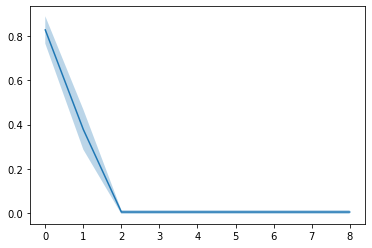

In [14]:
means = np.mean(total_batch_acc,axis=0)[:9]
stds = np.std(total_batch_acc,axis=0)[:9]
plt.plot(means)
plt.fill_between(range(9),means-stds,means+stds,alpha=.3)

In [39]:
# import pickle

In [ ]:
# with open('/workdir/security/home/junjiehuang2468/paper/results/ember/my_way/cumulative_gradients_v4_13iter_acc.txt','wb') as fp:
#     pickle.dump(total_batch_acc,fp)